# DistilBERT M1 (With Ray Tune)

Importing the necessary libraries

In [4]:
import numpy as np
import pandas as pd
import pathlib
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

from sklearn.metrics import precision_recall_fscore_support, classification_report
import nltk.corpus
from sklearn import metrics
from scipy.special import softmax

import transformers
from transformers import  AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import TrainingArguments, Trainer,TrainerCallback, EarlyStoppingCallback
import glob
from datasets import Dataset

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from transformers import EvalPrediction   
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import PopulationBasedTraining
import copy
#to avoid warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
torch.cuda.empty_cache()

## 1. Loading the data

In [10]:
#loading each set into seperate dataframes
folder_path = 'data/clean/'
file_pattern = folder_path + '*.csv'
csv_files = glob.glob(file_pattern)

for csv_file in csv_files:
    if 'train' in csv_file:
        df_train = pd.read_csv(csv_file)
    elif 'val' in csv_file:
        df_val = pd.read_csv(csv_file)
    else:
        df_test = pd.read_csv(csv_file)

In [11]:
df_train.head()

clean_text  admiration  amusement  \
0  my favourite food is anything i did not have t...           0          0   
1  now if he does off himself everyone will think...           0          0   
2                     why the fuck is bayless isoing           0          0   
3                        to make her feel threatened           0          0   
4                             dirty southern wankers           0          0   

   anger  annoyance  approval  caring  confusion  curiosity  desire  ...  \
0      0          0         0       0          0          0       0  ...   
1      0          0         0       0          0          0       0  ...   
2      1          0         0       0          0          0       0  ...   
3      0          0         0       0          0          0       0  ...   
4      0          1         0       0          0          0       0  ...   

   love  nervousness  optimism  pride  realization  relief  remorse  sadness  \
0     0            0         0      0            0       0        0        0   
1     0            0         0      0            0       0        0        0   
2     0            0         0      0            0       0        0        0   
3     0            0         0      0            0       0        0        0   
4     0            0         0      0            0       0        0        0   

   surprise  neutral  
0         0        1  
1         0        1  
2         0        0  
3         0        0  
4         0        0  

[5 rows x 29 columns]

## 2. Model Building

In [12]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 3e-5
WEIGHT_DECAY = 0.01
MODEL_NAME = 'distilbert-base-uncased'

In [13]:
#Instantiating the tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [14]:
#checking the max length of tokens
text_data = df_train['clean_text'].values

max_len = np.zeros(len(text_data))
for i in range(len(text_data)):
    input_ids = tokenizer.encode(text_data[i], add_special_tokens=True)
    max_len[i] = len(input_ids)
print('Max length: ', max_len.max())

Max length:  146.0


In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Storing all 28 labels into variable target_cols

In [12]:
target_cols = [col for col in df_train.columns if col not in ['clean_text']]

In [13]:
len(target_cols)

28

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

### Tokenization

In [15]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [16]:
# Tokenize the training set
train_encodings = tokenizer(list(df_train['clean_text']), padding=True, truncation=True, return_tensors='pt')
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'],
                                   'attention_mask': train_encodings['attention_mask'],
                                   'labels': torch.tensor(df_train[target_cols].values, dtype=torch.float32)})

# Tokenize the validation set
val_encodings = tokenizer(list(df_val['clean_text']), padding=True, truncation=True, return_tensors='pt')
valid_dataset = Dataset.from_dict({'input_ids': val_encodings['input_ids'],
                                 'attention_mask': val_encodings['attention_mask'],
                                 'labels': torch.tensor(df_val[target_cols].values, dtype=torch.float32)})

# Tokenize the test set
test_encodings = tokenizer(list(df_test['clean_text']), padding=True, truncation=True, return_tensors='pt')
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'],
                                 'attention_mask': test_encodings['attention_mask'],
                                 'labels': torch.tensor(df_test[target_cols].values, dtype=torch.float32)})

### Model Configurations

In [17]:
# Instantiate the Model
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(target_cols))

In [15]:
#custom callback to get train and validation info during training
class CustomCallback(TrainerCallback):
    
    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer
    
    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = copy.deepcopy(control)
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            return control_copy

In [20]:
# define training args
training_args = TrainingArguments(
    output_dir='data/output/dis/copy/',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VALID_BATCH_SIZE,
    warmup_steps=50,
    evaluation_strategy="epoch",
    save_strategy = "epoch",
    logging_dir="data/output/dis/copy/logs",
    learning_rate=float(LEARNING_RATE),
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)


In [21]:
#Custom function to calculate the metrics for multi label classification
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    precision_micro = precision_score(y_true, y_pred, average='micro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'recall' : recall_micro,
               'precision': precision_micro,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [22]:
# create Trainer instance
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer
)
trainer.add_callback(CustomCallback(trainer)) 


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Ray Tune Configurations

In [42]:
#configuring ray tune parameters
tune_config = {
        "per_device_train_batch_size": 16,
        "per_device_eval_batch_size": 16,
        "num_train_epochs": tune.choice([3, 4, 5]),
        "max_steps": -1,
}

scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    metric="eval_f1",
    mode="max",
    perturbation_interval=1,
    hyperparam_mutations={
        "weight_decay": tune.uniform(0.0, 0.3),
        "learning_rate": tune.uniform(1e-5, 5e-5),
        "per_device_train_batch_size": [8,16],
    },
)

reporter = CLIReporter(
    parameter_columns={
        "weight_decay": "w_decay",
        "learning_rate": "lr",
        "per_device_train_batch_size": "train_bs/gpu",
        "num_train_epochs": "num_epochs",
    },
    metric_columns=["eval_accuracy", "eval_loss", "epoch", "training_iteration"],
)

best_run = trainer.hyperparameter_search(
    hp_space=lambda _: tune_config,
    backend="ray",
    n_trials=4,
    resources_per_trial={"cpu": 15, "gpu": 1},
    scheduler=scheduler,
    keep_checkpoints_num=1,
    stop=None,
    progress_reporter=reporter,
    local_dir="./ray_results/",
    name="tune_transformer_pbt",
    log_to_file=True,
)

2023-11-16 19:16:16,086	INFO tune.py:657 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2023-11-16 19:16:16 (running for 00:00:00.14)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (4 PENDING)




(pid=133233) 2023-11-16 19:16:18.721367: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=133233) 2023-11-16 19:16:18.721402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=133233) 2023-11-16 19:16:18.722115: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=133233) 2023-11-16 19:16:18.726073: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=133233) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

== Status ==
Current time: 2023-11-16 19:16:21 (running for 00:00:05.19)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
(_objective pid=133233) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=133233) /home/aishah/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=133233)   warnings.warn(
  0%|          | 26/13565 [00:03<30:48,  7.32it/s]


== Status ==
Current time: 2023-11-16 19:16:26 (running for 00:00:10.23)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  0%|          | 60/13565 [00:08<33:01,  6.82it/s]


== Status ==
Current time: 2023-11-16 19:16:31 (running for 00:00:15.24)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  1%|          | 97/13565 [00:13<30:26,  7.37it/s]


== Status ==
Current time: 2023-11-16 19:16:36 (running for 00:00:20.27)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  1%|          | 134/13565 [00:18<30:29,  7.34it/s]


== Status ==
Current time: 2023-11-16 19:16:41 (running for 00:00:25.30)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  1%|▏         | 170/13565 [00:23<30:30,  7.32it/s]


== Status ==
Current time: 2023-11-16 19:16:46 (running for 00:00:30.33)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  2%|▏         | 206/13565 [00:29<30:36,  7.27it/s]


== Status ==
Current time: 2023-11-16 19:16:51 (running for 00:00:35.36)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  2%|▏         | 242/13565 [00:33<30:24,  7.30it/s]


== Status ==
Current time: 2023-11-16 19:16:56 (running for 00:00:40.39)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  2%|▏         | 278/13565 [00:39<30:34,  7.24it/s]


== Status ==
Current time: 2023-11-16 19:17:01 (running for 00:00:45.47)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  2%|▏         | 315/13565 [00:44<30:36,  7.21it/s]


== Status ==
Current time: 2023-11-16 19:17:06 (running for 00:00:50.50)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  3%|▎         | 352/13565 [00:49<30:45,  7.16it/s]


== Status ==
Current time: 2023-11-16 19:17:11 (running for 00:00:55.53)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  3%|▎         | 388/13565 [00:54<30:36,  7.17it/s]


== Status ==
Current time: 2023-11-16 19:17:16 (running for 00:01:00.56)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  3%|▎         | 422/13565 [00:59<30:31,  7.18it/s]


== Status ==
Current time: 2023-11-16 19:17:21 (running for 00:01:05.58)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  3%|▎         | 458/13565 [01:04<30:32,  7.15it/s]


== Status ==
Current time: 2023-11-16 19:17:26 (running for 00:01:10.61)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  4%|▎         | 493/13565 [01:09<30:25,  7.16it/s]


== Status ==
Current time: 2023-11-16 19:17:31 (running for 00:01:15.69)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  4%|▎         | 500/13565 [01:10<30:27,  7.15it/s]
                                                   
  4%|▎         | 500/13565 [01:10<30:27,  7.15it/s]


(_objective pid=133233) {'loss': 0.1801, 'learning_rate': 2.6958460014673023e-05, 'epoch': 0.18}


  4%|▍         | 530/13565 [01:14<30:30,  7.12it/s]


== Status ==
Current time: 2023-11-16 19:17:36 (running for 00:01:20.73)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  4%|▍         | 566/13565 [01:19<30:28,  7.11it/s]


== Status ==
Current time: 2023-11-16 19:17:41 (running for 00:01:25.76)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  4%|▍         | 601/13565 [01:24<30:15,  7.14it/s]


== Status ==
Current time: 2023-11-16 19:17:46 (running for 00:01:30.79)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  5%|▍         | 636/13565 [01:29<30:15,  7.12it/s]


== Status ==
Current time: 2023-11-16 19:17:51 (running for 00:01:35.80)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  5%|▍         | 671/13565 [01:34<30:22,  7.07it/s]


== Status ==
Current time: 2023-11-16 19:17:56 (running for 00:01:40.83)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  5%|▌         | 706/13565 [01:39<30:12,  7.10it/s]


== Status ==
Current time: 2023-11-16 19:18:02 (running for 00:01:45.91)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  5%|▌         | 741/13565 [01:44<30:13,  7.07it/s]


== Status ==
Current time: 2023-11-16 19:18:07 (running for 00:01:50.94)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  6%|▌         | 777/13565 [01:49<30:00,  7.10it/s]


== Status ==
Current time: 2023-11-16 19:18:12 (running for 00:01:55.98)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  6%|▌         | 814/13565 [01:54<30:01,  7.08it/s]


== Status ==
Current time: 2023-11-16 19:18:17 (running for 00:02:01.01)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  6%|▋         | 848/13565 [01:59<30:00,  7.06it/s]


== Status ==
Current time: 2023-11-16 19:18:22 (running for 00:02:06.03)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  7%|▋         | 883/13565 [02:04<29:48,  7.09it/s]


== Status ==
Current time: 2023-11-16 19:18:27 (running for 00:02:11.06)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  7%|▋         | 919/13565 [02:09<29:53,  7.05it/s]


== Status ==
Current time: 2023-11-16 19:18:32 (running for 00:02:16.14)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  7%|▋         | 954/13565 [02:14<29:42,  7.07it/s]


== Status ==
Current time: 2023-11-16 19:18:37 (running for 00:02:21.17)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  7%|▋         | 989/13565 [02:19<29:38,  7.07it/s]


== Status ==
Current time: 2023-11-16 19:18:42 (running for 00:02:26.20)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  7%|▋         | 1001/13565 [02:21<29:37,  7.07it/s]


(_objective pid=133233) {'loss': 0.1165, 'learning_rate': 2.5926754694555414e-05, 'epoch': 0.37}


  8%|▊         | 1025/13565 [02:24<29:35,  7.06it/s]


== Status ==
Current time: 2023-11-16 19:18:47 (running for 00:02:31.23)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  8%|▊         | 1059/13565 [02:29<29:39,  7.03it/s]


== Status ==
Current time: 2023-11-16 19:18:52 (running for 00:02:36.25)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  8%|▊         | 1094/13565 [02:34<29:21,  7.08it/s]


== Status ==
Current time: 2023-11-16 19:18:57 (running for 00:02:41.28)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  8%|▊         | 1130/13565 [02:40<29:25,  7.04it/s]


== Status ==
Current time: 2023-11-16 19:19:02 (running for 00:02:46.37)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  9%|▊         | 1164/13565 [02:45<29:22,  7.04it/s]


== Status ==
Current time: 2023-11-16 19:19:07 (running for 00:02:51.40)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  9%|▉         | 1200/13565 [02:50<29:35,  6.97it/s]


== Status ==
Current time: 2023-11-16 19:19:12 (running for 00:02:56.43)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  9%|▉         | 1234/13565 [02:55<29:11,  7.04it/s]


== Status ==
Current time: 2023-11-16 19:19:17 (running for 00:03:01.47)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  9%|▉         | 1268/13565 [03:00<29:14,  7.01it/s]


== Status ==
Current time: 2023-11-16 19:19:22 (running for 00:03:06.47)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 10%|▉         | 1305/13565 [03:05<29:07,  7.02it/s]


== Status ==
Current time: 2023-11-16 19:19:27 (running for 00:03:11.51)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 10%|▉         | 1339/13565 [03:10<29:06,  7.00it/s]


== Status ==
Current time: 2023-11-16 19:19:32 (running for 00:03:16.58)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 10%|█         | 1374/13565 [03:15<28:53,  7.03it/s]


== Status ==
Current time: 2023-11-16 19:19:37 (running for 00:03:21.61)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 10%|█         | 1409/13565 [03:20<28:55,  7.00it/s]


== Status ==
Current time: 2023-11-16 19:19:42 (running for 00:03:26.64)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 11%|█         | 1444/13565 [03:25<28:42,  7.04it/s]


== Status ==
Current time: 2023-11-16 19:19:47 (running for 00:03:31.67)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 11%|█         | 1478/13565 [03:30<28:49,  6.99it/s]


== Status ==
Current time: 2023-11-16 19:19:52 (running for 00:03:36.69)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 11%|█         | 1501/13565 [03:33<28:42,  7.00it/s]


(_objective pid=133233) {'loss': 0.1026, 'learning_rate': 2.489504937443781e-05, 'epoch': 0.55}


 11%|█         | 1514/13565 [03:35<28:40,  7.00it/s]


== Status ==
Current time: 2023-11-16 19:19:57 (running for 00:03:41.72)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 11%|█▏        | 1547/13565 [03:40<28:34,  7.01it/s]


== Status ==
Current time: 2023-11-16 19:20:02 (running for 00:03:46.80)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 12%|█▏        | 1583/13565 [03:45<28:30,  7.01it/s]


== Status ==
Current time: 2023-11-16 19:20:07 (running for 00:03:51.84)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 12%|█▏        | 1618/13565 [03:50<28:31,  6.98it/s]


== Status ==
Current time: 2023-11-16 19:20:12 (running for 00:03:56.86)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 12%|█▏        | 1654/13565 [03:55<28:27,  6.97it/s]


== Status ==
Current time: 2023-11-16 19:20:17 (running for 00:04:01.90)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 12%|█▏        | 1687/13565 [04:00<28:20,  6.98it/s]


== Status ==
Current time: 2023-11-16 19:20:23 (running for 00:04:06.92)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 13%|█▎        | 1723/13565 [04:05<28:18,  6.97it/s]


== Status ==
Current time: 2023-11-16 19:20:28 (running for 00:04:11.95)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 13%|█▎        | 1756/13565 [04:10<28:13,  6.97it/s]


== Status ==
Current time: 2023-11-16 19:20:33 (running for 00:04:17.02)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 13%|█▎        | 1791/13565 [04:15<28:11,  6.96it/s]


== Status ==
Current time: 2023-11-16 19:20:38 (running for 00:04:22.06)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 13%|█▎        | 1827/13565 [04:20<27:58,  6.99it/s]


== Status ==
Current time: 2023-11-16 19:20:43 (running for 00:04:27.08)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 14%|█▎        | 1862/13565 [04:25<27:56,  6.98it/s]


== Status ==
Current time: 2023-11-16 19:20:48 (running for 00:04:32.11)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 14%|█▍        | 1895/13565 [04:30<27:55,  6.96it/s]


== Status ==
Current time: 2023-11-16 19:20:53 (running for 00:04:37.14)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 14%|█▍        | 1931/13565 [04:35<27:44,  6.99it/s]


== Status ==
Current time: 2023-11-16 19:20:58 (running for 00:04:42.17)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 14%|█▍        | 1965/13565 [04:40<27:53,  6.93it/s]


== Status ==
Current time: 2023-11-16 19:21:03 (running for 00:04:47.25)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 15%|█▍        | 2000/13565 [04:45<27:48,  6.93it/s]


(_objective pid=133233) {'loss': 0.097, 'learning_rate': 2.3863344054320205e-05, 'epoch': 0.74}
== Status ==
Current time: 2023-11-16 19:21:08 (running for 00:04:52.28)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 15%|█▌        | 2035/13565 [04:51<27:39,  6.95it/s]


== Status ==
Current time: 2023-11-16 19:21:13 (running for 00:04:57.31)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 15%|█▌        | 2070/13565 [04:56<27:38,  6.93it/s]


== Status ==
Current time: 2023-11-16 19:21:18 (running for 00:05:02.34)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 16%|█▌        | 2104/13565 [05:01<27:25,  6.96it/s]


== Status ==
Current time: 2023-11-16 19:21:23 (running for 00:05:07.36)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 16%|█▌        | 2139/13565 [05:06<27:22,  6.96it/s]


== Status ==
Current time: 2023-11-16 19:21:28 (running for 00:05:12.39)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 16%|█▌        | 2172/13565 [05:11<27:18,  6.96it/s]


== Status ==
Current time: 2023-11-16 19:21:33 (running for 00:05:17.47)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 16%|█▋        | 2208/13565 [05:16<27:13,  6.95it/s]


== Status ==
Current time: 2023-11-16 19:21:38 (running for 00:05:22.50)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 17%|█▋        | 2243/13565 [05:21<27:05,  6.97it/s]


== Status ==
Current time: 2023-11-16 19:21:43 (running for 00:05:27.53)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 17%|█▋        | 2278/13565 [05:26<27:09,  6.93it/s]


== Status ==
Current time: 2023-11-16 19:21:48 (running for 00:05:32.56)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 17%|█▋        | 2311/13565 [05:31<26:54,  6.97it/s]


== Status ==
Current time: 2023-11-16 19:21:53 (running for 00:05:37.58)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 17%|█▋        | 2346/13565 [05:36<26:55,  6.95it/s]


== Status ==
Current time: 2023-11-16 19:21:58 (running for 00:05:42.61)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 18%|█▊        | 2380/13565 [05:41<26:56,  6.92it/s]


== Status ==
Current time: 2023-11-16 19:22:03 (running for 00:05:47.69)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 18%|█▊        | 2415/13565 [05:46<26:49,  6.93it/s]


== Status ==
Current time: 2023-11-16 19:22:08 (running for 00:05:52.73)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 18%|█▊        | 2450/13565 [05:51<26:40,  6.94it/s]


== Status ==
Current time: 2023-11-16 19:22:13 (running for 00:05:57.75)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 18%|█▊        | 2485/13565 [05:56<26:38,  6.93it/s]


== Status ==
Current time: 2023-11-16 19:22:18 (running for 00:06:02.79)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 18%|█▊        | 2500/13565 [05:58<26:35,  6.94it/s]


(_objective pid=133233) {'loss': 0.094, 'learning_rate': 2.28316387342026e-05, 'epoch': 0.92}


 19%|█▊        | 2518/13565 [06:01<26:32,  6.94it/s]


== Status ==
Current time: 2023-11-16 19:22:23 (running for 00:06:07.81)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 19%|█▉        | 2553/13565 [06:06<26:21,  6.96it/s]


== Status ==
Current time: 2023-11-16 19:22:28 (running for 00:06:12.84)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 19%|█▉        | 2587/13565 [06:11<26:27,  6.92it/s]


== Status ==
Current time: 2023-11-16 19:22:34 (running for 00:06:17.91)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 19%|█▉        | 2622/13565 [06:16<26:15,  6.95it/s]


== Status ==
Current time: 2023-11-16 19:22:39 (running for 00:06:22.94)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 20%|█▉        | 2657/13565 [06:21<26:12,  6.93it/s]


== Status ==
Current time: 2023-11-16 19:22:44 (running for 00:06:27.97)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




 20%|█▉        | 2691/13565 [06:26<26:10,  6.92it/s]


== Status ==
Current time: 2023-11-16 19:22:49 (running for 00:06:33.19)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




  0%|          | 0/2713 [00:00<?, ?it/s]
(_objective pid=133233) 
  0%|          | 4/2713 [00:00<01:37, 27.85it/s]
(_objective pid=133233) 
  0%|          | 7/2713 [00:00<01:51, 24.19it/s]
(_objective pid=133233) 
  0%|          | 10/2713 [00:00<01:58, 22.83it/s]
(_objective pid=133233) 
  0%|          | 13/2713 [00:00<02:01, 22.29it/s]
(_objective pid=133233) 
  1%|          | 16/2713 [00:00<02:02, 21.95it/s]
(_objective pid=133233) 
  1%|          | 19/2713 [00:00<02:04, 21.63it/s]
(_objective pid=133233) 
  1%|          | 22/2713 [00:00<02:05, 21.51it/s]
(_objective pid=133233) 
  1%|          | 25/2713 [00:01<02:04, 21.56it/s]
(_objective pid=133233) 
  1%|          | 28/2713 [00:01<02:05, 21.45it/s]
(_objective pid=133233) 
  1%|          | 31/2713 [00:01<02:05, 21.31it/s]
(_objective pid=133233) 
  1%|▏         | 34/2713 [00:01<02:06, 21.23it/s]
(_objective pid=133233) 
  1%|▏         | 37/2713 [00:01<02:06, 21.21it/s]
(_objective pid=133233) 
  1%|▏         | 40/2713 [00:01<02:0

== Status ==
Current time: 2023-11-16 19:22:54 (running for 00:06:38.22)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
  2%|▏         | 43/2713 [00:01<02:05, 21.22it/s]
(_objective pid=133233) 
  2%|▏         | 46/2713 [00:02<02:05, 21.23it/s]
(_objective pid=133233) 
  2%|▏         | 49/2713 [00:02<02:05, 21.27it/s]
(_objective pid=133233) 
  2%|▏         | 52/2713 [00:02<02:04, 21.34it/s]
(_objective pid=133233) 
  2%|▏         | 55/2713 [00:02<02:05, 21.21it/s]
(_objective pid=133233) 
  2%|▏         | 58/2713 [00:02<02:05, 21.23it/s]
(_objective pid=133233) 
  2%|▏         | 61/2713 [00:02<02:05, 21.14it/s]
(_objective pid=133233) 
  2%|▏         | 64/2713 [00:02<02:04, 21.20it/s]
(_objective pid=133233) 
  2%|▏         | 67/2713 [00:03<02:04, 21.25it/s]
(_objective pid=133233) 
  3%|▎         | 70/2713 [00:03<02:04, 21.24it/s]
(_objective pid=133233) 
  3%|▎         | 73/2713 [00:03<02:03, 21.34it/s]
(_objective pid=133233) 
  3%|▎         | 76/2713 [00:03<02:03, 21.29it/s]
(_objective pid=133233) 
  3%|▎         | 79/2713 [00:03<02:04, 21.18it/s]
(_objective pid=133233) 


== Status ==
Current time: 2023-11-16 19:22:59 (running for 00:06:43.30)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
  6%|▌         | 150/2713 [00:07<02:24, 17.79it/s]
(_objective pid=133233) 
  6%|▌         | 153/2713 [00:07<02:16, 18.75it/s]
(_objective pid=133233) 
  6%|▌         | 156/2713 [00:07<02:10, 19.54it/s]
(_objective pid=133233) 
  6%|▌         | 159/2713 [00:07<02:07, 20.08it/s]
(_objective pid=133233) 
  6%|▌         | 162/2713 [00:07<02:04, 20.42it/s]
(_objective pid=133233) 
  6%|▌         | 165/2713 [00:07<02:06, 20.21it/s]
(_objective pid=133233) 
  6%|▌         | 168/2713 [00:08<02:04, 20.49it/s]
(_objective pid=133233) 
  6%|▋         | 171/2713 [00:08<02:02, 20.76it/s]
(_objective pid=133233) 
  6%|▋         | 174/2713 [00:08<02:01, 20.85it/s]
(_objective pid=133233) 
  7%|▋         | 177/2713 [00:08<02:00, 21.08it/s]
(_objective pid=133233) 
  7%|▋         | 180/2713 [00:08<01:59, 21.27it/s]
(_objective pid=133233) 
  7%|▋         | 183/2713 [00:08<01:59, 21.13it/s]
(_objective pid=133233) 
  7%|▋         | 186/2713 [00:08<02:00, 20.92it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:23:04 (running for 00:06:48.33)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
  9%|▉         | 255/2713 [00:12<01:55, 21.21it/s]
(_objective pid=133233) 
 10%|▉         | 258/2713 [00:12<01:56, 21.06it/s]
(_objective pid=133233) 
 10%|▉         | 261/2713 [00:12<01:56, 21.13it/s]
(_objective pid=133233) 
 10%|▉         | 264/2713 [00:12<01:55, 21.23it/s]
(_objective pid=133233) 
 10%|▉         | 267/2713 [00:12<01:55, 21.19it/s]
(_objective pid=133233) 
 10%|▉         | 270/2713 [00:12<01:55, 21.15it/s]
(_objective pid=133233) 
 10%|█         | 273/2713 [00:13<01:55, 21.18it/s]
(_objective pid=133233) 
 10%|█         | 276/2713 [00:13<01:54, 21.20it/s]
(_objective pid=133233) 
 10%|█         | 279/2713 [00:13<01:54, 21.21it/s]
(_objective pid=133233) 
 10%|█         | 282/2713 [00:13<01:54, 21.15it/s]
(_objective pid=133233) 
 11%|█         | 285/2713 [00:13<01:54, 21.18it/s]
(_objective pid=133233) 
 11%|█         | 288/2713 [00:13<01:54, 21.17it/s]
(_objective pid=133233) 
 11%|█         | 291/2713 [00:13<01:54, 21.20it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:23:09 (running for 00:06:53.36)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 13%|█▎        | 363/2713 [00:17<01:51, 21.07it/s]
(_objective pid=133233) 
 13%|█▎        | 366/2713 [00:17<01:51, 21.08it/s]
(_objective pid=133233) 
 14%|█▎        | 369/2713 [00:17<01:50, 21.23it/s]
(_objective pid=133233) 
 14%|█▎        | 372/2713 [00:17<01:50, 21.09it/s]
(_objective pid=133233) 
 14%|█▍        | 375/2713 [00:17<01:51, 21.05it/s]
(_objective pid=133233) 
 14%|█▍        | 378/2713 [00:17<01:50, 21.18it/s]
(_objective pid=133233) 
 14%|█▍        | 381/2713 [00:18<01:50, 21.14it/s]
(_objective pid=133233) 
 14%|█▍        | 384/2713 [00:18<01:50, 21.11it/s]
(_objective pid=133233) 
 14%|█▍        | 387/2713 [00:18<01:50, 21.12it/s]
(_objective pid=133233) 
 14%|█▍        | 390/2713 [00:18<01:49, 21.23it/s]
(_objective pid=133233) 
 14%|█▍        | 393/2713 [00:18<01:49, 21.25it/s]
(_objective pid=133233) 
 15%|█▍        | 396/2713 [00:18<01:49, 21.14it/s]
(_objective pid=133233) 
 15%|█▍        | 399/2713 [00:18<01:49, 21.13it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:23:14 (running for 00:06:58.39)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 17%|█▋        | 465/2713 [00:22<01:47, 20.91it/s]
(_objective pid=133233) 
 17%|█▋        | 468/2713 [00:22<01:46, 20.98it/s]
(_objective pid=133233) 
 17%|█▋        | 471/2713 [00:22<01:46, 20.96it/s]
(_objective pid=133233) 
 17%|█▋        | 474/2713 [00:22<01:46, 21.02it/s]
(_objective pid=133233) 
 18%|█▊        | 477/2713 [00:22<01:46, 20.99it/s]
(_objective pid=133233) 
 18%|█▊        | 480/2713 [00:22<01:45, 21.11it/s]
(_objective pid=133233) 
 18%|█▊        | 483/2713 [00:22<01:45, 21.17it/s]
(_objective pid=133233) 
 18%|█▊        | 486/2713 [00:23<01:44, 21.29it/s]
(_objective pid=133233) 
 18%|█▊        | 489/2713 [00:23<01:44, 21.23it/s]
(_objective pid=133233) 
 18%|█▊        | 492/2713 [00:23<01:45, 21.11it/s]
(_objective pid=133233) 
 18%|█▊        | 495/2713 [00:23<01:45, 20.98it/s]
(_objective pid=133233) 
 18%|█▊        | 498/2713 [00:23<01:44, 21.10it/s]
(_objective pid=133233) 
 18%|█▊        | 501/2713 [00:23<01:44, 21.22it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:23:19 (running for 00:07:03.41)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 21%|██        | 570/2713 [00:27<01:58, 18.15it/s]
(_objective pid=133233) 
 21%|██        | 573/2713 [00:27<01:52, 19.02it/s]
(_objective pid=133233) 
 21%|██        | 576/2713 [00:27<01:48, 19.72it/s]
(_objective pid=133233) 
 21%|██▏       | 579/2713 [00:27<01:45, 20.26it/s]
(_objective pid=133233) 
 21%|██▏       | 582/2713 [00:27<01:44, 20.46it/s]
(_objective pid=133233) 
 22%|██▏       | 585/2713 [00:27<01:45, 20.25it/s]
(_objective pid=133233) 
 22%|██▏       | 588/2713 [00:28<01:43, 20.51it/s]
(_objective pid=133233) 
 22%|██▏       | 591/2713 [00:28<01:42, 20.77it/s]
(_objective pid=133233) 
 22%|██▏       | 594/2713 [00:28<01:41, 20.89it/s]
(_objective pid=133233) 
 22%|██▏       | 597/2713 [00:28<01:40, 21.08it/s]
(_objective pid=133233) 
 22%|██▏       | 600/2713 [00:28<01:40, 21.10it/s]
(_objective pid=133233) 
 22%|██▏       | 603/2713 [00:28<01:39, 21.12it/s]
(_objective pid=133233) 
 22%|██▏       | 606/2713 [00:28<01:40, 20.98it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:23:24 (running for 00:07:08.44)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 25%|██▍       | 678/2713 [00:32<01:36, 21.14it/s]
(_objective pid=133233) 
 25%|██▌       | 681/2713 [00:32<01:36, 21.10it/s]
(_objective pid=133233) 
 25%|██▌       | 684/2713 [00:32<01:35, 21.20it/s]
(_objective pid=133233) 
 25%|██▌       | 687/2713 [00:32<01:36, 20.99it/s]
(_objective pid=133233) 
 25%|██▌       | 690/2713 [00:32<01:36, 20.96it/s]
(_objective pid=133233) 
 26%|██▌       | 693/2713 [00:33<01:36, 21.01it/s]
(_objective pid=133233) 
 26%|██▌       | 696/2713 [00:33<01:35, 21.12it/s]
(_objective pid=133233) 
 26%|██▌       | 699/2713 [00:33<01:35, 21.14it/s]
(_objective pid=133233) 
 26%|██▌       | 702/2713 [00:33<01:35, 21.17it/s]
(_objective pid=133233) 
 26%|██▌       | 705/2713 [00:33<01:35, 21.13it/s]
(_objective pid=133233) 
 26%|██▌       | 708/2713 [00:33<01:34, 21.18it/s]
(_objective pid=133233) 
 26%|██▌       | 711/2713 [00:33<01:34, 21.14it/s]
(_objective pid=133233) 
 26%|██▋       | 714/2713 [00:34<01:34, 21.05it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:23:29 (running for 00:07:13.52)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 29%|██▊       | 777/2713 [00:37<01:46, 18.13it/s]
(_objective pid=133233) 
 29%|██▉       | 780/2713 [00:37<01:41, 19.06it/s]
(_objective pid=133233) 
 29%|██▉       | 783/2713 [00:37<01:38, 19.58it/s]
(_objective pid=133233) 
 29%|██▉       | 786/2713 [00:37<01:35, 20.17it/s]
(_objective pid=133233) 
 29%|██▉       | 789/2713 [00:37<01:34, 20.39it/s]
(_objective pid=133233) 
 29%|██▉       | 792/2713 [00:37<01:34, 20.23it/s]
(_objective pid=133233) 
 29%|██▉       | 795/2713 [00:38<01:33, 20.49it/s]
(_objective pid=133233) 
 29%|██▉       | 798/2713 [00:38<01:32, 20.76it/s]
(_objective pid=133233) 
 30%|██▉       | 801/2713 [00:38<01:31, 20.99it/s]
(_objective pid=133233) 
 30%|██▉       | 804/2713 [00:38<01:30, 21.16it/s]
(_objective pid=133233) 
 30%|██▉       | 807/2713 [00:38<01:29, 21.20it/s]
(_objective pid=133233) 
 30%|██▉       | 810/2713 [00:38<01:30, 21.11it/s]
(_objective pid=133233) 
 30%|██▉       | 813/2713 [00:38<01:30, 20.93it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:23:34 (running for 00:07:18.54)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 33%|███▎      | 885/2713 [00:42<01:26, 21.15it/s]
(_objective pid=133233) 
 33%|███▎      | 888/2713 [00:42<01:26, 21.16it/s]
(_objective pid=133233) 
 33%|███▎      | 891/2713 [00:42<01:26, 21.14it/s]
(_objective pid=133233) 
 33%|███▎      | 894/2713 [00:42<01:26, 21.03it/s]
(_objective pid=133233) 
 33%|███▎      | 897/2713 [00:42<01:26, 20.89it/s]
(_objective pid=133233) 
 33%|███▎      | 900/2713 [00:43<01:26, 20.90it/s]
(_objective pid=133233) 
 33%|███▎      | 903/2713 [00:43<01:26, 21.04it/s]
(_objective pid=133233) 
 33%|███▎      | 906/2713 [00:43<01:25, 21.22it/s]
(_objective pid=133233) 
 34%|███▎      | 909/2713 [00:43<01:24, 21.24it/s]
(_objective pid=133233) 
 34%|███▎      | 912/2713 [00:43<01:25, 21.14it/s]
(_objective pid=133233) 
 34%|███▎      | 915/2713 [00:43<01:25, 21.12it/s]
(_objective pid=133233) 
 34%|███▍      | 918/2713 [00:43<01:25, 21.06it/s]
(_objective pid=133233) 
 34%|███▍      | 921/2713 [00:44<01:24, 21.13it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:23:39 (running for 00:07:23.58)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 37%|███▋      | 993/2713 [00:47<01:21, 21.14it/s]
(_objective pid=133233) 
 37%|███▋      | 996/2713 [00:47<01:21, 21.10it/s]
(_objective pid=133233) 
 37%|███▋      | 999/2713 [00:47<01:21, 21.06it/s]
(_objective pid=133233) 
 37%|███▋      | 1002/2713 [00:47<01:20, 21.15it/s]
(_objective pid=133233) 
 37%|███▋      | 1005/2713 [00:48<01:20, 21.23it/s]
(_objective pid=133233) 
 37%|███▋      | 1008/2713 [00:48<01:20, 21.23it/s]
(_objective pid=133233) 
 37%|███▋      | 1011/2713 [00:48<01:20, 21.12it/s]
(_objective pid=133233) 
 37%|███▋      | 1014/2713 [00:48<01:20, 21.09it/s]
(_objective pid=133233) 
 37%|███▋      | 1017/2713 [00:48<01:20, 21.13it/s]
(_objective pid=133233) 
 38%|███▊      | 1020/2713 [00:48<01:20, 21.16it/s]
(_objective pid=133233) 
 38%|███▊      | 1023/2713 [00:48<01:19, 21.30it/s]
(_objective pid=133233) 
 38%|███▊      | 1026/2713 [00:48<01:19, 21.26it/s]
(_objective pid=133233) 
 38%|███▊      | 1029/2713 [00:49<01:19, 21.12it/s]
(_

== Status ==
Current time: 2023-11-16 19:23:44 (running for 00:07:28.60)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 40%|████      | 1098/2713 [00:52<01:17, 20.90it/s]
(_objective pid=133233) 
 41%|████      | 1101/2713 [00:52<01:17, 20.92it/s]
(_objective pid=133233) 
 41%|████      | 1104/2713 [00:52<01:16, 20.92it/s]
(_objective pid=133233) 
 41%|████      | 1107/2713 [00:52<01:16, 21.11it/s]
(_objective pid=133233) 
 41%|████      | 1110/2713 [00:52<01:15, 21.22it/s]
(_objective pid=133233) 
 41%|████      | 1113/2713 [00:53<01:15, 21.23it/s]
(_objective pid=133233) 
 41%|████      | 1116/2713 [00:53<01:15, 21.09it/s]
(_objective pid=133233) 
 41%|████      | 1119/2713 [00:53<01:15, 21.04it/s]
(_objective pid=133233) 
 41%|████▏     | 1122/2713 [00:53<01:15, 21.03it/s]
(_objective pid=133233) 
 41%|████▏     | 1125/2713 [00:53<01:15, 21.08it/s]
(_objective pid=133233) 
 42%|████▏     | 1128/2713 [00:53<01:15, 21.10it/s]
(_objective pid=133233) 
 42%|████▏     | 1131/2713 [00:53<01:14, 21.17it/s]
(_objective pid=133233) 
 42%|████▏     | 1134/2713 [00:54<01:14, 21.29it/s]

== Status ==
Current time: 2023-11-16 19:23:49 (running for 00:07:33.63)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 44%|████▍     | 1200/2713 [00:57<01:21, 18.56it/s]
(_objective pid=133233) 
 44%|████▍     | 1203/2713 [00:57<01:17, 19.40it/s]
(_objective pid=133233) 
 44%|████▍     | 1206/2713 [00:57<01:15, 19.94it/s]
(_objective pid=133233) 
 45%|████▍     | 1209/2713 [00:57<01:14, 20.32it/s]
(_objective pid=133233) 
 45%|████▍     | 1212/2713 [00:57<01:13, 20.55it/s]
(_objective pid=133233) 
 45%|████▍     | 1215/2713 [00:58<01:12, 20.65it/s]
(_objective pid=133233) 
 45%|████▍     | 1218/2713 [00:58<01:12, 20.73it/s]
(_objective pid=133233) 
 45%|████▌     | 1221/2713 [00:58<01:11, 20.89it/s]
(_objective pid=133233) 
 45%|████▌     | 1224/2713 [00:58<01:10, 21.04it/s]
(_objective pid=133233) 
 45%|████▌     | 1227/2713 [00:58<01:10, 21.13it/s]
(_objective pid=133233) 
 45%|████▌     | 1230/2713 [00:58<01:09, 21.20it/s]
(_objective pid=133233) 
 45%|████▌     | 1233/2713 [00:58<01:09, 21.21it/s]
(_objective pid=133233) 
 46%|████▌     | 1236/2713 [00:59<01:10, 21.07it/s]

== Status ==
Current time: 2023-11-16 19:23:54 (running for 00:07:38.66)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 48%|████▊     | 1308/2713 [01:02<01:06, 21.08it/s]
(_objective pid=133233) 
 48%|████▊     | 1311/2713 [01:02<01:06, 21.03it/s]
(_objective pid=133233) 
 48%|████▊     | 1314/2713 [01:02<01:06, 21.09it/s]
(_objective pid=133233) 
 49%|████▊     | 1317/2713 [01:02<01:05, 21.20it/s]
(_objective pid=133233) 
 49%|████▊     | 1320/2713 [01:03<01:05, 21.17it/s]
(_objective pid=133233) 
 49%|████▉     | 1323/2713 [01:03<01:05, 21.17it/s]
(_objective pid=133233) 
 49%|████▉     | 1326/2713 [01:03<01:05, 21.16it/s]
(_objective pid=133233) 
 49%|████▉     | 1329/2713 [01:03<01:05, 21.04it/s]
(_objective pid=133233) 
 49%|████▉     | 1332/2713 [01:03<01:05, 21.12it/s]
(_objective pid=133233) 
 49%|████▉     | 1335/2713 [01:03<01:05, 21.14it/s]
(_objective pid=133233) 
 49%|████▉     | 1338/2713 [01:03<01:05, 21.09it/s]
(_objective pid=133233) 
 49%|████▉     | 1341/2713 [01:04<01:05, 21.07it/s]
(_objective pid=133233) 
 50%|████▉     | 1344/2713 [01:04<01:04, 21.14it/s]

== Status ==
Current time: 2023-11-16 19:23:59 (running for 00:07:43.74)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 52%|█████▏    | 1413/2713 [01:07<01:04, 20.13it/s]
(_objective pid=133233) 
 52%|█████▏    | 1416/2713 [01:07<01:03, 20.43it/s]
(_objective pid=133233) 
 52%|█████▏    | 1419/2713 [01:07<01:03, 20.24it/s]
(_objective pid=133233) 
 52%|█████▏    | 1422/2713 [01:08<01:03, 20.46it/s]
(_objective pid=133233) 
 53%|█████▎    | 1425/2713 [01:08<01:02, 20.77it/s]
(_objective pid=133233) 
 53%|█████▎    | 1428/2713 [01:08<01:01, 20.99it/s]
(_objective pid=133233) 
 53%|█████▎    | 1431/2713 [01:08<01:00, 21.06it/s]
(_objective pid=133233) 
 53%|█████▎    | 1434/2713 [01:08<01:00, 21.06it/s]
(_objective pid=133233) 
 53%|█████▎    | 1437/2713 [01:08<01:00, 21.02it/s]
(_objective pid=133233) 
 53%|█████▎    | 1440/2713 [01:08<01:00, 20.92it/s]
(_objective pid=133233) 
 53%|█████▎    | 1443/2713 [01:09<01:00, 20.92it/s]
(_objective pid=133233) 
 53%|█████▎    | 1446/2713 [01:09<01:00, 20.97it/s]
(_objective pid=133233) 
 53%|█████▎    | 1449/2713 [01:09<00:59, 21.10it/s]

== Status ==
Current time: 2023-11-16 19:24:04 (running for 00:07:48.77)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 56%|█████▌    | 1518/2713 [01:12<00:56, 21.19it/s]
(_objective pid=133233) 
 56%|█████▌    | 1521/2713 [01:12<00:56, 21.02it/s]
(_objective pid=133233) 
 56%|█████▌    | 1524/2713 [01:12<00:56, 20.91it/s]
(_objective pid=133233) 
 56%|█████▋    | 1527/2713 [01:13<00:56, 21.03it/s]
(_objective pid=133233) 
 56%|█████▋    | 1530/2713 [01:13<00:56, 21.08it/s]
(_objective pid=133233) 
 57%|█████▋    | 1533/2713 [01:13<00:55, 21.12it/s]
(_objective pid=133233) 
 57%|█████▋    | 1536/2713 [01:13<00:55, 21.12it/s]
(_objective pid=133233) 
 57%|█████▋    | 1539/2713 [01:13<00:55, 21.14it/s]
(_objective pid=133233) 
 57%|█████▋    | 1542/2713 [01:13<00:55, 21.13it/s]
(_objective pid=133233) 
 57%|█████▋    | 1545/2713 [01:13<00:55, 21.06it/s]
(_objective pid=133233) 
 57%|█████▋    | 1548/2713 [01:14<00:55, 21.14it/s]
(_objective pid=133233) 
 57%|█████▋    | 1551/2713 [01:14<00:55, 21.07it/s]
(_objective pid=133233) 
 57%|█████▋    | 1554/2713 [01:14<00:54, 21.16it/s]

== Status ==
Current time: 2023-11-16 19:24:09 (running for 00:07:53.80)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 60%|█████▉    | 1623/2713 [01:17<00:51, 21.10it/s]
(_objective pid=133233) 
 60%|█████▉    | 1626/2713 [01:17<00:51, 21.01it/s]
(_objective pid=133233) 
 60%|██████    | 1629/2713 [01:17<00:51, 20.96it/s]
(_objective pid=133233) 
 60%|██████    | 1632/2713 [01:18<00:51, 21.06it/s]
(_objective pid=133233) 
 60%|██████    | 1635/2713 [01:18<00:51, 21.04it/s]
(_objective pid=133233) 
 60%|██████    | 1638/2713 [01:18<00:50, 21.19it/s]
(_objective pid=133233) 
 60%|██████    | 1641/2713 [01:18<00:50, 21.13it/s]
(_objective pid=133233) 
 61%|██████    | 1644/2713 [01:18<00:50, 21.07it/s]
(_objective pid=133233) 
 61%|██████    | 1647/2713 [01:18<00:50, 20.99it/s]
(_objective pid=133233) 
 61%|██████    | 1650/2713 [01:18<00:50, 21.03it/s]
(_objective pid=133233) 
 61%|██████    | 1653/2713 [01:19<00:50, 21.08it/s]
(_objective pid=133233) 
 61%|██████    | 1656/2713 [01:19<00:50, 21.09it/s]
(_objective pid=133233) 
 61%|██████    | 1659/2713 [01:19<00:49, 21.14it/s]

== Status ==
Current time: 2023-11-16 19:24:14 (running for 00:07:58.83)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 64%|██████▎   | 1728/2713 [01:22<00:46, 21.12it/s]
(_objective pid=133233) 
 64%|██████▍   | 1731/2713 [01:22<00:46, 20.99it/s]
(_objective pid=133233) 
 64%|██████▍   | 1734/2713 [01:22<00:46, 20.96it/s]
(_objective pid=133233) 
 64%|██████▍   | 1737/2713 [01:23<00:46, 21.12it/s]
(_objective pid=133233) 
 64%|██████▍   | 1740/2713 [01:23<00:45, 21.20it/s]
(_objective pid=133233) 
 64%|██████▍   | 1743/2713 [01:23<00:45, 21.21it/s]
(_objective pid=133233) 
 64%|██████▍   | 1746/2713 [01:23<00:45, 21.14it/s]
(_objective pid=133233) 
 64%|██████▍   | 1749/2713 [01:23<00:45, 21.15it/s]
(_objective pid=133233) 
 65%|██████▍   | 1752/2713 [01:23<00:45, 21.01it/s]
(_objective pid=133233) 
 65%|██████▍   | 1755/2713 [01:23<00:45, 21.02it/s]
(_objective pid=133233) 
 65%|██████▍   | 1758/2713 [01:24<00:45, 21.05it/s]
(_objective pid=133233) 
 65%|██████▍   | 1761/2713 [01:24<00:44, 21.22it/s]
(_objective pid=133233) 
 65%|██████▌   | 1764/2713 [01:24<00:44, 21.30it/s]

== Status ==
Current time: 2023-11-16 19:24:19 (running for 00:08:03.86)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 67%|██████▋   | 1830/2713 [01:27<00:45, 19.23it/s]
(_objective pid=133233) 
 68%|██████▊   | 1833/2713 [01:27<00:44, 19.79it/s]
(_objective pid=133233) 
 68%|██████▊   | 1836/2713 [01:27<00:44, 19.65it/s]
(_objective pid=133233) 
 68%|██████▊   | 1839/2713 [01:28<00:43, 20.15it/s]
(_objective pid=133233) 
 68%|██████▊   | 1842/2713 [01:28<00:42, 20.55it/s]
(_objective pid=133233) 
 68%|██████▊   | 1845/2713 [01:28<00:41, 20.79it/s]
(_objective pid=133233) 
 68%|██████▊   | 1848/2713 [01:28<00:41, 20.83it/s]
(_objective pid=133233) 
 68%|██████▊   | 1851/2713 [01:28<00:41, 21.00it/s]
(_objective pid=133233) 
 68%|██████▊   | 1854/2713 [01:28<00:40, 21.00it/s]
(_objective pid=133233) 
 68%|██████▊   | 1857/2713 [01:28<00:41, 20.78it/s]
(_objective pid=133233) 
 69%|██████▊   | 1860/2713 [01:29<00:40, 20.82it/s]
(_objective pid=133233) 
 69%|██████▊   | 1863/2713 [01:29<00:40, 20.95it/s]
(_objective pid=133233) 
 69%|██████▉   | 1866/2713 [01:29<00:40, 21.10it/s]

== Status ==
Current time: 2023-11-16 19:24:24 (running for 00:08:08.89)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 71%|███████▏  | 1938/2713 [01:32<00:36, 21.07it/s]
(_objective pid=133233) 
 72%|███████▏  | 1941/2713 [01:32<00:36, 20.97it/s]
(_objective pid=133233) 
 72%|███████▏  | 1944/2713 [01:33<00:36, 21.10it/s]
(_objective pid=133233) 
 72%|███████▏  | 1947/2713 [01:33<00:36, 21.13it/s]
(_objective pid=133233) 
 72%|███████▏  | 1950/2713 [01:33<00:36, 21.11it/s]
(_objective pid=133233) 
 72%|███████▏  | 1953/2713 [01:33<00:35, 21.14it/s]
(_objective pid=133233) 
 72%|███████▏  | 1956/2713 [01:33<00:35, 21.23it/s]
(_objective pid=133233) 
 72%|███████▏  | 1959/2713 [01:33<00:35, 21.18it/s]
(_objective pid=133233) 
 72%|███████▏  | 1962/2713 [01:33<00:35, 21.05it/s]
(_objective pid=133233) 
 72%|███████▏  | 1965/2713 [01:34<00:35, 21.05it/s]
(_objective pid=133233) 
 73%|███████▎  | 1968/2713 [01:34<00:35, 21.10it/s]
(_objective pid=133233) 
 73%|███████▎  | 1971/2713 [01:34<00:35, 21.12it/s]
(_objective pid=133233) 
 73%|███████▎  | 1974/2713 [01:34<00:34, 21.18it/s]

== Status ==
Current time: 2023-11-16 19:24:30 (running for 00:08:13.96)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 75%|███████▌  | 2040/2713 [01:37<00:34, 19.58it/s]
(_objective pid=133233) 
 75%|███████▌  | 2043/2713 [01:37<00:33, 19.77it/s]
(_objective pid=133233) 
 75%|███████▌  | 2046/2713 [01:38<00:32, 20.25it/s]
(_objective pid=133233) 
 76%|███████▌  | 2049/2713 [01:38<00:32, 20.53it/s]
(_objective pid=133233) 
 76%|███████▌  | 2052/2713 [01:38<00:31, 20.69it/s]
(_objective pid=133233) 
 76%|███████▌  | 2055/2713 [01:38<00:31, 20.89it/s]
(_objective pid=133233) 
 76%|███████▌  | 2058/2713 [01:38<00:31, 20.96it/s]
(_objective pid=133233) 
 76%|███████▌  | 2061/2713 [01:38<00:31, 20.98it/s]
(_objective pid=133233) 
 76%|███████▌  | 2064/2713 [01:38<00:31, 20.86it/s]
(_objective pid=133233) 
 76%|███████▌  | 2067/2713 [01:39<00:30, 20.90it/s]
(_objective pid=133233) 
 76%|███████▋  | 2070/2713 [01:39<00:30, 20.99it/s]
(_objective pid=133233) 
 76%|███████▋  | 2073/2713 [01:39<00:30, 21.11it/s]
(_objective pid=133233) 
 77%|███████▋  | 2076/2713 [01:39<00:30, 21.20it/s]

== Status ==
Current time: 2023-11-16 19:24:35 (running for 00:08:18.99)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 79%|███████▉  | 2148/2713 [01:42<00:26, 20.97it/s]
(_objective pid=133233) 
 79%|███████▉  | 2151/2713 [01:43<00:26, 21.04it/s]
(_objective pid=133233) 
 79%|███████▉  | 2154/2713 [01:43<00:26, 21.12it/s]
(_objective pid=133233) 
 80%|███████▉  | 2157/2713 [01:43<00:26, 21.15it/s]
(_objective pid=133233) 
 80%|███████▉  | 2160/2713 [01:43<00:26, 21.04it/s]
(_objective pid=133233) 
 80%|███████▉  | 2163/2713 [01:43<00:26, 21.05it/s]
(_objective pid=133233) 
 80%|███████▉  | 2166/2713 [01:43<00:25, 21.08it/s]
(_objective pid=133233) 
 80%|███████▉  | 2169/2713 [01:43<00:25, 21.03it/s]
(_objective pid=133233) 
 80%|████████  | 2172/2713 [01:44<00:25, 21.07it/s]
(_objective pid=133233) 
 80%|████████  | 2175/2713 [01:44<00:25, 21.13it/s]
(_objective pid=133233) 
 80%|████████  | 2178/2713 [01:44<00:25, 21.16it/s]
(_objective pid=133233) 
 80%|████████  | 2181/2713 [01:44<00:25, 21.10it/s]
(_objective pid=133233) 
 81%|████████  | 2184/2713 [01:44<00:25, 21.06it/s]

== Status ==
Current time: 2023-11-16 19:24:40 (running for 00:08:24.02)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 83%|████████▎ | 2250/2713 [01:47<00:22, 21.04it/s]
(_objective pid=133233) 
 83%|████████▎ | 2253/2713 [01:47<00:21, 21.00it/s]
(_objective pid=133233) 
 83%|████████▎ | 2256/2713 [01:48<00:21, 21.03it/s]
(_objective pid=133233) 
 83%|████████▎ | 2259/2713 [01:48<00:21, 21.08it/s]
(_objective pid=133233) 
 83%|████████▎ | 2262/2713 [01:48<00:21, 21.02it/s]
(_objective pid=133233) 
 83%|████████▎ | 2265/2713 [01:48<00:21, 20.94it/s]
(_objective pid=133233) 
 84%|████████▎ | 2268/2713 [01:48<00:21, 20.99it/s]
(_objective pid=133233) 
 84%|████████▎ | 2271/2713 [01:48<00:20, 21.11it/s]
(_objective pid=133233) 
 84%|████████▍ | 2274/2713 [01:48<00:20, 21.00it/s]
(_objective pid=133233) 
 84%|████████▍ | 2277/2713 [01:49<00:20, 21.04it/s]
(_objective pid=133233) 
 84%|████████▍ | 2280/2713 [01:49<00:20, 21.10it/s]
(_objective pid=133233) 
 84%|████████▍ | 2283/2713 [01:49<00:20, 21.15it/s]
(_objective pid=133233) 
 84%|████████▍ | 2286/2713 [01:49<00:20, 21.05it/s]

== Status ==
Current time: 2023-11-16 19:24:45 (running for 00:08:29.05)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 87%|████████▋ | 2358/2713 [01:52<00:16, 21.02it/s]
(_objective pid=133233) 
 87%|████████▋ | 2361/2713 [01:53<00:16, 20.92it/s]
(_objective pid=133233) 
 87%|████████▋ | 2364/2713 [01:53<00:16, 21.06it/s]
(_objective pid=133233) 
 87%|████████▋ | 2367/2713 [01:53<00:16, 21.02it/s]
(_objective pid=133233) 
 87%|████████▋ | 2370/2713 [01:53<00:16, 20.99it/s]
(_objective pid=133233) 
 87%|████████▋ | 2373/2713 [01:53<00:16, 20.95it/s]
(_objective pid=133233) 
 88%|████████▊ | 2376/2713 [01:53<00:16, 21.04it/s]
(_objective pid=133233) 
 88%|████████▊ | 2379/2713 [01:53<00:15, 21.11it/s]
(_objective pid=133233) 
 88%|████████▊ | 2382/2713 [01:54<00:15, 21.07it/s]
(_objective pid=133233) 
 88%|████████▊ | 2385/2713 [01:54<00:15, 21.00it/s]
(_objective pid=133233) 
 88%|████████▊ | 2388/2713 [01:54<00:15, 21.11it/s]
(_objective pid=133233) 
 88%|████████▊ | 2391/2713 [01:54<00:15, 21.03it/s]
(_objective pid=133233) 
 88%|████████▊ | 2394/2713 [01:54<00:15, 21.06it/s]

== Status ==
Current time: 2023-11-16 19:24:50 (running for 00:08:34.08)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 91%|█████████ | 2460/2713 [01:57<00:12, 19.93it/s]
(_objective pid=133233) 
 91%|█████████ | 2463/2713 [01:58<00:12, 20.24it/s]
(_objective pid=133233) 
 91%|█████████ | 2466/2713 [01:58<00:12, 20.39it/s]
(_objective pid=133233) 
 91%|█████████ | 2469/2713 [01:58<00:11, 20.68it/s]
(_objective pid=133233) 
 91%|█████████ | 2472/2713 [01:58<00:11, 20.88it/s]
(_objective pid=133233) 
 91%|█████████ | 2475/2713 [01:58<00:11, 20.97it/s]
(_objective pid=133233) 
 91%|█████████▏| 2478/2713 [01:58<00:11, 21.01it/s]
(_objective pid=133233) 
 91%|█████████▏| 2481/2713 [01:58<00:11, 20.90it/s]
(_objective pid=133233) 
 92%|█████████▏| 2484/2713 [01:59<00:10, 20.97it/s]
(_objective pid=133233) 
 92%|█████████▏| 2487/2713 [01:59<00:10, 21.03it/s]
(_objective pid=133233) 
 92%|█████████▏| 2490/2713 [01:59<00:10, 20.96it/s]
(_objective pid=133233) 
 92%|█████████▏| 2493/2713 [01:59<00:10, 21.01it/s]
(_objective pid=133233) 
 92%|█████████▏| 2496/2713 [01:59<00:10, 21.13it/s]

== Status ==
Current time: 2023-11-16 19:24:55 (running for 00:08:39.11)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 95%|█████████▍| 2565/2713 [02:02<00:06, 21.15it/s]
(_objective pid=133233) 
 95%|█████████▍| 2568/2713 [02:03<00:06, 21.03it/s]
(_objective pid=133233) 
 95%|█████████▍| 2571/2713 [02:03<00:06, 20.96it/s]
(_objective pid=133233) 
 95%|█████████▍| 2574/2713 [02:03<00:06, 20.98it/s]
(_objective pid=133233) 
 95%|█████████▍| 2577/2713 [02:03<00:06, 21.06it/s]
(_objective pid=133233) 
 95%|█████████▌| 2580/2713 [02:03<00:06, 21.11it/s]
(_objective pid=133233) 
 95%|█████████▌| 2583/2713 [02:03<00:06, 21.05it/s]
(_objective pid=133233) 
 95%|█████████▌| 2586/2713 [02:03<00:06, 21.04it/s]
(_objective pid=133233) 
 95%|█████████▌| 2589/2713 [02:04<00:05, 21.10it/s]
(_objective pid=133233) 
 96%|█████████▌| 2592/2713 [02:04<00:05, 21.11it/s]
(_objective pid=133233) 
 96%|█████████▌| 2595/2713 [02:04<00:05, 20.95it/s]
(_objective pid=133233) 
 96%|█████████▌| 2598/2713 [02:04<00:05, 21.01it/s]
(_objective pid=133233) 
 96%|█████████▌| 2601/2713 [02:04<00:05, 21.07it/s]

== Status ==
Current time: 2023-11-16 19:25:00 (running for 00:08:44.18)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 98%|█████████▊| 2670/2713 [02:08<00:02, 20.03it/s]
(_objective pid=133233) 
 99%|█████████▊| 2673/2713 [02:08<00:01, 20.37it/s]
(_objective pid=133233) 
 99%|█████████▊| 2676/2713 [02:08<00:01, 20.63it/s]
(_objective pid=133233) 
 99%|█████████▊| 2679/2713 [02:08<00:01, 20.79it/s]
(_objective pid=133233) 
 99%|█████████▉| 2682/2713 [02:08<00:01, 20.96it/s]
(_objective pid=133233) 
 99%|█████████▉| 2685/2713 [02:08<00:01, 20.96it/s]
(_objective pid=133233) 
 99%|█████████▉| 2688/2713 [02:08<00:01, 20.78it/s]
(_objective pid=133233) 
 99%|█████████▉| 2691/2713 [02:09<00:01, 20.89it/s]
(_objective pid=133233) 
 99%|█████████▉| 2694/2713 [02:09<00:00, 21.00it/s]
(_objective pid=133233) 
 99%|█████████▉| 2697/2713 [02:09<00:00, 21.09it/s]
(_objective pid=133233) 
100%|█████████▉| 2700/2713 [02:09<00:00, 21.06it/s]
(_objective pid=133233) 
100%|█████████▉| 2703/2713 [02:09<00:00, 21.08it/s]
(_objective pid=133233) 
100%|█████████▉| 2706/2713 [02:09<00:00, 21.03it/s]

(_objective pid=133233) {'train_loss': 0.08306493610143661, 'train_f1': 0.5501412429378532, 'train_recall': 0.4268743761864689, 'train_precision': 0.7735026064754069, 'train_roc_auc': 0.7106944019171859, 'train_accuracy': 0.4126197935864357, 'train_runtime': 130.8038, 'train_samples_per_second': 331.856, 'train_steps_per_second': 20.741, 'epoch': 1.0}


(_objective pid=133233) 
  3%|▎         | 10/340 [00:00<00:09, 34.64it/s]
(_objective pid=133233) 
  4%|▍         | 14/340 [00:00<00:09, 33.68it/s]
(_objective pid=133233) 
  5%|▌         | 18/340 [00:00<00:09, 33.16it/s]
(_objective pid=133233) 
  6%|▋         | 22/340 [00:00<00:09, 32.82it/s]
(_objective pid=133233) 
  8%|▊         | 26/340 [00:00<00:09, 32.64it/s]
(_objective pid=133233) 
  9%|▉         | 30/340 [00:00<00:09, 31.54it/s]
(_objective pid=133233) 
 10%|█         | 34/340 [00:01<00:09, 31.73it/s]
(_objective pid=133233) 
 11%|█         | 38/340 [00:01<00:09, 31.56it/s]
(_objective pid=133233) 
 12%|█▏        | 42/340 [00:01<00:09, 31.50it/s]
(_objective pid=133233) 
 14%|█▎        | 46/340 [00:01<00:09, 31.58it/s]
(_objective pid=133233) 
 15%|█▍        | 50/340 [00:01<00:09, 31.73it/s]
(_objective pid=133233) 
 16%|█▌        | 54/340 [00:01<00:08, 31.78it/s]
(_objective pid=133233) 
 17%|█▋        | 58/340 [00:01<00:08, 31.82it/s]
(_objective pid=133233) 
 18%|█▊      

== Status ==
Current time: 2023-11-16 19:25:05 (running for 00:08:49.21)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 21%|██        | 70/340 [00:02<00:08, 31.53it/s]
(_objective pid=133233) 
 22%|██▏       | 74/340 [00:02<00:08, 31.33it/s]
(_objective pid=133233) 
 23%|██▎       | 78/340 [00:02<00:08, 31.25it/s]
(_objective pid=133233) 
 24%|██▍       | 82/340 [00:02<00:08, 31.42it/s]
(_objective pid=133233) 
 25%|██▌       | 86/340 [00:02<00:08, 31.63it/s]
(_objective pid=133233) 
 26%|██▋       | 90/340 [00:02<00:07, 31.66it/s]
(_objective pid=133233) 
 28%|██▊       | 94/340 [00:02<00:07, 31.66it/s]
(_objective pid=133233) 
 29%|██▉       | 98/340 [00:03<00:07, 31.61it/s]
(_objective pid=133233) 
 30%|███       | 102/340 [00:03<00:07, 31.56it/s]
(_objective pid=133233) 
 31%|███       | 106/340 [00:03<00:07, 31.50it/s]
(_objective pid=133233) 
 32%|███▏      | 110/340 [00:03<00:07, 31.69it/s]
(_objective pid=133233) 
 34%|███▎      | 114/340 [00:03<00:07, 31.49it/s]
(_objective pid=133233) 
 35%|███▍      | 118/340 [00:03<00:07, 31.42it/s]
(_objective pid=133233) 
 36%|███

== Status ==
Current time: 2023-11-16 19:25:10 (running for 00:08:54.24)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)




(_objective pid=133233) 
 69%|██████▉   | 234/340 [00:07<00:03, 31.37it/s]
(_objective pid=133233) 
 70%|███████   | 238/340 [00:07<00:03, 31.40it/s]
(_objective pid=133233) 
 71%|███████   | 242/340 [00:07<00:03, 31.57it/s]
(_objective pid=133233) 
 72%|███████▏  | 246/340 [00:07<00:02, 31.59it/s]
(_objective pid=133233) 
 74%|███████▎  | 250/340 [00:07<00:02, 31.55it/s]
(_objective pid=133233) 
 75%|███████▍  | 254/340 [00:08<00:02, 31.59it/s]
(_objective pid=133233) 
 76%|███████▌  | 258/340 [00:08<00:02, 31.62it/s]
(_objective pid=133233) 
 77%|███████▋  | 262/340 [00:08<00:02, 31.66it/s]
(_objective pid=133233) 
 78%|███████▊  | 266/340 [00:08<00:02, 31.68it/s]
(_objective pid=133233) 
 79%|███████▉  | 270/340 [00:08<00:02, 31.51it/s]
(_objective pid=133233) 
 81%|████████  | 274/340 [00:08<00:02, 31.47it/s]
(_objective pid=133233) 
 82%|████████▏ | 278/340 [00:08<00:01, 31.31it/s]
(_objective pid=133233) 
 83%|████████▎ | 282/340 [00:08<00:01, 31.18it/s]
(_objective pid=133233) 


(_objective pid=133233) {'eval_loss': 0.08901198953390121, 'eval_f1': 0.5237950894210367, 'eval_recall': 0.406269592476489, 'eval_precision': 0.7369917543360819, 'eval_roc_auc': 0.6999571503757112, 'eval_accuracy': 0.39476594176188723, 'eval_runtime': 10.8352, 'eval_samples_per_second': 500.776, 'eval_steps_per_second': 31.379, 'epoch': 1.0}


== Status ==
Current time: 2023-11-16 19:25:15 (running for 00:08:59.29)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 3 PENDING)




(pid=138208) 2023-11-16 19:25:18.630087: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=138208) 2023-11-16 19:25:18.630125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=138208) 2023-11-16 19:25:18.630841: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=138208) 2023-11-16 19:25:18.635277: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=138208) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

== Status ==
Current time: 2023-11-16 19:25:20 (running for 00:09:04.57)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
(_objective pid=138208) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=138208) /home/aishah/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=138208)   warnings.warn(
  0%|          | 18/10852 [00:02<25:59,  6.95it/s]


== Status ==
Current time: 2023-11-16 19:25:25 (running for 00:09:09.57)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  0%|          | 51/10852 [00:07<26:11,  6.87it/s]


== Status ==
Current time: 2023-11-16 19:25:30 (running for 00:09:14.66)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  1%|          | 88/10852 [00:13<25:51,  6.94it/s]


== Status ==
Current time: 2023-11-16 19:25:35 (running for 00:09:19.78)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  1%|          | 122/10852 [00:18<25:51,  6.91it/s]


== Status ==
Current time: 2023-11-16 19:25:40 (running for 00:09:24.86)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  1%|▏         | 158/10852 [00:23<25:39,  6.95it/s]


== Status ==
Current time: 2023-11-16 19:25:46 (running for 00:09:30.00)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  2%|▏         | 191/10852 [00:28<32:48,  5.42it/s]


== Status ==
Current time: 2023-11-16 19:25:51 (running for 00:09:35.09)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  2%|▏         | 226/10852 [00:33<25:28,  6.95it/s]


== Status ==
Current time: 2023-11-16 19:25:56 (running for 00:09:40.18)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  2%|▏         | 260/10852 [00:38<25:32,  6.91it/s]


== Status ==
Current time: 2023-11-16 19:26:01 (running for 00:09:45.20)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  3%|▎         | 295/10852 [00:43<25:27,  6.91it/s]


== Status ==
Current time: 2023-11-16 19:26:06 (running for 00:09:50.29)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  3%|▎         | 330/10852 [00:48<25:17,  6.93it/s]


== Status ==
Current time: 2023-11-16 19:26:11 (running for 00:09:55.38)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  3%|▎         | 365/10852 [00:53<25:15,  6.92it/s]


== Status ==
Current time: 2023-11-16 19:26:16 (running for 00:10:00.48)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  4%|▎         | 399/10852 [00:58<25:17,  6.89it/s]


== Status ==
Current time: 2023-11-16 19:26:21 (running for 00:10:05.52)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  4%|▍         | 434/10852 [01:04<25:06,  6.92it/s]


== Status ==
Current time: 2023-11-16 19:26:26 (running for 00:10:10.61)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  4%|▍         | 467/10852 [01:08<24:58,  6.93it/s]


== Status ==
Current time: 2023-11-16 19:26:31 (running for 00:10:15.63)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  5%|▍         | 501/10852 [01:13<25:08,  6.86it/s]


(_objective pid=138208) {'loss': 0.1728, 'learning_rate': 3.2353337930897e-05, 'epoch': 0.18}


  5%|▍         | 503/10852 [01:14<25:02,  6.89it/s]


== Status ==
Current time: 2023-11-16 19:26:36 (running for 00:10:20.72)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  5%|▍         | 538/10852 [01:19<24:55,  6.90it/s]


== Status ==
Current time: 2023-11-16 19:26:41 (running for 00:10:25.82)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  5%|▌         | 573/10852 [01:24<24:44,  6.93it/s]


== Status ==
Current time: 2023-11-16 19:26:47 (running for 00:10:30.92)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  6%|▌         | 606/10852 [01:29<24:46,  6.89it/s]


== Status ==
Current time: 2023-11-16 19:26:52 (running for 00:10:35.95)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  6%|▌         | 641/10852 [01:34<24:45,  6.88it/s]


== Status ==
Current time: 2023-11-16 19:26:57 (running for 00:10:41.04)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  6%|▌         | 674/10852 [01:39<24:35,  6.90it/s]


== Status ==
Current time: 2023-11-16 19:27:02 (running for 00:10:46.06)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  7%|▋         | 710/10852 [01:44<24:44,  6.83it/s]


== Status ==
Current time: 2023-11-16 19:27:07 (running for 00:10:51.16)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  7%|▋         | 744/10852 [01:49<25:17,  6.66it/s]


== Status ==
Current time: 2023-11-16 19:27:12 (running for 00:10:56.25)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  7%|▋         | 779/10852 [01:54<24:25,  6.87it/s]


== Status ==
Current time: 2023-11-16 19:27:17 (running for 00:11:01.35)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  8%|▊         | 814/10852 [01:59<24:24,  6.86it/s]


== Status ==
Current time: 2023-11-16 19:27:22 (running for 00:11:06.37)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  8%|▊         | 848/10852 [02:04<24:12,  6.89it/s]


== Status ==
Current time: 2023-11-16 19:27:27 (running for 00:11:11.47)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  8%|▊         | 882/10852 [02:09<24:07,  6.89it/s]


== Status ==
Current time: 2023-11-16 19:27:32 (running for 00:11:16.49)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  8%|▊         | 916/10852 [02:14<24:01,  6.89it/s]


== Status ==
Current time: 2023-11-16 19:27:37 (running for 00:11:21.59)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  9%|▉         | 952/10852 [02:20<24:07,  6.84it/s]


== Status ==
Current time: 2023-11-16 19:27:42 (running for 00:11:26.68)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  9%|▉         | 986/10852 [02:25<23:51,  6.89it/s]


== Status ==
Current time: 2023-11-16 19:27:47 (running for 00:11:31.78)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




  9%|▉         | 1000/10852 [02:27<25:34,  6.42it/s]


(_objective pid=138208) {'loss': 0.1127, 'learning_rate': 3.079067670935058e-05, 'epoch': 0.37}


  9%|▉         | 1020/10852 [02:30<23:53,  6.86it/s]


== Status ==
Current time: 2023-11-16 19:27:52 (running for 00:11:36.81)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 10%|▉         | 1055/10852 [02:35<23:43,  6.88it/s]


== Status ==
Current time: 2023-11-16 19:27:58 (running for 00:11:41.91)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 10%|█         | 1089/10852 [02:40<23:44,  6.86it/s]


== Status ==
Current time: 2023-11-16 19:28:03 (running for 00:11:46.91)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 10%|█         | 1123/10852 [02:45<23:38,  6.86it/s]


== Status ==
Current time: 2023-11-16 19:28:08 (running for 00:11:52.00)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 11%|█         | 1159/10852 [02:50<23:30,  6.87it/s]


== Status ==
Current time: 2023-11-16 19:28:13 (running for 00:11:57.10)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 11%|█         | 1193/10852 [02:55<23:30,  6.85it/s]


== Status ==
Current time: 2023-11-16 19:28:18 (running for 00:12:02.20)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 11%|█▏        | 1227/10852 [03:00<23:23,  6.86it/s]


== Status ==
Current time: 2023-11-16 19:28:23 (running for 00:12:07.24)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 12%|█▏        | 1261/10852 [03:05<23:11,  6.89it/s]


== Status ==
Current time: 2023-11-16 19:28:28 (running for 00:12:12.33)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 12%|█▏        | 1295/10852 [03:10<23:13,  6.86it/s]


== Status ==
Current time: 2023-11-16 19:28:33 (running for 00:12:17.35)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 12%|█▏        | 1331/10852 [03:15<23:11,  6.84it/s]


== Status ==
Current time: 2023-11-16 19:28:38 (running for 00:12:22.45)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 13%|█▎        | 1365/10852 [03:20<22:59,  6.88it/s]


== Status ==
Current time: 2023-11-16 19:28:43 (running for 00:12:27.45)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 13%|█▎        | 1400/10852 [03:25<22:55,  6.87it/s]


== Status ==
Current time: 2023-11-16 19:28:48 (running for 00:12:32.55)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 13%|█▎        | 1432/10852 [03:30<22:53,  6.86it/s]


== Status ==
Current time: 2023-11-16 19:28:53 (running for 00:12:37.56)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 14%|█▎        | 1468/10852 [03:36<22:53,  6.83it/s]


== Status ==
Current time: 2023-11-16 19:28:58 (running for 00:12:42.66)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 14%|█▍        | 1501/10852 [03:41<22:48,  6.83it/s]


(_objective pid=138208) {'loss': 0.1007, 'learning_rate': 2.922801548780416e-05, 'epoch': 0.55}
== Status ==
Current time: 2023-11-16 19:29:03 (running for 00:12:47.69)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 14%|█▍        | 1535/10852 [03:46<22:35,  6.87it/s]


== Status ==
Current time: 2023-11-16 19:29:08 (running for 00:12:52.78)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 14%|█▍        | 1570/10852 [03:51<22:37,  6.84it/s]


== Status ==
Current time: 2023-11-16 19:29:13 (running for 00:12:57.88)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 15%|█▍        | 1604/10852 [03:56<22:28,  6.86it/s]


== Status ==
Current time: 2023-11-16 19:29:19 (running for 00:13:02.97)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 15%|█▌        | 1639/10852 [04:01<22:32,  6.81it/s]


== Status ==
Current time: 2023-11-16 19:29:24 (running for 00:13:07.99)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 15%|█▌        | 1672/10852 [04:06<22:23,  6.83it/s]


== Status ==
Current time: 2023-11-16 19:29:29 (running for 00:13:13.08)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 16%|█▌        | 1705/10852 [04:11<22:20,  6.82it/s]


== Status ==
Current time: 2023-11-16 19:29:34 (running for 00:13:18.12)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 16%|█▌        | 1741/10852 [04:16<22:25,  6.77it/s]


== Status ==
Current time: 2023-11-16 19:29:39 (running for 00:13:23.21)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 16%|█▋        | 1776/10852 [04:21<22:11,  6.82it/s]


== Status ==
Current time: 2023-11-16 19:29:44 (running for 00:13:28.31)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 17%|█▋        | 1811/10852 [04:26<28:17,  5.32it/s]


== Status ==
Current time: 2023-11-16 19:29:49 (running for 00:13:33.54)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 17%|█▋        | 1846/10852 [04:32<22:03,  6.81it/s]


== Status ==
Current time: 2023-11-16 19:29:54 (running for 00:13:38.64)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 17%|█▋        | 1879/10852 [04:37<25:49,  5.79it/s]


== Status ==
Current time: 2023-11-16 19:29:59 (running for 00:13:43.65)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 18%|█▊        | 1913/10852 [04:42<21:46,  6.84it/s]


== Status ==
Current time: 2023-11-16 19:30:04 (running for 00:13:48.75)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 18%|█▊        | 1948/10852 [04:47<21:43,  6.83it/s]


== Status ==
Current time: 2023-11-16 19:30:09 (running for 00:13:53.75)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 18%|█▊        | 1982/10852 [04:52<21:32,  6.86it/s]


== Status ==
Current time: 2023-11-16 19:30:14 (running for 00:13:58.84)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 18%|█▊        | 2000/10852 [04:54<21:31,  6.86it/s]


(_objective pid=138208) {'loss': 0.0956, 'learning_rate': 2.7665354266257745e-05, 'epoch': 0.74}


 19%|█▊        | 2016/10852 [04:57<24:01,  6.13it/s]


== Status ==
Current time: 2023-11-16 19:30:19 (running for 00:14:03.87)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 19%|█▉        | 2050/10852 [05:02<21:28,  6.83it/s]


== Status ==
Current time: 2023-11-16 19:30:25 (running for 00:14:08.97)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 19%|█▉        | 2083/10852 [05:07<25:38,  5.70it/s]


== Status ==
Current time: 2023-11-16 19:30:30 (running for 00:14:13.98)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 20%|█▉        | 2119/10852 [05:12<21:22,  6.81it/s]


== Status ==
Current time: 2023-11-16 19:30:35 (running for 00:14:19.07)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 20%|█▉        | 2152/10852 [05:17<21:29,  6.75it/s]


== Status ==
Current time: 2023-11-16 19:30:40 (running for 00:14:24.07)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 20%|██        | 2187/10852 [05:22<21:10,  6.82it/s]


== Status ==
Current time: 2023-11-16 19:30:45 (running for 00:14:29.17)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 20%|██        | 2220/10852 [05:27<23:58,  6.00it/s]


== Status ==
Current time: 2023-11-16 19:30:50 (running for 00:14:34.20)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 21%|██        | 2254/10852 [05:32<20:55,  6.85it/s]


== Status ==
Current time: 2023-11-16 19:30:55 (running for 00:14:39.21)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 21%|██        | 2287/10852 [05:37<22:49,  6.26it/s]


== Status ==
Current time: 2023-11-16 19:31:00 (running for 00:14:44.30)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 21%|██▏       | 2322/10852 [05:42<20:51,  6.82it/s]


== Status ==
Current time: 2023-11-16 19:31:05 (running for 00:14:49.40)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 22%|██▏       | 2357/10852 [05:47<20:39,  6.85it/s]


== Status ==
Current time: 2023-11-16 19:31:10 (running for 00:14:54.50)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 22%|██▏       | 2392/10852 [05:53<20:39,  6.82it/s]


== Status ==
Current time: 2023-11-16 19:31:15 (running for 00:14:59.59)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 22%|██▏       | 2425/10852 [05:58<21:11,  6.63it/s]


== Status ==
Current time: 2023-11-16 19:31:20 (running for 00:15:04.62)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 23%|██▎       | 2459/10852 [06:03<20:21,  6.87it/s]


== Status ==
Current time: 2023-11-16 19:31:25 (running for 00:15:09.72)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 23%|██▎       | 2492/10852 [06:08<21:09,  6.59it/s]


== Status ==
Current time: 2023-11-16 19:31:30 (running for 00:15:14.74)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 23%|██▎       | 2501/10852 [06:09<20:23,  6.83it/s]


(_objective pid=138208) {'loss': 0.0929, 'learning_rate': 2.610269304471133e-05, 'epoch': 0.92}


 23%|██▎       | 2527/10852 [06:13<20:18,  6.83it/s]


== Status ==
Current time: 2023-11-16 19:31:35 (running for 00:15:19.83)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 24%|██▎       | 2562/10852 [06:18<20:18,  6.80it/s]


== Status ==
Current time: 2023-11-16 19:31:41 (running for 00:15:24.93)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 24%|██▍       | 2597/10852 [06:23<20:06,  6.84it/s]


== Status ==
Current time: 2023-11-16 19:31:46 (running for 00:15:30.03)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 24%|██▍       | 2630/10852 [06:28<20:16,  6.76it/s]


== Status ==
Current time: 2023-11-16 19:31:51 (running for 00:15:35.05)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 25%|██▍       | 2664/10852 [06:33<20:00,  6.82it/s]


== Status ==
Current time: 2023-11-16 19:31:56 (running for 00:15:40.15)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 25%|██▍       | 2697/10852 [06:38<20:13,  6.72it/s]


== Status ==
Current time: 2023-11-16 19:32:01 (running for 00:15:45.16)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




 25%|██▌       | 2713/10852 [06:40<19:54,  6.81it/s]
(_objective pid=138208) 
  0%|          | 0/2713 [00:00<?, ?it/s]
(_objective pid=138208) 
  0%|          | 4/2713 [00:00<01:38, 27.42it/s]
(_objective pid=138208) 
  0%|          | 7/2713 [00:00<01:56, 23.24it/s]
(_objective pid=138208) 
  0%|          | 10/2713 [00:00<02:01, 22.16it/s]
(_objective pid=138208) 
  0%|          | 13/2713 [00:00<02:04, 21.72it/s]
(_objective pid=138208) 
  1%|          | 16/2713 [00:00<02:07, 21.23it/s]
(_objective pid=138208) 
  1%|          | 19/2713 [00:00<02:07, 21.13it/s]
(_objective pid=138208) 
  1%|          | 22/2713 [00:01<02:07, 21.06it/s]
(_objective pid=138208) 
  1%|          | 25/2713 [00:01<02:07, 21.01it/s]
(_objective pid=138208) 
  1%|          | 28/2713 [00:01<02:07, 21.00it/s]
(_objective pid=138208) 
  1%|          | 31/2713 [00:01<02:08, 20.89it/s]
(_objective pid=138208) 
  1%|▏         | 34/2713 [00:01<02:08, 20.92it/s]
(_objective pid=138208) 
  1%|▏         | 37/2713 [00:01<0

== Status ==
Current time: 2023-11-16 19:32:06 (running for 00:15:50.25)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
  2%|▏         | 58/2713 [00:02<02:07, 20.84it/s]
(_objective pid=138208) 
  2%|▏         | 61/2713 [00:02<02:07, 20.77it/s]
(_objective pid=138208) 
  2%|▏         | 64/2713 [00:03<02:07, 20.78it/s]
(_objective pid=138208) 
  2%|▏         | 67/2713 [00:03<02:07, 20.78it/s]
(_objective pid=138208) 
  3%|▎         | 70/2713 [00:03<02:07, 20.79it/s]
(_objective pid=138208) 
  3%|▎         | 73/2713 [00:03<02:06, 20.88it/s]
(_objective pid=138208) 
  3%|▎         | 76/2713 [00:03<02:06, 20.81it/s]
(_objective pid=138208) 
  3%|▎         | 79/2713 [00:03<02:06, 20.85it/s]
(_objective pid=138208) 
  3%|▎         | 82/2713 [00:03<02:06, 20.83it/s]
(_objective pid=138208) 
  3%|▎         | 85/2713 [00:04<02:06, 20.76it/s]
(_objective pid=138208) 
  3%|▎         | 88/2713 [00:04<02:05, 20.88it/s]
(_objective pid=138208) 
  3%|▎         | 91/2713 [00:04<02:05, 20.84it/s]
(_objective pid=138208) 
  3%|▎         | 94/2713 [00:04<02:05, 20.91it/s]
(_objective pid=138208) 


== Status ==
Current time: 2023-11-16 19:32:11 (running for 00:15:55.35)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
  6%|▌         | 163/2713 [00:07<02:03, 20.69it/s]
(_objective pid=138208) 
  6%|▌         | 166/2713 [00:07<02:02, 20.77it/s]
(_objective pid=138208) 
  6%|▌         | 169/2713 [00:08<02:02, 20.77it/s]
(_objective pid=138208) 
  6%|▋         | 172/2713 [00:08<02:02, 20.78it/s]
(_objective pid=138208) 
  6%|▋         | 175/2713 [00:08<02:02, 20.77it/s]
(_objective pid=138208) 
  7%|▋         | 178/2713 [00:08<02:02, 20.73it/s]
(_objective pid=138208) 
  7%|▋         | 181/2713 [00:08<02:02, 20.74it/s]
(_objective pid=138208) 
  7%|▋         | 184/2713 [00:08<02:02, 20.70it/s]
(_objective pid=138208) 
  7%|▋         | 187/2713 [00:08<02:01, 20.79it/s]
(_objective pid=138208) 
  7%|▋         | 190/2713 [00:09<02:01, 20.81it/s]
(_objective pid=138208) 
  7%|▋         | 193/2713 [00:09<02:01, 20.76it/s]
(_objective pid=138208) 
  7%|▋         | 196/2713 [00:09<02:01, 20.79it/s]
(_objective pid=138208) 
  7%|▋         | 199/2713 [00:09<02:01, 20.67it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:32:16 (running for 00:16:00.43)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 10%|▉         | 271/2713 [00:12<01:57, 20.77it/s]
(_objective pid=138208) 
 10%|█         | 274/2713 [00:13<01:57, 20.74it/s]
(_objective pid=138208) 
 10%|█         | 277/2713 [00:13<01:57, 20.75it/s]
(_objective pid=138208) 
 10%|█         | 280/2713 [00:13<01:58, 20.61it/s]
(_objective pid=138208) 
 10%|█         | 283/2713 [00:13<01:57, 20.75it/s]
(_objective pid=138208) 
 11%|█         | 286/2713 [00:13<01:56, 20.86it/s]
(_objective pid=138208) 
 11%|█         | 289/2713 [00:13<01:56, 20.81it/s]
(_objective pid=138208) 
 11%|█         | 292/2713 [00:14<01:56, 20.72it/s]
(_objective pid=138208) 
 11%|█         | 295/2713 [00:14<01:56, 20.68it/s]
(_objective pid=138208) 
 11%|█         | 298/2713 [00:14<01:56, 20.79it/s]
(_objective pid=138208) 
 11%|█         | 301/2713 [00:14<01:56, 20.71it/s]
(_objective pid=138208) 
 11%|█         | 304/2713 [00:14<01:56, 20.70it/s]
(_objective pid=138208) 
 11%|█▏        | 307/2713 [00:14<01:56, 20.70it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:32:21 (running for 00:16:05.48)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 14%|█▎        | 373/2713 [00:18<01:53, 20.58it/s]
(_objective pid=138208) 
 14%|█▍        | 376/2713 [00:18<01:53, 20.60it/s]
(_objective pid=138208) 
 14%|█▍        | 379/2713 [00:18<01:53, 20.65it/s]
(_objective pid=138208) 
 14%|█▍        | 382/2713 [00:18<01:52, 20.77it/s]
(_objective pid=138208) 
 14%|█▍        | 385/2713 [00:18<01:51, 20.89it/s]
(_objective pid=138208) 
 14%|█▍        | 388/2713 [00:18<01:51, 20.81it/s]
(_objective pid=138208) 
 14%|█▍        | 391/2713 [00:18<01:52, 20.68it/s]
(_objective pid=138208) 
 15%|█▍        | 394/2713 [00:19<01:52, 20.59it/s]
(_objective pid=138208) 
 15%|█▍        | 397/2713 [00:19<01:51, 20.77it/s]
(_objective pid=138208) 
 15%|█▍        | 400/2713 [00:19<01:51, 20.69it/s]
(_objective pid=138208) 
 15%|█▍        | 403/2713 [00:19<01:51, 20.78it/s]
(_objective pid=138208) 
 15%|█▍        | 406/2713 [00:19<01:50, 20.89it/s]
(_objective pid=138208) 
 15%|█▌        | 409/2713 [00:19<01:50, 20.85it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:32:26 (running for 00:16:10.57)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 18%|█▊        | 475/2713 [00:22<01:47, 20.77it/s]
(_objective pid=138208) 
 18%|█▊        | 478/2713 [00:23<01:47, 20.75it/s]
(_objective pid=138208) 
 18%|█▊        | 481/2713 [00:23<01:47, 20.70it/s]
(_objective pid=138208) 
 18%|█▊        | 484/2713 [00:23<01:47, 20.68it/s]
(_objective pid=138208) 
 18%|█▊        | 487/2713 [00:23<01:47, 20.80it/s]
(_objective pid=138208) 
 18%|█▊        | 490/2713 [00:23<01:47, 20.72it/s]
(_objective pid=138208) 
 18%|█▊        | 493/2713 [00:23<01:46, 20.75it/s]
(_objective pid=138208) 
 18%|█▊        | 496/2713 [00:24<01:47, 20.67it/s]
(_objective pid=138208) 
 18%|█▊        | 499/2713 [00:24<01:46, 20.79it/s]
(_objective pid=138208) 
 19%|█▊        | 502/2713 [00:24<01:46, 20.76it/s]
(_objective pid=138208) 
 19%|█▊        | 505/2713 [00:24<01:46, 20.77it/s]
(_objective pid=138208) 
 19%|█▊        | 508/2713 [00:24<01:46, 20.72it/s]
(_objective pid=138208) 
 19%|█▉        | 511/2713 [00:24<01:46, 20.62it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:32:31 (running for 00:16:15.59)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 21%|██▏       | 577/2713 [00:28<01:43, 20.65it/s]
(_objective pid=138208) 
 21%|██▏       | 580/2713 [00:28<01:43, 20.70it/s]
(_objective pid=138208) 
 21%|██▏       | 583/2713 [00:28<01:42, 20.72it/s]
(_objective pid=138208) 
 22%|██▏       | 586/2713 [00:28<01:42, 20.80it/s]
(_objective pid=138208) 
 22%|██▏       | 589/2713 [00:28<01:41, 20.83it/s]
(_objective pid=138208) 
 22%|██▏       | 592/2713 [00:28<01:41, 20.93it/s]
(_objective pid=138208) 
 22%|██▏       | 595/2713 [00:28<01:41, 20.86it/s]
(_objective pid=138208) 
 22%|██▏       | 598/2713 [00:29<01:41, 20.75it/s]
(_objective pid=138208) 
 22%|██▏       | 601/2713 [00:29<01:42, 20.62it/s]
(_objective pid=138208) 
 22%|██▏       | 604/2713 [00:29<01:41, 20.79it/s]
(_objective pid=138208) 
 22%|██▏       | 607/2713 [00:29<01:40, 20.89it/s]
(_objective pid=138208) 
 22%|██▏       | 610/2713 [00:29<01:40, 20.85it/s]
(_objective pid=138208) 
 23%|██▎       | 613/2713 [00:29<01:40, 20.84it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:32:36 (running for 00:16:20.68)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 25%|██▌       | 682/2713 [00:33<01:37, 20.78it/s]
(_objective pid=138208) 
 25%|██▌       | 685/2713 [00:33<01:37, 20.74it/s]
(_objective pid=138208) 
 25%|██▌       | 688/2713 [00:33<01:37, 20.72it/s]
(_objective pid=138208) 
 25%|██▌       | 691/2713 [00:33<01:37, 20.76it/s]
(_objective pid=138208) 
 26%|██▌       | 694/2713 [00:33<01:37, 20.71it/s]
(_objective pid=138208) 
 26%|██▌       | 697/2713 [00:33<01:37, 20.76it/s]
(_objective pid=138208) 
 26%|██▌       | 700/2713 [00:34<01:36, 20.85it/s]
(_objective pid=138208) 
 26%|██▌       | 703/2713 [00:34<01:36, 20.85it/s]
(_objective pid=138208) 
 26%|██▌       | 706/2713 [00:34<01:36, 20.78it/s]
(_objective pid=138208) 
 26%|██▌       | 709/2713 [00:34<01:36, 20.70it/s]
(_objective pid=138208) 
 26%|██▌       | 712/2713 [00:34<01:37, 20.60it/s]
(_objective pid=138208) 
 26%|██▋       | 715/2713 [00:34<01:36, 20.71it/s]
(_objective pid=138208) 
 26%|██▋       | 718/2713 [00:34<01:36, 20.76it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:32:41 (running for 00:16:25.77)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 29%|██▉       | 787/2713 [00:38<01:32, 20.82it/s]
(_objective pid=138208) 
 29%|██▉       | 790/2713 [00:38<01:32, 20.82it/s]
(_objective pid=138208) 
 29%|██▉       | 793/2713 [00:38<01:33, 20.63it/s]
(_objective pid=138208) 
 29%|██▉       | 796/2713 [00:38<01:32, 20.72it/s]
(_objective pid=138208) 
 29%|██▉       | 799/2713 [00:38<01:32, 20.76it/s]
(_objective pid=138208) 
 30%|██▉       | 802/2713 [00:38<01:32, 20.74it/s]
(_objective pid=138208) 
 30%|██▉       | 805/2713 [00:39<01:31, 20.74it/s]
(_objective pid=138208) 
 30%|██▉       | 808/2713 [00:39<01:32, 20.68it/s]
(_objective pid=138208) 
 30%|██▉       | 811/2713 [00:39<01:31, 20.76it/s]
(_objective pid=138208) 
 30%|███       | 814/2713 [00:39<01:31, 20.82it/s]
(_objective pid=138208) 
 30%|███       | 817/2713 [00:39<01:31, 20.81it/s]
(_objective pid=138208) 
 30%|███       | 820/2713 [00:39<01:30, 20.81it/s]
(_objective pid=138208) 
 30%|███       | 823/2713 [00:39<01:31, 20.71it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:32:46 (running for 00:16:30.86)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 33%|███▎      | 895/2713 [00:43<01:27, 20.84it/s]
(_objective pid=138208) 
 33%|███▎      | 898/2713 [00:43<01:26, 20.87it/s]
(_objective pid=138208) 
 33%|███▎      | 901/2713 [00:43<01:27, 20.79it/s]
(_objective pid=138208) 
 33%|███▎      | 904/2713 [00:43<01:27, 20.62it/s]
(_objective pid=138208) 
 33%|███▎      | 907/2713 [00:43<01:27, 20.74it/s]
(_objective pid=138208) 
 34%|███▎      | 910/2713 [00:44<01:26, 20.83it/s]
(_objective pid=138208) 
 34%|███▎      | 913/2713 [00:44<01:26, 20.78it/s]
(_objective pid=138208) 
 34%|███▍      | 916/2713 [00:44<01:26, 20.78it/s]
(_objective pid=138208) 
 34%|███▍      | 919/2713 [00:44<01:26, 20.73it/s]
(_objective pid=138208) 
 34%|███▍      | 922/2713 [00:44<01:25, 20.83it/s]
(_objective pid=138208) 
 34%|███▍      | 925/2713 [00:44<01:25, 20.89it/s]
(_objective pid=138208) 
 34%|███▍      | 928/2713 [00:44<01:25, 20.87it/s]
(_objective pid=138208) 
 34%|███▍      | 931/2713 [00:45<01:25, 20.85it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:32:52 (running for 00:16:35.91)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 37%|███▋      | 994/2713 [00:48<01:22, 20.80it/s]
(_objective pid=138208) 
 37%|███▋      | 997/2713 [00:48<01:22, 20.76it/s]
(_objective pid=138208) 
 37%|███▋      | 1000/2713 [00:48<01:23, 20.58it/s]
(_objective pid=138208) 
 37%|███▋      | 1003/2713 [00:48<01:22, 20.68it/s]
(_objective pid=138208) 
 37%|███▋      | 1006/2713 [00:48<01:22, 20.66it/s]
(_objective pid=138208) 
 37%|███▋      | 1009/2713 [00:49<01:22, 20.71it/s]
(_objective pid=138208) 
 37%|███▋      | 1012/2713 [00:49<01:21, 20.78it/s]
(_objective pid=138208) 
 37%|███▋      | 1015/2713 [00:49<01:21, 20.88it/s]
(_objective pid=138208) 
 38%|███▊      | 1018/2713 [00:49<01:21, 20.88it/s]
(_objective pid=138208) 
 38%|███▊      | 1021/2713 [00:49<01:21, 20.74it/s]
(_objective pid=138208) 
 38%|███▊      | 1024/2713 [00:49<01:21, 20.72it/s]
(_objective pid=138208) 
 38%|███▊      | 1027/2713 [00:49<01:21, 20.80it/s]
(_objective pid=138208) 
 38%|███▊      | 1030/2713 [00:50<01:20, 20.83it/s]
(

== Status ==
Current time: 2023-11-16 19:32:57 (running for 00:16:41.00)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 41%|████      | 1105/2713 [00:53<01:17, 20.71it/s]
(_objective pid=138208) 
 41%|████      | 1108/2713 [00:53<01:17, 20.77it/s]
(_objective pid=138208) 
 41%|████      | 1111/2713 [00:53<01:17, 20.74it/s]
(_objective pid=138208) 
 41%|████      | 1114/2713 [00:54<01:17, 20.73it/s]
(_objective pid=138208) 
 41%|████      | 1117/2713 [00:54<01:17, 20.72it/s]
(_objective pid=138208) 
 41%|████▏     | 1120/2713 [00:54<01:16, 20.73it/s]
(_objective pid=138208) 
 41%|████▏     | 1123/2713 [00:54<01:16, 20.80it/s]
(_objective pid=138208) 
 42%|████▏     | 1126/2713 [00:54<01:16, 20.80it/s]
(_objective pid=138208) 
 42%|████▏     | 1129/2713 [00:54<01:16, 20.77it/s]
(_objective pid=138208) 
 42%|████▏     | 1132/2713 [00:54<01:16, 20.78it/s]
(_objective pid=138208) 
 42%|████▏     | 1135/2713 [00:55<01:16, 20.71it/s]
(_objective pid=138208) 
 42%|████▏     | 1138/2713 [00:55<01:15, 20.82it/s]
(_objective pid=138208) 
 42%|████▏     | 1141/2713 [00:55<01:15, 20.85it/s]

== Status ==
Current time: 2023-11-16 19:33:02 (running for 00:16:46.02)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 44%|████▍     | 1204/2713 [00:58<01:12, 20.82it/s]
(_objective pid=138208) 
 44%|████▍     | 1207/2713 [00:58<01:12, 20.72it/s]
(_objective pid=138208) 
 45%|████▍     | 1210/2713 [00:58<01:12, 20.73it/s]
(_objective pid=138208) 
 45%|████▍     | 1213/2713 [00:59<01:12, 20.71it/s]
(_objective pid=138208) 
 45%|████▍     | 1216/2713 [00:59<01:12, 20.72it/s]
(_objective pid=138208) 
 45%|████▍     | 1219/2713 [00:59<01:12, 20.70it/s]
(_objective pid=138208) 
 45%|████▌     | 1222/2713 [00:59<01:12, 20.71it/s]
(_objective pid=138208) 
 45%|████▌     | 1225/2713 [00:59<01:11, 20.74it/s]
(_objective pid=138208) 
 45%|████▌     | 1228/2713 [00:59<01:11, 20.79it/s]
(_objective pid=138208) 
 45%|████▌     | 1231/2713 [00:59<01:10, 20.88it/s]
(_objective pid=138208) 
 45%|████▌     | 1234/2713 [01:00<01:11, 20.75it/s]
(_objective pid=138208) 
 46%|████▌     | 1237/2713 [01:00<01:11, 20.64it/s]
(_objective pid=138208) 
 46%|████▌     | 1240/2713 [01:00<01:11, 20.57it/s]

== Status ==
Current time: 2023-11-16 19:33:07 (running for 00:16:51.11)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 48%|████▊     | 1306/2713 [01:03<01:08, 20.65it/s]
(_objective pid=138208) 
 48%|████▊     | 1309/2713 [01:03<01:07, 20.67it/s]
(_objective pid=138208) 
 48%|████▊     | 1312/2713 [01:03<01:08, 20.55it/s]
(_objective pid=138208) 
 48%|████▊     | 1315/2713 [01:04<01:07, 20.67it/s]
(_objective pid=138208) 
 49%|████▊     | 1318/2713 [01:04<01:07, 20.78it/s]
(_objective pid=138208) 
 49%|████▊     | 1321/2713 [01:04<01:07, 20.75it/s]
(_objective pid=138208) 
 49%|████▉     | 1324/2713 [01:04<01:06, 20.75it/s]
(_objective pid=138208) 
 49%|████▉     | 1327/2713 [01:04<01:07, 20.62it/s]
(_objective pid=138208) 
 49%|████▉     | 1330/2713 [01:04<01:06, 20.70it/s]
(_objective pid=138208) 
 49%|████▉     | 1333/2713 [01:04<01:06, 20.75it/s]
(_objective pid=138208) 
 49%|████▉     | 1336/2713 [01:05<01:06, 20.68it/s]
(_objective pid=138208) 
 49%|████▉     | 1339/2713 [01:05<01:06, 20.67it/s]
(_objective pid=138208) 
 49%|████▉     | 1342/2713 [01:05<01:06, 20.58it/s]

== Status ==
Current time: 2023-11-16 19:33:12 (running for 00:16:56.20)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 52%|█████▏    | 1414/2713 [01:08<01:04, 20.11it/s]
(_objective pid=138208) 
 52%|█████▏    | 1417/2713 [01:08<01:03, 20.31it/s]
(_objective pid=138208) 
 52%|█████▏    | 1420/2713 [01:09<01:03, 20.42it/s]
(_objective pid=138208) 
 52%|█████▏    | 1423/2713 [01:09<01:02, 20.56it/s]
(_objective pid=138208) 
 53%|█████▎    | 1426/2713 [01:09<01:02, 20.66it/s]
(_objective pid=138208) 
 53%|█████▎    | 1429/2713 [01:09<01:02, 20.64it/s]
(_objective pid=138208) 
 53%|█████▎    | 1432/2713 [01:09<01:02, 20.64it/s]
(_objective pid=138208) 
 53%|█████▎    | 1435/2713 [01:09<01:02, 20.60it/s]
(_objective pid=138208) 
 53%|█████▎    | 1438/2713 [01:09<01:01, 20.71it/s]
(_objective pid=138208) 
 53%|█████▎    | 1441/2713 [01:10<01:01, 20.80it/s]
(_objective pid=138208) 
 53%|█████▎    | 1444/2713 [01:10<01:01, 20.78it/s]
(_objective pid=138208) 
 53%|█████▎    | 1447/2713 [01:10<01:01, 20.71it/s]
(_objective pid=138208) 
 53%|█████▎    | 1450/2713 [01:10<01:01, 20.68it/s]

== Status ==
Current time: 2023-11-16 19:33:17 (running for 00:17:01.28)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 56%|█████▌    | 1519/2713 [01:13<00:57, 20.62it/s]
(_objective pid=138208) 
 56%|█████▌    | 1522/2713 [01:14<00:57, 20.60it/s]
(_objective pid=138208) 
 56%|█████▌    | 1525/2713 [01:14<00:57, 20.71it/s]
(_objective pid=138208) 
 56%|█████▋    | 1528/2713 [01:14<00:57, 20.67it/s]
(_objective pid=138208) 
 56%|█████▋    | 1531/2713 [01:14<00:57, 20.70it/s]
(_objective pid=138208) 
 57%|█████▋    | 1534/2713 [01:14<00:56, 20.78it/s]
(_objective pid=138208) 
 57%|█████▋    | 1537/2713 [01:14<00:56, 20.70it/s]
(_objective pid=138208) 
 57%|█████▋    | 1540/2713 [01:14<00:56, 20.64it/s]
(_objective pid=138208) 
 57%|█████▋    | 1543/2713 [01:15<00:56, 20.53it/s]
(_objective pid=138208) 
 57%|█████▋    | 1546/2713 [01:15<00:56, 20.65it/s]
(_objective pid=138208) 
 57%|█████▋    | 1549/2713 [01:15<00:56, 20.71it/s]
(_objective pid=138208) 
 57%|█████▋    | 1552/2713 [01:15<00:55, 20.73it/s]
(_objective pid=138208) 
 57%|█████▋    | 1555/2713 [01:15<00:55, 20.72it/s]

== Status ==
Current time: 2023-11-16 19:33:22 (running for 00:17:06.34)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 60%|█████▉    | 1620/2713 [01:18<00:52, 20.77it/s]
(_objective pid=138208) 
 60%|█████▉    | 1623/2713 [01:19<00:52, 20.67it/s]
(_objective pid=138208) 
 60%|█████▉    | 1626/2713 [01:19<00:52, 20.65it/s]
(_objective pid=138208) 
 60%|██████    | 1629/2713 [01:19<00:52, 20.60it/s]
(_objective pid=138208) 
 60%|██████    | 1632/2713 [01:19<00:52, 20.64it/s]
(_objective pid=138208) 
 60%|██████    | 1635/2713 [01:19<00:52, 20.61it/s]
(_objective pid=138208) 
 60%|██████    | 1638/2713 [01:19<00:51, 20.73it/s]
(_objective pid=138208) 
 60%|██████    | 1641/2713 [01:19<00:51, 20.69it/s]
(_objective pid=138208) 
 61%|██████    | 1644/2713 [01:20<00:51, 20.61it/s]
(_objective pid=138208) 
 61%|██████    | 1647/2713 [01:20<00:51, 20.68it/s]
(_objective pid=138208) 
 61%|██████    | 1650/2713 [01:20<00:51, 20.74it/s]
(_objective pid=138208) 
 61%|██████    | 1653/2713 [01:20<00:51, 20.72it/s]
(_objective pid=138208) 
 61%|██████    | 1656/2713 [01:20<00:50, 20.80it/s]

== Status ==
Current time: 2023-11-16 19:33:27 (running for 00:17:11.43)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 63%|██████▎   | 1722/2713 [01:23<00:48, 20.57it/s]
(_objective pid=138208) 
 64%|██████▎   | 1725/2713 [01:24<00:47, 20.72it/s]
(_objective pid=138208) 
 64%|██████▎   | 1728/2713 [01:24<00:47, 20.68it/s]
(_objective pid=138208) 
 64%|██████▍   | 1731/2713 [01:24<00:47, 20.76it/s]
(_objective pid=138208) 
 64%|██████▍   | 1734/2713 [01:24<00:47, 20.60it/s]
(_objective pid=138208) 
 64%|██████▍   | 1737/2713 [01:24<00:47, 20.56it/s]
(_objective pid=138208) 
 64%|██████▍   | 1740/2713 [01:24<00:47, 20.61it/s]
(_objective pid=138208) 
 64%|██████▍   | 1743/2713 [01:24<00:46, 20.65it/s]
(_objective pid=138208) 
 64%|██████▍   | 1746/2713 [01:25<00:46, 20.72it/s]
(_objective pid=138208) 
 64%|██████▍   | 1749/2713 [01:25<00:46, 20.75it/s]
(_objective pid=138208) 
 65%|██████▍   | 1752/2713 [01:25<00:46, 20.76it/s]
(_objective pid=138208) 
 65%|██████▍   | 1755/2713 [01:25<00:46, 20.74it/s]
(_objective pid=138208) 
 65%|██████▍   | 1758/2713 [01:25<00:46, 20.70it/s]

== Status ==
Current time: 2023-11-16 19:33:32 (running for 00:17:16.45)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 67%|██████▋   | 1824/2713 [01:29<00:42, 20.70it/s]
(_objective pid=138208) 
 67%|██████▋   | 1827/2713 [01:29<00:43, 20.59it/s]
(_objective pid=138208) 
 67%|██████▋   | 1830/2713 [01:29<00:42, 20.69it/s]
(_objective pid=138208) 
 68%|██████▊   | 1833/2713 [01:29<00:42, 20.68it/s]
(_objective pid=138208) 
 68%|██████▊   | 1836/2713 [01:29<00:42, 20.64it/s]
(_objective pid=138208) 
 68%|██████▊   | 1839/2713 [01:29<00:42, 20.60it/s]
(_objective pid=138208) 
 68%|██████▊   | 1842/2713 [01:29<00:42, 20.73it/s]
(_objective pid=138208) 
 68%|██████▊   | 1845/2713 [01:30<00:41, 20.76it/s]
(_objective pid=138208) 
 68%|██████▊   | 1848/2713 [01:30<00:41, 20.73it/s]
(_objective pid=138208) 
 68%|██████▊   | 1851/2713 [01:30<00:41, 20.71it/s]
(_objective pid=138208) 
 68%|██████▊   | 1854/2713 [01:30<00:41, 20.63it/s]
(_objective pid=138208) 
 68%|██████▊   | 1857/2713 [01:30<00:41, 20.64it/s]
(_objective pid=138208) 
 69%|██████▊   | 1860/2713 [01:30<00:41, 20.64it/s]

== Status ==
Current time: 2023-11-16 19:33:37 (running for 00:17:21.54)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 71%|███████   | 1926/2713 [01:33<00:38, 20.62it/s]
(_objective pid=138208) 
 71%|███████   | 1929/2713 [01:34<00:37, 20.67it/s]
(_objective pid=138208) 
 71%|███████   | 1932/2713 [01:34<00:37, 20.77it/s]
(_objective pid=138208) 
 71%|███████▏  | 1935/2713 [01:34<00:37, 20.72it/s]
(_objective pid=138208) 
 71%|███████▏  | 1938/2713 [01:34<00:37, 20.69it/s]
(_objective pid=138208) 
 72%|███████▏  | 1941/2713 [01:34<00:37, 20.52it/s]
(_objective pid=138208) 
 72%|███████▏  | 1944/2713 [01:34<00:37, 20.69it/s]
(_objective pid=138208) 
 72%|███████▏  | 1947/2713 [01:34<00:37, 20.67it/s]
(_objective pid=138208) 
 72%|███████▏  | 1950/2713 [01:35<00:36, 20.62it/s]
(_objective pid=138208) 
 72%|███████▏  | 1953/2713 [01:35<00:36, 20.67it/s]
(_objective pid=138208) 
 72%|███████▏  | 1956/2713 [01:35<00:36, 20.64it/s]
(_objective pid=138208) 
 72%|███████▏  | 1959/2713 [01:35<00:36, 20.40it/s]
(_objective pid=138208) 
 72%|███████▏  | 1962/2713 [01:35<00:36, 20.49it/s]

== Status ==
Current time: 2023-11-16 19:33:42 (running for 00:17:26.62)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 75%|███████▍  | 2034/2713 [01:39<00:33, 20.52it/s]
(_objective pid=138208) 
 75%|███████▌  | 2037/2713 [01:39<00:32, 20.61it/s]
(_objective pid=138208) 
 75%|███████▌  | 2040/2713 [01:39<00:32, 20.67it/s]
(_objective pid=138208) 
 75%|███████▌  | 2043/2713 [01:39<00:32, 20.64it/s]
(_objective pid=138208) 
 75%|███████▌  | 2046/2713 [01:39<00:32, 20.64it/s]
(_objective pid=138208) 
 76%|███████▌  | 2049/2713 [01:39<00:32, 20.62it/s]
(_objective pid=138208) 
 76%|███████▌  | 2052/2713 [01:40<00:31, 20.70it/s]
(_objective pid=138208) 
 76%|███████▌  | 2055/2713 [01:40<00:31, 20.75it/s]
(_objective pid=138208) 
 76%|███████▌  | 2058/2713 [01:40<00:31, 20.73it/s]
(_objective pid=138208) 
 76%|███████▌  | 2061/2713 [01:40<00:31, 20.77it/s]
(_objective pid=138208) 
 76%|███████▌  | 2064/2713 [01:40<00:31, 20.64it/s]
(_objective pid=138208) 
 76%|███████▌  | 2067/2713 [01:40<00:31, 20.77it/s]
(_objective pid=138208) 
 76%|███████▋  | 2070/2713 [01:40<00:30, 20.79it/s]

== Status ==
Current time: 2023-11-16 19:33:47 (running for 00:17:31.72)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 79%|███████▉  | 2142/2713 [01:44<00:27, 20.76it/s]
(_objective pid=138208) 
 79%|███████▉  | 2145/2713 [01:44<00:27, 20.57it/s]
(_objective pid=138208) 
 79%|███████▉  | 2148/2713 [01:44<00:27, 20.64it/s]
(_objective pid=138208) 
 79%|███████▉  | 2151/2713 [01:44<00:27, 20.71it/s]
(_objective pid=138208) 
 79%|███████▉  | 2154/2713 [01:44<00:27, 20.63it/s]
(_objective pid=138208) 
 80%|███████▉  | 2157/2713 [01:45<00:26, 20.67it/s]
(_objective pid=138208) 
 80%|███████▉  | 2160/2713 [01:45<00:26, 20.66it/s]
(_objective pid=138208) 
 80%|███████▉  | 2163/2713 [01:45<00:26, 20.62it/s]
(_objective pid=138208) 
 80%|███████▉  | 2166/2713 [01:45<00:26, 20.61it/s]
(_objective pid=138208) 
 80%|███████▉  | 2169/2713 [01:45<00:26, 20.63it/s]
(_objective pid=138208) 
 80%|████████  | 2172/2713 [01:45<00:26, 20.68it/s]
(_objective pid=138208) 
 80%|████████  | 2175/2713 [01:46<00:35, 14.98it/s]
(_objective pid=138208) 
 80%|████████  | 2178/2713 [01:46<00:32, 16.54it/s]

== Status ==
Current time: 2023-11-16 19:33:52 (running for 00:17:36.76)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 83%|████████▎ | 2241/2713 [01:49<00:23, 20.45it/s]
(_objective pid=138208) 
 83%|████████▎ | 2244/2713 [01:49<00:22, 20.50it/s]
(_objective pid=138208) 
 83%|████████▎ | 2247/2713 [01:49<00:22, 20.58it/s]
(_objective pid=138208) 
 83%|████████▎ | 2250/2713 [01:49<00:22, 20.56it/s]
(_objective pid=138208) 
 83%|████████▎ | 2253/2713 [01:49<00:22, 20.61it/s]
(_objective pid=138208) 
 83%|████████▎ | 2256/2713 [01:50<00:22, 20.65it/s]
(_objective pid=138208) 
 83%|████████▎ | 2259/2713 [01:50<00:22, 20.57it/s]
(_objective pid=138208) 
 83%|████████▎ | 2262/2713 [01:50<00:21, 20.52it/s]
(_objective pid=138208) 
 83%|████████▎ | 2265/2713 [01:50<00:21, 20.68it/s]
(_objective pid=138208) 
 84%|████████▎ | 2268/2713 [01:50<00:21, 20.71it/s]
(_objective pid=138208) 
 84%|████████▎ | 2271/2713 [01:50<00:21, 20.72it/s]
(_objective pid=138208) 
 84%|████████▍ | 2274/2713 [01:50<00:21, 20.72it/s]
(_objective pid=138208) 
 84%|████████▍ | 2277/2713 [01:51<00:21, 20.64it/s]

== Status ==
Current time: 2023-11-16 19:33:57 (running for 00:17:41.86)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 86%|████████▋ | 2343/2713 [01:54<00:17, 20.64it/s]
(_objective pid=138208) 
 86%|████████▋ | 2346/2713 [01:54<00:17, 20.61it/s]
(_objective pid=138208) 
 87%|████████▋ | 2349/2713 [01:54<00:17, 20.54it/s]
(_objective pid=138208) 
 87%|████████▋ | 2352/2713 [01:54<00:17, 20.67it/s]
(_objective pid=138208) 
 87%|████████▋ | 2355/2713 [01:54<00:17, 20.69it/s]
(_objective pid=138208) 
 87%|████████▋ | 2358/2713 [01:55<00:17, 20.73it/s]
(_objective pid=138208) 
 87%|████████▋ | 2361/2713 [01:55<00:16, 20.73it/s]
(_objective pid=138208) 
 87%|████████▋ | 2364/2713 [01:55<00:16, 20.55it/s]
(_objective pid=138208) 
 87%|████████▋ | 2367/2713 [01:55<00:16, 20.69it/s]
(_objective pid=138208) 
 87%|████████▋ | 2370/2713 [01:55<00:16, 20.70it/s]
(_objective pid=138208) 
 87%|████████▋ | 2373/2713 [01:55<00:16, 20.65it/s]
(_objective pid=138208) 
 88%|████████▊ | 2376/2713 [01:55<00:16, 20.69it/s]
(_objective pid=138208) 
 88%|████████▊ | 2379/2713 [01:56<00:22, 15.10it/s]

== Status ==
Current time: 2023-11-16 19:34:02 (running for 00:17:46.88)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 90%|█████████ | 2443/2713 [01:59<00:13, 20.64it/s]
(_objective pid=138208) 
 90%|█████████ | 2446/2713 [01:59<00:12, 20.65it/s]
(_objective pid=138208) 
 90%|█████████ | 2449/2713 [01:59<00:12, 20.67it/s]
(_objective pid=138208) 
 90%|█████████ | 2452/2713 [01:59<00:12, 20.67it/s]
(_objective pid=138208) 
 90%|█████████ | 2455/2713 [01:59<00:12, 20.69it/s]
(_objective pid=138208) 
 91%|█████████ | 2458/2713 [02:00<00:12, 20.68it/s]
(_objective pid=138208) 
 91%|█████████ | 2461/2713 [02:00<00:12, 20.69it/s]
(_objective pid=138208) 
 91%|█████████ | 2464/2713 [02:00<00:12, 20.64it/s]
(_objective pid=138208) 
 91%|█████████ | 2467/2713 [02:00<00:11, 20.64it/s]
(_objective pid=138208) 
 91%|█████████ | 2470/2713 [02:00<00:11, 20.65it/s]
(_objective pid=138208) 
 91%|█████████ | 2473/2713 [02:00<00:11, 20.65it/s]
(_objective pid=138208) 
 91%|█████████▏| 2476/2713 [02:00<00:11, 20.71it/s]
(_objective pid=138208) 
 91%|█████████▏| 2479/2713 [02:01<00:11, 20.75it/s]

== Status ==
Current time: 2023-11-16 19:34:08 (running for 00:17:51.97)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 94%|█████████▍| 2551/2713 [02:04<00:07, 20.68it/s]
(_objective pid=138208) 
 94%|█████████▍| 2554/2713 [02:04<00:07, 20.57it/s]
(_objective pid=138208) 
 94%|█████████▍| 2557/2713 [02:04<00:07, 20.72it/s]
(_objective pid=138208) 
 94%|█████████▍| 2560/2713 [02:04<00:07, 20.69it/s]
(_objective pid=138208) 
 94%|█████████▍| 2563/2713 [02:05<00:07, 20.67it/s]
(_objective pid=138208) 
 95%|█████████▍| 2566/2713 [02:05<00:07, 20.64it/s]
(_objective pid=138208) 
 95%|█████████▍| 2569/2713 [02:05<00:06, 20.65it/s]
(_objective pid=138208) 
 95%|█████████▍| 2572/2713 [02:05<00:06, 20.52it/s]
(_objective pid=138208) 
 95%|█████████▍| 2575/2713 [02:05<00:06, 20.51it/s]
(_objective pid=138208) 
 95%|█████████▌| 2578/2713 [02:05<00:06, 20.60it/s]
(_objective pid=138208) 
 95%|█████████▌| 2581/2713 [02:06<00:06, 20.60it/s]
(_objective pid=138208) 
 95%|█████████▌| 2584/2713 [02:06<00:06, 20.73it/s]
(_objective pid=138208) 
 95%|█████████▌| 2587/2713 [02:06<00:06, 20.77it/s]

== Status ==
Current time: 2023-11-16 19:34:13 (running for 00:17:57.05)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 98%|█████████▊| 2653/2713 [02:09<00:02, 20.63it/s]
(_objective pid=138208) 
 98%|█████████▊| 2656/2713 [02:09<00:02, 20.69it/s]
(_objective pid=138208) 
 98%|█████████▊| 2659/2713 [02:09<00:02, 20.61it/s]
(_objective pid=138208) 
 98%|█████████▊| 2662/2713 [02:09<00:02, 20.69it/s]
(_objective pid=138208) 
 98%|█████████▊| 2665/2713 [02:10<00:02, 20.74it/s]
(_objective pid=138208) 
 98%|█████████▊| 2668/2713 [02:10<00:02, 20.63it/s]
(_objective pid=138208) 
 98%|█████████▊| 2671/2713 [02:10<00:02, 20.67it/s]
(_objective pid=138208) 
 99%|█████████▊| 2674/2713 [02:10<00:01, 20.64it/s]
(_objective pid=138208) 
 99%|█████████▊| 2677/2713 [02:10<00:01, 20.59it/s]
(_objective pid=138208) 
 99%|█████████▉| 2680/2713 [02:10<00:01, 20.59it/s]
(_objective pid=138208) 
 99%|█████████▉| 2683/2713 [02:10<00:01, 20.65it/s]
(_objective pid=138208) 
 99%|█████████▉| 2686/2713 [02:11<00:01, 20.70it/s]
(_objective pid=138208) 
 99%|█████████▉| 2689/2713 [02:11<00:01, 20.67it/s]

(_objective pid=138208) {'train_loss': 0.0811549723148346, 'train_f1': 0.5630901073715153, 'train_recall': 0.4423547370687124, 'train_precision': 0.7744731882816516, 'train_roc_auc': 0.7183508429964274, 'train_accuracy': 0.42664946553630667, 'train_runtime': 133.0746, 'train_samples_per_second': 326.193, 'train_steps_per_second': 20.387, 'epoch': 1.0}


(_objective pid=138208) 
  3%|▎         | 9/340 [00:00<00:09, 33.79it/s]
(_objective pid=138208) 
  4%|▍         | 13/340 [00:00<00:09, 32.72it/s]
(_objective pid=138208) 
  5%|▌         | 17/340 [00:00<00:10, 32.28it/s]
(_objective pid=138208) 
  6%|▌         | 21/340 [00:00<00:10, 31.89it/s]
(_objective pid=138208) 
  7%|▋         | 25/340 [00:00<00:09, 31.61it/s]
(_objective pid=138208) 
  9%|▊         | 29/340 [00:00<00:10, 31.03it/s]
(_objective pid=138208) 
 10%|▉         | 33/340 [00:01<00:09, 31.17it/s]
(_objective pid=138208) 
 11%|█         | 37/340 [00:01<00:09, 31.05it/s]
(_objective pid=138208) 
 12%|█▏        | 41/340 [00:01<00:09, 31.08it/s]
(_objective pid=138208) 
 13%|█▎        | 45/340 [00:01<00:09, 31.22it/s]
(_objective pid=138208) 
 14%|█▍        | 49/340 [00:01<00:09, 31.34it/s]
(_objective pid=138208) 
 16%|█▌        | 53/340 [00:01<00:09, 31.37it/s]


== Status ==
Current time: 2023-11-16 19:34:18 (running for 00:18:02.14)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 17%|█▋        | 57/340 [00:01<00:09, 31.01it/s]
(_objective pid=138208) 
 18%|█▊        | 61/340 [00:01<00:08, 31.06it/s]
(_objective pid=138208) 
 19%|█▉        | 65/340 [00:02<00:08, 30.92it/s]
(_objective pid=138208) 
 20%|██        | 69/340 [00:02<00:08, 30.92it/s]
(_objective pid=138208) 
 21%|██▏       | 73/340 [00:02<00:08, 30.94it/s]
(_objective pid=138208) 
 23%|██▎       | 77/340 [00:02<00:08, 31.13it/s]
(_objective pid=138208) 
 24%|██▍       | 81/340 [00:02<00:08, 31.22it/s]
(_objective pid=138208) 
 25%|██▌       | 85/340 [00:02<00:08, 31.18it/s]
(_objective pid=138208) 
 26%|██▌       | 89/340 [00:02<00:08, 31.06it/s]
(_objective pid=138208) 
 27%|██▋       | 93/340 [00:03<00:11, 21.54it/s]
(_objective pid=138208) 
 29%|██▊       | 97/340 [00:03<00:10, 24.09it/s]
(_objective pid=138208) 
 29%|██▉       | 100/340 [00:03<00:09, 25.18it/s]
(_objective pid=138208) 
 31%|███       | 104/340 [00:03<00:08, 26.89it/s]
(_objective pid=138208) 
 32%|███▏  

== Status ==
Current time: 2023-11-16 19:34:23 (running for 00:18:07.19)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




(_objective pid=138208) 
 60%|██████    | 204/340 [00:06<00:04, 31.04it/s]
(_objective pid=138208) 
 61%|██████    | 208/340 [00:06<00:04, 30.95it/s]
(_objective pid=138208) 
 62%|██████▏   | 212/340 [00:06<00:04, 31.18it/s]
(_objective pid=138208) 
 64%|██████▎   | 216/340 [00:07<00:04, 30.89it/s]
(_objective pid=138208) 
 65%|██████▍   | 220/340 [00:07<00:03, 30.97it/s]
(_objective pid=138208) 
 66%|██████▌   | 224/340 [00:07<00:03, 30.83it/s]
(_objective pid=138208) 
 67%|██████▋   | 228/340 [00:07<00:03, 31.02it/s]
(_objective pid=138208) 
 68%|██████▊   | 232/340 [00:07<00:03, 30.98it/s]
(_objective pid=138208) 
 69%|██████▉   | 236/340 [00:07<00:03, 31.03it/s]
(_objective pid=138208) 
 71%|███████   | 240/340 [00:07<00:03, 31.19it/s]
(_objective pid=138208) 
 72%|███████▏  | 244/340 [00:08<00:03, 31.29it/s]
(_objective pid=138208) 
 73%|███████▎  | 248/340 [00:08<00:02, 31.26it/s]
(_objective pid=138208) 
 74%|███████▍  | 252/340 [00:08<00:02, 31.07it/s]
(_objective pid=138208) 


(_objective pid=138208) {'eval_loss': 0.08801873028278351, 'eval_f1': 0.5310813511892865, 'eval_recall': 0.4164576802507837, 'eval_precision': 0.7327633756205185, 'eval_roc_auc': 0.7049000413785866, 'eval_accuracy': 0.403612237375599, 'eval_runtime': 11.1722, 'eval_samples_per_second': 485.668, 'eval_steps_per_second': 30.433, 'epoch': 1.0}
== Status ==
Current time: 2023-11-16 19:34:28 (running for 00:18:12.28)
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)




2023-11-16 19:34:29,347	WARNING util.py:315 -- The `process_trial_result` operation took 0.707 s, which may be a performance bottleneck.
2023-11-16 19:34:29,348	WARNING util.py:315 -- Processing trial results took 0.708 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-11-16 19:34:29,349	WARNING util.py:315 -- The `process_trial_result` operation took 0.709 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-11-16 19:34:33 (running for 00:18:17.42)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 2 PENDING)


== Status ==
Current time: 2023-11-16 19:34:38 (running for 00:18:22.53)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 2 PENDING)




(pid=143358) 2023-11-16 19:34:39.491151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=143358) 2023-11-16 19:34:39.491188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=143358) 2023-11-16 19:34:39.491904: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=143358) 2023-11-16 19:34:39.496392: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=143358) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

== Status ==
Current time: 2023-11-16 19:34:43 (running for 00:18:27.61)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
(_objective pid=143358) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


== Status ==
Current time: 2023-11-16 19:34:48 (running for 00:18:32.65)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) /home/aishah/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=143358)   warnings.warn(
  0%|          | 31/13565 [00:04<32:14,  6.99it/s]


== Status ==
Current time: 2023-11-16 19:34:53 (running for 00:18:37.67)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  0%|          | 65/13565 [00:09<32:12,  6.99it/s]


== Status ==
Current time: 2023-11-16 19:34:58 (running for 00:18:42.67)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  1%|          | 99/13565 [00:14<32:13,  6.97it/s]


== Status ==
Current time: 2023-11-16 19:35:03 (running for 00:18:47.73)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  1%|          | 134/13565 [00:19<32:17,  6.93it/s]


== Status ==
Current time: 2023-11-16 19:35:08 (running for 00:18:52.73)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  1%|          | 168/13565 [00:24<33:07,  6.74it/s]


== Status ==
Current time: 2023-11-16 19:35:13 (running for 00:18:57.82)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  1%|▏         | 203/13565 [00:29<32:09,  6.92it/s]


== Status ==
Current time: 2023-11-16 19:35:19 (running for 00:19:02.98)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  2%|▏         | 238/13565 [00:35<32:06,  6.92it/s]


== Status ==
Current time: 2023-11-16 19:35:24 (running for 00:19:08.07)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  2%|▏         | 273/13565 [00:40<32:07,  6.90it/s]


== Status ==
Current time: 2023-11-16 19:35:29 (running for 00:19:13.17)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  2%|▏         | 306/13565 [00:45<31:51,  6.94it/s]


== Status ==
Current time: 2023-11-16 19:35:34 (running for 00:19:18.17)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  3%|▎         | 341/13565 [00:50<32:05,  6.87it/s]


== Status ==
Current time: 2023-11-16 19:35:39 (running for 00:19:23.27)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  3%|▎         | 376/13565 [00:55<31:44,  6.92it/s]


== Status ==
Current time: 2023-11-16 19:35:44 (running for 00:19:28.36)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  3%|▎         | 411/13565 [01:00<31:49,  6.89it/s]


== Status ==
Current time: 2023-11-16 19:35:49 (running for 00:19:33.46)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  3%|▎         | 445/13565 [01:05<31:51,  6.87it/s]


== Status ==
Current time: 2023-11-16 19:35:54 (running for 00:19:38.48)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  4%|▎         | 481/13565 [01:10<41:19,  5.28it/s]


== Status ==
Current time: 2023-11-16 19:35:59 (running for 00:19:43.80)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  4%|▎         | 500/13565 [01:13<31:35,  6.89it/s]


(_objective pid=143358) {'loss': 0.2014, 'learning_rate': 1.718176512349763e-05, 'epoch': 0.18}


  4%|▍         | 515/13565 [01:15<31:32,  6.90it/s]


== Status ==
Current time: 2023-11-16 19:36:04 (running for 00:19:48.90)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  4%|▍         | 551/13565 [01:21<31:30,  6.88it/s]


== Status ==
Current time: 2023-11-16 19:36:10 (running for 00:19:54.00)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  4%|▍         | 586/13565 [01:26<31:24,  6.89it/s]


== Status ==
Current time: 2023-11-16 19:36:15 (running for 00:19:59.09)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  5%|▍         | 620/13565 [01:31<35:00,  6.16it/s]


== Status ==
Current time: 2023-11-16 19:36:20 (running for 00:20:04.12)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  5%|▍         | 654/13565 [01:36<31:20,  6.87it/s]


== Status ==
Current time: 2023-11-16 19:36:25 (running for 00:20:09.12)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  5%|▌         | 688/13565 [01:41<37:52,  5.67it/s]


== Status ==
Current time: 2023-11-16 19:36:30 (running for 00:20:14.13)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  5%|▌         | 721/13565 [01:46<31:07,  6.88it/s]


== Status ==
Current time: 2023-11-16 19:36:35 (running for 00:20:19.18)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  6%|▌         | 755/13565 [01:51<31:16,  6.83it/s]


== Status ==
Current time: 2023-11-16 19:36:40 (running for 00:20:24.18)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  6%|▌         | 791/13565 [01:56<31:09,  6.83it/s]


== Status ==
Current time: 2023-11-16 19:36:45 (running for 00:20:29.28)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  6%|▌         | 824/13565 [02:01<35:13,  6.03it/s]


== Status ==
Current time: 2023-11-16 19:36:50 (running for 00:20:34.37)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  6%|▋         | 858/13565 [02:06<30:50,  6.87it/s]


== Status ==
Current time: 2023-11-16 19:36:55 (running for 00:20:39.47)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  7%|▋         | 892/13565 [02:11<35:10,  6.01it/s]


== Status ==
Current time: 2023-11-16 19:37:00 (running for 00:20:44.48)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  7%|▋         | 926/13565 [02:16<30:50,  6.83it/s]


== Status ==
Current time: 2023-11-16 19:37:05 (running for 00:20:49.58)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  7%|▋         | 962/13565 [02:21<30:35,  6.87it/s]


== Status ==
Current time: 2023-11-16 19:37:10 (running for 00:20:54.67)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  7%|▋         | 996/13565 [02:26<30:37,  6.84it/s]


== Status ==
Current time: 2023-11-16 19:37:15 (running for 00:20:59.77)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  7%|▋         | 1001/13565 [02:27<30:43,  6.81it/s]


(_objective pid=143358) {'loss': 0.1286, 'learning_rate': 1.6524215750229446e-05, 'epoch': 0.37}


  8%|▊         | 1030/13565 [02:31<31:15,  6.69it/s]


== Status ==
Current time: 2023-11-16 19:37:20 (running for 00:21:04.81)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  8%|▊         | 1065/13565 [02:36<30:30,  6.83it/s]


== Status ==
Current time: 2023-11-16 19:37:25 (running for 00:21:09.81)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  8%|▊         | 1098/13565 [02:41<31:34,  6.58it/s]


== Status ==
Current time: 2023-11-16 19:37:30 (running for 00:21:14.91)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  8%|▊         | 1132/13565 [02:46<30:18,  6.84it/s]


== Status ==
Current time: 2023-11-16 19:37:36 (running for 00:21:19.91)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  9%|▊         | 1167/13565 [02:52<30:09,  6.85it/s]


== Status ==
Current time: 2023-11-16 19:37:41 (running for 00:21:25.00)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  9%|▉         | 1201/13565 [02:57<30:00,  6.87it/s]


== Status ==
Current time: 2023-11-16 19:37:46 (running for 00:21:30.00)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  9%|▉         | 1235/13565 [03:02<30:41,  6.70it/s]


== Status ==
Current time: 2023-11-16 19:37:51 (running for 00:21:35.02)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  9%|▉         | 1268/13565 [03:06<30:05,  6.81it/s]


== Status ==
Current time: 2023-11-16 19:37:56 (running for 00:21:40.12)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 10%|▉         | 1302/13565 [03:12<30:33,  6.69it/s]


== Status ==
Current time: 2023-11-16 19:38:01 (running for 00:21:45.12)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 10%|▉         | 1336/13565 [03:17<29:50,  6.83it/s]


== Status ==
Current time: 2023-11-16 19:38:06 (running for 00:21:50.13)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 10%|█         | 1370/13565 [03:22<29:52,  6.81it/s]


== Status ==
Current time: 2023-11-16 19:38:11 (running for 00:21:55.13)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 10%|█         | 1404/13565 [03:27<29:39,  6.83it/s]


== Status ==
Current time: 2023-11-16 19:38:16 (running for 00:22:00.23)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 11%|█         | 1437/13565 [03:32<30:22,  6.66it/s]


== Status ==
Current time: 2023-11-16 19:38:21 (running for 00:22:05.25)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 11%|█         | 1472/13565 [03:37<29:32,  6.82it/s]


== Status ==
Current time: 2023-11-16 19:38:26 (running for 00:22:10.34)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 11%|█         | 1501/13565 [03:41<31:01,  6.48it/s]


(_objective pid=143358) {'loss': 0.1112, 'learning_rate': 1.586666637696126e-05, 'epoch': 0.55}


 11%|█         | 1506/13565 [03:42<29:46,  6.75it/s]


== Status ==
Current time: 2023-11-16 19:38:31 (running for 00:22:15.36)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 11%|█▏        | 1541/13565 [03:47<29:24,  6.81it/s]


== Status ==
Current time: 2023-11-16 19:38:36 (running for 00:22:20.46)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 12%|█▏        | 1574/13565 [03:52<29:09,  6.85it/s]


== Status ==
Current time: 2023-11-16 19:38:41 (running for 00:22:25.56)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 12%|█▏        | 1610/13565 [03:57<29:17,  6.80it/s]


== Status ==
Current time: 2023-11-16 19:38:46 (running for 00:22:30.66)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 12%|█▏        | 1643/13565 [04:02<29:09,  6.81it/s]


== Status ==
Current time: 2023-11-16 19:38:51 (running for 00:22:35.67)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 12%|█▏        | 1678/13565 [04:07<29:07,  6.80it/s]


== Status ==
Current time: 2023-11-16 19:38:56 (running for 00:22:40.77)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 13%|█▎        | 1711/13565 [04:12<29:10,  6.77it/s]


== Status ==
Current time: 2023-11-16 19:39:01 (running for 00:22:45.78)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 13%|█▎        | 1744/13565 [04:17<28:58,  6.80it/s]


== Status ==
Current time: 2023-11-16 19:39:06 (running for 00:22:50.88)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 13%|█▎        | 1779/13565 [04:22<29:05,  6.75it/s]


== Status ==
Current time: 2023-11-16 19:39:12 (running for 00:22:55.97)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 13%|█▎        | 1812/13565 [04:28<30:25,  6.44it/s]


== Status ==
Current time: 2023-11-16 19:39:17 (running for 00:23:01.07)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 14%|█▎        | 1844/13565 [04:33<31:18,  6.24it/s]


== Status ==
Current time: 2023-11-16 19:39:22 (running for 00:23:06.13)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 14%|█▍        | 1879/13565 [04:38<29:20,  6.64it/s]


== Status ==
Current time: 2023-11-16 19:39:27 (running for 00:23:11.14)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 14%|█▍        | 1908/13565 [04:43<32:10,  6.04it/s]


== Status ==
Current time: 2023-11-16 19:39:32 (running for 00:23:16.20)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 14%|█▍        | 1941/13565 [04:48<32:40,  5.93it/s]


== Status ==
Current time: 2023-11-16 19:39:37 (running for 00:23:21.31)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 15%|█▍        | 1971/13565 [04:53<33:01,  5.85it/s]


== Status ==
Current time: 2023-11-16 19:39:42 (running for 00:23:26.41)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 15%|█▍        | 2000/13565 [04:58<33:58,  5.67it/s]


== Status ==
Current time: 2023-11-16 19:39:47 (running for 00:23:31.42)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


(_objective pid=143358) {'loss': 0.1026, 'learning_rate': 1.5209117003693077e-05, 'epoch': 0.74}


 15%|█▍        | 2027/13565 [05:03<33:40,  5.71it/s]


== Status ==
Current time: 2023-11-16 19:39:52 (running for 00:23:36.47)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 15%|█▌        | 2056/13565 [05:08<33:47,  5.68it/s]


== Status ==
Current time: 2023-11-16 19:39:57 (running for 00:23:41.47)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 15%|█▌        | 2084/13565 [05:13<33:57,  5.64it/s]


== Status ==
Current time: 2023-11-16 19:40:02 (running for 00:23:46.57)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 16%|█▌        | 2112/13565 [05:18<33:38,  5.67it/s]


== Status ==
Current time: 2023-11-16 19:40:07 (running for 00:23:51.58)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 16%|█▌        | 2142/13565 [05:23<30:34,  6.23it/s]


== Status ==
Current time: 2023-11-16 19:40:12 (running for 00:23:56.58)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 16%|█▌        | 2174/13565 [05:28<30:42,  6.18it/s]


== Status ==
Current time: 2023-11-16 19:40:17 (running for 00:24:01.59)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 16%|█▋        | 2207/13565 [05:33<30:45,  6.15it/s]


== Status ==
Current time: 2023-11-16 19:40:22 (running for 00:24:06.64)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 16%|█▋        | 2238/13565 [05:38<28:05,  6.72it/s]


== Status ==
Current time: 2023-11-16 19:40:27 (running for 00:24:11.64)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 17%|█▋        | 2268/13565 [05:43<29:14,  6.44it/s]


== Status ==
Current time: 2023-11-16 19:40:32 (running for 00:24:16.67)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 17%|█▋        | 2299/13565 [05:48<28:13,  6.65it/s]


== Status ==
Current time: 2023-11-16 19:40:37 (running for 00:24:21.71)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 17%|█▋        | 2332/13565 [05:53<28:50,  6.49it/s]


== Status ==
Current time: 2023-11-16 19:40:42 (running for 00:24:26.80)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 17%|█▋        | 2365/13565 [05:58<28:49,  6.48it/s]


== Status ==
Current time: 2023-11-16 19:40:47 (running for 00:24:31.90)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 18%|█▊        | 2395/13565 [06:03<28:55,  6.43it/s]


== Status ==
Current time: 2023-11-16 19:40:53 (running for 00:24:36.97)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 18%|█▊        | 2428/13565 [06:09<29:45,  6.24it/s]


== Status ==
Current time: 2023-11-16 19:40:58 (running for 00:24:42.06)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 18%|█▊        | 2458/13565 [06:14<28:54,  6.40it/s]


== Status ==
Current time: 2023-11-16 19:41:03 (running for 00:24:47.10)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 18%|█▊        | 2490/13565 [06:19<29:50,  6.18it/s]


== Status ==
Current time: 2023-11-16 19:41:08 (running for 00:24:52.10)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 18%|█▊        | 2500/13565 [06:20<27:50,  6.62it/s]


(_objective pid=143358) {'loss': 0.0984, 'learning_rate': 1.4551567630424896e-05, 'epoch': 0.92}


 19%|█▊        | 2521/13565 [06:23<29:50,  6.17it/s]


== Status ==
Current time: 2023-11-16 19:41:13 (running for 00:24:57.11)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 19%|█▉        | 2552/13565 [06:28<31:09,  5.89it/s]


== Status ==
Current time: 2023-11-16 19:41:18 (running for 00:25:02.11)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 19%|█▉        | 2581/13565 [06:33<28:53,  6.34it/s]


== Status ==
Current time: 2023-11-16 19:41:23 (running for 00:25:07.13)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 19%|█▉        | 2614/13565 [06:39<28:48,  6.34it/s]


== Status ==
Current time: 2023-11-16 19:41:28 (running for 00:25:12.22)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 20%|█▉        | 2646/13565 [06:44<28:13,  6.45it/s]


== Status ==
Current time: 2023-11-16 19:41:33 (running for 00:25:17.30)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 20%|█▉        | 2679/13565 [06:49<29:49,  6.08it/s]


== Status ==
Current time: 2023-11-16 19:41:38 (running for 00:25:22.37)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 20%|█▉        | 2709/13565 [06:54<28:31,  6.34it/s]


== Status ==
Current time: 2023-11-16 19:41:43 (running for 00:25:27.37)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 20%|██        | 2713/13565 [06:55<28:09,  6.42it/s]
(_objective pid=143358) 
  0%|          | 0/2713 [00:00<?, ?it/s]
(_objective pid=143358) 
  0%|          | 3/2713 [00:00<01:37, 27.79it/s]
(_objective pid=143358) 
  0%|          | 6/2713 [00:00<02:00, 22.55it/s]
(_objective pid=143358) 
  0%|          | 9/2713 [00:00<02:08, 21.08it/s]
(_objective pid=143358) 
  0%|          | 12/2713 [00:00<02:13, 20.31it/s]
(_objective pid=143358) 
  1%|          | 15/2713 [00:00<02:19, 19.28it/s]
(_objective pid=143358) 
  1%|          | 17/2713 [00:00<02:22, 18.93it/s]
(_objective pid=143358) 
  1%|          | 19/2713 [00:00<02:20, 19.20it/s]
(_objective pid=143358) 
  1%|          | 22/2713 [00:01<02:18, 19.39it/s]
(_objective pid=143358) 
  1%|          | 25/2713 [00:01<02:17, 19.59it/s]
(_objective pid=143358) 
  1%|          | 27/2713 [00:01<02:17, 19.51it/s]
(_objective pid=143358) 
  1%|          | 29/2713 [00:01<02:17, 19.56it/s]
(_objective pid=143358) 
  1%|          | 31/2713 [00:01<02

== Status ==
Current time: 2023-11-16 19:41:48 (running for 00:25:32.47)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
  3%|▎         | 89/2713 [00:04<02:14, 19.54it/s]
(_objective pid=143358) 
  3%|▎         | 92/2713 [00:04<02:12, 19.79it/s]
(_objective pid=143358) 
  3%|▎         | 94/2713 [00:04<02:13, 19.68it/s]
(_objective pid=143358) 
  4%|▎         | 96/2713 [00:04<02:12, 19.69it/s]
(_objective pid=143358) 
  4%|▎         | 98/2713 [00:05<02:12, 19.76it/s]
(_objective pid=143358) 
  4%|▎         | 100/2713 [00:05<02:13, 19.63it/s]
(_objective pid=143358) 
  4%|▍         | 103/2713 [00:05<02:12, 19.66it/s]
(_objective pid=143358) 
  4%|▍         | 105/2713 [00:05<02:13, 19.60it/s]
(_objective pid=143358) 
  4%|▍         | 108/2713 [00:05<02:12, 19.65it/s]
(_objective pid=143358) 
  4%|▍         | 110/2713 [00:05<02:12, 19.70it/s]
(_objective pid=143358) 
  4%|▍         | 112/2713 [00:05<02:12, 19.58it/s]
(_objective pid=143358) 
  4%|▍         | 114/2713 [00:06<03:15, 13.30it/s]
(_objective pid=143358) 
  4%|▍         | 116/2713 [00:06<03:00, 14.42it/s]
(_objective pid=1

== Status ==
Current time: 2023-11-16 19:41:53 (running for 00:25:37.51)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
  7%|▋         | 184/2713 [00:09<02:08, 19.71it/s]
(_objective pid=143358) 
  7%|▋         | 186/2713 [00:09<02:08, 19.70it/s]
(_objective pid=143358) 
  7%|▋         | 188/2713 [00:09<02:07, 19.74it/s]
(_objective pid=143358) 
  7%|▋         | 190/2713 [00:09<02:09, 19.54it/s]
(_objective pid=143358) 
  7%|▋         | 192/2713 [00:09<02:08, 19.60it/s]
(_objective pid=143358) 
  7%|▋         | 194/2713 [00:10<02:08, 19.63it/s]
(_objective pid=143358) 
  7%|▋         | 197/2713 [00:10<02:07, 19.68it/s]
(_objective pid=143358) 
  7%|▋         | 199/2713 [00:10<02:07, 19.64it/s]
(_objective pid=143358) 
  7%|▋         | 202/2713 [00:10<02:07, 19.66it/s]
(_objective pid=143358) 
  8%|▊         | 204/2713 [00:10<02:07, 19.71it/s]
(_objective pid=143358) 
  8%|▊         | 206/2713 [00:10<02:06, 19.78it/s]
(_objective pid=143358) 
  8%|▊         | 208/2713 [00:10<02:07, 19.64it/s]
(_objective pid=143358) 
  8%|▊         | 210/2713 [00:10<02:06, 19.72it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:41:58 (running for 00:25:42.61)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 10%|█         | 284/2713 [00:14<02:04, 19.51it/s]
(_objective pid=143358) 
 11%|█         | 287/2713 [00:14<02:03, 19.66it/s]
(_objective pid=143358) 
 11%|█         | 289/2713 [00:14<02:03, 19.60it/s]
(_objective pid=143358) 
 11%|█         | 292/2713 [00:15<02:01, 19.91it/s]
(_objective pid=143358) 
 11%|█         | 294/2713 [00:15<02:02, 19.80it/s]
(_objective pid=143358) 
 11%|█         | 297/2713 [00:15<02:01, 19.91it/s]
(_objective pid=143358) 
 11%|█         | 299/2713 [00:15<02:02, 19.70it/s]
(_objective pid=143358) 
 11%|█         | 301/2713 [00:15<02:02, 19.76it/s]
(_objective pid=143358) 
 11%|█         | 303/2713 [00:15<02:03, 19.53it/s]
(_objective pid=143358) 
 11%|█▏        | 306/2713 [00:15<03:06, 12.90it/s]
(_objective pid=143358) 
 11%|█▏        | 309/2713 [00:16<02:41, 14.89it/s]
(_objective pid=143358) 
 12%|█▏        | 312/2713 [00:16<02:27, 16.24it/s]
(_objective pid=143358) 
 12%|█▏        | 314/2713 [00:16<02:21, 16.97it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:42:03 (running for 00:25:47.62)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 14%|█▍        | 378/2713 [00:19<01:57, 19.92it/s]
(_objective pid=143358) 
 14%|█▍        | 380/2713 [00:19<01:57, 19.86it/s]
(_objective pid=143358) 
 14%|█▍        | 382/2713 [00:19<01:58, 19.74it/s]
(_objective pid=143358) 
 14%|█▍        | 384/2713 [00:19<01:58, 19.69it/s]
(_objective pid=143358) 
 14%|█▍        | 387/2713 [00:20<01:57, 19.87it/s]
(_objective pid=143358) 
 14%|█▍        | 389/2713 [00:20<01:57, 19.86it/s]
(_objective pid=143358) 
 14%|█▍        | 392/2713 [00:20<01:55, 20.02it/s]
(_objective pid=143358) 
 15%|█▍        | 394/2713 [00:20<01:56, 19.94it/s]
(_objective pid=143358) 
 15%|█▍        | 396/2713 [00:20<01:56, 19.85it/s]
(_objective pid=143358) 
 15%|█▍        | 398/2713 [00:20<01:56, 19.86it/s]
(_objective pid=143358) 
 15%|█▍        | 400/2713 [00:20<01:56, 19.85it/s]
(_objective pid=143358) 
 15%|█▍        | 403/2713 [00:20<01:55, 19.95it/s]
(_objective pid=143358) 
 15%|█▍        | 405/2713 [00:20<01:57, 19.69it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:42:08 (running for 00:25:52.71)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 18%|█▊        | 483/2713 [00:24<01:53, 19.71it/s]
(_objective pid=143358) 
 18%|█▊        | 485/2713 [00:24<01:54, 19.52it/s]
(_objective pid=143358) 
 18%|█▊        | 487/2713 [00:25<01:53, 19.59it/s]
(_objective pid=143358) 
 18%|█▊        | 489/2713 [00:25<01:53, 19.67it/s]
(_objective pid=143358) 
 18%|█▊        | 492/2713 [00:25<01:51, 19.88it/s]
(_objective pid=143358) 
 18%|█▊        | 494/2713 [00:25<01:52, 19.72it/s]
(_objective pid=143358) 
 18%|█▊        | 497/2713 [00:25<01:52, 19.69it/s]
(_objective pid=143358) 
 18%|█▊        | 499/2713 [00:25<01:52, 19.72it/s]
(_objective pid=143358) 
 18%|█▊        | 501/2713 [00:25<01:52, 19.71it/s]
(_objective pid=143358) 
 19%|█▊        | 503/2713 [00:25<01:52, 19.66it/s]
(_objective pid=143358) 
 19%|█▊        | 506/2713 [00:26<01:51, 19.71it/s]
(_objective pid=143358) 
 19%|█▉        | 509/2713 [00:26<01:50, 19.92it/s]
(_objective pid=143358) 
 19%|█▉        | 512/2713 [00:26<01:51, 19.79it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:42:13 (running for 00:25:57.81)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 21%|██▏       | 581/2713 [00:29<01:48, 19.70it/s]
(_objective pid=143358) 
 22%|██▏       | 584/2713 [00:29<01:47, 19.88it/s]
(_objective pid=143358) 
 22%|██▏       | 586/2713 [00:30<01:47, 19.77it/s]
(_objective pid=143358) 
 22%|██▏       | 588/2713 [00:30<01:47, 19.79it/s]
(_objective pid=143358) 
 22%|██▏       | 591/2713 [00:30<01:47, 19.76it/s]
(_objective pid=143358) 
 22%|██▏       | 594/2713 [00:30<01:46, 19.85it/s]
(_objective pid=143358) 
 22%|██▏       | 596/2713 [00:30<01:47, 19.63it/s]
(_objective pid=143358) 
 22%|██▏       | 599/2713 [00:30<01:46, 19.79it/s]
(_objective pid=143358) 
 22%|██▏       | 601/2713 [00:30<01:48, 19.49it/s]
(_objective pid=143358) 
 22%|██▏       | 604/2713 [00:31<01:47, 19.66it/s]
(_objective pid=143358) 
 22%|██▏       | 606/2713 [00:31<01:46, 19.74it/s]
(_objective pid=143358) 
 22%|██▏       | 609/2713 [00:31<01:46, 19.80it/s]
(_objective pid=143358) 
 23%|██▎       | 611/2713 [00:31<01:46, 19.71it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:42:18 (running for 00:26:02.81)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 25%|██▌       | 679/2713 [00:34<01:42, 19.80it/s]
(_objective pid=143358) 
 25%|██▌       | 682/2713 [00:34<01:41, 19.95it/s]
(_objective pid=143358) 
 25%|██▌       | 684/2713 [00:35<01:42, 19.84it/s]
(_objective pid=143358) 
 25%|██▌       | 686/2713 [00:35<01:42, 19.85it/s]
(_objective pid=143358) 
 25%|██▌       | 689/2713 [00:35<01:42, 19.74it/s]
(_objective pid=143358) 
 25%|██▌       | 691/2713 [00:35<01:42, 19.76it/s]
(_objective pid=143358) 
 26%|██▌       | 693/2713 [00:35<01:43, 19.58it/s]
(_objective pid=143358) 
 26%|██▌       | 695/2713 [00:35<01:42, 19.60it/s]
(_objective pid=143358) 
 26%|██▌       | 698/2713 [00:35<02:37, 12.80it/s]
(_objective pid=143358) 
 26%|██▌       | 701/2713 [00:36<02:16, 14.73it/s]
(_objective pid=143358) 
 26%|██▌       | 703/2713 [00:36<02:08, 15.61it/s]
(_objective pid=143358) 
 26%|██▌       | 705/2713 [00:36<02:01, 16.56it/s]
(_objective pid=143358) 
 26%|██▌       | 707/2713 [00:36<01:56, 17.26it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:42:23 (running for 00:26:07.84)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 29%|██▊       | 775/2713 [00:39<01:38, 19.68it/s]
(_objective pid=143358) 
 29%|██▊       | 778/2713 [00:40<01:37, 19.85it/s]
(_objective pid=143358) 
 29%|██▉       | 780/2713 [00:40<01:37, 19.76it/s]
(_objective pid=143358) 
 29%|██▉       | 783/2713 [00:40<01:36, 19.95it/s]
(_objective pid=143358) 
 29%|██▉       | 785/2713 [00:40<01:36, 19.89it/s]
(_objective pid=143358) 
 29%|██▉       | 788/2713 [00:40<01:35, 20.07it/s]
(_objective pid=143358) 
 29%|██▉       | 791/2713 [00:40<01:37, 19.78it/s]
(_objective pid=143358) 
 29%|██▉       | 794/2713 [00:40<01:37, 19.75it/s]
(_objective pid=143358) 
 29%|██▉       | 796/2713 [00:40<01:37, 19.68it/s]
(_objective pid=143358) 
 29%|██▉       | 799/2713 [00:41<01:36, 19.79it/s]
(_objective pid=143358) 
 30%|██▉       | 801/2713 [00:41<01:37, 19.70it/s]
(_objective pid=143358) 
 30%|██▉       | 804/2713 [00:41<01:36, 19.83it/s]
(_objective pid=143358) 
 30%|██▉       | 806/2713 [00:41<01:36, 19.80it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:42:29 (running for 00:26:12.93)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 32%|███▏      | 875/2713 [00:44<01:33, 19.67it/s]
(_objective pid=143358) 
 32%|███▏      | 877/2713 [00:45<01:33, 19.74it/s]
(_objective pid=143358) 
 32%|███▏      | 879/2713 [00:45<01:33, 19.69it/s]
(_objective pid=143358) 
 33%|███▎      | 882/2713 [00:45<01:31, 19.92it/s]
(_objective pid=143358) 
 33%|███▎      | 884/2713 [00:45<01:32, 19.73it/s]
(_objective pid=143358) 
 33%|███▎      | 887/2713 [00:45<01:31, 19.92it/s]
(_objective pid=143358) 
 33%|███▎      | 889/2713 [00:45<01:32, 19.70it/s]
(_objective pid=143358) 
 33%|███▎      | 891/2713 [00:45<01:32, 19.77it/s]
(_objective pid=143358) 
 33%|███▎      | 893/2713 [00:46<02:15, 13.44it/s]
(_objective pid=143358) 
 33%|███▎      | 895/2713 [00:46<02:03, 14.67it/s]
(_objective pid=143358) 
 33%|███▎      | 897/2713 [00:46<01:57, 15.44it/s]
(_objective pid=143358) 
 33%|███▎      | 900/2713 [00:46<01:47, 16.82it/s]
(_objective pid=143358) 
 33%|███▎      | 902/2713 [00:46<01:43, 17.53it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:42:34 (running for 00:26:17.94)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 36%|███▌      | 971/2713 [00:49<01:27, 19.81it/s]
(_objective pid=143358) 
 36%|███▌      | 974/2713 [00:50<01:27, 19.87it/s]
(_objective pid=143358) 
 36%|███▌      | 976/2713 [00:50<01:28, 19.56it/s]
(_objective pid=143358) 
 36%|███▌      | 979/2713 [00:50<01:28, 19.70it/s]
(_objective pid=143358) 
 36%|███▌      | 981/2713 [00:50<01:28, 19.55it/s]
(_objective pid=143358) 
 36%|███▋      | 984/2713 [00:50<01:28, 19.61it/s]
(_objective pid=143358) 
 36%|███▋      | 987/2713 [00:50<01:27, 19.80it/s]
(_objective pid=143358) 
 36%|███▋      | 989/2713 [00:50<01:27, 19.66it/s]
(_objective pid=143358) 
 37%|███▋      | 992/2713 [00:51<01:27, 19.75it/s]
(_objective pid=143358) 
 37%|███▋      | 994/2713 [00:51<01:27, 19.61it/s]
(_objective pid=143358) 
 37%|███▋      | 997/2713 [00:51<01:26, 19.73it/s]
(_objective pid=143358) 
 37%|███▋      | 999/2713 [00:51<01:26, 19.79it/s]
(_objective pid=143358) 
 37%|███▋      | 1002/2713 [00:51<01:26, 19.79it/s]
(_objective

== Status ==
Current time: 2023-11-16 19:42:39 (running for 00:26:23.04)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 40%|███▉      | 1073/2713 [00:55<01:23, 19.71it/s]
(_objective pid=143358) 
 40%|███▉      | 1075/2713 [00:55<01:23, 19.68it/s]
(_objective pid=143358) 
 40%|███▉      | 1077/2713 [00:55<01:22, 19.73it/s]
(_objective pid=143358) 
 40%|███▉      | 1079/2713 [00:55<01:22, 19.73it/s]
(_objective pid=143358) 
 40%|███▉      | 1081/2713 [00:55<01:22, 19.76it/s]
(_objective pid=143358) 
 40%|███▉      | 1083/2713 [00:55<01:22, 19.82it/s]
(_objective pid=143358) 
 40%|████      | 1086/2713 [00:55<01:22, 19.80it/s]
(_objective pid=143358) 
 40%|████      | 1088/2713 [00:55<01:22, 19.75it/s]
(_objective pid=143358) 
 40%|████      | 1091/2713 [00:56<01:21, 19.90it/s]
(_objective pid=143358) 
 40%|████      | 1093/2713 [00:56<01:22, 19.58it/s]
(_objective pid=143358) 
 40%|████      | 1096/2713 [00:56<01:22, 19.64it/s]
(_objective pid=143358) 
 40%|████      | 1098/2713 [00:56<01:22, 19.67it/s]
(_objective pid=143358) 
 41%|████      | 1100/2713 [00:56<01:21, 19.75it/s]

== Status ==
Current time: 2023-11-16 19:42:44 (running for 00:26:28.14)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 43%|████▎     | 1170/2713 [01:00<01:18, 19.77it/s]
(_objective pid=143358) 
 43%|████▎     | 1172/2713 [01:00<01:18, 19.63it/s]
(_objective pid=143358) 
 43%|████▎     | 1174/2713 [01:00<01:18, 19.70it/s]
(_objective pid=143358) 
 43%|████▎     | 1176/2713 [01:00<01:18, 19.55it/s]
(_objective pid=143358) 
 43%|████▎     | 1179/2713 [01:00<01:17, 19.81it/s]
(_objective pid=143358) 
 44%|████▎     | 1181/2713 [01:00<01:17, 19.69it/s]
(_objective pid=143358) 
 44%|████▎     | 1183/2713 [01:00<01:17, 19.70it/s]
(_objective pid=143358) 
 44%|████▎     | 1185/2713 [01:00<01:17, 19.72it/s]
(_objective pid=143358) 
 44%|████▍     | 1187/2713 [01:00<01:17, 19.64it/s]
(_objective pid=143358) 
 44%|████▍     | 1189/2713 [01:01<01:17, 19.65it/s]
(_objective pid=143358) 
 44%|████▍     | 1191/2713 [01:01<01:17, 19.59it/s]
(_objective pid=143358) 
 44%|████▍     | 1193/2713 [01:01<01:17, 19.62it/s]
(_objective pid=143358) 
 44%|████▍     | 1196/2713 [01:01<01:17, 19.49it/s]

== Status ==
Current time: 2023-11-16 19:42:49 (running for 00:26:33.23)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 47%|████▋     | 1272/2713 [01:05<01:12, 19.84it/s]
(_objective pid=143358) 
 47%|████▋     | 1274/2713 [01:05<01:12, 19.84it/s]
(_objective pid=143358) 
 47%|████▋     | 1277/2713 [01:05<01:11, 19.95it/s]
(_objective pid=143358) 
 47%|████▋     | 1279/2713 [01:05<01:12, 19.77it/s]
(_objective pid=143358) 
 47%|████▋     | 1282/2713 [01:05<01:12, 19.83it/s]
(_objective pid=143358) 
 47%|████▋     | 1284/2713 [01:06<01:49, 13.09it/s]
(_objective pid=143358) 
 47%|████▋     | 1286/2713 [01:06<01:39, 14.34it/s]
(_objective pid=143358) 
 47%|████▋     | 1288/2713 [01:06<01:32, 15.47it/s]
(_objective pid=143358) 
 48%|████▊     | 1291/2713 [01:06<01:24, 16.89it/s]
(_objective pid=143358) 
 48%|████▊     | 1293/2713 [01:06<01:20, 17.58it/s]
(_objective pid=143358) 
 48%|████▊     | 1295/2713 [01:06<01:18, 18.17it/s]
(_objective pid=143358) 
 48%|████▊     | 1297/2713 [01:06<01:16, 18.55it/s]
(_objective pid=143358) 
 48%|████▊     | 1300/2713 [01:06<01:13, 19.12it/s]

== Status ==
Current time: 2023-11-16 19:42:54 (running for 00:26:38.25)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 50%|█████     | 1367/2713 [01:10<01:07, 19.88it/s]
(_objective pid=143358) 
 50%|█████     | 1369/2713 [01:10<01:07, 19.84it/s]
(_objective pid=143358) 
 51%|█████     | 1372/2713 [01:10<01:07, 19.93it/s]
(_objective pid=143358) 
 51%|█████     | 1374/2713 [01:10<01:08, 19.68it/s]
(_objective pid=143358) 
 51%|█████     | 1376/2713 [01:10<01:07, 19.71it/s]
(_objective pid=143358) 
 51%|█████     | 1378/2713 [01:10<01:07, 19.68it/s]
(_objective pid=143358) 
 51%|█████     | 1381/2713 [01:10<01:07, 19.83it/s]
(_objective pid=143358) 
 51%|█████     | 1383/2713 [01:11<01:07, 19.77it/s]
(_objective pid=143358) 
 51%|█████     | 1386/2713 [01:11<01:06, 19.84it/s]
(_objective pid=143358) 
 51%|█████     | 1389/2713 [01:11<01:06, 20.01it/s]
(_objective pid=143358) 
 51%|█████▏    | 1391/2713 [01:11<01:06, 19.96it/s]
(_objective pid=143358) 
 51%|█████▏    | 1393/2713 [01:11<01:06, 19.83it/s]
(_objective pid=143358) 
 51%|█████▏    | 1396/2713 [01:11<01:06, 19.66it/s]

== Status ==
Current time: 2023-11-16 19:42:59 (running for 00:26:43.35)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 54%|█████▍    | 1471/2713 [01:15<01:03, 19.69it/s]
(_objective pid=143358) 
 54%|█████▍    | 1473/2713 [01:15<01:03, 19.64it/s]
(_objective pid=143358) 
(_objective pid=143358) 
 54%|█████▍    | 1475/2713 [01:15<01:04, 19.17it/s]
(_objective pid=143358) 
 54%|█████▍    | 1477/2713 [01:15<01:41, 12.18it/s]
(_objective pid=143358) 
 55%|█████▍    | 1480/2713 [01:16<01:25, 14.44it/s]
(_objective pid=143358) 
 55%|█████▍    | 1482/2713 [01:16<01:19, 15.56it/s]
(_objective pid=143358) 
 55%|█████▍    | 1484/2713 [01:16<01:14, 16.53it/s]
(_objective pid=143358) 
 55%|█████▍    | 1486/2713 [01:16<01:10, 17.34it/s]
(_objective pid=143358) 
 55%|█████▍    | 1488/2713 [01:16<01:08, 17.86it/s]
(_objective pid=143358) 
 55%|█████▍    | 1491/2713 [01:16<01:05, 18.67it/s]
(_objective pid=143358) 
 55%|█████▌    | 1493/2713 [01:16<01:04, 18.96it/s]
(_objective pid=143358) 
 55%|█████▌    | 1495/2713 [01:16<01:03, 19.13it/s]
(_objective pid=143358) 
 55%|█████▌    | 1498/2713

== Status ==
Current time: 2023-11-16 19:43:04 (running for 00:26:48.35)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 58%|█████▊    | 1564/2713 [01:20<00:58, 19.78it/s]
(_objective pid=143358) 
 58%|█████▊    | 1566/2713 [01:20<00:58, 19.70it/s]
(_objective pid=143358) 
 58%|█████▊    | 1568/2713 [01:20<00:58, 19.65it/s]
(_objective pid=143358) 
 58%|█████▊    | 1570/2713 [01:20<00:58, 19.48it/s]
(_objective pid=143358) 
 58%|█████▊    | 1572/2713 [01:20<00:58, 19.46it/s]
(_objective pid=143358) 
 58%|█████▊    | 1574/2713 [01:20<00:58, 19.59it/s]
(_objective pid=143358) 
 58%|█████▊    | 1577/2713 [01:21<00:57, 19.59it/s]
(_objective pid=143358) 
 58%|█████▊    | 1580/2713 [01:21<00:56, 19.91it/s]
(_objective pid=143358) 
 58%|█████▊    | 1582/2713 [01:21<00:57, 19.80it/s]
(_objective pid=143358) 
 58%|█████▊    | 1584/2713 [01:21<00:57, 19.79it/s]
(_objective pid=143358) 
 58%|█████▊    | 1586/2713 [01:21<00:57, 19.72it/s]
(_objective pid=143358) 
 59%|█████▊    | 1588/2713 [01:21<00:57, 19.60it/s]
(_objective pid=143358) 
 59%|█████▊    | 1590/2713 [01:21<00:57, 19.69it/s]

== Status ==
Current time: 2023-11-16 19:43:09 (running for 00:26:53.44)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 61%|██████▏   | 1666/2713 [01:25<00:52, 19.78it/s]
(_objective pid=143358) 
 62%|██████▏   | 1669/2713 [01:25<00:52, 19.96it/s]
(_objective pid=143358) 
 62%|██████▏   | 1671/2713 [01:25<00:52, 19.88it/s]
(_objective pid=143358) 
 62%|██████▏   | 1673/2713 [01:25<00:52, 19.82it/s]
(_objective pid=143358) 
 62%|██████▏   | 1675/2713 [01:26<00:52, 19.74it/s]
(_objective pid=143358) 
 62%|██████▏   | 1677/2713 [01:26<00:52, 19.75it/s]
(_objective pid=143358) 
 62%|██████▏   | 1680/2713 [01:26<00:52, 19.75it/s]
(_objective pid=143358) 
 62%|██████▏   | 1682/2713 [01:26<00:52, 19.81it/s]
(_objective pid=143358) 
 62%|██████▏   | 1685/2713 [01:26<00:51, 19.81it/s]
(_objective pid=143358) 
 62%|██████▏   | 1688/2713 [01:26<00:51, 19.94it/s]
(_objective pid=143358) 
 62%|██████▏   | 1690/2713 [01:26<00:51, 19.93it/s]
(_objective pid=143358) 
 62%|██████▏   | 1692/2713 [01:26<00:51, 19.82it/s]
(_objective pid=143358) 
 62%|██████▏   | 1694/2713 [01:26<00:51, 19.80it/s]

== Status ==
Current time: 2023-11-16 19:43:14 (running for 00:26:58.54)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 65%|██████▍   | 1763/2713 [01:30<00:48, 19.54it/s]
(_objective pid=143358) 
 65%|██████▌   | 1766/2713 [01:30<00:47, 19.84it/s]
(_objective pid=143358) 
 65%|██████▌   | 1768/2713 [01:30<00:47, 19.69it/s]
(_objective pid=143358) 
 65%|██████▌   | 1770/2713 [01:30<00:47, 19.69it/s]
(_objective pid=143358) 
 65%|██████▌   | 1772/2713 [01:30<00:47, 19.67it/s]
(_objective pid=143358) 
 65%|██████▌   | 1774/2713 [01:31<00:47, 19.66it/s]
(_objective pid=143358) 
 65%|██████▌   | 1776/2713 [01:31<00:47, 19.62it/s]
(_objective pid=143358) 
 66%|██████▌   | 1778/2713 [01:31<00:47, 19.68it/s]
(_objective pid=143358) 
 66%|██████▌   | 1781/2713 [01:31<00:46, 19.94it/s]
(_objective pid=143358) 
 66%|██████▌   | 1783/2713 [01:31<00:47, 19.75it/s]
(_objective pid=143358) 
 66%|██████▌   | 1786/2713 [01:31<00:46, 19.86it/s]
(_objective pid=143358) 
 66%|██████▌   | 1788/2713 [01:31<00:46, 19.73it/s]
(_objective pid=143358) 
 66%|██████▌   | 1791/2713 [01:31<00:46, 19.81it/s]

== Status ==
Current time: 2023-11-16 19:43:19 (running for 00:27:03.63)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 69%|██████▉   | 1866/2713 [01:35<00:42, 19.79it/s]
(_objective pid=143358) 
 69%|██████▉   | 1868/2713 [01:35<00:42, 19.82it/s]
(_objective pid=143358) 
 69%|██████▉   | 1870/2713 [01:36<01:04, 13.11it/s]
(_objective pid=143358) 
 69%|██████▉   | 1872/2713 [01:36<00:58, 14.41it/s]
(_objective pid=143358) 
 69%|██████▉   | 1875/2713 [01:36<00:51, 16.13it/s]
(_objective pid=143358) 
 69%|██████▉   | 1877/2713 [01:36<00:49, 16.91it/s]
(_objective pid=143358) 
 69%|██████▉   | 1880/2713 [01:36<00:46, 18.05it/s]
(_objective pid=143358) 
 69%|██████▉   | 1882/2713 [01:36<00:45, 18.39it/s]
(_objective pid=143358) 
 69%|██████▉   | 1885/2713 [01:36<00:43, 19.02it/s]
(_objective pid=143358) 
 70%|██████▉   | 1887/2713 [01:36<00:44, 18.62it/s]
(_objective pid=143358) 
 70%|██████▉   | 1890/2713 [01:37<00:43, 18.99it/s]
(_objective pid=143358) 
 70%|██████▉   | 1893/2713 [01:37<00:42, 19.29it/s]
(_objective pid=143358) 
 70%|██████▉   | 1896/2713 [01:37<00:41, 19.48it/s]

== Status ==
Current time: 2023-11-16 19:43:24 (running for 00:27:08.67)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 72%|███████▏  | 1959/2713 [01:40<00:38, 19.77it/s]
(_objective pid=143358) 
 72%|███████▏  | 1961/2713 [01:40<00:38, 19.69it/s]
(_objective pid=143358) 
 72%|███████▏  | 1963/2713 [01:40<00:37, 19.75it/s]
(_objective pid=143358) 
 72%|███████▏  | 1965/2713 [01:40<00:38, 19.59it/s]
(_objective pid=143358) 
 73%|███████▎  | 1968/2713 [01:41<00:37, 19.79it/s]
(_objective pid=143358) 
 73%|███████▎  | 1970/2713 [01:41<00:37, 19.65it/s]
(_objective pid=143358) 
 73%|███████▎  | 1972/2713 [01:41<00:37, 19.71it/s]
(_objective pid=143358) 
 73%|███████▎  | 1974/2713 [01:41<00:37, 19.69it/s]
(_objective pid=143358) 
 73%|███████▎  | 1976/2713 [01:41<00:37, 19.64it/s]
(_objective pid=143358) 
 73%|███████▎  | 1979/2713 [01:41<00:37, 19.73it/s]
(_objective pid=143358) 
 73%|███████▎  | 1981/2713 [01:41<00:37, 19.75it/s]
(_objective pid=143358) 
 73%|███████▎  | 1984/2713 [01:41<00:36, 19.75it/s]
(_objective pid=143358) 
 73%|███████▎  | 1987/2713 [01:41<00:36, 19.80it/s]

== Status ==
Current time: 2023-11-16 19:43:29 (running for 00:27:13.77)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 76%|███████▌  | 2061/2713 [01:45<00:32, 19.81it/s]
(_objective pid=143358) 
 76%|███████▌  | 2063/2713 [01:46<00:50, 12.91it/s]
(_objective pid=143358) 
 76%|███████▌  | 2065/2713 [01:46<00:45, 14.16it/s]
(_objective pid=143358) 
 76%|███████▌  | 2067/2713 [01:46<00:41, 15.42it/s]
(_objective pid=143358) 
 76%|███████▋  | 2069/2713 [01:46<00:38, 16.52it/s]
(_objective pid=143358) 
 76%|███████▋  | 2072/2713 [01:46<00:36, 17.70it/s]
(_objective pid=143358) 
 76%|███████▋  | 2074/2713 [01:46<00:35, 18.23it/s]
(_objective pid=143358) 
 77%|███████▋  | 2077/2713 [01:46<00:33, 18.83it/s]
(_objective pid=143358) 
 77%|███████▋  | 2079/2713 [01:46<00:33, 19.07it/s]
(_objective pid=143358) 
 77%|███████▋  | 2081/2713 [01:46<00:33, 19.07it/s]
(_objective pid=143358) 
 77%|███████▋  | 2083/2713 [01:47<00:33, 19.04it/s]
(_objective pid=143358) 
 77%|███████▋  | 2086/2713 [01:47<00:32, 19.59it/s]
(_objective pid=143358) 
 77%|███████▋  | 2088/2713 [01:47<00:32, 19.50it/s]

== Status ==
Current time: 2023-11-16 19:43:34 (running for 00:27:18.78)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 79%|███████▉  | 2156/2713 [01:50<00:28, 19.70it/s]
(_objective pid=143358) 
 80%|███████▉  | 2158/2713 [01:50<00:28, 19.64it/s]
(_objective pid=143358) 
 80%|███████▉  | 2160/2713 [01:50<00:28, 19.65it/s]
(_objective pid=143358) 
 80%|███████▉  | 2162/2713 [01:51<00:28, 19.61it/s]
(_objective pid=143358) 
 80%|███████▉  | 2165/2713 [01:51<00:27, 19.81it/s]
(_objective pid=143358) 
 80%|███████▉  | 2167/2713 [01:51<00:27, 19.62it/s]
(_objective pid=143358) 
 80%|███████▉  | 2169/2713 [01:51<00:27, 19.69it/s]
(_objective pid=143358) 
 80%|████████  | 2171/2713 [01:51<00:27, 19.59it/s]
(_objective pid=143358) 
 80%|████████  | 2173/2713 [01:51<00:27, 19.67it/s]
(_objective pid=143358) 
 80%|████████  | 2175/2713 [01:51<00:27, 19.60it/s]
(_objective pid=143358) 
 80%|████████  | 2178/2713 [01:51<00:26, 19.95it/s]
(_objective pid=143358) 
 80%|████████  | 2180/2713 [01:51<00:26, 19.86it/s]
(_objective pid=143358) 
 80%|████████  | 2183/2713 [01:52<00:26, 19.81it/s]

== Status ==
Current time: 2023-11-16 19:43:39 (running for 00:27:23.87)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 83%|████████▎ | 2260/2713 [01:56<00:23, 19.61it/s]
(_objective pid=143358) 
 83%|████████▎ | 2262/2713 [01:56<00:22, 19.62it/s]
(_objective pid=143358) 
 83%|████████▎ | 2265/2713 [01:56<00:22, 19.72it/s]
(_objective pid=143358) 
 84%|████████▎ | 2267/2713 [01:56<00:22, 19.66it/s]
(_objective pid=143358) 
 84%|████████▎ | 2270/2713 [01:56<00:22, 19.68it/s]
(_objective pid=143358) 
 84%|████████▎ | 2272/2713 [01:56<00:22, 19.70it/s]
(_objective pid=143358) 
 84%|████████▍ | 2274/2713 [01:56<00:22, 19.60it/s]
(_objective pid=143358) 
 84%|████████▍ | 2276/2713 [01:56<00:22, 19.54it/s]
(_objective pid=143358) 
 84%|████████▍ | 2278/2713 [01:56<00:22, 19.59it/s]
(_objective pid=143358) 
 84%|████████▍ | 2280/2713 [01:57<00:22, 19.58it/s]
(_objective pid=143358) 
 84%|████████▍ | 2282/2713 [01:57<00:21, 19.68it/s]
(_objective pid=143358) 
 84%|████████▍ | 2284/2713 [01:57<00:21, 19.68it/s]
(_objective pid=143358) 
 84%|████████▍ | 2287/2713 [01:57<00:21, 19.69it/s]

== Status ==
Current time: 2023-11-16 19:43:44 (running for 00:27:28.87)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 87%|████████▋ | 2353/2713 [02:00<00:18, 19.60it/s]
(_objective pid=143358) 
 87%|████████▋ | 2356/2713 [02:00<00:18, 19.71it/s]
(_objective pid=143358) 
 87%|████████▋ | 2358/2713 [02:01<00:18, 19.60it/s]
(_objective pid=143358) 
 87%|████████▋ | 2360/2713 [02:01<00:17, 19.63it/s]
(_objective pid=143358) 
 87%|████████▋ | 2362/2713 [02:01<00:17, 19.53it/s]
(_objective pid=143358) 
 87%|████████▋ | 2364/2713 [02:01<00:17, 19.63it/s]
(_objective pid=143358) 
 87%|████████▋ | 2366/2713 [02:01<00:17, 19.51it/s]
(_objective pid=143358) 
 87%|████████▋ | 2369/2713 [02:01<00:17, 19.78it/s]
(_objective pid=143358) 
 87%|████████▋ | 2371/2713 [02:01<00:17, 19.72it/s]
(_objective pid=143358) 
 88%|████████▊ | 2374/2713 [02:01<00:17, 19.85it/s]
(_objective pid=143358) 
 88%|████████▊ | 2376/2713 [02:01<00:17, 19.61it/s]
(_objective pid=143358) 
 88%|████████▊ | 2379/2713 [02:02<00:16, 19.81it/s]
(_objective pid=143358) 
 88%|████████▊ | 2381/2713 [02:02<00:16, 19.69it/s]

== Status ==
Current time: 2023-11-16 19:43:50 (running for 00:27:34.09)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 91%|█████████ | 2458/2713 [02:06<00:15, 16.11it/s]
(_objective pid=143358) 
 91%|█████████ | 2461/2713 [02:06<00:14, 17.31it/s]
(_objective pid=143358) 
 91%|█████████ | 2463/2713 [02:06<00:14, 17.84it/s]
(_objective pid=143358) 
 91%|█████████ | 2466/2713 [02:06<00:13, 18.54it/s]
(_objective pid=143358) 
 91%|█████████ | 2468/2713 [02:06<00:13, 18.79it/s]
(_objective pid=143358) 
 91%|█████████ | 2471/2713 [02:06<00:12, 18.99it/s]
(_objective pid=143358) 
 91%|█████████ | 2473/2713 [02:07<00:12, 19.17it/s]
(_objective pid=143358) 
 91%|█████████▏| 2476/2713 [02:07<00:12, 19.35it/s]
(_objective pid=143358) 
 91%|█████████▏| 2479/2713 [02:07<00:11, 19.66it/s]
(_objective pid=143358) 
 91%|█████████▏| 2481/2713 [02:07<00:11, 19.63it/s]
(_objective pid=143358) 
 92%|█████████▏| 2483/2713 [02:07<00:11, 19.72it/s]
(_objective pid=143358) 
 92%|█████████▏| 2485/2713 [02:07<00:11, 19.67it/s]
(_objective pid=143358) 
 92%|█████████▏| 2487/2713 [02:07<00:11, 19.54it/s]

== Status ==
Current time: 2023-11-16 19:43:55 (running for 00:27:39.19)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 94%|█████████▍| 2557/2713 [02:11<00:07, 20.00it/s]
(_objective pid=143358) 
 94%|█████████▍| 2559/2713 [02:11<00:07, 19.79it/s]
(_objective pid=143358) 
 94%|█████████▍| 2562/2713 [02:11<00:07, 19.97it/s]
(_objective pid=143358) 
 95%|█████████▍| 2564/2713 [02:11<00:07, 19.40it/s]
(_objective pid=143358) 
 95%|█████████▍| 2566/2713 [02:11<00:07, 18.92it/s]
(_objective pid=143358) 
 95%|█████████▍| 2568/2713 [02:11<00:07, 18.55it/s]
(_objective pid=143358) 
 95%|█████████▍| 2571/2713 [02:12<00:07, 18.99it/s]
(_objective pid=143358) 
 95%|█████████▍| 2573/2713 [02:12<00:07, 19.24it/s]
(_objective pid=143358) 
 95%|█████████▍| 2575/2713 [02:12<00:07, 19.37it/s]
(_objective pid=143358) 
 95%|█████████▌| 2578/2713 [02:12<00:06, 19.62it/s]
(_objective pid=143358) 
 95%|█████████▌| 2580/2713 [02:12<00:06, 19.71it/s]
(_objective pid=143358) 
 95%|█████████▌| 2582/2713 [02:12<00:06, 19.71it/s]
(_objective pid=143358) 
 95%|█████████▌| 2584/2713 [02:12<00:06, 19.53it/s]

== Status ==
Current time: 2023-11-16 19:44:00 (running for 00:27:44.20)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 98%|█████████▊| 2650/2713 [02:16<00:03, 15.86it/s]
(_objective pid=143358) 
 98%|█████████▊| 2653/2713 [02:16<00:03, 17.16it/s]
(_objective pid=143358) 
 98%|█████████▊| 2655/2713 [02:16<00:03, 17.71it/s]
(_objective pid=143358) 
 98%|█████████▊| 2658/2713 [02:16<00:02, 18.46it/s]
(_objective pid=143358) 
 98%|█████████▊| 2660/2713 [02:16<00:02, 18.69it/s]
(_objective pid=143358) 
 98%|█████████▊| 2662/2713 [02:16<00:02, 19.00it/s]
(_objective pid=143358) 
 98%|█████████▊| 2664/2713 [02:16<00:02, 18.93it/s]
(_objective pid=143358) 
 98%|█████████▊| 2667/2713 [02:17<00:02, 19.35it/s]
(_objective pid=143358) 
 98%|█████████▊| 2669/2713 [02:17<00:02, 19.39it/s]
(_objective pid=143358) 
 98%|█████████▊| 2671/2713 [02:17<00:02, 19.54it/s]
(_objective pid=143358) 
 99%|█████████▊| 2673/2713 [02:17<00:02, 19.63it/s]
(_objective pid=143358) 
 99%|█████████▊| 2676/2713 [02:17<00:01, 19.73it/s]
(_objective pid=143358) 
 99%|█████████▊| 2678/2713 [02:17<00:01, 19.74it/s]

(_objective pid=143358) {'train_loss': 0.08846531063318253, 'train_f1': 0.5086270384008417, 'train_recall': 0.3784566608607159, 'train_precision': 0.7752876558553502, 'train_roc_auc': 0.6868213605670807, 'train_accuracy': 0.3666835606339845, 'train_runtime': 140.1491, 'train_samples_per_second': 309.727, 'train_steps_per_second': 19.358, 'epoch': 1.0}


(_objective pid=143358) 
  2%|▏         | 8/340 [00:00<00:10, 32.69it/s]
(_objective pid=143358) 
  4%|▎         | 12/340 [00:00<00:10, 31.32it/s]
(_objective pid=143358) 
  5%|▍         | 16/340 [00:00<00:10, 30.83it/s]
(_objective pid=143358) 
  6%|▌         | 20/340 [00:00<00:10, 30.30it/s]
(_objective pid=143358) 
  7%|▋         | 24/340 [00:00<00:10, 30.12it/s]
(_objective pid=143358) 
  8%|▊         | 28/340 [00:00<00:10, 29.71it/s]
(_objective pid=143358) 
  9%|▉         | 31/340 [00:01<00:10, 29.59it/s]


== Status ==
Current time: 2023-11-16 19:44:05 (running for 00:27:49.30)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 10%|█         | 35/340 [00:01<00:10, 29.69it/s]
(_objective pid=143358) 
 11%|█         | 38/340 [00:01<00:10, 29.53it/s]
(_objective pid=143358) 
 12%|█▏        | 41/340 [00:01<00:10, 29.58it/s]
(_objective pid=143358) 
 13%|█▎        | 45/340 [00:01<00:09, 29.50it/s]
(_objective pid=143358) 
 14%|█▍        | 48/340 [00:01<00:09, 29.50it/s]
(_objective pid=143358) 
 15%|█▌        | 52/340 [00:01<00:09, 29.63it/s]
(_objective pid=143358) 
 16%|█▌        | 55/340 [00:01<00:09, 29.29it/s]
(_objective pid=143358) 
 17%|█▋        | 58/340 [00:01<00:09, 29.41it/s]
(_objective pid=143358) 
 18%|█▊        | 62/340 [00:02<00:09, 29.55it/s]
(_objective pid=143358) 
 19%|█▉        | 66/340 [00:02<00:09, 29.67it/s]
(_objective pid=143358) 
 20%|██        | 69/340 [00:02<00:09, 29.52it/s]
(_objective pid=143358) 
 21%|██        | 72/340 [00:02<00:09, 29.53it/s]
(_objective pid=143358) 
 22%|██▏       | 75/340 [00:02<00:09, 29.43it/s]
(_objective pid=143358) 
 23%|██▎     

== Status ==
Current time: 2023-11-16 19:44:10 (running for 00:27:54.39)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 54%|█████▍    | 183/340 [00:06<00:05, 29.35it/s]
(_objective pid=143358) 
 55%|█████▍    | 186/340 [00:06<00:05, 29.41it/s]
(_objective pid=143358) 
 56%|█████▌    | 189/340 [00:06<00:05, 29.56it/s]
(_objective pid=143358) 
 56%|█████▋    | 192/340 [00:06<00:05, 29.27it/s]
(_objective pid=143358) 
 58%|█████▊    | 196/340 [00:06<00:04, 29.58it/s]
(_objective pid=143358) 
 59%|█████▊    | 199/340 [00:06<00:04, 29.50it/s]
(_objective pid=143358) 
 59%|█████▉    | 202/340 [00:06<00:04, 29.61it/s]
(_objective pid=143358) 
 61%|██████    | 206/340 [00:06<00:04, 29.69it/s]
(_objective pid=143358) 
 61%|██████▏   | 209/340 [00:07<00:04, 29.55it/s]
(_objective pid=143358) 
 63%|██████▎   | 213/340 [00:07<00:04, 29.70it/s]
(_objective pid=143358) 
 64%|██████▎   | 216/340 [00:07<00:04, 29.73it/s]
(_objective pid=143358) 
 64%|██████▍   | 219/340 [00:07<00:04, 29.66it/s]
(_objective pid=143358) 
 65%|██████▌   | 222/340 [00:07<00:03, 29.67it/s]
(_objective pid=143358) 


== Status ==
Current time: 2023-11-16 19:44:15 (running for 00:27:59.49)
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=143358) 
 99%|█████████▉| 336/340 [00:11<00:00, 29.65it/s]
(_objective pid=143358) 
100%|██████████| 340/340 [00:11<00:00, 31.97it/s]
                                                    
100%|██████████| 340/340 [00:11<00:00, 31.97it/s]
                                                 


(_objective pid=143358) {'eval_loss': 0.09248045831918716, 'eval_f1': 0.49305847707193945, 'eval_recall': 0.36739811912225706, 'eval_precision': 0.7493606138107417, 'eval_roc_auc': 0.68100578998683, 'eval_accuracy': 0.35864356800589753, 'eval_runtime': 11.562, 'eval_samples_per_second': 469.294, 'eval_steps_per_second': 29.407, 'epoch': 1.0}


2023-11-16 19:44:16,734	INFO pbt.py:809 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 1619c_00001 (score = 0.531081) into trial 1619c_00002 (score = 0.493058)

2023-11-16 19:44:16,734	INFO pbt.py:836 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial1619c_00002:
per_device_train_batch_size : 16 --- (shift right (noop)) --> 16
weight_decay : 0.26844820512829465 --- (* 0.8) --> 0.21475856410263572
learning_rate : 3.391599915244341e-05 --- (resample) --> 3.989280440549524e-05

2023-11-16 19:44:17,304	WARNING util.py:315 -- The `scheduler.on_trial_result` operation took 0.571 s, which may be a performance bottleneck.
2023-11-16 19:44:17,311	WARNING util.py:315 -- The `process_trial_result` operation took 0.578 s, which may be a performance bottleneck.
2023-11-16 19:44:17,312	WARNING util.py:315 -- Processing trial results took 0.579 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-11-16

== Status ==
Current time: 2023-11-16 19:44:20 (running for 00:28:04.51)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 PENDING)


== Status ==
Current time: 2023-11-16 19:44:25 (running for 00:28:09.55)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 PENDING)




(pid=149450) 2023-11-16 19:44:28.610579: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=149450) 2023-11-16 19:44:28.610620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=149450) 2023-11-16 19:44:28.611315: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=149450) 2023-11-16 19:44:28.615855: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=149450) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

== Status ==
Current time: 2023-11-16 19:44:30 (running for 00:28:14.64)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
(_objective pid=149450) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=149450) /home/aishah/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=149450)   warnings.warn(
  0%|          | 17/8139 [00:02<20:28,  6.61it/s]


== Status ==
Current time: 2023-11-16 19:44:35 (running for 00:28:19.66)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  1%|          | 50/8139 [00:07<20:14,  6.66it/s]


== Status ==
Current time: 2023-11-16 19:44:40 (running for 00:28:24.76)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  1%|          | 83/8139 [00:12<20:16,  6.62it/s]


== Status ==
Current time: 2023-11-16 19:44:45 (running for 00:28:29.76)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  1%|▏         | 116/8139 [00:17<20:21,  6.57it/s]


== Status ==
Current time: 2023-11-16 19:44:50 (running for 00:28:34.77)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  2%|▏         | 150/8139 [00:22<20:13,  6.59it/s]


== Status ==
Current time: 2023-11-16 19:44:55 (running for 00:28:39.87)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  2%|▏         | 183/8139 [00:28<20:03,  6.61it/s]


== Status ==
Current time: 2023-11-16 19:45:00 (running for 00:28:44.88)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  3%|▎         | 216/8139 [00:33<20:07,  6.56it/s]


== Status ==
Current time: 2023-11-16 19:45:06 (running for 00:28:49.97)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  3%|▎         | 249/8139 [00:38<20:05,  6.54it/s]


== Status ==
Current time: 2023-11-16 19:45:11 (running for 00:28:55.06)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  3%|▎         | 282/8139 [00:43<19:57,  6.56it/s]


== Status ==
Current time: 2023-11-16 19:45:16 (running for 00:29:00.07)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  4%|▍         | 316/8139 [00:48<19:48,  6.58it/s]


== Status ==
Current time: 2023-11-16 19:45:21 (running for 00:29:05.17)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  4%|▍         | 348/8139 [00:53<19:53,  6.53it/s]


== Status ==
Current time: 2023-11-16 19:45:26 (running for 00:29:10.27)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  5%|▍         | 381/8139 [00:58<19:44,  6.55it/s]


== Status ==
Current time: 2023-11-16 19:45:31 (running for 00:29:15.28)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  5%|▌         | 413/8139 [01:03<19:45,  6.52it/s]


== Status ==
Current time: 2023-11-16 19:45:36 (running for 00:29:20.29)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  6%|▌         | 448/8139 [01:08<19:35,  6.54it/s]


== Status ==
Current time: 2023-11-16 19:45:41 (running for 00:29:25.39)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  6%|▌         | 481/8139 [01:13<19:29,  6.55it/s]


== Status ==
Current time: 2023-11-16 19:45:46 (running for 00:29:30.49)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  6%|▌         | 501/8139 [01:16<19:34,  6.50it/s]


(_objective pid=149450) {'loss': 0.1647, 'learning_rate': 4.109175117362034e-05, 'epoch': 0.18}


  6%|▋         | 513/8139 [01:18<19:35,  6.49it/s]


== Status ==
Current time: 2023-11-16 19:45:51 (running for 00:29:35.59)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  7%|▋         | 547/8139 [01:23<19:30,  6.48it/s]


== Status ==
Current time: 2023-11-16 19:45:56 (running for 00:29:40.68)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  7%|▋         | 579/8139 [01:28<19:20,  6.51it/s]


== Status ==
Current time: 2023-11-16 19:46:01 (running for 00:29:45.68)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  8%|▊         | 611/8139 [01:33<19:26,  6.45it/s]


== Status ==
Current time: 2023-11-16 19:46:06 (running for 00:29:50.69)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  8%|▊         | 644/8139 [01:38<19:24,  6.44it/s]


== Status ==
Current time: 2023-11-16 19:46:11 (running for 00:29:55.69)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  8%|▊         | 676/8139 [01:43<19:11,  6.48it/s]


== Status ==
Current time: 2023-11-16 19:46:16 (running for 00:30:00.73)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  9%|▊         | 710/8139 [01:49<19:12,  6.44it/s]


== Status ==
Current time: 2023-11-16 19:46:21 (running for 00:30:05.82)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  9%|▉         | 741/8139 [01:53<19:07,  6.44it/s]


== Status ==
Current time: 2023-11-16 19:46:26 (running for 00:30:10.83)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 10%|▉         | 775/8139 [01:59<18:52,  6.50it/s]


== Status ==
Current time: 2023-11-16 19:46:31 (running for 00:30:15.84)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 10%|▉         | 807/8139 [02:03<18:59,  6.44it/s]


== Status ==
Current time: 2023-11-16 19:46:37 (running for 00:30:20.94)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 10%|█         | 841/8139 [02:09<18:39,  6.52it/s]


== Status ==
Current time: 2023-11-16 19:46:42 (running for 00:30:26.04)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 11%|█         | 874/8139 [02:14<19:01,  6.36it/s]


== Status ==
Current time: 2023-11-16 19:46:47 (running for 00:30:31.14)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 11%|█         | 906/8139 [02:19<18:30,  6.51it/s]


== Status ==
Current time: 2023-11-16 19:46:52 (running for 00:30:36.23)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 12%|█▏        | 938/8139 [02:24<18:28,  6.50it/s]


== Status ==
Current time: 2023-11-16 19:46:57 (running for 00:30:41.24)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 12%|█▏        | 970/8139 [02:29<19:08,  6.24it/s]


== Status ==
Current time: 2023-11-16 19:47:02 (running for 00:30:46.24)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 12%|█▏        | 1000/8139 [02:34<19:41,  6.04it/s]


(_objective pid=149450) {'loss': 0.1087, 'learning_rate': 3.840214840011463e-05, 'epoch': 0.37}


 12%|█▏        | 1002/8139 [02:34<19:22,  6.14it/s]


== Status ==
Current time: 2023-11-16 19:47:07 (running for 00:30:51.34)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 13%|█▎        | 1034/8139 [02:39<19:19,  6.13it/s]


== Status ==
Current time: 2023-11-16 19:47:12 (running for 00:30:56.34)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 13%|█▎        | 1066/8139 [02:44<18:08,  6.50it/s]


== Status ==
Current time: 2023-11-16 19:47:17 (running for 00:31:01.44)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 13%|█▎        | 1098/8139 [02:49<18:07,  6.48it/s]


== Status ==
Current time: 2023-11-16 19:47:22 (running for 00:31:06.54)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 14%|█▍        | 1132/8139 [02:54<18:03,  6.47it/s]


== Status ==
Current time: 2023-11-16 19:47:27 (running for 00:31:11.64)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 14%|█▍        | 1164/8139 [02:59<17:56,  6.48it/s]


== Status ==
Current time: 2023-11-16 19:47:32 (running for 00:31:16.64)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 15%|█▍        | 1196/8139 [03:04<18:01,  6.42it/s]


== Status ==
Current time: 2023-11-16 19:47:37 (running for 00:31:21.74)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 15%|█▌        | 1229/8139 [03:09<17:49,  6.46it/s]


== Status ==
Current time: 2023-11-16 19:47:42 (running for 00:31:26.84)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 16%|█▌        | 1263/8139 [03:15<17:50,  6.42it/s]


== Status ==
Current time: 2023-11-16 19:47:48 (running for 00:31:31.94)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 16%|█▌        | 1295/8139 [03:20<17:38,  6.46it/s]


== Status ==
Current time: 2023-11-16 19:47:53 (running for 00:31:36.94)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 16%|█▋        | 1327/8139 [03:25<17:32,  6.47it/s]


== Status ==
Current time: 2023-11-16 19:47:58 (running for 00:31:41.94)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 17%|█▋        | 1360/8139 [03:30<17:25,  6.48it/s]


== Status ==
Current time: 2023-11-16 19:48:03 (running for 00:31:46.95)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 17%|█▋        | 1392/8139 [03:35<17:18,  6.50it/s]


== Status ==
Current time: 2023-11-16 19:48:08 (running for 00:31:51.95)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 17%|█▋        | 1424/8139 [03:40<17:18,  6.47it/s]


== Status ==
Current time: 2023-11-16 19:48:13 (running for 00:31:56.95)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 18%|█▊        | 1457/8139 [03:45<17:18,  6.44it/s]


== Status ==
Current time: 2023-11-16 19:48:18 (running for 00:32:02.05)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 18%|█▊        | 1489/8139 [03:50<17:11,  6.45it/s]


== Status ==
Current time: 2023-11-16 19:48:23 (running for 00:32:07.06)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 18%|█▊        | 1501/8139 [03:51<16:59,  6.51it/s]


(_objective pid=149450) {'loss': 0.0986, 'learning_rate': 3.571254562660891e-05, 'epoch': 0.55}


 19%|█▊        | 1521/8139 [03:55<16:56,  6.51it/s]


== Status ==
Current time: 2023-11-16 19:48:28 (running for 00:32:12.06)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 19%|█▉        | 1553/8139 [04:00<17:04,  6.43it/s]


== Status ==
Current time: 2023-11-16 19:48:33 (running for 00:32:17.07)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 19%|█▉        | 1587/8139 [04:05<16:52,  6.47it/s]


== Status ==
Current time: 2023-11-16 19:48:38 (running for 00:32:22.16)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 20%|█▉        | 1619/8139 [04:10<16:48,  6.46it/s]


== Status ==
Current time: 2023-11-16 19:48:43 (running for 00:32:27.26)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 20%|██        | 1653/8139 [04:15<16:43,  6.47it/s]


== Status ==
Current time: 2023-11-16 19:48:48 (running for 00:32:32.36)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 21%|██        | 1685/8139 [04:20<16:42,  6.44it/s]


== Status ==
Current time: 2023-11-16 19:48:53 (running for 00:32:37.37)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 21%|██        | 1716/8139 [04:25<16:35,  6.45it/s]


== Status ==
Current time: 2023-11-16 19:48:58 (running for 00:32:42.38)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 22%|██▏       | 1750/8139 [04:30<16:33,  6.43it/s]


== Status ==
Current time: 2023-11-16 19:49:03 (running for 00:32:47.38)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 22%|██▏       | 1781/8139 [04:35<16:25,  6.45it/s]


== Status ==
Current time: 2023-11-16 19:49:08 (running for 00:32:52.39)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 22%|██▏       | 1815/8139 [04:40<16:27,  6.40it/s]


== Status ==
Current time: 2023-11-16 19:49:13 (running for 00:32:57.49)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 23%|██▎       | 1846/8139 [04:45<16:14,  6.46it/s]


== Status ==
Current time: 2023-11-16 19:49:18 (running for 00:33:02.50)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 23%|██▎       | 1878/8139 [04:50<16:15,  6.42it/s]


== Status ==
Current time: 2023-11-16 19:49:23 (running for 00:33:07.51)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 23%|██▎       | 1911/8139 [04:55<16:10,  6.42it/s]


== Status ==
Current time: 2023-11-16 19:49:28 (running for 00:33:12.61)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 24%|██▍       | 1945/8139 [05:00<16:00,  6.45it/s]


== Status ==
Current time: 2023-11-16 19:49:33 (running for 00:33:17.70)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 24%|██▍       | 1977/8139 [05:05<15:54,  6.45it/s]


== Status ==
Current time: 2023-11-16 19:49:38 (running for 00:33:22.72)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 25%|██▍       | 2001/8139 [05:09<15:51,  6.45it/s]


(_objective pid=149450) {'loss': 0.0942, 'learning_rate': 3.3022942853103185e-05, 'epoch': 0.74}


 25%|██▍       | 2009/8139 [05:10<15:49,  6.45it/s]


== Status ==
Current time: 2023-11-16 19:49:43 (running for 00:33:27.72)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 25%|██▌       | 2042/8139 [05:15<15:53,  6.39it/s]


== Status ==
Current time: 2023-11-16 19:49:48 (running for 00:33:32.82)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 25%|██▌       | 2074/8139 [05:20<15:42,  6.43it/s]


== Status ==
Current time: 2023-11-16 19:49:54 (running for 00:33:37.92)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 26%|██▌       | 2107/8139 [05:26<15:36,  6.44it/s]


== Status ==
Current time: 2023-11-16 19:49:59 (running for 00:33:42.99)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 26%|██▋       | 2140/8139 [05:31<15:34,  6.42it/s]


== Status ==
Current time: 2023-11-16 19:50:04 (running for 00:33:48.08)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 27%|██▋       | 2172/8139 [05:36<15:40,  6.34it/s]


== Status ==
Current time: 2023-11-16 19:50:09 (running for 00:33:53.09)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 27%|██▋       | 2203/8139 [05:41<15:29,  6.39it/s]


== Status ==
Current time: 2023-11-16 19:50:14 (running for 00:33:58.09)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 27%|██▋       | 2236/8139 [05:46<15:19,  6.42it/s]


== Status ==
Current time: 2023-11-16 19:50:19 (running for 00:34:03.19)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 28%|██▊       | 2270/8139 [05:51<15:10,  6.45it/s]


== Status ==
Current time: 2023-11-16 19:50:24 (running for 00:34:08.29)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 28%|██▊       | 2301/8139 [05:56<15:08,  6.42it/s]


== Status ==
Current time: 2023-11-16 19:50:29 (running for 00:34:13.30)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 29%|██▊       | 2333/8139 [06:01<15:04,  6.42it/s]


== Status ==
Current time: 2023-11-16 19:50:34 (running for 00:34:18.30)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 29%|██▉       | 2366/8139 [06:06<14:53,  6.46it/s]


== Status ==
Current time: 2023-11-16 19:50:39 (running for 00:34:23.31)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 29%|██▉       | 2398/8139 [06:11<14:48,  6.46it/s]


== Status ==
Current time: 2023-11-16 19:50:44 (running for 00:34:28.41)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 30%|██▉       | 2431/8139 [06:16<14:47,  6.43it/s]


== Status ==
Current time: 2023-11-16 19:50:49 (running for 00:34:33.41)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 30%|███       | 2463/8139 [06:21<14:37,  6.47it/s]


== Status ==
Current time: 2023-11-16 19:50:54 (running for 00:34:38.41)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 31%|███       | 2497/8139 [06:26<14:32,  6.46it/s]


== Status ==
Current time: 2023-11-16 19:50:59 (running for 00:34:43.48)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 31%|███       | 2501/8139 [06:27<14:35,  6.44it/s]


(_objective pid=149450) {'loss': 0.0917, 'learning_rate': 3.0333340079597474e-05, 'epoch': 0.92}


 31%|███       | 2528/8139 [06:31<14:22,  6.51it/s]


== Status ==
Current time: 2023-11-16 19:51:04 (running for 00:34:48.55)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 31%|███▏      | 2562/8139 [06:36<14:21,  6.47it/s]


== Status ==
Current time: 2023-11-16 19:51:09 (running for 00:34:53.59)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 32%|███▏      | 2594/8139 [06:41<14:18,  6.46it/s]


== Status ==
Current time: 2023-11-16 19:51:14 (running for 00:34:58.68)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 32%|███▏      | 2627/8139 [06:46<14:07,  6.50it/s]


== Status ==
Current time: 2023-11-16 19:51:19 (running for 00:35:03.75)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 33%|███▎      | 2659/8139 [06:51<14:01,  6.52it/s]


== Status ==
Current time: 2023-11-16 19:51:24 (running for 00:35:08.78)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 33%|███▎      | 2693/8139 [06:56<13:57,  6.50it/s]


== Status ==
Current time: 2023-11-16 19:51:29 (running for 00:35:13.82)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 33%|███▎      | 2713/8139 [07:00<13:49,  6.54it/s]
(_objective pid=149450) 
  0%|          | 0/2713 [00:00<?, ?it/s]
(_objective pid=149450) 
  0%|          | 4/2713 [00:00<01:42, 26.41it/s]
(_objective pid=149450) 
  0%|          | 7/2713 [00:00<01:59, 22.66it/s]
(_objective pid=149450) 
  0%|          | 10/2713 [00:00<02:06, 21.36it/s]
(_objective pid=149450) 
  0%|          | 13/2713 [00:00<02:09, 20.79it/s]
(_objective pid=149450) 
  1%|          | 16/2713 [00:00<02:12, 20.42it/s]
(_objective pid=149450) 
  1%|          | 19/2713 [00:00<02:12, 20.34it/s]
(_objective pid=149450) 
  1%|          | 22/2713 [00:01<02:13, 20.21it/s]
(_objective pid=149450) 
  1%|          | 25/2713 [00:01<02:13, 20.12it/s]
(_objective pid=149450) 
  1%|          | 28/2713 [00:01<02:13, 20.09it/s]
(_objective pid=149450) 
  1%|          | 31/2713 [00:01<02:14, 20.01it/s]
(_objective pid=149450) 
  1%|▏         | 34/2713 [00:01<02:13, 20.02it/s]
(_objective pid=149450) 
  1%|▏         | 37/2713 [00:01<02

== Status ==
Current time: 2023-11-16 19:51:34 (running for 00:35:18.85)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
  1%|▏         | 40/2713 [00:01<02:13, 19.99it/s]
(_objective pid=149450) 
  2%|▏         | 42/2713 [00:02<02:13, 19.97it/s]
(_objective pid=149450) 
  2%|▏         | 45/2713 [00:02<02:13, 20.05it/s]
(_objective pid=149450) 
  2%|▏         | 48/2713 [00:02<02:12, 20.04it/s]
(_objective pid=149450) 
  2%|▏         | 51/2713 [00:02<02:12, 20.02it/s]
(_objective pid=149450) 
  2%|▏         | 54/2713 [00:02<02:12, 20.02it/s]
(_objective pid=149450) 
  2%|▏         | 57/2713 [00:02<02:13, 19.89it/s]
(_objective pid=149450) 
  2%|▏         | 60/2713 [00:02<02:12, 19.97it/s]
(_objective pid=149450) 
  2%|▏         | 63/2713 [00:03<02:12, 20.04it/s]
(_objective pid=149450) 
  2%|▏         | 66/2713 [00:03<02:12, 19.98it/s]
(_objective pid=149450) 
  3%|▎         | 68/2713 [00:03<02:12, 19.95it/s]
(_objective pid=149450) 
  3%|▎         | 71/2713 [00:03<02:12, 19.99it/s]
(_objective pid=149450) 
  3%|▎         | 73/2713 [00:03<02:12, 19.97it/s]
(_objective pid=149450) 


== Status ==
Current time: 2023-11-16 19:51:40 (running for 00:35:23.94)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
  5%|▌         | 142/2713 [00:07<02:09, 19.93it/s]
(_objective pid=149450) 
  5%|▌         | 144/2713 [00:07<02:08, 19.95it/s]
(_objective pid=149450) 
  5%|▌         | 147/2713 [00:07<02:07, 20.07it/s]
(_objective pid=149450) 
  6%|▌         | 150/2713 [00:07<02:08, 19.89it/s]
(_objective pid=149450) 
  6%|▌         | 153/2713 [00:07<02:08, 19.91it/s]
(_objective pid=149450) 
  6%|▌         | 156/2713 [00:07<02:07, 20.06it/s]
(_objective pid=149450) 
  6%|▌         | 159/2713 [00:07<02:08, 19.90it/s]
(_objective pid=149450) 
  6%|▌         | 161/2713 [00:08<02:08, 19.85it/s]
(_objective pid=149450) 
  6%|▌         | 163/2713 [00:08<02:09, 19.70it/s]
(_objective pid=149450) 
  6%|▌         | 166/2713 [00:08<02:08, 19.83it/s]
(_objective pid=149450) 
  6%|▌         | 168/2713 [00:08<02:08, 19.81it/s]
(_objective pid=149450) 
  6%|▋         | 171/2713 [00:08<02:07, 19.99it/s]
(_objective pid=149450) 
  6%|▋         | 173/2713 [00:08<02:07, 19.89it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:51:45 (running for 00:35:29.04)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
  9%|▉         | 241/2713 [00:12<02:03, 19.98it/s]
(_objective pid=149450) 
  9%|▉         | 244/2713 [00:12<02:03, 20.03it/s]
(_objective pid=149450) 
  9%|▉         | 247/2713 [00:12<02:03, 19.96it/s]
(_objective pid=149450) 
  9%|▉         | 250/2713 [00:12<02:02, 20.03it/s]
(_objective pid=149450) 
  9%|▉         | 253/2713 [00:12<02:03, 19.96it/s]
(_objective pid=149450) 
  9%|▉         | 255/2713 [00:12<02:03, 19.97it/s]
(_objective pid=149450) 
 10%|▉         | 258/2713 [00:12<02:02, 20.01it/s]
(_objective pid=149450) 
 10%|▉         | 261/2713 [00:13<02:03, 19.93it/s]
(_objective pid=149450) 
 10%|▉         | 264/2713 [00:13<02:02, 19.92it/s]
(_objective pid=149450) 
 10%|▉         | 267/2713 [00:13<02:02, 20.01it/s]
(_objective pid=149450) 
 10%|▉         | 270/2713 [00:13<02:02, 19.95it/s]
(_objective pid=149450) 
 10%|█         | 273/2713 [00:13<02:01, 20.08it/s]
(_objective pid=149450) 
 10%|█         | 276/2713 [00:13<02:02, 19.95it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:51:50 (running for 00:35:34.13)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 13%|█▎        | 348/2713 [00:17<01:57, 20.13it/s]
(_objective pid=149450) 
 13%|█▎        | 351/2713 [00:17<01:58, 20.00it/s]
(_objective pid=149450) 
 13%|█▎        | 354/2713 [00:17<01:57, 20.03it/s]
(_objective pid=149450) 
 13%|█▎        | 357/2713 [00:17<01:57, 20.01it/s]
(_objective pid=149450) 
 13%|█▎        | 360/2713 [00:17<01:58, 19.93it/s]
(_objective pid=149450) 
 13%|█▎        | 363/2713 [00:18<01:57, 20.02it/s]
(_objective pid=149450) 
 13%|█▎        | 366/2713 [00:18<01:57, 19.97it/s]
(_objective pid=149450) 
 14%|█▎        | 369/2713 [00:18<01:56, 20.08it/s]
(_objective pid=149450) 
 14%|█▎        | 372/2713 [00:18<01:56, 20.06it/s]
(_objective pid=149450) 
 14%|█▍        | 375/2713 [00:18<01:56, 20.08it/s]
(_objective pid=149450) 
 14%|█▍        | 378/2713 [00:18<01:56, 20.03it/s]
(_objective pid=149450) 
 14%|█▍        | 381/2713 [00:19<01:57, 19.78it/s]
(_objective pid=149450) 
 14%|█▍        | 384/2713 [00:19<01:56, 19.98it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:51:55 (running for 00:35:39.14)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 16%|█▋        | 447/2713 [00:22<01:53, 19.98it/s]
(_objective pid=149450) 
 17%|█▋        | 449/2713 [00:22<01:53, 19.92it/s]
(_objective pid=149450) 
 17%|█▋        | 452/2713 [00:22<01:52, 20.10it/s]
(_objective pid=149450) 
 17%|█▋        | 455/2713 [00:22<01:53, 19.94it/s]
(_objective pid=149450) 
 17%|█▋        | 458/2713 [00:22<01:52, 20.07it/s]
(_objective pid=149450) 
 17%|█▋        | 461/2713 [00:23<01:53, 19.79it/s]
(_objective pid=149450) 
 17%|█▋        | 464/2713 [00:23<01:52, 19.91it/s]
(_objective pid=149450) 
 17%|█▋        | 467/2713 [00:23<01:52, 20.04it/s]
(_objective pid=149450) 
 17%|█▋        | 470/2713 [00:23<01:52, 19.97it/s]
(_objective pid=149450) 
 17%|█▋        | 472/2713 [00:23<01:52, 19.97it/s]
(_objective pid=149450) 
 17%|█▋        | 474/2713 [00:23<01:52, 19.97it/s]
(_objective pid=149450) 
 18%|█▊        | 476/2713 [00:23<01:52, 19.87it/s]
(_objective pid=149450) 
 18%|█▊        | 479/2713 [00:23<01:52, 19.91it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:52:00 (running for 00:35:44.16)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 20%|██        | 545/2713 [00:27<01:48, 19.94it/s]
(_objective pid=149450) 
 20%|██        | 548/2713 [00:27<01:48, 19.96it/s]
(_objective pid=149450) 
 20%|██        | 550/2713 [00:27<01:48, 19.90it/s]
(_objective pid=149450) 
 20%|██        | 553/2713 [00:27<01:47, 20.03it/s]
(_objective pid=149450) 
 20%|██        | 556/2713 [00:27<01:47, 20.08it/s]
(_objective pid=149450) 
 21%|██        | 559/2713 [00:27<01:47, 19.97it/s]
(_objective pid=149450) 
 21%|██        | 562/2713 [00:28<01:47, 19.94it/s]
(_objective pid=149450) 
 21%|██        | 565/2713 [00:28<01:46, 20.07it/s]
(_objective pid=149450) 
 21%|██        | 568/2713 [00:28<01:47, 19.89it/s]
(_objective pid=149450) 
 21%|██        | 571/2713 [00:28<01:46, 20.09it/s]
(_objective pid=149450) 
 21%|██        | 574/2713 [00:28<01:46, 20.06it/s]
(_objective pid=149450) 
 21%|██▏       | 577/2713 [00:28<01:46, 20.12it/s]
(_objective pid=149450) 
 21%|██▏       | 580/2713 [00:29<01:47, 19.91it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:52:05 (running for 00:35:49.20)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 24%|██▍       | 646/2713 [00:32<01:43, 19.88it/s]
(_objective pid=149450) 
 24%|██▍       | 648/2713 [00:32<01:43, 19.88it/s]
(_objective pid=149450) 
 24%|██▍       | 650/2713 [00:32<01:43, 19.89it/s]
(_objective pid=149450) 
 24%|██▍       | 653/2713 [00:32<01:43, 19.89it/s]
(_objective pid=149450) 
 24%|██▍       | 656/2713 [00:32<01:42, 20.04it/s]
(_objective pid=149450) 
 24%|██▍       | 659/2713 [00:32<01:42, 19.97it/s]
(_objective pid=149450) 
 24%|██▍       | 662/2713 [00:33<01:42, 20.01it/s]
(_objective pid=149450) 
 25%|██▍       | 665/2713 [00:33<01:42, 19.98it/s]
(_objective pid=149450) 
 25%|██▍       | 668/2713 [00:33<01:42, 19.96it/s]
(_objective pid=149450) 
 25%|██▍       | 671/2713 [00:33<01:42, 20.01it/s]
(_objective pid=149450) 
 25%|██▍       | 674/2713 [00:33<01:42, 19.93it/s]
(_objective pid=149450) 
 25%|██▍       | 677/2713 [00:33<01:41, 20.09it/s]
(_objective pid=149450) 
 25%|██▌       | 680/2713 [00:34<01:41, 20.06it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:52:10 (running for 00:35:54.22)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 28%|██▊       | 747/2713 [00:37<01:38, 20.01it/s]
(_objective pid=149450) 
 28%|██▊       | 750/2713 [00:37<01:38, 20.00it/s]
(_objective pid=149450) 
 28%|██▊       | 752/2713 [00:37<01:38, 19.94it/s]
(_objective pid=149450) 
 28%|██▊       | 754/2713 [00:37<01:38, 19.87it/s]
(_objective pid=149450) 
 28%|██▊       | 757/2713 [00:37<01:37, 20.04it/s]
(_objective pid=149450) 
 28%|██▊       | 760/2713 [00:38<01:38, 19.89it/s]
(_objective pid=149450) 
 28%|██▊       | 763/2713 [00:38<01:37, 19.91it/s]
(_objective pid=149450) 
 28%|██▊       | 766/2713 [00:38<01:36, 20.12it/s]
(_objective pid=149450) 
 28%|██▊       | 769/2713 [00:38<01:37, 19.96it/s]
(_objective pid=149450) 
 28%|██▊       | 771/2713 [00:38<01:37, 19.86it/s]
(_objective pid=149450) 
 28%|██▊       | 773/2713 [00:38<01:37, 19.83it/s]
(_objective pid=149450) 
 29%|██▊       | 776/2713 [00:38<01:36, 20.01it/s]
(_objective pid=149450) 
 29%|██▊       | 778/2713 [00:38<01:37, 19.75it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:52:15 (running for 00:35:59.31)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 31%|███       | 846/2713 [00:42<01:33, 19.98it/s]
(_objective pid=149450) 
 31%|███▏      | 848/2713 [00:42<01:33, 19.86it/s]
(_objective pid=149450) 
 31%|███▏      | 851/2713 [00:42<01:32, 20.04it/s]
(_objective pid=149450) 
 31%|███▏      | 853/2713 [00:42<01:33, 19.94it/s]
(_objective pid=149450) 
 32%|███▏      | 856/2713 [00:42<01:33, 19.95it/s]
(_objective pid=149450) 
 32%|███▏      | 858/2713 [00:42<01:33, 19.80it/s]
(_objective pid=149450) 
 32%|███▏      | 861/2713 [00:43<01:32, 19.95it/s]
(_objective pid=149450) 
 32%|███▏      | 864/2713 [00:43<01:32, 20.05it/s]
(_objective pid=149450) 
 32%|███▏      | 867/2713 [00:43<01:32, 20.00it/s]
(_objective pid=149450) 
 32%|███▏      | 870/2713 [00:43<01:31, 20.13it/s]
(_objective pid=149450) 
 32%|███▏      | 873/2713 [00:43<01:31, 20.07it/s]
(_objective pid=149450) 
 32%|███▏      | 876/2713 [00:43<01:31, 20.10it/s]
(_objective pid=149450) 
 32%|███▏      | 879/2713 [00:43<01:31, 20.10it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:52:20 (running for 00:36:04.40)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 35%|███▌      | 953/2713 [00:47<01:28, 19.96it/s]
(_objective pid=149450) 
 35%|███▌      | 956/2713 [00:47<01:27, 20.03it/s]
(_objective pid=149450) 
 35%|███▌      | 959/2713 [00:47<01:27, 19.98it/s]
(_objective pid=149450) 
 35%|███▌      | 962/2713 [00:48<01:27, 20.02it/s]
(_objective pid=149450) 
 36%|███▌      | 965/2713 [00:48<01:27, 19.95it/s]
(_objective pid=149450) 
 36%|███▌      | 967/2713 [00:48<01:27, 19.96it/s]
(_objective pid=149450) 
 36%|███▌      | 970/2713 [00:48<01:26, 20.08it/s]
(_objective pid=149450) 
 36%|███▌      | 973/2713 [00:48<01:26, 20.05it/s]
(_objective pid=149450) 
 36%|███▌      | 976/2713 [00:48<01:26, 20.11it/s]
(_objective pid=149450) 
 36%|███▌      | 979/2713 [00:48<01:26, 20.12it/s]
(_objective pid=149450) 
 36%|███▌      | 982/2713 [00:49<01:26, 20.09it/s]
(_objective pid=149450) 
 36%|███▋      | 985/2713 [00:49<01:26, 20.06it/s]
(_objective pid=149450) 
 36%|███▋      | 988/2713 [00:49<01:26, 19.89it/s]
(_objective 

== Status ==
Current time: 2023-11-16 19:52:25 (running for 00:36:09.50)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 39%|███▊      | 1050/2713 [00:52<01:23, 20.03it/s]
(_objective pid=149450) 
 39%|███▉      | 1053/2713 [00:52<01:23, 19.92it/s]
(_objective pid=149450) 
 39%|███▉      | 1056/2713 [00:52<01:22, 20.02it/s]
(_objective pid=149450) 
 39%|███▉      | 1059/2713 [00:52<01:22, 19.99it/s]
(_objective pid=149450) 
 39%|███▉      | 1062/2713 [00:53<01:22, 19.96it/s]
(_objective pid=149450) 
 39%|███▉      | 1065/2713 [00:53<01:22, 20.05it/s]
(_objective pid=149450) 
 39%|███▉      | 1068/2713 [00:53<01:22, 19.94it/s]
(_objective pid=149450) 
 39%|███▉      | 1071/2713 [00:53<01:21, 20.06it/s]
(_objective pid=149450) 
 40%|███▉      | 1074/2713 [00:53<01:22, 19.93it/s]
(_objective pid=149450) 
 40%|███▉      | 1077/2713 [00:53<01:21, 20.05it/s]
(_objective pid=149450) 
 40%|███▉      | 1080/2713 [00:54<01:21, 20.04it/s]
(_objective pid=149450) 
 40%|███▉      | 1083/2713 [00:54<01:21, 19.90it/s]
(_objective pid=149450) 
 40%|████      | 1086/2713 [00:54<01:20, 20.10it/s]

== Status ==
Current time: 2023-11-16 19:52:30 (running for 00:36:14.60)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 43%|████▎     | 1155/2713 [00:57<01:17, 20.09it/s]
(_objective pid=149450) 
 43%|████▎     | 1158/2713 [00:57<01:17, 20.02it/s]
(_objective pid=149450) 
 43%|████▎     | 1161/2713 [00:58<01:17, 20.05it/s]
(_objective pid=149450) 
 43%|████▎     | 1164/2713 [00:58<01:17, 20.07it/s]
(_objective pid=149450) 
 43%|████▎     | 1167/2713 [00:58<01:16, 20.09it/s]
(_objective pid=149450) 
 43%|████▎     | 1170/2713 [00:58<01:16, 20.06it/s]
(_objective pid=149450) 
 43%|████▎     | 1173/2713 [00:58<01:16, 20.05it/s]
(_objective pid=149450) 
 43%|████▎     | 1176/2713 [00:58<01:16, 19.97it/s]
(_objective pid=149450) 
 43%|████▎     | 1179/2713 [00:58<01:16, 19.97it/s]
(_objective pid=149450) 
 44%|████▎     | 1182/2713 [00:59<01:16, 20.09it/s]
(_objective pid=149450) 
 44%|████▎     | 1185/2713 [00:59<01:16, 20.06it/s]
(_objective pid=149450) 
 44%|████▍     | 1188/2713 [00:59<01:16, 20.01it/s]
(_objective pid=149450) 
 44%|████▍     | 1191/2713 [00:59<01:15, 20.05it/s]

== Status ==
Current time: 2023-11-16 19:52:35 (running for 00:36:19.69)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 46%|████▋     | 1258/2713 [01:02<01:12, 20.07it/s]
(_objective pid=149450) 
 46%|████▋     | 1261/2713 [01:03<01:12, 20.02it/s]
(_objective pid=149450) 
 47%|████▋     | 1264/2713 [01:03<01:12, 20.12it/s]
(_objective pid=149450) 
 47%|████▋     | 1267/2713 [01:03<01:12, 20.06it/s]
(_objective pid=149450) 
 47%|████▋     | 1270/2713 [01:03<01:12, 20.02it/s]
(_objective pid=149450) 
 47%|████▋     | 1273/2713 [01:03<01:11, 20.10it/s]
(_objective pid=149450) 
 47%|████▋     | 1276/2713 [01:03<01:11, 20.09it/s]
(_objective pid=149450) 
 47%|████▋     | 1279/2713 [01:03<01:11, 20.18it/s]
(_objective pid=149450) 
 47%|████▋     | 1282/2713 [01:04<01:11, 19.92it/s]
(_objective pid=149450) 
 47%|████▋     | 1285/2713 [01:04<01:11, 19.99it/s]
(_objective pid=149450) 
 47%|████▋     | 1287/2713 [01:04<01:11, 19.98it/s]
(_objective pid=149450) 
 48%|████▊     | 1289/2713 [01:04<01:11, 19.91it/s]
(_objective pid=149450) 
 48%|████▊     | 1292/2713 [01:04<01:11, 19.96it/s]

== Status ==
Current time: 2023-11-16 19:52:40 (running for 00:36:24.70)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 50%|█████     | 1357/2713 [01:07<01:07, 19.96it/s]
(_objective pid=149450) 
 50%|█████     | 1359/2713 [01:07<01:07, 19.94it/s]
(_objective pid=149450) 
 50%|█████     | 1361/2713 [01:08<01:07, 19.94it/s]
(_objective pid=149450) 
 50%|█████     | 1363/2713 [01:08<01:07, 19.86it/s]
(_objective pid=149450) 
 50%|█████     | 1366/2713 [01:08<01:07, 19.98it/s]
(_objective pid=149450) 
 50%|█████     | 1369/2713 [01:08<01:07, 19.98it/s]
(_objective pid=149450) 
 51%|█████     | 1371/2713 [01:08<01:07, 19.91it/s]
(_objective pid=149450) 
 51%|█████     | 1374/2713 [01:08<01:06, 20.10it/s]
(_objective pid=149450) 
 51%|█████     | 1377/2713 [01:08<01:06, 19.99it/s]
(_objective pid=149450) 
 51%|█████     | 1380/2713 [01:08<01:06, 20.08it/s]
(_objective pid=149450) 
 51%|█████     | 1383/2713 [01:09<01:06, 20.04it/s]
(_objective pid=149450) 
 51%|█████     | 1386/2713 [01:09<01:06, 20.07it/s]
(_objective pid=149450) 
 51%|█████     | 1389/2713 [01:09<01:05, 20.15it/s]

== Status ==
Current time: 2023-11-16 19:52:45 (running for 00:36:29.74)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 54%|█████▎    | 1458/2713 [01:12<01:02, 20.07it/s]
(_objective pid=149450) 
 54%|█████▍    | 1461/2713 [01:13<01:02, 20.14it/s]
(_objective pid=149450) 
 54%|█████▍    | 1464/2713 [01:13<01:02, 20.05it/s]
(_objective pid=149450) 
 54%|█████▍    | 1467/2713 [01:13<01:01, 20.15it/s]
(_objective pid=149450) 
 54%|█████▍    | 1470/2713 [01:13<01:02, 20.01it/s]
(_objective pid=149450) 
 54%|█████▍    | 1473/2713 [01:13<01:01, 20.07it/s]
(_objective pid=149450) 
 54%|█████▍    | 1476/2713 [01:13<01:01, 20.19it/s]
(_objective pid=149450) 
 55%|█████▍    | 1479/2713 [01:13<01:01, 20.16it/s]
(_objective pid=149450) 
 55%|█████▍    | 1482/2713 [01:14<01:00, 20.22it/s]
(_objective pid=149450) 
 55%|█████▍    | 1485/2713 [01:14<01:01, 20.10it/s]
(_objective pid=149450) 
 55%|█████▍    | 1488/2713 [01:14<01:00, 20.16it/s]
(_objective pid=149450) 
 55%|█████▍    | 1491/2713 [01:14<01:00, 20.06it/s]
(_objective pid=149450) 
 55%|█████▌    | 1494/2713 [01:14<01:00, 20.14it/s]

== Status ==
Current time: 2023-11-16 19:52:50 (running for 00:36:34.78)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 57%|█████▋    | 1557/2713 [01:17<00:57, 20.08it/s]
(_objective pid=149450) 
 58%|█████▊    | 1560/2713 [01:17<00:57, 20.21it/s]
(_objective pid=149450) 
 58%|█████▊    | 1563/2713 [01:18<00:57, 20.04it/s]
(_objective pid=149450) 
 58%|█████▊    | 1566/2713 [01:18<00:56, 20.16it/s]
(_objective pid=149450) 
 58%|█████▊    | 1569/2713 [01:18<00:56, 20.18it/s]
(_objective pid=149450) 
 58%|█████▊    | 1572/2713 [01:18<00:56, 20.10it/s]
(_objective pid=149450) 
 58%|█████▊    | 1575/2713 [01:18<00:56, 20.19it/s]
(_objective pid=149450) 
 58%|█████▊    | 1578/2713 [01:18<00:56, 20.11it/s]
(_objective pid=149450) 
 58%|█████▊    | 1581/2713 [01:18<00:56, 20.19it/s]
(_objective pid=149450) 
 58%|█████▊    | 1584/2713 [01:19<00:56, 20.13it/s]
(_objective pid=149450) 
 58%|█████▊    | 1587/2713 [01:19<00:55, 20.20it/s]
(_objective pid=149450) 
 59%|█████▊    | 1590/2713 [01:19<00:55, 20.06it/s]
(_objective pid=149450) 
 59%|█████▊    | 1593/2713 [01:19<00:55, 20.12it/s]

== Status ==
Current time: 2023-11-16 19:52:55 (running for 00:36:39.87)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 61%|██████    | 1660/2713 [01:22<00:52, 20.13it/s]
(_objective pid=149450) 
 61%|██████▏   | 1663/2713 [01:23<00:51, 20.27it/s]
(_objective pid=149450) 
 61%|██████▏   | 1666/2713 [01:23<00:51, 20.16it/s]
(_objective pid=149450) 
 62%|██████▏   | 1669/2713 [01:23<00:51, 20.20it/s]
(_objective pid=149450) 
 62%|██████▏   | 1672/2713 [01:23<00:51, 20.13it/s]
(_objective pid=149450) 
 62%|██████▏   | 1675/2713 [01:23<00:52, 19.90it/s]
(_objective pid=149450) 
 62%|██████▏   | 1678/2713 [01:23<00:51, 20.14it/s]
(_objective pid=149450) 
 62%|██████▏   | 1681/2713 [01:23<00:51, 20.05it/s]
(_objective pid=149450) 
 62%|██████▏   | 1684/2713 [01:24<00:51, 20.11it/s]
(_objective pid=149450) 
 62%|██████▏   | 1687/2713 [01:24<00:50, 20.13it/s]
(_objective pid=149450) 
 62%|██████▏   | 1690/2713 [01:24<00:50, 20.19it/s]
(_objective pid=149450) 
 62%|██████▏   | 1693/2713 [01:24<00:50, 20.24it/s]
(_objective pid=149450) 
 63%|██████▎   | 1696/2713 [01:24<00:50, 20.16it/s]

== Status ==
Current time: 2023-11-16 19:53:01 (running for 00:36:44.94)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 65%|██████▍   | 1763/2713 [01:28<00:47, 20.06it/s]
(_objective pid=149450) 
 65%|██████▌   | 1766/2713 [01:28<00:47, 20.14it/s]
(_objective pid=149450) 
 65%|██████▌   | 1769/2713 [01:28<00:46, 20.20it/s]
(_objective pid=149450) 
 65%|██████▌   | 1772/2713 [01:28<00:46, 20.14it/s]
(_objective pid=149450) 
 65%|██████▌   | 1775/2713 [01:28<00:46, 20.22it/s]
(_objective pid=149450) 
 66%|██████▌   | 1778/2713 [01:28<00:46, 20.10it/s]
(_objective pid=149450) 
 66%|██████▌   | 1781/2713 [01:28<00:46, 20.20it/s]
(_objective pid=149450) 
 66%|██████▌   | 1784/2713 [01:29<00:46, 20.04it/s]
(_objective pid=149450) 
 66%|██████▌   | 1787/2713 [01:29<00:45, 20.14it/s]
(_objective pid=149450) 
 66%|██████▌   | 1790/2713 [01:29<00:45, 20.22it/s]
(_objective pid=149450) 
 66%|██████▌   | 1793/2713 [01:29<00:45, 20.15it/s]
(_objective pid=149450) 
 66%|██████▌   | 1796/2713 [01:29<00:45, 20.28it/s]
(_objective pid=149450) 
 66%|██████▋   | 1799/2713 [01:29<00:45, 20.16it/s]

== Status ==
Current time: 2023-11-16 19:53:06 (running for 00:36:49.95)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 69%|██████▉   | 1867/2713 [01:33<00:42, 20.10it/s]
(_objective pid=149450) 
 69%|██████▉   | 1870/2713 [01:33<00:41, 20.11it/s]
(_objective pid=149450) 
 69%|██████▉   | 1873/2713 [01:33<00:41, 20.17it/s]
(_objective pid=149450) 
 69%|██████▉   | 1876/2713 [01:33<00:41, 20.04it/s]
(_objective pid=149450) 
 69%|██████▉   | 1879/2713 [01:33<00:41, 20.18it/s]
(_objective pid=149450) 
 69%|██████▉   | 1882/2713 [01:33<00:41, 20.00it/s]
(_objective pid=149450) 
 69%|██████▉   | 1885/2713 [01:34<00:41, 19.99it/s]
(_objective pid=149450) 
 70%|██████▉   | 1887/2713 [01:34<00:41, 19.95it/s]
(_objective pid=149450) 
 70%|██████▉   | 1890/2713 [01:34<00:41, 19.94it/s]
(_objective pid=149450) 
 70%|██████▉   | 1893/2713 [01:34<00:40, 20.17it/s]
(_objective pid=149450) 
 70%|██████▉   | 1896/2713 [01:34<00:40, 20.06it/s]
(_objective pid=149450) 
 70%|██████▉   | 1899/2713 [01:34<00:40, 20.17it/s]
(_objective pid=149450) 
 70%|███████   | 1902/2713 [01:34<00:40, 20.02it/s]

== Status ==
Current time: 2023-11-16 19:53:11 (running for 00:36:54.96)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 72%|███████▏  | 1962/2713 [01:37<00:37, 19.98it/s]
(_objective pid=149450) 
 72%|███████▏  | 1965/2713 [01:38<00:37, 20.07it/s]
(_objective pid=149450) 
 73%|███████▎  | 1968/2713 [01:38<00:37, 20.04it/s]
(_objective pid=149450) 
 73%|███████▎  | 1971/2713 [01:38<00:37, 19.90it/s]
(_objective pid=149450) 
 73%|███████▎  | 1974/2713 [01:38<00:37, 19.84it/s]
(_objective pid=149450) 
 73%|███████▎  | 1977/2713 [01:38<00:36, 19.94it/s]
(_objective pid=149450) 
 73%|███████▎  | 1980/2713 [01:38<00:36, 19.90it/s]
(_objective pid=149450) 
 73%|███████▎  | 1983/2713 [01:39<00:36, 20.09it/s]
(_objective pid=149450) 
 73%|███████▎  | 1986/2713 [01:39<00:36, 20.06it/s]
(_objective pid=149450) 
 73%|███████▎  | 1989/2713 [01:39<00:36, 20.04it/s]
(_objective pid=149450) 
 73%|███████▎  | 1992/2713 [01:39<00:36, 19.70it/s]
(_objective pid=149450) 
 73%|███████▎  | 1994/2713 [01:39<00:36, 19.69it/s]
(_objective pid=149450) 
 74%|███████▎  | 1996/2713 [01:39<00:36, 19.75it/s]

== Status ==
Current time: 2023-11-16 19:53:16 (running for 00:37:00.06)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 76%|███████▌  | 2064/2713 [01:43<00:32, 19.97it/s]
(_objective pid=149450) 
 76%|███████▌  | 2067/2713 [01:43<00:32, 20.01it/s]
(_objective pid=149450) 
 76%|███████▋  | 2070/2713 [01:43<00:32, 20.03it/s]
(_objective pid=149450) 
 76%|███████▋  | 2073/2713 [01:43<00:32, 19.99it/s]
(_objective pid=149450) 
 77%|███████▋  | 2076/2713 [01:43<00:31, 20.07it/s]
(_objective pid=149450) 
 77%|███████▋  | 2079/2713 [01:43<00:31, 19.96it/s]
(_objective pid=149450) 
 77%|███████▋  | 2082/2713 [01:43<00:31, 20.03it/s]
(_objective pid=149450) 
 77%|███████▋  | 2085/2713 [01:44<00:31, 19.97it/s]
(_objective pid=149450) 
 77%|███████▋  | 2088/2713 [01:44<00:31, 20.00it/s]
(_objective pid=149450) 
 77%|███████▋  | 2091/2713 [01:44<00:31, 20.01it/s]
(_objective pid=149450) 
 77%|███████▋  | 2094/2713 [01:44<00:30, 20.08it/s]
(_objective pid=149450) 
 77%|███████▋  | 2097/2713 [01:44<00:30, 20.18it/s]
(_objective pid=149450) 
 77%|███████▋  | 2100/2713 [01:44<00:30, 20.14it/s]

== Status ==
Current time: 2023-11-16 19:53:21 (running for 00:37:05.16)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 80%|███████▉  | 2166/2713 [01:48<00:27, 20.08it/s]
(_objective pid=149450) 
 80%|███████▉  | 2169/2713 [01:48<00:27, 20.05it/s]
(_objective pid=149450) 
 80%|████████  | 2172/2713 [01:48<00:27, 19.90it/s]
(_objective pid=149450) 
 80%|████████  | 2175/2713 [01:48<00:26, 20.04it/s]
(_objective pid=149450) 
 80%|████████  | 2178/2713 [01:48<00:26, 19.99it/s]
(_objective pid=149450) 
 80%|████████  | 2181/2713 [01:48<00:26, 20.01it/s]
(_objective pid=149450) 
 81%|████████  | 2184/2713 [01:49<00:26, 20.01it/s]
(_objective pid=149450) 
 81%|████████  | 2187/2713 [01:49<00:26, 20.12it/s]
(_objective pid=149450) 
 81%|████████  | 2190/2713 [01:49<00:26, 20.05it/s]
(_objective pid=149450) 
 81%|████████  | 2193/2713 [01:49<00:25, 20.18it/s]
(_objective pid=149450) 
 81%|████████  | 2196/2713 [01:49<00:25, 20.08it/s]
(_objective pid=149450) 
 81%|████████  | 2199/2713 [01:49<00:25, 20.18it/s]
(_objective pid=149450) 
 81%|████████  | 2202/2713 [01:49<00:25, 20.07it/s]

== Status ==
Current time: 2023-11-16 19:53:26 (running for 00:37:10.25)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 84%|████████▎ | 2271/2713 [01:53<00:21, 20.11it/s]
(_objective pid=149450) 
 84%|████████▍ | 2274/2713 [01:53<00:21, 20.07it/s]
(_objective pid=149450) 
 84%|████████▍ | 2277/2713 [01:53<00:21, 20.22it/s]
(_objective pid=149450) 
 84%|████████▍ | 2280/2713 [01:53<00:21, 20.09it/s]
(_objective pid=149450) 
 84%|████████▍ | 2283/2713 [01:53<00:21, 20.12it/s]
(_objective pid=149450) 
 84%|████████▍ | 2286/2713 [01:54<00:21, 20.14it/s]
(_objective pid=149450) 
 84%|████████▍ | 2289/2713 [01:54<00:21, 20.11it/s]
(_objective pid=149450) 
 84%|████████▍ | 2292/2713 [01:54<00:20, 20.21it/s]
(_objective pid=149450) 
 85%|████████▍ | 2295/2713 [01:54<00:20, 20.15it/s]
(_objective pid=149450) 
 85%|████████▍ | 2298/2713 [01:54<00:20, 20.13it/s]
(_objective pid=149450) 
 85%|████████▍ | 2301/2713 [01:54<00:20, 20.17it/s]
(_objective pid=149450) 
 85%|████████▍ | 2304/2713 [01:55<00:20, 20.23it/s]
(_objective pid=149450) 
 85%|████████▌ | 2307/2713 [01:55<00:20, 20.21it/s]

== Status ==
Current time: 2023-11-16 19:53:31 (running for 00:37:15.35)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 87%|████████▋ | 2373/2713 [01:58<00:17, 20.00it/s]
(_objective pid=149450) 
 88%|████████▊ | 2376/2713 [01:58<00:16, 20.11it/s]
(_objective pid=149450) 
 88%|████████▊ | 2379/2713 [01:58<00:16, 19.88it/s]
(_objective pid=149450) 
 88%|████████▊ | 2382/2713 [01:58<00:16, 19.89it/s]
(_objective pid=149450) 
 88%|████████▊ | 2385/2713 [01:59<00:16, 20.04it/s]
(_objective pid=149450) 
 88%|████████▊ | 2388/2713 [01:59<00:16, 20.05it/s]
(_objective pid=149450) 
 88%|████████▊ | 2391/2713 [01:59<00:16, 20.09it/s]
(_objective pid=149450) 
 88%|████████▊ | 2394/2713 [01:59<00:15, 20.13it/s]
(_objective pid=149450) 
 88%|████████▊ | 2397/2713 [01:59<00:15, 20.12it/s]
(_objective pid=149450) 
 88%|████████▊ | 2400/2713 [01:59<00:15, 20.14it/s]
(_objective pid=149450) 
 89%|████████▊ | 2403/2713 [01:59<00:15, 20.12it/s]
(_objective pid=149450) 
 89%|████████▊ | 2406/2713 [02:00<00:15, 20.22it/s]
(_objective pid=149450) 
 89%|████████▉ | 2409/2713 [02:00<00:15, 20.08it/s]

== Status ==
Current time: 2023-11-16 19:53:36 (running for 00:37:20.35)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 91%|█████████ | 2472/2713 [02:03<00:11, 20.22it/s]
(_objective pid=149450) 
 91%|█████████ | 2475/2713 [02:03<00:11, 20.20it/s]
(_objective pid=149450) 
 91%|█████████▏| 2478/2713 [02:03<00:11, 20.12it/s]
(_objective pid=149450) 
 91%|█████████▏| 2481/2713 [02:03<00:11, 20.20it/s]
(_objective pid=149450) 
 92%|█████████▏| 2484/2713 [02:03<00:11, 20.08it/s]
(_objective pid=149450) 
 92%|█████████▏| 2487/2713 [02:04<00:11, 20.21it/s]
(_objective pid=149450) 
 92%|█████████▏| 2490/2713 [02:04<00:11, 20.25it/s]
(_objective pid=149450) 
 92%|█████████▏| 2493/2713 [02:04<00:10, 20.37it/s]
(_objective pid=149450) 
 92%|█████████▏| 2496/2713 [02:04<00:10, 20.19it/s]
(_objective pid=149450) 
 92%|█████████▏| 2499/2713 [02:04<00:10, 20.12it/s]
(_objective pid=149450) 
 92%|█████████▏| 2502/2713 [02:04<00:10, 20.08it/s]
(_objective pid=149450) 
 92%|█████████▏| 2505/2713 [02:05<00:10, 19.84it/s]
(_objective pid=149450) 
 92%|█████████▏| 2508/2713 [02:05<00:10, 20.08it/s]

== Status ==
Current time: 2023-11-16 19:53:41 (running for 00:37:25.36)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 95%|█████████▍| 2577/2713 [02:08<00:06, 20.05it/s]
(_objective pid=149450) 
 95%|█████████▌| 2580/2713 [02:08<00:06, 20.16it/s]
(_objective pid=149450) 
 95%|█████████▌| 2583/2713 [02:08<00:06, 20.05it/s]
(_objective pid=149450) 
 95%|█████████▌| 2586/2713 [02:09<00:06, 20.09it/s]
(_objective pid=149450) 
 95%|█████████▌| 2589/2713 [02:09<00:06, 20.08it/s]
(_objective pid=149450) 
 96%|█████████▌| 2592/2713 [02:09<00:06, 20.11it/s]
(_objective pid=149450) 
 96%|█████████▌| 2595/2713 [02:09<00:05, 20.13it/s]
(_objective pid=149450) 
 96%|█████████▌| 2598/2713 [02:09<00:05, 20.05it/s]
(_objective pid=149450) 
 96%|█████████▌| 2601/2713 [02:09<00:05, 20.09it/s]
(_objective pid=149450) 
 96%|█████████▌| 2604/2713 [02:09<00:05, 20.06it/s]
(_objective pid=149450) 
 96%|█████████▌| 2607/2713 [02:10<00:05, 20.08it/s]
(_objective pid=149450) 
 96%|█████████▌| 2610/2713 [02:10<00:05, 20.11it/s]
(_objective pid=149450) 
 96%|█████████▋| 2613/2713 [02:10<00:04, 20.10it/s]

== Status ==
Current time: 2023-11-16 19:53:46 (running for 00:37:30.46)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 99%|█████████▊| 2676/2713 [02:13<00:01, 20.02it/s]
(_objective pid=149450) 
 99%|█████████▊| 2679/2713 [02:13<00:01, 20.13it/s]
(_objective pid=149450) 
 99%|█████████▉| 2682/2713 [02:13<00:01, 20.07it/s]
(_objective pid=149450) 
 99%|█████████▉| 2685/2713 [02:13<00:01, 20.09it/s]
(_objective pid=149450) 
 99%|█████████▉| 2688/2713 [02:14<00:01, 20.18it/s]
(_objective pid=149450) 
 99%|█████████▉| 2691/2713 [02:14<00:01, 20.05it/s]
(_objective pid=149450) 
 99%|█████████▉| 2694/2713 [02:14<00:00, 20.20it/s]
(_objective pid=149450) 
 99%|█████████▉| 2697/2713 [02:14<00:00, 20.13it/s]
(_objective pid=149450) 
100%|█████████▉| 2700/2713 [02:14<00:00, 20.12it/s]
(_objective pid=149450) 
100%|█████████▉| 2703/2713 [02:14<00:00, 20.13it/s]
(_objective pid=149450) 
100%|█████████▉| 2706/2713 [02:15<00:00, 20.13it/s]
(_objective pid=149450) 
100%|█████████▉| 2709/2713 [02:15<00:00, 20.20it/s]
(_objective pid=149450) 
100%|█████████▉| 2712/2713 [02:15<00:00, 20.20it/s]

(_objective pid=149450) {'train_loss': 0.07971888780593872, 'train_f1': 0.5731405721316518, 'train_recall': 0.455819324030765, 'train_precision': 0.7717873947909073, 'train_roc_auc': 0.7249521595268205, 'train_accuracy': 0.43685495761150017, 'train_runtime': 136.0664, 'train_samples_per_second': 319.021, 'train_steps_per_second': 19.939, 'epoch': 1.0}


(_objective pid=149450) 
  2%|▏         | 8/340 [00:00<00:10, 32.58it/s]
(_objective pid=149450) 
  4%|▎         | 12/340 [00:00<00:10, 31.39it/s]
(_objective pid=149450) 
  5%|▍         | 16/340 [00:00<00:10, 30.89it/s]
(_objective pid=149450) 
  6%|▌         | 20/340 [00:00<00:10, 30.69it/s]
(_objective pid=149450) 
  7%|▋         | 24/340 [00:00<00:10, 30.29it/s]
(_objective pid=149450) 
  8%|▊         | 28/340 [00:00<00:10, 29.77it/s]
(_objective pid=149450) 
  9%|▉         | 32/340 [00:01<00:10, 29.88it/s]
(_objective pid=149450) 
 11%|█         | 36/340 [00:01<00:10, 29.87it/s]
(_objective pid=149450) 
 12%|█▏        | 40/340 [00:01<00:09, 30.04it/s]
(_objective pid=149450) 
 13%|█▎        | 44/340 [00:01<00:09, 30.26it/s]
(_objective pid=149450) 
 14%|█▍        | 48/340 [00:01<00:09, 30.25it/s]
(_objective pid=149450) 
 15%|█▌        | 52/340 [00:01<00:09, 30.27it/s]
(_objective pid=149450) 
 16%|█▋        | 56/340 [00:01<00:09, 30.06it/s]
(_objective pid=149450) 
 18%|█▊       

== Status ==
Current time: 2023-11-16 19:53:51 (running for 00:37:35.56)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 24%|██▎       | 80/340 [00:02<00:08, 30.32it/s]
(_objective pid=149450) 
 25%|██▍       | 84/340 [00:02<00:08, 30.21it/s]
(_objective pid=149450) 
 26%|██▌       | 88/340 [00:02<00:08, 30.12it/s]
(_objective pid=149450) 
 27%|██▋       | 92/340 [00:03<00:08, 29.93it/s]
(_objective pid=149450) 
 28%|██▊       | 96/340 [00:03<00:08, 30.04it/s]
(_objective pid=149450) 
 29%|██▉       | 100/340 [00:03<00:07, 30.13it/s]
(_objective pid=149450) 
 31%|███       | 104/340 [00:03<00:07, 30.17it/s]
(_objective pid=149450) 
 32%|███▏      | 108/340 [00:03<00:07, 30.00it/s]
(_objective pid=149450) 
 33%|███▎      | 112/340 [00:03<00:07, 30.05it/s]
(_objective pid=149450) 
 34%|███▍      | 116/340 [00:03<00:07, 29.93it/s]
(_objective pid=149450) 
 35%|███▌      | 120/340 [00:03<00:07, 30.19it/s]
(_objective pid=149450) 
 36%|███▋      | 124/340 [00:04<00:07, 29.94it/s]
(_objective pid=149450) 
 38%|███▊      | 128/340 [00:04<00:07, 30.09it/s]
(_objective pid=149450) 
 39%|

== Status ==
Current time: 2023-11-16 19:53:56 (running for 00:37:40.65)
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=149450) 
 69%|██████▊   | 233/340 [00:07<00:03, 29.98it/s]
(_objective pid=149450) 
 70%|██████▉   | 237/340 [00:07<00:03, 30.01it/s]
(_objective pid=149450) 
 71%|███████   | 241/340 [00:08<00:03, 30.10it/s]
(_objective pid=149450) 
 72%|███████▏  | 245/340 [00:08<00:03, 30.00it/s]
(_objective pid=149450) 
 73%|███████▎  | 248/340 [00:08<00:03, 29.87it/s]
(_objective pid=149450) 
 74%|███████▍  | 252/340 [00:08<00:02, 29.93it/s]
(_objective pid=149450) 
 75%|███████▌  | 256/340 [00:08<00:02, 29.97it/s]
(_objective pid=149450) 
 76%|███████▋  | 260/340 [00:08<00:02, 30.11it/s]
(_objective pid=149450) 
 78%|███████▊  | 264/340 [00:08<00:02, 29.94it/s]
(_objective pid=149450) 
 79%|███████▊  | 267/340 [00:08<00:02, 29.90it/s]
(_objective pid=149450) 
 79%|███████▉  | 270/340 [00:08<00:02, 29.72it/s]
(_objective pid=149450) 
 80%|████████  | 273/340 [00:09<00:02, 29.70it/s]
(_objective pid=149450) 
 81%|████████▏ | 277/340 [00:09<00:02, 29.90it/s]
(_objective pid=149450) 


(_objective pid=149450) {'eval_loss': 0.08751673251390457, 'eval_f1': 0.5393747526711515, 'eval_recall': 0.42727272727272725, 'eval_precision': 0.7312231759656652, 'eval_roc_auc': 0.7101942002263546, 'eval_accuracy': 0.41024695908588277, 'eval_runtime': 11.5698, 'eval_samples_per_second': 468.982, 'eval_steps_per_second': 29.387, 'epoch': 1.0}


2023-11-16 19:54:02,178	WARNING util.py:315 -- The `process_trial_result` operation took 0.719 s, which may be a performance bottleneck.
2023-11-16 19:54:02,179	WARNING util.py:315 -- Processing trial results took 0.719 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-11-16 19:54:02,179	WARNING util.py:315 -- The `process_trial_result` operation took 0.720 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-11-16 19:54:02 (running for 00:37:46.17)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 19:54:07 (running for 00:37:51.29)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 PENDING)




(pid=154855) 2023-11-16 19:54:08.767146: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=154855) 2023-11-16 19:54:08.767184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=154855) 2023-11-16 19:54:08.767893: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=154855) 2023-11-16 19:54:08.772299: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=154855) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

== Status ==
Current time: 2023-11-16 19:54:12 (running for 00:37:56.37)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) Restored on 192.168.100.21 from checkpoint: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt/_objective_1619c_00000_0_num_train_epochs=5_2023-11-16_19-16-16/checkpoint_tmpaeb9d7
(_objective pid=154855) Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 534.7066006660461, '_episodes_total': None}


== Status ==
Current time: 2023-11-16 19:54:17 (running for 00:38:01.59)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
(_objective pid=154855) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=154855) /home/aishah/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=154855)   warnings.warn(
 20%|██        | 2714/13565 [00:00<00:01, 8155.38it/s]


== Status ==
Current time: 2023-11-16 19:54:22 (running for 00:38:06.72)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 19:54:27 (running for 00:38:11.89)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 19:54:33 (running for 00:38:16.95)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 21%|██        | 2845/13565 [00:20<01:46, 101.10it/s]


== Status ==
Current time: 2023-11-16 19:54:43 (running for 00:38:27.17)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 19:54:48 (running for 00:38:32.18)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 19:54:53 (running for 00:38:37.18)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 22%|██▏       | 2976/13565 [00:40<04:41, 37.63it/s]


== Status ==
Current time: 2023-11-16 19:55:03 (running for 00:38:47.35)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


(_objective pid=154855) {'loss': 0.0851, 'learning_rate': 2.1799933414084997e-05, 'epoch': 1.11}


 22%|██▏       | 3000/13565 [00:44<04:40, 37.63it/s]


== Status ==
Current time: 2023-11-16 19:55:08 (running for 00:38:52.36)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 19:55:13 (running for 00:38:57.37)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 19:55:18 (running for 00:39:02.47)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 23%|██▎       | 3105/13565 [01:00<08:52, 19.64it/s]


== Status ==
Current time: 2023-11-16 19:55:23 (running for 00:39:07.47)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 19:55:28 (running for 00:39:12.48)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 19:55:33 (running for 00:39:17.57)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 24%|██▎       | 3218/13565 [01:17<13:17, 12.98it/s]


== Status ==
Current time: 2023-11-16 19:55:38 (running for 00:39:22.67)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 19:55:43 (running for 00:39:27.77)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 19:55:48 (running for 00:39:32.79)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 24%|██▍       | 3291/13565 [01:28<16:31, 10.36it/s]


== Status ==
Current time: 2023-11-16 19:55:53 (running for 00:39:37.80)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 25%|██▍       | 3339/13565 [01:36<18:47,  9.07it/s]


== Status ==
Current time: 2023-11-16 19:55:58 (running for 00:39:42.82)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 25%|██▍       | 3372/13565 [01:40<19:57,  8.51it/s]


== Status ==
Current time: 2023-11-16 19:56:03 (running for 00:39:47.88)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 25%|██▌       | 3411/13565 [01:46<21:24,  7.91it/s]


== Status ==
Current time: 2023-11-16 19:56:08 (running for 00:39:52.90)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 25%|██▌       | 3454/13565 [01:53<24:05,  7.00it/s]


== Status ==
Current time: 2023-11-16 19:56:14 (running for 00:39:57.99)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 26%|██▌       | 3488/13565 [01:58<24:36,  6.82it/s]


== Status ==
Current time: 2023-11-16 19:56:19 (running for 00:40:03.00)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 26%|██▌       | 3500/13565 [02:00<24:28,  6.86it/s]


(_objective pid=154855) {'loss': 0.0842, 'learning_rate': 2.076822809396739e-05, 'epoch': 1.29}


 26%|██▌       | 3523/13565 [02:03<24:59,  6.70it/s]


== Status ==
Current time: 2023-11-16 19:56:24 (running for 00:40:08.02)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 26%|██▌       | 3557/13565 [02:08<24:18,  6.86it/s]


== Status ==
Current time: 2023-11-16 19:56:29 (running for 00:40:13.04)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 26%|██▋       | 3589/13565 [02:13<24:32,  6.77it/s]


== Status ==
Current time: 2023-11-16 19:56:34 (running for 00:40:18.11)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 27%|██▋       | 3624/13565 [02:18<24:33,  6.75it/s]


== Status ==
Current time: 2023-11-16 19:56:39 (running for 00:40:23.13)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 27%|██▋       | 3657/13565 [02:23<24:45,  6.67it/s]


== Status ==
Current time: 2023-11-16 19:56:44 (running for 00:40:28.22)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 27%|██▋       | 3691/13565 [02:28<24:40,  6.67it/s]


== Status ==
Current time: 2023-11-16 19:56:49 (running for 00:40:33.24)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 27%|██▋       | 3726/13565 [02:33<24:08,  6.79it/s]


== Status ==
Current time: 2023-11-16 19:56:54 (running for 00:40:38.26)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 28%|██▊       | 3760/13565 [02:38<23:57,  6.82it/s]


== Status ==
Current time: 2023-11-16 19:56:59 (running for 00:40:43.28)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 28%|██▊       | 3794/13565 [02:43<24:22,  6.68it/s]


== Status ==
Current time: 2023-11-16 19:57:04 (running for 00:40:48.33)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 28%|██▊       | 3828/13565 [02:48<23:48,  6.82it/s]


== Status ==
Current time: 2023-11-16 19:57:09 (running for 00:40:53.36)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 28%|██▊       | 3861/13565 [02:53<23:51,  6.78it/s]


== Status ==
Current time: 2023-11-16 19:57:14 (running for 00:40:58.38)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 29%|██▊       | 3895/13565 [02:58<23:43,  6.79it/s]


== Status ==
Current time: 2023-11-16 19:57:19 (running for 00:41:03.40)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 29%|██▉       | 3928/13565 [03:03<23:35,  6.81it/s]


== Status ==
Current time: 2023-11-16 19:57:24 (running for 00:41:08.42)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 29%|██▉       | 3962/13565 [03:08<23:30,  6.81it/s]


== Status ==
Current time: 2023-11-16 19:57:29 (running for 00:41:13.44)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 29%|██▉       | 3995/13565 [03:13<23:25,  6.81it/s]


== Status ==
Current time: 2023-11-16 19:57:34 (running for 00:41:18.47)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 29%|██▉       | 4000/13565 [03:14<23:24,  6.81it/s]


(_objective pid=154855) {'loss': 0.0834, 'learning_rate': 1.9736522773849785e-05, 'epoch': 1.47}


 30%|██▉       | 4029/13565 [03:18<23:16,  6.83it/s]


== Status ==
Current time: 2023-11-16 19:57:39 (running for 00:41:23.49)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 30%|██▉       | 4063/13565 [03:23<23:27,  6.75it/s]


== Status ==
Current time: 2023-11-16 19:57:44 (running for 00:41:28.57)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 30%|███       | 4096/13565 [03:28<23:11,  6.81it/s]


== Status ==
Current time: 2023-11-16 19:57:49 (running for 00:41:33.59)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 30%|███       | 4131/13565 [03:33<23:00,  6.84it/s]


== Status ==
Current time: 2023-11-16 19:57:54 (running for 00:41:38.60)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 31%|███       | 4165/13565 [03:38<23:35,  6.64it/s]


== Status ==
Current time: 2023-11-16 19:57:59 (running for 00:41:43.62)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 31%|███       | 4198/13565 [03:43<22:54,  6.81it/s]


== Status ==
Current time: 2023-11-16 19:58:04 (running for 00:41:48.69)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 31%|███       | 4231/13565 [03:48<24:44,  6.29it/s]


== Status ==
Current time: 2023-11-16 19:58:09 (running for 00:41:53.70)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 31%|███▏      | 4262/13565 [03:53<22:59,  6.74it/s]


== Status ==
Current time: 2023-11-16 19:58:14 (running for 00:41:58.70)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 32%|███▏      | 4296/13565 [03:58<22:42,  6.80it/s]


== Status ==
Current time: 2023-11-16 19:58:19 (running for 00:42:03.71)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 32%|███▏      | 4330/13565 [04:03<22:35,  6.81it/s]


== Status ==
Current time: 2023-11-16 19:58:24 (running for 00:42:08.72)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 32%|███▏      | 4363/13565 [04:08<23:36,  6.50it/s]


== Status ==
Current time: 2023-11-16 19:58:29 (running for 00:42:13.72)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 32%|███▏      | 4396/13565 [04:14<22:39,  6.75it/s]


== Status ==
Current time: 2023-11-16 19:58:34 (running for 00:42:18.81)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 33%|███▎      | 4428/13565 [04:19<22:38,  6.72it/s]


== Status ==
Current time: 2023-11-16 19:58:39 (running for 00:42:23.82)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 33%|███▎      | 4462/13565 [04:24<22:18,  6.80it/s]


== Status ==
Current time: 2023-11-16 19:58:45 (running for 00:42:28.91)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 33%|███▎      | 4496/13565 [04:29<22:16,  6.78it/s]


== Status ==
Current time: 2023-11-16 19:58:50 (running for 00:42:33.92)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 33%|███▎      | 4499/13565 [04:29<22:19,  6.77it/s]


(_objective pid=154855) {'loss': 0.0829, 'learning_rate': 1.870481745373218e-05, 'epoch': 1.66}


 33%|███▎      | 4529/13565 [04:34<22:14,  6.77it/s]


== Status ==
Current time: 2023-11-16 19:58:55 (running for 00:42:38.93)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 34%|███▎      | 4564/13565 [04:39<22:10,  6.76it/s]


== Status ==
Current time: 2023-11-16 19:59:00 (running for 00:42:43.93)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 34%|███▍      | 4597/13565 [04:44<22:01,  6.79it/s]


== Status ==
Current time: 2023-11-16 19:59:05 (running for 00:42:49.03)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 34%|███▍      | 4630/13565 [04:49<23:35,  6.31it/s]


== Status ==
Current time: 2023-11-16 19:59:10 (running for 00:42:54.04)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 34%|███▍      | 4664/13565 [04:54<22:13,  6.67it/s]


== Status ==
Current time: 2023-11-16 19:59:15 (running for 00:42:59.06)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 35%|███▍      | 4698/13565 [04:59<21:49,  6.77it/s]


== Status ==
Current time: 2023-11-16 19:59:20 (running for 00:43:04.16)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 35%|███▍      | 4731/13565 [05:04<21:39,  6.80it/s]


== Status ==
Current time: 2023-11-16 19:59:25 (running for 00:43:09.17)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 35%|███▌      | 4765/13565 [05:09<21:59,  6.67it/s]


== Status ==
Current time: 2023-11-16 19:59:30 (running for 00:43:14.17)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 35%|███▌      | 4799/13565 [05:14<21:29,  6.80it/s]


== Status ==
Current time: 2023-11-16 19:59:35 (running for 00:43:19.25)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 36%|███▌      | 4833/13565 [05:19<21:26,  6.79it/s]


== Status ==
Current time: 2023-11-16 19:59:40 (running for 00:43:24.25)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 36%|███▌      | 4866/13565 [05:24<21:18,  6.80it/s]


== Status ==
Current time: 2023-11-16 19:59:45 (running for 00:43:29.26)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 36%|███▌      | 4900/13565 [05:29<21:16,  6.79it/s]


== Status ==
Current time: 2023-11-16 19:59:50 (running for 00:43:34.28)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 36%|███▋      | 4933/13565 [05:34<21:17,  6.76it/s]


== Status ==
Current time: 2023-11-16 19:59:55 (running for 00:43:39.28)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 37%|███▋      | 4967/13565 [05:39<21:04,  6.80it/s]


== Status ==
Current time: 2023-11-16 20:00:00 (running for 00:43:44.28)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 37%|███▋      | 5000/13565 [05:44<21:02,  6.79it/s]


(_objective pid=154855) {'loss': 0.0812, 'learning_rate': 1.7673112133614573e-05, 'epoch': 1.84}
== Status ==
Current time: 2023-11-16 20:00:05 (running for 00:43:49.37)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 37%|███▋      | 5035/13565 [05:49<21:02,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:00:10 (running for 00:43:54.38)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 37%|███▋      | 5067/13565 [05:54<20:55,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:00:15 (running for 00:43:59.38)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 38%|███▊      | 5101/13565 [05:59<20:48,  6.78it/s]


== Status ==
Current time: 2023-11-16 20:00:20 (running for 00:44:04.39)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 38%|███▊      | 5136/13565 [06:04<20:45,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:00:25 (running for 00:44:09.40)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 38%|███▊      | 5169/13565 [06:09<20:46,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:00:30 (running for 00:44:14.40)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 38%|███▊      | 5202/13565 [06:14<20:28,  6.81it/s]


== Status ==
Current time: 2023-11-16 20:00:35 (running for 00:44:19.49)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 39%|███▊      | 5236/13565 [06:19<20:26,  6.79it/s]


== Status ==
Current time: 2023-11-16 20:00:40 (running for 00:44:24.51)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 39%|███▉      | 5270/13565 [06:24<20:28,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:00:45 (running for 00:44:29.61)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 39%|███▉      | 5303/13565 [06:29<20:23,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:00:50 (running for 00:44:34.62)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 39%|███▉      | 5338/13565 [06:34<20:11,  6.79it/s]


== Status ==
Current time: 2023-11-16 20:00:55 (running for 00:44:39.63)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 40%|███▉      | 5372/13565 [06:39<20:08,  6.78it/s]


== Status ==
Current time: 2023-11-16 20:01:00 (running for 00:44:44.64)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 40%|███▉      | 5405/13565 [06:45<20:04,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:01:05 (running for 00:44:49.72)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 40%|████      | 5426/13565 [06:48<20:00,  6.78it/s]
(_objective pid=154855) 
  0%|          | 0/2713 [00:00<?, ?it/s]
(_objective pid=154855) 
  0%|          | 4/2713 [00:00<01:41, 26.69it/s]
(_objective pid=154855) 
  0%|          | 7/2713 [00:00<01:58, 22.77it/s]
(_objective pid=154855) 
  0%|          | 10/2713 [00:00<02:03, 21.84it/s]
(_objective pid=154855) 
  0%|          | 13/2713 [00:00<02:06, 21.42it/s]
(_objective pid=154855) 
  1%|          | 16/2713 [00:00<02:07, 21.16it/s]
(_objective pid=154855) 
  1%|          | 19/2713 [00:00<02:08, 20.95it/s]
(_objective pid=154855) 
  1%|          | 22/2713 [00:01<02:08, 20.93it/s]
(_objective pid=154855) 
  1%|          | 25/2713 [00:01<02:09, 20.76it/s]
(_objective pid=154855) 
  1%|          | 28/2713 [00:01<02:08, 20.84it/s]
(_objective pid=154855) 
  1%|          | 31/2713 [00:01<02:09, 20.72it/s]
(_objective pid=154855) 
  1%|▏         | 34/2713 [00:01<02:10, 20.60it/s]
(_objective pid=154855) 
  1%|▏         | 37/2713 [00:01<0

== Status ==
Current time: 2023-11-16 20:01:10 (running for 00:44:54.82)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
  2%|▏         | 43/2713 [00:02<02:09, 20.59it/s]
(_objective pid=154855) 
  2%|▏         | 46/2713 [00:02<02:10, 20.50it/s]
(_objective pid=154855) 
  2%|▏         | 49/2713 [00:02<02:09, 20.65it/s]
(_objective pid=154855) 
  2%|▏         | 52/2713 [00:02<02:08, 20.66it/s]
(_objective pid=154855) 
  2%|▏         | 55/2713 [00:02<02:08, 20.66it/s]
(_objective pid=154855) 
  2%|▏         | 58/2713 [00:02<02:08, 20.59it/s]
(_objective pid=154855) 
  2%|▏         | 61/2713 [00:02<02:08, 20.62it/s]
(_objective pid=154855) 
  2%|▏         | 64/2713 [00:03<02:09, 20.52it/s]
(_objective pid=154855) 
  2%|▏         | 67/2713 [00:03<02:08, 20.55it/s]
(_objective pid=154855) 
  3%|▎         | 70/2713 [00:03<02:08, 20.55it/s]
(_objective pid=154855) 
  3%|▎         | 73/2713 [00:03<02:08, 20.57it/s]
(_objective pid=154855) 
  3%|▎         | 76/2713 [00:03<02:53, 15.17it/s]
(_objective pid=154855) 
  3%|▎         | 79/2713 [00:03<02:40, 16.40it/s]
(_objective pid=154855) 


== Status ==
Current time: 2023-11-16 20:01:15 (running for 00:44:59.83)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
  5%|▌         | 139/2713 [00:06<02:06, 20.38it/s]
(_objective pid=154855) 
  5%|▌         | 142/2713 [00:07<02:05, 20.49it/s]
(_objective pid=154855) 
  5%|▌         | 145/2713 [00:07<02:05, 20.50it/s]
(_objective pid=154855) 
  5%|▌         | 148/2713 [00:07<02:05, 20.49it/s]
(_objective pid=154855) 
  6%|▌         | 151/2713 [00:07<02:04, 20.54it/s]
(_objective pid=154855) 
  6%|▌         | 154/2713 [00:07<02:04, 20.55it/s]
(_objective pid=154855) 
  6%|▌         | 157/2713 [00:07<02:04, 20.55it/s]
(_objective pid=154855) 
  6%|▌         | 160/2713 [00:07<02:04, 20.59it/s]
(_objective pid=154855) 
  6%|▌         | 163/2713 [00:08<02:03, 20.62it/s]
(_objective pid=154855) 
  6%|▌         | 166/2713 [00:08<02:03, 20.56it/s]
(_objective pid=154855) 
  6%|▌         | 169/2713 [00:08<02:03, 20.61it/s]
(_objective pid=154855) 
  6%|▋         | 172/2713 [00:08<02:03, 20.65it/s]
(_objective pid=154855) 
  6%|▋         | 175/2713 [00:08<02:03, 20.58it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:01:21 (running for 00:45:04.93)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
  9%|▉         | 247/2713 [00:12<02:00, 20.48it/s]
(_objective pid=154855) 
  9%|▉         | 250/2713 [00:12<02:00, 20.37it/s]
(_objective pid=154855) 
  9%|▉         | 253/2713 [00:12<02:00, 20.33it/s]
(_objective pid=154855) 
  9%|▉         | 256/2713 [00:12<02:00, 20.43it/s]
(_objective pid=154855) 
 10%|▉         | 259/2713 [00:12<01:59, 20.51it/s]
(_objective pid=154855) 
 10%|▉         | 262/2713 [00:12<01:59, 20.50it/s]
(_objective pid=154855) 
 10%|▉         | 265/2713 [00:13<01:59, 20.51it/s]
(_objective pid=154855) 
 10%|▉         | 268/2713 [00:13<01:59, 20.43it/s]
(_objective pid=154855) 
 10%|▉         | 271/2713 [00:13<01:58, 20.54it/s]
(_objective pid=154855) 
 10%|█         | 274/2713 [00:13<01:58, 20.51it/s]
(_objective pid=154855) 
 10%|█         | 277/2713 [00:13<01:58, 20.54it/s]
(_objective pid=154855) 
 10%|█         | 280/2713 [00:13<01:58, 20.54it/s]
(_objective pid=154855) 
 10%|█         | 283/2713 [00:13<01:58, 20.57it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:01:26 (running for 00:45:10.03)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 13%|█▎        | 352/2713 [00:17<01:55, 20.52it/s]
(_objective pid=154855) 
 13%|█▎        | 355/2713 [00:17<01:55, 20.42it/s]
(_objective pid=154855) 
 13%|█▎        | 358/2713 [00:17<01:54, 20.51it/s]
(_objective pid=154855) 
 13%|█▎        | 361/2713 [00:17<01:54, 20.46it/s]
(_objective pid=154855) 
 13%|█▎        | 364/2713 [00:17<01:54, 20.55it/s]
(_objective pid=154855) 
 14%|█▎        | 367/2713 [00:17<01:54, 20.57it/s]
(_objective pid=154855) 
 14%|█▎        | 370/2713 [00:18<01:53, 20.57it/s]
(_objective pid=154855) 
 14%|█▎        | 373/2713 [00:18<01:53, 20.55it/s]
(_objective pid=154855) 
 14%|█▍        | 376/2713 [00:18<01:53, 20.56it/s]
(_objective pid=154855) 
 14%|█▍        | 379/2713 [00:18<01:53, 20.57it/s]
(_objective pid=154855) 
 14%|█▍        | 382/2713 [00:18<01:53, 20.59it/s]
(_objective pid=154855) 
 14%|█▍        | 385/2713 [00:18<01:52, 20.62it/s]
(_objective pid=154855) 
 14%|█▍        | 388/2713 [00:19<01:52, 20.66it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:01:31 (running for 00:45:15.04)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 17%|█▋        | 454/2713 [00:22<01:50, 20.45it/s]
(_objective pid=154855) 
 17%|█▋        | 457/2713 [00:22<01:49, 20.57it/s]
(_objective pid=154855) 
 17%|█▋        | 460/2713 [00:22<01:49, 20.54it/s]
(_objective pid=154855) 
 17%|█▋        | 463/2713 [00:22<01:49, 20.50it/s]
(_objective pid=154855) 
 17%|█▋        | 466/2713 [00:22<01:49, 20.56it/s]
(_objective pid=154855) 
 17%|█▋        | 469/2713 [00:22<01:49, 20.55it/s]
(_objective pid=154855) 
 17%|█▋        | 472/2713 [00:23<01:49, 20.52it/s]
(_objective pid=154855) 
 18%|█▊        | 475/2713 [00:23<01:49, 20.50it/s]
(_objective pid=154855) 
 18%|█▊        | 478/2713 [00:23<01:48, 20.58it/s]
(_objective pid=154855) 
 18%|█▊        | 481/2713 [00:23<01:48, 20.64it/s]
(_objective pid=154855) 
 18%|█▊        | 484/2713 [00:23<02:28, 15.04it/s]
(_objective pid=154855) 
 18%|█▊        | 487/2713 [00:24<02:15, 16.43it/s]
(_objective pid=154855) 
 18%|█▊        | 490/2713 [00:24<02:07, 17.45it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:01:36 (running for 00:45:20.04)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 20%|██        | 556/2713 [00:27<01:45, 20.54it/s]
(_objective pid=154855) 
 21%|██        | 559/2713 [00:27<01:45, 20.44it/s]
(_objective pid=154855) 
 21%|██        | 562/2713 [00:27<01:44, 20.56it/s]
(_objective pid=154855) 
 21%|██        | 565/2713 [00:27<01:44, 20.57it/s]
(_objective pid=154855) 
 21%|██        | 568/2713 [00:27<01:44, 20.49it/s]
(_objective pid=154855) 
 21%|██        | 571/2713 [00:28<01:44, 20.53it/s]
(_objective pid=154855) 
 21%|██        | 574/2713 [00:28<01:43, 20.58it/s]
(_objective pid=154855) 
 21%|██▏       | 577/2713 [00:28<01:44, 20.53it/s]
(_objective pid=154855) 
 21%|██▏       | 580/2713 [00:28<01:43, 20.52it/s]
(_objective pid=154855) 
 21%|██▏       | 583/2713 [00:28<01:43, 20.57it/s]
(_objective pid=154855) 
 22%|██▏       | 586/2713 [00:28<01:43, 20.58it/s]
(_objective pid=154855) 
 22%|██▏       | 589/2713 [00:28<01:43, 20.48it/s]
(_objective pid=154855) 
 22%|██▏       | 592/2713 [00:29<01:43, 20.52it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:01:41 (running for 00:45:25.04)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 24%|██▍       | 655/2713 [00:32<01:40, 20.48it/s]
(_objective pid=154855) 
 24%|██▍       | 658/2713 [00:32<01:40, 20.43it/s]
(_objective pid=154855) 
 24%|██▍       | 661/2713 [00:32<01:40, 20.40it/s]
(_objective pid=154855) 
 24%|██▍       | 664/2713 [00:32<01:40, 20.44it/s]
(_objective pid=154855) 
 25%|██▍       | 667/2713 [00:32<01:39, 20.49it/s]
(_objective pid=154855) 
 25%|██▍       | 670/2713 [00:32<01:39, 20.45it/s]
(_objective pid=154855) 
 25%|██▍       | 673/2713 [00:33<01:39, 20.58it/s]
(_objective pid=154855) 
 25%|██▍       | 676/2713 [00:33<01:39, 20.56it/s]
(_objective pid=154855) 
 25%|██▌       | 679/2713 [00:33<01:39, 20.48it/s]
(_objective pid=154855) 
 25%|██▌       | 682/2713 [00:33<01:39, 20.49it/s]
(_objective pid=154855) 
 25%|██▌       | 685/2713 [00:33<02:12, 15.28it/s]
(_objective pid=154855) 
 25%|██▌       | 688/2713 [00:33<02:02, 16.56it/s]
(_objective pid=154855) 
 25%|██▌       | 691/2713 [00:34<01:54, 17.64it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:01:46 (running for 00:45:30.04)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 28%|██▊       | 757/2713 [00:37<01:35, 20.43it/s]
(_objective pid=154855) 
 28%|██▊       | 760/2713 [00:37<01:35, 20.34it/s]
(_objective pid=154855) 
 28%|██▊       | 763/2713 [00:37<01:35, 20.49it/s]
(_objective pid=154855) 
 28%|██▊       | 766/2713 [00:37<01:34, 20.56it/s]
(_objective pid=154855) 
 28%|██▊       | 769/2713 [00:37<01:34, 20.51it/s]
(_objective pid=154855) 
 28%|██▊       | 772/2713 [00:38<01:34, 20.44it/s]
(_objective pid=154855) 
 29%|██▊       | 775/2713 [00:38<01:34, 20.50it/s]
(_objective pid=154855) 
 29%|██▊       | 778/2713 [00:38<01:34, 20.52it/s]
(_objective pid=154855) 
 29%|██▉       | 781/2713 [00:38<01:34, 20.50it/s]
(_objective pid=154855) 
 29%|██▉       | 784/2713 [00:38<01:34, 20.50it/s]
(_objective pid=154855) 
 29%|██▉       | 787/2713 [00:38<01:33, 20.55it/s]
(_objective pid=154855) 
 29%|██▉       | 790/2713 [00:38<01:33, 20.55it/s]
(_objective pid=154855) 
 29%|██▉       | 793/2713 [00:39<01:33, 20.48it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:01:51 (running for 00:45:35.14)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 32%|███▏      | 859/2713 [00:42<01:30, 20.57it/s]
(_objective pid=154855) 
 32%|███▏      | 862/2713 [00:42<01:30, 20.51it/s]
(_objective pid=154855) 
 32%|███▏      | 865/2713 [00:42<01:30, 20.34it/s]
(_objective pid=154855) 
 32%|███▏      | 868/2713 [00:42<01:30, 20.43it/s]
(_objective pid=154855) 
 32%|███▏      | 871/2713 [00:42<01:29, 20.55it/s]
(_objective pid=154855) 
 32%|███▏      | 874/2713 [00:43<01:29, 20.51it/s]
(_objective pid=154855) 
 32%|███▏      | 877/2713 [00:43<01:29, 20.51it/s]
(_objective pid=154855) 
 32%|███▏      | 880/2713 [00:43<01:29, 20.59it/s]
(_objective pid=154855) 
 33%|███▎      | 883/2713 [00:43<01:28, 20.56it/s]
(_objective pid=154855) 
 33%|███▎      | 886/2713 [00:43<01:29, 20.48it/s]
(_objective pid=154855) 
 33%|███▎      | 889/2713 [00:43<01:28, 20.59it/s]
(_objective pid=154855) 
 33%|███▎      | 892/2713 [00:43<01:28, 20.63it/s]
(_objective pid=154855) 
 33%|███▎      | 895/2713 [00:44<01:28, 20.55it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:01:56 (running for 00:45:40.14)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 36%|███▌      | 964/2713 [00:47<01:24, 20.59it/s]
(_objective pid=154855) 
 36%|███▌      | 967/2713 [00:47<01:24, 20.56it/s]
(_objective pid=154855) 
 36%|███▌      | 970/2713 [00:47<01:24, 20.55it/s]
(_objective pid=154855) 
 36%|███▌      | 973/2713 [00:47<01:24, 20.53it/s]
(_objective pid=154855) 
 36%|███▌      | 976/2713 [00:47<01:24, 20.53it/s]
(_objective pid=154855) 
 36%|███▌      | 979/2713 [00:48<01:24, 20.49it/s]
(_objective pid=154855) 
 36%|███▌      | 982/2713 [00:48<01:24, 20.56it/s]
(_objective pid=154855) 
 36%|███▋      | 985/2713 [00:48<01:23, 20.61it/s]
(_objective pid=154855) 
 36%|███▋      | 988/2713 [00:48<01:23, 20.63it/s]
(_objective pid=154855) 
 37%|███▋      | 991/2713 [00:48<01:23, 20.60it/s]
(_objective pid=154855) 
 37%|███▋      | 994/2713 [00:48<01:23, 20.50it/s]
(_objective pid=154855) 
 37%|███▋      | 997/2713 [00:49<01:23, 20.62it/s]
(_objective pid=154855) 
 37%|███▋      | 1000/2713 [00:49<01:23, 20.62it/s]
(_objective

== Status ==
Current time: 2023-11-16 20:02:01 (running for 00:45:45.24)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 39%|███▉      | 1066/2713 [00:52<01:20, 20.36it/s]
(_objective pid=154855) 
 39%|███▉      | 1069/2713 [00:52<01:23, 19.57it/s]
(_objective pid=154855) 
 39%|███▉      | 1071/2713 [00:52<01:24, 19.54it/s]
(_objective pid=154855) 
 40%|███▉      | 1074/2713 [00:52<01:22, 19.79it/s]
(_objective pid=154855) 
 40%|███▉      | 1076/2713 [00:52<01:22, 19.80it/s]
(_objective pid=154855) 
 40%|███▉      | 1079/2713 [00:53<01:21, 20.13it/s]
(_objective pid=154855) 
 40%|███▉      | 1082/2713 [00:53<01:20, 20.31it/s]
(_objective pid=154855) 
 40%|███▉      | 1085/2713 [00:53<01:19, 20.36it/s]
(_objective pid=154855) 
 40%|████      | 1088/2713 [00:53<01:19, 20.43it/s]
(_objective pid=154855) 
 40%|████      | 1091/2713 [00:53<01:48, 15.02it/s]
(_objective pid=154855) 
 40%|████      | 1094/2713 [00:53<01:37, 16.57it/s]
(_objective pid=154855) 
 40%|████      | 1097/2713 [00:54<01:32, 17.55it/s]
(_objective pid=154855) 
 41%|████      | 1100/2713 [00:54<01:27, 18.36it/s]

== Status ==
Current time: 2023-11-16 20:02:06 (running for 00:45:50.26)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 43%|████▎     | 1165/2713 [00:57<01:17, 19.86it/s]
(_objective pid=154855) 
 43%|████▎     | 1167/2713 [00:57<01:20, 19.13it/s]
(_objective pid=154855) 
 43%|████▎     | 1169/2713 [00:57<01:20, 19.20it/s]
(_objective pid=154855) 
 43%|████▎     | 1172/2713 [00:57<01:18, 19.52it/s]
(_objective pid=154855) 
 43%|████▎     | 1174/2713 [00:57<01:19, 19.37it/s]
(_objective pid=154855) 
 43%|████▎     | 1176/2713 [00:58<01:20, 19.18it/s]
(_objective pid=154855) 
 43%|████▎     | 1178/2713 [00:58<01:21, 18.77it/s]
(_objective pid=154855) 
 43%|████▎     | 1180/2713 [00:58<01:21, 18.85it/s]
(_objective pid=154855) 
 44%|████▎     | 1182/2713 [00:58<01:22, 18.57it/s]
(_objective pid=154855) 
 44%|████▎     | 1184/2713 [00:58<01:23, 18.30it/s]
(_objective pid=154855) 
 44%|████▎     | 1186/2713 [00:58<01:23, 18.27it/s]
(_objective pid=154855) 
 44%|████▍     | 1188/2713 [00:58<01:23, 18.21it/s]
(_objective pid=154855) 
 44%|████▍     | 1191/2713 [00:58<01:20, 18.87it/s]

== Status ==
Current time: 2023-11-16 20:02:11 (running for 00:45:55.26)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 47%|████▋     | 1262/2713 [01:02<01:14, 19.41it/s]
(_objective pid=154855) 
 47%|████▋     | 1264/2713 [01:02<01:14, 19.43it/s]
(_objective pid=154855) 
 47%|████▋     | 1266/2713 [01:02<01:15, 19.26it/s]
(_objective pid=154855) 
 47%|████▋     | 1268/2713 [01:02<01:14, 19.36it/s]
(_objective pid=154855) 
 47%|████▋     | 1270/2713 [01:02<01:15, 19.24it/s]
(_objective pid=154855) 
 47%|████▋     | 1272/2713 [01:03<01:15, 19.01it/s]
(_objective pid=154855) 
 47%|████▋     | 1274/2713 [01:03<01:17, 18.53it/s]
(_objective pid=154855) 
 47%|████▋     | 1276/2713 [01:03<01:18, 18.25it/s]
(_objective pid=154855) 
 47%|████▋     | 1278/2713 [01:03<01:19, 18.00it/s]
(_objective pid=154855) 
 47%|████▋     | 1280/2713 [01:03<01:20, 17.77it/s]
(_objective pid=154855) 
 47%|████▋     | 1282/2713 [01:03<02:15, 10.57it/s]
(_objective pid=154855) 
 47%|████▋     | 1284/2713 [01:03<01:57, 12.13it/s]
(_objective pid=154855) 
 47%|████▋     | 1286/2713 [01:04<01:47, 13.23it/s]

== Status ==
Current time: 2023-11-16 20:02:16 (running for 00:46:00.31)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 50%|████▉     | 1346/2713 [01:07<01:17, 17.54it/s]
(_objective pid=154855) 
 50%|████▉     | 1348/2713 [01:07<01:17, 17.52it/s]
(_objective pid=154855) 
 50%|████▉     | 1350/2713 [01:07<01:17, 17.60it/s]
(_objective pid=154855) 
 50%|████▉     | 1352/2713 [01:07<01:16, 17.75it/s]
(_objective pid=154855) 
 50%|████▉     | 1354/2713 [01:07<01:16, 17.72it/s]
(_objective pid=154855) 
 50%|████▉     | 1356/2713 [01:08<01:16, 17.75it/s]
(_objective pid=154855) 
 50%|█████     | 1358/2713 [01:08<01:16, 17.68it/s]
(_objective pid=154855) 
 50%|█████     | 1360/2713 [01:08<01:16, 17.65it/s]
(_objective pid=154855) 
 50%|█████     | 1362/2713 [01:08<01:14, 18.23it/s]
(_objective pid=154855) 
 50%|█████     | 1364/2713 [01:08<01:12, 18.71it/s]
(_objective pid=154855) 
 50%|█████     | 1366/2713 [01:08<01:11, 18.79it/s]
(_objective pid=154855) 
 50%|█████     | 1368/2713 [01:08<01:10, 19.01it/s]
(_objective pid=154855) 
 50%|█████     | 1370/2713 [01:08<01:10, 18.97it/s]

== Status ==
Current time: 2023-11-16 20:02:21 (running for 00:46:05.31)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 53%|█████▎    | 1440/2713 [01:12<01:09, 18.20it/s]
(_objective pid=154855) 
 53%|█████▎    | 1442/2713 [01:12<01:10, 18.03it/s]
(_objective pid=154855) 
 53%|█████▎    | 1444/2713 [01:12<01:11, 17.82it/s]
(_objective pid=154855) 
 53%|█████▎    | 1446/2713 [01:12<01:11, 17.78it/s]
(_objective pid=154855) 
 53%|█████▎    | 1448/2713 [01:12<01:11, 17.63it/s]
(_objective pid=154855) 
 53%|█████▎    | 1450/2713 [01:12<01:11, 17.62it/s]
(_objective pid=154855) 
 54%|█████▎    | 1452/2713 [01:13<01:11, 17.57it/s]
(_objective pid=154855) 
 54%|█████▎    | 1454/2713 [01:13<01:10, 17.77it/s]
(_objective pid=154855) 
 54%|█████▎    | 1457/2713 [01:13<01:07, 18.68it/s]
(_objective pid=154855) 
 54%|█████▍    | 1460/2713 [01:13<01:04, 19.35it/s]
(_objective pid=154855) 
 54%|█████▍    | 1463/2713 [01:13<01:03, 19.62it/s]
(_objective pid=154855) 
 54%|█████▍    | 1466/2713 [01:13<01:02, 19.86it/s]
(_objective pid=154855) 
 54%|█████▍    | 1469/2713 [01:13<01:02, 20.00it/s]

== Status ==
Current time: 2023-11-16 20:02:26 (running for 00:46:10.31)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 57%|█████▋    | 1534/2713 [01:17<01:01, 19.25it/s]
(_objective pid=154855) 
 57%|█████▋    | 1536/2713 [01:17<01:02, 18.73it/s]
(_objective pid=154855) 
 57%|█████▋    | 1538/2713 [01:17<01:03, 18.37it/s]
(_objective pid=154855) 
 57%|█████▋    | 1540/2713 [01:17<01:04, 18.12it/s]
(_objective pid=154855) 
 57%|█████▋    | 1542/2713 [01:17<01:05, 17.93it/s]
(_objective pid=154855) 
 57%|█████▋    | 1544/2713 [01:18<01:04, 18.15it/s]
(_objective pid=154855) 
 57%|█████▋    | 1546/2713 [01:18<01:03, 18.40it/s]
(_objective pid=154855) 
 57%|█████▋    | 1548/2713 [01:18<01:02, 18.57it/s]
(_objective pid=154855) 
 57%|█████▋    | 1550/2713 [01:18<01:02, 18.75it/s]
(_objective pid=154855) 
 57%|█████▋    | 1552/2713 [01:18<01:01, 18.84it/s]
(_objective pid=154855) 
 57%|█████▋    | 1554/2713 [01:18<01:01, 18.87it/s]
(_objective pid=154855) 
 57%|█████▋    | 1556/2713 [01:18<01:01, 18.82it/s]
(_objective pid=154855) 
 57%|█████▋    | 1558/2713 [01:18<01:00, 18.94it/s]

== Status ==
Current time: 2023-11-16 20:02:31 (running for 00:46:15.32)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 60%|██████    | 1629/2713 [01:22<01:02, 17.38it/s]
(_objective pid=154855) 
 60%|██████    | 1631/2713 [01:22<01:02, 17.36it/s]
(_objective pid=154855) 
 60%|██████    | 1633/2713 [01:22<01:02, 17.39it/s]
(_objective pid=154855) 
 60%|██████    | 1635/2713 [01:22<01:01, 17.39it/s]
(_objective pid=154855) 
 60%|██████    | 1637/2713 [01:23<01:01, 17.47it/s]
(_objective pid=154855) 
 60%|██████    | 1639/2713 [01:23<01:01, 17.37it/s]
(_objective pid=154855) 
 60%|██████    | 1641/2713 [01:23<01:01, 17.43it/s]
(_objective pid=154855) 
 61%|██████    | 1643/2713 [01:23<01:01, 17.48it/s]
(_objective pid=154855) 
 61%|██████    | 1645/2713 [01:23<01:01, 17.50it/s]
(_objective pid=154855) 
 61%|██████    | 1647/2713 [01:23<01:36, 11.02it/s]
(_objective pid=154855) 
 61%|██████    | 1649/2713 [01:23<01:24, 12.60it/s]
(_objective pid=154855) 
 61%|██████    | 1651/2713 [01:24<01:17, 13.72it/s]
(_objective pid=154855) 
 61%|██████    | 1653/2713 [01:24<01:12, 14.72it/s]

== Status ==
Current time: 2023-11-16 20:02:36 (running for 00:46:20.41)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 63%|██████▎   | 1714/2713 [01:27<00:49, 20.04it/s]
(_objective pid=154855) 
 63%|██████▎   | 1717/2713 [01:27<00:49, 20.06it/s]
(_objective pid=154855) 
 63%|██████▎   | 1720/2713 [01:27<00:49, 20.04it/s]
(_objective pid=154855) 
 64%|██████▎   | 1723/2713 [01:28<00:49, 20.18it/s]
(_objective pid=154855) 
 64%|██████▎   | 1726/2713 [01:28<00:49, 20.11it/s]
(_objective pid=154855) 
 64%|██████▎   | 1729/2713 [01:28<00:48, 20.19it/s]
(_objective pid=154855) 
 64%|██████▍   | 1732/2713 [01:28<00:48, 20.06it/s]
(_objective pid=154855) 
 64%|██████▍   | 1735/2713 [01:28<00:48, 20.10it/s]
(_objective pid=154855) 
 64%|██████▍   | 1738/2713 [01:28<00:48, 20.10it/s]
(_objective pid=154855) 
 64%|██████▍   | 1741/2713 [01:28<00:48, 20.06it/s]
(_objective pid=154855) 
 64%|██████▍   | 1744/2713 [01:29<00:48, 19.92it/s]
(_objective pid=154855) 
 64%|██████▍   | 1746/2713 [01:29<00:48, 19.79it/s]
(_objective pid=154855) 
 64%|██████▍   | 1748/2713 [01:29<00:48, 19.75it/s]

== Status ==
Current time: 2023-11-16 20:02:41 (running for 00:46:25.42)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 67%|██████▋   | 1807/2713 [01:32<00:49, 18.45it/s]
(_objective pid=154855) 
 67%|██████▋   | 1809/2713 [01:32<00:49, 18.41it/s]
(_objective pid=154855) 
 67%|██████▋   | 1811/2713 [01:32<00:49, 18.10it/s]
(_objective pid=154855) 
 67%|██████▋   | 1813/2713 [01:32<00:50, 17.88it/s]
(_objective pid=154855) 
 67%|██████▋   | 1815/2713 [01:32<00:50, 17.94it/s]
(_objective pid=154855) 
 67%|██████▋   | 1817/2713 [01:33<00:50, 17.81it/s]
(_objective pid=154855) 
 67%|██████▋   | 1819/2713 [01:33<00:50, 17.81it/s]
(_objective pid=154855) 
 67%|██████▋   | 1821/2713 [01:33<00:50, 17.75it/s]
(_objective pid=154855) 
 67%|██████▋   | 1823/2713 [01:33<00:50, 17.72it/s]
(_objective pid=154855) 
 67%|██████▋   | 1825/2713 [01:33<00:50, 17.71it/s]
(_objective pid=154855) 
 67%|██████▋   | 1827/2713 [01:33<01:16, 11.56it/s]
(_objective pid=154855) 
 67%|██████▋   | 1830/2713 [01:33<01:02, 14.23it/s]
(_objective pid=154855) 
 68%|██████▊   | 1833/2713 [01:34<00:55, 15.89it/s]

== Status ==
Current time: 2023-11-16 20:02:46 (running for 00:46:30.48)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 70%|███████   | 1905/2713 [01:37<00:39, 20.47it/s]
(_objective pid=154855) 
 70%|███████   | 1908/2713 [01:37<00:39, 20.48it/s]
(_objective pid=154855) 
 70%|███████   | 1911/2713 [01:37<00:39, 20.45it/s]
(_objective pid=154855) 
 71%|███████   | 1914/2713 [01:38<00:39, 20.31it/s]
(_objective pid=154855) 
 71%|███████   | 1917/2713 [01:38<00:39, 20.38it/s]
(_objective pid=154855) 
 71%|███████   | 1920/2713 [01:38<00:38, 20.40it/s]
(_objective pid=154855) 
 71%|███████   | 1923/2713 [01:38<00:38, 20.36it/s]
(_objective pid=154855) 
 71%|███████   | 1926/2713 [01:38<00:38, 20.38it/s]
(_objective pid=154855) 
 71%|███████   | 1929/2713 [01:38<00:38, 20.38it/s]
(_objective pid=154855) 
 71%|███████   | 1932/2713 [01:38<00:38, 20.43it/s]
(_objective pid=154855) 
 71%|███████▏  | 1935/2713 [01:39<00:38, 20.41it/s]
(_objective pid=154855) 
 71%|███████▏  | 1938/2713 [01:39<00:37, 20.41it/s]
(_objective pid=154855) 
 72%|███████▏  | 1941/2713 [01:39<00:37, 20.37it/s]

== Status ==
Current time: 2023-11-16 20:02:51 (running for 00:46:35.58)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 74%|███████▍  | 2010/2713 [01:42<00:34, 20.42it/s]
(_objective pid=154855) 
 74%|███████▍  | 2013/2713 [01:42<00:34, 20.45it/s]
(_objective pid=154855) 
 74%|███████▍  | 2016/2713 [01:43<00:34, 20.48it/s]
(_objective pid=154855) 
 74%|███████▍  | 2019/2713 [01:43<00:33, 20.48it/s]
(_objective pid=154855) 
 75%|███████▍  | 2022/2713 [01:43<00:33, 20.48it/s]
(_objective pid=154855) 
 75%|███████▍  | 2025/2713 [01:43<00:33, 20.37it/s]
(_objective pid=154855) 
 75%|███████▍  | 2028/2713 [01:43<00:33, 20.44it/s]
(_objective pid=154855) 
 75%|███████▍  | 2031/2713 [01:43<00:33, 20.47it/s]
(_objective pid=154855) 
 75%|███████▍  | 2034/2713 [01:43<00:33, 20.55it/s]
(_objective pid=154855) 
 75%|███████▌  | 2037/2713 [01:44<00:32, 20.53it/s]
(_objective pid=154855) 
 75%|███████▌  | 2040/2713 [01:44<00:32, 20.47it/s]
(_objective pid=154855) 
 75%|███████▌  | 2043/2713 [01:44<00:32, 20.52it/s]
(_objective pid=154855) 
 75%|███████▌  | 2046/2713 [01:44<00:32, 20.32it/s]

== Status ==
Current time: 2023-11-16 20:02:56 (running for 00:46:40.67)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 78%|███████▊  | 2112/2713 [01:47<00:29, 20.50it/s]
(_objective pid=154855) 
 78%|███████▊  | 2115/2713 [01:47<00:29, 20.40it/s]
(_objective pid=154855) 
 78%|███████▊  | 2118/2713 [01:48<00:29, 20.31it/s]
(_objective pid=154855) 
 78%|███████▊  | 2121/2713 [01:48<00:28, 20.44it/s]
(_objective pid=154855) 
 78%|███████▊  | 2124/2713 [01:48<00:28, 20.40it/s]
(_objective pid=154855) 
 78%|███████▊  | 2127/2713 [01:48<00:28, 20.35it/s]
(_objective pid=154855) 
 79%|███████▊  | 2130/2713 [01:48<00:28, 20.49it/s]
(_objective pid=154855) 
 79%|███████▊  | 2133/2713 [01:48<00:28, 20.51it/s]
(_objective pid=154855) 
 79%|███████▊  | 2136/2713 [01:48<00:28, 20.41it/s]
(_objective pid=154855) 
 79%|███████▉  | 2139/2713 [01:49<00:28, 20.35it/s]
(_objective pid=154855) 
 79%|███████▉  | 2142/2713 [01:49<00:27, 20.44it/s]
(_objective pid=154855) 
 79%|███████▉  | 2145/2713 [01:49<00:27, 20.38it/s]
(_objective pid=154855) 
 79%|███████▉  | 2148/2713 [01:49<00:27, 20.36it/s]

== Status ==
Current time: 2023-11-16 20:03:01 (running for 00:46:45.77)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 82%|████████▏ | 2217/2713 [01:52<00:24, 20.44it/s]
(_objective pid=154855) 
 82%|████████▏ | 2220/2713 [01:53<00:24, 20.45it/s]
(_objective pid=154855) 
 82%|████████▏ | 2223/2713 [01:53<00:23, 20.44it/s]
(_objective pid=154855) 
 82%|████████▏ | 2226/2713 [01:53<00:23, 20.49it/s]
(_objective pid=154855) 
 82%|████████▏ | 2229/2713 [01:53<00:23, 20.45it/s]
(_objective pid=154855) 
 82%|████████▏ | 2232/2713 [01:53<00:32, 14.81it/s]
(_objective pid=154855) 
 82%|████████▏ | 2235/2713 [01:53<00:29, 16.28it/s]
(_objective pid=154855) 
 82%|████████▏ | 2238/2713 [01:54<00:27, 17.31it/s]
(_objective pid=154855) 
 83%|████████▎ | 2241/2713 [01:54<00:25, 18.20it/s]
(_objective pid=154855) 
 83%|████████▎ | 2244/2713 [01:54<00:24, 18.83it/s]
(_objective pid=154855) 
 83%|████████▎ | 2247/2713 [01:54<00:24, 19.27it/s]
(_objective pid=154855) 
 83%|████████▎ | 2250/2713 [01:54<00:23, 19.55it/s]
(_objective pid=154855) 
 83%|████████▎ | 2253/2713 [01:54<00:23, 19.68it/s]

== Status ==
Current time: 2023-11-16 20:03:06 (running for 00:46:50.79)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 85%|████████▌ | 2316/2713 [01:57<00:19, 20.47it/s]
(_objective pid=154855) 
 85%|████████▌ | 2319/2713 [01:58<00:19, 20.37it/s]
(_objective pid=154855) 
 86%|████████▌ | 2322/2713 [01:58<00:19, 20.32it/s]
(_objective pid=154855) 
 86%|████████▌ | 2325/2713 [01:58<00:19, 20.37it/s]
(_objective pid=154855) 
 86%|████████▌ | 2328/2713 [01:58<00:18, 20.38it/s]
(_objective pid=154855) 
 86%|████████▌ | 2331/2713 [01:58<00:18, 20.47it/s]
(_objective pid=154855) 
 86%|████████▌ | 2334/2713 [01:58<00:18, 20.57it/s]
(_objective pid=154855) 
 86%|████████▌ | 2337/2713 [01:58<00:18, 20.42it/s]
(_objective pid=154855) 
 86%|████████▋ | 2340/2713 [01:59<00:18, 20.38it/s]
(_objective pid=154855) 
 86%|████████▋ | 2343/2713 [01:59<00:18, 20.31it/s]
(_objective pid=154855) 
 86%|████████▋ | 2346/2713 [01:59<00:17, 20.41it/s]
(_objective pid=154855) 
 87%|████████▋ | 2349/2713 [01:59<00:17, 20.43it/s]
(_objective pid=154855) 
 87%|████████▋ | 2352/2713 [01:59<00:17, 20.50it/s]

== Status ==
Current time: 2023-11-16 20:03:11 (running for 00:46:55.89)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 89%|████████▉ | 2421/2713 [02:03<00:14, 20.36it/s]
(_objective pid=154855) 
 89%|████████▉ | 2424/2713 [02:03<00:14, 20.37it/s]
(_objective pid=154855) 
 89%|████████▉ | 2427/2713 [02:03<00:14, 20.36it/s]
(_objective pid=154855) 
 90%|████████▉ | 2430/2713 [02:03<00:13, 20.22it/s]
(_objective pid=154855) 
 90%|████████▉ | 2433/2713 [02:03<00:19, 14.55it/s]
(_objective pid=154855) 
 90%|████████▉ | 2435/2713 [02:03<00:18, 15.40it/s]
(_objective pid=154855) 
 90%|████████▉ | 2438/2713 [02:04<00:16, 16.71it/s]
(_objective pid=154855) 
 90%|████████▉ | 2441/2713 [02:04<00:15, 17.77it/s]
(_objective pid=154855) 
 90%|█████████ | 2444/2713 [02:04<00:14, 18.53it/s]
(_objective pid=154855) 
 90%|█████████ | 2447/2713 [02:04<00:13, 19.13it/s]
(_objective pid=154855) 
 90%|█████████ | 2450/2713 [02:04<00:13, 19.31it/s]
(_objective pid=154855) 
 90%|█████████ | 2452/2713 [02:04<00:13, 19.35it/s]
(_objective pid=154855) 
 90%|█████████ | 2455/2713 [02:04<00:13, 19.78it/s]

== Status ==
Current time: 2023-11-16 20:03:17 (running for 00:47:00.91)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 93%|█████████▎| 2519/2713 [02:08<00:10, 18.73it/s]
(_objective pid=154855) 
 93%|█████████▎| 2521/2713 [02:08<00:10, 18.78it/s]
(_objective pid=154855) 
 93%|█████████▎| 2524/2713 [02:08<00:09, 19.36it/s]
(_objective pid=154855) 
 93%|█████████▎| 2526/2713 [02:08<00:09, 19.51it/s]
(_objective pid=154855) 
 93%|█████████▎| 2529/2713 [02:08<00:09, 19.75it/s]
(_objective pid=154855) 
 93%|█████████▎| 2532/2713 [02:08<00:09, 19.90it/s]
(_objective pid=154855) 
 93%|█████████▎| 2535/2713 [02:08<00:08, 19.97it/s]
(_objective pid=154855) 
 94%|█████████▎| 2538/2713 [02:09<00:08, 20.15it/s]
(_objective pid=154855) 
 94%|█████████▎| 2541/2713 [02:09<00:08, 20.28it/s]
(_objective pid=154855) 
 94%|█████████▍| 2544/2713 [02:09<00:08, 20.36it/s]
(_objective pid=154855) 
 94%|█████████▍| 2547/2713 [02:09<00:08, 20.37it/s]
(_objective pid=154855) 
 94%|█████████▍| 2550/2713 [02:09<00:07, 20.49it/s]
(_objective pid=154855) 
 94%|█████████▍| 2553/2713 [02:09<00:07, 20.36it/s]

== Status ==
Current time: 2023-11-16 20:03:22 (running for 00:47:06.01)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 97%|█████████▋| 2625/2713 [02:13<00:04, 20.58it/s]
(_objective pid=154855) 
 97%|█████████▋| 2628/2713 [02:13<00:04, 20.58it/s]
(_objective pid=154855) 
 97%|█████████▋| 2631/2713 [02:13<00:04, 20.49it/s]
(_objective pid=154855) 
 97%|█████████▋| 2634/2713 [02:13<00:03, 20.51it/s]
(_objective pid=154855) 
 97%|█████████▋| 2637/2713 [02:13<00:03, 20.49it/s]
(_objective pid=154855) 
 97%|█████████▋| 2640/2713 [02:14<00:03, 20.41it/s]
(_objective pid=154855) 
 97%|█████████▋| 2643/2713 [02:14<00:03, 20.47it/s]
(_objective pid=154855) 
 98%|█████████▊| 2646/2713 [02:14<00:03, 20.52it/s]
(_objective pid=154855) 
 98%|█████████▊| 2649/2713 [02:14<00:03, 20.51it/s]
(_objective pid=154855) 
 98%|█████████▊| 2652/2713 [02:14<00:02, 20.52it/s]
(_objective pid=154855) 
 98%|█████████▊| 2655/2713 [02:14<00:02, 20.56it/s]
(_objective pid=154855) 
 98%|█████████▊| 2658/2713 [02:14<00:02, 20.59it/s]
(_objective pid=154855) 
 98%|█████████▊| 2661/2713 [02:15<00:02, 20.55it/s]

== Status ==
Current time: 2023-11-16 20:03:27 (running for 00:47:11.02)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


(_objective pid=154855) {'train_loss': 0.06826858967542648, 'train_f1': 0.648522732593529, 'train_recall': 0.5421257608078752, 'train_precision': 0.8068800792286854, 'train_roc_auc': 0.7682157421000075, 'train_accuracy': 0.5198120162182086, 'train_runtime': 138.3397, 'train_samples_per_second': 313.778, 'train_steps_per_second': 19.611, 'epoch': 2.0}


                                                    
100%|██████████| 2713/2713 [02:18<00:00, 20.48it/s]early stopping required metric_for_best_model, but did not find eval_f1 so early stopping is disabled
(_objective pid=154855) 
                                                   
(_objective pid=154855) 
  0%|          | 0/340 [00:00<?, ?it/s]
(_objective pid=154855) 
  1%|          | 4/340 [00:00<00:09, 34.26it/s]
(_objective pid=154855) 
  2%|▏         | 8/340 [00:00<00:11, 29.13it/s]
(_objective pid=154855) 
  3%|▎         | 11/340 [00:00<00:11, 28.44it/s]
(_objective pid=154855) 
  4%|▍         | 15/340 [00:00<00:11, 29.47it/s]
(_objective pid=154855) 
  6%|▌         | 19/340 [00:00<00:10, 29.90it/s]
(_objective pid=154855) 
  7%|▋         | 23/340 [00:00<00:10, 30.36it/s]
(_objective pid=154855) 
  8%|▊         | 27/340 [00:00<00:10, 30.21it/s]
(_objective pid=154855) 
  9%|▉         | 31/340 [00:01<00:10, 30.48it/s]
(_objective pid=154855) 
 10%|█         | 35/340 [00:01<00:10,

== Status ==
Current time: 2023-11-16 20:03:32 (running for 00:47:16.02)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 43%|████▎     | 147/340 [00:04<00:06, 30.80it/s]
(_objective pid=154855) 
 44%|████▍     | 151/340 [00:04<00:06, 30.88it/s]
(_objective pid=154855) 
 46%|████▌     | 155/340 [00:05<00:05, 30.94it/s]
(_objective pid=154855) 
 47%|████▋     | 159/340 [00:05<00:05, 30.98it/s]
(_objective pid=154855) 
 48%|████▊     | 163/340 [00:05<00:08, 21.52it/s]
(_objective pid=154855) 
 49%|████▉     | 167/340 [00:05<00:07, 23.61it/s]
(_objective pid=154855) 
 50%|█████     | 171/340 [00:05<00:06, 25.40it/s]
(_objective pid=154855) 
 51%|█████▏    | 175/340 [00:05<00:06, 26.89it/s]
(_objective pid=154855) 
 53%|█████▎    | 179/340 [00:06<00:05, 28.07it/s]
(_objective pid=154855) 
 54%|█████▍    | 183/340 [00:06<00:05, 28.91it/s]
(_objective pid=154855) 
 55%|█████▌    | 187/340 [00:06<00:05, 29.61it/s]
(_objective pid=154855) 
 56%|█████▌    | 191/340 [00:06<00:05, 29.47it/s]
(_objective pid=154855) 
 57%|█████▋    | 195/340 [00:06<00:04, 29.95it/s]
(_objective pid=154855) 


== Status ==
Current time: 2023-11-16 20:03:37 (running for 00:47:21.11)
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=154855) 
 89%|████████▉ | 303/340 [00:10<00:01, 30.95it/s]
(_objective pid=154855) 
 90%|█████████ | 307/340 [00:10<00:01, 30.73it/s]
(_objective pid=154855) 
 91%|█████████▏| 311/340 [00:10<00:00, 30.74it/s]
(_objective pid=154855) 
 93%|█████████▎| 315/340 [00:10<00:00, 30.75it/s]
(_objective pid=154855) 
 94%|█████████▍| 319/340 [00:10<00:00, 30.96it/s]
(_objective pid=154855) 
 95%|█████████▌| 323/340 [00:10<00:00, 30.99it/s]
(_objective pid=154855) 
 96%|█████████▌| 327/340 [00:10<00:00, 30.89it/s]
(_objective pid=154855) 
 97%|█████████▋| 331/340 [00:10<00:00, 30.91it/s]
(_objective pid=154855) 
 99%|█████████▊| 335/340 [00:11<00:00, 30.79it/s]
(_objective pid=154855) 
100%|█████████▉| 339/340 [00:11<00:00, 30.83it/s]


(_objective pid=154855) {'eval_loss': 0.08470328897237778, 'eval_f1': 0.5653409090909092, 'eval_recall': 0.46786833855799376, 'eval_precision': 0.7141148325358851, 'eval_roc_auc': 0.7298289943538863, 'eval_accuracy': 0.4500552893475857, 'eval_runtime': 11.3659, 'eval_samples_per_second': 477.393, 'eval_steps_per_second': 29.914, 'epoch': 2.0}


                                                    
100%|██████████| 340/340 [00:11<00:00, 30.83it/s]
                                                 
2023-11-16 20:03:40,303	WARNING util.py:315 -- The `process_trial_result` operation took 0.748 s, which may be a performance bottleneck.
2023-11-16 20:03:40,305	WARNING util.py:315 -- Processing trial results took 0.749 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-11-16 20:03:40,305	WARNING util.py:315 -- The `process_trial_result` operation took 0.750 s, which may be a performance bottleneck.
(raylet) Spilled 17117 MiB, 26 objects, write throughput 249 MiB/s.


== Status ==
Current time: 2023-11-16 20:03:42 (running for 00:47:26.17)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 0/16 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 PENDING)




(pid=160226) 2023-11-16 20:03:47.060520: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=160226) 2023-11-16 20:03:47.060564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=160226) 2023-11-16 20:03:47.061330: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=160226) 2023-11-16 20:03:47.065977: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=160226) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

== Status ==
Current time: 2023-11-16 20:03:47 (running for 00:47:31.26)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 PENDING)




(pid=160226) 2023-11-16 20:03:47.969438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=160226) /home/aishah/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
(pid=160226)   warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


== Status ==
Current time: 2023-11-16 20:03:52 (running for 00:47:36.42)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) Restored on 192.168.100.21 from checkpoint: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt/_objective_1619c_00001_1_num_train_epochs=4_2023-11-16_19-16-16/checkpoint_tmp66a95e
(_objective pid=160226) Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 548.2887756824493, '_episodes_total': None}


== Status ==
Current time: 2023-11-16 20:03:57 (running for 00:47:41.48)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.bias', 'pre_classifier.bias']
(_objective pid=160226) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=160226) /home/aishah/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=160226)   warnings.warn(
 25%|██▌       | 2714/10852 [00:00<00:00, 8473.26it/s]


== Status ==
Current time: 2023-11-16 20:04:02 (running for 00:47:46.83)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:04:08 (running for 00:47:52.15)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:04:13 (running for 00:47:57.26)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 26%|██▌       | 2844/10852 [00:20<01:19, 100.25it/s]


== Status ==
Current time: 2023-11-16 20:04:23 (running for 00:48:07.49)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:04:28 (running for 00:48:12.51)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:04:33 (running for 00:48:17.61)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 27%|██▋       | 2974/10852 [00:40<03:29, 37.59it/s]


== Status ==
Current time: 2023-11-16 20:04:43 (running for 00:48:27.67)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 28%|██▊       | 3000/10852 [00:44<03:28, 37.59it/s]


(_objective pid=160226) {'loss': 0.0832, 'learning_rate': 2.4540031823164914e-05, 'epoch': 1.11}
== Status ==
Current time: 2023-11-16 20:04:48 (running for 00:48:32.68)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:04:53 (running for 00:48:37.68)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:04:58 (running for 00:48:42.71)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah

 29%|██▊       | 3104/10852 [01:00<06:34, 19.65it/s]


== Status ==
Current time: 2023-11-16 20:05:03 (running for 00:48:47.71)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:05:08 (running for 00:48:52.72)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:05:13 (running for 00:48:57.73)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 30%|██▉       | 3221/10852 [01:17<09:46, 13.00it/s]


== Status ==
Current time: 2023-11-16 20:05:18 (running for 00:49:02.73)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:05:23 (running for 00:49:07.74)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:05:28 (running for 00:49:12.75)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 30%|███       | 3296/10852 [01:29<12:12, 10.32it/s]


== Status ==
Current time: 2023-11-16 20:05:33 (running for 00:49:17.76)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 31%|███       | 3346/10852 [01:37<14:04,  8.89it/s]


== Status ==
Current time: 2023-11-16 20:05:38 (running for 00:49:22.76)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 31%|███       | 3380/10852 [01:42<15:08,  8.23it/s]


== Status ==
Current time: 2023-11-16 20:05:43 (running for 00:49:27.86)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 31%|███▏      | 3403/10852 [01:46<15:43,  7.90it/s]


== Status ==
Current time: 2023-11-16 20:05:48 (running for 00:49:32.88)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 32%|███▏      | 3445/10852 [01:52<16:57,  7.28it/s]


== Status ==
Current time: 2023-11-16 20:05:54 (running for 00:49:37.93)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 32%|███▏      | 3479/10852 [01:57<18:55,  6.49it/s]


== Status ==
Current time: 2023-11-16 20:05:59 (running for 00:49:42.96)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 32%|███▏      | 3501/10852 [02:01<18:53,  6.48it/s]


(_objective pid=160226) {'loss': 0.0823, 'learning_rate': 2.2977370601618496e-05, 'epoch': 1.29}


 32%|███▏      | 3512/10852 [02:03<19:29,  6.28it/s]


== Status ==
Current time: 2023-11-16 20:06:04 (running for 00:49:47.96)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 33%|███▎      | 3544/10852 [02:08<18:46,  6.49it/s]


== Status ==
Current time: 2023-11-16 20:06:09 (running for 00:49:52.96)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 33%|███▎      | 3576/10852 [02:13<19:10,  6.33it/s]


== Status ==
Current time: 2023-11-16 20:06:14 (running for 00:49:57.96)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 33%|███▎      | 3608/10852 [02:18<18:38,  6.48it/s]


== Status ==
Current time: 2023-11-16 20:06:19 (running for 00:50:02.97)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 34%|███▎      | 3641/10852 [02:23<18:26,  6.52it/s]


== Status ==
Current time: 2023-11-16 20:06:24 (running for 00:50:07.98)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 34%|███▍      | 3672/10852 [02:28<18:21,  6.52it/s]


== Status ==
Current time: 2023-11-16 20:06:29 (running for 00:50:12.99)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 34%|███▍      | 3704/10852 [02:33<19:21,  6.15it/s]


== Status ==
Current time: 2023-11-16 20:06:34 (running for 00:50:18.08)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 34%|███▍      | 3736/10852 [02:38<18:29,  6.41it/s]


== Status ==
Current time: 2023-11-16 20:06:39 (running for 00:50:23.08)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 35%|███▍      | 3768/10852 [02:43<18:36,  6.35it/s]


== Status ==
Current time: 2023-11-16 20:06:44 (running for 00:50:28.18)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 35%|███▌      | 3801/10852 [02:48<18:14,  6.44it/s]


== Status ==
Current time: 2023-11-16 20:06:49 (running for 00:50:33.19)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 35%|███▌      | 3833/10852 [02:53<18:11,  6.43it/s]


== Status ==
Current time: 2023-11-16 20:06:54 (running for 00:50:38.20)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 36%|███▌      | 3865/10852 [02:58<17:58,  6.48it/s]


== Status ==
Current time: 2023-11-16 20:06:59 (running for 00:50:43.21)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 36%|███▌      | 3898/10852 [03:03<18:08,  6.39it/s]


== Status ==
Current time: 2023-11-16 20:07:04 (running for 00:50:48.29)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 36%|███▌      | 3930/10852 [03:08<18:01,  6.40it/s]


== Status ==
Current time: 2023-11-16 20:07:09 (running for 00:50:53.30)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 37%|███▋      | 3962/10852 [03:13<17:27,  6.58it/s]


== Status ==
Current time: 2023-11-16 20:07:14 (running for 00:50:58.39)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 37%|███▋      | 3994/10852 [03:18<17:01,  6.71it/s]


== Status ==
Current time: 2023-11-16 20:07:19 (running for 00:51:03.40)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 37%|███▋      | 4001/10852 [03:19<16:57,  6.73it/s]


(_objective pid=160226) {'loss': 0.0818, 'learning_rate': 2.141470938007208e-05, 'epoch': 1.47}


 37%|███▋      | 4028/10852 [03:23<16:52,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:07:24 (running for 00:51:08.42)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 37%|███▋      | 4063/10852 [03:28<16:47,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:07:29 (running for 00:51:13.44)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 38%|███▊      | 4095/10852 [03:33<16:49,  6.69it/s]


== Status ==
Current time: 2023-11-16 20:07:34 (running for 00:51:18.54)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 38%|███▊      | 4128/10852 [03:38<16:41,  6.71it/s]


== Status ==
Current time: 2023-11-16 20:07:39 (running for 00:51:23.55)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 38%|███▊      | 4161/10852 [03:43<17:00,  6.56it/s]


== Status ==
Current time: 2023-11-16 20:07:44 (running for 00:51:28.62)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 39%|███▊      | 4195/10852 [03:48<16:24,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:07:49 (running for 00:51:33.64)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 39%|███▉      | 4230/10852 [03:53<16:18,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:07:54 (running for 00:51:38.66)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 39%|███▉      | 4263/10852 [03:58<16:13,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:07:59 (running for 00:51:43.69)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 40%|███▉      | 4296/10852 [04:03<16:18,  6.70it/s]


== Status ==
Current time: 2023-11-16 20:08:04 (running for 00:51:48.74)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 40%|███▉      | 4330/10852 [04:08<16:09,  6.73it/s]


== Status ==
Current time: 2023-11-16 20:08:09 (running for 00:51:53.76)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 40%|████      | 4363/10852 [04:13<16:03,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:08:14 (running for 00:51:58.84)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 41%|████      | 4397/10852 [04:19<15:56,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:08:19 (running for 00:52:03.86)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 41%|████      | 4430/10852 [04:23<15:58,  6.70it/s]


== Status ==
Current time: 2023-11-16 20:08:24 (running for 00:52:08.88)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 41%|████      | 4464/10852 [04:29<15:44,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:08:30 (running for 00:52:13.91)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 41%|████▏     | 4498/10852 [04:34<15:39,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:08:35 (running for 00:52:18.98)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 41%|████▏     | 4500/10852 [04:34<15:44,  6.72it/s]


(_objective pid=160226) {'loss': 0.0813, 'learning_rate': 1.9852048158525666e-05, 'epoch': 1.66}


 42%|████▏     | 4531/10852 [04:39<15:33,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:08:40 (running for 00:52:23.99)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 42%|████▏     | 4564/10852 [04:44<15:32,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:08:45 (running for 00:52:29.08)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 42%|████▏     | 4599/10852 [04:49<15:27,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:08:50 (running for 00:52:34.11)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 43%|████▎     | 4632/10852 [04:54<15:40,  6.61it/s]


== Status ==
Current time: 2023-11-16 20:08:55 (running for 00:52:39.14)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 43%|████▎     | 4663/10852 [04:59<16:40,  6.19it/s]


== Status ==
Current time: 2023-11-16 20:09:00 (running for 00:52:44.16)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 43%|████▎     | 4695/10852 [05:04<16:00,  6.41it/s]


== Status ==
Current time: 2023-11-16 20:09:05 (running for 00:52:49.19)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 44%|████▎     | 4727/10852 [05:09<15:46,  6.47it/s]


== Status ==
Current time: 2023-11-16 20:09:10 (running for 00:52:54.19)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 44%|████▍     | 4757/10852 [05:14<15:56,  6.37it/s]


== Status ==
Current time: 2023-11-16 20:09:15 (running for 00:52:59.20)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 44%|████▍     | 4789/10852 [05:19<15:40,  6.45it/s]


== Status ==
Current time: 2023-11-16 20:09:20 (running for 00:53:04.20)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 44%|████▍     | 4821/10852 [05:24<15:38,  6.42it/s]


== Status ==
Current time: 2023-11-16 20:09:25 (running for 00:53:09.21)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 45%|████▍     | 4854/10852 [05:29<15:31,  6.44it/s]


== Status ==
Current time: 2023-11-16 20:09:30 (running for 00:53:14.22)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 45%|████▌     | 4886/10852 [05:34<15:28,  6.43it/s]


== Status ==
Current time: 2023-11-16 20:09:35 (running for 00:53:19.31)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 45%|████▌     | 4919/10852 [05:39<15:19,  6.45it/s]


== Status ==
Current time: 2023-11-16 20:09:40 (running for 00:53:24.41)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 46%|████▌     | 4949/10852 [05:44<15:21,  6.40it/s]


== Status ==
Current time: 2023-11-16 20:09:45 (running for 00:53:29.42)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 46%|████▌     | 4983/10852 [05:49<15:15,  6.41it/s]


== Status ==
Current time: 2023-11-16 20:09:50 (running for 00:53:34.43)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 46%|████▌     | 5001/10852 [05:52<15:14,  6.40it/s]


(_objective pid=160226) {'loss': 0.08, 'learning_rate': 1.8289386936979254e-05, 'epoch': 1.84}


 46%|████▌     | 5014/10852 [05:54<15:16,  6.37it/s]


== Status ==
Current time: 2023-11-16 20:09:55 (running for 00:53:39.43)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 46%|████▋     | 5046/10852 [05:59<15:02,  6.43it/s]


== Status ==
Current time: 2023-11-16 20:10:00 (running for 00:53:44.44)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 47%|████▋     | 5079/10852 [06:04<15:04,  6.38it/s]


== Status ==
Current time: 2023-11-16 20:10:05 (running for 00:53:49.53)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 47%|████▋     | 5110/10852 [06:09<14:59,  6.39it/s]


== Status ==
Current time: 2023-11-16 20:10:10 (running for 00:53:54.53)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 47%|████▋     | 5142/10852 [06:14<14:55,  6.38it/s]


== Status ==
Current time: 2023-11-16 20:10:15 (running for 00:53:59.63)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 48%|████▊     | 5174/10852 [06:19<14:43,  6.42it/s]


== Status ==
Current time: 2023-11-16 20:10:20 (running for 00:54:04.63)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 48%|████▊     | 5207/10852 [06:24<14:39,  6.42it/s]


== Status ==
Current time: 2023-11-16 20:10:25 (running for 00:54:09.64)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 48%|████▊     | 5239/10852 [06:29<14:29,  6.46it/s]


== Status ==
Current time: 2023-11-16 20:10:30 (running for 00:54:14.64)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 49%|████▊     | 5270/10852 [06:34<14:30,  6.41it/s]


== Status ==
Current time: 2023-11-16 20:10:35 (running for 00:54:19.65)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 49%|████▉     | 5302/10852 [06:39<14:23,  6.42it/s]


== Status ==
Current time: 2023-11-16 20:10:40 (running for 00:54:24.66)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 49%|████▉     | 5332/10852 [06:44<15:18,  6.01it/s]


== Status ==
Current time: 2023-11-16 20:10:45 (running for 00:54:29.66)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 49%|████▉     | 5365/10852 [06:49<14:08,  6.46it/s]


== Status ==
Current time: 2023-11-16 20:10:50 (running for 00:54:34.66)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 50%|████▉     | 5397/10852 [06:54<14:03,  6.46it/s]


== Status ==
Current time: 2023-11-16 20:10:55 (running for 00:54:39.68)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 50%|█████     | 5426/10852 [06:59<14:03,  6.44it/s]
(_objective pid=160226) 
  0%|          | 0/2713 [00:00<?, ?it/s]
(_objective pid=160226) 
  0%|          | 3/2713 [00:00<01:35, 28.48it/s]
(_objective pid=160226) 
  0%|          | 6/2713 [00:00<01:57, 23.04it/s]


== Status ==
Current time: 2023-11-16 20:11:00 (running for 00:54:44.68)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
  0%|          | 9/2713 [00:00<02:07, 21.16it/s]
(_objective pid=160226) 
  0%|          | 12/2713 [00:00<02:12, 20.42it/s]
(_objective pid=160226) 
  1%|          | 15/2713 [00:00<02:13, 20.19it/s]
(_objective pid=160226) 
  1%|          | 18/2713 [00:00<02:14, 19.98it/s]
(_objective pid=160226) 
  1%|          | 21/2713 [00:01<02:15, 19.85it/s]
(_objective pid=160226) 
  1%|          | 24/2713 [00:01<02:15, 19.91it/s]
(_objective pid=160226) 
  1%|          | 26/2713 [00:01<02:15, 19.90it/s]
(_objective pid=160226) 
  1%|          | 28/2713 [00:01<02:15, 19.84it/s]
(_objective pid=160226) 
  1%|          | 30/2713 [00:01<02:14, 19.88it/s]
(_objective pid=160226) 
  1%|          | 32/2713 [00:01<02:15, 19.75it/s]
(_objective pid=160226) 
  1%|▏         | 34/2713 [00:01<02:15, 19.81it/s]
(_objective pid=160226) 
  1%|▏         | 36/2713 [00:01<02:16, 19.67it/s]
(_objective pid=160226) 
  1%|▏         | 38/2713 [00:01<02:15, 19.73it/s]
(_objective pid=160226) 
 

== Status ==
Current time: 2023-11-16 20:11:05 (running for 00:54:49.76)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
  4%|▍         | 107/2713 [00:05<02:12, 19.62it/s]
(_objective pid=160226) 
  4%|▍         | 109/2713 [00:05<02:13, 19.57it/s]
(_objective pid=160226) 
  4%|▍         | 111/2713 [00:05<02:12, 19.59it/s]
(_objective pid=160226) 
  4%|▍         | 113/2713 [00:05<02:12, 19.60it/s]
(_objective pid=160226) 
  4%|▍         | 116/2713 [00:06<02:11, 19.73it/s]
(_objective pid=160226) 
  4%|▍         | 118/2713 [00:06<02:11, 19.68it/s]
(_objective pid=160226) 
  4%|▍         | 120/2713 [00:06<02:11, 19.74it/s]
(_objective pid=160226) 
  4%|▍         | 122/2713 [00:06<02:11, 19.75it/s]
(_objective pid=160226) 
  5%|▍         | 125/2713 [00:06<02:10, 19.90it/s]
(_objective pid=160226) 
  5%|▍         | 127/2713 [00:06<02:10, 19.76it/s]
(_objective pid=160226) 
  5%|▍         | 129/2713 [00:06<02:10, 19.80it/s]
(_objective pid=160226) 
  5%|▍         | 131/2713 [00:06<02:11, 19.68it/s]
(_objective pid=160226) 
  5%|▍         | 134/2713 [00:06<02:11, 19.67it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:11:10 (running for 00:54:54.77)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
  8%|▊         | 208/2713 [00:10<02:06, 19.74it/s]
(_objective pid=160226) 
  8%|▊         | 210/2713 [00:10<02:06, 19.75it/s]
(_objective pid=160226) 
  8%|▊         | 213/2713 [00:10<02:05, 19.89it/s]
(_objective pid=160226) 
  8%|▊         | 215/2713 [00:11<02:05, 19.86it/s]
(_objective pid=160226) 
  8%|▊         | 218/2713 [00:11<02:05, 19.86it/s]
(_objective pid=160226) 
  8%|▊         | 220/2713 [00:11<02:05, 19.87it/s]
(_objective pid=160226) 
  8%|▊         | 223/2713 [00:11<02:06, 19.64it/s]
(_objective pid=160226) 
  8%|▊         | 226/2713 [00:11<02:05, 19.86it/s]
(_objective pid=160226) 
  8%|▊         | 228/2713 [00:11<02:06, 19.68it/s]
(_objective pid=160226) 
  9%|▊         | 231/2713 [00:11<02:05, 19.78it/s]
(_objective pid=160226) 
  9%|▊         | 233/2713 [00:11<02:06, 19.53it/s]
(_objective pid=160226) 
  9%|▊         | 236/2713 [00:12<02:06, 19.59it/s]
(_objective pid=160226) 
  9%|▉         | 239/2713 [00:12<02:05, 19.67it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:11:15 (running for 00:54:59.87)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 11%|█         | 304/2713 [00:15<02:01, 19.84it/s]
(_objective pid=160226) 
 11%|█▏        | 306/2713 [00:15<02:01, 19.75it/s]
(_objective pid=160226) 
 11%|█▏        | 309/2713 [00:15<02:00, 19.96it/s]
(_objective pid=160226) 
 11%|█▏        | 311/2713 [00:16<02:01, 19.75it/s]
(_objective pid=160226) 
 12%|█▏        | 314/2713 [00:16<02:02, 19.65it/s]
(_objective pid=160226) 
 12%|█▏        | 316/2713 [00:16<02:01, 19.73it/s]
(_objective pid=160226) 
 12%|█▏        | 318/2713 [00:16<02:01, 19.73it/s]
(_objective pid=160226) 
 12%|█▏        | 320/2713 [00:16<02:02, 19.56it/s]
(_objective pid=160226) 
 12%|█▏        | 323/2713 [00:16<02:01, 19.72it/s]
(_objective pid=160226) 
 12%|█▏        | 325/2713 [00:16<02:01, 19.73it/s]
(_objective pid=160226) 
 12%|█▏        | 328/2713 [00:16<02:00, 19.80it/s]
(_objective pid=160226) 
 12%|█▏        | 330/2713 [00:17<02:00, 19.76it/s]
(_objective pid=160226) 
 12%|█▏        | 332/2713 [00:17<02:00, 19.82it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:11:21 (running for 00:55:04.92)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 15%|█▍        | 403/2713 [00:20<01:56, 19.87it/s]
(_objective pid=160226) 
 15%|█▍        | 405/2713 [00:20<01:56, 19.87it/s]
(_objective pid=160226) 
 15%|█▌        | 408/2713 [00:20<01:56, 19.75it/s]
(_objective pid=160226) 
 15%|█▌        | 410/2713 [00:21<01:56, 19.74it/s]
(_objective pid=160226) 
 15%|█▌        | 413/2713 [00:21<01:55, 19.91it/s]
(_objective pid=160226) 
 15%|█▌        | 415/2713 [00:21<01:55, 19.85it/s]
(_objective pid=160226) 
 15%|█▌        | 418/2713 [00:21<01:56, 19.74it/s]
(_objective pid=160226) 
 15%|█▌        | 420/2713 [00:21<01:55, 19.81it/s]
(_objective pid=160226) 
 16%|█▌        | 423/2713 [00:21<01:55, 19.91it/s]
(_objective pid=160226) 
 16%|█▌        | 425/2713 [00:21<01:55, 19.84it/s]
(_objective pid=160226) 
 16%|█▌        | 430/2713 [00:22<01:55, 19.83it/s]
(_objective pid=160226) 
 16%|█▌        | 432/2713 [00:22<01:54, 19.84it/s]
(_objective pid=160226) 
 16%|█▌        | 435/2713 [00:22<01:54, 19.85it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:11:26 (running for 00:55:09.92)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 19%|█▊        | 503/2713 [00:25<01:51, 19.90it/s]
(_objective pid=160226) 
 19%|█▊        | 505/2713 [00:25<01:51, 19.89it/s]
(_objective pid=160226) 
 19%|█▊        | 508/2713 [00:26<01:50, 19.99it/s]
(_objective pid=160226) 
 19%|█▉        | 510/2713 [00:26<01:50, 19.90it/s]
(_objective pid=160226) 
 19%|█▉        | 513/2713 [00:26<01:51, 19.81it/s]
(_objective pid=160226) 
 19%|█▉        | 515/2713 [00:26<01:51, 19.74it/s]
(_objective pid=160226) 
 19%|█▉        | 517/2713 [00:26<01:51, 19.77it/s]
(_objective pid=160226) 
 19%|█▉        | 519/2713 [00:26<01:51, 19.67it/s]
(_objective pid=160226) 
 19%|█▉        | 522/2713 [00:26<01:50, 19.90it/s]
(_objective pid=160226) 
 19%|█▉        | 524/2713 [00:26<01:50, 19.79it/s]
(_objective pid=160226) 
 19%|█▉        | 527/2713 [00:26<01:50, 19.85it/s]
(_objective pid=160226) 
 20%|█▉        | 530/2713 [00:27<01:49, 20.01it/s]
(_objective pid=160226) 
 20%|█▉        | 532/2713 [00:27<01:49, 19.99it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:11:31 (running for 00:55:14.92)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 22%|██▏       | 602/2713 [00:30<01:46, 19.86it/s]
(_objective pid=160226) 
 22%|██▏       | 604/2713 [00:30<01:46, 19.82it/s]
(_objective pid=160226) 
 22%|██▏       | 606/2713 [00:30<01:46, 19.79it/s]
(_objective pid=160226) 
 22%|██▏       | 609/2713 [00:31<01:45, 19.85it/s]
(_objective pid=160226) 
 23%|██▎       | 611/2713 [00:31<01:46, 19.82it/s]
(_objective pid=160226) 
 23%|██▎       | 614/2713 [00:31<01:45, 19.80it/s]
(_objective pid=160226) 
 23%|██▎       | 617/2713 [00:31<01:45, 19.95it/s]
(_objective pid=160226) 
 23%|██▎       | 619/2713 [00:31<01:45, 19.93it/s]
(_objective pid=160226) 
 23%|██▎       | 622/2713 [00:31<01:44, 19.98it/s]
(_objective pid=160226) 
 23%|██▎       | 624/2713 [00:31<01:45, 19.83it/s]
(_objective pid=160226) 
 23%|██▎       | 627/2713 [00:32<01:43, 20.07it/s]
(_objective pid=160226) 
 23%|██▎       | 630/2713 [00:32<01:44, 19.89it/s]
(_objective pid=160226) 
 23%|██▎       | 633/2713 [00:32<01:43, 20.02it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:11:36 (running for 00:55:19.98)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 26%|██▌       | 698/2713 [00:35<01:40, 20.04it/s]
(_objective pid=160226) 
 26%|██▌       | 701/2713 [00:35<01:41, 19.76it/s]
(_objective pid=160226) 
 26%|██▌       | 704/2713 [00:36<01:41, 19.87it/s]
(_objective pid=160226) 
 26%|██▌       | 707/2713 [00:36<01:40, 19.93it/s]
(_objective pid=160226) 
 26%|██▌       | 709/2713 [00:36<01:41, 19.79it/s]
(_objective pid=160226) 
 26%|██▌       | 712/2713 [00:36<01:40, 19.94it/s]
(_objective pid=160226) 
 26%|██▋       | 714/2713 [00:36<01:41, 19.78it/s]
(_objective pid=160226) 
 26%|██▋       | 717/2713 [00:36<01:39, 19.96it/s]
(_objective pid=160226) 
 27%|██▋       | 719/2713 [00:36<01:40, 19.77it/s]
(_objective pid=160226) 
 27%|██▋       | 722/2713 [00:36<01:39, 19.91it/s]
(_objective pid=160226) 
 27%|██▋       | 724/2713 [00:37<01:39, 19.92it/s]
(_objective pid=160226) 
 27%|██▋       | 727/2713 [00:37<01:38, 20.07it/s]
(_objective pid=160226) 
 27%|██▋       | 730/2713 [00:37<01:39, 19.94it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:11:41 (running for 00:55:25.08)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 30%|██▉       | 803/2713 [00:41<01:35, 19.93it/s]
(_objective pid=160226) 
 30%|██▉       | 805/2713 [00:41<01:35, 19.93it/s]
(_objective pid=160226) 
 30%|██▉       | 807/2713 [00:41<01:36, 19.82it/s]
(_objective pid=160226) 
 30%|██▉       | 810/2713 [00:41<01:35, 19.83it/s]
(_objective pid=160226) 
 30%|███       | 814/2713 [00:41<01:35, 19.82it/s]
(_objective pid=160226) 
 30%|███       | 816/2713 [00:41<01:35, 19.80it/s]
(_objective pid=160226) 
 30%|███       | 818/2713 [00:41<01:35, 19.82it/s]
(_objective pid=160226) 
 30%|███       | 821/2713 [00:41<01:35, 19.89it/s]
(_objective pid=160226) 
 30%|███       | 824/2713 [00:42<01:34, 20.07it/s]
(_objective pid=160226) 
 30%|███       | 827/2713 [00:42<01:35, 19.65it/s]
(_objective pid=160226) 
 31%|███       | 830/2713 [00:42<01:35, 19.69it/s]
(_objective pid=160226) 
 31%|███       | 833/2713 [00:42<01:35, 19.78it/s]
(_objective pid=160226) 
 31%|███       | 835/2713 [00:42<01:34, 19.78it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:11:46 (running for 00:55:30.09)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 33%|███▎      | 896/2713 [00:45<01:31, 19.94it/s]
(_objective pid=160226) 
 33%|███▎      | 898/2713 [00:46<01:31, 19.83it/s]
(_objective pid=160226) 
 33%|███▎      | 901/2713 [00:46<01:30, 19.99it/s]
(_objective pid=160226) 
 33%|███▎      | 903/2713 [00:46<01:31, 19.80it/s]
(_objective pid=160226) 
 33%|███▎      | 906/2713 [00:46<01:30, 19.94it/s]
(_objective pid=160226) 
 33%|███▎      | 908/2713 [00:46<01:30, 19.92it/s]
(_objective pid=160226) 
 34%|███▎      | 910/2713 [00:46<01:30, 19.89it/s]
(_objective pid=160226) 
 34%|███▎      | 912/2713 [00:46<01:31, 19.77it/s]
(_objective pid=160226) 
 34%|███▎      | 914/2713 [00:46<01:30, 19.82it/s]
(_objective pid=160226) 
 34%|███▍      | 916/2713 [00:46<01:30, 19.82it/s]
(_objective pid=160226) 
 34%|███▍      | 918/2713 [00:47<01:30, 19.77it/s]
(_objective pid=160226) 
 34%|███▍      | 921/2713 [00:47<01:29, 19.97it/s]
(_objective pid=160226) 
 34%|███▍      | 923/2713 [00:47<01:31, 19.65it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:11:51 (running for 00:55:35.09)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 37%|███▋      | 995/2713 [00:50<01:26, 19.81it/s]
(_objective pid=160226) 
 37%|███▋      | 997/2713 [00:51<01:26, 19.74it/s]
(_objective pid=160226) 
 37%|███▋      | 1000/2713 [00:51<01:25, 19.94it/s]
(_objective pid=160226) 
 37%|███▋      | 1002/2713 [00:51<01:26, 19.72it/s]
(_objective pid=160226) 
 37%|███▋      | 1005/2713 [00:51<01:25, 19.88it/s]
(_objective pid=160226) 
 37%|███▋      | 1007/2713 [00:51<01:26, 19.84it/s]
(_objective pid=160226) 
 37%|███▋      | 1009/2713 [00:51<01:25, 19.81it/s]
(_objective pid=160226) 
 37%|███▋      | 1011/2713 [00:51<01:26, 19.72it/s]
(_objective pid=160226) 
 37%|███▋      | 1014/2713 [00:51<01:25, 19.94it/s]
(_objective pid=160226) 
 37%|███▋      | 1016/2713 [00:51<01:25, 19.86it/s]
(_objective pid=160226) 
 38%|███▊      | 1018/2713 [00:52<01:25, 19.85it/s]
(_objective pid=160226) 
 38%|███▊      | 1021/2713 [00:52<01:25, 19.85it/s]
(_objective pid=160226) 
 38%|███▊      | 1023/2713 [00:52<01:26, 19.65it/s]
(

== Status ==
Current time: 2023-11-16 20:11:56 (running for 00:55:40.10)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 40%|████      | 1095/2713 [00:55<01:21, 19.94it/s]
(_objective pid=160226) 
 40%|████      | 1097/2713 [00:56<01:21, 19.74it/s]
(_objective pid=160226) 
 41%|████      | 1099/2713 [00:56<01:21, 19.74it/s]
(_objective pid=160226) 
 41%|████      | 1101/2713 [00:56<01:21, 19.68it/s]
(_objective pid=160226) 
 41%|████      | 1104/2713 [00:56<01:20, 19.88it/s]
(_objective pid=160226) 
 41%|████      | 1106/2713 [00:56<01:20, 19.87it/s]
(_objective pid=160226) 
 41%|████      | 1108/2713 [00:56<01:20, 19.88it/s]
(_objective pid=160226) 
 41%|████      | 1111/2713 [00:56<01:20, 19.88it/s]
(_objective pid=160226) 
 41%|████      | 1113/2713 [00:56<01:20, 19.91it/s]
(_objective pid=160226) 
 41%|████      | 1116/2713 [00:57<01:20, 19.88it/s]
(_objective pid=160226) 
 41%|████      | 1118/2713 [00:57<01:21, 19.66it/s]
(_objective pid=160226) 
 41%|████▏     | 1120/2713 [00:57<01:20, 19.68it/s]
(_objective pid=160226) 
 41%|████▏     | 1123/2713 [00:57<01:20, 19.81it/s]

== Status ==
Current time: 2023-11-16 20:12:01 (running for 00:55:45.20)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 44%|████▍     | 1199/2713 [01:01<01:16, 19.79it/s]
(_objective pid=160226) 
 44%|████▍     | 1201/2713 [01:01<01:16, 19.79it/s]
(_objective pid=160226) 
 44%|████▍     | 1203/2713 [01:01<01:16, 19.79it/s]
(_objective pid=160226) 
 44%|████▍     | 1206/2713 [01:01<01:15, 19.89it/s]
(_objective pid=160226) 
 45%|████▍     | 1208/2713 [01:01<01:16, 19.74it/s]
(_objective pid=160226) 
 45%|████▍     | 1211/2713 [01:01<01:15, 19.84it/s]
(_objective pid=160226) 
 45%|████▍     | 1213/2713 [01:01<01:15, 19.88it/s]
(_objective pid=160226) 
 45%|████▍     | 1216/2713 [01:02<01:15, 19.77it/s]
(_objective pid=160226) 
 45%|████▍     | 1218/2713 [01:02<01:15, 19.69it/s]
(_objective pid=160226) 
 45%|████▍     | 1220/2713 [01:02<01:15, 19.77it/s]
(_objective pid=160226) 
 45%|████▌     | 1222/2713 [01:02<01:15, 19.69it/s]
(_objective pid=160226) 
 45%|████▌     | 1224/2713 [01:02<01:15, 19.77it/s]
(_objective pid=160226) 
 45%|████▌     | 1226/2713 [01:02<01:15, 19.62it/s]

== Status ==
Current time: 2023-11-16 20:12:06 (running for 00:55:50.29)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 48%|████▊     | 1294/2713 [01:06<01:11, 19.82it/s]
(_objective pid=160226) 
 48%|████▊     | 1297/2713 [01:06<01:10, 19.95it/s]
(_objective pid=160226) 
 48%|████▊     | 1299/2713 [01:06<01:11, 19.87it/s]
(_objective pid=160226) 
 48%|████▊     | 1301/2713 [01:06<01:11, 19.83it/s]
(_objective pid=160226) 
 48%|████▊     | 1304/2713 [01:06<01:11, 19.74it/s]
(_objective pid=160226) 
 48%|████▊     | 1307/2713 [01:06<01:10, 19.97it/s]
(_objective pid=160226) 
 48%|████▊     | 1309/2713 [01:06<01:10, 19.89it/s]
(_objective pid=160226) 
 48%|████▊     | 1312/2713 [01:07<01:10, 19.99it/s]
(_objective pid=160226) 
 48%|████▊     | 1314/2713 [01:07<01:10, 19.84it/s]
(_objective pid=160226) 
 49%|████▊     | 1317/2713 [01:07<01:10, 19.90it/s]
(_objective pid=160226) 
 49%|████▊     | 1319/2713 [01:07<01:10, 19.82it/s]
(_objective pid=160226) 
 49%|████▊     | 1322/2713 [01:07<01:09, 19.94it/s]
(_objective pid=160226) 
 49%|████▉     | 1324/2713 [01:07<01:10, 19.81it/s]

== Status ==
Current time: 2023-11-16 20:12:11 (running for 00:55:55.29)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 51%|█████     | 1390/2713 [01:11<01:06, 19.99it/s]
(_objective pid=160226) 
 51%|█████▏    | 1392/2713 [01:11<01:06, 19.95it/s]
(_objective pid=160226) 
 51%|█████▏    | 1395/2713 [01:11<01:05, 20.06it/s]
(_objective pid=160226) 
 52%|█████▏    | 1398/2713 [01:11<01:05, 20.09it/s]
(_objective pid=160226) 
 52%|█████▏    | 1401/2713 [01:11<01:05, 19.89it/s]
(_objective pid=160226) 
 52%|█████▏    | 1404/2713 [01:11<01:05, 20.06it/s]
(_objective pid=160226) 
 52%|█████▏    | 1407/2713 [01:11<01:05, 19.86it/s]
(_objective pid=160226) 
 52%|█████▏    | 1410/2713 [01:12<01:05, 19.88it/s]
(_objective pid=160226) 
 52%|█████▏    | 1413/2713 [01:12<01:05, 19.99it/s]
(_objective pid=160226) 
 52%|█████▏    | 1415/2713 [01:12<01:05, 19.82it/s]
(_objective pid=160226) 
 52%|█████▏    | 1418/2713 [01:12<01:04, 19.98it/s]
(_objective pid=160226) 
 52%|█████▏    | 1420/2713 [01:12<01:04, 19.97it/s]
(_objective pid=160226) 
 52%|█████▏    | 1422/2713 [01:12<01:04, 19.93it/s]

== Status ==
Current time: 2023-11-16 20:12:16 (running for 00:56:00.29)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 55%|█████▍    | 1488/2713 [01:16<01:01, 19.96it/s]
(_objective pid=160226) 
 55%|█████▍    | 1490/2713 [01:16<01:01, 19.91it/s]
(_objective pid=160226) 
 55%|█████▌    | 1493/2713 [01:16<01:01, 19.90it/s]
(_objective pid=160226) 
 55%|█████▌    | 1495/2713 [01:16<01:01, 19.79it/s]
(_objective pid=160226) 
 55%|█████▌    | 1497/2713 [01:16<01:01, 19.76it/s]
(_objective pid=160226) 
 55%|█████▌    | 1499/2713 [01:16<01:01, 19.68it/s]
(_objective pid=160226) 
 55%|█████▌    | 1502/2713 [01:16<01:00, 19.86it/s]
(_objective pid=160226) 
 55%|█████▌    | 1505/2713 [01:16<01:00, 20.00it/s]
(_objective pid=160226) 
 56%|█████▌    | 1507/2713 [01:17<01:00, 19.90it/s]
(_objective pid=160226) 
 56%|█████▌    | 1509/2713 [01:17<01:00, 19.92it/s]
(_objective pid=160226) 
 56%|█████▌    | 1511/2713 [01:17<01:00, 19.89it/s]
(_objective pid=160226) 
 56%|█████▌    | 1513/2713 [01:17<01:00, 19.90it/s]
(_objective pid=160226) 
 56%|█████▌    | 1516/2713 [01:17<00:59, 19.97it/s]

== Status ==
Current time: 2023-11-16 20:12:21 (running for 00:56:05.30)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 58%|█████▊    | 1587/2713 [01:21<00:56, 19.95it/s]
(_objective pid=160226) 
 59%|█████▊    | 1589/2713 [01:21<00:56, 19.83it/s]
(_objective pid=160226) 
 59%|█████▊    | 1591/2713 [01:21<00:56, 19.84it/s]
(_objective pid=160226) 
 59%|█████▉    | 1594/2713 [01:21<00:56, 19.79it/s]
(_objective pid=160226) 
 59%|█████▉    | 1597/2713 [01:21<00:55, 19.97it/s]
(_objective pid=160226) 
 59%|█████▉    | 1599/2713 [01:21<00:55, 19.91it/s]
(_objective pid=160226) 
 59%|█████▉    | 1601/2713 [01:21<00:56, 19.84it/s]
(_objective pid=160226) 
 59%|█████▉    | 1603/2713 [01:21<00:55, 19.86it/s]
(_objective pid=160226) 
 59%|█████▉    | 1605/2713 [01:22<00:55, 19.83it/s]
(_objective pid=160226) 
 59%|█████▉    | 1607/2713 [01:22<00:55, 19.87it/s]
(_objective pid=160226) 
 59%|█████▉    | 1609/2713 [01:22<00:56, 19.71it/s]
(_objective pid=160226) 
 59%|█████▉    | 1612/2713 [01:22<00:55, 19.80it/s]
(_objective pid=160226) 
 59%|█████▉    | 1614/2713 [01:22<00:55, 19.85it/s]

== Status ==
Current time: 2023-11-16 20:12:26 (running for 00:56:10.39)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 62%|██████▏   | 1690/2713 [01:26<00:51, 19.86it/s]
(_objective pid=160226) 
 62%|██████▏   | 1692/2713 [01:26<00:51, 19.77it/s]
(_objective pid=160226) 
 62%|██████▏   | 1695/2713 [01:26<00:51, 19.90it/s]
(_objective pid=160226) 
 63%|██████▎   | 1697/2713 [01:26<00:51, 19.80it/s]
(_objective pid=160226) 
 63%|██████▎   | 1699/2713 [01:26<00:51, 19.85it/s]
(_objective pid=160226) 
 63%|██████▎   | 1701/2713 [01:26<00:51, 19.78it/s]
(_objective pid=160226) 
 63%|██████▎   | 1704/2713 [01:27<00:50, 20.05it/s]
(_objective pid=160226) 
 63%|██████▎   | 1706/2713 [01:27<00:50, 19.89it/s]
(_objective pid=160226) 
 63%|██████▎   | 1709/2713 [01:27<00:50, 19.92it/s]
(_objective pid=160226) 
 63%|██████▎   | 1711/2713 [01:27<00:50, 19.73it/s]
(_objective pid=160226) 
 63%|██████▎   | 1714/2713 [01:27<00:50, 19.82it/s]
(_objective pid=160226) 
 63%|██████▎   | 1717/2713 [01:27<00:50, 19.84it/s]
(_objective pid=160226) 
 63%|██████▎   | 1720/2713 [01:27<00:49, 19.94it/s]

== Status ==
Current time: 2023-11-16 20:12:31 (running for 00:56:15.49)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 66%|██████▌   | 1792/2713 [01:31<00:45, 20.03it/s]
(_objective pid=160226) 
 66%|██████▌   | 1795/2713 [01:31<00:46, 19.92it/s]
(_objective pid=160226) 
 66%|██████▌   | 1797/2713 [01:31<00:46, 19.83it/s]
(_objective pid=160226) 
 66%|██████▋   | 1800/2713 [01:31<00:45, 19.90it/s]
(_objective pid=160226) 
 66%|██████▋   | 1802/2713 [01:31<00:45, 19.81it/s]
(_objective pid=160226) 
 67%|██████▋   | 1805/2713 [01:32<00:45, 19.90it/s]
(_objective pid=160226) 
 67%|██████▋   | 1807/2713 [01:32<00:45, 19.82it/s]
(_objective pid=160226) 
 67%|██████▋   | 1810/2713 [01:32<00:45, 19.96it/s]
(_objective pid=160226) 
 67%|██████▋   | 1812/2713 [01:32<00:45, 19.85it/s]
(_objective pid=160226) 
 67%|██████▋   | 1815/2713 [01:32<00:45, 19.95it/s]
(_objective pid=160226) 
 67%|██████▋   | 1817/2713 [01:32<00:44, 19.96it/s]
(_objective pid=160226) 
 67%|██████▋   | 1819/2713 [01:32<01:06, 13.52it/s]
(_objective pid=160226) 
 67%|██████▋   | 1821/2713 [01:33<01:01, 14.62it/s]

== Status ==
Current time: 2023-11-16 20:12:36 (running for 00:56:20.51)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 69%|██████▉   | 1885/2713 [01:36<00:41, 19.98it/s]
(_objective pid=160226) 
 70%|██████▉   | 1888/2713 [01:36<00:41, 19.96it/s]
(_objective pid=160226) 
 70%|██████▉   | 1891/2713 [01:36<00:40, 20.12it/s]
(_objective pid=160226) 
 70%|██████▉   | 1894/2713 [01:36<00:40, 20.03it/s]
(_objective pid=160226) 
 70%|██████▉   | 1897/2713 [01:36<00:40, 20.07it/s]
(_objective pid=160226) 
 70%|███████   | 1900/2713 [01:37<00:40, 20.04it/s]
(_objective pid=160226) 
 70%|███████   | 1903/2713 [01:37<00:40, 19.96it/s]
(_objective pid=160226) 
 70%|███████   | 1906/2713 [01:37<00:40, 20.06it/s]
(_objective pid=160226) 
 70%|███████   | 1909/2713 [01:37<00:40, 19.92it/s]
(_objective pid=160226) 
 70%|███████   | 1912/2713 [01:37<00:40, 19.97it/s]
(_objective pid=160226) 
 71%|███████   | 1915/2713 [01:37<00:39, 19.97it/s]
(_objective pid=160226) 
 71%|███████   | 1917/2713 [01:37<00:39, 19.91it/s]
(_objective pid=160226) 
 71%|███████   | 1919/2713 [01:37<00:39, 19.93it/s]

== Status ==
Current time: 2023-11-16 20:12:41 (running for 00:56:25.60)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 73%|███████▎  | 1988/2713 [01:41<00:36, 20.02it/s]
(_objective pid=160226) 
 73%|███████▎  | 1991/2713 [01:41<00:35, 20.13it/s]
(_objective pid=160226) 
 73%|███████▎  | 1994/2713 [01:41<00:35, 20.05it/s]
(_objective pid=160226) 
 74%|███████▎  | 1997/2713 [01:41<00:36, 19.87it/s]
(_objective pid=160226) 
 74%|███████▎  | 2000/2713 [01:42<00:35, 19.95it/s]
(_objective pid=160226) 
 74%|███████▍  | 2002/2713 [01:42<00:35, 19.90it/s]
(_objective pid=160226) 
 74%|███████▍  | 2005/2713 [01:42<00:35, 19.97it/s]
(_objective pid=160226) 
 74%|███████▍  | 2008/2713 [01:42<00:35, 19.94it/s]
(_objective pid=160226) 
 74%|███████▍  | 2011/2713 [01:42<00:35, 19.98it/s]
(_objective pid=160226) 
 74%|███████▍  | 2013/2713 [01:42<00:35, 19.91it/s]
(_objective pid=160226) 
 74%|███████▍  | 2015/2713 [01:42<00:50, 13.78it/s]
(_objective pid=160226) 
 74%|███████▍  | 2017/2713 [01:43<00:46, 14.82it/s]
(_objective pid=160226) 
 74%|███████▍  | 2020/2713 [01:43<00:42, 16.40it/s]

== Status ==
Current time: 2023-11-16 20:12:46 (running for 00:56:30.61)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 77%|███████▋  | 2087/2713 [01:46<00:31, 19.93it/s]
(_objective pid=160226) 
 77%|███████▋  | 2089/2713 [01:46<00:31, 19.88it/s]
(_objective pid=160226) 
 77%|███████▋  | 2091/2713 [01:46<00:31, 19.83it/s]
(_objective pid=160226) 
 77%|███████▋  | 2094/2713 [01:46<00:31, 19.86it/s]
(_objective pid=160226) 
 77%|███████▋  | 2097/2713 [01:47<00:30, 20.00it/s]
(_objective pid=160226) 
 77%|███████▋  | 2099/2713 [01:47<00:30, 19.89it/s]
(_objective pid=160226) 
 77%|███████▋  | 2102/2713 [01:47<00:30, 19.94it/s]
(_objective pid=160226) 
 78%|███████▊  | 2104/2713 [01:47<00:30, 19.87it/s]
(_objective pid=160226) 
 78%|███████▊  | 2107/2713 [01:47<00:30, 19.84it/s]
(_objective pid=160226) 
 78%|███████▊  | 2110/2713 [01:47<00:30, 19.99it/s]
(_objective pid=160226) 
 78%|███████▊  | 2112/2713 [01:47<00:30, 19.97it/s]
(_objective pid=160226) 
 78%|███████▊  | 2114/2713 [01:47<00:29, 19.97it/s]
(_objective pid=160226) 
 78%|███████▊  | 2117/2713 [01:48<00:29, 20.10it/s]

== Status ==
Current time: 2023-11-16 20:12:51 (running for 00:56:35.71)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 81%|████████  | 2190/2713 [01:51<00:26, 19.75it/s]
(_objective pid=160226) 
 81%|████████  | 2192/2713 [01:51<00:26, 19.70it/s]
(_objective pid=160226) 
 81%|████████  | 2195/2713 [01:51<00:25, 19.98it/s]
(_objective pid=160226) 
 81%|████████  | 2197/2713 [01:52<00:26, 19.74it/s]
(_objective pid=160226) 
 81%|████████  | 2200/2713 [01:52<00:25, 19.93it/s]
(_objective pid=160226) 
 81%|████████  | 2203/2713 [01:52<00:25, 19.92it/s]
(_objective pid=160226) 
 81%|████████▏ | 2206/2713 [01:52<00:25, 20.10it/s]
(_objective pid=160226) 
 81%|████████▏ | 2209/2713 [01:52<00:25, 19.97it/s]
(_objective pid=160226) 
 82%|████████▏ | 2212/2713 [01:52<00:25, 19.96it/s]
(_objective pid=160226) 
 82%|████████▏ | 2215/2713 [01:52<00:24, 20.03it/s]
(_objective pid=160226) 
 82%|████████▏ | 2218/2713 [01:53<00:24, 20.06it/s]
(_objective pid=160226) 
 82%|████████▏ | 2221/2713 [01:53<00:24, 20.05it/s]
(_objective pid=160226) 
 82%|████████▏ | 2224/2713 [01:53<00:24, 19.98it/s]

== Status ==
Current time: 2023-11-16 20:12:56 (running for 00:56:40.81)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 84%|████████▍ | 2291/2713 [01:56<00:21, 20.03it/s]
(_objective pid=160226) 
 85%|████████▍ | 2294/2713 [01:56<00:20, 20.04it/s]
(_objective pid=160226) 
 85%|████████▍ | 2297/2713 [01:57<00:20, 20.11it/s]
(_objective pid=160226) 
 85%|████████▍ | 2300/2713 [01:57<00:20, 20.05it/s]
(_objective pid=160226) 
 85%|████████▍ | 2303/2713 [01:57<00:20, 19.99it/s]
(_objective pid=160226) 
 85%|████████▍ | 2306/2713 [01:57<00:20, 20.04it/s]
(_objective pid=160226) 
 85%|████████▌ | 2309/2713 [01:57<00:20, 20.04it/s]
(_objective pid=160226) 
 85%|████████▌ | 2312/2713 [01:57<00:20, 20.05it/s]
(_objective pid=160226) 
 85%|████████▌ | 2315/2713 [01:57<00:19, 20.07it/s]
(_objective pid=160226) 
 85%|████████▌ | 2318/2713 [01:58<00:19, 19.99it/s]
(_objective pid=160226) 
 86%|████████▌ | 2321/2713 [01:58<00:19, 20.08it/s]
(_objective pid=160226) 
 86%|████████▌ | 2324/2713 [01:58<00:19, 19.86it/s]
(_objective pid=160226) 
 86%|████████▌ | 2327/2713 [01:58<00:19, 19.97it/s]

== Status ==
Current time: 2023-11-16 20:13:01 (running for 00:56:45.81)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 88%|████████▊ | 2386/2713 [02:01<00:16, 20.01it/s]
(_objective pid=160226) 
 88%|████████▊ | 2388/2713 [02:01<00:16, 19.84it/s]
(_objective pid=160226) 
 88%|████████▊ | 2391/2713 [02:01<00:16, 19.86it/s]
(_objective pid=160226) 
 88%|████████▊ | 2394/2713 [02:01<00:16, 19.91it/s]
(_objective pid=160226) 
 88%|████████▊ | 2396/2713 [02:02<00:15, 19.88it/s]
(_objective pid=160226) 
 88%|████████▊ | 2399/2713 [02:02<00:15, 20.04it/s]
(_objective pid=160226) 
 89%|████████▊ | 2402/2713 [02:02<00:15, 19.92it/s]
(_objective pid=160226) 
 89%|████████▊ | 2405/2713 [02:02<00:15, 20.00it/s]
(_objective pid=160226) 
 89%|████████▉ | 2408/2713 [02:02<00:15, 20.05it/s]
(_objective pid=160226) 
 89%|████████▉ | 2411/2713 [02:02<00:20, 14.88it/s]
(_objective pid=160226) 
 89%|████████▉ | 2413/2713 [02:03<00:19, 15.65it/s]
(_objective pid=160226) 
 89%|████████▉ | 2415/2713 [02:03<00:18, 16.36it/s]
(_objective pid=160226) 
 89%|████████▉ | 2418/2713 [02:03<00:16, 17.59it/s]

== Status ==
Current time: 2023-11-16 20:13:06 (running for 00:56:50.83)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 92%|█████████▏| 2485/2713 [02:06<00:11, 19.91it/s]
(_objective pid=160226) 
 92%|█████████▏| 2488/2713 [02:06<00:11, 20.03it/s]
(_objective pid=160226) 
 92%|█████████▏| 2491/2713 [02:06<00:11, 20.02it/s]
(_objective pid=160226) 
 92%|█████████▏| 2494/2713 [02:07<00:10, 19.97it/s]
(_objective pid=160226) 
 92%|█████████▏| 2497/2713 [02:07<00:10, 20.10it/s]
(_objective pid=160226) 
 92%|█████████▏| 2500/2713 [02:07<00:10, 20.01it/s]
(_objective pid=160226) 
 92%|█████████▏| 2503/2713 [02:07<00:10, 19.77it/s]
(_objective pid=160226) 
 92%|█████████▏| 2505/2713 [02:07<00:10, 19.82it/s]
(_objective pid=160226) 
 92%|█████████▏| 2508/2713 [02:07<00:10, 19.87it/s]
(_objective pid=160226) 
 93%|█████████▎| 2511/2713 [02:07<00:10, 19.98it/s]
(_objective pid=160226) 
 93%|█████████▎| 2513/2713 [02:08<00:10, 19.88it/s]
(_objective pid=160226) 
 93%|█████████▎| 2515/2713 [02:08<00:09, 19.89it/s]
(_objective pid=160226) 
 93%|█████████▎| 2517/2713 [02:08<00:09, 19.88it/s]

== Status ==
Current time: 2023-11-16 20:13:12 (running for 00:56:55.92)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 95%|█████████▌| 2584/2713 [02:11<00:06, 19.87it/s]
(_objective pid=160226) 
 95%|█████████▌| 2586/2713 [02:11<00:06, 19.73it/s]
(_objective pid=160226) 
 95%|█████████▌| 2589/2713 [02:11<00:06, 19.90it/s]
(_objective pid=160226) 
 96%|█████████▌| 2591/2713 [02:12<00:06, 19.79it/s]
(_objective pid=160226) 
 96%|█████████▌| 2593/2713 [02:12<00:06, 19.81it/s]
(_objective pid=160226) 
 96%|█████████▌| 2596/2713 [02:12<00:05, 19.89it/s]
(_objective pid=160226) 
 96%|█████████▌| 2599/2713 [02:12<00:05, 19.92it/s]
(_objective pid=160226) 
 96%|█████████▌| 2601/2713 [02:12<00:05, 19.62it/s]
(_objective pid=160226) 
 96%|█████████▌| 2604/2713 [02:12<00:05, 19.83it/s]
(_objective pid=160226) 
 96%|█████████▌| 2606/2713 [02:12<00:08, 13.14it/s]
(_objective pid=160226) 
 96%|█████████▌| 2608/2713 [02:13<00:07, 14.18it/s]
(_objective pid=160226) 
 96%|█████████▌| 2610/2713 [02:13<00:06, 15.32it/s]
(_objective pid=160226) 
 96%|█████████▋| 2613/2713 [02:13<00:05, 16.81it/s]

== Status ==
Current time: 2023-11-16 20:13:17 (running for 00:57:00.93)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 99%|█████████▉| 2681/2713 [02:16<00:01, 19.88it/s]
(_objective pid=160226) 
 99%|█████████▉| 2683/2713 [02:16<00:01, 19.88it/s]
(_objective pid=160226) 
 99%|█████████▉| 2686/2713 [02:17<00:01, 19.97it/s]
(_objective pid=160226) 
 99%|█████████▉| 2688/2713 [02:17<00:01, 19.78it/s]
(_objective pid=160226) 
 99%|█████████▉| 2690/2713 [02:17<00:01, 19.81it/s]
(_objective pid=160226) 
 99%|█████████▉| 2693/2713 [02:17<00:01, 19.87it/s]
(_objective pid=160226) 
 99%|█████████▉| 2695/2713 [02:17<00:00, 19.89it/s]
(_objective pid=160226) 
 99%|█████████▉| 2697/2713 [02:17<00:00, 19.83it/s]
(_objective pid=160226) 
100%|█████████▉| 2700/2713 [02:17<00:00, 19.89it/s]
(_objective pid=160226) 
100%|█████████▉| 2702/2713 [02:17<00:00, 19.87it/s]
(_objective pid=160226) 
100%|█████████▉| 2705/2713 [02:17<00:00, 19.87it/s]
(_objective pid=160226) 
100%|█████████▉| 2707/2713 [02:18<00:00, 19.91it/s]
(_objective pid=160226) 
100%|█████████▉| 2710/2713 [02:18<00:00, 19.96it/s]

(_objective pid=160226) {'train_loss': 0.06609290838241577, 'train_f1': 0.663686477972854, 'train_recall': 0.5607765622247881, 'train_precision': 0.8128563728688548, 'train_roc_auc': 0.7775553140850899, 'train_accuracy': 0.5358689642462219, 'train_runtime': 139.0703, 'train_samples_per_second': 312.13, 'train_steps_per_second': 19.508, 'epoch': 2.0}


(_objective pid=160226) 
  2%|▏         | 8/340 [00:00<00:10, 32.87it/s]
(_objective pid=160226) 
  4%|▎         | 12/340 [00:00<00:10, 31.70it/s]
(_objective pid=160226) 
  5%|▍         | 16/340 [00:00<00:10, 31.04it/s]
(_objective pid=160226) 
  6%|▌         | 20/340 [00:00<00:10, 30.55it/s]
(_objective pid=160226) 
  7%|▋         | 24/340 [00:00<00:10, 30.32it/s]
(_objective pid=160226) 
  8%|▊         | 28/340 [00:00<00:10, 30.10it/s]
(_objective pid=160226) 
  9%|▉         | 32/340 [00:01<00:10, 30.11it/s]
(_objective pid=160226) 
 11%|█         | 36/340 [00:01<00:10, 30.02it/s]
(_objective pid=160226) 
 12%|█▏        | 40/340 [00:01<00:10, 29.85it/s]
(_objective pid=160226) 
 13%|█▎        | 44/340 [00:01<00:09, 29.94it/s]
(_objective pid=160226) 
 14%|█▍        | 47/340 [00:01<00:09, 29.95it/s]
(_objective pid=160226) 
 15%|█▍        | 50/340 [00:01<00:09, 29.88it/s]
(_objective pid=160226) 
 16%|█▌        | 53/340 [00:01<00:09, 29.70it/s]
(_objective pid=160226) 
 17%|█▋       

== Status ==
Current time: 2023-11-16 20:13:22 (running for 00:57:05.94)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 25%|██▌       | 85/340 [00:02<00:08, 29.98it/s]
(_objective pid=160226) 
 26%|██▌       | 88/340 [00:02<00:08, 29.80it/s]
(_objective pid=160226) 
 27%|██▋       | 91/340 [00:03<00:08, 29.74it/s]
(_objective pid=160226) 
 28%|██▊       | 95/340 [00:03<00:08, 29.87it/s]
(_objective pid=160226) 
 29%|██▉       | 99/340 [00:03<00:08, 29.98it/s]
(_objective pid=160226) 
 30%|███       | 102/340 [00:03<00:08, 29.61it/s]
(_objective pid=160226) 
 31%|███       | 105/340 [00:03<00:07, 29.62it/s]
(_objective pid=160226) 
 32%|███▏      | 109/340 [00:03<00:07, 29.75it/s]
(_objective pid=160226) 
 33%|███▎      | 112/340 [00:03<00:07, 29.76it/s]
(_objective pid=160226) 
 34%|███▍      | 116/340 [00:03<00:07, 29.86it/s]
(_objective pid=160226) 
 35%|███▌      | 120/340 [00:03<00:07, 29.91it/s]
(_objective pid=160226) 
 36%|███▌      | 123/340 [00:04<00:07, 29.85it/s]
(_objective pid=160226) 
 37%|███▋      | 126/340 [00:04<00:07, 29.72it/s]
(_objective pid=160226) 
 38%|

== Status ==
Current time: 2023-11-16 20:13:27 (running for 00:57:10.94)
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=160226) 
 69%|██████▉   | 234/340 [00:07<00:03, 29.83it/s]
(_objective pid=160226) 
 70%|██████▉   | 237/340 [00:07<00:03, 29.86it/s]
(_objective pid=160226) 
 71%|███████   | 240/340 [00:08<00:03, 29.82it/s]
(_objective pid=160226) 
 71%|███████▏  | 243/340 [00:08<00:03, 29.73it/s]
(_objective pid=160226) 
 73%|███████▎  | 247/340 [00:08<00:03, 30.02it/s]
(_objective pid=160226) 
 74%|███████▎  | 250/340 [00:08<00:03, 29.86it/s]
(_objective pid=160226) 
 75%|███████▍  | 254/340 [00:08<00:02, 29.96it/s]
(_objective pid=160226) 
 76%|███████▌  | 258/340 [00:08<00:02, 29.95it/s]
(_objective pid=160226) 
 77%|███████▋  | 261/340 [00:08<00:02, 29.87it/s]
(_objective pid=160226) 
 78%|███████▊  | 265/340 [00:08<00:02, 29.90it/s]
(_objective pid=160226) 
 79%|███████▉  | 268/340 [00:08<00:02, 29.89it/s]
(_objective pid=160226) 
 80%|████████  | 272/340 [00:09<00:02, 30.18it/s]
(_objective pid=160226) 
 81%|████████  | 276/340 [00:09<00:02, 29.91it/s]
(_objective pid=160226) 


(_objective pid=160226) {'eval_loss': 0.08429469913244247, 'eval_f1': 0.5677431503624893, 'eval_recall': 0.4725705329153605, 'eval_precision': 0.7109172365008253, 'eval_roc_auc': 0.7320735974550144, 'eval_accuracy': 0.45171396977515665, 'eval_runtime': 11.4236, 'eval_samples_per_second': 474.98, 'eval_steps_per_second': 29.763, 'epoch': 2.0}


2023-11-16 20:13:32,426	WARNING util.py:315 -- The `process_trial_result` operation took 0.757 s, which may be a performance bottleneck.
2023-11-16 20:13:32,427	WARNING util.py:315 -- Processing trial results took 0.757 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-11-16 20:13:32,427	WARNING util.py:315 -- The `process_trial_result` operation took 0.758 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-11-16 20:13:32 (running for 00:57:16.39)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:13:37 (running for 00:57:21.42)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 PENDING)




(pid=165828) 2023-11-16 20:13:37.763388: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=165828) 2023-11-16 20:13:37.763431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=165828) 2023-11-16 20:13:37.764165: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=165828) 2023-11-16 20:13:37.768658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=165828) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

== Status ==
Current time: 2023-11-16 20:13:42 (running for 00:57:26.48)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:13:47 (running for 00:57:31.77)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) Restored on 192.168.100.21 from checkpoint: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt/_objective_1619c_00002_2_num_train_epochs=5_2023-11-16_19-16-16/checkpoint_tmp60bbad
(_objective pid=165828) Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 548.2887756824493, '_episodes_total': None}


== Status ==
Current time: 2023-11-16 20:13:53 (running for 00:57:36.92)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
(_objective pid=165828) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=165828) /home/aishah/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=165828)   warnings.warn(
 25%|██▌       | 2714/10852 [00:00<00:01, 7709.17it/s]


== Status ==
Current time: 2023-11-16 20:13:58 (running for 00:57:42.06)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:14:03 (running for 00:57:47.08)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:14:08 (running for 00:57:52.13)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 26%|██▌       | 2843/10852 [00:20<01:19, 100.91it/s]


== Status ==
Current time: 2023-11-16 20:14:18 (running for 00:58:02.60)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:14:23 (running for 00:58:07.62)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:14:28 (running for 00:58:12.63)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 27%|██▋       | 2973/10852 [00:40<03:29, 37.53it/s]


== Status ==
Current time: 2023-11-16 20:14:38 (running for 00:58:22.64)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


(_objective pid=165828) {'loss': 0.0832, 'learning_rate': 2.4540031823164914e-05, 'epoch': 1.11}


 28%|██▊       | 3000/10852 [00:44<03:29, 37.53it/s]


== Status ==
Current time: 2023-11-16 20:14:43 (running for 00:58:27.73)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:14:48 (running for 00:58:32.74)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:14:53 (running for 00:58:37.84)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 29%|██▊       | 3102/10852 [01:00<06:34, 19.63it/s]


== Status ==
Current time: 2023-11-16 20:14:58 (running for 00:58:42.84)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:15:03 (running for 00:58:47.84)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:15:09 (running for 00:58:52.94)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 30%|██▉       | 3208/10852 [01:16<09:34, 13.30it/s]


== Status ==
Current time: 2023-11-16 20:15:14 (running for 00:58:57.98)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:15:19 (running for 00:59:02.99)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 30%|███       | 3277/10852 [01:26<11:51, 10.64it/s]


== Status ==
Current time: 2023-11-16 20:15:24 (running for 00:59:08.05)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:15:29 (running for 00:59:13.06)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 31%|███       | 3322/10852 [01:33<13:35,  9.23it/s]


== Status ==
Current time: 2023-11-16 20:15:34 (running for 00:59:18.08)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 31%|███       | 3374/10852 [01:41<15:17,  8.15it/s]


== Status ==
Current time: 2023-11-16 20:15:39 (running for 00:59:23.17)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 31%|███▏      | 3414/10852 [01:47<17:08,  7.23it/s]


== Status ==
Current time: 2023-11-16 20:15:44 (running for 00:59:28.27)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 32%|███▏      | 3448/10852 [01:53<18:14,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:15:49 (running for 00:59:33.28)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 32%|███▏      | 3481/10852 [01:58<18:59,  6.47it/s]


== Status ==
Current time: 2023-11-16 20:15:54 (running for 00:59:38.37)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 32%|███▏      | 3500/10852 [02:00<18:02,  6.79it/s]


(_objective pid=165828) {'loss': 0.0823, 'learning_rate': 2.2977370601618496e-05, 'epoch': 1.29}


 32%|███▏      | 3515/10852 [02:03<18:04,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:15:59 (running for 00:59:43.37)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 33%|███▎      | 3550/10852 [02:08<18:00,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:16:04 (running for 00:59:48.47)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 33%|███▎      | 3584/10852 [02:13<18:01,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:16:09 (running for 00:59:53.48)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 33%|███▎      | 3618/10852 [02:18<18:05,  6.67it/s]


== Status ==
Current time: 2023-11-16 20:16:14 (running for 00:59:58.58)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 34%|███▎      | 3650/10852 [02:23<17:44,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:16:19 (running for 01:00:03.58)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 34%|███▍      | 3683/10852 [02:28<17:58,  6.65it/s]


== Status ==
Current time: 2023-11-16 20:16:24 (running for 01:00:08.59)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 34%|███▍      | 3716/10852 [02:33<17:36,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:16:29 (running for 01:00:13.60)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 35%|███▍      | 3750/10852 [02:38<17:32,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:16:34 (running for 01:00:18.61)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 35%|███▍      | 3785/10852 [02:43<17:31,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:16:39 (running for 01:00:23.61)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 35%|███▌      | 3817/10852 [02:48<17:45,  6.60it/s]


== Status ==
Current time: 2023-11-16 20:16:44 (running for 01:00:28.63)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 35%|███▌      | 3850/10852 [02:53<17:16,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:16:49 (running for 01:00:33.63)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 36%|███▌      | 3883/10852 [02:58<17:36,  6.60it/s]


== Status ==
Current time: 2023-11-16 20:16:54 (running for 01:00:38.72)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 36%|███▌      | 3918/10852 [03:03<17:14,  6.70it/s]


== Status ==
Current time: 2023-11-16 20:16:59 (running for 01:00:43.72)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 36%|███▋      | 3950/10852 [03:08<17:04,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:17:04 (running for 01:00:48.73)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 37%|███▋      | 3984/10852 [03:13<17:04,  6.71it/s]


== Status ==
Current time: 2023-11-16 20:17:09 (running for 01:00:53.74)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 37%|███▋      | 4000/10852 [03:15<17:04,  6.69it/s]


(_objective pid=165828) {'loss': 0.0818, 'learning_rate': 2.141470938007208e-05, 'epoch': 1.47}


 37%|███▋      | 4018/10852 [03:18<17:14,  6.60it/s]


== Status ==
Current time: 2023-11-16 20:17:14 (running for 01:00:58.83)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 37%|███▋      | 4050/10852 [03:23<16:50,  6.73it/s]


== Status ==
Current time: 2023-11-16 20:17:19 (running for 01:01:03.84)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 38%|███▊      | 4083/10852 [03:28<17:05,  6.60it/s]


== Status ==
Current time: 2023-11-16 20:17:25 (running for 01:01:08.93)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 38%|███▊      | 4117/10852 [03:33<16:40,  6.73it/s]


== Status ==
Current time: 2023-11-16 20:17:30 (running for 01:01:13.94)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 38%|███▊      | 4151/10852 [03:38<16:40,  6.70it/s]


== Status ==
Current time: 2023-11-16 20:17:35 (running for 01:01:18.95)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 39%|███▊      | 4185/10852 [03:43<16:34,  6.71it/s]


== Status ==
Current time: 2023-11-16 20:17:40 (running for 01:01:23.95)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 39%|███▉      | 4217/10852 [03:48<17:50,  6.20it/s]


== Status ==
Current time: 2023-11-16 20:17:45 (running for 01:01:28.95)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 39%|███▉      | 4250/10852 [03:53<16:28,  6.68it/s]


== Status ==
Current time: 2023-11-16 20:17:50 (running for 01:01:33.96)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 39%|███▉      | 4281/10852 [03:58<16:27,  6.65it/s]


== Status ==
Current time: 2023-11-16 20:17:55 (running for 01:01:38.96)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 40%|███▉      | 4315/10852 [04:03<16:18,  6.68it/s]


== Status ==
Current time: 2023-11-16 20:18:00 (running for 01:01:43.96)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 40%|████      | 4349/10852 [04:08<16:01,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:18:05 (running for 01:01:48.97)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 40%|████      | 4382/10852 [04:13<16:11,  6.66it/s]


== Status ==
Current time: 2023-11-16 20:18:10 (running for 01:01:53.98)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 41%|████      | 4416/10852 [04:18<16:02,  6.68it/s]


== Status ==
Current time: 2023-11-16 20:18:15 (running for 01:01:59.07)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 41%|████      | 4450/10852 [04:24<15:55,  6.70it/s]


== Status ==
Current time: 2023-11-16 20:18:20 (running for 01:02:04.08)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 41%|████▏     | 4482/10852 [04:28<15:53,  6.68it/s]


== Status ==
Current time: 2023-11-16 20:18:25 (running for 01:02:09.19)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 41%|████▏     | 4500/10852 [04:31<15:49,  6.69it/s]


(_objective pid=165828) {'loss': 0.0813, 'learning_rate': 1.9852048158525666e-05, 'epoch': 1.66}


 42%|████▏     | 4516/10852 [04:34<15:50,  6.67it/s]


== Status ==
Current time: 2023-11-16 20:18:30 (running for 01:02:14.21)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 42%|████▏     | 4549/10852 [04:39<15:41,  6.69it/s]


== Status ==
Current time: 2023-11-16 20:18:35 (running for 01:02:19.30)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 42%|████▏     | 4583/10852 [04:44<15:33,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:18:40 (running for 01:02:24.31)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 43%|████▎     | 4616/10852 [04:49<15:30,  6.70it/s]


== Status ==
Current time: 2023-11-16 20:18:45 (running for 01:02:29.40)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 43%|████▎     | 4650/10852 [04:54<15:22,  6.73it/s]


== Status ==
Current time: 2023-11-16 20:18:50 (running for 01:02:34.41)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 43%|████▎     | 4684/10852 [04:59<15:17,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:18:55 (running for 01:02:39.50)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 43%|████▎     | 4717/10852 [05:04<15:14,  6.71it/s]


== Status ==
Current time: 2023-11-16 20:19:00 (running for 01:02:44.51)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 44%|████▍     | 4751/10852 [05:09<15:00,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:19:05 (running for 01:02:49.61)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 44%|████▍     | 4786/10852 [05:14<15:02,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:19:10 (running for 01:02:54.62)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 44%|████▍     | 4819/10852 [05:19<14:59,  6.70it/s]


== Status ==
Current time: 2023-11-16 20:19:15 (running for 01:02:59.62)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 45%|████▍     | 4852/10852 [05:24<14:43,  6.79it/s]


== Status ==
Current time: 2023-11-16 20:19:20 (running for 01:03:04.63)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 45%|████▌     | 4886/10852 [05:29<14:40,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:19:25 (running for 01:03:09.73)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 45%|████▌     | 4919/10852 [05:34<14:33,  6.79it/s]


== Status ==
Current time: 2023-11-16 20:19:30 (running for 01:03:14.83)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 46%|████▌     | 4954/10852 [05:39<14:26,  6.81it/s]


== Status ==
Current time: 2023-11-16 20:19:35 (running for 01:03:19.83)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 46%|████▌     | 4987/10852 [05:44<14:23,  6.79it/s]


== Status ==
Current time: 2023-11-16 20:19:40 (running for 01:03:24.83)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 46%|████▌     | 4999/10852 [05:46<14:19,  6.81it/s]


(_objective pid=165828) {'loss': 0.08, 'learning_rate': 1.8289386936979254e-05, 'epoch': 1.84}


 46%|████▋     | 5021/10852 [05:49<14:21,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:19:45 (running for 01:03:29.84)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 47%|████▋     | 5054/10852 [05:54<14:09,  6.83it/s]


== Status ==
Current time: 2023-11-16 20:19:50 (running for 01:03:34.85)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 47%|████▋     | 5088/10852 [05:59<14:07,  6.80it/s]


== Status ==
Current time: 2023-11-16 20:19:55 (running for 01:03:39.85)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 47%|████▋     | 5121/10852 [06:04<14:02,  6.81it/s]


== Status ==
Current time: 2023-11-16 20:20:00 (running for 01:03:44.87)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 48%|████▊     | 5156/10852 [06:09<13:56,  6.81it/s]


== Status ==
Current time: 2023-11-16 20:20:05 (running for 01:03:49.87)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 48%|████▊     | 5189/10852 [06:14<13:51,  6.81it/s]


== Status ==
Current time: 2023-11-16 20:20:10 (running for 01:03:54.87)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 48%|████▊     | 5223/10852 [06:19<13:49,  6.78it/s]


== Status ==
Current time: 2023-11-16 20:20:16 (running for 01:03:59.96)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 48%|████▊     | 5258/10852 [06:24<13:40,  6.82it/s]


== Status ==
Current time: 2023-11-16 20:20:21 (running for 01:04:04.97)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 49%|████▊     | 5290/10852 [06:29<13:41,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:20:26 (running for 01:04:09.97)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 49%|████▉     | 5325/10852 [06:34<13:32,  6.80it/s]


== Status ==
Current time: 2023-11-16 20:20:31 (running for 01:04:14.98)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 49%|████▉     | 5358/10852 [06:39<13:46,  6.65it/s]


== Status ==
Current time: 2023-11-16 20:20:36 (running for 01:04:19.99)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 50%|████▉     | 5393/10852 [06:44<13:19,  6.83it/s]


== Status ==
Current time: 2023-11-16 20:20:41 (running for 01:04:24.99)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 50%|█████     | 5426/10852 [06:49<13:14,  6.83it/s]
(_objective pid=165828) 
  0%|          | 0/2713 [00:00<?, ?it/s]


== Status ==
Current time: 2023-11-16 20:20:46 (running for 01:04:30.09)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
  0%|          | 4/2713 [00:00<01:36, 28.00it/s]
(_objective pid=165828) 
  0%|          | 7/2713 [00:00<01:55, 23.47it/s]
(_objective pid=165828) 
  0%|          | 10/2713 [00:00<02:01, 22.24it/s]
(_objective pid=165828) 
  0%|          | 13/2713 [00:00<02:04, 21.77it/s]
(_objective pid=165828) 
  1%|          | 16/2713 [00:00<02:06, 21.35it/s]
(_objective pid=165828) 
  1%|          | 19/2713 [00:00<02:07, 21.20it/s]
(_objective pid=165828) 
  1%|          | 22/2713 [00:01<02:07, 21.14it/s]
(_objective pid=165828) 
  1%|          | 25/2713 [00:01<02:07, 21.08it/s]
(_objective pid=165828) 
  1%|          | 28/2713 [00:01<02:07, 21.05it/s]
(_objective pid=165828) 
  1%|          | 31/2713 [00:01<02:08, 20.94it/s]
(_objective pid=165828) 
  1%|▏         | 34/2713 [00:01<02:07, 20.98it/s]
(_objective pid=165828) 
  1%|▏         | 37/2713 [00:01<02:08, 20.85it/s]
(_objective pid=165828) 
  1%|▏         | 40/2713 [00:01<02:08, 20.86it/s]
(_objective pid=165828) 
  

== Status ==
Current time: 2023-11-16 20:20:51 (running for 01:04:35.09)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
  4%|▍         | 106/2713 [00:05<02:04, 20.87it/s]
(_objective pid=165828) 
  4%|▍         | 109/2713 [00:05<02:05, 20.82it/s]
(_objective pid=165828) 
  4%|▍         | 112/2713 [00:05<02:05, 20.72it/s]
(_objective pid=165828) 
  4%|▍         | 115/2713 [00:05<02:04, 20.82it/s]
(_objective pid=165828) 
  4%|▍         | 118/2713 [00:05<02:04, 20.84it/s]
(_objective pid=165828) 
  4%|▍         | 121/2713 [00:05<02:04, 20.86it/s]
(_objective pid=165828) 
  5%|▍         | 124/2713 [00:05<02:04, 20.83it/s]
(_objective pid=165828) 
  5%|▍         | 127/2713 [00:06<02:04, 20.82it/s]
(_objective pid=165828) 
  5%|▍         | 130/2713 [00:06<02:03, 20.94it/s]
(_objective pid=165828) 
  5%|▍         | 133/2713 [00:06<02:03, 20.96it/s]
(_objective pid=165828) 
  5%|▌         | 136/2713 [00:06<02:03, 20.94it/s]
(_objective pid=165828) 
  5%|▌         | 139/2713 [00:06<02:02, 20.93it/s]
(_objective pid=165828) 
  5%|▌         | 142/2713 [00:06<02:03, 20.89it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:20:56 (running for 01:04:40.10)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
  8%|▊         | 207/2713 [00:10<01:59, 20.92it/s]
(_objective pid=165828) 
  8%|▊         | 210/2713 [00:10<01:59, 20.91it/s]
(_objective pid=165828) 
  8%|▊         | 213/2713 [00:10<02:00, 20.82it/s]
(_objective pid=165828) 
  8%|▊         | 216/2713 [00:10<01:59, 20.82it/s]
(_objective pid=165828) 
  8%|▊         | 219/2713 [00:10<02:00, 20.74it/s]
(_objective pid=165828) 
  8%|▊         | 222/2713 [00:10<01:59, 20.77it/s]
(_objective pid=165828) 
  8%|▊         | 225/2713 [00:10<01:59, 20.81it/s]
(_objective pid=165828) 
  8%|▊         | 228/2713 [00:11<01:58, 20.93it/s]
(_objective pid=165828) 
  9%|▊         | 231/2713 [00:11<01:58, 20.95it/s]
(_objective pid=165828) 
  9%|▊         | 234/2713 [00:11<01:58, 20.88it/s]
(_objective pid=165828) 
  9%|▊         | 237/2713 [00:11<01:58, 20.85it/s]
(_objective pid=165828) 
  9%|▉         | 240/2713 [00:11<01:58, 20.84it/s]
(_objective pid=165828) 
  9%|▉         | 243/2713 [00:11<01:58, 20.89it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:21:01 (running for 01:04:45.20)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 12%|█▏        | 312/2713 [00:15<01:55, 20.82it/s]
(_objective pid=165828) 
 12%|█▏        | 315/2713 [00:15<01:55, 20.80it/s]
(_objective pid=165828) 
 12%|█▏        | 318/2713 [00:15<01:55, 20.75it/s]
(_objective pid=165828) 
 12%|█▏        | 321/2713 [00:15<01:54, 20.83it/s]
(_objective pid=165828) 
 12%|█▏        | 324/2713 [00:15<01:54, 20.79it/s]
(_objective pid=165828) 
 12%|█▏        | 327/2713 [00:15<01:54, 20.82it/s]
(_objective pid=165828) 
 12%|█▏        | 330/2713 [00:15<01:54, 20.78it/s]
(_objective pid=165828) 
 12%|█▏        | 333/2713 [00:16<01:53, 20.92it/s]
(_objective pid=165828) 
 12%|█▏        | 336/2713 [00:16<01:53, 20.86it/s]
(_objective pid=165828) 
 12%|█▏        | 339/2713 [00:16<01:53, 20.90it/s]
(_objective pid=165828) 
 13%|█▎        | 342/2713 [00:16<01:53, 20.92it/s]
(_objective pid=165828) 
 13%|█▎        | 345/2713 [00:16<01:53, 20.86it/s]
(_objective pid=165828) 
 13%|█▎        | 348/2713 [00:16<01:53, 20.86it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:21:06 (running for 01:04:50.29)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 15%|█▌        | 420/2713 [00:20<01:49, 20.85it/s]
(_objective pid=165828) 
 16%|█▌        | 423/2713 [00:20<01:50, 20.79it/s]
(_objective pid=165828) 
 16%|█▌        | 426/2713 [00:20<01:50, 20.71it/s]
(_objective pid=165828) 
 16%|█▌        | 429/2713 [00:20<01:49, 20.81it/s]
(_objective pid=165828) 
 16%|█▌        | 432/2713 [00:20<01:48, 20.94it/s]
(_objective pid=165828) 
 16%|█▌        | 435/2713 [00:20<01:48, 20.94it/s]
(_objective pid=165828) 
 16%|█▌        | 438/2713 [00:21<01:48, 20.89it/s]
(_objective pid=165828) 
 16%|█▋        | 441/2713 [00:21<01:48, 20.93it/s]
(_objective pid=165828) 
 16%|█▋        | 444/2713 [00:21<01:48, 20.86it/s]
(_objective pid=165828) 
 16%|█▋        | 447/2713 [00:21<01:48, 20.81it/s]
(_objective pid=165828) 
 17%|█▋        | 450/2713 [00:21<01:48, 20.81it/s]
(_objective pid=165828) 
 17%|█▋        | 453/2713 [00:21<01:48, 20.86it/s]
(_objective pid=165828) 
 17%|█▋        | 456/2713 [00:21<01:47, 20.90it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:21:11 (running for 01:04:55.39)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 19%|█▉        | 525/2713 [00:25<01:46, 20.50it/s]
(_objective pid=165828) 
 19%|█▉        | 528/2713 [00:25<01:47, 20.32it/s]
(_objective pid=165828) 
 20%|█▉        | 531/2713 [00:25<01:46, 20.41it/s]
(_objective pid=165828) 
 20%|█▉        | 534/2713 [00:25<01:46, 20.48it/s]
(_objective pid=165828) 
 20%|█▉        | 537/2713 [00:25<01:45, 20.53it/s]
(_objective pid=165828) 
 20%|█▉        | 540/2713 [00:26<01:45, 20.59it/s]
(_objective pid=165828) 
 20%|██        | 543/2713 [00:26<01:44, 20.72it/s]
(_objective pid=165828) 
 20%|██        | 546/2713 [00:26<01:44, 20.73it/s]
(_objective pid=165828) 
 20%|██        | 549/2713 [00:26<01:44, 20.79it/s]
(_objective pid=165828) 
 20%|██        | 552/2713 [00:26<01:43, 20.85it/s]
(_objective pid=165828) 
 20%|██        | 555/2713 [00:26<01:46, 20.20it/s]
(_objective pid=165828) 
 21%|██        | 558/2713 [00:26<01:45, 20.38it/s]
(_objective pid=165828) 
 21%|██        | 561/2713 [00:27<01:45, 20.44it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:21:16 (running for 01:05:00.40)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 23%|██▎       | 627/2713 [00:30<01:40, 20.80it/s]
(_objective pid=165828) 
 23%|██▎       | 630/2713 [00:30<01:40, 20.68it/s]
(_objective pid=165828) 
 23%|██▎       | 633/2713 [00:30<01:40, 20.75it/s]
(_objective pid=165828) 
 23%|██▎       | 636/2713 [00:30<01:40, 20.73it/s]
(_objective pid=165828) 
 24%|██▎       | 639/2713 [00:31<01:39, 20.86it/s]
(_objective pid=165828) 
 24%|██▎       | 642/2713 [00:31<01:39, 20.89it/s]
(_objective pid=165828) 
 24%|██▍       | 645/2713 [00:31<01:39, 20.85it/s]
(_objective pid=165828) 
 24%|██▍       | 648/2713 [00:31<01:38, 20.92it/s]
(_objective pid=165828) 
 24%|██▍       | 651/2713 [00:31<01:39, 20.83it/s]
(_objective pid=165828) 
 24%|██▍       | 654/2713 [00:31<01:38, 20.84it/s]
(_objective pid=165828) 
 24%|██▍       | 657/2713 [00:31<01:38, 20.80it/s]
(_objective pid=165828) 
 24%|██▍       | 660/2713 [00:32<01:38, 20.91it/s]
(_objective pid=165828) 
 24%|██▍       | 663/2713 [00:32<01:37, 21.01it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:21:21 (running for 01:05:05.50)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 27%|██▋       | 732/2713 [00:35<01:34, 20.87it/s]
(_objective pid=165828) 
 27%|██▋       | 735/2713 [00:35<01:35, 20.78it/s]
(_objective pid=165828) 
 27%|██▋       | 738/2713 [00:35<01:35, 20.78it/s]
(_objective pid=165828) 
 27%|██▋       | 741/2713 [00:35<01:34, 20.78it/s]
(_objective pid=165828) 
 27%|██▋       | 744/2713 [00:36<01:34, 20.77it/s]
(_objective pid=165828) 
 28%|██▊       | 747/2713 [00:36<01:34, 20.82it/s]
(_objective pid=165828) 
 28%|██▊       | 750/2713 [00:36<01:34, 20.86it/s]
(_objective pid=165828) 
 28%|██▊       | 753/2713 [00:36<01:33, 20.92it/s]
(_objective pid=165828) 
 28%|██▊       | 756/2713 [00:36<01:33, 20.86it/s]
(_objective pid=165828) 
 28%|██▊       | 759/2713 [00:36<01:33, 20.84it/s]
(_objective pid=165828) 
 28%|██▊       | 762/2713 [00:36<01:33, 20.83it/s]
(_objective pid=165828) 
 28%|██▊       | 765/2713 [00:37<01:33, 20.86it/s]
(_objective pid=165828) 
 28%|██▊       | 768/2713 [00:37<01:32, 20.91it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:21:26 (running for 01:05:10.51)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 31%|███       | 831/2713 [00:40<01:30, 20.80it/s]
(_objective pid=165828) 
 31%|███       | 834/2713 [00:40<01:30, 20.80it/s]
(_objective pid=165828) 
 31%|███       | 837/2713 [00:40<01:30, 20.80it/s]
(_objective pid=165828) 
 31%|███       | 840/2713 [00:40<01:29, 20.82it/s]
(_objective pid=165828) 
 31%|███       | 843/2713 [00:41<01:30, 20.77it/s]
(_objective pid=165828) 
 31%|███       | 846/2713 [00:41<01:29, 20.80it/s]
(_objective pid=165828) 
 31%|███▏      | 849/2713 [00:41<01:30, 20.68it/s]
(_objective pid=165828) 
 31%|███▏      | 852/2713 [00:41<01:29, 20.81it/s]
(_objective pid=165828) 
 32%|███▏      | 855/2713 [00:41<01:29, 20.75it/s]
(_objective pid=165828) 
 32%|███▏      | 858/2713 [00:41<01:28, 20.90it/s]
(_objective pid=165828) 
 32%|███▏      | 861/2713 [00:41<01:28, 20.90it/s]
(_objective pid=165828) 
 32%|███▏      | 864/2713 [00:42<01:28, 20.90it/s]
(_objective pid=165828) 
 32%|███▏      | 867/2713 [00:42<01:28, 20.90it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:21:31 (running for 01:05:15.51)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 35%|███▍      | 936/2713 [00:45<01:25, 20.87it/s]
(_objective pid=165828) 
 35%|███▍      | 939/2713 [00:45<01:25, 20.79it/s]
(_objective pid=165828) 
 35%|███▍      | 942/2713 [00:45<01:25, 20.75it/s]
(_objective pid=165828) 
 35%|███▍      | 945/2713 [00:45<01:24, 20.83it/s]
(_objective pid=165828) 
 35%|███▍      | 948/2713 [00:46<01:24, 20.88it/s]
(_objective pid=165828) 
 35%|███▌      | 951/2713 [00:46<01:24, 20.92it/s]
(_objective pid=165828) 
 35%|███▌      | 954/2713 [00:46<01:24, 20.86it/s]
(_objective pid=165828) 
 35%|███▌      | 957/2713 [00:46<01:23, 20.91it/s]
(_objective pid=165828) 
 35%|███▌      | 960/2713 [00:46<01:24, 20.81it/s]
(_objective pid=165828) 
 35%|███▌      | 963/2713 [00:46<01:24, 20.78it/s]
(_objective pid=165828) 
 36%|███▌      | 966/2713 [00:46<01:23, 20.93it/s]
(_objective pid=165828) 
 36%|███▌      | 969/2713 [00:47<01:23, 20.93it/s]
(_objective pid=165828) 
 36%|███▌      | 972/2713 [00:47<01:23, 20.96it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:21:36 (running for 01:05:20.51)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 38%|███▊      | 1041/2713 [00:50<01:19, 20.91it/s]
(_objective pid=165828) 
 38%|███▊      | 1044/2713 [00:50<01:20, 20.78it/s]
(_objective pid=165828) 
 39%|███▊      | 1047/2713 [00:50<01:20, 20.61it/s]
(_objective pid=165828) 
 39%|███▊      | 1050/2713 [00:50<01:20, 20.66it/s]
(_objective pid=165828) 
 39%|███▉      | 1053/2713 [00:51<01:19, 20.82it/s]
(_objective pid=165828) 
 39%|███▉      | 1056/2713 [00:51<01:19, 20.92it/s]
(_objective pid=165828) 
 39%|███▉      | 1059/2713 [00:51<01:19, 20.88it/s]
(_objective pid=165828) 
 39%|███▉      | 1062/2713 [00:51<01:19, 20.84it/s]
(_objective pid=165828) 
 39%|███▉      | 1065/2713 [00:51<01:19, 20.76it/s]
(_objective pid=165828) 
 39%|███▉      | 1068/2713 [00:51<01:18, 20.90it/s]
(_objective pid=165828) 
 39%|███▉      | 1071/2713 [00:51<01:18, 20.89it/s]
(_objective pid=165828) 
 40%|███▉      | 1074/2713 [00:52<01:18, 20.94it/s]
(_objective pid=165828) 
 40%|███▉      | 1077/2713 [00:52<01:17, 20.99it/s]

== Status ==
Current time: 2023-11-16 20:21:41 (running for 01:05:25.52)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 42%|████▏     | 1143/2713 [00:55<01:14, 20.94it/s]
(_objective pid=165828) 
 42%|████▏     | 1146/2713 [00:55<01:14, 20.96it/s]
(_objective pid=165828) 
 42%|████▏     | 1149/2713 [00:55<01:15, 20.77it/s]
(_objective pid=165828) 
 42%|████▏     | 1152/2713 [00:55<01:14, 20.82it/s]
(_objective pid=165828) 
 43%|████▎     | 1155/2713 [00:55<01:14, 20.82it/s]
(_objective pid=165828) 
 43%|████▎     | 1158/2713 [00:56<01:14, 20.79it/s]
(_objective pid=165828) 
 43%|████▎     | 1161/2713 [00:56<01:14, 20.83it/s]
(_objective pid=165828) 
 43%|████▎     | 1164/2713 [00:56<01:14, 20.85it/s]
(_objective pid=165828) 
 43%|████▎     | 1167/2713 [00:56<01:13, 20.99it/s]
(_objective pid=165828) 
 43%|████▎     | 1170/2713 [00:56<01:13, 20.98it/s]
(_objective pid=165828) 
 43%|████▎     | 1173/2713 [00:56<01:13, 20.89it/s]
(_objective pid=165828) 
 43%|████▎     | 1176/2713 [00:56<01:13, 20.83it/s]
(_objective pid=165828) 
 43%|████▎     | 1179/2713 [00:57<01:13, 20.76it/s]

== Status ==
Current time: 2023-11-16 20:21:46 (running for 01:05:30.53)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 46%|████▌     | 1245/2713 [01:00<01:10, 20.81it/s]
(_objective pid=165828) 
 46%|████▌     | 1248/2713 [01:00<01:10, 20.78it/s]
(_objective pid=165828) 
 46%|████▌     | 1251/2713 [01:00<01:10, 20.68it/s]
(_objective pid=165828) 
 46%|████▌     | 1254/2713 [01:00<01:09, 20.91it/s]
(_objective pid=165828) 
 46%|████▋     | 1257/2713 [01:01<01:09, 21.00it/s]
(_objective pid=165828) 
 46%|████▋     | 1260/2713 [01:01<01:09, 21.02it/s]
(_objective pid=165828) 
 47%|████▋     | 1263/2713 [01:01<01:09, 20.85it/s]
(_objective pid=165828) 
 47%|████▋     | 1266/2713 [01:01<01:09, 20.74it/s]
(_objective pid=165828) 
 47%|████▋     | 1269/2713 [01:01<01:09, 20.86it/s]
(_objective pid=165828) 
 47%|████▋     | 1272/2713 [01:01<01:08, 20.95it/s]
(_objective pid=165828) 
 47%|████▋     | 1275/2713 [01:01<01:08, 20.96it/s]
(_objective pid=165828) 
 47%|████▋     | 1278/2713 [01:02<01:08, 20.85it/s]
(_objective pid=165828) 
 47%|████▋     | 1281/2713 [01:02<01:09, 20.55it/s]

== Status ==
Current time: 2023-11-16 20:21:51 (running for 01:05:35.63)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 50%|████▉     | 1356/2713 [01:05<01:04, 20.94it/s]
(_objective pid=165828) 
 50%|█████     | 1359/2713 [01:05<01:04, 20.88it/s]
(_objective pid=165828) 
 50%|█████     | 1362/2713 [01:06<01:04, 20.96it/s]
(_objective pid=165828) 
 50%|█████     | 1365/2713 [01:06<01:04, 20.84it/s]
(_objective pid=165828) 
 50%|█████     | 1368/2713 [01:06<01:04, 20.75it/s]
(_objective pid=165828) 
 51%|█████     | 1371/2713 [01:06<01:04, 20.88it/s]
(_objective pid=165828) 
 51%|█████     | 1374/2713 [01:06<01:04, 20.83it/s]
(_objective pid=165828) 
 51%|█████     | 1377/2713 [01:06<01:03, 20.97it/s]
(_objective pid=165828) 
 51%|█████     | 1380/2713 [01:06<01:03, 20.90it/s]
(_objective pid=165828) 
 51%|█████     | 1383/2713 [01:07<01:03, 20.88it/s]
(_objective pid=165828) 
 51%|█████     | 1386/2713 [01:07<01:03, 20.80it/s]
(_objective pid=165828) 
 51%|█████     | 1389/2713 [01:07<01:25, 15.46it/s]
(_objective pid=165828) 
 51%|█████▏    | 1391/2713 [01:07<01:21, 16.26it/s]

== Status ==
Current time: 2023-11-16 20:21:56 (running for 01:05:40.63)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 53%|█████▎    | 1451/2713 [01:10<01:00, 20.84it/s]
(_objective pid=165828) 
 54%|█████▎    | 1454/2713 [01:10<01:00, 20.78it/s]
(_objective pid=165828) 
 54%|█████▎    | 1457/2713 [01:10<01:00, 20.77it/s]
(_objective pid=165828) 
 54%|█████▍    | 1460/2713 [01:10<01:00, 20.78it/s]
(_objective pid=165828) 
 54%|█████▍    | 1463/2713 [01:11<01:00, 20.76it/s]
(_objective pid=165828) 
 54%|█████▍    | 1466/2713 [01:11<00:59, 20.88it/s]
(_objective pid=165828) 
 54%|█████▍    | 1469/2713 [01:11<00:59, 20.89it/s]
(_objective pid=165828) 
 54%|█████▍    | 1472/2713 [01:11<00:59, 20.94it/s]
(_objective pid=165828) 
 54%|█████▍    | 1475/2713 [01:11<00:59, 20.91it/s]
(_objective pid=165828) 
 54%|█████▍    | 1478/2713 [01:11<00:59, 20.86it/s]
(_objective pid=165828) 
 55%|█████▍    | 1481/2713 [01:11<00:59, 20.86it/s]
(_objective pid=165828) 
 55%|█████▍    | 1484/2713 [01:12<00:58, 20.84it/s]
(_objective pid=165828) 
 55%|█████▍    | 1487/2713 [01:12<00:58, 20.88it/s]

== Status ==
Current time: 2023-11-16 20:22:01 (running for 01:05:45.73)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 57%|█████▋    | 1559/2713 [01:15<00:55, 20.94it/s]
(_objective pid=165828) 
 58%|█████▊    | 1562/2713 [01:15<00:55, 20.72it/s]
(_objective pid=165828) 
 58%|█████▊    | 1565/2713 [01:15<00:55, 20.74it/s]
(_objective pid=165828) 
 58%|█████▊    | 1568/2713 [01:16<00:55, 20.81it/s]
(_objective pid=165828) 
 58%|█████▊    | 1571/2713 [01:16<00:54, 20.91it/s]
(_objective pid=165828) 
 58%|█████▊    | 1574/2713 [01:16<00:54, 20.96it/s]
(_objective pid=165828) 
 58%|█████▊    | 1577/2713 [01:16<00:54, 21.01it/s]
(_objective pid=165828) 
 58%|█████▊    | 1580/2713 [01:16<00:53, 21.00it/s]
(_objective pid=165828) 
 58%|█████▊    | 1583/2713 [01:16<00:54, 20.80it/s]
(_objective pid=165828) 
 58%|█████▊    | 1586/2713 [01:16<00:54, 20.84it/s]
(_objective pid=165828) 
 59%|█████▊    | 1589/2713 [01:17<00:54, 20.81it/s]
(_objective pid=165828) 
 59%|█████▊    | 1592/2713 [01:17<00:53, 20.97it/s]
(_objective pid=165828) 
 59%|█████▉    | 1595/2713 [01:17<00:53, 21.06it/s]

== Status ==
Current time: 2023-11-16 20:22:06 (running for 01:05:50.74)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 61%|██████▏   | 1664/2713 [01:20<00:50, 20.79it/s]
(_objective pid=165828) 
 61%|██████▏   | 1667/2713 [01:20<00:50, 20.75it/s]
(_objective pid=165828) 
 62%|██████▏   | 1670/2713 [01:21<00:50, 20.73it/s]
(_objective pid=165828) 
 62%|██████▏   | 1673/2713 [01:21<00:49, 20.81it/s]
(_objective pid=165828) 
 62%|██████▏   | 1676/2713 [01:21<00:49, 20.95it/s]
(_objective pid=165828) 
 62%|██████▏   | 1679/2713 [01:21<00:49, 20.97it/s]
(_objective pid=165828) 
 62%|██████▏   | 1682/2713 [01:21<00:49, 20.89it/s]
(_objective pid=165828) 
 62%|██████▏   | 1685/2713 [01:21<00:49, 20.68it/s]
(_objective pid=165828) 
 62%|██████▏   | 1688/2713 [01:21<00:49, 20.63it/s]
(_objective pid=165828) 
 62%|██████▏   | 1691/2713 [01:22<00:49, 20.78it/s]
(_objective pid=165828) 
 62%|██████▏   | 1694/2713 [01:22<00:48, 20.91it/s]
(_objective pid=165828) 
 63%|██████▎   | 1697/2713 [01:22<00:48, 20.95it/s]
(_objective pid=165828) 
 63%|██████▎   | 1700/2713 [01:22<00:48, 20.93it/s]

== Status ==
Current time: 2023-11-16 20:22:11 (running for 01:05:55.83)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 65%|██████▌   | 1772/2713 [01:25<00:45, 20.83it/s]
(_objective pid=165828) 
 65%|██████▌   | 1775/2713 [01:26<00:45, 20.67it/s]
(_objective pid=165828) 
 66%|██████▌   | 1778/2713 [01:26<00:45, 20.72it/s]
(_objective pid=165828) 
 66%|██████▌   | 1781/2713 [01:26<00:44, 20.84it/s]
(_objective pid=165828) 
 66%|██████▌   | 1784/2713 [01:26<00:44, 20.92it/s]
(_objective pid=165828) 
 66%|██████▌   | 1787/2713 [01:26<00:44, 20.91it/s]
(_objective pid=165828) 
 66%|██████▌   | 1790/2713 [01:26<00:44, 20.78it/s]
(_objective pid=165828) 
 66%|██████▌   | 1793/2713 [01:26<00:44, 20.80it/s]
(_objective pid=165828) 
 66%|██████▌   | 1796/2713 [01:27<00:44, 20.81it/s]
(_objective pid=165828) 
 66%|██████▋   | 1799/2713 [01:27<00:43, 20.89it/s]
(_objective pid=165828) 
 66%|██████▋   | 1802/2713 [01:27<00:58, 15.46it/s]
(_objective pid=165828) 
 67%|██████▋   | 1805/2713 [01:27<00:53, 16.92it/s]
(_objective pid=165828) 
 67%|██████▋   | 1807/2713 [01:27<00:51, 17.50it/s]

== Status ==
Current time: 2023-11-16 20:22:16 (running for 01:06:00.85)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 69%|██████▉   | 1873/2713 [01:30<00:40, 20.93it/s]
(_objective pid=165828) 
 69%|██████▉   | 1876/2713 [01:31<00:40, 20.87it/s]
(_objective pid=165828) 
 69%|██████▉   | 1879/2713 [01:31<00:40, 20.81it/s]
(_objective pid=165828) 
 69%|██████▉   | 1882/2713 [01:31<00:39, 20.82it/s]
(_objective pid=165828) 
 69%|██████▉   | 1885/2713 [01:31<00:39, 20.86it/s]
(_objective pid=165828) 
 70%|██████▉   | 1888/2713 [01:31<00:39, 20.81it/s]
(_objective pid=165828) 
 70%|██████▉   | 1891/2713 [01:31<00:39, 20.84it/s]
(_objective pid=165828) 
 70%|██████▉   | 1894/2713 [01:31<00:39, 20.87it/s]
(_objective pid=165828) 
 70%|██████▉   | 1897/2713 [01:32<00:38, 21.00it/s]
(_objective pid=165828) 
 70%|███████   | 1900/2713 [01:32<00:38, 20.96it/s]
(_objective pid=165828) 
 70%|███████   | 1903/2713 [01:32<00:38, 20.94it/s]
(_objective pid=165828) 
 70%|███████   | 1906/2713 [01:32<00:38, 20.89it/s]
(_objective pid=165828) 
 70%|███████   | 1909/2713 [01:32<00:38, 20.80it/s]

== Status ==
Current time: 2023-11-16 20:22:22 (running for 01:06:05.95)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 73%|███████▎  | 1981/2713 [01:36<00:35, 20.83it/s]
(_objective pid=165828) 
 73%|███████▎  | 1984/2713 [01:36<00:35, 20.63it/s]
(_objective pid=165828) 
 73%|███████▎  | 1987/2713 [01:36<00:34, 20.80it/s]
(_objective pid=165828) 
 73%|███████▎  | 1990/2713 [01:36<00:34, 20.82it/s]
(_objective pid=165828) 
 73%|███████▎  | 1993/2713 [01:36<00:34, 20.77it/s]
(_objective pid=165828) 
 74%|███████▎  | 1996/2713 [01:36<00:34, 20.70it/s]
(_objective pid=165828) 
 74%|███████▎  | 1999/2713 [01:36<00:34, 20.82it/s]
(_objective pid=165828) 
 74%|███████▍  | 2002/2713 [01:37<00:34, 20.80it/s]
(_objective pid=165828) 
 74%|███████▍  | 2005/2713 [01:37<00:33, 20.86it/s]
(_objective pid=165828) 
 74%|███████▍  | 2008/2713 [01:37<00:46, 15.16it/s]
(_objective pid=165828) 
 74%|███████▍  | 2010/2713 [01:37<00:44, 15.94it/s]
(_objective pid=165828) 
 74%|███████▍  | 2013/2713 [01:37<00:40, 17.10it/s]
(_objective pid=165828) 
 74%|███████▍  | 2015/2713 [01:37<00:39, 17.60it/s]

== Status ==
Current time: 2023-11-16 20:22:27 (running for 01:06:10.96)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 77%|███████▋  | 2078/2713 [01:40<00:30, 20.94it/s]
(_objective pid=165828) 
 77%|███████▋  | 2081/2713 [01:41<00:30, 20.93it/s]
(_objective pid=165828) 
 77%|███████▋  | 2084/2713 [01:41<00:30, 20.64it/s]
(_objective pid=165828) 
 77%|███████▋  | 2087/2713 [01:41<00:30, 20.82it/s]
(_objective pid=165828) 
 77%|███████▋  | 2090/2713 [01:41<00:29, 20.92it/s]
(_objective pid=165828) 
 77%|███████▋  | 2093/2713 [01:41<00:29, 20.85it/s]
(_objective pid=165828) 
 77%|███████▋  | 2096/2713 [01:41<00:29, 20.79it/s]
(_objective pid=165828) 
 77%|███████▋  | 2099/2713 [01:41<00:29, 20.92it/s]
(_objective pid=165828) 
 77%|███████▋  | 2102/2713 [01:42<00:29, 20.89it/s]
(_objective pid=165828) 
 78%|███████▊  | 2105/2713 [01:42<00:29, 20.94it/s]
(_objective pid=165828) 
 78%|███████▊  | 2108/2713 [01:42<00:28, 20.94it/s]
(_objective pid=165828) 
 78%|███████▊  | 2111/2713 [01:42<00:28, 20.92it/s]
(_objective pid=165828) 
 78%|███████▊  | 2114/2713 [01:42<00:28, 20.83it/s]

== Status ==
Current time: 2023-11-16 20:22:32 (running for 01:06:16.06)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 80%|████████  | 2183/2713 [01:45<00:25, 20.86it/s]
(_objective pid=165828) 
 81%|████████  | 2186/2713 [01:46<00:25, 20.90it/s]
(_objective pid=165828) 
 81%|████████  | 2189/2713 [01:46<00:25, 20.67it/s]
(_objective pid=165828) 
 81%|████████  | 2192/2713 [01:46<00:25, 20.75it/s]
(_objective pid=165828) 
 81%|████████  | 2195/2713 [01:46<00:24, 20.88it/s]
(_objective pid=165828) 
 81%|████████  | 2198/2713 [01:46<00:24, 20.84it/s]
(_objective pid=165828) 
 81%|████████  | 2201/2713 [01:46<00:24, 20.88it/s]
(_objective pid=165828) 
 81%|████████  | 2204/2713 [01:46<00:24, 20.96it/s]
(_objective pid=165828) 
 81%|████████▏ | 2207/2713 [01:47<00:24, 20.92it/s]
(_objective pid=165828) 
 81%|████████▏ | 2210/2713 [01:47<00:24, 20.85it/s]
(_objective pid=165828) 
 82%|████████▏ | 2213/2713 [01:47<00:24, 20.82it/s]
(_objective pid=165828) 
 82%|████████▏ | 2216/2713 [01:47<00:23, 20.89it/s]
(_objective pid=165828) 
 82%|████████▏ | 2219/2713 [01:47<00:23, 20.97it/s]

== Status ==
Current time: 2023-11-16 20:22:37 (running for 01:06:21.06)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 84%|████████▍ | 2291/2713 [01:51<00:20, 20.88it/s]
(_objective pid=165828) 
 85%|████████▍ | 2294/2713 [01:51<00:20, 20.77it/s]
(_objective pid=165828) 
 85%|████████▍ | 2297/2713 [01:51<00:19, 20.84it/s]
(_objective pid=165828) 
 85%|████████▍ | 2300/2713 [01:51<00:19, 20.76it/s]
(_objective pid=165828) 
 85%|████████▍ | 2303/2713 [01:51<00:19, 20.86it/s]
(_objective pid=165828) 
 85%|████████▍ | 2306/2713 [01:51<00:19, 20.87it/s]
(_objective pid=165828) 
 85%|████████▌ | 2309/2713 [01:52<00:19, 20.80it/s]
(_objective pid=165828) 
 85%|████████▌ | 2312/2713 [01:52<00:19, 20.93it/s]
(_objective pid=165828) 
 85%|████████▌ | 2315/2713 [01:52<00:19, 20.90it/s]
(_objective pid=165828) 
 85%|████████▌ | 2318/2713 [01:52<00:18, 20.96it/s]
(_objective pid=165828) 
 86%|████████▌ | 2321/2713 [01:52<00:18, 20.89it/s]
(_objective pid=165828) 
 86%|████████▌ | 2324/2713 [01:52<00:18, 20.86it/s]
(_objective pid=165828) 
 86%|████████▌ | 2327/2713 [01:52<00:18, 20.84it/s]

== Status ==
Current time: 2023-11-16 20:22:42 (running for 01:06:26.16)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 88%|████████▊ | 2396/2713 [01:56<00:15, 20.76it/s]
(_objective pid=165828) 
 88%|████████▊ | 2399/2713 [01:56<00:15, 20.92it/s]
(_objective pid=165828) 
 89%|████████▊ | 2402/2713 [01:56<00:14, 20.91it/s]
(_objective pid=165828) 
 89%|████████▊ | 2405/2713 [01:56<00:14, 20.99it/s]
(_objective pid=165828) 
 89%|████████▉ | 2408/2713 [01:56<00:14, 20.86it/s]
(_objective pid=165828) 
 89%|████████▉ | 2411/2713 [01:56<00:14, 20.78it/s]
(_objective pid=165828) 
 89%|████████▉ | 2414/2713 [01:57<00:14, 20.84it/s]
(_objective pid=165828) 
 89%|████████▉ | 2417/2713 [01:57<00:14, 20.88it/s]
(_objective pid=165828) 
 89%|████████▉ | 2420/2713 [01:57<00:19, 14.82it/s]
(_objective pid=165828) 
 89%|████████▉ | 2423/2713 [01:57<00:17, 16.43it/s]
(_objective pid=165828) 
 89%|████████▉ | 2426/2713 [01:57<00:16, 17.53it/s]
(_objective pid=165828) 
 90%|████████▉ | 2429/2713 [01:57<00:15, 18.47it/s]
(_objective pid=165828) 
 90%|████████▉ | 2432/2713 [01:58<00:14, 19.29it/s]

== Status ==
Current time: 2023-11-16 20:22:47 (running for 01:06:31.18)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 92%|█████████▏| 2495/2713 [02:01<00:10, 20.87it/s]
(_objective pid=165828) 
 92%|█████████▏| 2498/2713 [02:01<00:10, 20.91it/s]
(_objective pid=165828) 
 92%|█████████▏| 2501/2713 [02:01<00:10, 20.91it/s]
(_objective pid=165828) 
 92%|█████████▏| 2504/2713 [02:01<00:09, 20.91it/s]
(_objective pid=165828) 
 92%|█████████▏| 2507/2713 [02:01<00:09, 20.83it/s]
(_objective pid=165828) 
 93%|█████████▎| 2510/2713 [02:01<00:09, 20.86it/s]
(_objective pid=165828) 
 93%|█████████▎| 2513/2713 [02:01<00:09, 20.85it/s]
(_objective pid=165828) 
 93%|█████████▎| 2516/2713 [02:02<00:09, 20.84it/s]
(_objective pid=165828) 
 93%|█████████▎| 2519/2713 [02:02<00:09, 20.88it/s]
(_objective pid=165828) 
 93%|█████████▎| 2522/2713 [02:02<00:09, 20.89it/s]
(_objective pid=165828) 
 93%|█████████▎| 2525/2713 [02:02<00:08, 20.98it/s]
(_objective pid=165828) 
 93%|█████████▎| 2528/2713 [02:02<00:08, 20.94it/s]
(_objective pid=165828) 
 93%|█████████▎| 2531/2713 [02:02<00:08, 21.00it/s]

== Status ==
Current time: 2023-11-16 20:22:52 (running for 01:06:36.28)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 96%|█████████▌| 2603/2713 [02:06<00:05, 20.81it/s]
(_objective pid=165828) 
 96%|█████████▌| 2606/2713 [02:06<00:05, 20.78it/s]
(_objective pid=165828) 
 96%|█████████▌| 2609/2713 [02:06<00:04, 20.86it/s]
(_objective pid=165828) 
 96%|█████████▋| 2612/2713 [02:06<00:04, 20.81it/s]
(_objective pid=165828) 
 96%|█████████▋| 2615/2713 [02:06<00:04, 20.93it/s]
(_objective pid=165828) 
 96%|█████████▋| 2618/2713 [02:06<00:04, 20.87it/s]
(_objective pid=165828) 
 97%|█████████▋| 2621/2713 [02:07<00:04, 20.75it/s]
(_objective pid=165828) 
 97%|█████████▋| 2624/2713 [02:07<00:04, 20.90it/s]
(_objective pid=165828) 
 97%|█████████▋| 2627/2713 [02:07<00:05, 14.92it/s]
(_objective pid=165828) 
 97%|█████████▋| 2630/2713 [02:07<00:05, 16.23it/s]
(_objective pid=165828) 
 97%|█████████▋| 2633/2713 [02:07<00:04, 17.45it/s]
(_objective pid=165828) 
 97%|█████████▋| 2636/2713 [02:08<00:04, 18.36it/s]
(_objective pid=165828) 
 97%|█████████▋| 2639/2713 [02:08<00:03, 19.15it/s]

== Status ==
Current time: 2023-11-16 20:22:57 (running for 01:06:41.29)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
100%|█████████▉| 2702/2713 [02:11<00:00, 20.87it/s]
(_objective pid=165828) 
100%|█████████▉| 2705/2713 [02:11<00:00, 20.81it/s]
(_objective pid=165828) 
100%|█████████▉| 2708/2713 [02:11<00:00, 20.76it/s]
(_objective pid=165828) 
100%|█████████▉| 2711/2713 [02:11<00:00, 20.81it/s]


(_objective pid=165828) {'train_loss': 0.06609290838241577, 'train_f1': 0.663686477972854, 'train_recall': 0.5607765622247881, 'train_precision': 0.8128563728688548, 'train_roc_auc': 0.7775553140850899, 'train_accuracy': 0.5358689642462219, 'train_runtime': 132.3958, 'train_samples_per_second': 327.865, 'train_steps_per_second': 20.492, 'epoch': 2.0}


                                                    
100%|██████████| 2713/2713 [02:12<00:00, 20.81it/s]early stopping required metric_for_best_model, but did not find eval_f1 so early stopping is disabled
(_objective pid=165828) 
                                                   
  0%|          | 0/340 [00:00<?, ?it/s]
(_objective pid=165828) 
  1%|▏         | 5/340 [00:00<00:08, 38.93it/s]
(_objective pid=165828) 
  3%|▎         | 9/340 [00:00<00:09, 35.05it/s]
(_objective pid=165828) 
  4%|▍         | 13/340 [00:00<00:09, 33.18it/s]
(_objective pid=165828) 
  5%|▌         | 17/340 [00:00<00:09, 32.46it/s]
(_objective pid=165828) 
  6%|▌         | 21/340 [00:00<00:09, 32.28it/s]
(_objective pid=165828) 
  7%|▋         | 25/340 [00:00<00:09, 31.92it/s]
(_objective pid=165828) 
  9%|▊         | 29/340 [00:00<00:09, 31.30it/s]
(_objective pid=165828) 
 10%|▉         | 33/340 [00:01<00:09, 31.40it/s]
(_objective pid=165828) 
 11%|█         | 37/340 [00:01<00:09, 31.63it/s]
(_objective p

== Status ==
Current time: 2023-11-16 20:23:02 (running for 01:06:46.29)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 36%|███▌      | 121/340 [00:03<00:06, 31.32it/s]
(_objective pid=165828) 
 37%|███▋      | 125/340 [00:03<00:06, 31.25it/s]
(_objective pid=165828) 
 38%|███▊      | 129/340 [00:04<00:06, 30.97it/s]
(_objective pid=165828) 
 39%|███▉      | 133/340 [00:04<00:06, 31.29it/s]
(_objective pid=165828) 
 40%|████      | 137/340 [00:04<00:06, 31.35it/s]
(_objective pid=165828) 
 41%|████▏     | 141/340 [00:04<00:06, 31.45it/s]
(_objective pid=165828) 
 43%|████▎     | 145/340 [00:04<00:06, 31.44it/s]
(_objective pid=165828) 
 44%|████▍     | 149/340 [00:04<00:06, 31.38it/s]
(_objective pid=165828) 
 45%|████▌     | 153/340 [00:04<00:05, 31.49it/s]
(_objective pid=165828) 
 46%|████▌     | 157/340 [00:04<00:05, 31.42it/s]
(_objective pid=165828) 
 47%|████▋     | 161/340 [00:05<00:05, 31.33it/s]
(_objective pid=165828) 
 49%|████▊     | 165/340 [00:05<00:05, 31.39it/s]
(_objective pid=165828) 
 50%|████▉     | 169/340 [00:05<00:05, 31.41it/s]
(_objective pid=165828) 


== Status ==
Current time: 2023-11-16 20:23:07 (running for 01:06:51.29)
PopulationBasedTraining: 4 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=165828) 
 83%|████████▎ | 281/340 [00:08<00:01, 31.34it/s]
(_objective pid=165828) 
 84%|████████▍ | 285/340 [00:09<00:01, 31.42it/s]
(_objective pid=165828) 
 85%|████████▌ | 289/340 [00:09<00:01, 31.33it/s]
(_objective pid=165828) 
 86%|████████▌ | 293/340 [00:09<00:01, 31.31it/s]
(_objective pid=165828) 
 87%|████████▋ | 297/340 [00:09<00:01, 31.41it/s]
(_objective pid=165828) 
 89%|████████▊ | 301/340 [00:09<00:01, 31.42it/s]
(_objective pid=165828) 
 90%|████████▉ | 305/340 [00:09<00:01, 31.60it/s]
(_objective pid=165828) 
 91%|█████████ | 309/340 [00:09<00:00, 31.50it/s]
(_objective pid=165828) 
 92%|█████████▏| 313/340 [00:09<00:00, 31.31it/s]
(_objective pid=165828) 
 93%|█████████▎| 317/340 [00:10<00:00, 31.34it/s]
(_objective pid=165828) 
 94%|█████████▍| 321/340 [00:10<00:00, 31.36it/s]
(_objective pid=165828) 
 96%|█████████▌| 325/340 [00:10<00:00, 31.38it/s]
(_objective pid=165828) 
 97%|█████████▋| 329/340 [00:10<00:00, 31.47it/s]
(_objective pid=165828) 


(_objective pid=165828) {'eval_loss': 0.08429469913244247, 'eval_f1': 0.5677431503624893, 'eval_recall': 0.4725705329153605, 'eval_precision': 0.7109172365008253, 'eval_roc_auc': 0.7320735974550144, 'eval_accuracy': 0.45171396977515665, 'eval_runtime': 10.8956, 'eval_samples_per_second': 497.998, 'eval_steps_per_second': 31.205, 'epoch': 2.0}


                                                    
100%|██████████| 340/340 [00:10<00:00, 31.13it/s]
                                                 
2023-11-16 20:23:11,056	WARNING util.py:315 -- The `process_trial_result` operation took 0.744 s, which may be a performance bottleneck.
2023-11-16 20:23:11,056	WARNING util.py:315 -- Processing trial results took 0.745 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-11-16 20:23:11,057	WARNING util.py:315 -- The `process_trial_result` operation took 0.746 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-11-16 20:23:12 (running for 01:06:56.33)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 0/16 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 PENDING)




(pid=171166) 2023-11-16 20:23:15.922115: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=171166) 2023-11-16 20:23:15.922151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=171166) 2023-11-16 20:23:15.922859: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=171166) 2023-11-16 20:23:15.927368: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=171166) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

== Status ==
Current time: 2023-11-16 20:23:17 (running for 01:07:01.41)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:23:22 (running for 01:07:06.89)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:23:28 (running for 01:07:11.93)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

(_objective pid=171166) Restored on 192.168.100.21 from checkpoint: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt/_objective_1619c_00003_3_num_train_epochs=3_2023-11-16_19-16-16/checkpoint_tmp4e9419
(_objective pid=171166) Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 571.1374115943909, '_episodes_total': None}
(_objective pid=171166) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
(_objective pid=171166) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=171166) /home/aishah/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch i

== Status ==
Current time: 2023-11-16 20:23:38 (running for 01:07:22.18)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:23:43 (running for 01:07:27.22)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:23:48 (running for 01:07:32.23)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 35%|███▌      | 2851/8139 [00:20<00:52, 101.66it/s]


== Status ==
Current time: 2023-11-16 20:23:58 (running for 01:07:42.44)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:24:03 (running for 01:07:47.48)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:24:08 (running for 01:07:52.53)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 37%|███▋      | 2989/8139 [00:40<02:15, 37.94it/s]


== Status ==
Current time: 2023-11-16 20:24:18 (running for 01:08:02.54)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 37%|███▋      | 3000/8139 [00:41<02:15, 37.94it/s]


(_objective pid=171166) {'loss': 0.0812, 'learning_rate': 2.7643737306091756e-05, 'epoch': 1.11}
== Status ==
Current time: 2023-11-16 20:24:23 (running for 01:08:07.58)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:24:28 (running for 01:08:12.60)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:24:33 (running for 01:08:17.60)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah

 38%|███▊      | 3124/8139 [01:00<04:10, 20.00it/s]


== Status ==
Current time: 2023-11-16 20:24:38 (running for 01:08:22.62)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:24:43 (running for 01:08:27.64)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:24:48 (running for 01:08:32.65)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 40%|███▉      | 3240/8139 [01:17<06:05, 13.39it/s]


== Status ==
Current time: 2023-11-16 20:24:58 (running for 01:08:42.75)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:25:03 (running for 01:08:47.82)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 41%|████      | 3315/8139 [01:28<07:28, 10.75it/s]


== Status ==
Current time: 2023-11-16 20:25:08 (running for 01:08:52.89)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 41%|████▏     | 3364/8139 [01:35<08:28,  9.39it/s]


== Status ==
Current time: 2023-11-16 20:25:13 (running for 01:08:57.90)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 42%|████▏     | 3398/8139 [01:40<09:02,  8.74it/s]


== Status ==
Current time: 2023-11-16 20:25:18 (running for 01:09:02.90)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 42%|████▏     | 3437/8139 [01:46<09:43,  8.06it/s]


== Status ==
Current time: 2023-11-16 20:25:24 (running for 01:09:07.93)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 43%|████▎     | 3472/8139 [01:51<10:24,  7.47it/s]


== Status ==
Current time: 2023-11-16 20:25:29 (running for 01:09:12.93)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 43%|████▎     | 3500/8139 [01:55<13:35,  5.69it/s]


(_objective pid=171166) {'loss': 0.0804, 'learning_rate': 2.495413453258604e-05, 'epoch': 1.29}


 43%|████▎     | 3507/8139 [01:56<11:30,  6.71it/s]


== Status ==
Current time: 2023-11-16 20:25:34 (running for 01:09:17.94)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 44%|████▎     | 3541/8139 [02:01<11:12,  6.83it/s]


== Status ==
Current time: 2023-11-16 20:25:39 (running for 01:09:22.95)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 44%|████▍     | 3576/8139 [02:06<11:08,  6.83it/s]


== Status ==
Current time: 2023-11-16 20:25:44 (running for 01:09:27.95)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 44%|████▍     | 3610/8139 [02:11<11:11,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:25:49 (running for 01:09:33.05)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 45%|████▍     | 3643/8139 [02:16<11:11,  6.69it/s]


== Status ==
Current time: 2023-11-16 20:25:54 (running for 01:09:38.05)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 45%|████▌     | 3677/8139 [02:21<10:55,  6.81it/s]


== Status ==
Current time: 2023-11-16 20:25:59 (running for 01:09:43.05)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 46%|████▌     | 3710/8139 [02:26<10:56,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:26:04 (running for 01:09:48.07)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 46%|████▌     | 3744/8139 [02:31<10:43,  6.83it/s]


== Status ==
Current time: 2023-11-16 20:26:09 (running for 01:09:53.08)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 46%|████▋     | 3779/8139 [02:36<10:40,  6.80it/s]


== Status ==
Current time: 2023-11-16 20:26:14 (running for 01:09:58.08)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 47%|████▋     | 3812/8139 [02:41<10:35,  6.80it/s]


== Status ==
Current time: 2023-11-16 20:26:19 (running for 01:10:03.08)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 47%|████▋     | 3846/8139 [02:46<10:34,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:26:24 (running for 01:10:08.18)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 48%|████▊     | 3879/8139 [02:51<10:27,  6.79it/s]


== Status ==
Current time: 2023-11-16 20:26:29 (running for 01:10:13.19)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 48%|████▊     | 3913/8139 [02:56<10:26,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:26:34 (running for 01:10:18.19)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 48%|████▊     | 3947/8139 [03:01<10:28,  6.67it/s]


== Status ==
Current time: 2023-11-16 20:26:39 (running for 01:10:23.21)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 49%|████▉     | 3980/8139 [03:06<10:14,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:26:44 (running for 01:10:28.21)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 49%|████▉     | 4000/8139 [03:09<10:12,  6.76it/s]


(_objective pid=171166) {'loss': 0.0802, 'learning_rate': 2.2264531759080324e-05, 'epoch': 1.47}


 49%|████▉     | 4014/8139 [03:11<10:10,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:26:49 (running for 01:10:33.31)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 50%|████▉     | 4048/8139 [03:16<10:05,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:26:54 (running for 01:10:38.41)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 50%|█████     | 4082/8139 [03:22<10:00,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:26:59 (running for 01:10:43.41)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 51%|█████     | 4116/8139 [03:27<09:58,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:27:04 (running for 01:10:48.51)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 51%|█████     | 4149/8139 [03:32<09:53,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:27:09 (running for 01:10:53.52)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 51%|█████▏    | 4182/8139 [03:36<09:50,  6.71it/s]


== Status ==
Current time: 2023-11-16 20:27:14 (running for 01:10:58.52)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 52%|█████▏    | 4217/8139 [03:42<09:37,  6.79it/s]


== Status ==
Current time: 2023-11-16 20:27:19 (running for 01:11:03.53)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 52%|█████▏    | 4249/8139 [03:47<09:42,  6.68it/s]


== Status ==
Current time: 2023-11-16 20:27:24 (running for 01:11:08.62)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 53%|█████▎    | 4283/8139 [03:52<09:32,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:27:29 (running for 01:11:13.63)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 53%|█████▎    | 4315/8139 [03:57<09:33,  6.67it/s]


== Status ==
Current time: 2023-11-16 20:27:34 (running for 01:11:18.63)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 53%|█████▎    | 4348/8139 [04:02<09:51,  6.41it/s]


== Status ==
Current time: 2023-11-16 20:27:39 (running for 01:11:23.64)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 54%|█████▍    | 4380/8139 [04:07<10:25,  6.01it/s]


== Status ==
Current time: 2023-11-16 20:27:44 (running for 01:11:28.64)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 54%|█████▍    | 4410/8139 [04:12<09:58,  6.23it/s]


== Status ==
Current time: 2023-11-16 20:27:49 (running for 01:11:33.66)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 55%|█████▍    | 4441/8139 [04:17<09:27,  6.52it/s]


== Status ==
Current time: 2023-11-16 20:27:54 (running for 01:11:38.76)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 55%|█████▍    | 4473/8139 [04:22<09:39,  6.32it/s]


== Status ==
Current time: 2023-11-16 20:27:59 (running for 01:11:43.76)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 55%|█████▌    | 4500/8139 [04:26<09:14,  6.57it/s]


(_objective pid=171166) {'loss': 0.0793, 'learning_rate': 1.9574928985574606e-05, 'epoch': 1.66}


 55%|█████▌    | 4504/8139 [04:27<09:04,  6.68it/s]


== Status ==
Current time: 2023-11-16 20:28:04 (running for 01:11:48.77)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 56%|█████▌    | 4534/8139 [04:32<08:58,  6.69it/s]


== Status ==
Current time: 2023-11-16 20:28:09 (running for 01:11:53.78)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 56%|█████▌    | 4568/8139 [04:37<09:00,  6.61it/s]


== Status ==
Current time: 2023-11-16 20:28:14 (running for 01:11:58.78)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 56%|█████▋    | 4598/8139 [04:42<09:26,  6.25it/s]


== Status ==
Current time: 2023-11-16 20:28:19 (running for 01:12:03.80)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 57%|█████▋    | 4628/8139 [04:47<10:37,  5.51it/s]


== Status ==
Current time: 2023-11-16 20:28:24 (running for 01:12:08.90)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 57%|█████▋    | 4661/8139 [04:52<08:37,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:28:29 (running for 01:12:13.90)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 58%|█████▊    | 4691/8139 [04:57<08:53,  6.46it/s]


== Status ==
Current time: 2023-11-16 20:28:35 (running for 01:12:19.00)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 58%|█████▊    | 4723/8139 [05:02<08:32,  6.66it/s]


== Status ==
Current time: 2023-11-16 20:28:40 (running for 01:12:24.01)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 58%|█████▊    | 4756/8139 [05:07<08:24,  6.71it/s]


== Status ==
Current time: 2023-11-16 20:28:45 (running for 01:12:29.10)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 59%|█████▉    | 4788/8139 [05:12<08:36,  6.49it/s]


== Status ==
Current time: 2023-11-16 20:28:50 (running for 01:12:34.11)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 59%|█████▉    | 4821/8139 [05:17<08:13,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:28:55 (running for 01:12:39.19)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 60%|█████▉    | 4855/8139 [05:22<08:07,  6.73it/s]


== Status ==
Current time: 2023-11-16 20:29:00 (running for 01:12:44.29)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 60%|██████    | 4887/8139 [05:27<08:02,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:29:05 (running for 01:12:49.30)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 60%|██████    | 4921/8139 [05:32<07:55,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:29:10 (running for 01:12:54.31)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 61%|██████    | 4956/8139 [05:38<07:55,  6.69it/s]


== Status ==
Current time: 2023-11-16 20:29:15 (running for 01:12:59.41)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 61%|██████▏   | 4990/8139 [05:43<07:45,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:29:20 (running for 01:13:04.51)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 61%|██████▏   | 5000/8139 [05:44<07:43,  6.77it/s]


(_objective pid=171166) {'loss': 0.0778, 'learning_rate': 1.688532621206889e-05, 'epoch': 1.84}


 62%|██████▏   | 5022/8139 [05:47<07:38,  6.79it/s]


== Status ==
Current time: 2023-11-16 20:29:25 (running for 01:13:09.51)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 62%|██████▏   | 5057/8139 [05:53<07:36,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:29:30 (running for 01:13:14.53)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 63%|██████▎   | 5090/8139 [05:58<07:26,  6.82it/s]


== Status ==
Current time: 2023-11-16 20:29:35 (running for 01:13:19.63)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 63%|██████▎   | 5126/8139 [06:03<07:25,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:29:40 (running for 01:13:24.73)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 63%|██████▎   | 5159/8139 [06:08<07:19,  6.79it/s]


== Status ==
Current time: 2023-11-16 20:29:45 (running for 01:13:29.73)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 64%|██████▍   | 5193/8139 [06:13<07:10,  6.84it/s]


== Status ==
Current time: 2023-11-16 20:29:50 (running for 01:13:34.73)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 64%|██████▍   | 5227/8139 [06:18<07:06,  6.82it/s]


== Status ==
Current time: 2023-11-16 20:29:55 (running for 01:13:39.76)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 65%|██████▍   | 5260/8139 [06:23<07:02,  6.81it/s]


== Status ==
Current time: 2023-11-16 20:30:00 (running for 01:13:44.77)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 65%|██████▌   | 5295/8139 [06:28<06:58,  6.80it/s]


== Status ==
Current time: 2023-11-16 20:30:05 (running for 01:13:49.84)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 65%|██████▌   | 5328/8139 [06:33<06:52,  6.81it/s]


== Status ==
Current time: 2023-11-16 20:30:10 (running for 01:13:54.85)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 66%|██████▌   | 5363/8139 [06:38<06:49,  6.78it/s]


== Status ==
Current time: 2023-11-16 20:30:16 (running for 01:13:59.94)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 66%|██████▋   | 5398/8139 [06:43<06:41,  6.82it/s]


== Status ==
Current time: 2023-11-16 20:30:21 (running for 01:14:05.04)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 67%|██████▋   | 5426/8139 [06:47<06:38,  6.80it/s]
(_objective pid=171166) 
  0%|          | 0/2713 [00:00<?, ?it/s]
(_objective pid=171166) 
  0%|          | 4/2713 [00:00<01:39, 27.36it/s]
(_objective pid=171166) 
  0%|          | 7/2713 [00:00<01:55, 23.49it/s]
(_objective pid=171166) 
  0%|          | 10/2713 [00:00<02:01, 22.26it/s]
(_objective pid=171166) 
  0%|          | 13/2713 [00:00<02:04, 21.75it/s]


== Status ==
Current time: 2023-11-16 20:30:26 (running for 01:14:10.06)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
  1%|          | 16/2713 [00:00<02:06, 21.33it/s]
(_objective pid=171166) 
  1%|          | 19/2713 [00:00<02:07, 21.09it/s]
(_objective pid=171166) 
  1%|          | 22/2713 [00:01<02:08, 20.96it/s]
(_objective pid=171166) 
  1%|          | 25/2713 [00:01<02:08, 20.88it/s]
(_objective pid=171166) 
  1%|          | 28/2713 [00:01<02:08, 20.92it/s]
(_objective pid=171166) 
  1%|          | 31/2713 [00:01<02:08, 20.84it/s]
(_objective pid=171166) 
  1%|▏         | 34/2713 [00:01<02:09, 20.72it/s]
(_objective pid=171166) 
  1%|▏         | 37/2713 [00:01<02:08, 20.81it/s]
(_objective pid=171166) 
  1%|▏         | 40/2713 [00:01<02:08, 20.81it/s]
(_objective pid=171166) 
  2%|▏         | 43/2713 [00:02<02:08, 20.79it/s]
(_objective pid=171166) 
  2%|▏         | 46/2713 [00:02<02:08, 20.77it/s]
(_objective pid=171166) 
  2%|▏         | 49/2713 [00:02<02:08, 20.72it/s]
(_objective pid=171166) 
  2%|▏         | 52/2713 [00:02<02:08, 20.72it/s]
(_objective pid=171166) 


== Status ==
Current time: 2023-11-16 20:30:31 (running for 01:14:15.15)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
  4%|▍         | 121/2713 [00:05<02:04, 20.81it/s]
(_objective pid=171166) 
  5%|▍         | 124/2713 [00:05<02:04, 20.76it/s]
(_objective pid=171166) 
  5%|▍         | 127/2713 [00:06<02:05, 20.68it/s]
(_objective pid=171166) 
  5%|▍         | 130/2713 [00:06<02:05, 20.61it/s]
(_objective pid=171166) 
  5%|▍         | 133/2713 [00:06<02:04, 20.66it/s]
(_objective pid=171166) 
  5%|▌         | 136/2713 [00:06<02:04, 20.74it/s]
(_objective pid=171166) 
  5%|▌         | 139/2713 [00:06<02:04, 20.75it/s]
(_objective pid=171166) 
  5%|▌         | 142/2713 [00:06<02:03, 20.79it/s]
(_objective pid=171166) 
  5%|▌         | 145/2713 [00:06<02:03, 20.84it/s]
(_objective pid=171166) 
  5%|▌         | 148/2713 [00:07<02:03, 20.85it/s]
(_objective pid=171166) 
  6%|▌         | 151/2713 [00:07<02:45, 15.51it/s]
(_objective pid=171166) 
  6%|▌         | 153/2713 [00:07<02:37, 16.26it/s]
(_objective pid=171166) 
  6%|▌         | 156/2713 [00:07<02:26, 17.48it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:30:36 (running for 01:14:20.16)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
  8%|▊         | 222/2713 [00:10<01:59, 20.77it/s]
(_objective pid=171166) 
  8%|▊         | 225/2713 [00:10<01:59, 20.82it/s]
(_objective pid=171166) 
  8%|▊         | 228/2713 [00:11<01:59, 20.73it/s]
(_objective pid=171166) 
  9%|▊         | 231/2713 [00:11<01:59, 20.73it/s]
(_objective pid=171166) 
  9%|▊         | 234/2713 [00:11<01:59, 20.69it/s]
(_objective pid=171166) 
  9%|▊         | 237/2713 [00:11<02:01, 20.45it/s]
(_objective pid=171166) 
  9%|▉         | 240/2713 [00:11<02:00, 20.54it/s]
(_objective pid=171166) 
  9%|▉         | 243/2713 [00:11<01:59, 20.71it/s]
(_objective pid=171166) 
  9%|▉         | 246/2713 [00:11<01:58, 20.77it/s]
(_objective pid=171166) 
  9%|▉         | 249/2713 [00:12<01:58, 20.84it/s]
(_objective pid=171166) 
  9%|▉         | 252/2713 [00:12<01:58, 20.84it/s]
(_objective pid=171166) 
  9%|▉         | 255/2713 [00:12<01:58, 20.76it/s]
(_objective pid=171166) 
 10%|▉         | 258/2713 [00:12<01:58, 20.74it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:30:41 (running for 01:14:25.26)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 12%|█▏        | 327/2713 [00:15<01:55, 20.67it/s]
(_objective pid=171166) 
 12%|█▏        | 330/2713 [00:16<01:54, 20.82it/s]
(_objective pid=171166) 
 12%|█▏        | 333/2713 [00:16<01:54, 20.80it/s]
(_objective pid=171166) 
 12%|█▏        | 336/2713 [00:16<01:53, 20.85it/s]
(_objective pid=171166) 
 12%|█▏        | 339/2713 [00:16<01:54, 20.79it/s]
(_objective pid=171166) 
 13%|█▎        | 342/2713 [00:16<01:54, 20.75it/s]
(_objective pid=171166) 
 13%|█▎        | 345/2713 [00:16<01:54, 20.69it/s]
(_objective pid=171166) 
 13%|█▎        | 348/2713 [00:16<01:53, 20.77it/s]
(_objective pid=171166) 
 13%|█▎        | 351/2713 [00:17<01:53, 20.73it/s]
(_objective pid=171166) 
 13%|█▎        | 354/2713 [00:17<01:53, 20.84it/s]
(_objective pid=171166) 
 13%|█▎        | 357/2713 [00:17<01:53, 20.83it/s]
(_objective pid=171166) 
 13%|█▎        | 360/2713 [00:17<01:52, 20.89it/s]
(_objective pid=171166) 
 13%|█▎        | 363/2713 [00:17<01:52, 20.84it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:30:46 (running for 01:14:30.36)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 16%|█▌        | 432/2713 [00:20<01:49, 20.83it/s]
(_objective pid=171166) 
 16%|█▌        | 435/2713 [00:21<01:49, 20.71it/s]
(_objective pid=171166) 
 16%|█▌        | 438/2713 [00:21<01:50, 20.53it/s]
(_objective pid=171166) 
 16%|█▋        | 441/2713 [00:21<01:49, 20.74it/s]
(_objective pid=171166) 
 16%|█▋        | 444/2713 [00:21<01:48, 20.83it/s]
(_objective pid=171166) 
 16%|█▋        | 447/2713 [00:21<01:48, 20.81it/s]
(_objective pid=171166) 
 17%|█▋        | 450/2713 [00:21<01:48, 20.79it/s]
(_objective pid=171166) 
 17%|█▋        | 453/2713 [00:21<01:48, 20.86it/s]
(_objective pid=171166) 
 17%|█▋        | 456/2713 [00:22<01:48, 20.75it/s]
(_objective pid=171166) 
 17%|█▋        | 459/2713 [00:22<01:49, 20.64it/s]
(_objective pid=171166) 
 17%|█▋        | 462/2713 [00:22<01:48, 20.70it/s]
(_objective pid=171166) 
 17%|█▋        | 465/2713 [00:22<01:48, 20.73it/s]
(_objective pid=171166) 
 17%|█▋        | 468/2713 [00:22<01:47, 20.84it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:30:51 (running for 01:14:35.36)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 20%|█▉        | 537/2713 [00:25<01:44, 20.82it/s]
(_objective pid=171166) 
 20%|█▉        | 540/2713 [00:26<01:44, 20.80it/s]
(_objective pid=171166) 
 20%|██        | 543/2713 [00:26<01:44, 20.80it/s]
(_objective pid=171166) 
 20%|██        | 546/2713 [00:26<01:44, 20.79it/s]
(_objective pid=171166) 
 20%|██        | 549/2713 [00:26<01:44, 20.77it/s]
(_objective pid=171166) 
 20%|██        | 552/2713 [00:26<01:44, 20.77it/s]
(_objective pid=171166) 
 20%|██        | 555/2713 [00:26<01:45, 20.52it/s]
(_objective pid=171166) 
 21%|██        | 558/2713 [00:27<01:46, 20.24it/s]
(_objective pid=171166) 
 21%|██        | 561/2713 [00:27<02:27, 14.55it/s]
(_objective pid=171166) 
 21%|██        | 563/2713 [00:27<02:19, 15.44it/s]
(_objective pid=171166) 
 21%|██        | 566/2713 [00:27<02:07, 16.79it/s]
(_objective pid=171166) 
 21%|██        | 569/2713 [00:27<01:59, 17.90it/s]
(_objective pid=171166) 
 21%|██        | 572/2713 [00:27<01:54, 18.74it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:30:56 (running for 01:14:40.38)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 24%|██▎       | 641/2713 [00:31<01:39, 20.82it/s]
(_objective pid=171166) 
 24%|██▎       | 644/2713 [00:31<01:39, 20.74it/s]
(_objective pid=171166) 
 24%|██▍       | 647/2713 [00:31<01:39, 20.78it/s]
(_objective pid=171166) 
 24%|██▍       | 650/2713 [00:31<01:38, 20.89it/s]
(_objective pid=171166) 
 24%|██▍       | 653/2713 [00:31<01:38, 20.93it/s]
(_objective pid=171166) 
 24%|██▍       | 656/2713 [00:31<01:38, 20.85it/s]
(_objective pid=171166) 
 24%|██▍       | 659/2713 [00:32<01:38, 20.75it/s]
(_objective pid=171166) 
 24%|██▍       | 662/2713 [00:32<01:38, 20.73it/s]
(_objective pid=171166) 
 25%|██▍       | 665/2713 [00:32<01:38, 20.71it/s]
(_objective pid=171166) 
 25%|██▍       | 668/2713 [00:32<01:38, 20.83it/s]
(_objective pid=171166) 
 25%|██▍       | 671/2713 [00:32<01:37, 20.92it/s]
(_objective pid=171166) 
 25%|██▍       | 674/2713 [00:32<01:37, 20.92it/s]
(_objective pid=171166) 
 25%|██▍       | 677/2713 [00:32<01:37, 20.88it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:31:01 (running for 01:14:45.47)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 27%|██▋       | 743/2713 [00:36<01:34, 20.85it/s]
(_objective pid=171166) 
 27%|██▋       | 746/2713 [00:36<01:34, 20.82it/s]
(_objective pid=171166) 
 28%|██▊       | 749/2713 [00:36<01:35, 20.65it/s]
(_objective pid=171166) 
 28%|██▊       | 752/2713 [00:36<01:34, 20.68it/s]
(_objective pid=171166) 
 28%|██▊       | 755/2713 [00:36<01:34, 20.74it/s]
(_objective pid=171166) 
 28%|██▊       | 758/2713 [00:36<01:33, 20.82it/s]
(_objective pid=171166) 
 28%|██▊       | 761/2713 [00:36<01:33, 20.97it/s]
(_objective pid=171166) 
 28%|██▊       | 764/2713 [00:37<01:33, 20.85it/s]
(_objective pid=171166) 
 28%|██▊       | 767/2713 [00:37<02:04, 15.59it/s]
(_objective pid=171166) 
 28%|██▊       | 770/2713 [00:37<01:54, 16.97it/s]
(_objective pid=171166) 
 28%|██▊       | 773/2713 [00:37<01:47, 17.99it/s]
(_objective pid=171166) 
 29%|██▊       | 776/2713 [00:37<01:43, 18.80it/s]
(_objective pid=171166) 
 29%|██▊       | 779/2713 [00:37<01:39, 19.42it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:31:06 (running for 01:14:50.49)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 31%|███       | 845/2713 [00:41<01:29, 20.87it/s]
(_objective pid=171166) 
 31%|███▏      | 848/2713 [00:41<01:29, 20.91it/s]
(_objective pid=171166) 
 31%|███▏      | 851/2713 [00:41<01:30, 20.68it/s]
(_objective pid=171166) 
 31%|███▏      | 854/2713 [00:41<01:29, 20.76it/s]
(_objective pid=171166) 
 32%|███▏      | 857/2713 [00:41<01:28, 20.87it/s]
(_objective pid=171166) 
 32%|███▏      | 860/2713 [00:41<01:28, 20.84it/s]
(_objective pid=171166) 
 32%|███▏      | 863/2713 [00:42<01:28, 20.88it/s]
(_objective pid=171166) 
 32%|███▏      | 866/2713 [00:42<01:28, 20.79it/s]
(_objective pid=171166) 
 32%|███▏      | 869/2713 [00:42<01:28, 20.93it/s]
(_objective pid=171166) 
 32%|███▏      | 872/2713 [00:42<01:28, 20.89it/s]
(_objective pid=171166) 
 32%|███▏      | 875/2713 [00:42<01:27, 20.92it/s]
(_objective pid=171166) 
 32%|███▏      | 878/2713 [00:42<01:27, 20.89it/s]
(_objective pid=171166) 
 32%|███▏      | 881/2713 [00:42<01:27, 21.03it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:31:11 (running for 01:14:55.58)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 35%|███▌      | 950/2713 [00:46<01:24, 20.85it/s]
(_objective pid=171166) 
 35%|███▌      | 953/2713 [00:46<01:24, 20.82it/s]
(_objective pid=171166) 
 35%|███▌      | 956/2713 [00:46<01:24, 20.69it/s]
(_objective pid=171166) 
 35%|███▌      | 959/2713 [00:46<01:24, 20.68it/s]
(_objective pid=171166) 
 35%|███▌      | 962/2713 [00:46<01:24, 20.76it/s]
(_objective pid=171166) 
 36%|███▌      | 965/2713 [00:46<01:23, 20.84it/s]
(_objective pid=171166) 
 36%|███▌      | 968/2713 [00:47<01:23, 20.83it/s]
(_objective pid=171166) 
 36%|███▌      | 971/2713 [00:47<01:23, 20.76it/s]
(_objective pid=171166) 
 36%|███▌      | 974/2713 [00:47<01:23, 20.86it/s]
(_objective pid=171166) 
 36%|███▌      | 977/2713 [00:47<01:26, 20.04it/s]
(_objective pid=171166) 
 36%|███▌      | 980/2713 [00:47<01:25, 20.39it/s]
(_objective pid=171166) 
 36%|███▌      | 983/2713 [00:47<01:24, 20.52it/s]
(_objective pid=171166) 
 36%|███▋      | 986/2713 [00:47<01:23, 20.64it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:31:16 (running for 01:15:00.68)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 39%|███▉      | 1058/2713 [00:51<01:20, 20.67it/s]
(_objective pid=171166) 
 39%|███▉      | 1061/2713 [00:51<01:19, 20.66it/s]
(_objective pid=171166) 
 39%|███▉      | 1064/2713 [00:51<01:19, 20.83it/s]
(_objective pid=171166) 
 39%|███▉      | 1067/2713 [00:51<01:19, 20.79it/s]
(_objective pid=171166) 
 39%|███▉      | 1070/2713 [00:51<01:19, 20.75it/s]
(_objective pid=171166) 
 40%|███▉      | 1073/2713 [00:52<01:18, 20.88it/s]
(_objective pid=171166) 
 40%|███▉      | 1076/2713 [00:52<01:18, 20.83it/s]
(_objective pid=171166) 
 40%|███▉      | 1079/2713 [00:52<01:18, 20.85it/s]
(_objective pid=171166) 
 40%|███▉      | 1082/2713 [00:52<01:18, 20.84it/s]
(_objective pid=171166) 
 40%|███▉      | 1085/2713 [00:52<01:18, 20.84it/s]
(_objective pid=171166) 
 40%|████      | 1088/2713 [00:52<01:17, 20.92it/s]
(_objective pid=171166) 
 40%|████      | 1091/2713 [00:53<01:18, 20.78it/s]
(_objective pid=171166) 
 40%|████      | 1094/2713 [00:53<01:17, 20.95it/s]

== Status ==
Current time: 2023-11-16 20:31:21 (running for 01:15:05.77)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 43%|████▎     | 1163/2713 [00:56<01:14, 20.82it/s]
(_objective pid=171166) 
 43%|████▎     | 1166/2713 [00:56<01:14, 20.79it/s]
(_objective pid=171166) 
 43%|████▎     | 1169/2713 [00:56<01:14, 20.72it/s]
(_objective pid=171166) 
 43%|████▎     | 1172/2713 [00:56<01:13, 20.89it/s]
(_objective pid=171166) 
 43%|████▎     | 1175/2713 [00:57<01:13, 20.85it/s]
(_objective pid=171166) 
 43%|████▎     | 1178/2713 [00:57<01:43, 14.78it/s]
(_objective pid=171166) 
 43%|████▎     | 1180/2713 [00:57<01:38, 15.63it/s]
(_objective pid=171166) 
 44%|████▎     | 1183/2713 [00:57<01:29, 17.04it/s]
(_objective pid=171166) 
 44%|████▎     | 1186/2713 [00:57<01:24, 18.10it/s]
(_objective pid=171166) 
 44%|████▍     | 1189/2713 [00:57<01:20, 18.93it/s]
(_objective pid=171166) 
 44%|████▍     | 1192/2713 [00:58<01:17, 19.50it/s]
(_objective pid=171166) 
 44%|████▍     | 1195/2713 [00:58<01:16, 19.80it/s]
(_objective pid=171166) 
 44%|████▍     | 1198/2713 [00:58<01:16, 19.73it/s]

== Status ==
Current time: 2023-11-16 20:31:26 (running for 01:15:10.80)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 47%|████▋     | 1264/2713 [01:01<01:09, 20.78it/s]
(_objective pid=171166) 
 47%|████▋     | 1267/2713 [01:01<01:09, 20.81it/s]
(_objective pid=171166) 
 47%|████▋     | 1270/2713 [01:01<01:09, 20.83it/s]
(_objective pid=171166) 
 47%|████▋     | 1273/2713 [01:01<01:08, 20.90it/s]
(_objective pid=171166) 
 47%|████▋     | 1276/2713 [01:02<01:08, 20.83it/s]
(_objective pid=171166) 
 47%|████▋     | 1279/2713 [01:02<01:08, 20.85it/s]
(_objective pid=171166) 
 47%|████▋     | 1282/2713 [01:02<01:08, 20.77it/s]
(_objective pid=171166) 
 47%|████▋     | 1285/2713 [01:02<01:08, 20.79it/s]
(_objective pid=171166) 
 47%|████▋     | 1288/2713 [01:02<01:08, 20.81it/s]
(_objective pid=171166) 
 48%|████▊     | 1291/2713 [01:02<01:08, 20.81it/s]
(_objective pid=171166) 
 48%|████▊     | 1294/2713 [01:02<01:07, 20.91it/s]
(_objective pid=171166) 
 48%|████▊     | 1297/2713 [01:03<01:07, 20.87it/s]
(_objective pid=171166) 
 48%|████▊     | 1300/2713 [01:03<01:07, 20.79it/s]

== Status ==
Current time: 2023-11-16 20:31:31 (running for 01:15:15.90)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 50%|█████     | 1369/2713 [01:06<01:04, 20.87it/s]
(_objective pid=171166) 
 51%|█████     | 1372/2713 [01:06<01:04, 20.91it/s]
(_objective pid=171166) 
 51%|█████     | 1375/2713 [01:06<01:04, 20.77it/s]
(_objective pid=171166) 
 51%|█████     | 1378/2713 [01:06<01:03, 20.91it/s]
(_objective pid=171166) 
 51%|█████     | 1381/2713 [01:07<01:03, 20.97it/s]
(_objective pid=171166) 
 51%|█████     | 1384/2713 [01:07<01:30, 14.64it/s]
(_objective pid=171166) 
 51%|█████     | 1387/2713 [01:07<01:22, 16.03it/s]
(_objective pid=171166) 
 51%|█████     | 1390/2713 [01:07<01:16, 17.29it/s]
(_objective pid=171166) 
 51%|█████▏    | 1393/2713 [01:07<01:12, 18.28it/s]
(_objective pid=171166) 
 51%|█████▏    | 1396/2713 [01:08<01:09, 19.08it/s]
(_objective pid=171166) 
 52%|█████▏    | 1399/2713 [01:08<01:06, 19.62it/s]
(_objective pid=171166) 
 52%|█████▏    | 1402/2713 [01:08<01:06, 19.75it/s]
(_objective pid=171166) 
 52%|█████▏    | 1405/2713 [01:08<01:05, 20.07it/s]

== Status ==
Current time: 2023-11-16 20:31:37 (running for 01:15:20.91)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 54%|█████▍    | 1471/2713 [01:11<00:59, 20.86it/s]
(_objective pid=171166) 
 54%|█████▍    | 1474/2713 [01:11<00:59, 20.75it/s]
(_objective pid=171166) 
 54%|█████▍    | 1477/2713 [01:11<00:59, 20.90it/s]
(_objective pid=171166) 
 55%|█████▍    | 1480/2713 [01:12<00:59, 20.87it/s]
(_objective pid=171166) 
 55%|█████▍    | 1483/2713 [01:12<00:58, 20.99it/s]
(_objective pid=171166) 
 55%|█████▍    | 1486/2713 [01:12<00:58, 20.92it/s]
(_objective pid=171166) 
 55%|█████▍    | 1489/2713 [01:12<00:58, 20.84it/s]
(_objective pid=171166) 
 55%|█████▍    | 1492/2713 [01:12<00:58, 20.89it/s]
(_objective pid=171166) 
 55%|█████▌    | 1495/2713 [01:12<00:58, 20.89it/s]
(_objective pid=171166) 
 55%|█████▌    | 1498/2713 [01:12<00:57, 20.98it/s]
(_objective pid=171166) 
 55%|█████▌    | 1501/2713 [01:13<00:57, 21.03it/s]
(_objective pid=171166) 
 55%|█████▌    | 1504/2713 [01:13<00:57, 20.89it/s]
(_objective pid=171166) 
 56%|█████▌    | 1507/2713 [01:13<00:57, 20.89it/s]

== Status ==
Current time: 2023-11-16 20:31:42 (running for 01:15:25.91)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 58%|█████▊    | 1576/2713 [01:16<00:54, 20.90it/s]
(_objective pid=171166) 
 58%|█████▊    | 1579/2713 [01:16<00:54, 20.77it/s]
(_objective pid=171166) 
 58%|█████▊    | 1582/2713 [01:16<00:54, 20.88it/s]
(_objective pid=171166) 
 58%|█████▊    | 1585/2713 [01:17<00:53, 20.89it/s]
(_objective pid=171166) 
 59%|█████▊    | 1588/2713 [01:17<00:53, 20.83it/s]
(_objective pid=171166) 
 59%|█████▊    | 1591/2713 [01:17<00:53, 20.83it/s]
(_objective pid=171166) 
 59%|█████▉    | 1594/2713 [01:17<00:53, 20.88it/s]
(_objective pid=171166) 
 59%|█████▉    | 1597/2713 [01:17<00:53, 20.93it/s]
(_objective pid=171166) 
 59%|█████▉    | 1600/2713 [01:17<00:53, 20.87it/s]
(_objective pid=171166) 
 59%|█████▉    | 1603/2713 [01:17<00:53, 20.89it/s]
(_objective pid=171166) 
 59%|█████▉    | 1606/2713 [01:18<00:52, 21.00it/s]
(_objective pid=171166) 
 59%|█████▉    | 1609/2713 [01:18<00:52, 20.94it/s]
(_objective pid=171166) 
 59%|█████▉    | 1612/2713 [01:18<00:52, 20.79it/s]

== Status ==
Current time: 2023-11-16 20:31:47 (running for 01:15:31.01)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 62%|██████▏   | 1684/2713 [01:21<00:49, 20.81it/s]
(_objective pid=171166) 
 62%|██████▏   | 1687/2713 [01:21<00:49, 20.86it/s]
(_objective pid=171166) 
 62%|██████▏   | 1690/2713 [01:22<00:48, 20.93it/s]
(_objective pid=171166) 
 62%|██████▏   | 1693/2713 [01:22<00:48, 20.90it/s]
(_objective pid=171166) 
 63%|██████▎   | 1696/2713 [01:22<00:48, 20.91it/s]
(_objective pid=171166) 
 63%|██████▎   | 1699/2713 [01:22<00:48, 20.81it/s]
(_objective pid=171166) 
 63%|██████▎   | 1702/2713 [01:22<00:48, 20.79it/s]
(_objective pid=171166) 
 63%|██████▎   | 1705/2713 [01:22<00:48, 20.90it/s]
(_objective pid=171166) 
 63%|██████▎   | 1708/2713 [01:22<00:48, 20.90it/s]
(_objective pid=171166) 
 63%|██████▎   | 1711/2713 [01:23<00:47, 20.92it/s]
(_objective pid=171166) 
 63%|██████▎   | 1714/2713 [01:23<00:47, 20.85it/s]
(_objective pid=171166) 
 63%|██████▎   | 1717/2713 [01:23<00:47, 20.92it/s]
(_objective pid=171166) 
 63%|██████▎   | 1720/2713 [01:23<00:47, 20.96it/s]

== Status ==
Current time: 2023-11-16 20:31:52 (running for 01:15:36.01)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 66%|██████▌   | 1783/2713 [01:26<00:44, 20.99it/s]
(_objective pid=171166) 
 66%|██████▌   | 1786/2713 [01:26<00:44, 20.97it/s]
(_objective pid=171166) 
 66%|██████▌   | 1789/2713 [01:26<00:44, 20.92it/s]
(_objective pid=171166) 
 66%|██████▌   | 1792/2713 [01:27<00:44, 20.85it/s]
(_objective pid=171166) 
 66%|██████▌   | 1795/2713 [01:27<01:02, 14.67it/s]
(_objective pid=171166) 
 66%|██████▋   | 1798/2713 [01:27<00:55, 16.35it/s]
(_objective pid=171166) 
 66%|██████▋   | 1801/2713 [01:27<00:52, 17.46it/s]
(_objective pid=171166) 
 66%|██████▋   | 1804/2713 [01:27<00:49, 18.42it/s]
(_objective pid=171166) 
 67%|██████▋   | 1807/2713 [01:27<00:47, 19.21it/s]
(_objective pid=171166) 
 67%|██████▋   | 1810/2713 [01:28<00:45, 19.67it/s]
(_objective pid=171166) 
 67%|██████▋   | 1813/2713 [01:28<00:44, 20.09it/s]
(_objective pid=171166) 
 67%|██████▋   | 1816/2713 [01:28<00:44, 20.03it/s]
(_objective pid=171166) 
 67%|██████▋   | 1819/2713 [01:28<00:44, 20.17it/s]

== Status ==
Current time: 2023-11-16 20:31:57 (running for 01:15:41.03)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 70%|██████▉   | 1888/2713 [01:31<00:39, 20.91it/s]
(_objective pid=171166) 
 70%|██████▉   | 1891/2713 [01:31<00:39, 20.84it/s]
(_objective pid=171166) 
 70%|██████▉   | 1894/2713 [01:32<00:39, 20.81it/s]
(_objective pid=171166) 
 70%|██████▉   | 1897/2713 [01:32<00:39, 20.77it/s]
(_objective pid=171166) 
 70%|███████   | 1900/2713 [01:32<00:39, 20.82it/s]
(_objective pid=171166) 
 70%|███████   | 1903/2713 [01:32<00:38, 20.88it/s]
(_objective pid=171166) 
 70%|███████   | 1906/2713 [01:32<00:38, 20.85it/s]
(_objective pid=171166) 
 70%|███████   | 1909/2713 [01:32<00:38, 20.86it/s]
(_objective pid=171166) 
 70%|███████   | 1912/2713 [01:32<00:38, 20.96it/s]
(_objective pid=171166) 
 71%|███████   | 1915/2713 [01:33<00:38, 20.92it/s]
(_objective pid=171166) 
 71%|███████   | 1918/2713 [01:33<00:38, 20.85it/s]
(_objective pid=171166) 
 71%|███████   | 1921/2713 [01:33<00:38, 20.77it/s]
(_objective pid=171166) 
 71%|███████   | 1924/2713 [01:33<00:37, 20.87it/s]

== Status ==
Current time: 2023-11-16 20:32:02 (running for 01:15:46.12)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 73%|███████▎  | 1990/2713 [01:36<00:34, 20.85it/s]
(_objective pid=171166) 
 73%|███████▎  | 1993/2713 [01:36<00:34, 20.83it/s]
(_objective pid=171166) 
 74%|███████▎  | 1996/2713 [01:36<00:34, 20.79it/s]
(_objective pid=171166) 
 74%|███████▎  | 1999/2713 [01:37<00:34, 20.82it/s]
(_objective pid=171166) 
 74%|███████▍  | 2002/2713 [01:37<00:46, 15.31it/s]
(_objective pid=171166) 
 74%|███████▍  | 2004/2713 [01:37<00:44, 16.09it/s]
(_objective pid=171166) 
 74%|███████▍  | 2007/2713 [01:37<00:40, 17.42it/s]
(_objective pid=171166) 
 74%|███████▍  | 2010/2713 [01:37<00:38, 18.48it/s]
(_objective pid=171166) 
 74%|███████▍  | 2013/2713 [01:37<00:36, 19.27it/s]
(_objective pid=171166) 
 74%|███████▍  | 2016/2713 [01:38<00:35, 19.68it/s]
(_objective pid=171166) 
 74%|███████▍  | 2019/2713 [01:38<00:34, 19.86it/s]
(_objective pid=171166) 
 75%|███████▍  | 2022/2713 [01:38<00:34, 20.27it/s]
(_objective pid=171166) 
 75%|███████▍  | 2025/2713 [01:38<00:33, 20.42it/s]

== Status ==
Current time: 2023-11-16 20:32:07 (running for 01:15:51.14)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 77%|███████▋  | 2091/2713 [01:41<00:29, 20.88it/s]
(_objective pid=171166) 
 77%|███████▋  | 2094/2713 [01:41<00:29, 20.80it/s]
(_objective pid=171166) 
 77%|███████▋  | 2097/2713 [01:42<00:29, 20.84it/s]
(_objective pid=171166) 
 77%|███████▋  | 2100/2713 [01:42<00:29, 20.89it/s]
(_objective pid=171166) 
 78%|███████▊  | 2103/2713 [01:42<00:29, 20.93it/s]
(_objective pid=171166) 
 78%|███████▊  | 2106/2713 [01:42<00:29, 20.89it/s]
(_objective pid=171166) 
 78%|███████▊  | 2109/2713 [01:42<00:29, 20.80it/s]
(_objective pid=171166) 
 78%|███████▊  | 2112/2713 [01:42<00:28, 20.88it/s]
(_objective pid=171166) 
 78%|███████▊  | 2115/2713 [01:42<00:28, 20.76it/s]
(_objective pid=171166) 
 78%|███████▊  | 2118/2713 [01:43<00:28, 20.84it/s]
(_objective pid=171166) 
 78%|███████▊  | 2121/2713 [01:43<00:28, 20.85it/s]
(_objective pid=171166) 
 78%|███████▊  | 2124/2713 [01:43<00:28, 20.85it/s]
(_objective pid=171166) 
 78%|███████▊  | 2127/2713 [01:43<00:28, 20.82it/s]

== Status ==
Current time: 2023-11-16 20:32:12 (running for 01:15:56.23)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 81%|████████  | 2202/2713 [01:47<00:24, 20.86it/s]
(_objective pid=171166) 
 81%|████████▏ | 2205/2713 [01:47<00:24, 20.91it/s]
(_objective pid=171166) 
 81%|████████▏ | 2208/2713 [01:47<00:24, 20.82it/s]
(_objective pid=171166) 
 81%|████████▏ | 2211/2713 [01:47<00:24, 20.80it/s]
(_objective pid=171166) 
 82%|████████▏ | 2214/2713 [01:47<00:24, 20.78it/s]
(_objective pid=171166) 
 82%|████████▏ | 2217/2713 [01:47<00:23, 20.89it/s]
(_objective pid=171166) 
 82%|████████▏ | 2220/2713 [01:47<00:23, 20.93it/s]
(_objective pid=171166) 
 82%|████████▏ | 2223/2713 [01:48<00:23, 21.00it/s]
(_objective pid=171166) 
 82%|████████▏ | 2226/2713 [01:48<00:23, 20.92it/s]
(_objective pid=171166) 
 82%|████████▏ | 2229/2713 [01:48<00:23, 20.80it/s]
(_objective pid=171166) 
 82%|████████▏ | 2232/2713 [01:48<00:23, 20.90it/s]
(_objective pid=171166) 
 82%|████████▏ | 2235/2713 [01:48<00:22, 20.81it/s]
(_objective pid=171166) 
 82%|████████▏ | 2238/2713 [01:48<00:22, 20.89it/s]

== Status ==
Current time: 2023-11-16 20:32:17 (running for 01:16:01.33)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 85%|████████▌ | 2307/2713 [01:52<00:19, 20.89it/s]
(_objective pid=171166) 
 85%|████████▌ | 2310/2713 [01:52<00:19, 20.65it/s]
(_objective pid=171166) 
 85%|████████▌ | 2313/2713 [01:52<00:19, 20.63it/s]
(_objective pid=171166) 
 85%|████████▌ | 2316/2713 [01:52<00:19, 20.76it/s]
(_objective pid=171166) 
 85%|████████▌ | 2319/2713 [01:52<00:18, 20.81it/s]
(_objective pid=171166) 
 86%|████████▌ | 2322/2713 [01:52<00:18, 20.90it/s]
(_objective pid=171166) 
 86%|████████▌ | 2325/2713 [01:52<00:18, 20.87it/s]
(_objective pid=171166) 
 86%|████████▌ | 2328/2713 [01:53<00:18, 20.83it/s]
(_objective pid=171166) 
 86%|████████▌ | 2331/2713 [01:53<00:18, 20.77it/s]
(_objective pid=171166) 
 86%|████████▌ | 2334/2713 [01:53<00:18, 20.75it/s]
(_objective pid=171166) 
 86%|████████▌ | 2337/2713 [01:53<00:18, 20.85it/s]
(_objective pid=171166) 
 86%|████████▋ | 2340/2713 [01:53<00:17, 20.85it/s]
(_objective pid=171166) 
 86%|████████▋ | 2343/2713 [01:53<00:17, 20.86it/s]

== Status ==
Current time: 2023-11-16 20:32:22 (running for 01:16:06.43)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 89%|████████▉ | 2409/2713 [01:56<00:14, 20.74it/s]
(_objective pid=171166) 
 89%|████████▉ | 2412/2713 [01:57<00:14, 20.61it/s]
(_objective pid=171166) 
 89%|████████▉ | 2415/2713 [01:57<00:19, 15.17it/s]
(_objective pid=171166) 
 89%|████████▉ | 2418/2713 [01:57<00:17, 16.48it/s]
(_objective pid=171166) 
 89%|████████▉ | 2421/2713 [01:57<00:16, 17.59it/s]
(_objective pid=171166) 
 89%|████████▉ | 2424/2713 [01:57<00:15, 18.57it/s]
(_objective pid=171166) 
 89%|████████▉ | 2427/2713 [01:58<00:14, 19.23it/s]
(_objective pid=171166) 
 90%|████████▉ | 2430/2713 [01:58<00:14, 19.71it/s]
(_objective pid=171166) 
 90%|████████▉ | 2433/2713 [01:58<00:14, 19.93it/s]
(_objective pid=171166) 
 90%|████████▉ | 2436/2713 [01:58<00:13, 20.18it/s]
(_objective pid=171166) 
 90%|████████▉ | 2439/2713 [01:58<00:13, 20.37it/s]
(_objective pid=171166) 
 90%|█████████ | 2442/2713 [01:58<00:13, 20.44it/s]
(_objective pid=171166) 
 90%|█████████ | 2445/2713 [01:58<00:12, 20.73it/s]

== Status ==
Current time: 2023-11-16 20:32:27 (running for 01:16:11.46)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 93%|█████████▎| 2514/2713 [02:02<00:09, 20.93it/s]
(_objective pid=171166) 
 93%|█████████▎| 2517/2713 [02:02<00:09, 20.80it/s]
(_objective pid=171166) 
 93%|█████████▎| 2520/2713 [02:02<00:09, 20.76it/s]
(_objective pid=171166) 
 93%|█████████▎| 2523/2713 [02:02<00:09, 20.73it/s]
(_objective pid=171166) 
 93%|█████████▎| 2526/2713 [02:02<00:08, 20.79it/s]
(_objective pid=171166) 
 93%|█████████▎| 2529/2713 [02:02<00:08, 20.89it/s]
(_objective pid=171166) 
 93%|█████████▎| 2532/2713 [02:03<00:08, 20.86it/s]
(_objective pid=171166) 
 93%|█████████▎| 2535/2713 [02:03<00:08, 20.91it/s]
(_objective pid=171166) 
 94%|█████████▎| 2538/2713 [02:03<00:08, 20.87it/s]
(_objective pid=171166) 
 94%|█████████▎| 2541/2713 [02:03<00:08, 20.83it/s]
(_objective pid=171166) 
 94%|█████████▍| 2544/2713 [02:03<00:08, 20.90it/s]
(_objective pid=171166) 
 94%|█████████▍| 2547/2713 [02:03<00:07, 20.89it/s]
(_objective pid=171166) 
 94%|█████████▍| 2550/2713 [02:03<00:07, 20.82it/s]

== Status ==
Current time: 2023-11-16 20:32:32 (running for 01:16:16.78)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 97%|█████████▋| 2619/2713 [02:07<00:06, 15.62it/s]
(_objective pid=171166) 
 97%|█████████▋| 2621/2713 [02:07<00:05, 16.35it/s]
(_objective pid=171166) 
 97%|█████████▋| 2624/2713 [02:07<00:05, 17.55it/s]
(_objective pid=171166) 
 97%|█████████▋| 2627/2713 [02:07<00:04, 18.53it/s]
(_objective pid=171166) 
 97%|█████████▋| 2630/2713 [02:07<00:04, 19.24it/s]
(_objective pid=171166) 
 97%|█████████▋| 2633/2713 [02:08<00:04, 19.82it/s]
(_objective pid=171166) 
 97%|█████████▋| 2636/2713 [02:08<00:03, 20.11it/s]
(_objective pid=171166) 
 97%|█████████▋| 2639/2713 [02:08<00:03, 20.08it/s]
(_objective pid=171166) 
 97%|█████████▋| 2642/2713 [02:08<00:03, 20.31it/s]
(_objective pid=171166) 
 97%|█████████▋| 2645/2713 [02:08<00:03, 20.39it/s]
(_objective pid=171166) 
 98%|█████████▊| 2648/2713 [02:08<00:03, 20.51it/s]
(_objective pid=171166) 
 98%|█████████▊| 2651/2713 [02:08<00:02, 20.74it/s]
(_objective pid=171166) 
 98%|█████████▊| 2654/2713 [02:09<00:02, 20.92it/s]

== Status ==
Current time: 2023-11-16 20:32:37 (running for 01:16:21.78)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


(_objective pid=171166) {'train_loss': 0.06353312730789185, 'train_f1': 0.6772353150505666, 'train_recall': 0.5772941659980038, 'train_precision': 0.8190248778320747, 'train_roc_auc': 0.7858480411490749, 'train_accuracy': 0.5513269443420568, 'train_runtime': 132.6012, 'train_samples_per_second': 327.358, 'train_steps_per_second': 20.46, 'epoch': 2.0}


                                                   
100%|██████████| 2713/2713 [02:12<00:00, 20.88it/s]early stopping required metric_for_best_model, but did not find eval_f1 so early stopping is disabled
(_objective pid=171166) 
                                                   
  0%|          | 0/340 [00:00<?, ?it/s]
(_objective pid=171166) 
  1%|▏         | 5/340 [00:00<00:08, 39.39it/s]
(_objective pid=171166) 
  3%|▎         | 9/340 [00:00<00:09, 34.82it/s]
(_objective pid=171166) 
  4%|▍         | 13/340 [00:00<00:09, 33.44it/s]
(_objective pid=171166) 
  5%|▌         | 17/340 [00:00<00:09, 32.73it/s]
(_objective pid=171166) 
  6%|▌         | 21/340 [00:00<00:09, 32.22it/s]
(_objective pid=171166) 
  7%|▋         | 25/340 [00:00<00:09, 32.18it/s]
(_objective pid=171166) 
  9%|▊         | 29/340 [00:00<00:09, 31.49it/s]
(_objective pid=171166) 
 10%|▉         | 33/340 [00:01<00:09, 31.43it/s]
(_objective pid=171166) 
 11%|█         | 37/340 [00:01<00:09, 30.81it/s]
(_objective pi

== Status ==
Current time: 2023-11-16 20:32:42 (running for 01:16:26.88)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 46%|████▌     | 157/340 [00:04<00:05, 31.43it/s]
(_objective pid=171166) 
 47%|████▋     | 161/340 [00:05<00:05, 31.36it/s]
(_objective pid=171166) 
 49%|████▊     | 165/340 [00:05<00:05, 31.20it/s]
(_objective pid=171166) 
 50%|████▉     | 169/340 [00:05<00:05, 31.12it/s]
(_objective pid=171166) 
 51%|█████     | 173/340 [00:05<00:05, 31.24it/s]
(_objective pid=171166) 
 52%|█████▏    | 177/340 [00:05<00:05, 31.34it/s]
(_objective pid=171166) 
 53%|█████▎    | 181/340 [00:05<00:05, 31.36it/s]
(_objective pid=171166) 
 54%|█████▍    | 185/340 [00:05<00:04, 31.33it/s]
(_objective pid=171166) 
 56%|█████▌    | 189/340 [00:06<00:04, 31.46it/s]
(_objective pid=171166) 
 57%|█████▋    | 193/340 [00:06<00:04, 31.41it/s]
(_objective pid=171166) 
 58%|█████▊    | 197/340 [00:06<00:04, 31.11it/s]
(_objective pid=171166) 
 59%|█████▉    | 201/340 [00:06<00:04, 31.35it/s]
(_objective pid=171166) 
 60%|██████    | 205/340 [00:06<00:04, 31.27it/s]
(_objective pid=171166) 


== Status ==
Current time: 2023-11-16 20:32:48 (running for 01:16:31.97)
PopulationBasedTraining: 5 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=171166) 
 92%|█████████▏| 313/340 [00:09<00:00, 31.30it/s]
(_objective pid=171166) 
 93%|█████████▎| 317/340 [00:10<00:00, 31.23it/s]
(_objective pid=171166) 
 94%|█████████▍| 321/340 [00:10<00:00, 31.38it/s]
(_objective pid=171166) 
 96%|█████████▌| 325/340 [00:10<00:00, 31.25it/s]
(_objective pid=171166) 
 97%|█████████▋| 329/340 [00:10<00:00, 31.32it/s]
(_objective pid=171166) 
 98%|█████████▊| 333/340 [00:10<00:00, 31.41it/s]
(_objective pid=171166) 
 99%|█████████▉| 337/340 [00:10<00:00, 31.42it/s]
                                                   
100%|██████████| 340/340 [00:10<00:00, 31.42it/s]
                                                 


(_objective pid=171166) {'eval_loss': 0.08379556983709335, 'eval_f1': 0.5722779635823114, 'eval_recall': 0.4827586206896552, 'eval_precision': 0.7025547445255474, 'eval_roc_auc': 0.7368996885018617, 'eval_accuracy': 0.4565057132325839, 'eval_runtime': 10.8976, 'eval_samples_per_second': 497.91, 'eval_steps_per_second': 31.2, 'epoch': 2.0}


2023-11-16 20:32:50,590	WARNING util.py:315 -- The `process_trial_result` operation took 0.745 s, which may be a performance bottleneck.
2023-11-16 20:32:50,591	WARNING util.py:315 -- Processing trial results took 0.746 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-11-16 20:32:50,591	WARNING util.py:315 -- The `process_trial_result` operation took 0.746 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-11-16 20:32:53 (running for 01:16:37.07)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 PENDING)




(pid=176509) 2023-11-16 20:32:55.097016: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=176509) 2023-11-16 20:32:55.097052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=176509) 2023-11-16 20:32:55.097773: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=176509) 2023-11-16 20:32:55.102381: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=176509) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

== Status ==
Current time: 2023-11-16 20:32:58 (running for 01:16:42.16)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:33:03 (running for 01:16:47.29)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:33:08 (running for 01:16:52.54)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

(_objective pid=176509) Restored on 192.168.100.21 from checkpoint: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt/_objective_1619c_00000_0_num_train_epochs=5_2023-11-16_19-16-16/checkpoint_tmp3558e8
(_objective pid=176509) Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 1096.5507218837738, '_episodes_total': None}
(_objective pid=176509) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
(_objective pid=176509) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


== Status ==
Current time: 2023-11-16 20:33:18 (running for 01:17:02.61)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) /home/aishah/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=176509)   warnings.warn(
 40%|████      | 5427/13565 [00:00<00:00, 16921.59it/s]


== Status ==
Current time: 2023-11-16 20:33:23 (running for 01:17:07.74)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:33:29 (running for 01:17:12.92)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 41%|████      | 5500/13565 [00:10<00:00, 16921.59it/s]


(_objective pid=176509) {'loss': 0.0695, 'learning_rate': 1.664140681349697e-05, 'epoch': 2.03}
== Status ==
Current time: 2023-11-16 20:33:34 (running for 01:17:17.92)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:33:39 (running for 01:17:22.93)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 41%|████      | 5564/13565 [00:20<00:40, 196.37it/s]


== Status ==
Current time: 2023-11-16 20:33:44 (running for 01:17:27.96)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:33:49 (running for 01:17:32.97)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:33:54 (running for 01:17:37.97)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 42%|████▏     | 5703/13565 [00:40<01:53, 69.14it/s]


== Status ==
Current time: 2023-11-16 20:34:04 (running for 01:17:48.07)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:34:09 (running for 01:17:53.16)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:34:14 (running for 01:17:58.16)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 43%|████▎     | 5839/13565 [01:00<03:53, 33.11it/s]


== Status ==
Current time: 2023-11-16 20:34:24 (running for 01:18:08.17)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:34:29 (running for 01:18:13.27)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:34:34 (running for 01:18:18.30)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 44%|████▍     | 5974/13565 [01:20<06:43, 18.83it/s]


== Status ==
Current time: 2023-11-16 20:34:39 (running for 01:18:23.38)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 44%|████▍     | 6000/13565 [01:23<06:41, 18.83it/s]


(_objective pid=176509) {'loss': 0.0717, 'learning_rate': 1.5609701493379365e-05, 'epoch': 2.21}
== Status ==
Current time: 2023-11-16 20:34:44 (running for 01:18:28.40)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:34:49 (running for 01:18:33.42)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:34:54 (running for 01:18:38.43)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah

 45%|████▌     | 6110/13565 [01:40<09:54, 12.55it/s]


== Status ==
Current time: 2023-11-16 20:34:59 (running for 01:18:43.50)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:35:04 (running for 01:18:48.51)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:35:09 (running for 01:18:53.57)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 46%|████▌     | 6209/13565 [01:55<12:26,  9.85it/s]


== Status ==
Current time: 2023-11-16 20:35:14 (running for 01:18:58.58)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:35:19 (running for 01:19:03.59)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 46%|████▋     | 6275/13565 [02:04<13:57,  8.70it/s]


== Status ==
Current time: 2023-11-16 20:35:24 (running for 01:19:08.62)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:35:29 (running for 01:19:13.63)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 47%|████▋     | 6321/13565 [02:12<14:55,  8.09it/s]


== Status ==
Current time: 2023-11-16 20:35:34 (running for 01:19:18.64)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 47%|████▋     | 6353/13565 [02:17<15:31,  7.74it/s]


== Status ==
Current time: 2023-11-16 20:35:39 (running for 01:19:23.65)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 47%|████▋     | 6402/13565 [02:24<16:39,  7.17it/s]


== Status ==
Current time: 2023-11-16 20:35:44 (running for 01:19:28.67)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 47%|████▋     | 6437/13565 [02:30<18:08,  6.55it/s]


== Status ==
Current time: 2023-11-16 20:35:49 (running for 01:19:33.67)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 48%|████▊     | 6471/13565 [02:35<17:46,  6.65it/s]


== Status ==
Current time: 2023-11-16 20:35:54 (running for 01:19:38.68)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 48%|████▊     | 6501/13565 [02:39<17:31,  6.72it/s]


(_objective pid=176509) {'loss': 0.0709, 'learning_rate': 1.457799617326176e-05, 'epoch': 2.4}


 48%|████▊     | 6504/13565 [02:40<17:22,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:35:59 (running for 01:19:43.74)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 48%|████▊     | 6537/13565 [02:45<17:36,  6.65it/s]


== Status ==
Current time: 2023-11-16 20:36:04 (running for 01:19:48.74)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 48%|████▊     | 6571/13565 [02:50<18:51,  6.18it/s]


== Status ==
Current time: 2023-11-16 20:36:09 (running for 01:19:53.84)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 49%|████▊     | 6603/13565 [02:55<17:36,  6.59it/s]


== Status ==
Current time: 2023-11-16 20:36:15 (running for 01:19:58.94)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 49%|████▉     | 6638/13565 [03:00<17:20,  6.66it/s]


== Status ==
Current time: 2023-11-16 20:36:20 (running for 01:20:03.95)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 49%|████▉     | 6671/13565 [03:05<16:54,  6.80it/s]


== Status ==
Current time: 2023-11-16 20:36:25 (running for 01:20:08.96)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 49%|████▉     | 6703/13565 [03:10<16:52,  6.78it/s]


== Status ==
Current time: 2023-11-16 20:36:30 (running for 01:20:13.96)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 50%|████▉     | 6738/13565 [03:15<16:52,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:36:35 (running for 01:20:18.98)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 50%|████▉     | 6771/13565 [03:20<16:43,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:36:40 (running for 01:20:24.06)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 50%|█████     | 6805/13565 [03:25<16:41,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:36:45 (running for 01:20:29.07)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 50%|█████     | 6838/13565 [03:30<16:35,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:36:50 (running for 01:20:34.07)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 51%|█████     | 6873/13565 [03:35<16:35,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:36:55 (running for 01:20:39.08)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 51%|█████     | 6906/13565 [03:40<16:23,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:37:00 (running for 01:20:44.17)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 51%|█████     | 6940/13565 [03:45<16:19,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:37:05 (running for 01:20:49.19)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 51%|█████▏    | 6973/13565 [03:50<16:11,  6.78it/s]


== Status ==
Current time: 2023-11-16 20:37:10 (running for 01:20:54.19)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 52%|█████▏    | 7000/13565 [03:54<16:13,  6.74it/s]


(_objective pid=176509) {'loss': 0.0706, 'learning_rate': 1.3546290853144155e-05, 'epoch': 2.58}


 52%|█████▏    | 7005/13565 [03:55<16:47,  6.51it/s]


== Status ==
Current time: 2023-11-16 20:37:15 (running for 01:20:59.19)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 52%|█████▏    | 7040/13565 [04:00<16:11,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:37:20 (running for 01:21:04.19)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 52%|█████▏    | 7074/13565 [04:05<16:00,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:37:25 (running for 01:21:09.21)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 52%|█████▏    | 7107/13565 [04:11<16:02,  6.71it/s]


== Status ==
Current time: 2023-11-16 20:37:30 (running for 01:21:14.30)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 53%|█████▎    | 7140/13565 [04:15<15:49,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:37:35 (running for 01:21:19.31)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 53%|█████▎    | 7172/13565 [04:20<15:48,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:37:40 (running for 01:21:24.31)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 53%|█████▎    | 7206/13565 [04:25<15:44,  6.73it/s]


== Status ==
Current time: 2023-11-16 20:37:45 (running for 01:21:29.32)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 53%|█████▎    | 7240/13565 [04:30<15:35,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:37:50 (running for 01:21:34.33)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 54%|█████▎    | 7273/13565 [04:35<15:31,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:37:55 (running for 01:21:39.33)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 54%|█████▍    | 7307/13565 [04:41<15:30,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:38:00 (running for 01:21:44.43)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 54%|█████▍    | 7341/13565 [04:46<15:23,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:38:05 (running for 01:21:49.44)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 54%|█████▍    | 7373/13565 [04:51<15:21,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:38:10 (running for 01:21:54.44)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 55%|█████▍    | 7407/13565 [04:56<15:15,  6.73it/s]


== Status ==
Current time: 2023-11-16 20:38:15 (running for 01:21:59.45)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 55%|█████▍    | 7441/13565 [05:01<15:09,  6.73it/s]


== Status ==
Current time: 2023-11-16 20:38:20 (running for 01:22:04.47)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 55%|█████▌    | 7474/13565 [05:06<14:59,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:38:25 (running for 01:22:09.48)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 55%|█████▌    | 7501/13565 [05:10<15:07,  6.68it/s]


(_objective pid=176509) {'loss': 0.0704, 'learning_rate': 1.2514585533026549e-05, 'epoch': 2.76}


 55%|█████▌    | 7508/13565 [05:11<15:08,  6.67it/s]


== Status ==
Current time: 2023-11-16 20:38:30 (running for 01:22:14.55)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 56%|█████▌    | 7540/13565 [05:16<14:56,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:38:35 (running for 01:22:19.57)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 56%|█████▌    | 7574/13565 [05:21<14:51,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:38:40 (running for 01:22:24.57)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 56%|█████▌    | 7606/13565 [05:26<14:52,  6.67it/s]


== Status ==
Current time: 2023-11-16 20:38:45 (running for 01:22:29.58)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 56%|█████▋    | 7640/13565 [05:31<14:39,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:38:50 (running for 01:22:34.58)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 57%|█████▋    | 7674/13565 [05:36<14:40,  6.69it/s]


== Status ==
Current time: 2023-11-16 20:38:55 (running for 01:22:39.59)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 57%|█████▋    | 7708/13565 [05:41<14:32,  6.71it/s]


== Status ==
Current time: 2023-11-16 20:39:00 (running for 01:22:44.68)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 57%|█████▋    | 7742/13565 [05:46<14:28,  6.70it/s]


== Status ==
Current time: 2023-11-16 20:39:05 (running for 01:22:49.69)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 57%|█████▋    | 7774/13565 [05:51<14:26,  6.68it/s]


== Status ==
Current time: 2023-11-16 20:39:10 (running for 01:22:54.69)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 58%|█████▊    | 7807/13565 [05:56<14:27,  6.64it/s]


== Status ==
Current time: 2023-11-16 20:39:15 (running for 01:22:59.70)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 58%|█████▊    | 7841/13565 [06:01<14:43,  6.48it/s]


== Status ==
Current time: 2023-11-16 20:39:20 (running for 01:23:04.71)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 58%|█████▊    | 7874/13565 [06:06<14:08,  6.71it/s]


== Status ==
Current time: 2023-11-16 20:39:25 (running for 01:23:09.71)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 58%|█████▊    | 7908/13565 [06:11<14:06,  6.68it/s]


== Status ==
Current time: 2023-11-16 20:39:30 (running for 01:23:14.80)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 59%|█████▊    | 7940/13565 [06:16<13:53,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:39:35 (running for 01:23:19.81)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 59%|█████▉    | 7973/13565 [06:21<13:50,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:39:40 (running for 01:23:24.81)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 59%|█████▉    | 8000/13565 [06:25<13:48,  6.71it/s]


(_objective pid=176509) {'loss': 0.0698, 'learning_rate': 1.1482880212908945e-05, 'epoch': 2.95}


 59%|█████▉    | 8007/13565 [06:26<13:48,  6.71it/s]


== Status ==
Current time: 2023-11-16 20:39:46 (running for 01:23:29.91)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 59%|█████▉    | 8041/13565 [06:31<13:38,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:39:51 (running for 01:23:34.92)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 60%|█████▉    | 8075/13565 [06:36<13:34,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:39:56 (running for 01:23:39.93)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 60%|█████▉    | 8107/13565 [06:41<13:31,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:40:01 (running for 01:23:44.93)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 60%|██████    | 8139/13565 [06:46<13:22,  6.76it/s]
(_objective pid=176509) 
  0%|          | 0/2713 [00:00<?, ?it/s]
(_objective pid=176509) 
  0%|          | 4/2713 [00:00<01:40, 27.01it/s]


== Status ==
Current time: 2023-11-16 20:40:06 (running for 01:23:49.94)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
  0%|          | 7/2713 [00:00<01:57, 23.00it/s]
(_objective pid=176509) 
  0%|          | 10/2713 [00:00<02:03, 21.88it/s]
(_objective pid=176509) 
  0%|          | 13/2713 [00:00<02:07, 21.23it/s]
(_objective pid=176509) 
  1%|          | 16/2713 [00:00<02:08, 21.01it/s]
(_objective pid=176509) 
  1%|          | 19/2713 [00:00<02:09, 20.88it/s]
(_objective pid=176509) 
  1%|          | 22/2713 [00:01<02:10, 20.69it/s]
(_objective pid=176509) 
  1%|          | 25/2713 [00:01<02:09, 20.74it/s]
(_objective pid=176509) 
  1%|          | 28/2713 [00:01<02:09, 20.68it/s]
(_objective pid=176509) 
  1%|          | 31/2713 [00:01<02:09, 20.63it/s]
(_objective pid=176509) 
  1%|▏         | 34/2713 [00:01<03:02, 14.68it/s]
(_objective pid=176509) 
  1%|▏         | 37/2713 [00:01<02:44, 16.31it/s]
(_objective pid=176509) 
  1%|▏         | 40/2713 [00:02<02:33, 17.40it/s]
(_objective pid=176509) 
  2%|▏         | 43/2713 [00:02<02:25, 18.34it/s]
(_objective pid=176509) 
 

== Status ==
Current time: 2023-11-16 20:40:11 (running for 01:23:55.02)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
  4%|▍         | 111/2713 [00:05<02:07, 20.46it/s]
(_objective pid=176509) 
  4%|▍         | 114/2713 [00:05<02:07, 20.39it/s]
(_objective pid=176509) 
  4%|▍         | 117/2713 [00:05<02:06, 20.46it/s]
(_objective pid=176509) 
  4%|▍         | 120/2713 [00:05<02:06, 20.50it/s]
(_objective pid=176509) 
  5%|▍         | 123/2713 [00:06<02:05, 20.60it/s]
(_objective pid=176509) 
  5%|▍         | 126/2713 [00:06<02:05, 20.57it/s]
(_objective pid=176509) 
  5%|▍         | 129/2713 [00:06<02:05, 20.54it/s]
(_objective pid=176509) 
  5%|▍         | 132/2713 [00:06<02:05, 20.57it/s]
(_objective pid=176509) 
  5%|▍         | 135/2713 [00:06<02:05, 20.50it/s]
(_objective pid=176509) 
  5%|▌         | 138/2713 [00:06<02:05, 20.52it/s]
(_objective pid=176509) 
  5%|▌         | 141/2713 [00:07<02:05, 20.53it/s]
(_objective pid=176509) 
  5%|▌         | 144/2713 [00:07<02:05, 20.51it/s]
(_objective pid=176509) 
  5%|▌         | 147/2713 [00:07<02:05, 20.44it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:40:16 (running for 01:24:00.12)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
  8%|▊         | 213/2713 [00:10<02:01, 20.61it/s]
(_objective pid=176509) 
  8%|▊         | 216/2713 [00:10<02:01, 20.53it/s]
(_objective pid=176509) 
  8%|▊         | 219/2713 [00:10<02:01, 20.57it/s]
(_objective pid=176509) 
  8%|▊         | 222/2713 [00:10<02:01, 20.55it/s]
(_objective pid=176509) 
  8%|▊         | 225/2713 [00:11<02:00, 20.67it/s]
(_objective pid=176509) 
  8%|▊         | 228/2713 [00:11<02:00, 20.66it/s]
(_objective pid=176509) 
  9%|▊         | 231/2713 [00:11<02:00, 20.56it/s]
(_objective pid=176509) 
  9%|▊         | 234/2713 [00:11<02:00, 20.52it/s]
(_objective pid=176509) 
  9%|▊         | 237/2713 [00:11<02:00, 20.62it/s]
(_objective pid=176509) 
  9%|▉         | 240/2713 [00:11<01:59, 20.66it/s]
(_objective pid=176509) 
  9%|▉         | 243/2713 [00:11<01:59, 20.72it/s]
(_objective pid=176509) 
  9%|▉         | 246/2713 [00:12<01:59, 20.63it/s]
(_objective pid=176509) 
  9%|▉         | 249/2713 [00:12<02:00, 20.52it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:40:21 (running for 01:24:05.22)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 12%|█▏        | 321/2713 [00:15<01:55, 20.74it/s]
(_objective pid=176509) 
 12%|█▏        | 324/2713 [00:15<01:55, 20.67it/s]
(_objective pid=176509) 
 12%|█▏        | 327/2713 [00:16<01:55, 20.71it/s]
(_objective pid=176509) 
 12%|█▏        | 330/2713 [00:16<01:55, 20.64it/s]
(_objective pid=176509) 
 12%|█▏        | 333/2713 [00:16<01:55, 20.63it/s]
(_objective pid=176509) 
 12%|█▏        | 336/2713 [00:16<01:54, 20.68it/s]
(_objective pid=176509) 
 12%|█▏        | 339/2713 [00:16<01:54, 20.66it/s]
(_objective pid=176509) 
 13%|█▎        | 342/2713 [00:16<01:54, 20.70it/s]
(_objective pid=176509) 
 13%|█▎        | 345/2713 [00:16<01:54, 20.67it/s]
(_objective pid=176509) 
 13%|█▎        | 348/2713 [00:17<01:54, 20.62it/s]
(_objective pid=176509) 
 13%|█▎        | 351/2713 [00:17<01:54, 20.68it/s]
(_objective pid=176509) 
 13%|█▎        | 354/2713 [00:17<01:53, 20.70it/s]
(_objective pid=176509) 
 13%|█▎        | 357/2713 [00:17<01:53, 20.80it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:40:26 (running for 01:24:10.32)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 16%|█▌        | 426/2713 [00:20<01:49, 20.81it/s]
(_objective pid=176509) 
 16%|█▌        | 429/2713 [00:20<01:50, 20.64it/s]
(_objective pid=176509) 
 16%|█▌        | 432/2713 [00:21<01:50, 20.57it/s]
(_objective pid=176509) 
 16%|█▌        | 435/2713 [00:21<01:50, 20.54it/s]
(_objective pid=176509) 
 16%|█▌        | 438/2713 [00:21<01:50, 20.65it/s]
(_objective pid=176509) 
 16%|█▋        | 441/2713 [00:21<01:49, 20.69it/s]
(_objective pid=176509) 
 16%|█▋        | 446/2713 [00:21<02:18, 16.40it/s]
(_objective pid=176509) 
 17%|█▋        | 449/2713 [00:22<02:09, 17.49it/s]
(_objective pid=176509) 
 17%|█▋        | 452/2713 [00:22<02:02, 18.47it/s]
(_objective pid=176509) 
 17%|█▋        | 455/2713 [00:22<01:58, 19.07it/s]
(_objective pid=176509) 
 17%|█▋        | 458/2713 [00:22<01:54, 19.63it/s]
(_objective pid=176509) 
 17%|█▋        | 461/2713 [00:22<01:52, 19.96it/s]
(_objective pid=176509) 
 17%|█▋        | 464/2713 [00:22<01:52, 20.00it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:40:31 (running for 01:24:15.35)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 19%|█▉        | 524/2713 [00:25<01:50, 19.90it/s]
(_objective pid=176509) 
 19%|█▉        | 526/2713 [00:25<01:52, 19.45it/s]
(_objective pid=176509) 
 19%|█▉        | 528/2713 [00:26<01:55, 18.98it/s]
(_objective pid=176509) 
 20%|█▉        | 531/2713 [00:26<01:51, 19.51it/s]
(_objective pid=176509) 
 20%|█▉        | 533/2713 [00:26<01:55, 18.92it/s]
(_objective pid=176509) 
 20%|█▉        | 535/2713 [00:26<01:56, 18.74it/s]
(_objective pid=176509) 
 20%|█▉        | 538/2713 [00:26<01:51, 19.45it/s]
(_objective pid=176509) 
 20%|█▉        | 541/2713 [00:26<01:51, 19.48it/s]
(_objective pid=176509) 
 20%|██        | 543/2713 [00:26<01:54, 18.94it/s]
(_objective pid=176509) 
 20%|██        | 545/2713 [00:26<01:56, 18.58it/s]
(_objective pid=176509) 
 20%|██        | 547/2713 [00:27<01:57, 18.50it/s]
(_objective pid=176509) 
 20%|██        | 549/2713 [00:27<01:55, 18.81it/s]
(_objective pid=176509) 
 20%|██        | 551/2713 [00:27<01:53, 19.09it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:40:36 (running for 01:24:20.35)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 23%|██▎       | 622/2713 [00:30<01:44, 20.01it/s]
(_objective pid=176509) 
 23%|██▎       | 625/2713 [00:30<01:44, 20.01it/s]
(_objective pid=176509) 
 23%|██▎       | 628/2713 [00:31<01:43, 20.14it/s]
(_objective pid=176509) 
 23%|██▎       | 631/2713 [00:31<01:43, 20.10it/s]
(_objective pid=176509) 
 23%|██▎       | 634/2713 [00:31<01:42, 20.35it/s]
(_objective pid=176509) 
 23%|██▎       | 637/2713 [00:31<01:41, 20.46it/s]
(_objective pid=176509) 
 24%|██▎       | 640/2713 [00:31<02:24, 14.37it/s]
(_objective pid=176509) 
 24%|██▎       | 643/2713 [00:32<02:11, 15.73it/s]
(_objective pid=176509) 
 24%|██▍       | 646/2713 [00:32<02:01, 16.95it/s]
(_objective pid=176509) 
 24%|██▍       | 649/2713 [00:32<01:54, 18.02it/s]
(_objective pid=176509) 
 24%|██▍       | 652/2713 [00:32<01:50, 18.69it/s]
(_objective pid=176509) 
 24%|██▍       | 655/2713 [00:32<01:47, 19.22it/s]
(_objective pid=176509) 
 24%|██▍       | 658/2713 [00:32<01:46, 19.38it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:40:41 (running for 01:24:25.36)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 26%|██▋       | 717/2713 [00:35<01:36, 20.77it/s]
(_objective pid=176509) 
 27%|██▋       | 720/2713 [00:35<01:35, 20.80it/s]
(_objective pid=176509) 
 27%|██▋       | 723/2713 [00:35<01:35, 20.75it/s]
(_objective pid=176509) 
 27%|██▋       | 726/2713 [00:36<01:35, 20.79it/s]
(_objective pid=176509) 
 27%|██▋       | 729/2713 [00:36<01:35, 20.67it/s]
(_objective pid=176509) 
 27%|██▋       | 732/2713 [00:36<01:36, 20.49it/s]
(_objective pid=176509) 
 27%|██▋       | 735/2713 [00:36<01:39, 19.88it/s]
(_objective pid=176509) 
 27%|██▋       | 737/2713 [00:36<01:39, 19.77it/s]
(_objective pid=176509) 
 27%|██▋       | 740/2713 [00:36<01:38, 20.07it/s]
(_objective pid=176509) 
 27%|██▋       | 743/2713 [00:36<01:42, 19.27it/s]
(_objective pid=176509) 
 27%|██▋       | 745/2713 [00:37<01:42, 19.19it/s]
(_objective pid=176509) 
 28%|██▊       | 748/2713 [00:37<01:39, 19.72it/s]
(_objective pid=176509) 
 28%|██▊       | 750/2713 [00:37<01:42, 19.11it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:40:46 (running for 01:24:30.46)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 30%|███       | 818/2713 [00:40<01:34, 19.96it/s]
(_objective pid=176509) 
 30%|███       | 820/2713 [00:40<01:35, 19.86it/s]
(_objective pid=176509) 
 30%|███       | 823/2713 [00:41<01:34, 20.04it/s]
(_objective pid=176509) 
 30%|███       | 826/2713 [00:41<01:32, 20.30it/s]
(_objective pid=176509) 
 31%|███       | 829/2713 [00:41<01:32, 20.41it/s]
(_objective pid=176509) 
 31%|███       | 832/2713 [00:41<01:31, 20.66it/s]
(_objective pid=176509) 
 31%|███       | 835/2713 [00:41<01:30, 20.75it/s]
(_objective pid=176509) 
 31%|███       | 838/2713 [00:41<01:30, 20.66it/s]
(_objective pid=176509) 
 31%|███       | 841/2713 [00:41<01:30, 20.62it/s]
(_objective pid=176509) 
 31%|███       | 844/2713 [00:42<01:30, 20.56it/s]
(_objective pid=176509) 
 31%|███       | 847/2713 [00:42<01:30, 20.58it/s]
(_objective pid=176509) 
 31%|███▏      | 850/2713 [00:42<01:30, 20.59it/s]
(_objective pid=176509) 
 31%|███▏      | 853/2713 [00:42<01:29, 20.75it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:40:51 (running for 01:24:35.52)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 34%|███▍      | 925/2713 [00:46<01:25, 20.86it/s]
(_objective pid=176509) 
 34%|███▍      | 928/2713 [00:46<01:26, 20.71it/s]
(_objective pid=176509) 
 34%|███▍      | 931/2713 [00:46<01:25, 20.75it/s]
(_objective pid=176509) 
 34%|███▍      | 934/2713 [00:46<01:25, 20.71it/s]
(_objective pid=176509) 
 35%|███▍      | 937/2713 [00:46<01:25, 20.74it/s]
(_objective pid=176509) 
 35%|███▍      | 940/2713 [00:46<01:25, 20.74it/s]
(_objective pid=176509) 
 35%|███▍      | 943/2713 [00:46<01:25, 20.78it/s]
(_objective pid=176509) 
 35%|███▍      | 946/2713 [00:47<01:25, 20.78it/s]
(_objective pid=176509) 
 35%|███▍      | 949/2713 [00:47<01:24, 20.79it/s]
(_objective pid=176509) 
 35%|███▌      | 952/2713 [00:47<01:24, 20.73it/s]
(_objective pid=176509) 
 35%|███▌      | 955/2713 [00:47<01:25, 20.68it/s]
(_objective pid=176509) 
 35%|███▌      | 958/2713 [00:47<01:24, 20.80it/s]
(_objective pid=176509) 
 35%|███▌      | 961/2713 [00:47<01:24, 20.82it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:40:56 (running for 01:24:40.62)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 38%|███▊      | 1030/2713 [00:51<01:21, 20.75it/s]
(_objective pid=176509) 
 38%|███▊      | 1033/2713 [00:51<01:21, 20.71it/s]
(_objective pid=176509) 
 38%|███▊      | 1036/2713 [00:51<01:20, 20.70it/s]
(_objective pid=176509) 
 38%|███▊      | 1039/2713 [00:51<01:20, 20.71it/s]
(_objective pid=176509) 
 38%|███▊      | 1042/2713 [00:51<01:53, 14.68it/s]
(_objective pid=176509) 
 39%|███▊      | 1045/2713 [00:51<01:42, 16.29it/s]
(_objective pid=176509) 
 39%|███▊      | 1048/2713 [00:52<01:35, 17.44it/s]
(_objective pid=176509) 
 39%|███▊      | 1051/2713 [00:52<01:30, 18.43it/s]
(_objective pid=176509) 
 39%|███▉      | 1054/2713 [00:52<01:27, 19.06it/s]
(_objective pid=176509) 
 39%|███▉      | 1057/2713 [00:52<01:24, 19.51it/s]
(_objective pid=176509) 
 39%|███▉      | 1060/2713 [00:52<01:23, 19.88it/s]
(_objective pid=176509) 
 39%|███▉      | 1063/2713 [00:52<01:23, 19.86it/s]
(_objective pid=176509) 
 39%|███▉      | 1066/2713 [00:52<01:21, 20.15it/s]

== Status ==
Current time: 2023-11-16 20:41:01 (running for 01:24:45.68)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 42%|████▏     | 1129/2713 [00:56<01:16, 20.82it/s]
(_objective pid=176509) 
 42%|████▏     | 1132/2713 [00:56<01:16, 20.77it/s]
(_objective pid=176509) 
 42%|████▏     | 1135/2713 [00:56<01:15, 20.76it/s]
(_objective pid=176509) 
 42%|████▏     | 1138/2713 [00:56<01:16, 20.72it/s]
(_objective pid=176509) 
 42%|████▏     | 1141/2713 [00:56<01:15, 20.72it/s]
(_objective pid=176509) 
 42%|████▏     | 1144/2713 [00:56<01:15, 20.73it/s]
(_objective pid=176509) 
 42%|████▏     | 1147/2713 [00:56<01:15, 20.66it/s]
(_objective pid=176509) 
 42%|████▏     | 1150/2713 [00:57<01:15, 20.71it/s]
(_objective pid=176509) 
 42%|████▏     | 1153/2713 [00:57<01:14, 20.81it/s]
(_objective pid=176509) 
 43%|████▎     | 1156/2713 [00:57<01:14, 20.91it/s]
(_objective pid=176509) 
 43%|████▎     | 1159/2713 [00:57<01:14, 20.90it/s]
(_objective pid=176509) 
 43%|████▎     | 1162/2713 [00:57<01:14, 20.79it/s]
(_objective pid=176509) 
 43%|████▎     | 1165/2713 [00:57<01:14, 20.72it/s]

== Status ==
Current time: 2023-11-16 20:41:06 (running for 01:24:50.68)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 45%|████▌     | 1234/2713 [01:01<01:11, 20.83it/s]
(_objective pid=176509) 
 46%|████▌     | 1237/2713 [01:01<01:11, 20.74it/s]
(_objective pid=176509) 
 46%|████▌     | 1240/2713 [01:01<01:10, 20.75it/s]
(_objective pid=176509) 
 46%|████▌     | 1243/2713 [01:01<01:10, 20.79it/s]
(_objective pid=176509) 
 46%|████▌     | 1246/2713 [01:01<01:38, 14.94it/s]
(_objective pid=176509) 
 46%|████▌     | 1249/2713 [01:01<01:28, 16.47it/s]
(_objective pid=176509) 
 46%|████▌     | 1252/2713 [01:02<01:23, 17.51it/s]
(_objective pid=176509) 
 46%|████▋     | 1255/2713 [01:02<01:18, 18.51it/s]
(_objective pid=176509) 
 46%|████▋     | 1258/2713 [01:02<01:15, 19.22it/s]
(_objective pid=176509) 
 46%|████▋     | 1261/2713 [01:02<01:13, 19.70it/s]
(_objective pid=176509) 
 47%|████▋     | 1264/2713 [01:02<01:12, 20.01it/s]
(_objective pid=176509) 
 47%|████▋     | 1267/2713 [01:02<01:12, 19.85it/s]
(_objective pid=176509) 
 47%|████▋     | 1270/2713 [01:02<01:11, 20.18it/s]

== Status ==
Current time: 2023-11-16 20:41:11 (running for 01:24:55.78)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 49%|████▉     | 1336/2713 [01:06<01:06, 20.57it/s]
(_objective pid=176509) 
 49%|████▉     | 1339/2713 [01:06<01:06, 20.68it/s]
(_objective pid=176509) 
 49%|████▉     | 1342/2713 [01:06<01:06, 20.72it/s]
(_objective pid=176509) 
 50%|████▉     | 1345/2713 [01:06<01:05, 20.82it/s]
(_objective pid=176509) 
 50%|████▉     | 1348/2713 [01:06<01:05, 20.90it/s]
(_objective pid=176509) 
 50%|████▉     | 1351/2713 [01:06<01:05, 20.86it/s]
(_objective pid=176509) 
 50%|████▉     | 1354/2713 [01:07<01:05, 20.75it/s]
(_objective pid=176509) 
 50%|█████     | 1357/2713 [01:07<01:05, 20.84it/s]
(_objective pid=176509) 
 50%|█████     | 1360/2713 [01:07<01:06, 20.24it/s]
(_objective pid=176509) 
 50%|█████     | 1363/2713 [01:07<01:06, 20.40it/s]
(_objective pid=176509) 
 50%|█████     | 1366/2713 [01:07<01:05, 20.60it/s]
(_objective pid=176509) 
 50%|█████     | 1369/2713 [01:07<01:05, 20.67it/s]
(_objective pid=176509) 
 51%|█████     | 1372/2713 [01:07<01:04, 20.73it/s]

== Status ==
Current time: 2023-11-16 20:41:16 (running for 01:25:00.87)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 53%|█████▎    | 1441/2713 [01:11<01:01, 20.80it/s]
(_objective pid=176509) 
 53%|█████▎    | 1444/2713 [01:11<01:00, 20.85it/s]
(_objective pid=176509) 
 53%|█████▎    | 1447/2713 [01:11<01:01, 20.72it/s]
(_objective pid=176509) 
 53%|█████▎    | 1450/2713 [01:11<01:00, 20.79it/s]
(_objective pid=176509) 
 54%|█████▎    | 1453/2713 [01:11<01:00, 20.86it/s]
(_objective pid=176509) 
 54%|█████▎    | 1456/2713 [01:11<01:00, 20.89it/s]
(_objective pid=176509) 
 54%|█████▍    | 1459/2713 [01:12<01:00, 20.85it/s]
(_objective pid=176509) 
 54%|█████▍    | 1462/2713 [01:12<01:00, 20.73it/s]
(_objective pid=176509) 
 54%|█████▍    | 1465/2713 [01:12<00:59, 20.82it/s]
(_objective pid=176509) 
 54%|█████▍    | 1468/2713 [01:12<00:59, 20.84it/s]
(_objective pid=176509) 
 54%|█████▍    | 1471/2713 [01:12<00:59, 20.89it/s]
(_objective pid=176509) 
 54%|█████▍    | 1474/2713 [01:12<00:59, 20.88it/s]
(_objective pid=176509) 
 54%|█████▍    | 1477/2713 [01:12<00:59, 20.86it/s]

== Status ==
Current time: 2023-11-16 20:41:22 (running for 01:25:05.97)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 57%|█████▋    | 1549/2713 [01:16<00:56, 20.74it/s]
(_objective pid=176509) 
 57%|█████▋    | 1552/2713 [01:16<00:56, 20.60it/s]
(_objective pid=176509) 
 57%|█████▋    | 1555/2713 [01:16<00:55, 20.68it/s]
(_objective pid=176509) 
 57%|█████▋    | 1558/2713 [01:16<00:55, 20.77it/s]
(_objective pid=176509) 
 58%|█████▊    | 1561/2713 [01:17<00:55, 20.88it/s]
(_objective pid=176509) 
 58%|█████▊    | 1564/2713 [01:17<00:55, 20.80it/s]
(_objective pid=176509) 
 58%|█████▊    | 1567/2713 [01:17<00:54, 20.84it/s]
(_objective pid=176509) 
 58%|█████▊    | 1570/2713 [01:17<00:54, 20.91it/s]
(_objective pid=176509) 
 58%|█████▊    | 1573/2713 [01:17<00:54, 20.74it/s]
(_objective pid=176509) 
 58%|█████▊    | 1576/2713 [01:17<00:54, 20.74it/s]
(_objective pid=176509) 
 58%|█████▊    | 1579/2713 [01:17<00:54, 20.67it/s]
(_objective pid=176509) 
 58%|█████▊    | 1582/2713 [01:18<00:54, 20.85it/s]
(_objective pid=176509) 
 58%|█████▊    | 1585/2713 [01:18<00:54, 20.85it/s]

== Status ==
Current time: 2023-11-16 20:41:27 (running for 01:25:11.07)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 61%|██████    | 1654/2713 [01:21<00:50, 20.92it/s]
(_objective pid=176509) 
 61%|██████    | 1657/2713 [01:21<00:50, 20.91it/s]
(_objective pid=176509) 
 61%|██████    | 1660/2713 [01:21<01:10, 14.98it/s]
(_objective pid=176509) 
 61%|██████▏   | 1663/2713 [01:22<01:04, 16.30it/s]
(_objective pid=176509) 
 61%|██████▏   | 1666/2713 [01:22<01:00, 17.38it/s]
(_objective pid=176509) 
 62%|██████▏   | 1669/2713 [01:22<00:56, 18.36it/s]
(_objective pid=176509) 
 62%|██████▏   | 1672/2713 [01:22<00:54, 19.06it/s]
(_objective pid=176509) 
 62%|██████▏   | 1675/2713 [01:22<00:52, 19.61it/s]
(_objective pid=176509) 
 62%|██████▏   | 1678/2713 [01:22<00:52, 19.59it/s]
(_objective pid=176509) 
 62%|██████▏   | 1681/2713 [01:22<00:51, 19.93it/s]
(_objective pid=176509) 
 62%|██████▏   | 1684/2713 [01:23<00:50, 20.28it/s]
(_objective pid=176509) 
 62%|██████▏   | 1687/2713 [01:23<00:50, 20.48it/s]
(_objective pid=176509) 
 62%|██████▏   | 1690/2713 [01:23<00:49, 20.57it/s]

== Status ==
Current time: 2023-11-16 20:41:32 (running for 01:25:16.12)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 65%|██████▍   | 1756/2713 [01:26<00:45, 20.89it/s]
(_objective pid=176509) 
 65%|██████▍   | 1759/2713 [01:26<00:45, 20.78it/s]
(_objective pid=176509) 
 65%|██████▍   | 1762/2713 [01:26<00:45, 20.79it/s]
(_objective pid=176509) 
 65%|██████▌   | 1765/2713 [01:27<00:45, 20.79it/s]
(_objective pid=176509) 
 65%|██████▌   | 1768/2713 [01:27<00:45, 20.86it/s]
(_objective pid=176509) 
 65%|██████▌   | 1771/2713 [01:27<00:45, 20.84it/s]
(_objective pid=176509) 
 65%|██████▌   | 1774/2713 [01:27<00:44, 20.88it/s]
(_objective pid=176509) 
 65%|██████▌   | 1777/2713 [01:27<00:44, 20.89it/s]
(_objective pid=176509) 
 66%|██████▌   | 1780/2713 [01:27<00:44, 20.98it/s]
(_objective pid=176509) 
 66%|██████▌   | 1783/2713 [01:27<00:44, 20.93it/s]
(_objective pid=176509) 
 66%|██████▌   | 1786/2713 [01:28<00:44, 20.79it/s]
(_objective pid=176509) 
 66%|██████▌   | 1789/2713 [01:28<00:44, 20.71it/s]
(_objective pid=176509) 
 66%|██████▌   | 1792/2713 [01:28<00:44, 20.85it/s]

== Status ==
Current time: 2023-11-16 20:41:37 (running for 01:25:21.12)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 69%|██████▊   | 1861/2713 [01:31<00:41, 20.72it/s]
(_objective pid=176509) 
 69%|██████▊   | 1864/2713 [01:31<00:57, 14.88it/s]
(_objective pid=176509) 
 69%|██████▉   | 1867/2713 [01:32<00:52, 16.25it/s]
(_objective pid=176509) 
 69%|██████▉   | 1870/2713 [01:32<00:48, 17.42it/s]
(_objective pid=176509) 
 69%|██████▉   | 1873/2713 [01:32<00:45, 18.39it/s]
(_objective pid=176509) 
 69%|██████▉   | 1876/2713 [01:32<00:43, 19.15it/s]
(_objective pid=176509) 
 69%|██████▉   | 1879/2713 [01:32<00:42, 19.70it/s]
(_objective pid=176509) 
 69%|██████▉   | 1882/2713 [01:32<00:41, 19.90it/s]
(_objective pid=176509) 
 69%|██████▉   | 1885/2713 [01:32<00:41, 20.18it/s]
(_objective pid=176509) 
 70%|██████▉   | 1888/2713 [01:33<00:40, 20.42it/s]
(_objective pid=176509) 
 70%|██████▉   | 1891/2713 [01:33<00:39, 20.60it/s]
(_objective pid=176509) 
 70%|██████▉   | 1894/2713 [01:33<00:40, 20.37it/s]
(_objective pid=176509) 
 70%|██████▉   | 1897/2713 [01:33<00:39, 20.58it/s]

== Status ==
Current time: 2023-11-16 20:41:42 (running for 01:25:26.21)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 72%|███████▏  | 1960/2713 [01:36<00:36, 20.90it/s]
(_objective pid=176509) 
 72%|███████▏  | 1963/2713 [01:36<00:35, 20.91it/s]
(_objective pid=176509) 
 72%|███████▏  | 1966/2713 [01:36<00:35, 20.86it/s]
(_objective pid=176509) 
 73%|███████▎  | 1969/2713 [01:36<00:35, 20.88it/s]
(_objective pid=176509) 
 73%|███████▎  | 1972/2713 [01:37<00:35, 20.87it/s]
(_objective pid=176509) 
 73%|███████▎  | 1975/2713 [01:37<00:35, 20.83it/s]
(_objective pid=176509) 
 73%|███████▎  | 1978/2713 [01:37<00:35, 20.86it/s]
(_objective pid=176509) 
 73%|███████▎  | 1981/2713 [01:37<00:35, 20.90it/s]
(_objective pid=176509) 
 73%|███████▎  | 1984/2713 [01:37<00:34, 20.93it/s]
(_objective pid=176509) 
 73%|███████▎  | 1987/2713 [01:37<00:34, 20.90it/s]
(_objective pid=176509) 
 73%|███████▎  | 1990/2713 [01:37<00:34, 20.95it/s]
(_objective pid=176509) 
 73%|███████▎  | 1993/2713 [01:38<00:34, 20.91it/s]
(_objective pid=176509) 
 74%|███████▎  | 1996/2713 [01:38<00:34, 20.90it/s]

== Status ==
Current time: 2023-11-16 20:41:47 (running for 01:25:31.30)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 76%|███████▌  | 2068/2713 [01:41<00:30, 20.94it/s]
(_objective pid=176509) 
 76%|███████▋  | 2071/2713 [01:41<00:30, 21.02it/s]
(_objective pid=176509) 
 76%|███████▋  | 2074/2713 [01:41<00:30, 20.99it/s]
(_objective pid=176509) 
 77%|███████▋  | 2077/2713 [01:42<00:30, 20.94it/s]
(_objective pid=176509) 
 77%|███████▋  | 2080/2713 [01:42<00:30, 20.93it/s]
(_objective pid=176509) 
 77%|███████▋  | 2083/2713 [01:42<00:30, 20.91it/s]
(_objective pid=176509) 
 77%|███████▋  | 2086/2713 [01:42<00:30, 20.88it/s]
(_objective pid=176509) 
 77%|███████▋  | 2089/2713 [01:42<00:29, 21.03it/s]
(_objective pid=176509) 
 77%|███████▋  | 2092/2713 [01:42<00:29, 21.02it/s]
(_objective pid=176509) 
 77%|███████▋  | 2095/2713 [01:43<00:29, 20.91it/s]
(_objective pid=176509) 
 77%|███████▋  | 2098/2713 [01:43<00:29, 20.93it/s]
(_objective pid=176509) 
 77%|███████▋  | 2101/2713 [01:43<00:29, 20.84it/s]
(_objective pid=176509) 
 78%|███████▊  | 2104/2713 [01:43<00:29, 20.89it/s]

== Status ==
Current time: 2023-11-16 20:41:52 (running for 01:25:36.40)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 80%|████████  | 2176/2713 [01:46<00:25, 20.85it/s]
(_objective pid=176509) 
 80%|████████  | 2179/2713 [01:47<00:25, 20.78it/s]
(_objective pid=176509) 
 80%|████████  | 2182/2713 [01:47<00:25, 20.93it/s]
(_objective pid=176509) 
 81%|████████  | 2185/2713 [01:47<00:25, 21.00it/s]
(_objective pid=176509) 
 81%|████████  | 2188/2713 [01:47<00:24, 21.03it/s]
(_objective pid=176509) 
 81%|████████  | 2191/2713 [01:47<00:24, 20.94it/s]
(_objective pid=176509) 
 81%|████████  | 2194/2713 [01:47<00:24, 20.93it/s]
(_objective pid=176509) 
 81%|████████  | 2197/2713 [01:47<00:24, 20.91it/s]
(_objective pid=176509) 
 81%|████████  | 2200/2713 [01:48<00:24, 20.95it/s]
(_objective pid=176509) 
 81%|████████  | 2203/2713 [01:48<00:24, 21.08it/s]
(_objective pid=176509) 
 81%|████████▏ | 2206/2713 [01:48<00:24, 21.05it/s]
(_objective pid=176509) 
 81%|████████▏ | 2209/2713 [01:48<00:24, 20.98it/s]
(_objective pid=176509) 
 82%|████████▏ | 2212/2713 [01:48<00:23, 21.03it/s]

== Status ==
Current time: 2023-11-16 20:41:57 (running for 01:25:41.53)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 84%|████████▍ | 2284/2713 [01:52<00:24, 17.80it/s]
(_objective pid=176509) 
 84%|████████▍ | 2287/2713 [01:52<00:22, 18.75it/s]
(_objective pid=176509) 
 84%|████████▍ | 2290/2713 [01:52<00:21, 19.35it/s]
(_objective pid=176509) 
 85%|████████▍ | 2293/2713 [01:52<00:21, 19.88it/s]
(_objective pid=176509) 
 85%|████████▍ | 2296/2713 [01:52<00:20, 20.01it/s]
(_objective pid=176509) 
 85%|████████▍ | 2299/2713 [01:52<00:20, 20.17it/s]
(_objective pid=176509) 
 85%|████████▍ | 2302/2713 [01:53<00:20, 20.43it/s]
(_objective pid=176509) 
 85%|████████▍ | 2305/2713 [01:53<00:19, 20.62it/s]
(_objective pid=176509) 
 85%|████████▌ | 2308/2713 [01:53<00:19, 20.84it/s]
(_objective pid=176509) 
 85%|████████▌ | 2311/2713 [01:53<00:19, 20.88it/s]
(_objective pid=176509) 
 85%|████████▌ | 2314/2713 [01:53<00:19, 20.99it/s]
(_objective pid=176509) 
 85%|████████▌ | 2317/2713 [01:53<00:19, 20.81it/s]
(_objective pid=176509) 
 86%|████████▌ | 2320/2713 [01:53<00:18, 20.77it/s]

== Status ==
Current time: 2023-11-16 20:42:02 (running for 01:25:46.64)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 88%|████████▊ | 2386/2713 [01:57<00:15, 20.94it/s]
(_objective pid=176509) 
 88%|████████▊ | 2389/2713 [01:57<00:15, 20.97it/s]
(_objective pid=176509) 
 88%|████████▊ | 2392/2713 [01:57<00:15, 21.02it/s]
(_objective pid=176509) 
 88%|████████▊ | 2395/2713 [01:57<00:15, 21.02it/s]
(_objective pid=176509) 
 88%|████████▊ | 2398/2713 [01:57<00:15, 20.90it/s]
(_objective pid=176509) 
 88%|████████▊ | 2401/2713 [01:57<00:15, 20.74it/s]
(_objective pid=176509) 
 89%|████████▊ | 2404/2713 [01:57<00:14, 20.83it/s]
(_objective pid=176509) 
 89%|████████▊ | 2407/2713 [01:58<00:14, 20.94it/s]
(_objective pid=176509) 
 89%|████████▉ | 2410/2713 [01:58<00:14, 21.00it/s]
(_objective pid=176509) 
 89%|████████▉ | 2413/2713 [01:58<00:14, 21.04it/s]
(_objective pid=176509) 
 89%|████████▉ | 2416/2713 [01:58<00:14, 21.05it/s]
(_objective pid=176509) 
 89%|████████▉ | 2419/2713 [01:58<00:13, 21.00it/s]
(_objective pid=176509) 
 89%|████████▉ | 2422/2713 [01:58<00:13, 20.81it/s]

== Status ==
Current time: 2023-11-16 20:42:07 (running for 01:25:51.65)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 92%|█████████▏| 2488/2713 [02:02<00:13, 16.51it/s]
(_objective pid=176509) 
 92%|█████████▏| 2491/2713 [02:02<00:12, 17.58it/s]
(_objective pid=176509) 
 92%|█████████▏| 2494/2713 [02:02<00:11, 18.60it/s]
(_objective pid=176509) 
 92%|█████████▏| 2497/2713 [02:02<00:11, 19.31it/s]
(_objective pid=176509) 
 92%|█████████▏| 2500/2713 [02:02<00:10, 19.82it/s]
(_objective pid=176509) 
 92%|█████████▏| 2503/2713 [02:02<00:10, 20.10it/s]
(_objective pid=176509) 
 92%|█████████▏| 2506/2713 [02:02<00:10, 20.40it/s]
(_objective pid=176509) 
 92%|█████████▏| 2509/2713 [02:03<00:09, 20.47it/s]
(_objective pid=176509) 
 93%|█████████▎| 2512/2713 [02:03<00:09, 20.60it/s]
(_objective pid=176509) 
 93%|█████████▎| 2515/2713 [02:03<00:09, 20.44it/s]
(_objective pid=176509) 
 93%|█████████▎| 2518/2713 [02:03<00:09, 20.67it/s]
(_objective pid=176509) 
 93%|█████████▎| 2521/2713 [02:03<00:09, 20.81it/s]
(_objective pid=176509) 
 93%|█████████▎| 2524/2713 [02:03<00:09, 20.91it/s]

== Status ==
Current time: 2023-11-16 20:42:12 (running for 01:25:56.65)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 95%|█████████▌| 2590/2713 [02:06<00:05, 21.03it/s]
(_objective pid=176509) 
 96%|█████████▌| 2593/2713 [02:07<00:05, 20.96it/s]
(_objective pid=176509) 
 96%|█████████▌| 2596/2713 [02:07<00:05, 20.90it/s]
(_objective pid=176509) 
 96%|█████████▌| 2599/2713 [02:07<00:05, 21.00it/s]
(_objective pid=176509) 
 96%|█████████▌| 2602/2713 [02:07<00:05, 21.06it/s]
(_objective pid=176509) 
 96%|█████████▌| 2605/2713 [02:07<00:05, 21.00it/s]
(_objective pid=176509) 
 96%|█████████▌| 2608/2713 [02:07<00:05, 20.93it/s]
(_objective pid=176509) 
 96%|█████████▌| 2611/2713 [02:07<00:04, 20.95it/s]
(_objective pid=176509) 
 96%|█████████▋| 2614/2713 [02:08<00:04, 20.95it/s]
(_objective pid=176509) 
 96%|█████████▋| 2617/2713 [02:08<00:04, 21.00it/s]
(_objective pid=176509) 
 97%|█████████▋| 2620/2713 [02:08<00:04, 20.96it/s]
(_objective pid=176509) 
 97%|█████████▋| 2623/2713 [02:08<00:04, 20.96it/s]
(_objective pid=176509) 
 97%|█████████▋| 2626/2713 [02:08<00:04, 21.06it/s]

== Status ==
Current time: 2023-11-16 20:42:17 (running for 01:26:01.66)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 99%|█████████▉| 2698/2713 [02:12<00:00, 21.04it/s]
(_objective pid=176509) 
100%|█████████▉| 2701/2713 [02:12<00:00, 20.74it/s]
(_objective pid=176509) 
100%|█████████▉| 2704/2713 [02:12<00:00, 20.84it/s]
(_objective pid=176509) 
100%|█████████▉| 2707/2713 [02:12<00:00, 20.83it/s]
(_objective pid=176509) 
100%|█████████▉| 2710/2713 [02:12<00:00, 20.92it/s]
(_objective pid=176509) 
100%|██████████| 2713/2713 [02:12<00:00, 21.03it/s]
                                                    
100%|██████████| 2713/2713 [02:13<00:00, 21.03it/s]early stopping required metric_for_best_model, but did not find eval_f1 so early stopping is disabled
(_objective pid=176509) 
                                                   
  0%|          | 0/340 [00:00<?, ?it/s]
(_objective pid=176509) 
  1%|▏         | 5/340 [00:00<00:08, 39.76it/s]


(_objective pid=176509) {'train_loss': 0.05614243447780609, 'train_f1': 0.7336315304616137, 'train_recall': 0.6467894396931326, 'train_precision': 0.8474102564102564, 'train_roc_auc': 0.8208391662950296, 'train_accuracy': 0.6089660892001474, 'train_runtime': 133.5268, 'train_samples_per_second': 325.088, 'train_steps_per_second': 20.318, 'epoch': 3.0}


(_objective pid=176509) 
  3%|▎         | 9/340 [00:00<00:09, 34.54it/s]
(_objective pid=176509) 
  4%|▍         | 13/340 [00:00<00:09, 33.09it/s]
(_objective pid=176509) 
  5%|▌         | 17/340 [00:00<00:09, 32.63it/s]
(_objective pid=176509) 
  6%|▌         | 21/340 [00:00<00:09, 32.08it/s]
(_objective pid=176509) 
  7%|▋         | 25/340 [00:00<00:09, 32.17it/s]
(_objective pid=176509) 
  9%|▊         | 29/340 [00:00<00:10, 31.03it/s]
(_objective pid=176509) 
 10%|▉         | 33/340 [00:01<00:09, 31.16it/s]
(_objective pid=176509) 
 11%|█         | 37/340 [00:01<00:09, 31.32it/s]
(_objective pid=176509) 
 12%|█▏        | 41/340 [00:01<00:09, 31.27it/s]
(_objective pid=176509) 
 13%|█▎        | 45/340 [00:01<00:09, 31.32it/s]
(_objective pid=176509) 
 14%|█▍        | 49/340 [00:01<00:09, 31.55it/s]
(_objective pid=176509) 
 16%|█▌        | 53/340 [00:01<00:09, 31.54it/s]
(_objective pid=176509) 
 17%|█▋        | 57/340 [00:01<00:08, 31.59it/s]
(_objective pid=176509) 
 18%|█▊       

== Status ==
Current time: 2023-11-16 20:42:22 (running for 01:26:06.76)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 33%|███▎      | 113/340 [00:03<00:07, 30.38it/s]
(_objective pid=176509) 
 34%|███▍      | 117/340 [00:03<00:07, 30.41it/s]
(_objective pid=176509) 
 36%|███▌      | 121/340 [00:03<00:07, 30.83it/s]
(_objective pid=176509) 
 37%|███▋      | 125/340 [00:03<00:06, 30.86it/s]
(_objective pid=176509) 
 38%|███▊      | 129/340 [00:04<00:06, 30.65it/s]
(_objective pid=176509) 
 39%|███▉      | 133/340 [00:04<00:06, 31.08it/s]
(_objective pid=176509) 
 40%|████      | 137/340 [00:04<00:06, 31.13it/s]
(_objective pid=176509) 
 41%|████▏     | 141/340 [00:04<00:06, 31.23it/s]
(_objective pid=176509) 
 43%|████▎     | 145/340 [00:04<00:06, 30.95it/s]
(_objective pid=176509) 
 44%|████▍     | 149/340 [00:04<00:06, 31.26it/s]
(_objective pid=176509) 
 45%|████▌     | 153/340 [00:04<00:05, 31.37it/s]
(_objective pid=176509) 
 46%|████▌     | 157/340 [00:04<00:05, 31.56it/s]
(_objective pid=176509) 
 47%|████▋     | 161/340 [00:05<00:05, 31.39it/s]
(_objective pid=176509) 


== Status ==
Current time: 2023-11-16 20:42:27 (running for 01:26:11.76)
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=176509) 
 79%|███████▉  | 269/340 [00:08<00:02, 25.83it/s]
(_objective pid=176509) 
 80%|████████  | 273/340 [00:08<00:02, 27.37it/s]
(_objective pid=176509) 
 81%|████████▏ | 277/340 [00:08<00:02, 28.67it/s]
(_objective pid=176509) 
 83%|████████▎ | 281/340 [00:09<00:02, 29.46it/s]
(_objective pid=176509) 
 84%|████████▍ | 285/340 [00:09<00:01, 30.19it/s]
(_objective pid=176509) 
 85%|████████▌ | 289/340 [00:09<00:01, 29.98it/s]
(_objective pid=176509) 
 86%|████████▌ | 293/340 [00:09<00:01, 30.52it/s]
(_objective pid=176509) 
 87%|████████▋ | 297/340 [00:09<00:01, 30.64it/s]
(_objective pid=176509) 
 89%|████████▊ | 301/340 [00:09<00:01, 30.94it/s]
(_objective pid=176509) 
 90%|████████▉ | 305/340 [00:09<00:01, 31.04it/s]
(_objective pid=176509) 
 91%|█████████ | 309/340 [00:10<00:00, 31.30it/s]
(_objective pid=176509) 
 92%|█████████▏| 313/340 [00:10<00:00, 31.42it/s]
(_objective pid=176509) 
 93%|█████████▎| 317/340 [00:10<00:00, 31.50it/s]
(_objective pid=176509) 


(_objective pid=176509) {'eval_loss': 0.08645740896463394, 'eval_f1': 0.5778299756075527, 'eval_recall': 0.5012539184952978, 'eval_precision': 0.6820217530390275, 'eval_roc_auc': 0.7455049376465275, 'eval_accuracy': 0.4601916697382971, 'eval_runtime': 11.0808, 'eval_samples_per_second': 489.674, 'eval_steps_per_second': 30.684, 'epoch': 3.0}


2023-11-16 20:42:31,907	WARNING util.py:315 -- The `process_trial_result` operation took 0.716 s, which may be a performance bottleneck.
2023-11-16 20:42:31,907	WARNING util.py:315 -- Processing trial results took 0.717 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-11-16 20:42:31,908	WARNING util.py:315 -- The `process_trial_result` operation took 0.718 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-11-16 20:42:32 (running for 01:26:16.86)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 PENDING)




(pid=181942) 2023-11-16 20:42:36.569050: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=181942) 2023-11-16 20:42:36.569090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=181942) 2023-11-16 20:42:36.569824: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=181942) 2023-11-16 20:42:36.574310: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=181942) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

== Status ==
Current time: 2023-11-16 20:42:37 (running for 01:26:21.87)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 PENDING)


== Status ==
Current time: 2023-11-16 20:42:43 (running for 01:26:27.02)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:42:48 (running for 01:26:32.03)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(pid=181942) /home/aishah/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
(pid=181942)   warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
(_objective pid=181942) Restored on 192.168.100.21 from checkpoint: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt/_objective_1619c_00001_1_num_train_epochs=4_2023-11-16_19-16-16/checkpoint_tmp8dc0e1
(_objective pid=181942) Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 1122.3826961517334, '_episodes_total': None}
(_objective pid=181942) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
(_objective pid=181942) You should probably TRAIN this model on a down-s

== Status ==
Current time: 2023-11-16 20:42:58 (running for 01:26:42.41)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:43:03 (running for 01:26:47.49)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


(_objective pid=181942) {'loss': 0.0672, 'learning_rate': 1.6726725715432835e-05, 'epoch': 2.03}


 51%|█████     | 5500/10852 [00:11<00:00, 11109.06it/s]


== Status ==
Current time: 2023-11-16 20:43:08 (running for 01:26:52.55)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:43:13 (running for 01:26:57.71)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 51%|█████▏    | 5563/10852 [00:20<00:26, 196.58it/s]


== Status ==
Current time: 2023-11-16 20:43:18 (running for 01:27:02.72)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:43:23 (running for 01:27:07.82)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:43:28 (running for 01:27:12.88)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 53%|█████▎    | 5700/10852 [00:40<01:14, 69.34it/s]


== Status ==
Current time: 2023-11-16 20:43:39 (running for 01:27:22.98)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:43:44 (running for 01:27:28.00)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:43:49 (running for 01:27:33.02)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 54%|█████▍    | 5837/10852 [01:00<02:31, 33.14it/s]


== Status ==
Current time: 2023-11-16 20:43:59 (running for 01:27:43.11)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:44:04 (running for 01:27:48.12)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:44:09 (running for 01:27:53.21)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 55%|█████▌    | 5970/10852 [01:20<04:19, 18.81it/s]


== Status ==
Current time: 2023-11-16 20:44:19 (running for 01:28:03.24)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


(_objective pid=181942) {'loss': 0.0693, 'learning_rate': 1.5164064493886418e-05, 'epoch': 2.21}


 55%|█████▌    | 6000/10852 [01:24<04:17, 18.81it/s]


== Status ==
Current time: 2023-11-16 20:44:24 (running for 01:28:08.25)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:44:29 (running for 01:28:13.33)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 56%|█████▌    | 6068/10852 [01:34<05:56, 13.41it/s]


== Status ==
Current time: 2023-11-16 20:44:34 (running for 01:28:18.34)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:44:39 (running for 01:28:23.44)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 57%|█████▋    | 6133/10852 [01:44<07:12, 10.92it/s]


== Status ==
Current time: 2023-11-16 20:44:44 (running for 01:28:28.45)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 57%|█████▋    | 6177/10852 [01:50<07:54,  9.85it/s]


== Status ==
Current time: 2023-11-16 20:44:49 (running for 01:28:33.46)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 57%|█████▋    | 6207/10852 [01:55<08:24,  9.21it/s]


== Status ==
Current time: 2023-11-16 20:44:54 (running for 01:28:38.51)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 58%|█████▊    | 6254/10852 [02:02<09:19,  8.21it/s]


== Status ==
Current time: 2023-11-16 20:44:59 (running for 01:28:43.55)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 58%|█████▊    | 6289/10852 [02:07<10:41,  7.11it/s]


== Status ==
Current time: 2023-11-16 20:45:04 (running for 01:28:48.57)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 58%|█████▊    | 6323/10852 [02:12<11:10,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:45:09 (running for 01:28:53.66)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 59%|█████▊    | 6358/10852 [02:17<10:58,  6.83it/s]


== Status ==
Current time: 2023-11-16 20:45:14 (running for 01:28:58.67)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 59%|█████▉    | 6391/10852 [02:22<10:53,  6.83it/s]


== Status ==
Current time: 2023-11-16 20:45:19 (running for 01:29:03.67)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 59%|█████▉    | 6424/10852 [02:27<10:56,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:45:24 (running for 01:29:08.67)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 60%|█████▉    | 6458/10852 [02:32<10:50,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:45:29 (running for 01:29:13.67)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 60%|█████▉    | 6492/10852 [02:37<10:39,  6.82it/s]


== Status ==
Current time: 2023-11-16 20:45:34 (running for 01:29:18.68)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 60%|█████▉    | 6499/10852 [02:38<10:38,  6.81it/s]


(_objective pid=181942) {'loss': 0.0684, 'learning_rate': 1.3601403272340003e-05, 'epoch': 2.4}


 60%|██████    | 6526/10852 [02:42<10:41,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:45:39 (running for 01:29:23.78)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 60%|██████    | 6559/10852 [02:47<10:31,  6.80it/s]


== Status ==
Current time: 2023-11-16 20:45:44 (running for 01:29:28.79)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 61%|██████    | 6594/10852 [02:52<10:26,  6.79it/s]


== Status ==
Current time: 2023-11-16 20:45:49 (running for 01:29:33.80)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 61%|██████    | 6627/10852 [02:57<10:25,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:45:54 (running for 01:29:38.80)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 61%|██████▏   | 6662/10852 [03:02<10:22,  6.73it/s]


== Status ==
Current time: 2023-11-16 20:45:59 (running for 01:29:43.90)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 62%|██████▏   | 6695/10852 [03:07<10:11,  6.80it/s]


== Status ==
Current time: 2023-11-16 20:46:05 (running for 01:29:48.91)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 62%|██████▏   | 6728/10852 [03:12<10:15,  6.70it/s]


== Status ==
Current time: 2023-11-16 20:46:10 (running for 01:29:54.01)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 62%|██████▏   | 6763/10852 [03:17<10:02,  6.78it/s]


== Status ==
Current time: 2023-11-16 20:46:15 (running for 01:29:59.01)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 63%|██████▎   | 6796/10852 [03:22<09:59,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:46:20 (running for 01:30:04.02)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 63%|██████▎   | 6829/10852 [03:27<09:55,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:46:25 (running for 01:30:09.02)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 63%|██████▎   | 6863/10852 [03:32<09:51,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:46:30 (running for 01:30:14.03)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 64%|██████▎   | 6897/10852 [03:37<09:45,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:46:35 (running for 01:30:19.03)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 64%|██████▍   | 6930/10852 [03:43<09:43,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:46:40 (running for 01:30:24.13)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 64%|██████▍   | 6964/10852 [03:48<09:34,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:46:45 (running for 01:30:29.14)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 64%|██████▍   | 6997/10852 [03:52<09:28,  6.78it/s]


== Status ==
Current time: 2023-11-16 20:46:50 (running for 01:30:34.14)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 64%|██████▍   | 6999/10852 [03:53<09:28,  6.78it/s]


(_objective pid=181942) {'loss': 0.0681, 'learning_rate': 1.2038742050793586e-05, 'epoch': 2.58}


 65%|██████▍   | 7032/10852 [03:58<09:24,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:46:55 (running for 01:30:39.14)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 65%|██████▌   | 7063/10852 [04:02<09:22,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:47:00 (running for 01:30:44.16)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 65%|██████▌   | 7098/10852 [04:08<09:15,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:47:05 (running for 01:30:49.17)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 66%|██████▌   | 7132/10852 [04:13<09:10,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:47:10 (running for 01:30:54.26)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 66%|██████▌   | 7164/10852 [04:17<09:26,  6.52it/s]


== Status ==
Current time: 2023-11-16 20:47:15 (running for 01:30:59.27)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 66%|██████▋   | 7198/10852 [04:23<09:00,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:47:20 (running for 01:31:04.28)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 67%|██████▋   | 7233/10852 [04:28<08:57,  6.73it/s]


== Status ==
Current time: 2023-11-16 20:47:25 (running for 01:31:09.29)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 67%|██████▋   | 7266/10852 [04:33<08:53,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:47:30 (running for 01:31:14.38)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 67%|██████▋   | 7300/10852 [04:38<08:45,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:47:35 (running for 01:31:19.39)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 68%|██████▊   | 7333/10852 [04:43<08:39,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:47:40 (running for 01:31:24.49)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 68%|██████▊   | 7367/10852 [04:48<08:38,  6.73it/s]


== Status ==
Current time: 2023-11-16 20:47:45 (running for 01:31:29.50)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 68%|██████▊   | 7399/10852 [04:53<08:32,  6.73it/s]


== Status ==
Current time: 2023-11-16 20:47:50 (running for 01:31:34.51)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 69%|██████▊   | 7434/10852 [04:58<08:25,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:47:55 (running for 01:31:39.51)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 69%|██████▉   | 7467/10852 [05:03<08:21,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:48:00 (running for 01:31:44.61)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 69%|██████▉   | 7500/10852 [05:08<08:15,  6.76it/s]


(_objective pid=181942) {'loss': 0.0679, 'learning_rate': 1.0476080829247173e-05, 'epoch': 2.76}


 69%|██████▉   | 7502/10852 [05:08<08:18,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:48:05 (running for 01:31:49.71)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 69%|██████▉   | 7535/10852 [05:13<08:12,  6.73it/s]


== Status ==
Current time: 2023-11-16 20:48:10 (running for 01:31:54.72)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 70%|██████▉   | 7567/10852 [05:18<08:06,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:48:15 (running for 01:31:59.72)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 70%|███████   | 7602/10852 [05:23<08:01,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:48:20 (running for 01:32:04.82)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 70%|███████   | 7636/10852 [05:28<08:07,  6.59it/s]


== Status ==
Current time: 2023-11-16 20:48:25 (running for 01:32:09.83)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 71%|███████   | 7669/10852 [05:33<07:54,  6.70it/s]


== Status ==
Current time: 2023-11-16 20:48:30 (running for 01:32:14.86)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 71%|███████   | 7702/10852 [05:38<07:48,  6.73it/s]


== Status ==
Current time: 2023-11-16 20:48:35 (running for 01:32:19.86)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 71%|███████▏  | 7736/10852 [05:43<07:43,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:48:41 (running for 01:32:24.94)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 72%|███████▏  | 7768/10852 [05:48<07:37,  6.73it/s]


== Status ==
Current time: 2023-11-16 20:48:46 (running for 01:32:29.95)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 72%|███████▏  | 7803/10852 [05:53<07:33,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:48:51 (running for 01:32:34.95)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 72%|███████▏  | 7837/10852 [05:58<07:28,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:48:56 (running for 01:32:39.95)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 73%|███████▎  | 7869/10852 [06:03<07:25,  6.70it/s]


== Status ==
Current time: 2023-11-16 20:49:01 (running for 01:32:44.96)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 73%|███████▎  | 7901/10852 [06:08<07:18,  6.73it/s]


== Status ==
Current time: 2023-11-16 20:49:06 (running for 01:32:49.97)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 73%|███████▎  | 7935/10852 [06:13<07:14,  6.71it/s]


== Status ==
Current time: 2023-11-16 20:49:11 (running for 01:32:55.07)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 73%|███████▎  | 7969/10852 [06:18<07:11,  6.68it/s]


== Status ==
Current time: 2023-11-16 20:49:16 (running for 01:33:00.07)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 74%|███████▎  | 8000/10852 [06:23<07:05,  6.70it/s]


(_objective pid=181942) {'loss': 0.0668, 'learning_rate': 8.913419607700756e-06, 'epoch': 2.95}


 74%|███████▎  | 8003/10852 [06:24<07:08,  6.65it/s]


== Status ==
Current time: 2023-11-16 20:49:21 (running for 01:33:05.08)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 74%|███████▍  | 8035/10852 [06:28<06:57,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:49:26 (running for 01:33:10.09)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 74%|███████▍  | 8069/10852 [06:34<06:54,  6.71it/s]


== Status ==
Current time: 2023-11-16 20:49:31 (running for 01:33:15.19)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 75%|███████▍  | 8103/10852 [06:39<06:49,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:49:36 (running for 01:33:20.19)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 75%|███████▍  | 8135/10852 [06:44<06:43,  6.73it/s]


== Status ==
Current time: 2023-11-16 20:49:41 (running for 01:33:25.20)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  0%|          | 0/2713 [00:00<?, ?it/s]
(_objective pid=181942) 
  0%|          | 4/2713 [00:00<01:41, 26.77it/s]
(_objective pid=181942) 
  0%|          | 7/2713 [00:00<01:58, 22.89it/s]
(_objective pid=181942) 
  0%|          | 10/2713 [00:00<02:06, 21.43it/s]
(_objective pid=181942) 
  0%|          | 13/2713 [00:00<02:08, 21.06it/s]
(_objective pid=181942) 
  1%|          | 16/2713 [00:00<02:09, 20.76it/s]
(_objective pid=181942) 
  1%|          | 19/2713 [00:00<02:10, 20.70it/s]
(_objective pid=181942) 
  1%|          | 22/2713 [00:01<02:10, 20.70it/s]
(_objective pid=181942) 
  1%|          | 25/2713 [00:01<02:10, 20.67it/s]
(_objective pid=181942) 
  1%|          | 28/2713 [00:01<02:09, 20.68it/s]
(_objective pid=181942) 
  1%|          | 31/2713 [00:01<02:10, 20.55it/s]
(_objective pid=181942) 
  1%|▏         | 34/2713 [00:01<02:11, 20.40it/s]
(_objective pid=181942) 
  1%|▏         | 37/2713 [00:01<02:11, 20.33it/s]
(_objective pid=181942) 
  1%|▏         | 40/2713 [00:01<02:1

== Status ==
Current time: 2023-11-16 20:49:46 (running for 01:33:30.30)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
  3%|▎         | 94/2713 [00:04<02:09, 20.25it/s]
(_objective pid=181942) 
  4%|▎         | 97/2713 [00:04<02:08, 20.30it/s]
(_objective pid=181942) 
  4%|▎         | 100/2713 [00:04<02:08, 20.35it/s]
(_objective pid=181942) 
  4%|▍         | 103/2713 [00:05<02:08, 20.33it/s]
(_objective pid=181942) 
  4%|▍         | 106/2713 [00:05<02:07, 20.39it/s]
(_objective pid=181942) 
  4%|▍         | 109/2713 [00:05<02:07, 20.35it/s]
(_objective pid=181942) 
  4%|▍         | 112/2713 [00:05<02:07, 20.40it/s]
(_objective pid=181942) 
  4%|▍         | 115/2713 [00:05<02:07, 20.30it/s]
(_objective pid=181942) 
  4%|▍         | 118/2713 [00:05<02:07, 20.40it/s]
(_objective pid=181942) 
  4%|▍         | 121/2713 [00:05<02:06, 20.43it/s]
(_objective pid=181942) 
  5%|▍         | 124/2713 [00:06<02:06, 20.41it/s]
(_objective pid=181942) 
  5%|▍         | 127/2713 [00:06<02:06, 20.44it/s]
(_objective pid=181942) 
  5%|▍         | 130/2713 [00:06<02:06, 20.45it/s]
(_objective pi

== Status ==
Current time: 2023-11-16 20:49:51 (running for 01:33:35.40)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
  7%|▋         | 199/2713 [00:09<02:03, 20.40it/s]
(_objective pid=181942) 
  7%|▋         | 202/2713 [00:09<02:04, 20.19it/s]
(_objective pid=181942) 
  8%|▊         | 205/2713 [00:10<02:03, 20.35it/s]
(_objective pid=181942) 
  8%|▊         | 208/2713 [00:10<02:03, 20.35it/s]
(_objective pid=181942) 
  8%|▊         | 211/2713 [00:10<02:02, 20.39it/s]
(_objective pid=181942) 
  8%|▊         | 214/2713 [00:10<02:02, 20.43it/s]
(_objective pid=181942) 
  8%|▊         | 217/2713 [00:10<02:02, 20.32it/s]
(_objective pid=181942) 
  8%|▊         | 220/2713 [00:10<02:03, 20.26it/s]
(_objective pid=181942) 
  8%|▊         | 223/2713 [00:10<02:02, 20.34it/s]
(_objective pid=181942) 
  8%|▊         | 226/2713 [00:11<02:01, 20.41it/s]
(_objective pid=181942) 
  8%|▊         | 229/2713 [00:11<02:01, 20.37it/s]
(_objective pid=181942) 
  9%|▊         | 232/2713 [00:11<02:01, 20.36it/s]
(_objective pid=181942) 
  9%|▊         | 235/2713 [00:11<02:02, 20.30it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:49:56 (running for 01:33:40.40)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 11%|█         | 298/2713 [00:14<01:58, 20.36it/s]
(_objective pid=181942) 
 11%|█         | 301/2713 [00:14<01:59, 20.24it/s]
(_objective pid=181942) 
 11%|█         | 304/2713 [00:14<01:59, 20.13it/s]
(_objective pid=181942) 
 11%|█▏        | 307/2713 [00:15<01:58, 20.30it/s]
(_objective pid=181942) 
 11%|█▏        | 310/2713 [00:15<01:57, 20.38it/s]
(_objective pid=181942) 
 12%|█▏        | 313/2713 [00:15<01:57, 20.39it/s]
(_objective pid=181942) 
 12%|█▏        | 316/2713 [00:15<01:57, 20.44it/s]
(_objective pid=181942) 
 12%|█▏        | 319/2713 [00:15<01:57, 20.43it/s]
(_objective pid=181942) 
 12%|█▏        | 322/2713 [00:15<01:58, 20.24it/s]
(_objective pid=181942) 
 12%|█▏        | 325/2713 [00:16<02:40, 14.87it/s]
(_objective pid=181942) 
 12%|█▏        | 327/2713 [00:16<02:32, 15.69it/s]
(_objective pid=181942) 
 12%|█▏        | 330/2713 [00:16<02:21, 16.88it/s]
(_objective pid=181942) 
 12%|█▏        | 333/2713 [00:16<02:12, 17.93it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:50:01 (running for 01:33:45.41)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 15%|█▍        | 398/2713 [00:19<01:52, 20.49it/s]
(_objective pid=181942) 
 15%|█▍        | 401/2713 [00:19<01:53, 20.41it/s]
(_objective pid=181942) 
 15%|█▍        | 404/2713 [00:19<01:53, 20.31it/s]
(_objective pid=181942) 
 15%|█▌        | 407/2713 [00:20<01:54, 20.14it/s]
(_objective pid=181942) 
 15%|█▌        | 410/2713 [00:20<01:53, 20.29it/s]
(_objective pid=181942) 
 15%|█▌        | 413/2713 [00:20<01:52, 20.37it/s]
(_objective pid=181942) 
 15%|█▌        | 416/2713 [00:20<01:52, 20.40it/s]
(_objective pid=181942) 
 15%|█▌        | 419/2713 [00:20<01:52, 20.41it/s]
(_objective pid=181942) 
 16%|█▌        | 422/2713 [00:20<01:52, 20.43it/s]
(_objective pid=181942) 
 16%|█▌        | 425/2713 [00:21<01:52, 20.32it/s]
(_objective pid=181942) 
 16%|█▌        | 428/2713 [00:21<01:53, 20.20it/s]
(_objective pid=181942) 
 16%|█▌        | 431/2713 [00:21<01:52, 20.29it/s]
(_objective pid=181942) 
 16%|█▌        | 434/2713 [00:21<01:51, 20.38it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:50:06 (running for 01:33:50.51)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 18%|█▊        | 500/2713 [00:24<01:47, 20.50it/s]
(_objective pid=181942) 
 19%|█▊        | 503/2713 [00:24<01:48, 20.44it/s]
(_objective pid=181942) 
 19%|█▊        | 506/2713 [00:24<01:48, 20.26it/s]
(_objective pid=181942) 
 19%|█▉        | 509/2713 [00:25<01:48, 20.31it/s]
(_objective pid=181942) 
 19%|█▉        | 512/2713 [00:25<01:48, 20.37it/s]
(_objective pid=181942) 
 19%|█▉        | 515/2713 [00:25<01:47, 20.41it/s]
(_objective pid=181942) 
 19%|█▉        | 518/2713 [00:25<01:47, 20.49it/s]
(_objective pid=181942) 
 19%|█▉        | 521/2713 [00:25<01:46, 20.53it/s]
(_objective pid=181942) 
 19%|█▉        | 524/2713 [00:26<02:30, 14.55it/s]
(_objective pid=181942) 
 19%|█▉        | 527/2713 [00:26<02:15, 16.11it/s]
(_objective pid=181942) 
 20%|█▉        | 530/2713 [00:26<02:06, 17.23it/s]
(_objective pid=181942) 
 20%|█▉        | 533/2713 [00:26<02:00, 18.14it/s]
(_objective pid=181942) 
 20%|█▉        | 536/2713 [00:26<01:55, 18.79it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:50:11 (running for 01:33:55.52)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 22%|██▏       | 601/2713 [00:29<01:43, 20.49it/s]
(_objective pid=181942) 
 22%|██▏       | 604/2713 [00:29<01:43, 20.36it/s]
(_objective pid=181942) 
 22%|██▏       | 607/2713 [00:30<01:43, 20.43it/s]
(_objective pid=181942) 
 22%|██▏       | 610/2713 [00:30<01:42, 20.44it/s]
(_objective pid=181942) 
 23%|██▎       | 613/2713 [00:30<01:42, 20.46it/s]
(_objective pid=181942) 
 23%|██▎       | 616/2713 [00:30<01:42, 20.46it/s]
(_objective pid=181942) 
 23%|██▎       | 619/2713 [00:30<01:42, 20.37it/s]
(_objective pid=181942) 
 23%|██▎       | 622/2713 [00:30<01:42, 20.44it/s]
(_objective pid=181942) 
 23%|██▎       | 625/2713 [00:31<01:42, 20.46it/s]
(_objective pid=181942) 
 23%|██▎       | 628/2713 [00:31<01:42, 20.44it/s]
(_objective pid=181942) 
 23%|██▎       | 631/2713 [00:31<01:41, 20.45it/s]
(_objective pid=181942) 
 23%|██▎       | 634/2713 [00:31<01:41, 20.41it/s]
(_objective pid=181942) 
 23%|██▎       | 637/2713 [00:31<01:41, 20.36it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:50:16 (running for 01:34:00.62)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 26%|██▌       | 700/2713 [00:34<01:38, 20.39it/s]
(_objective pid=181942) 
 26%|██▌       | 703/2713 [00:34<01:38, 20.48it/s]
(_objective pid=181942) 
 26%|██▌       | 706/2713 [00:34<01:37, 20.58it/s]
(_objective pid=181942) 
 26%|██▌       | 709/2713 [00:35<01:37, 20.55it/s]
(_objective pid=181942) 
 26%|██▌       | 712/2713 [00:35<01:37, 20.55it/s]
(_objective pid=181942) 
 26%|██▋       | 715/2713 [00:35<01:37, 20.43it/s]
(_objective pid=181942) 
 26%|██▋       | 718/2713 [00:35<01:37, 20.49it/s]
(_objective pid=181942) 
 27%|██▋       | 721/2713 [00:35<01:37, 20.47it/s]
(_objective pid=181942) 
 27%|██▋       | 724/2713 [00:35<01:37, 20.41it/s]
(_objective pid=181942) 
 27%|██▋       | 727/2713 [00:35<01:36, 20.48it/s]
(_objective pid=181942) 
 27%|██▋       | 730/2713 [00:36<01:36, 20.55it/s]
(_objective pid=181942) 
 27%|██▋       | 733/2713 [00:36<01:36, 20.50it/s]
(_objective pid=181942) 
 27%|██▋       | 736/2713 [00:36<01:36, 20.43it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:50:21 (running for 01:34:05.62)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 30%|██▉       | 808/2713 [00:39<01:32, 20.62it/s]
(_objective pid=181942) 
 30%|██▉       | 811/2713 [00:40<01:32, 20.55it/s]
(_objective pid=181942) 
 30%|███       | 814/2713 [00:40<01:32, 20.54it/s]
(_objective pid=181942) 
 30%|███       | 817/2713 [00:40<01:32, 20.57it/s]
(_objective pid=181942) 
 30%|███       | 820/2713 [00:40<01:32, 20.55it/s]
(_objective pid=181942) 
 30%|███       | 823/2713 [00:40<01:32, 20.44it/s]
(_objective pid=181942) 
 30%|███       | 826/2713 [00:40<01:31, 20.58it/s]
(_objective pid=181942) 
 31%|███       | 829/2713 [00:40<01:31, 20.66it/s]
(_objective pid=181942) 
 31%|███       | 832/2713 [00:41<01:31, 20.67it/s]
(_objective pid=181942) 
 31%|███       | 835/2713 [00:41<01:31, 20.58it/s]
(_objective pid=181942) 
 31%|███       | 838/2713 [00:41<01:31, 20.59it/s]
(_objective pid=181942) 
 31%|███       | 841/2713 [00:41<01:31, 20.53it/s]
(_objective pid=181942) 
 31%|███       | 844/2713 [00:41<01:30, 20.55it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:50:26 (running for 01:34:10.62)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 34%|███▎      | 910/2713 [00:44<01:26, 20.76it/s]
(_objective pid=181942) 
 34%|███▎      | 913/2713 [00:45<01:27, 20.63it/s]
(_objective pid=181942) 
 34%|███▍      | 916/2713 [00:45<01:26, 20.70it/s]
(_objective pid=181942) 
 34%|███▍      | 919/2713 [00:45<01:26, 20.69it/s]
(_objective pid=181942) 
 34%|███▍      | 922/2713 [00:45<01:26, 20.72it/s]
(_objective pid=181942) 
 34%|███▍      | 925/2713 [00:45<01:26, 20.70it/s]
(_objective pid=181942) 
 34%|███▍      | 928/2713 [00:45<01:26, 20.68it/s]
(_objective pid=181942) 
 34%|███▍      | 931/2713 [00:46<01:57, 15.20it/s]
(_objective pid=181942) 
 34%|███▍      | 934/2713 [00:46<01:45, 16.79it/s]
(_objective pid=181942) 
 35%|███▍      | 937/2713 [00:46<01:40, 17.75it/s]
(_objective pid=181942) 
 35%|███▍      | 940/2713 [00:46<01:35, 18.59it/s]
(_objective pid=181942) 
 35%|███▍      | 943/2713 [00:46<01:32, 19.23it/s]
(_objective pid=181942) 
 35%|███▍      | 946/2713 [00:46<01:29, 19.67it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:50:31 (running for 01:34:15.64)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 37%|███▋      | 1009/2713 [00:49<01:23, 20.48it/s]
(_objective pid=181942) 
 37%|███▋      | 1012/2713 [00:50<01:22, 20.57it/s]
(_objective pid=181942) 
 37%|███▋      | 1015/2713 [00:50<01:22, 20.54it/s]
(_objective pid=181942) 
 38%|███▊      | 1018/2713 [00:50<01:22, 20.58it/s]
(_objective pid=181942) 
 38%|███▊      | 1021/2713 [00:50<01:21, 20.71it/s]
(_objective pid=181942) 
 38%|███▊      | 1024/2713 [00:50<01:21, 20.75it/s]
(_objective pid=181942) 
 38%|███▊      | 1027/2713 [00:50<01:21, 20.68it/s]
(_objective pid=181942) 
 38%|███▊      | 1030/2713 [00:50<01:21, 20.69it/s]
(_objective pid=181942) 
 38%|███▊      | 1033/2713 [00:51<01:21, 20.56it/s]
(_objective pid=181942) 
 38%|███▊      | 1036/2713 [00:51<01:21, 20.67it/s]
(_objective pid=181942) 
 38%|███▊      | 1039/2713 [00:51<01:20, 20.67it/s]
(_objective pid=181942) 
 38%|███▊      | 1042/2713 [00:51<01:20, 20.64it/s]
(_objective pid=181942) 
 39%|███▊      | 1045/2713 [00:51<01:20, 20.79it/s]

== Status ==
Current time: 2023-11-16 20:50:36 (running for 01:34:20.73)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 41%|████      | 1114/2713 [00:54<01:16, 20.88it/s]
(_objective pid=181942) 
 41%|████      | 1117/2713 [00:55<01:16, 20.78it/s]
(_objective pid=181942) 
 41%|████▏     | 1120/2713 [00:55<01:17, 20.66it/s]
(_objective pid=181942) 
 41%|████▏     | 1123/2713 [00:55<01:16, 20.75it/s]
(_objective pid=181942) 
 42%|████▏     | 1126/2713 [00:55<01:16, 20.77it/s]
(_objective pid=181942) 
 42%|████▏     | 1129/2713 [00:55<01:16, 20.73it/s]
(_objective pid=181942) 
 42%|████▏     | 1132/2713 [00:55<01:16, 20.65it/s]
(_objective pid=181942) 
 42%|████▏     | 1135/2713 [00:56<01:45, 14.96it/s]
(_objective pid=181942) 
 42%|████▏     | 1137/2713 [00:56<01:39, 15.78it/s]
(_objective pid=181942) 
 42%|████▏     | 1140/2713 [00:56<01:32, 17.09it/s]
(_objective pid=181942) 
 42%|████▏     | 1143/2713 [00:56<01:26, 18.19it/s]
(_objective pid=181942) 
 42%|████▏     | 1146/2713 [00:56<01:22, 18.94it/s]
(_objective pid=181942) 
 42%|████▏     | 1149/2713 [00:56<01:20, 19.42it/s]

== Status ==
Current time: 2023-11-16 20:50:41 (running for 01:34:25.74)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 45%|████▍     | 1212/2713 [00:59<01:12, 20.76it/s]
(_objective pid=181942) 
 45%|████▍     | 1215/2713 [00:59<01:12, 20.72it/s]
(_objective pid=181942) 
 45%|████▍     | 1218/2713 [01:00<01:12, 20.62it/s]
(_objective pid=181942) 
 45%|████▌     | 1221/2713 [01:00<01:12, 20.63it/s]
(_objective pid=181942) 
 45%|████▌     | 1224/2713 [01:00<01:11, 20.75it/s]
(_objective pid=181942) 
 45%|████▌     | 1227/2713 [01:00<01:12, 20.63it/s]
(_objective pid=181942) 
 45%|████▌     | 1230/2713 [01:00<01:11, 20.69it/s]
(_objective pid=181942) 
 45%|████▌     | 1233/2713 [01:00<01:11, 20.73it/s]
(_objective pid=181942) 
 46%|████▌     | 1236/2713 [01:01<01:11, 20.75it/s]
(_objective pid=181942) 
 46%|████▌     | 1239/2713 [01:01<01:11, 20.68it/s]
(_objective pid=181942) 
 46%|████▌     | 1242/2713 [01:01<01:11, 20.62it/s]
(_objective pid=181942) 
 46%|████▌     | 1245/2713 [01:01<01:10, 20.68it/s]
(_objective pid=181942) 
 46%|████▌     | 1248/2713 [01:01<01:10, 20.77it/s]

== Status ==
Current time: 2023-11-16 20:50:46 (running for 01:34:30.74)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 49%|████▊     | 1317/2713 [01:04<01:07, 20.69it/s]
(_objective pid=181942) 
 49%|████▊     | 1320/2713 [01:05<01:07, 20.79it/s]
(_objective pid=181942) 
 49%|████▉     | 1323/2713 [01:05<01:07, 20.74it/s]
(_objective pid=181942) 
 49%|████▉     | 1326/2713 [01:05<01:07, 20.69it/s]
(_objective pid=181942) 
 49%|████▉     | 1329/2713 [01:05<01:06, 20.74it/s]
(_objective pid=181942) 
 49%|████▉     | 1332/2713 [01:05<01:06, 20.73it/s]
(_objective pid=181942) 
 49%|████▉     | 1335/2713 [01:05<01:06, 20.69it/s]
(_objective pid=181942) 
 49%|████▉     | 1338/2713 [01:05<01:06, 20.74it/s]
(_objective pid=181942) 
 49%|████▉     | 1341/2713 [01:06<01:06, 20.73it/s]
(_objective pid=181942) 
 50%|████▉     | 1344/2713 [01:06<01:06, 20.74it/s]
(_objective pid=181942) 
 50%|████▉     | 1347/2713 [01:06<01:05, 20.71it/s]
(_objective pid=181942) 
 50%|████▉     | 1350/2713 [01:06<01:05, 20.69it/s]
(_objective pid=181942) 
 50%|████▉     | 1353/2713 [01:06<01:05, 20.80it/s]

== Status ==
Current time: 2023-11-16 20:50:51 (running for 01:34:35.83)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 52%|█████▏    | 1422/2713 [01:09<01:02, 20.68it/s]
(_objective pid=181942) 
 53%|█████▎    | 1425/2713 [01:10<01:02, 20.71it/s]
(_objective pid=181942) 
 53%|█████▎    | 1428/2713 [01:10<01:02, 20.72it/s]
(_objective pid=181942) 
 53%|█████▎    | 1431/2713 [01:10<01:01, 20.73it/s]
(_objective pid=181942) 
 53%|█████▎    | 1434/2713 [01:10<01:01, 20.67it/s]
(_objective pid=181942) 
 53%|█████▎    | 1437/2713 [01:10<01:01, 20.60it/s]
(_objective pid=181942) 
 53%|█████▎    | 1440/2713 [01:10<01:01, 20.71it/s]
(_objective pid=181942) 
 53%|█████▎    | 1443/2713 [01:11<01:01, 20.71it/s]
(_objective pid=181942) 
 53%|█████▎    | 1446/2713 [01:11<01:01, 20.71it/s]
(_objective pid=181942) 
 53%|█████▎    | 1449/2713 [01:11<01:00, 20.83it/s]
(_objective pid=181942) 
 54%|█████▎    | 1452/2713 [01:11<01:00, 20.79it/s]
(_objective pid=181942) 
 54%|█████▎    | 1455/2713 [01:11<01:00, 20.77it/s]
(_objective pid=181942) 
 54%|█████▎    | 1458/2713 [01:11<01:00, 20.64it/s]

== Status ==
Current time: 2023-11-16 20:50:56 (running for 01:34:40.84)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 56%|█████▌    | 1524/2713 [01:14<00:57, 20.78it/s]
(_objective pid=181942) 
 56%|█████▋    | 1527/2713 [01:15<00:57, 20.73it/s]
(_objective pid=181942) 
 56%|█████▋    | 1530/2713 [01:15<00:56, 20.84it/s]
(_objective pid=181942) 
 57%|█████▋    | 1533/2713 [01:15<00:57, 20.69it/s]
(_objective pid=181942) 
 57%|█████▋    | 1536/2713 [01:15<00:57, 20.58it/s]
(_objective pid=181942) 
 57%|█████▋    | 1539/2713 [01:15<00:56, 20.63it/s]
(_objective pid=181942) 
 57%|█████▋    | 1542/2713 [01:15<00:56, 20.65it/s]
(_objective pid=181942) 
 57%|█████▋    | 1545/2713 [01:16<01:17, 15.12it/s]
(_objective pid=181942) 
 57%|█████▋    | 1548/2713 [01:16<01:09, 16.66it/s]
(_objective pid=181942) 
 57%|█████▋    | 1551/2713 [01:16<01:05, 17.69it/s]
(_objective pid=181942) 
 57%|█████▋    | 1554/2713 [01:16<01:02, 18.64it/s]
(_objective pid=181942) 
 57%|█████▋    | 1557/2713 [01:16<00:59, 19.31it/s]
(_objective pid=181942) 
 58%|█████▊    | 1560/2713 [01:16<00:58, 19.77it/s]

== Status ==
Current time: 2023-11-16 20:51:01 (running for 01:34:45.86)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 60%|██████    | 1629/2713 [01:20<00:52, 20.79it/s]
(_objective pid=181942) 
 60%|██████    | 1632/2713 [01:20<00:52, 20.69it/s]
(_objective pid=181942) 
 60%|██████    | 1635/2713 [01:20<00:51, 20.74it/s]
(_objective pid=181942) 
 60%|██████    | 1638/2713 [01:20<00:51, 20.84it/s]
(_objective pid=181942) 
 60%|██████    | 1641/2713 [01:20<00:51, 20.80it/s]
(_objective pid=181942) 
 61%|██████    | 1644/2713 [01:20<00:51, 20.71it/s]
(_objective pid=181942) 
 61%|██████    | 1647/2713 [01:21<00:51, 20.74it/s]
(_objective pid=181942) 
 61%|██████    | 1650/2713 [01:21<00:51, 20.76it/s]
(_objective pid=181942) 
 61%|██████    | 1653/2713 [01:21<00:51, 20.73it/s]
(_objective pid=181942) 
 61%|██████    | 1656/2713 [01:21<00:51, 20.72it/s]
(_objective pid=181942) 
 61%|██████    | 1659/2713 [01:21<00:50, 20.79it/s]
(_objective pid=181942) 
 61%|██████▏   | 1662/2713 [01:21<00:50, 20.82it/s]
(_objective pid=181942) 
 61%|██████▏   | 1665/2713 [01:21<00:50, 20.78it/s]

== Status ==
Current time: 2023-11-16 20:51:07 (running for 01:34:50.96)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 64%|██████▍   | 1734/2713 [01:25<00:47, 20.79it/s]
(_objective pid=181942) 
 64%|██████▍   | 1737/2713 [01:25<00:47, 20.66it/s]
(_objective pid=181942) 
 64%|██████▍   | 1740/2713 [01:25<00:46, 20.73it/s]
(_objective pid=181942) 
 64%|██████▍   | 1743/2713 [01:25<00:46, 20.75it/s]
(_objective pid=181942) 
 64%|██████▍   | 1746/2713 [01:25<00:46, 20.77it/s]
(_objective pid=181942) 
 64%|██████▍   | 1749/2713 [01:26<01:04, 15.03it/s]
(_objective pid=181942) 
 65%|██████▍   | 1752/2713 [01:26<00:57, 16.67it/s]
(_objective pid=181942) 
 65%|██████▍   | 1755/2713 [01:26<00:54, 17.69it/s]
(_objective pid=181942) 
 65%|██████▍   | 1758/2713 [01:26<00:51, 18.65it/s]
(_objective pid=181942) 
 65%|██████▍   | 1761/2713 [01:26<00:49, 19.28it/s]
(_objective pid=181942) 
 65%|██████▌   | 1764/2713 [01:26<00:47, 19.78it/s]
(_objective pid=181942) 
 65%|██████▌   | 1767/2713 [01:26<00:46, 20.18it/s]
(_objective pid=181942) 
 65%|██████▌   | 1770/2713 [01:27<00:47, 20.05it/s]

== Status ==
Current time: 2023-11-16 20:51:12 (running for 01:34:55.97)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 68%|██████▊   | 1836/2713 [01:30<00:42, 20.64it/s]
(_objective pid=181942) 
 68%|██████▊   | 1839/2713 [01:30<00:42, 20.65it/s]
(_objective pid=181942) 
 68%|██████▊   | 1842/2713 [01:30<00:41, 20.76it/s]
(_objective pid=181942) 
 68%|██████▊   | 1845/2713 [01:30<00:41, 20.78it/s]
(_objective pid=181942) 
 68%|██████▊   | 1848/2713 [01:30<00:41, 20.78it/s]
(_objective pid=181942) 
 68%|██████▊   | 1851/2713 [01:31<00:41, 20.73it/s]
(_objective pid=181942) 
 68%|██████▊   | 1854/2713 [01:31<00:41, 20.70it/s]
(_objective pid=181942) 
 68%|██████▊   | 1857/2713 [01:31<00:42, 19.97it/s]
(_objective pid=181942) 
 69%|██████▊   | 1860/2713 [01:31<00:41, 20.33it/s]
(_objective pid=181942) 
 69%|██████▊   | 1863/2713 [01:31<00:41, 20.55it/s]
(_objective pid=181942) 
 69%|██████▉   | 1866/2713 [01:31<00:41, 20.57it/s]
(_objective pid=181942) 
 69%|██████▉   | 1869/2713 [01:31<00:40, 20.60it/s]
(_objective pid=181942) 
 69%|██████▉   | 1872/2713 [01:32<00:40, 20.73it/s]

== Status ==
Current time: 2023-11-16 20:51:17 (running for 01:35:01.07)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 71%|███████▏  | 1938/2713 [01:35<00:37, 20.91it/s]
(_objective pid=181942) 
 72%|███████▏  | 1941/2713 [01:35<00:36, 20.90it/s]
(_objective pid=181942) 
 72%|███████▏  | 1944/2713 [01:35<00:37, 20.77it/s]
(_objective pid=181942) 
 72%|███████▏  | 1947/2713 [01:35<00:36, 20.83it/s]
(_objective pid=181942) 
 72%|███████▏  | 1950/2713 [01:35<00:36, 20.81it/s]
(_objective pid=181942) 
 72%|███████▏  | 1953/2713 [01:35<00:36, 20.80it/s]
(_objective pid=181942) 
 72%|███████▏  | 1956/2713 [01:36<00:36, 20.82it/s]
(_objective pid=181942) 
 72%|███████▏  | 1959/2713 [01:36<00:36, 20.78it/s]
(_objective pid=181942) 
 72%|███████▏  | 1962/2713 [01:36<00:35, 20.87it/s]
(_objective pid=181942) 
 72%|███████▏  | 1965/2713 [01:36<00:35, 20.88it/s]
(_objective pid=181942) 
 73%|███████▎  | 1968/2713 [01:36<00:35, 20.91it/s]
(_objective pid=181942) 
 73%|███████▎  | 1971/2713 [01:36<00:35, 20.88it/s]
(_objective pid=181942) 
 73%|███████▎  | 1974/2713 [01:36<00:35, 20.74it/s]

== Status ==
Current time: 2023-11-16 20:51:22 (running for 01:35:06.07)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 75%|███████▌  | 2046/2713 [01:40<00:32, 20.67it/s]
(_objective pid=181942) 
 76%|███████▌  | 2049/2713 [01:40<00:31, 20.75it/s]
(_objective pid=181942) 
 76%|███████▌  | 2052/2713 [01:40<00:31, 20.83it/s]
(_objective pid=181942) 
 76%|███████▌  | 2055/2713 [01:40<00:31, 20.80it/s]
(_objective pid=181942) 
 76%|███████▌  | 2058/2713 [01:40<00:31, 20.82it/s]
(_objective pid=181942) 
 76%|███████▌  | 2061/2713 [01:41<00:31, 20.80it/s]
(_objective pid=181942) 
 76%|███████▌  | 2064/2713 [01:41<00:31, 20.76it/s]
(_objective pid=181942) 
 76%|███████▌  | 2067/2713 [01:41<00:31, 20.80it/s]
(_objective pid=181942) 
 76%|███████▋  | 2070/2713 [01:41<00:30, 20.86it/s]
(_objective pid=181942) 
 76%|███████▋  | 2073/2713 [01:41<00:30, 20.77it/s]
(_objective pid=181942) 
 77%|███████▋  | 2076/2713 [01:41<00:30, 20.76it/s]
(_objective pid=181942) 
 77%|███████▋  | 2079/2713 [01:41<00:30, 20.85it/s]
(_objective pid=181942) 
 77%|███████▋  | 2082/2713 [01:42<00:30, 20.88it/s]

== Status ==
Current time: 2023-11-16 20:51:27 (running for 01:35:11.07)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 79%|███████▉  | 2148/2713 [01:45<00:27, 20.56it/s]
(_objective pid=181942) 
 79%|███████▉  | 2151/2713 [01:45<00:27, 20.53it/s]
(_objective pid=181942) 
 79%|███████▉  | 2154/2713 [01:45<00:27, 20.66it/s]
(_objective pid=181942) 
 80%|███████▉  | 2157/2713 [01:45<00:26, 20.68it/s]
(_objective pid=181942) 
 80%|███████▉  | 2160/2713 [01:45<00:26, 20.71it/s]
(_objective pid=181942) 
 80%|███████▉  | 2163/2713 [01:46<00:35, 15.42it/s]
(_objective pid=181942) 
 80%|███████▉  | 2165/2713 [01:46<00:33, 16.24it/s]
(_objective pid=181942) 
 80%|███████▉  | 2168/2713 [01:46<00:30, 17.62it/s]
(_objective pid=181942) 
 80%|████████  | 2171/2713 [01:46<00:29, 18.53it/s]
(_objective pid=181942) 
 80%|████████  | 2174/2713 [01:46<00:28, 19.20it/s]
(_objective pid=181942) 
 80%|████████  | 2177/2713 [01:46<00:27, 19.74it/s]
(_objective pid=181942) 
 80%|████████  | 2180/2713 [01:47<00:26, 19.85it/s]
(_objective pid=181942) 
 80%|████████  | 2183/2713 [01:47<00:26, 20.14it/s]

== Status ==
Current time: 2023-11-16 20:51:32 (running for 01:35:16.08)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 83%|████████▎ | 2246/2713 [01:50<00:22, 20.75it/s]
(_objective pid=181942) 
 83%|████████▎ | 2249/2713 [01:50<00:22, 20.78it/s]
(_objective pid=181942) 
 83%|████████▎ | 2252/2713 [01:50<00:22, 20.87it/s]
(_objective pid=181942) 
 83%|████████▎ | 2255/2713 [01:50<00:21, 20.90it/s]
(_objective pid=181942) 
 83%|████████▎ | 2258/2713 [01:50<00:21, 21.02it/s]
(_objective pid=181942) 
 83%|████████▎ | 2261/2713 [01:50<00:21, 20.94it/s]
(_objective pid=181942) 
 83%|████████▎ | 2264/2713 [01:51<00:21, 20.81it/s]
(_objective pid=181942) 
 84%|████████▎ | 2267/2713 [01:51<00:21, 20.75it/s]
(_objective pid=181942) 
 84%|████████▎ | 2270/2713 [01:51<00:21, 20.75it/s]
(_objective pid=181942) 
 84%|████████▍ | 2273/2713 [01:51<00:21, 20.86it/s]
(_objective pid=181942) 
 84%|████████▍ | 2276/2713 [01:51<00:20, 20.94it/s]
(_objective pid=181942) 
 84%|████████▍ | 2279/2713 [01:51<00:20, 20.92it/s]
(_objective pid=181942) 
 84%|████████▍ | 2282/2713 [01:51<00:20, 20.91it/s]

== Status ==
Current time: 2023-11-16 20:51:37 (running for 01:35:21.18)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 87%|████████▋ | 2354/2713 [01:55<00:17, 20.90it/s]
(_objective pid=181942) 
 87%|████████▋ | 2357/2713 [01:55<00:17, 20.83it/s]
(_objective pid=181942) 
 87%|████████▋ | 2360/2713 [01:55<00:16, 20.82it/s]
(_objective pid=181942) 
 87%|████████▋ | 2363/2713 [01:55<00:16, 20.76it/s]
(_objective pid=181942) 
 87%|████████▋ | 2366/2713 [01:56<00:23, 15.02it/s]
(_objective pid=181942) 
 87%|████████▋ | 2369/2713 [01:56<00:20, 16.63it/s]
(_objective pid=181942) 
 87%|████████▋ | 2372/2713 [01:56<00:19, 17.64it/s]
(_objective pid=181942) 
 88%|████████▊ | 2375/2713 [01:56<00:18, 18.59it/s]
(_objective pid=181942) 
 88%|████████▊ | 2378/2713 [01:56<00:17, 19.30it/s]
(_objective pid=181942) 
 88%|████████▊ | 2381/2713 [01:56<00:16, 19.73it/s]
(_objective pid=181942) 
 88%|████████▊ | 2384/2713 [01:56<00:16, 20.09it/s]
(_objective pid=181942) 
 88%|████████▊ | 2387/2713 [01:57<00:16, 20.11it/s]
(_objective pid=181942) 
 88%|████████▊ | 2390/2713 [01:57<00:16, 20.10it/s]

== Status ==
Current time: 2023-11-16 20:51:42 (running for 01:35:26.19)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 90%|█████████ | 2453/2713 [02:00<00:12, 20.82it/s]
(_objective pid=181942) 
 91%|█████████ | 2456/2713 [02:00<00:12, 20.80it/s]
(_objective pid=181942) 
 91%|█████████ | 2459/2713 [02:00<00:12, 20.80it/s]
(_objective pid=181942) 
 91%|█████████ | 2462/2713 [02:00<00:12, 20.91it/s]
(_objective pid=181942) 
 91%|█████████ | 2465/2713 [02:00<00:11, 20.91it/s]
(_objective pid=181942) 
 91%|█████████ | 2468/2713 [02:01<00:11, 20.86it/s]
(_objective pid=181942) 
 91%|█████████ | 2471/2713 [02:01<00:11, 20.84it/s]
(_objective pid=181942) 
 91%|█████████ | 2474/2713 [02:01<00:11, 20.70it/s]
(_objective pid=181942) 
 91%|█████████▏| 2477/2713 [02:01<00:11, 20.78it/s]
(_objective pid=181942) 
 91%|█████████▏| 2480/2713 [02:01<00:11, 20.74it/s]
(_objective pid=181942) 
 92%|█████████▏| 2483/2713 [02:01<00:11, 20.82it/s]
(_objective pid=181942) 
 92%|█████████▏| 2486/2713 [02:01<00:10, 20.81it/s]
(_objective pid=181942) 
 92%|█████████▏| 2489/2713 [02:02<00:10, 20.81it/s]

== Status ==
Current time: 2023-11-16 20:51:47 (running for 01:35:31.29)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 94%|█████████▍| 2561/2713 [02:05<00:07, 20.81it/s]
(_objective pid=181942) 
 95%|█████████▍| 2564/2713 [02:05<00:07, 20.82it/s]
(_objective pid=181942) 
 95%|█████████▍| 2567/2713 [02:05<00:06, 20.89it/s]
(_objective pid=181942) 
 95%|█████████▍| 2570/2713 [02:05<00:06, 20.87it/s]
(_objective pid=181942) 
 95%|█████████▍| 2573/2713 [02:06<00:06, 20.77it/s]
(_objective pid=181942) 
 95%|█████████▍| 2576/2713 [02:06<00:06, 20.88it/s]
(_objective pid=181942) 
 95%|█████████▌| 2579/2713 [02:06<00:06, 20.85it/s]
(_objective pid=181942) 
 95%|█████████▌| 2582/2713 [02:06<00:06, 20.90it/s]
(_objective pid=181942) 
 95%|█████████▌| 2585/2713 [02:06<00:06, 20.84it/s]
(_objective pid=181942) 
 95%|█████████▌| 2588/2713 [02:06<00:05, 20.84it/s]
(_objective pid=181942) 
 96%|█████████▌| 2591/2713 [02:06<00:05, 20.85it/s]
(_objective pid=181942) 
 96%|█████████▌| 2594/2713 [02:07<00:05, 20.81it/s]
(_objective pid=181942) 
 96%|█████████▌| 2597/2713 [02:07<00:05, 20.83it/s]

== Status ==
Current time: 2023-11-16 20:51:52 (running for 01:35:36.29)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 98%|█████████▊| 2666/2713 [02:10<00:02, 20.97it/s]
(_objective pid=181942) 
 98%|█████████▊| 2669/2713 [02:10<00:02, 20.88it/s]
(_objective pid=181942) 
 98%|█████████▊| 2672/2713 [02:10<00:01, 20.77it/s]
(_objective pid=181942) 
 99%|█████████▊| 2675/2713 [02:10<00:01, 20.84it/s]
(_objective pid=181942) 
 99%|█████████▊| 2678/2713 [02:11<00:01, 20.84it/s]
(_objective pid=181942) 
 99%|█████████▉| 2681/2713 [02:11<00:01, 20.81it/s]
(_objective pid=181942) 
 99%|█████████▉| 2684/2713 [02:11<00:01, 20.83it/s]
(_objective pid=181942) 
 99%|█████████▉| 2687/2713 [02:11<00:01, 20.95it/s]
(_objective pid=181942) 
 99%|█████████▉| 2690/2713 [02:11<00:01, 20.92it/s]
(_objective pid=181942) 
 99%|█████████▉| 2693/2713 [02:11<00:00, 20.92it/s]
(_objective pid=181942) 
 99%|█████████▉| 2696/2713 [02:11<00:00, 20.82it/s]
(_objective pid=181942) 
 99%|█████████▉| 2699/2713 [02:12<00:00, 20.85it/s]
(_objective pid=181942) 
100%|█████████▉| 2702/2713 [02:12<00:00, 20.89it/s]

(_objective pid=181942) {'train_loss': 0.053753118962049484, 'train_f1': 0.7478104154990715, 'train_recall': 0.6658903653834863, 'train_precision': 0.8527141496666834, 'train_roc_auc': 0.8304214071544586, 'train_accuracy': 0.6270963877626244, 'train_runtime': 133.4228, 'train_samples_per_second': 325.342, 'train_steps_per_second': 20.334, 'epoch': 3.0}


                                                    
100%|██████████| 2713/2713 [02:13<00:00, 20.92it/s]early stopping required metric_for_best_model, but did not find eval_f1 so early stopping is disabled
(_objective pid=181942) 
                                                   
  0%|          | 0/340 [00:00<?, ?it/s]
(_objective pid=181942) 
  1%|▏         | 5/340 [00:00<00:08, 38.06it/s]
(_objective pid=181942) 
  3%|▎         | 9/340 [00:00<00:09, 33.16it/s]
(_objective pid=181942) 
  4%|▍         | 13/340 [00:00<00:09, 32.86it/s]
(_objective pid=181942) 
  5%|▌         | 17/340 [00:00<00:09, 32.37it/s]
(_objective pid=181942) 
  6%|▌         | 21/340 [00:00<00:09, 32.03it/s]
(_objective pid=181942) 
  7%|▋         | 25/340 [00:00<00:09, 31.94it/s]
(_objective pid=181942) 
  9%|▊         | 29/340 [00:00<00:09, 31.71it/s]
(_objective pid=181942) 
 10%|▉         | 33/340 [00:01<00:09, 31.42it/s]
(_objective pid=181942) 
 11%|█         | 37/340 [00:01<00:09, 31.14it/s]
(_objective p

== Status ==
Current time: 2023-11-16 20:51:57 (running for 01:35:41.30)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 20%|██        | 69/340 [00:02<00:08, 31.14it/s]
(_objective pid=181942) 
 21%|██▏       | 73/340 [00:02<00:08, 30.90it/s]
(_objective pid=181942) 
 23%|██▎       | 77/340 [00:02<00:08, 31.25it/s]
(_objective pid=181942) 
 24%|██▍       | 81/340 [00:02<00:12, 21.29it/s]
(_objective pid=181942) 
 25%|██▌       | 85/340 [00:02<00:10, 23.43it/s]
(_objective pid=181942) 
 26%|██▌       | 89/340 [00:03<00:09, 25.45it/s]
(_objective pid=181942) 
 27%|██▋       | 93/340 [00:03<00:09, 27.16it/s]
(_objective pid=181942) 
 29%|██▊       | 97/340 [00:03<00:08, 28.38it/s]
(_objective pid=181942) 
 30%|██▉       | 101/340 [00:03<00:08, 29.30it/s]
(_objective pid=181942) 
 31%|███       | 105/340 [00:03<00:07, 30.08it/s]
(_objective pid=181942) 
 32%|███▏      | 109/340 [00:03<00:07, 29.94it/s]
(_objective pid=181942) 
 33%|███▎      | 113/340 [00:03<00:07, 30.41it/s]
(_objective pid=181942) 
 34%|███▍      | 117/340 [00:03<00:07, 30.47it/s]
(_objective pid=181942) 
 36%|███

== Status ==
Current time: 2023-11-16 20:52:02 (running for 01:35:46.31)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=181942) 
 64%|██████▍   | 217/340 [00:07<00:03, 31.25it/s]
(_objective pid=181942) 
 65%|██████▌   | 221/340 [00:07<00:03, 31.31it/s]
(_objective pid=181942) 
 66%|██████▌   | 225/340 [00:07<00:03, 31.31it/s]
(_objective pid=181942) 
 67%|██████▋   | 229/340 [00:07<00:03, 31.30it/s]
(_objective pid=181942) 
 69%|██████▊   | 233/340 [00:07<00:03, 31.43it/s]
(_objective pid=181942) 
 70%|██████▉   | 237/340 [00:07<00:03, 30.97it/s]
(_objective pid=181942) 
 71%|███████   | 241/340 [00:07<00:03, 31.14it/s]
(_objective pid=181942) 
 72%|███████▏  | 245/340 [00:08<00:03, 31.26it/s]
(_objective pid=181942) 
 73%|███████▎  | 249/340 [00:08<00:02, 31.36it/s]
(_objective pid=181942) 
 74%|███████▍  | 253/340 [00:08<00:02, 30.67it/s]
(_objective pid=181942) 
 76%|███████▌  | 257/340 [00:08<00:02, 30.38it/s]
(_objective pid=181942) 
 77%|███████▋  | 261/340 [00:08<00:02, 30.61it/s]
(_objective pid=181942) 
 78%|███████▊  | 265/340 [00:08<00:02, 30.75it/s]
(_objective pid=181942) 


(_objective pid=181942) {'eval_loss': 0.08705204725265503, 'eval_f1': 0.5766528553413799, 'eval_recall': 0.5017241379310344, 'eval_precision': 0.6778907242693774, 'eval_roc_auc': 0.7456369885796652, 'eval_accuracy': 0.45890158496129746, 'eval_runtime': 11.1196, 'eval_samples_per_second': 487.968, 'eval_steps_per_second': 30.577, 'epoch': 3.0}


                                                    
100%|██████████| 340/340 [00:11<00:00, 31.36it/s]
                                                 


== Status ==
Current time: 2023-11-16 20:52:07 (running for 01:35:51.32)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(pid=187222) 2023-11-16 20:52:12.185560: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=187222) 2023-11-16 20:52:12.185593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=187222) 2023-11-16 20:52:12.186306: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=187222) 2023-11-16 20:52:12.190830: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=187222) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

== Status ==
Current time: 2023-11-16 20:52:12 (running for 01:35:56.47)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 PENDING)




(pid=187222) 2023-11-16 20:52:12.981084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=187222) /home/aishah/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
(pid=187222)   warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
(_objective pid=187222) Restored on 192.168.100.21 from checkpoint: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt/_objective_1619c_00002_2_num_train_epochs=5_2023-11-16_19-16-16/checkpoint_tmp220f8a
(_objective pid=187222) Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 1105.7075996398926, '_episodes_total': None}


== Status ==
Current time: 2023-11-16 20:52:17 (running for 01:36:01.66)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
(_objective pid=187222) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=187222) /home/aishah/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=187222)   warnings.warn(
 50%|█████     | 5427/10852 [00:00<00:00, 15018.08it/s]


== Status ==
Current time: 2023-11-16 20:52:22 (running for 01:36:06.73)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:52:27 (running for 01:36:11.79)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 51%|█████     | 5500/10852 [00:10<00:00, 15018.08it/s]


(_objective pid=187222) {'loss': 0.0672, 'learning_rate': 1.6726725715432835e-05, 'epoch': 2.03}
== Status ==
Current time: 2023-11-16 20:52:32 (running for 01:36:16.84)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:52:38 (running for 01:36:22.26)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 51%|█████▏    | 5562/10852 [00:20<00:26, 195.94it/s]


== Status ==
Current time: 2023-11-16 20:52:43 (running for 01:36:27.27)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:52:48 (running for 01:36:32.30)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:52:53 (running for 01:36:37.32)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 53%|█████▎    | 5698/10852 [00:40<01:14, 69.00it/s]


== Status ==
Current time: 2023-11-16 20:53:03 (running for 01:36:47.41)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:53:08 (running for 01:36:52.50)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:53:13 (running for 01:36:57.51)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 54%|█████▍    | 5834/10852 [01:00<02:31, 33.07it/s]


== Status ==
Current time: 2023-11-16 20:53:23 (running for 01:37:07.55)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:53:28 (running for 01:37:12.62)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:53:33 (running for 01:37:17.64)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 55%|█████▌    | 6000/10852 [01:24<04:17, 18.81it/s]


(_objective pid=187222) {'loss': 0.0693, 'learning_rate': 1.5164064493886418e-05, 'epoch': 2.21}
== Status ==
Current time: 2023-11-16 20:53:43 (running for 01:37:27.73)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:53:48 (running for 01:37:32.75)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:53:53 (running for 01:37:37.77)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah

 56%|█████▌    | 6101/10852 [01:39<06:18, 12.54it/s]


== Status ==
Current time: 2023-11-16 20:53:58 (running for 01:37:42.86)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 20:54:03 (running for 01:37:47.87)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 57%|█████▋    | 6170/10852 [01:50<07:27, 10.46it/s]


== Status ==
Current time: 2023-11-16 20:54:09 (running for 01:37:52.95)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 57%|█████▋    | 6171/10852 [01:50<07:29, 10.42it/s]


== Status ==
Current time: 2023-11-16 20:54:14 (running for 01:37:57.96)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 57%|█████▋    | 6230/10852 [01:58<08:30,  9.05it/s]


== Status ==
Current time: 2023-11-16 20:54:19 (running for 01:38:03.01)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 58%|█████▊    | 6271/10852 [02:05<09:05,  8.40it/s]


== Status ==
Current time: 2023-11-16 20:54:24 (running for 01:38:08.06)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 58%|█████▊    | 6299/10852 [02:09<09:30,  7.98it/s]


== Status ==
Current time: 2023-11-16 20:54:29 (running for 01:38:13.07)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 58%|█████▊    | 6333/10852 [02:14<09:52,  7.63it/s]


== Status ==
Current time: 2023-11-16 20:54:34 (running for 01:38:18.09)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 59%|█████▊    | 6372/10852 [02:20<10:52,  6.86it/s]


== Status ==
Current time: 2023-11-16 20:54:39 (running for 01:38:23.19)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 59%|█████▉    | 6407/10852 [02:25<10:53,  6.80it/s]


== Status ==
Current time: 2023-11-16 20:54:44 (running for 01:38:28.19)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 59%|█████▉    | 6440/10852 [02:30<10:50,  6.78it/s]


== Status ==
Current time: 2023-11-16 20:54:49 (running for 01:38:33.20)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 60%|█████▉    | 6474/10852 [02:35<10:48,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:54:54 (running for 01:38:38.20)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 60%|█████▉    | 6501/10852 [02:39<15:16,  4.75it/s]


(_objective pid=187222) {'loss': 0.0684, 'learning_rate': 1.3601403272340003e-05, 'epoch': 2.4}


 60%|█████▉    | 6507/10852 [02:40<11:17,  6.41it/s]


== Status ==
Current time: 2023-11-16 20:54:59 (running for 01:38:43.30)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 60%|██████    | 6541/10852 [02:45<10:37,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:55:04 (running for 01:38:48.30)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 61%|██████    | 6573/10852 [02:50<11:07,  6.41it/s]


== Status ==
Current time: 2023-11-16 20:55:09 (running for 01:38:53.31)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 61%|██████    | 6607/10852 [02:55<10:32,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:55:14 (running for 01:38:58.31)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 61%|██████    | 6641/10852 [03:00<10:23,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:55:19 (running for 01:39:03.32)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 62%|██████▏   | 6676/10852 [03:05<10:18,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:55:24 (running for 01:39:08.42)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 62%|██████▏   | 6709/10852 [03:10<10:25,  6.63it/s]


== Status ==
Current time: 2023-11-16 20:55:29 (running for 01:39:13.52)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 62%|██████▏   | 6743/10852 [03:15<10:08,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:55:34 (running for 01:39:18.53)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 62%|██████▏   | 6776/10852 [03:20<10:17,  6.60it/s]


== Status ==
Current time: 2023-11-16 20:55:39 (running for 01:39:23.63)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 63%|██████▎   | 6810/10852 [03:25<09:59,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:55:44 (running for 01:39:28.73)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 63%|██████▎   | 6844/10852 [03:30<09:56,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:55:49 (running for 01:39:33.74)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 63%|██████▎   | 6877/10852 [03:35<09:50,  6.73it/s]


== Status ==
Current time: 2023-11-16 20:55:54 (running for 01:39:38.74)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 64%|██████▎   | 6909/10852 [03:40<09:49,  6.69it/s]


== Status ==
Current time: 2023-11-16 20:55:59 (running for 01:39:43.74)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 64%|██████▍   | 6944/10852 [03:45<09:40,  6.73it/s]


== Status ==
Current time: 2023-11-16 20:56:04 (running for 01:39:48.76)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 64%|██████▍   | 6976/10852 [03:50<09:44,  6.64it/s]


== Status ==
Current time: 2023-11-16 20:56:09 (running for 01:39:53.76)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 65%|██████▍   | 7001/10852 [03:54<09:34,  6.70it/s]


(_objective pid=187222) {'loss': 0.0681, 'learning_rate': 1.2038742050793586e-05, 'epoch': 2.58}


 65%|██████▍   | 7010/10852 [03:55<09:31,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:56:14 (running for 01:39:58.77)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 65%|██████▍   | 7044/10852 [04:01<09:26,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:56:19 (running for 01:40:03.77)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 65%|██████▌   | 7076/10852 [04:05<09:19,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:56:24 (running for 01:40:08.78)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 66%|██████▌   | 7109/10852 [04:10<09:20,  6.68it/s]


== Status ==
Current time: 2023-11-16 20:56:29 (running for 01:40:13.87)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 66%|██████▌   | 7143/10852 [04:15<09:10,  6.73it/s]


== Status ==
Current time: 2023-11-16 20:56:34 (running for 01:40:18.87)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 66%|██████▌   | 7175/10852 [04:20<09:13,  6.64it/s]


== Status ==
Current time: 2023-11-16 20:56:39 (running for 01:40:23.88)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 66%|██████▋   | 7209/10852 [04:25<09:02,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:56:44 (running for 01:40:28.88)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 67%|██████▋   | 7243/10852 [04:31<08:57,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:56:49 (running for 01:40:33.88)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 67%|██████▋   | 7277/10852 [04:36<08:58,  6.63it/s]


== Status ==
Current time: 2023-11-16 20:56:54 (running for 01:40:38.89)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 67%|██████▋   | 7309/10852 [04:41<08:50,  6.67it/s]


== Status ==
Current time: 2023-11-16 20:57:00 (running for 01:40:43.91)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 68%|██████▊   | 7343/10852 [04:46<08:44,  6.69it/s]


== Status ==
Current time: 2023-11-16 20:57:05 (running for 01:40:48.91)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 68%|██████▊   | 7376/10852 [04:51<08:40,  6.67it/s]


== Status ==
Current time: 2023-11-16 20:57:10 (running for 01:40:54.00)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 68%|██████▊   | 7408/10852 [04:56<08:33,  6.71it/s]


== Status ==
Current time: 2023-11-16 20:57:15 (running for 01:40:59.01)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 69%|██████▊   | 7442/10852 [05:01<08:29,  6.69it/s]


== Status ==
Current time: 2023-11-16 20:57:20 (running for 01:41:04.01)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 69%|██████▉   | 7476/10852 [05:06<08:22,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:57:25 (running for 01:41:09.02)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 69%|██████▉   | 7500/10852 [05:09<09:12,  6.07it/s]


(_objective pid=187222) {'loss': 0.0679, 'learning_rate': 1.0476080829247173e-05, 'epoch': 2.76}


 69%|██████▉   | 7508/10852 [05:11<08:35,  6.49it/s]


== Status ==
Current time: 2023-11-16 20:57:30 (running for 01:41:14.12)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 69%|██████▉   | 7542/10852 [05:16<08:12,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:57:35 (running for 01:41:19.13)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 70%|██████▉   | 7575/10852 [05:21<08:10,  6.68it/s]


== Status ==
Current time: 2023-11-16 20:57:40 (running for 01:41:24.13)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 70%|███████   | 7608/10852 [05:26<08:04,  6.70it/s]


== Status ==
Current time: 2023-11-16 20:57:45 (running for 01:41:29.13)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 70%|███████   | 7642/10852 [05:31<07:55,  6.75it/s]


== Status ==
Current time: 2023-11-16 20:57:50 (running for 01:41:34.14)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 71%|███████   | 7676/10852 [05:36<07:54,  6.69it/s]


== Status ==
Current time: 2023-11-16 20:57:55 (running for 01:41:39.15)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 71%|███████   | 7709/10852 [05:41<07:48,  6.70it/s]


== Status ==
Current time: 2023-11-16 20:58:00 (running for 01:41:44.25)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 71%|███████▏  | 7742/10852 [05:46<07:44,  6.69it/s]


== Status ==
Current time: 2023-11-16 20:58:05 (running for 01:41:49.25)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 72%|███████▏  | 7775/10852 [05:51<07:40,  6.69it/s]


== Status ==
Current time: 2023-11-16 20:58:10 (running for 01:41:54.25)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 72%|███████▏  | 7809/10852 [05:56<07:31,  6.74it/s]


== Status ==
Current time: 2023-11-16 20:58:15 (running for 01:41:59.26)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 72%|███████▏  | 7841/10852 [06:01<07:29,  6.71it/s]


== Status ==
Current time: 2023-11-16 20:58:20 (running for 01:42:04.27)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 73%|███████▎  | 7875/10852 [06:06<07:25,  6.69it/s]


== Status ==
Current time: 2023-11-16 20:58:25 (running for 01:42:09.27)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 73%|███████▎  | 7908/10852 [06:11<07:21,  6.67it/s]


== Status ==
Current time: 2023-11-16 20:58:30 (running for 01:42:14.36)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 73%|███████▎  | 7942/10852 [06:16<07:12,  6.72it/s]


== Status ==
Current time: 2023-11-16 20:58:35 (running for 01:42:19.37)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 73%|███████▎  | 7974/10852 [06:21<07:10,  6.69it/s]


== Status ==
Current time: 2023-11-16 20:58:40 (running for 01:42:24.38)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 74%|███████▎  | 8000/10852 [06:25<07:01,  6.76it/s]


(_objective pid=187222) {'loss': 0.0668, 'learning_rate': 8.913419607700756e-06, 'epoch': 2.95}


 74%|███████▍  | 8009/10852 [06:26<07:00,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:58:45 (running for 01:42:29.38)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 74%|███████▍  | 8042/10852 [06:31<06:55,  6.77it/s]


== Status ==
Current time: 2023-11-16 20:58:50 (running for 01:42:34.40)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 74%|███████▍  | 8077/10852 [06:36<06:49,  6.78it/s]


== Status ==
Current time: 2023-11-16 20:58:55 (running for 01:42:39.50)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 75%|███████▍  | 8110/10852 [06:41<06:45,  6.76it/s]


== Status ==
Current time: 2023-11-16 20:59:00 (running for 01:42:44.59)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 75%|███████▌  | 8139/10852 [06:45<06:39,  6.79it/s]
(_objective pid=187222) 
  0%|          | 0/2713 [00:00<?, ?it/s]
(_objective pid=187222) 
  0%|          | 4/2713 [00:00<01:38, 27.46it/s]
(_objective pid=187222) 
  0%|          | 7/2713 [00:00<01:54, 23.55it/s]
(_objective pid=187222) 
  0%|          | 10/2713 [00:00<02:01, 22.24it/s]
(_objective pid=187222) 
  0%|          | 13/2713 [00:00<02:04, 21.75it/s]


== Status ==
Current time: 2023-11-16 20:59:05 (running for 01:42:49.59)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
  1%|          | 16/2713 [00:00<02:06, 21.33it/s]
(_objective pid=187222) 
  1%|          | 19/2713 [00:00<02:08, 21.04it/s]
(_objective pid=187222) 
  1%|          | 22/2713 [00:01<02:08, 20.94it/s]
(_objective pid=187222) 
  1%|          | 25/2713 [00:01<02:08, 20.89it/s]
(_objective pid=187222) 
  1%|          | 28/2713 [00:01<02:08, 20.94it/s]
(_objective pid=187222) 
  1%|          | 31/2713 [00:01<02:08, 20.87it/s]
(_objective pid=187222) 
  1%|▏         | 34/2713 [00:01<02:08, 20.85it/s]
(_objective pid=187222) 
  1%|▏         | 37/2713 [00:01<02:09, 20.71it/s]
(_objective pid=187222) 
  1%|▏         | 40/2713 [00:01<02:08, 20.79it/s]
(_objective pid=187222) 
  2%|▏         | 43/2713 [00:02<02:08, 20.82it/s]
(_objective pid=187222) 
  2%|▏         | 46/2713 [00:02<02:08, 20.83it/s]
(_objective pid=187222) 
  2%|▏         | 49/2713 [00:02<02:07, 20.83it/s]
(_objective pid=187222) 
  2%|▏         | 52/2713 [00:02<02:07, 20.81it/s]
(_objective pid=187222) 


== Status ==
Current time: 2023-11-16 20:59:10 (running for 01:42:54.69)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
  4%|▍         | 120/2713 [00:05<02:05, 20.72it/s]
(_objective pid=187222) 
  5%|▍         | 123/2713 [00:06<02:05, 20.64it/s]
(_objective pid=187222) 
  5%|▍         | 126/2713 [00:06<02:04, 20.80it/s]
(_objective pid=187222) 
  5%|▍         | 129/2713 [00:06<02:04, 20.75it/s]
(_objective pid=187222) 
  5%|▍         | 132/2713 [00:06<02:04, 20.72it/s]
(_objective pid=187222) 
  5%|▍         | 135/2713 [00:06<02:04, 20.79it/s]
(_objective pid=187222) 
  5%|▌         | 138/2713 [00:06<02:04, 20.73it/s]
(_objective pid=187222) 
  5%|▌         | 141/2713 [00:06<02:04, 20.70it/s]
(_objective pid=187222) 
  5%|▌         | 144/2713 [00:07<02:04, 20.62it/s]
(_objective pid=187222) 
  5%|▌         | 147/2713 [00:07<02:03, 20.73it/s]
(_objective pid=187222) 
  6%|▌         | 150/2713 [00:07<02:03, 20.68it/s]
(_objective pid=187222) 
  6%|▌         | 153/2713 [00:07<02:03, 20.72it/s]
(_objective pid=187222) 
  6%|▌         | 156/2713 [00:07<02:03, 20.75it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:59:15 (running for 01:42:59.79)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
  8%|▊         | 225/2713 [00:11<02:00, 20.65it/s]
(_objective pid=187222) 
  8%|▊         | 228/2713 [00:11<02:01, 20.50it/s]
(_objective pid=187222) 
  9%|▊         | 231/2713 [00:11<02:00, 20.67it/s]
(_objective pid=187222) 
  9%|▊         | 234/2713 [00:11<01:59, 20.71it/s]
(_objective pid=187222) 
  9%|▊         | 237/2713 [00:11<01:58, 20.87it/s]
(_objective pid=187222) 
  9%|▉         | 240/2713 [00:11<01:58, 20.86it/s]
(_objective pid=187222) 
  9%|▉         | 243/2713 [00:11<01:58, 20.80it/s]
(_objective pid=187222) 
  9%|▉         | 246/2713 [00:12<01:58, 20.81it/s]
(_objective pid=187222) 
  9%|▉         | 249/2713 [00:12<01:59, 20.69it/s]
(_objective pid=187222) 
  9%|▉         | 252/2713 [00:12<01:58, 20.75it/s]
(_objective pid=187222) 
  9%|▉         | 255/2713 [00:12<01:58, 20.79it/s]
(_objective pid=187222) 
 10%|▉         | 258/2713 [00:12<01:58, 20.76it/s]
(_objective pid=187222) 
 10%|▉         | 261/2713 [00:12<01:58, 20.77it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:59:20 (running for 01:43:04.79)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 12%|█▏        | 327/2713 [00:15<01:54, 20.84it/s]
(_objective pid=187222) 
 12%|█▏        | 330/2713 [00:16<01:54, 20.77it/s]
(_objective pid=187222) 
 12%|█▏        | 333/2713 [00:16<01:54, 20.71it/s]
(_objective pid=187222) 
 12%|█▏        | 336/2713 [00:16<01:54, 20.73it/s]
(_objective pid=187222) 
 12%|█▏        | 339/2713 [00:16<01:54, 20.72it/s]
(_objective pid=187222) 
 13%|█▎        | 342/2713 [00:16<01:54, 20.76it/s]
(_objective pid=187222) 
 13%|█▎        | 345/2713 [00:16<01:54, 20.72it/s]
(_objective pid=187222) 
 13%|█▎        | 348/2713 [00:16<01:53, 20.78it/s]
(_objective pid=187222) 
 13%|█▎        | 351/2713 [00:17<01:53, 20.79it/s]
(_objective pid=187222) 
 13%|█▎        | 354/2713 [00:17<01:53, 20.69it/s]
(_objective pid=187222) 
 13%|█▎        | 357/2713 [00:17<01:53, 20.81it/s]
(_objective pid=187222) 
 13%|█▎        | 360/2713 [00:17<01:53, 20.78it/s]
(_objective pid=187222) 
 13%|█▎        | 363/2713 [00:17<01:52, 20.88it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:59:25 (running for 01:43:09.89)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 16%|█▌        | 435/2713 [00:21<01:49, 20.86it/s]
(_objective pid=187222) 
 16%|█▌        | 438/2713 [00:21<01:50, 20.64it/s]
(_objective pid=187222) 
 16%|█▋        | 441/2713 [00:21<01:49, 20.74it/s]
(_objective pid=187222) 
 16%|█▋        | 444/2713 [00:21<01:48, 20.82it/s]
(_objective pid=187222) 
 16%|█▋        | 447/2713 [00:21<01:48, 20.94it/s]
(_objective pid=187222) 
 17%|█▋        | 450/2713 [00:21<01:48, 20.88it/s]
(_objective pid=187222) 
 17%|█▋        | 453/2713 [00:22<01:48, 20.84it/s]
(_objective pid=187222) 
 17%|█▋        | 456/2713 [00:22<01:48, 20.72it/s]
(_objective pid=187222) 
 17%|█▋        | 459/2713 [00:22<01:48, 20.73it/s]
(_objective pid=187222) 
 17%|█▋        | 462/2713 [00:22<01:47, 20.86it/s]
(_objective pid=187222) 
 17%|█▋        | 465/2713 [00:22<01:48, 20.80it/s]
(_objective pid=187222) 
 17%|█▋        | 468/2713 [00:22<01:47, 20.85it/s]
(_objective pid=187222) 
 17%|█▋        | 471/2713 [00:22<01:47, 20.91it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:59:31 (running for 01:43:14.91)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 20%|█▉        | 534/2713 [00:26<01:45, 20.71it/s]
(_objective pid=187222) 
 20%|█▉        | 537/2713 [00:26<01:44, 20.74it/s]
(_objective pid=187222) 
 20%|█▉        | 540/2713 [00:26<01:44, 20.74it/s]
(_objective pid=187222) 
 20%|██        | 543/2713 [00:26<01:44, 20.77it/s]
(_objective pid=187222) 
 20%|██        | 546/2713 [00:26<01:44, 20.78it/s]
(_objective pid=187222) 
 20%|██        | 549/2713 [00:26<01:44, 20.80it/s]
(_objective pid=187222) 
 20%|██        | 552/2713 [00:26<01:44, 20.70it/s]
(_objective pid=187222) 
 20%|██        | 555/2713 [00:27<01:43, 20.78it/s]
(_objective pid=187222) 
 21%|██        | 558/2713 [00:27<01:44, 20.72it/s]
(_objective pid=187222) 
 21%|██        | 561/2713 [00:27<01:43, 20.83it/s]
(_objective pid=187222) 
 21%|██        | 564/2713 [00:27<01:43, 20.83it/s]
(_objective pid=187222) 
 21%|██        | 567/2713 [00:27<01:43, 20.79it/s]
(_objective pid=187222) 
 21%|██        | 570/2713 [00:27<01:43, 20.80it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:59:36 (running for 01:43:20.01)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 24%|██▎       | 639/2713 [00:31<01:39, 20.87it/s]
(_objective pid=187222) 
 24%|██▎       | 642/2713 [00:31<01:39, 20.74it/s]
(_objective pid=187222) 
 24%|██▍       | 645/2713 [00:31<01:39, 20.78it/s]
(_objective pid=187222) 
 24%|██▍       | 648/2713 [00:31<01:39, 20.83it/s]
(_objective pid=187222) 
 24%|██▍       | 651/2713 [00:31<01:39, 20.80it/s]
(_objective pid=187222) 
 24%|██▍       | 654/2713 [00:31<01:38, 20.85it/s]
(_objective pid=187222) 
 24%|██▍       | 657/2713 [00:32<01:38, 20.80it/s]
(_objective pid=187222) 
 24%|██▍       | 660/2713 [00:32<01:38, 20.86it/s]
(_objective pid=187222) 
 24%|██▍       | 663/2713 [00:32<01:38, 20.82it/s]
(_objective pid=187222) 
 25%|██▍       | 666/2713 [00:32<01:38, 20.71it/s]
(_objective pid=187222) 
 25%|██▍       | 669/2713 [00:32<01:38, 20.78it/s]
(_objective pid=187222) 
 25%|██▍       | 672/2713 [00:32<01:38, 20.82it/s]
(_objective pid=187222) 
 25%|██▍       | 675/2713 [00:32<01:37, 20.83it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:59:41 (running for 01:43:25.02)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 27%|██▋       | 741/2713 [00:36<01:34, 20.82it/s]
(_objective pid=187222) 
 27%|██▋       | 744/2713 [00:36<01:35, 20.70it/s]
(_objective pid=187222) 
 28%|██▊       | 747/2713 [00:36<01:35, 20.62it/s]
(_objective pid=187222) 
 28%|██▊       | 750/2713 [00:36<01:34, 20.74it/s]
(_objective pid=187222) 
 28%|██▊       | 753/2713 [00:36<01:34, 20.75it/s]
(_objective pid=187222) 
 28%|██▊       | 756/2713 [00:36<01:33, 20.88it/s]
(_objective pid=187222) 
 28%|██▊       | 759/2713 [00:37<01:33, 20.79it/s]
(_objective pid=187222) 
 28%|██▊       | 762/2713 [00:37<01:33, 20.76it/s]
(_objective pid=187222) 
 28%|██▊       | 765/2713 [00:37<01:33, 20.82it/s]
(_objective pid=187222) 
 28%|██▊       | 768/2713 [00:37<01:33, 20.78it/s]
(_objective pid=187222) 
 28%|██▊       | 771/2713 [00:37<01:33, 20.83it/s]
(_objective pid=187222) 
 29%|██▊       | 774/2713 [00:37<01:33, 20.79it/s]
(_objective pid=187222) 
 29%|██▊       | 777/2713 [00:37<01:33, 20.74it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:59:46 (running for 01:43:30.12)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 31%|███▏      | 849/2713 [00:41<01:30, 20.68it/s]
(_objective pid=187222) 
 31%|███▏      | 852/2713 [00:41<01:30, 20.59it/s]
(_objective pid=187222) 
 32%|███▏      | 855/2713 [00:41<01:29, 20.70it/s]
(_objective pid=187222) 
 32%|███▏      | 858/2713 [00:41<01:29, 20.73it/s]
(_objective pid=187222) 
 32%|███▏      | 861/2713 [00:42<01:29, 20.74it/s]
(_objective pid=187222) 
 32%|███▏      | 864/2713 [00:42<01:29, 20.74it/s]
(_objective pid=187222) 
 32%|███▏      | 867/2713 [00:42<01:29, 20.72it/s]
(_objective pid=187222) 
 32%|███▏      | 870/2713 [00:42<01:28, 20.75it/s]
(_objective pid=187222) 
 32%|███▏      | 873/2713 [00:42<01:28, 20.75it/s]
(_objective pid=187222) 
 32%|███▏      | 876/2713 [00:42<01:28, 20.79it/s]
(_objective pid=187222) 
 32%|███▏      | 879/2713 [00:42<01:28, 20.76it/s]
(_objective pid=187222) 
 33%|███▎      | 882/2713 [00:43<01:28, 20.74it/s]
(_objective pid=187222) 
 33%|███▎      | 885/2713 [00:43<01:28, 20.77it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:59:51 (running for 01:43:35.22)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 35%|███▌      | 951/2713 [00:46<01:25, 20.67it/s]
(_objective pid=187222) 
 35%|███▌      | 954/2713 [00:46<01:24, 20.74it/s]
(_objective pid=187222) 
 35%|███▌      | 957/2713 [00:46<01:24, 20.66it/s]
(_objective pid=187222) 
 35%|███▌      | 960/2713 [00:46<01:24, 20.73it/s]
(_objective pid=187222) 
 35%|███▌      | 963/2713 [00:46<01:24, 20.75it/s]
(_objective pid=187222) 
 36%|███▌      | 966/2713 [00:47<01:24, 20.73it/s]
(_objective pid=187222) 
 36%|███▌      | 969/2713 [00:47<01:24, 20.67it/s]
(_objective pid=187222) 
 36%|███▌      | 972/2713 [00:47<01:24, 20.54it/s]
(_objective pid=187222) 
 36%|███▌      | 975/2713 [00:47<01:24, 20.60it/s]
(_objective pid=187222) 
 36%|███▌      | 978/2713 [00:47<01:23, 20.67it/s]
(_objective pid=187222) 
 36%|███▌      | 981/2713 [00:47<01:23, 20.80it/s]
(_objective pid=187222) 
 36%|███▋      | 984/2713 [00:47<01:23, 20.74it/s]
(_objective pid=187222) 
 36%|███▋      | 987/2713 [00:48<01:23, 20.64it/s]
(_objective 

== Status ==
Current time: 2023-11-16 20:59:56 (running for 01:43:40.32)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 39%|███▉      | 1056/2713 [00:51<01:19, 20.82it/s]
(_objective pid=187222) 
 39%|███▉      | 1059/2713 [00:51<01:19, 20.75it/s]
(_objective pid=187222) 
 39%|███▉      | 1062/2713 [00:51<01:19, 20.71it/s]
(_objective pid=187222) 
 39%|███▉      | 1065/2713 [00:51<01:19, 20.70it/s]
(_objective pid=187222) 
 39%|███▉      | 1068/2713 [00:52<01:19, 20.66it/s]
(_objective pid=187222) 
 39%|███▉      | 1071/2713 [00:52<01:19, 20.68it/s]
(_objective pid=187222) 
 40%|███▉      | 1074/2713 [00:52<01:19, 20.72it/s]
(_objective pid=187222) 
 40%|███▉      | 1077/2713 [00:52<01:18, 20.82it/s]
(_objective pid=187222) 
 40%|███▉      | 1080/2713 [00:52<01:18, 20.86it/s]
(_objective pid=187222) 
 40%|███▉      | 1083/2713 [00:52<01:18, 20.79it/s]
(_objective pid=187222) 
 40%|████      | 1086/2713 [00:52<01:18, 20.78it/s]
(_objective pid=187222) 
 40%|████      | 1089/2713 [00:53<01:18, 20.78it/s]
(_objective pid=187222) 
 40%|████      | 1092/2713 [00:53<01:18, 20.76it/s]

== Status ==
Current time: 2023-11-16 21:00:01 (running for 01:43:45.34)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 43%|████▎     | 1158/2713 [00:56<01:14, 20.86it/s]
(_objective pid=187222) 
 43%|████▎     | 1161/2713 [00:56<01:14, 20.78it/s]
(_objective pid=187222) 
 43%|████▎     | 1164/2713 [00:56<01:14, 20.78it/s]
(_objective pid=187222) 
 43%|████▎     | 1167/2713 [00:56<01:14, 20.78it/s]
(_objective pid=187222) 
 43%|████▎     | 1170/2713 [00:57<01:13, 20.91it/s]
(_objective pid=187222) 
 43%|████▎     | 1173/2713 [00:57<01:13, 20.84it/s]
(_objective pid=187222) 
 43%|████▎     | 1176/2713 [00:57<01:13, 20.81it/s]
(_objective pid=187222) 
 43%|████▎     | 1179/2713 [00:57<01:13, 20.91it/s]
(_objective pid=187222) 
 44%|████▎     | 1182/2713 [00:57<01:13, 20.81it/s]
(_objective pid=187222) 
 44%|████▎     | 1185/2713 [00:57<01:13, 20.85it/s]
(_objective pid=187222) 
 44%|████▍     | 1188/2713 [00:57<01:13, 20.81it/s]
(_objective pid=187222) 
 44%|████▍     | 1191/2713 [00:58<01:12, 20.86it/s]
(_objective pid=187222) 
 44%|████▍     | 1194/2713 [00:58<01:12, 20.91it/s]

== Status ==
Current time: 2023-11-16 21:00:06 (running for 01:43:50.34)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 47%|████▋     | 1263/2713 [01:01<01:09, 20.87it/s]
(_objective pid=187222) 
 47%|████▋     | 1266/2713 [01:01<01:09, 20.82it/s]
(_objective pid=187222) 
 47%|████▋     | 1269/2713 [01:01<01:09, 20.83it/s]
(_objective pid=187222) 
 47%|████▋     | 1272/2713 [01:02<01:09, 20.81it/s]
(_objective pid=187222) 
 47%|████▋     | 1275/2713 [01:02<01:09, 20.78it/s]
(_objective pid=187222) 
 47%|████▋     | 1278/2713 [01:02<01:08, 20.86it/s]
(_objective pid=187222) 
 47%|████▋     | 1281/2713 [01:02<01:08, 20.84it/s]
(_objective pid=187222) 
 47%|████▋     | 1284/2713 [01:02<01:08, 20.88it/s]
(_objective pid=187222) 
 47%|████▋     | 1287/2713 [01:02<01:08, 20.87it/s]
(_objective pid=187222) 
 48%|████▊     | 1290/2713 [01:02<01:08, 20.84it/s]
(_objective pid=187222) 
 48%|████▊     | 1293/2713 [01:03<01:08, 20.85it/s]
(_objective pid=187222) 
 48%|████▊     | 1296/2713 [01:03<01:08, 20.82it/s]
(_objective pid=187222) 
 48%|████▊     | 1299/2713 [01:03<01:07, 20.85it/s]

== Status ==
Current time: 2023-11-16 21:00:11 (running for 01:43:55.35)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 50%|█████     | 1365/2713 [01:06<01:04, 20.96it/s]
(_objective pid=187222) 
 50%|█████     | 1368/2713 [01:06<01:04, 20.73it/s]
(_objective pid=187222) 
 51%|█████     | 1371/2713 [01:06<01:04, 20.86it/s]
(_objective pid=187222) 
 51%|█████     | 1374/2713 [01:07<01:04, 20.81it/s]
(_objective pid=187222) 
 51%|█████     | 1377/2713 [01:07<01:04, 20.81it/s]
(_objective pid=187222) 
 51%|█████     | 1380/2713 [01:07<01:04, 20.79it/s]
(_objective pid=187222) 
 51%|█████     | 1383/2713 [01:07<01:03, 20.81it/s]
(_objective pid=187222) 
 51%|█████     | 1386/2713 [01:07<01:03, 20.88it/s]
(_objective pid=187222) 
 51%|█████     | 1389/2713 [01:07<01:03, 20.84it/s]
(_objective pid=187222) 
 51%|█████▏    | 1392/2713 [01:07<01:03, 20.94it/s]
(_objective pid=187222) 
 51%|█████▏    | 1395/2713 [01:08<01:03, 20.83it/s]
(_objective pid=187222) 
 52%|█████▏    | 1398/2713 [01:08<01:03, 20.78it/s]
(_objective pid=187222) 
 52%|█████▏    | 1401/2713 [01:08<01:03, 20.82it/s]

== Status ==
Current time: 2023-11-16 21:00:16 (running for 01:44:00.45)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 54%|█████▍    | 1470/2713 [01:11<00:59, 20.89it/s]
(_objective pid=187222) 
 54%|█████▍    | 1473/2713 [01:11<00:59, 20.80it/s]
(_objective pid=187222) 
 54%|█████▍    | 1476/2713 [01:11<00:59, 20.82it/s]
(_objective pid=187222) 
 55%|█████▍    | 1479/2713 [01:12<00:59, 20.85it/s]
(_objective pid=187222) 
 55%|█████▍    | 1482/2713 [01:12<00:59, 20.79it/s]
(_objective pid=187222) 
 55%|█████▍    | 1485/2713 [01:12<00:58, 20.85it/s]
(_objective pid=187222) 
 55%|█████▍    | 1488/2713 [01:12<00:58, 20.84it/s]
(_objective pid=187222) 
 55%|█████▍    | 1491/2713 [01:12<00:58, 20.91it/s]
(_objective pid=187222) 
 55%|█████▌    | 1494/2713 [01:12<00:58, 20.84it/s]
(_objective pid=187222) 
 55%|█████▌    | 1497/2713 [01:12<00:58, 20.90it/s]
(_objective pid=187222) 
 55%|█████▌    | 1500/2713 [01:13<00:57, 20.96it/s]
(_objective pid=187222) 
 55%|█████▌    | 1503/2713 [01:13<00:57, 20.97it/s]
(_objective pid=187222) 
 56%|█████▌    | 1506/2713 [01:13<00:57, 20.94it/s]

== Status ==
Current time: 2023-11-16 21:00:21 (running for 01:44:05.55)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 58%|█████▊    | 1575/2713 [01:16<00:54, 20.91it/s]
(_objective pid=187222) 
 58%|█████▊    | 1578/2713 [01:16<00:54, 20.89it/s]
(_objective pid=187222) 
 58%|█████▊    | 1581/2713 [01:16<00:54, 20.77it/s]
(_objective pid=187222) 
 58%|█████▊    | 1584/2713 [01:17<00:54, 20.85it/s]
(_objective pid=187222) 
 58%|█████▊    | 1587/2713 [01:17<00:53, 20.86it/s]
(_objective pid=187222) 
 59%|█████▊    | 1590/2713 [01:17<00:54, 20.80it/s]
(_objective pid=187222) 
 59%|█████▊    | 1593/2713 [01:17<00:53, 20.77it/s]
(_objective pid=187222) 
 59%|█████▉    | 1596/2713 [01:17<00:53, 20.86it/s]
(_objective pid=187222) 
 59%|█████▉    | 1599/2713 [01:17<00:53, 20.87it/s]
(_objective pid=187222) 
 59%|█████▉    | 1602/2713 [01:18<00:53, 20.86it/s]
(_objective pid=187222) 
 59%|█████▉    | 1605/2713 [01:18<00:53, 20.85it/s]
(_objective pid=187222) 
 59%|█████▉    | 1608/2713 [01:18<00:52, 20.96it/s]
(_objective pid=187222) 
 59%|█████▉    | 1611/2713 [01:18<00:52, 20.80it/s]

== Status ==
Current time: 2023-11-16 21:00:26 (running for 01:44:10.64)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 62%|██████▏   | 1683/2713 [01:21<00:49, 20.86it/s]
(_objective pid=187222) 
 62%|██████▏   | 1686/2713 [01:22<00:49, 20.77it/s]
(_objective pid=187222) 
 62%|██████▏   | 1689/2713 [01:22<00:48, 20.91it/s]
(_objective pid=187222) 
 62%|██████▏   | 1692/2713 [01:22<00:48, 20.92it/s]
(_objective pid=187222) 
 62%|██████▏   | 1695/2713 [01:22<00:48, 20.86it/s]
(_objective pid=187222) 
 63%|██████▎   | 1698/2713 [01:22<00:48, 20.91it/s]
(_objective pid=187222) 
 63%|██████▎   | 1701/2713 [01:22<00:48, 20.82it/s]
(_objective pid=187222) 
 63%|██████▎   | 1704/2713 [01:22<00:48, 20.76it/s]
(_objective pid=187222) 
 63%|██████▎   | 1707/2713 [01:23<00:48, 20.83it/s]
(_objective pid=187222) 
 63%|██████▎   | 1710/2713 [01:23<00:47, 20.95it/s]
(_objective pid=187222) 
 63%|██████▎   | 1713/2713 [01:23<00:47, 21.02it/s]
(_objective pid=187222) 
 63%|██████▎   | 1716/2713 [01:23<01:07, 14.83it/s]
(_objective pid=187222) 
 63%|██████▎   | 1719/2713 [01:23<01:01, 16.09it/s]

== Status ==
Current time: 2023-11-16 21:00:31 (running for 01:44:15.67)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 66%|██████▌   | 1785/2713 [01:26<00:44, 20.65it/s]
(_objective pid=187222) 
 66%|██████▌   | 1788/2713 [01:27<00:45, 20.18it/s]
(_objective pid=187222) 
 66%|██████▌   | 1791/2713 [01:27<00:45, 20.37it/s]
(_objective pid=187222) 
 66%|██████▌   | 1794/2713 [01:27<00:44, 20.59it/s]
(_objective pid=187222) 
 66%|██████▌   | 1797/2713 [01:27<00:44, 20.66it/s]
(_objective pid=187222) 
 66%|██████▋   | 1800/2713 [01:27<00:44, 20.71it/s]
(_objective pid=187222) 
 66%|██████▋   | 1803/2713 [01:27<00:43, 20.83it/s]
(_objective pid=187222) 
 67%|██████▋   | 1806/2713 [01:28<00:43, 20.82it/s]
(_objective pid=187222) 
 67%|██████▋   | 1809/2713 [01:28<00:43, 20.79it/s]
(_objective pid=187222) 
 67%|██████▋   | 1812/2713 [01:28<00:43, 20.91it/s]
(_objective pid=187222) 
 67%|██████▋   | 1815/2713 [01:28<00:42, 20.90it/s]
(_objective pid=187222) 
 67%|██████▋   | 1818/2713 [01:28<00:42, 20.85it/s]
(_objective pid=187222) 
 67%|██████▋   | 1821/2713 [01:28<00:42, 20.83it/s]

== Status ==
Current time: 2023-11-16 21:00:36 (running for 01:44:20.77)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 70%|██████▉   | 1890/2713 [01:32<00:39, 20.91it/s]
(_objective pid=187222) 
 70%|██████▉   | 1893/2713 [01:32<00:39, 20.79it/s]
(_objective pid=187222) 
 70%|██████▉   | 1896/2713 [01:32<00:39, 20.91it/s]
(_objective pid=187222) 
 70%|██████▉   | 1899/2713 [01:32<00:38, 20.93it/s]
(_objective pid=187222) 
 70%|███████   | 1902/2713 [01:32<00:38, 21.03it/s]
(_objective pid=187222) 
 70%|███████   | 1905/2713 [01:32<00:38, 20.96it/s]
(_objective pid=187222) 
 70%|███████   | 1908/2713 [01:32<00:38, 20.89it/s]
(_objective pid=187222) 
 70%|███████   | 1911/2713 [01:33<00:38, 20.90it/s]
(_objective pid=187222) 
 71%|███████   | 1914/2713 [01:33<00:38, 20.88it/s]
(_objective pid=187222) 
 71%|███████   | 1917/2713 [01:33<00:38, 20.84it/s]
(_objective pid=187222) 
 71%|███████   | 1920/2713 [01:33<00:51, 15.32it/s]
(_objective pid=187222) 
 71%|███████   | 1923/2713 [01:33<00:47, 16.66it/s]
(_objective pid=187222) 
 71%|███████   | 1926/2713 [01:33<00:44, 17.74it/s]

== Status ==
Current time: 2023-11-16 21:00:41 (running for 01:44:25.78)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 73%|███████▎  | 1989/2713 [01:36<00:34, 20.90it/s]
(_objective pid=187222) 
 73%|███████▎  | 1992/2713 [01:37<00:34, 20.90it/s]
(_objective pid=187222) 
 74%|███████▎  | 1995/2713 [01:37<00:34, 20.79it/s]
(_objective pid=187222) 
 74%|███████▎  | 1998/2713 [01:37<00:34, 20.83it/s]
(_objective pid=187222) 
 74%|███████▍  | 2001/2713 [01:37<00:34, 20.89it/s]
(_objective pid=187222) 
 74%|███████▍  | 2004/2713 [01:37<00:33, 20.87it/s]
(_objective pid=187222) 
 74%|███████▍  | 2007/2713 [01:37<00:33, 20.82it/s]
(_objective pid=187222) 
 74%|███████▍  | 2010/2713 [01:37<00:33, 20.80it/s]
(_objective pid=187222) 
 74%|███████▍  | 2013/2713 [01:38<00:33, 20.87it/s]
(_objective pid=187222) 
 74%|███████▍  | 2016/2713 [01:38<00:33, 20.85it/s]
(_objective pid=187222) 
 74%|███████▍  | 2019/2713 [01:38<00:33, 20.91it/s]
(_objective pid=187222) 
 75%|███████▍  | 2022/2713 [01:38<00:33, 20.90it/s]
(_objective pid=187222) 
 75%|███████▍  | 2025/2713 [01:38<00:33, 20.77it/s]

== Status ==
Current time: 2023-11-16 21:00:46 (running for 01:44:30.87)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 77%|███████▋  | 2097/2713 [01:42<00:29, 20.97it/s]
(_objective pid=187222) 
 77%|███████▋  | 2100/2713 [01:42<00:29, 20.94it/s]
(_objective pid=187222) 
 78%|███████▊  | 2103/2713 [01:42<00:29, 20.95it/s]
(_objective pid=187222) 
 78%|███████▊  | 2106/2713 [01:42<00:29, 20.90it/s]
(_objective pid=187222) 
 78%|███████▊  | 2109/2713 [01:42<00:29, 20.82it/s]
(_objective pid=187222) 
 78%|███████▊  | 2112/2713 [01:42<00:28, 20.89it/s]
(_objective pid=187222) 
 78%|███████▊  | 2115/2713 [01:42<00:28, 20.90it/s]
(_objective pid=187222) 
 78%|███████▊  | 2118/2713 [01:43<00:28, 21.01it/s]
(_objective pid=187222) 
 78%|███████▊  | 2121/2713 [01:43<00:28, 20.90it/s]
(_objective pid=187222) 
 78%|███████▊  | 2124/2713 [01:43<00:28, 20.84it/s]
(_objective pid=187222) 
 78%|███████▊  | 2127/2713 [01:43<00:28, 20.91it/s]
(_objective pid=187222) 
 79%|███████▊  | 2130/2713 [01:43<00:27, 20.87it/s]
(_objective pid=187222) 
 79%|███████▊  | 2133/2713 [01:43<00:27, 20.77it/s]

== Status ==
Current time: 2023-11-16 21:00:52 (running for 01:44:35.97)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 81%|████████▏ | 2205/2713 [01:47<00:24, 20.87it/s]
(_objective pid=187222) 
 81%|████████▏ | 2208/2713 [01:47<00:24, 20.88it/s]
(_objective pid=187222) 
 81%|████████▏ | 2211/2713 [01:47<00:23, 20.95it/s]
(_objective pid=187222) 
 82%|████████▏ | 2214/2713 [01:47<00:23, 20.86it/s]
(_objective pid=187222) 
 82%|████████▏ | 2217/2713 [01:47<00:23, 20.79it/s]
(_objective pid=187222) 
 82%|████████▏ | 2220/2713 [01:48<00:23, 20.83it/s]
(_objective pid=187222) 
 82%|████████▏ | 2223/2713 [01:48<00:23, 20.87it/s]
(_objective pid=187222) 
 82%|████████▏ | 2226/2713 [01:48<00:23, 20.93it/s]
(_objective pid=187222) 
 82%|████████▏ | 2229/2713 [01:48<00:23, 20.91it/s]
(_objective pid=187222) 
 82%|████████▏ | 2232/2713 [01:48<00:23, 20.86it/s]
(_objective pid=187222) 
 82%|████████▏ | 2235/2713 [01:48<00:22, 20.90it/s]
(_objective pid=187222) 
 82%|████████▏ | 2238/2713 [01:48<00:22, 20.86it/s]
(_objective pid=187222) 
 83%|████████▎ | 2241/2713 [01:49<00:22, 20.87it/s]

== Status ==
Current time: 2023-11-16 21:00:57 (running for 01:44:41.07)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 85%|████████▌ | 2307/2713 [01:52<00:19, 20.99it/s]
(_objective pid=187222) 
 85%|████████▌ | 2310/2713 [01:52<00:19, 20.96it/s]
(_objective pid=187222) 
 85%|████████▌ | 2313/2713 [01:52<00:19, 20.93it/s]
(_objective pid=187222) 
 85%|████████▌ | 2316/2713 [01:52<00:19, 20.89it/s]
(_objective pid=187222) 
 85%|████████▌ | 2319/2713 [01:52<00:18, 20.90it/s]
(_objective pid=187222) 
 86%|████████▌ | 2322/2713 [01:52<00:18, 20.87it/s]
(_objective pid=187222) 
 86%|████████▌ | 2325/2713 [01:53<00:18, 20.83it/s]
(_objective pid=187222) 
 86%|████████▌ | 2328/2713 [01:53<00:18, 20.96it/s]
(_objective pid=187222) 
 86%|████████▌ | 2331/2713 [01:53<00:18, 20.93it/s]
(_objective pid=187222) 
 86%|████████▌ | 2334/2713 [01:53<00:24, 15.25it/s]
(_objective pid=187222) 
 86%|████████▌ | 2337/2713 [01:53<00:22, 16.52it/s]
(_objective pid=187222) 
 86%|████████▋ | 2340/2713 [01:53<00:21, 17.64it/s]
(_objective pid=187222) 
 86%|████████▋ | 2343/2713 [01:54<00:19, 18.58it/s]

== Status ==
Current time: 2023-11-16 21:01:02 (running for 01:44:46.10)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 89%|████████▉ | 2412/2713 [01:57<00:14, 20.87it/s]
(_objective pid=187222) 
 89%|████████▉ | 2415/2713 [01:57<00:14, 20.78it/s]
(_objective pid=187222) 
 89%|████████▉ | 2418/2713 [01:57<00:14, 20.83it/s]
(_objective pid=187222) 
 89%|████████▉ | 2421/2713 [01:57<00:14, 20.84it/s]
(_objective pid=187222) 
 89%|████████▉ | 2424/2713 [01:57<00:13, 20.75it/s]
(_objective pid=187222) 
 89%|████████▉ | 2427/2713 [01:58<00:13, 20.87it/s]
(_objective pid=187222) 
 90%|████████▉ | 2430/2713 [01:58<00:13, 20.85it/s]
(_objective pid=187222) 
 90%|████████▉ | 2433/2713 [01:58<00:13, 20.85it/s]
(_objective pid=187222) 
 90%|████████▉ | 2436/2713 [01:58<00:13, 20.90it/s]
(_objective pid=187222) 
 90%|████████▉ | 2439/2713 [01:58<00:13, 20.89it/s]
(_objective pid=187222) 
 90%|█████████ | 2442/2713 [01:58<00:12, 20.85it/s]
(_objective pid=187222) 
 90%|█████████ | 2445/2713 [01:58<00:12, 20.83it/s]
(_objective pid=187222) 
 90%|█████████ | 2448/2713 [01:59<00:12, 20.86it/s]

== Status ==
Current time: 2023-11-16 21:01:07 (running for 01:44:51.19)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 93%|█████████▎| 2520/2713 [02:02<00:09, 20.91it/s]
(_objective pid=187222) 
 93%|█████████▎| 2523/2713 [02:02<00:09, 20.58it/s]
(_objective pid=187222) 
 93%|█████████▎| 2526/2713 [02:02<00:09, 20.28it/s]
(_objective pid=187222) 
 93%|█████████▎| 2529/2713 [02:03<00:09, 20.26it/s]
(_objective pid=187222) 
 93%|█████████▎| 2532/2713 [02:03<00:08, 20.45it/s]
(_objective pid=187222) 
 93%|█████████▎| 2535/2713 [02:03<00:08, 20.55it/s]
(_objective pid=187222) 
 94%|█████████▎| 2538/2713 [02:03<00:11, 15.34it/s]
(_objective pid=187222) 
 94%|█████████▎| 2541/2713 [02:03<00:10, 16.50it/s]
(_objective pid=187222) 
 94%|█████████▍| 2544/2713 [02:03<00:09, 17.61it/s]
(_objective pid=187222) 
 94%|█████████▍| 2547/2713 [02:04<00:09, 18.44it/s]
(_objective pid=187222) 
 94%|█████████▍| 2550/2713 [02:04<00:08, 18.91it/s]
(_objective pid=187222) 
 94%|█████████▍| 2553/2713 [02:04<00:08, 19.56it/s]
(_objective pid=187222) 
 94%|█████████▍| 2556/2713 [02:04<00:07, 19.69it/s]

== Status ==
Current time: 2023-11-16 21:01:12 (running for 01:44:56.20)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 97%|█████████▋| 2619/2713 [02:07<00:04, 20.82it/s]
(_objective pid=187222) 
 97%|█████████▋| 2622/2713 [02:07<00:04, 20.89it/s]
(_objective pid=187222) 
 97%|█████████▋| 2625/2713 [02:07<00:04, 20.87it/s]
(_objective pid=187222) 
 97%|█████████▋| 2628/2713 [02:07<00:04, 20.88it/s]
(_objective pid=187222) 
 97%|█████████▋| 2631/2713 [02:08<00:03, 20.90it/s]
(_objective pid=187222) 
 97%|█████████▋| 2634/2713 [02:08<00:03, 20.65it/s]
(_objective pid=187222) 
 97%|█████████▋| 2637/2713 [02:08<00:03, 20.46it/s]
(_objective pid=187222) 
 97%|█████████▋| 2640/2713 [02:08<00:03, 20.52it/s]
(_objective pid=187222) 
 97%|█████████▋| 2643/2713 [02:08<00:03, 20.63it/s]
(_objective pid=187222) 
 98%|█████████▊| 2646/2713 [02:08<00:03, 20.80it/s]
(_objective pid=187222) 
 98%|█████████▊| 2649/2713 [02:08<00:03, 20.79it/s]
(_objective pid=187222) 
 98%|█████████▊| 2652/2713 [02:09<00:02, 20.81it/s]
(_objective pid=187222) 
 98%|█████████▊| 2655/2713 [02:09<00:02, 20.69it/s]

== Status ==
Current time: 2023-11-16 21:01:17 (running for 01:45:01.30)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




                                                    
100%|██████████| 2713/2713 [02:12<00:00, 20.80it/s]early stopping required metric_for_best_model, but did not find eval_f1 so early stopping is disabled
(_objective pid=187222) 
                                                   
(_objective pid=187222) 
  0%|          | 0/340 [00:00<?, ?it/s]


(_objective pid=187222) {'train_loss': 0.053753118962049484, 'train_f1': 0.7478104154990715, 'train_recall': 0.6658903653834863, 'train_precision': 0.8527141496666834, 'train_roc_auc': 0.8304214071544586, 'train_accuracy': 0.6270963877626244, 'train_runtime': 132.7058, 'train_samples_per_second': 327.1, 'train_steps_per_second': 20.444, 'epoch': 3.0}


(_objective pid=187222) 
  1%|▏         | 5/340 [00:00<00:08, 38.44it/s]
(_objective pid=187222) 
  3%|▎         | 9/340 [00:00<00:09, 33.83it/s]
(_objective pid=187222) 
  4%|▍         | 13/340 [00:00<00:09, 32.91it/s]
(_objective pid=187222) 
  5%|▌         | 17/340 [00:00<00:09, 32.49it/s]
(_objective pid=187222) 
  6%|▌         | 21/340 [00:00<00:09, 32.01it/s]
(_objective pid=187222) 
  7%|▋         | 25/340 [00:00<00:09, 31.97it/s]
(_objective pid=187222) 
  9%|▊         | 29/340 [00:00<00:09, 31.29it/s]
(_objective pid=187222) 
 10%|▉         | 33/340 [00:01<00:09, 31.49it/s]
(_objective pid=187222) 
 11%|█         | 37/340 [00:01<00:09, 31.46it/s]
(_objective pid=187222) 
 12%|█▏        | 41/340 [00:01<00:09, 31.70it/s]
(_objective pid=187222) 
 13%|█▎        | 45/340 [00:01<00:09, 31.64it/s]
(_objective pid=187222) 
 14%|█▍        | 49/340 [00:01<00:09, 31.66it/s]
(_objective pid=187222) 
 16%|█▌        | 53/340 [00:01<00:09, 31.59it/s]
(_objective pid=187222) 
 17%|█▋        

== Status ==
Current time: 2023-11-16 21:01:22 (running for 01:45:06.39)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 45%|████▌     | 153/340 [00:04<00:05, 31.52it/s]
(_objective pid=187222) 
 46%|████▌     | 157/340 [00:04<00:05, 31.47it/s]
(_objective pid=187222) 
 47%|████▋     | 161/340 [00:05<00:05, 30.85it/s]
(_objective pid=187222) 
 49%|████▊     | 165/340 [00:05<00:05, 31.09it/s]
(_objective pid=187222) 
 50%|████▉     | 169/340 [00:05<00:05, 31.23it/s]
(_objective pid=187222) 
 51%|█████     | 173/340 [00:05<00:05, 31.39it/s]
(_objective pid=187222) 
 52%|█████▏    | 177/340 [00:05<00:05, 31.47it/s]
(_objective pid=187222) 
 53%|█████▎    | 181/340 [00:05<00:05, 31.41it/s]
(_objective pid=187222) 
 54%|█████▍    | 185/340 [00:05<00:04, 31.50it/s]
(_objective pid=187222) 
 56%|█████▌    | 189/340 [00:05<00:04, 31.20it/s]
(_objective pid=187222) 
 57%|█████▋    | 193/340 [00:06<00:04, 31.16it/s]
(_objective pid=187222) 
 58%|█████▊    | 197/340 [00:06<00:04, 31.36it/s]
(_objective pid=187222) 
 59%|█████▉    | 201/340 [00:06<00:04, 31.24it/s]
(_objective pid=187222) 


== Status ==
Current time: 2023-11-16 21:01:27 (running for 01:45:11.49)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=187222) 
 93%|█████████▎| 317/340 [00:10<00:00, 31.47it/s]
(_objective pid=187222) 
 94%|█████████▍| 321/340 [00:10<00:00, 31.26it/s]
(_objective pid=187222) 
 96%|█████████▌| 325/340 [00:10<00:00, 31.28it/s]
(_objective pid=187222) 
 97%|█████████▋| 329/340 [00:10<00:00, 31.38it/s]
(_objective pid=187222) 
 98%|█████████▊| 333/340 [00:10<00:00, 31.54it/s]
(_objective pid=187222) 
 99%|█████████▉| 337/340 [00:10<00:00, 21.47it/s]
                                                    
100%|██████████| 340/340 [00:11<00:00, 21.47it/s]
                                                 


(_objective pid=187222) {'eval_loss': 0.08705204725265503, 'eval_f1': 0.5766528553413799, 'eval_recall': 0.5017241379310344, 'eval_precision': 0.6778907242693774, 'eval_roc_auc': 0.7456369885796652, 'eval_accuracy': 0.45890158496129746, 'eval_runtime': 11.08, 'eval_samples_per_second': 489.712, 'eval_steps_per_second': 30.686, 'epoch': 3.0}
== Status ==
Current time: 2023-11-16 21:01:32 (running for 01:45:16.65)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 PENDING)




(pid=192360) 2023-11-16 21:01:33.341343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=192360) 2023-11-16 21:01:33.341384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=192360) 2023-11-16 21:01:33.342270: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=192360) 2023-11-16 21:01:33.346867: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=192360) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

== Status ==
Current time: 2023-11-16 21:01:37 (running for 01:45:21.74)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) Restored on 192.168.100.21 from checkpoint: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt/_objective_1619c_00003_3_num_train_epochs=3_2023-11-16_19-16-16/checkpoint_tmpb40937
(_objective pid=192360) Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 1126.7209866046906, '_episodes_total': None}
(_objective pid=192360) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
(_objective pid=192360) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=192360) /home/aishah/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 

== Status ==
Current time: 2023-11-16 21:01:42 (running for 01:45:26.83)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:01:48 (running for 01:45:31.94)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 68%|██████▊   | 5500/8139 [00:10<00:00, 16809.11it/s]


(_objective pid=192360) {'loss': 0.0644, 'learning_rate': 1.4195723438563172e-05, 'epoch': 2.03}
== Status ==
Current time: 2023-11-16 21:01:53 (running for 01:45:36.94)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:01:58 (running for 01:45:41.99)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 68%|██████▊   | 5564/8139 [00:20<00:13, 194.69it/s]


== Status ==
Current time: 2023-11-16 21:02:03 (running for 01:45:47.05)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:02:08 (running for 01:45:52.10)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:02:13 (running for 01:45:57.16)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 70%|███████   | 5700/8139 [00:40<00:35, 69.01it/s]


== Status ==
Current time: 2023-11-16 21:02:23 (running for 01:46:07.20)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:02:28 (running for 01:46:12.22)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:02:33 (running for 01:46:17.29)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 72%|███████▏  | 5835/8139 [01:00<01:09, 33.02it/s]


== Status ==
Current time: 2023-11-16 21:02:43 (running for 01:46:27.37)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:02:48 (running for 01:46:32.39)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:02:53 (running for 01:46:37.42)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 73%|███████▎  | 5971/8139 [01:20<01:55, 18.82it/s]


== Status ==
Current time: 2023-11-16 21:03:03 (running for 01:46:47.62)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 74%|███████▎  | 6000/8139 [01:24<01:53, 18.82it/s]


(_objective pid=192360) {'loss': 0.0667, 'learning_rate': 1.1506120665057456e-05, 'epoch': 2.21}
== Status ==
Current time: 2023-11-16 21:03:08 (running for 01:46:52.70)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:03:13 (running for 01:46:57.71)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:03:18 (running for 01:47:02.73)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah

 75%|███████▌  | 6106/8139 [01:40<02:42, 12.49it/s]


== Status ==
Current time: 2023-11-16 21:03:23 (running for 01:47:07.74)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:03:28 (running for 01:47:12.82)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:03:33 (running for 01:47:17.83)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 76%|███████▌  | 6204/8139 [01:54<03:14,  9.95it/s]


== Status ==
Current time: 2023-11-16 21:03:38 (running for 01:47:22.83)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:03:43 (running for 01:47:27.84)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 77%|███████▋  | 6270/8139 [02:04<03:34,  8.73it/s]


== Status ==
Current time: 2023-11-16 21:03:48 (running for 01:47:32.89)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 78%|███████▊  | 6315/8139 [02:11<03:42,  8.21it/s]


== Status ==
Current time: 2023-11-16 21:03:53 (running for 01:47:37.90)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 78%|███████▊  | 6346/8139 [02:15<03:46,  7.92it/s]


== Status ==
Current time: 2023-11-16 21:03:59 (running for 01:47:42.94)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 78%|███████▊  | 6384/8139 [02:21<03:52,  7.55it/s]


== Status ==
Current time: 2023-11-16 21:04:04 (running for 01:47:47.95)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 79%|███████▉  | 6418/8139 [02:26<04:08,  6.92it/s]


== Status ==
Current time: 2023-11-16 21:04:09 (running for 01:47:52.95)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 79%|███████▉  | 6454/8139 [02:32<04:07,  6.81it/s]


== Status ==
Current time: 2023-11-16 21:04:14 (running for 01:47:58.05)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 80%|███████▉  | 6489/8139 [02:37<04:03,  6.78it/s]


== Status ==
Current time: 2023-11-16 21:04:19 (running for 01:48:03.06)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 80%|███████▉  | 6501/8139 [02:39<04:01,  6.78it/s]


(_objective pid=192360) {'loss': 0.0655, 'learning_rate': 8.81651789155174e-06, 'epoch': 2.4}


 80%|████████  | 6522/8139 [02:42<03:58,  6.78it/s]


== Status ==
Current time: 2023-11-16 21:04:24 (running for 01:48:08.07)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 81%|████████  | 6555/8139 [02:47<04:19,  6.10it/s]


== Status ==
Current time: 2023-11-16 21:04:29 (running for 01:48:13.07)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 81%|████████  | 6590/8139 [02:52<03:48,  6.79it/s]


== Status ==
Current time: 2023-11-16 21:04:34 (running for 01:48:18.08)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 81%|████████▏ | 6622/8139 [02:57<04:14,  5.97it/s]


== Status ==
Current time: 2023-11-16 21:04:39 (running for 01:48:23.09)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 82%|████████▏ | 6657/8139 [03:02<03:39,  6.76it/s]


== Status ==
Current time: 2023-11-16 21:04:44 (running for 01:48:28.19)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 82%|████████▏ | 6692/8139 [03:07<03:34,  6.76it/s]


== Status ==
Current time: 2023-11-16 21:04:49 (running for 01:48:33.30)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 83%|████████▎ | 6725/8139 [03:12<03:29,  6.76it/s]


== Status ==
Current time: 2023-11-16 21:04:54 (running for 01:48:38.30)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 83%|████████▎ | 6758/8139 [03:17<03:39,  6.29it/s]


== Status ==
Current time: 2023-11-16 21:04:59 (running for 01:48:43.40)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 83%|████████▎ | 6793/8139 [03:22<03:19,  6.75it/s]


== Status ==
Current time: 2023-11-16 21:05:04 (running for 01:48:48.40)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 84%|████████▍ | 6825/8139 [03:27<03:27,  6.33it/s]


== Status ==
Current time: 2023-11-16 21:05:09 (running for 01:48:53.41)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 84%|████████▍ | 6859/8139 [03:32<03:09,  6.76it/s]


== Status ==
Current time: 2023-11-16 21:05:14 (running for 01:48:58.41)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 85%|████████▍ | 6892/8139 [03:37<03:04,  6.77it/s]


== Status ==
Current time: 2023-11-16 21:05:19 (running for 01:49:03.51)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 85%|████████▌ | 6927/8139 [03:42<02:58,  6.77it/s]


== Status ==
Current time: 2023-11-16 21:05:24 (running for 01:49:08.51)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 86%|████████▌ | 6959/8139 [03:47<03:06,  6.34it/s]


== Status ==
Current time: 2023-11-16 21:05:29 (running for 01:49:13.53)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 86%|████████▌ | 6992/8139 [03:52<02:50,  6.72it/s]


== Status ==
Current time: 2023-11-16 21:05:34 (running for 01:49:18.53)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 86%|████████▌ | 7001/8139 [03:53<02:49,  6.72it/s]


(_objective pid=192360) {'loss': 0.0649, 'learning_rate': 6.126915118046022e-06, 'epoch': 2.58}


 86%|████████▋ | 7026/8139 [03:57<02:56,  6.30it/s]


== Status ==
Current time: 2023-11-16 21:05:39 (running for 01:49:23.53)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 87%|████████▋ | 7059/8139 [04:02<02:40,  6.72it/s]


== Status ==
Current time: 2023-11-16 21:05:44 (running for 01:49:28.53)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 87%|████████▋ | 7093/8139 [04:07<02:35,  6.72it/s]


== Status ==
Current time: 2023-11-16 21:05:49 (running for 01:49:33.54)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 88%|████████▊ | 7126/8139 [04:12<02:31,  6.70it/s]


== Status ==
Current time: 2023-11-16 21:05:54 (running for 01:49:38.55)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 88%|████████▊ | 7159/8139 [04:17<02:35,  6.29it/s]


== Status ==
Current time: 2023-11-16 21:05:59 (running for 01:49:43.65)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 88%|████████▊ | 7192/8139 [04:22<02:19,  6.78it/s]


== Status ==
Current time: 2023-11-16 21:06:04 (running for 01:49:48.65)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 89%|████████▉ | 7224/8139 [04:27<02:29,  6.13it/s]


== Status ==
Current time: 2023-11-16 21:06:09 (running for 01:49:53.66)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 89%|████████▉ | 7258/8139 [04:32<02:10,  6.75it/s]


== Status ==
Current time: 2023-11-16 21:06:14 (running for 01:49:58.66)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 90%|████████▉ | 7293/8139 [04:37<02:05,  6.74it/s]


== Status ==
Current time: 2023-11-16 21:06:19 (running for 01:50:03.67)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 90%|█████████ | 7326/8139 [04:42<02:00,  6.75it/s]


== Status ==
Current time: 2023-11-16 21:06:24 (running for 01:50:08.68)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 90%|█████████ | 7360/8139 [04:47<01:58,  6.55it/s]


== Status ==
Current time: 2023-11-16 21:06:29 (running for 01:50:13.77)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 91%|█████████ | 7394/8139 [04:52<01:51,  6.69it/s]


== Status ==
Current time: 2023-11-16 21:06:34 (running for 01:50:18.87)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 91%|█████████ | 7426/8139 [04:57<01:49,  6.49it/s]


== Status ==
Current time: 2023-11-16 21:06:39 (running for 01:50:23.88)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 92%|█████████▏| 7461/8139 [05:03<01:41,  6.71it/s]


== Status ==
Current time: 2023-11-16 21:06:45 (running for 01:50:28.98)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 92%|█████████▏| 7495/8139 [05:08<01:35,  6.73it/s]


== Status ==
Current time: 2023-11-16 21:06:50 (running for 01:50:33.98)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 92%|█████████▏| 7500/8139 [05:08<01:35,  6.72it/s]


(_objective pid=192360) {'loss': 0.0646, 'learning_rate': 3.4373123445403062e-06, 'epoch': 2.76}


 92%|█████████▏| 7527/8139 [05:12<01:30,  6.74it/s]


== Status ==
Current time: 2023-11-16 21:06:55 (running for 01:50:38.99)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 93%|█████████▎| 7559/8139 [05:17<01:30,  6.40it/s]


== Status ==
Current time: 2023-11-16 21:07:00 (running for 01:50:44.00)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 93%|█████████▎| 7593/8139 [05:23<01:21,  6.72it/s]


== Status ==
Current time: 2023-11-16 21:07:05 (running for 01:50:49.01)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 94%|█████████▎| 7625/8139 [05:27<01:19,  6.50it/s]


== Status ==
Current time: 2023-11-16 21:07:10 (running for 01:50:54.01)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 94%|█████████▍| 7659/8139 [05:33<01:11,  6.72it/s]


== Status ==
Current time: 2023-11-16 21:07:15 (running for 01:50:59.01)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 95%|█████████▍| 7693/8139 [05:38<01:06,  6.69it/s]


== Status ==
Current time: 2023-11-16 21:07:20 (running for 01:51:04.02)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 95%|█████████▍| 7727/8139 [05:43<01:01,  6.72it/s]


== Status ==
Current time: 2023-11-16 21:07:25 (running for 01:51:09.03)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 95%|█████████▌| 7760/8139 [05:48<00:57,  6.59it/s]


== Status ==
Current time: 2023-11-16 21:07:30 (running for 01:51:14.12)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 96%|█████████▌| 7793/8139 [05:53<00:51,  6.74it/s]


== Status ==
Current time: 2023-11-16 21:07:35 (running for 01:51:19.13)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 96%|█████████▌| 7827/8139 [05:58<00:46,  6.65it/s]


== Status ==
Current time: 2023-11-16 21:07:40 (running for 01:51:24.24)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 97%|█████████▋| 7859/8139 [06:03<00:41,  6.72it/s]


== Status ==
Current time: 2023-11-16 21:07:45 (running for 01:51:29.24)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 97%|█████████▋| 7893/8139 [06:08<00:36,  6.68it/s]


== Status ==
Current time: 2023-11-16 21:07:50 (running for 01:51:34.24)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 97%|█████████▋| 7927/8139 [06:13<00:31,  6.74it/s]


== Status ==
Current time: 2023-11-16 21:07:55 (running for 01:51:39.25)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 98%|█████████▊| 7960/8139 [06:18<00:26,  6.69it/s]


== Status ==
Current time: 2023-11-16 21:08:00 (running for 01:51:44.34)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 98%|█████████▊| 7994/8139 [06:23<00:21,  6.73it/s]


== Status ==
Current time: 2023-11-16 21:08:05 (running for 01:51:49.35)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 98%|█████████▊| 8001/8139 [06:24<00:20,  6.74it/s]


(_objective pid=192360) {'loss': 0.0635, 'learning_rate': 7.477095710345893e-07, 'epoch': 2.95}


 99%|█████████▊| 8026/8139 [06:28<00:16,  6.68it/s]


== Status ==
Current time: 2023-11-16 21:08:10 (running for 01:51:54.36)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 99%|█████████▉| 8060/8139 [06:33<00:11,  6.71it/s]


== Status ==
Current time: 2023-11-16 21:08:15 (running for 01:51:59.37)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 99%|█████████▉| 8093/8139 [06:38<00:06,  6.73it/s]


== Status ==
Current time: 2023-11-16 21:08:20 (running for 01:52:04.37)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




100%|█████████▉| 8127/8139 [06:43<00:01,  6.71it/s]


== Status ==
Current time: 2023-11-16 21:08:25 (running for 01:52:09.38)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  0%|          | 0/2713 [00:00<?, ?it/s]
(_objective pid=192360) 
  0%|          | 3/2713 [00:00<01:31, 29.75it/s]
(_objective pid=192360) 
  0%|          | 6/2713 [00:00<01:57, 23.01it/s]
(_objective pid=192360) 
  0%|          | 9/2713 [00:00<02:04, 21.78it/s]
(_objective pid=192360) 
  0%|          | 12/2713 [00:00<02:07, 21.20it/s]
(_objective pid=192360) 
  1%|          | 15/2713 [00:00<02:09, 20.87it/s]
(_objective pid=192360) 
  1%|          | 18/2713 [00:00<02:10, 20.72it/s]
(_objective pid=192360) 
  1%|          | 21/2713 [00:00<02:10, 20.56it/s]
(_objective pid=192360) 
  1%|          | 24/2713 [00:01<02:11, 20.40it/s]
(_objective pid=192360) 
  1%|          | 27/2713 [00:01<02:12, 20.28it/s]
(_objective pid=192360) 
  1%|          | 30/2713 [00:01<03:06, 14.41it/s]
(_objective pid=192360) 
  1%|          | 32/2713 [00:01<02:55, 15.31it/s]
(_objective pid=192360) 
  1%|▏         | 35/2713 [00:01<02:39, 16.75it/s]
(_objective pid=192360) 
  1%|▏         | 38/2713 [00:02<02:30

== Status ==
Current time: 2023-11-16 21:08:30 (running for 01:52:14.47)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
  2%|▏         | 63/2713 [00:03<02:10, 20.32it/s]
(_objective pid=192360) 
  2%|▏         | 66/2713 [00:03<02:10, 20.23it/s]
(_objective pid=192360) 
  3%|▎         | 69/2713 [00:03<02:11, 20.08it/s]
(_objective pid=192360) 
  3%|▎         | 72/2713 [00:03<02:10, 20.23it/s]
(_objective pid=192360) 
  3%|▎         | 75/2713 [00:03<02:10, 20.14it/s]
(_objective pid=192360) 
  3%|▎         | 78/2713 [00:04<02:10, 20.24it/s]
(_objective pid=192360) 
  3%|▎         | 81/2713 [00:04<02:09, 20.34it/s]
(_objective pid=192360) 
  3%|▎         | 84/2713 [00:04<02:08, 20.41it/s]
(_objective pid=192360) 
  3%|▎         | 87/2713 [00:04<02:09, 20.35it/s]
(_objective pid=192360) 
  3%|▎         | 90/2713 [00:04<02:08, 20.33it/s]
(_objective pid=192360) 
  3%|▎         | 93/2713 [00:04<02:09, 20.25it/s]
(_objective pid=192360) 
  4%|▎         | 96/2713 [00:04<02:08, 20.31it/s]
(_objective pid=192360) 
  4%|▎         | 99/2713 [00:05<02:08, 20.31it/s]
(_objective pid=192360) 


== Status ==
Current time: 2023-11-16 21:08:35 (running for 01:52:19.56)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
  6%|▌         | 165/2713 [00:08<02:05, 20.31it/s]
(_objective pid=192360) 
  6%|▌         | 168/2713 [00:08<02:05, 20.30it/s]
(_objective pid=192360) 
  6%|▋         | 171/2713 [00:08<02:05, 20.22it/s]
(_objective pid=192360) 
  6%|▋         | 174/2713 [00:08<02:05, 20.21it/s]
(_objective pid=192360) 
  7%|▋         | 177/2713 [00:08<02:06, 20.09it/s]
(_objective pid=192360) 
  7%|▋         | 180/2713 [00:09<02:06, 20.03it/s]
(_objective pid=192360) 
  7%|▋         | 183/2713 [00:09<02:05, 20.20it/s]
(_objective pid=192360) 
  7%|▋         | 186/2713 [00:09<02:04, 20.27it/s]
(_objective pid=192360) 
  7%|▋         | 189/2713 [00:09<02:04, 20.31it/s]
(_objective pid=192360) 
  7%|▋         | 192/2713 [00:09<02:03, 20.36it/s]
(_objective pid=192360) 
  7%|▋         | 195/2713 [00:09<02:03, 20.31it/s]
(_objective pid=192360) 
  7%|▋         | 198/2713 [00:09<02:03, 20.28it/s]
(_objective pid=192360) 
  7%|▋         | 201/2713 [00:10<02:04, 20.17it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:08:40 (running for 01:52:24.58)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 10%|▉         | 264/2713 [00:13<02:00, 20.24it/s]
(_objective pid=192360) 
 10%|▉         | 267/2713 [00:13<02:00, 20.25it/s]
(_objective pid=192360) 
 10%|▉         | 270/2713 [00:13<02:01, 20.16it/s]
(_objective pid=192360) 
 10%|█         | 273/2713 [00:13<02:00, 20.29it/s]
(_objective pid=192360) 
 10%|█         | 276/2713 [00:13<02:00, 20.27it/s]
(_objective pid=192360) 
 10%|█         | 279/2713 [00:14<02:00, 20.24it/s]
(_objective pid=192360) 
 10%|█         | 282/2713 [00:14<01:59, 20.33it/s]
(_objective pid=192360) 
 11%|█         | 285/2713 [00:14<01:59, 20.40it/s]
(_objective pid=192360) 
 11%|█         | 288/2713 [00:14<01:59, 20.30it/s]
(_objective pid=192360) 
 11%|█         | 291/2713 [00:14<01:59, 20.27it/s]
(_objective pid=192360) 
 11%|█         | 294/2713 [00:14<01:58, 20.39it/s]
(_objective pid=192360) 
 11%|█         | 297/2713 [00:14<01:58, 20.39it/s]
(_objective pid=192360) 
 11%|█         | 300/2713 [00:15<01:58, 20.35it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:08:45 (running for 01:52:29.68)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 14%|█▎        | 369/2713 [00:18<01:55, 20.38it/s]
(_objective pid=192360) 
 14%|█▎        | 372/2713 [00:18<01:55, 20.20it/s]
(_objective pid=192360) 
 14%|█▍        | 375/2713 [00:18<01:55, 20.27it/s]
(_objective pid=192360) 
 14%|█▍        | 378/2713 [00:18<01:54, 20.35it/s]
(_objective pid=192360) 
 14%|█▍        | 381/2713 [00:19<01:54, 20.41it/s]
(_objective pid=192360) 
 14%|█▍        | 384/2713 [00:19<01:54, 20.35it/s]
(_objective pid=192360) 
 14%|█▍        | 387/2713 [00:19<01:53, 20.45it/s]
(_objective pid=192360) 
 14%|█▍        | 390/2713 [00:19<01:53, 20.42it/s]
(_objective pid=192360) 
 14%|█▍        | 393/2713 [00:19<01:53, 20.36it/s]
(_objective pid=192360) 
 15%|█▍        | 396/2713 [00:19<01:53, 20.36it/s]
(_objective pid=192360) 
 15%|█▍        | 399/2713 [00:20<01:53, 20.42it/s]
(_objective pid=192360) 
 15%|█▍        | 402/2713 [00:20<01:52, 20.47it/s]
(_objective pid=192360) 
 15%|█▍        | 405/2713 [00:20<01:52, 20.47it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:08:50 (running for 01:52:34.77)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 17%|█▋        | 474/2713 [00:23<01:50, 20.32it/s]
(_objective pid=192360) 
 18%|█▊        | 477/2713 [00:23<01:49, 20.33it/s]
(_objective pid=192360) 
 18%|█▊        | 480/2713 [00:23<01:49, 20.37it/s]
(_objective pid=192360) 
 18%|█▊        | 483/2713 [00:24<01:49, 20.34it/s]
(_objective pid=192360) 
 18%|█▊        | 486/2713 [00:24<01:48, 20.50it/s]
(_objective pid=192360) 
 18%|█▊        | 489/2713 [00:24<01:48, 20.52it/s]
(_objective pid=192360) 
 18%|█▊        | 492/2713 [00:24<01:48, 20.51it/s]
(_objective pid=192360) 
 18%|█▊        | 495/2713 [00:24<01:48, 20.45it/s]
(_objective pid=192360) 
 18%|█▊        | 498/2713 [00:24<01:48, 20.36it/s]
(_objective pid=192360) 
 18%|█▊        | 501/2713 [00:25<01:48, 20.31it/s]
(_objective pid=192360) 
 19%|█▊        | 504/2713 [00:25<01:48, 20.38it/s]
(_objective pid=192360) 
 19%|█▊        | 507/2713 [00:25<01:47, 20.48it/s]
(_objective pid=192360) 
 19%|█▉        | 510/2713 [00:25<01:47, 20.53it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:08:55 (running for 01:52:39.87)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 21%|██▏       | 579/2713 [00:28<01:44, 20.48it/s]
(_objective pid=192360) 
 21%|██▏       | 582/2713 [00:28<01:44, 20.41it/s]
(_objective pid=192360) 
 22%|██▏       | 585/2713 [00:29<01:44, 20.46it/s]
(_objective pid=192360) 
 22%|██▏       | 588/2713 [00:29<01:44, 20.40it/s]
(_objective pid=192360) 
 22%|██▏       | 591/2713 [00:29<01:43, 20.50it/s]
(_objective pid=192360) 
 22%|██▏       | 594/2713 [00:29<01:43, 20.53it/s]
(_objective pid=192360) 
 22%|██▏       | 597/2713 [00:29<01:42, 20.59it/s]
(_objective pid=192360) 
 22%|██▏       | 600/2713 [00:29<01:42, 20.59it/s]
(_objective pid=192360) 
 22%|██▏       | 603/2713 [00:29<01:42, 20.55it/s]
(_objective pid=192360) 
 22%|██▏       | 606/2713 [00:30<01:42, 20.54it/s]
(_objective pid=192360) 
 22%|██▏       | 609/2713 [00:30<01:42, 20.49it/s]
(_objective pid=192360) 
 23%|██▎       | 612/2713 [00:30<01:42, 20.41it/s]
(_objective pid=192360) 
 23%|██▎       | 615/2713 [00:30<01:42, 20.50it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:09:00 (running for 01:52:44.90)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 25%|██▍       | 677/2713 [00:33<01:39, 20.40it/s]
(_objective pid=192360) 
 25%|██▌       | 680/2713 [00:33<01:40, 20.28it/s]
(_objective pid=192360) 
 25%|██▌       | 683/2713 [00:34<01:39, 20.48it/s]
(_objective pid=192360) 
 25%|██▌       | 686/2713 [00:34<01:38, 20.48it/s]
(_objective pid=192360) 
 25%|██▌       | 689/2713 [00:34<01:38, 20.55it/s]
(_objective pid=192360) 
 26%|██▌       | 692/2713 [00:34<01:38, 20.52it/s]
(_objective pid=192360) 
 26%|██▌       | 695/2713 [00:34<01:38, 20.55it/s]
(_objective pid=192360) 
 26%|██▌       | 698/2713 [00:34<01:37, 20.57it/s]
(_objective pid=192360) 
 26%|██▌       | 701/2713 [00:34<01:37, 20.61it/s]
(_objective pid=192360) 
 26%|██▌       | 704/2713 [00:35<01:37, 20.59it/s]
(_objective pid=192360) 
 26%|██▌       | 707/2713 [00:35<01:37, 20.59it/s]
(_objective pid=192360) 
 26%|██▌       | 710/2713 [00:35<01:37, 20.54it/s]
(_objective pid=192360) 
 26%|██▋       | 713/2713 [00:35<01:37, 20.61it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:09:06 (running for 01:52:49.99)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 29%|██▊       | 779/2713 [00:38<01:33, 20.67it/s]
(_objective pid=192360) 
 29%|██▉       | 782/2713 [00:38<01:33, 20.55it/s]
(_objective pid=192360) 
 29%|██▉       | 785/2713 [00:39<01:34, 20.51it/s]
(_objective pid=192360) 
 29%|██▉       | 788/2713 [00:39<01:33, 20.55it/s]
(_objective pid=192360) 
 29%|██▉       | 791/2713 [00:39<01:33, 20.54it/s]
(_objective pid=192360) 
 29%|██▉       | 794/2713 [00:39<01:33, 20.51it/s]
(_objective pid=192360) 
 29%|██▉       | 797/2713 [00:39<01:32, 20.61it/s]
(_objective pid=192360) 
 29%|██▉       | 800/2713 [00:39<01:32, 20.72it/s]
(_objective pid=192360) 
 30%|██▉       | 803/2713 [00:39<01:32, 20.69it/s]
(_objective pid=192360) 
 30%|██▉       | 806/2713 [00:40<01:32, 20.73it/s]
(_objective pid=192360) 
 30%|██▉       | 809/2713 [00:40<01:32, 20.65it/s]
(_objective pid=192360) 
 30%|██▉       | 812/2713 [00:40<01:32, 20.61it/s]
(_objective pid=192360) 
 30%|███       | 815/2713 [00:40<01:31, 20.65it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:09:11 (running for 01:52:55.01)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 32%|███▏      | 881/2713 [00:43<01:28, 20.65it/s]
(_objective pid=192360) 
 33%|███▎      | 884/2713 [00:44<01:29, 20.53it/s]
(_objective pid=192360) 
 33%|███▎      | 887/2713 [00:44<01:28, 20.62it/s]
(_objective pid=192360) 
 33%|███▎      | 890/2713 [00:44<01:28, 20.61it/s]
(_objective pid=192360) 
 33%|███▎      | 893/2713 [00:44<01:28, 20.55it/s]
(_objective pid=192360) 
 33%|███▎      | 896/2713 [00:44<01:28, 20.42it/s]
(_objective pid=192360) 
 33%|███▎      | 899/2713 [00:44<01:28, 20.54it/s]
(_objective pid=192360) 
 33%|███▎      | 902/2713 [00:44<01:28, 20.53it/s]
(_objective pid=192360) 
 33%|███▎      | 905/2713 [00:45<01:28, 20.54it/s]
(_objective pid=192360) 
 33%|███▎      | 908/2713 [00:45<01:27, 20.60it/s]
(_objective pid=192360) 
 34%|███▎      | 911/2713 [00:45<01:27, 20.63it/s]
(_objective pid=192360) 
 34%|███▎      | 914/2713 [00:45<01:27, 20.66it/s]
(_objective pid=192360) 
 34%|███▍      | 917/2713 [00:45<01:27, 20.62it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:09:16 (running for 01:53:00.11)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 36%|███▌      | 983/2713 [00:48<01:24, 20.47it/s]
(_objective pid=192360) 
 36%|███▋      | 986/2713 [00:49<01:24, 20.44it/s]
(_objective pid=192360) 
 36%|███▋      | 989/2713 [00:49<01:23, 20.56it/s]
(_objective pid=192360) 
 37%|███▋      | 992/2713 [00:49<01:23, 20.61it/s]
(_objective pid=192360) 
 37%|███▋      | 995/2713 [00:49<01:23, 20.64it/s]
(_objective pid=192360) 
 37%|███▋      | 998/2713 [00:49<01:23, 20.58it/s]
(_objective pid=192360) 
 37%|███▋      | 1001/2713 [00:49<01:23, 20.61it/s]
(_objective pid=192360) 
 37%|███▋      | 1004/2713 [00:49<01:22, 20.60it/s]
(_objective pid=192360) 
 37%|███▋      | 1007/2713 [00:50<01:22, 20.58it/s]
(_objective pid=192360) 
 37%|███▋      | 1010/2713 [00:50<01:22, 20.62it/s]
(_objective pid=192360) 
 37%|███▋      | 1013/2713 [00:50<01:22, 20.66it/s]
(_objective pid=192360) 
 37%|███▋      | 1016/2713 [00:50<01:22, 20.64it/s]
(_objective pid=192360) 
 38%|███▊      | 1019/2713 [00:50<01:21, 20.73it/s]
(_obj

== Status ==
Current time: 2023-11-16 21:09:21 (running for 01:53:05.20)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 40%|████      | 1088/2713 [00:53<01:18, 20.72it/s]
(_objective pid=192360) 
 40%|████      | 1091/2713 [00:54<01:18, 20.61it/s]
(_objective pid=192360) 
 40%|████      | 1094/2713 [00:54<01:19, 20.43it/s]
(_objective pid=192360) 
 40%|████      | 1097/2713 [00:54<01:18, 20.58it/s]
(_objective pid=192360) 
 41%|████      | 1100/2713 [00:54<01:18, 20.67it/s]
(_objective pid=192360) 
 41%|████      | 1103/2713 [00:54<01:17, 20.66it/s]
(_objective pid=192360) 
 41%|████      | 1106/2713 [00:54<01:17, 20.65it/s]
(_objective pid=192360) 
 41%|████      | 1109/2713 [00:54<01:17, 20.70it/s]
(_objective pid=192360) 
 41%|████      | 1112/2713 [00:55<01:17, 20.67it/s]
(_objective pid=192360) 
 41%|████      | 1115/2713 [00:55<01:17, 20.71it/s]
(_objective pid=192360) 
 41%|████      | 1118/2713 [00:55<01:17, 20.66it/s]
(_objective pid=192360) 
 41%|████▏     | 1121/2713 [00:55<01:16, 20.76it/s]
(_objective pid=192360) 
 41%|████▏     | 1124/2713 [00:55<01:16, 20.70it/s]

== Status ==
Current time: 2023-11-16 21:09:26 (running for 01:53:10.30)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 44%|████▍     | 1196/2713 [00:59<01:12, 20.80it/s]
(_objective pid=192360) 
 44%|████▍     | 1199/2713 [00:59<01:13, 20.67it/s]
(_objective pid=192360) 
 44%|████▍     | 1202/2713 [00:59<01:12, 20.71it/s]
(_objective pid=192360) 
 44%|████▍     | 1205/2713 [00:59<01:12, 20.79it/s]
(_objective pid=192360) 
 45%|████▍     | 1208/2713 [00:59<01:12, 20.66it/s]
(_objective pid=192360) 
 45%|████▍     | 1211/2713 [00:59<01:12, 20.67it/s]
(_objective pid=192360) 
 45%|████▍     | 1214/2713 [01:00<01:12, 20.66it/s]
(_objective pid=192360) 
 45%|████▍     | 1217/2713 [01:00<01:12, 20.70it/s]
(_objective pid=192360) 
 45%|████▍     | 1220/2713 [01:00<01:12, 20.67it/s]
(_objective pid=192360) 
 45%|████▌     | 1223/2713 [01:00<01:11, 20.75it/s]
(_objective pid=192360) 
 45%|████▌     | 1226/2713 [01:00<01:11, 20.70it/s]
(_objective pid=192360) 
 45%|████▌     | 1229/2713 [01:00<01:11, 20.62it/s]
(_objective pid=192360) 
 45%|████▌     | 1232/2713 [01:00<01:11, 20.58it/s]

== Status ==
Current time: 2023-11-16 21:09:31 (running for 01:53:15.33)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 48%|████▊     | 1295/2713 [01:04<01:09, 20.52it/s]
(_objective pid=192360) 
 48%|████▊     | 1298/2713 [01:04<01:08, 20.57it/s]
(_objective pid=192360) 
 48%|████▊     | 1301/2713 [01:04<01:08, 20.57it/s]
(_objective pid=192360) 
 48%|████▊     | 1304/2713 [01:04<01:08, 20.53it/s]
(_objective pid=192360) 
 48%|████▊     | 1307/2713 [01:04<01:08, 20.52it/s]
(_objective pid=192360) 
 48%|████▊     | 1310/2713 [01:04<01:07, 20.64it/s]
(_objective pid=192360) 
 48%|████▊     | 1313/2713 [01:05<01:07, 20.62it/s]
(_objective pid=192360) 
 49%|████▊     | 1316/2713 [01:05<01:07, 20.71it/s]
(_objective pid=192360) 
 49%|████▊     | 1319/2713 [01:05<01:07, 20.65it/s]
(_objective pid=192360) 
 49%|████▊     | 1322/2713 [01:05<01:07, 20.66it/s]
(_objective pid=192360) 
 49%|████▉     | 1325/2713 [01:05<01:07, 20.56it/s]
(_objective pid=192360) 
 49%|████▉     | 1328/2713 [01:05<01:07, 20.62it/s]
(_objective pid=192360) 
 49%|████▉     | 1331/2713 [01:05<01:06, 20.67it/s]

== Status ==
Current time: 2023-11-16 21:09:36 (running for 01:53:20.43)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 52%|█████▏    | 1403/2713 [01:09<01:03, 20.61it/s]
(_objective pid=192360) 
 52%|█████▏    | 1406/2713 [01:09<01:03, 20.49it/s]
(_objective pid=192360) 
 52%|█████▏    | 1409/2713 [01:09<01:03, 20.41it/s]
(_objective pid=192360) 
 52%|█████▏    | 1412/2713 [01:09<01:03, 20.48it/s]
(_objective pid=192360) 
 52%|█████▏    | 1415/2713 [01:09<01:03, 20.52it/s]
(_objective pid=192360) 
 52%|█████▏    | 1418/2713 [01:10<01:02, 20.73it/s]
(_objective pid=192360) 
 52%|█████▏    | 1421/2713 [01:10<01:02, 20.72it/s]
(_objective pid=192360) 
 52%|█████▏    | 1424/2713 [01:10<01:02, 20.68it/s]
(_objective pid=192360) 
 53%|█████▎    | 1427/2713 [01:10<01:02, 20.73it/s]
(_objective pid=192360) 
 53%|█████▎    | 1430/2713 [01:10<01:02, 20.69it/s]
(_objective pid=192360) 
 53%|█████▎    | 1433/2713 [01:10<01:02, 20.62it/s]
(_objective pid=192360) 
 53%|█████▎    | 1436/2713 [01:10<01:01, 20.66it/s]
(_objective pid=192360) 
 53%|█████▎    | 1439/2713 [01:11<01:01, 20.65it/s]

== Status ==
Current time: 2023-11-16 21:09:41 (running for 01:53:25.43)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 55%|█████▌    | 1498/2713 [01:14<00:58, 20.75it/s]
(_objective pid=192360) 
 55%|█████▌    | 1501/2713 [01:14<00:58, 20.72it/s]
(_objective pid=192360) 
 55%|█████▌    | 1504/2713 [01:14<00:58, 20.72it/s]
(_objective pid=192360) 
 56%|█████▌    | 1507/2713 [01:14<00:58, 20.67it/s]
(_objective pid=192360) 
 56%|█████▌    | 1510/2713 [01:14<00:58, 20.64it/s]
(_objective pid=192360) 
 56%|█████▌    | 1513/2713 [01:14<00:58, 20.68it/s]
(_objective pid=192360) 
 56%|█████▌    | 1516/2713 [01:15<00:57, 20.73it/s]
(_objective pid=192360) 
 56%|█████▌    | 1519/2713 [01:15<00:57, 20.84it/s]
(_objective pid=192360) 
 56%|█████▌    | 1522/2713 [01:15<00:57, 20.79it/s]
(_objective pid=192360) 
 56%|█████▌    | 1525/2713 [01:15<00:57, 20.82it/s]
(_objective pid=192360) 
 56%|█████▋    | 1528/2713 [01:15<00:56, 20.80it/s]
(_objective pid=192360) 
 56%|█████▋    | 1531/2713 [01:15<00:56, 20.77it/s]
(_objective pid=192360) 
 57%|█████▋    | 1534/2713 [01:15<00:56, 20.76it/s]

== Status ==
Current time: 2023-11-16 21:09:46 (running for 01:53:30.53)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 59%|█████▉    | 1606/2713 [01:19<00:53, 20.75it/s]
(_objective pid=192360) 
 59%|█████▉    | 1609/2713 [01:19<00:53, 20.62it/s]
(_objective pid=192360) 
 59%|█████▉    | 1612/2713 [01:19<00:53, 20.64it/s]
(_objective pid=192360) 
 60%|█████▉    | 1615/2713 [01:19<00:53, 20.71it/s]
(_objective pid=192360) 
 60%|█████▉    | 1618/2713 [01:19<00:52, 20.76it/s]
(_objective pid=192360) 
 60%|█████▉    | 1621/2713 [01:20<00:52, 20.71it/s]
(_objective pid=192360) 
 60%|█████▉    | 1624/2713 [01:20<00:52, 20.76it/s]
(_objective pid=192360) 
 60%|█████▉    | 1627/2713 [01:20<00:52, 20.71it/s]
(_objective pid=192360) 
 60%|██████    | 1630/2713 [01:20<00:52, 20.76it/s]
(_objective pid=192360) 
 60%|██████    | 1633/2713 [01:20<00:51, 20.81it/s]
(_objective pid=192360) 
 60%|██████    | 1636/2713 [01:20<00:51, 20.78it/s]
(_objective pid=192360) 
 60%|██████    | 1639/2713 [01:20<00:51, 20.66it/s]
(_objective pid=192360) 
 61%|██████    | 1642/2713 [01:21<00:51, 20.64it/s]

== Status ==
Current time: 2023-11-16 21:09:51 (running for 01:53:35.62)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 63%|██████▎   | 1714/2713 [01:24<00:48, 20.72it/s]
(_objective pid=192360) 
 63%|██████▎   | 1717/2713 [01:24<00:48, 20.63it/s]
(_objective pid=192360) 
 63%|██████▎   | 1720/2713 [01:24<00:48, 20.58it/s]
(_objective pid=192360) 
 64%|██████▎   | 1723/2713 [01:24<00:47, 20.65it/s]
(_objective pid=192360) 
 64%|██████▎   | 1726/2713 [01:25<00:47, 20.60it/s]
(_objective pid=192360) 
 64%|██████▎   | 1729/2713 [01:25<00:47, 20.69it/s]
(_objective pid=192360) 
 64%|██████▍   | 1732/2713 [01:25<00:47, 20.72it/s]
(_objective pid=192360) 
 64%|██████▍   | 1735/2713 [01:25<00:47, 20.67it/s]
(_objective pid=192360) 
 64%|██████▍   | 1738/2713 [01:25<00:46, 20.80it/s]
(_objective pid=192360) 
 64%|██████▍   | 1741/2713 [01:25<00:46, 20.75it/s]
(_objective pid=192360) 
 64%|██████▍   | 1744/2713 [01:26<00:46, 20.75it/s]
(_objective pid=192360) 
 64%|██████▍   | 1747/2713 [01:26<00:46, 20.66it/s]
(_objective pid=192360) 
 65%|██████▍   | 1750/2713 [01:26<00:46, 20.57it/s]

== Status ==
Current time: 2023-11-16 21:09:56 (running for 01:53:40.72)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 67%|██████▋   | 1819/2713 [01:29<00:43, 20.74it/s]
(_objective pid=192360) 
 67%|██████▋   | 1822/2713 [01:29<00:43, 20.61it/s]
(_objective pid=192360) 
 67%|██████▋   | 1825/2713 [01:29<00:43, 20.61it/s]
(_objective pid=192360) 
 67%|██████▋   | 1828/2713 [01:30<00:42, 20.71it/s]
(_objective pid=192360) 
 67%|██████▋   | 1831/2713 [01:30<00:42, 20.73it/s]
(_objective pid=192360) 
 68%|██████▊   | 1834/2713 [01:30<00:42, 20.83it/s]
(_objective pid=192360) 
 68%|██████▊   | 1837/2713 [01:30<00:42, 20.78it/s]
(_objective pid=192360) 
 68%|██████▊   | 1840/2713 [01:30<00:42, 20.72it/s]
(_objective pid=192360) 
 68%|██████▊   | 1843/2713 [01:30<00:42, 20.63it/s]
(_objective pid=192360) 
 68%|██████▊   | 1846/2713 [01:30<00:41, 20.66it/s]
(_objective pid=192360) 
 68%|██████▊   | 1849/2713 [01:31<00:41, 20.61it/s]
(_objective pid=192360) 
 68%|██████▊   | 1852/2713 [01:31<00:41, 20.69it/s]
(_objective pid=192360) 
 68%|██████▊   | 1855/2713 [01:31<00:41, 20.64it/s]

== Status ==
Current time: 2023-11-16 21:10:01 (running for 01:53:45.75)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 71%|███████   | 1920/2713 [01:34<00:38, 20.80it/s]
(_objective pid=192360) 
 71%|███████   | 1923/2713 [01:34<00:38, 20.74it/s]
(_objective pid=192360) 
 71%|███████   | 1926/2713 [01:34<00:38, 20.66it/s]
(_objective pid=192360) 
 71%|███████   | 1929/2713 [01:35<00:37, 20.70it/s]
(_objective pid=192360) 
 71%|███████   | 1932/2713 [01:35<00:37, 20.70it/s]
(_objective pid=192360) 
 71%|███████▏  | 1935/2713 [01:35<00:37, 20.80it/s]
(_objective pid=192360) 
 71%|███████▏  | 1938/2713 [01:35<00:37, 20.83it/s]
(_objective pid=192360) 
 72%|███████▏  | 1941/2713 [01:35<00:37, 20.74it/s]
(_objective pid=192360) 
 72%|███████▏  | 1944/2713 [01:35<00:36, 20.80it/s]
(_objective pid=192360) 
 72%|███████▏  | 1947/2713 [01:35<00:36, 20.76it/s]
(_objective pid=192360) 
 72%|███████▏  | 1950/2713 [01:36<00:36, 20.82it/s]
(_objective pid=192360) 
 72%|███████▏  | 1953/2713 [01:36<00:36, 20.83it/s]
(_objective pid=192360) 
 72%|███████▏  | 1956/2713 [01:36<00:36, 20.83it/s]

== Status ==
Current time: 2023-11-16 21:10:06 (running for 01:53:50.84)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 75%|███████▍  | 2025/2713 [01:39<00:33, 20.75it/s]
(_objective pid=192360) 
 75%|███████▍  | 2028/2713 [01:39<00:33, 20.66it/s]
(_objective pid=192360) 
 75%|███████▍  | 2031/2713 [01:40<00:33, 20.66it/s]
(_objective pid=192360) 
 75%|███████▍  | 2034/2713 [01:40<00:32, 20.68it/s]
(_objective pid=192360) 
 75%|███████▌  | 2037/2713 [01:40<00:32, 20.76it/s]
(_objective pid=192360) 
 75%|███████▌  | 2040/2713 [01:40<00:32, 20.71it/s]
(_objective pid=192360) 
 75%|███████▌  | 2043/2713 [01:40<00:32, 20.73it/s]
(_objective pid=192360) 
 75%|███████▌  | 2046/2713 [01:40<00:32, 20.67it/s]
(_objective pid=192360) 
 76%|███████▌  | 2049/2713 [01:40<00:32, 20.59it/s]
(_objective pid=192360) 
 76%|███████▌  | 2052/2713 [01:41<00:31, 20.70it/s]
(_objective pid=192360) 
 76%|███████▌  | 2055/2713 [01:41<00:31, 20.84it/s]
(_objective pid=192360) 
 76%|███████▌  | 2058/2713 [01:41<00:31, 20.82it/s]
(_objective pid=192360) 
 76%|███████▌  | 2061/2713 [01:41<00:44, 14.59it/s]

== Status ==
Current time: 2023-11-16 21:10:11 (running for 01:53:55.86)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 78%|███████▊  | 2123/2713 [01:44<00:28, 20.68it/s]
(_objective pid=192360) 
 78%|███████▊  | 2126/2713 [01:44<00:28, 20.70it/s]
(_objective pid=192360) 
 78%|███████▊  | 2129/2713 [01:44<00:28, 20.64it/s]
(_objective pid=192360) 
 79%|███████▊  | 2132/2713 [01:45<00:27, 20.76it/s]
(_objective pid=192360) 
 79%|███████▊  | 2135/2713 [01:45<00:27, 20.68it/s]
(_objective pid=192360) 
 79%|███████▉  | 2138/2713 [01:45<00:27, 20.67it/s]
(_objective pid=192360) 
 79%|███████▉  | 2141/2713 [01:45<00:28, 20.31it/s]
(_objective pid=192360) 
 79%|███████▉  | 2144/2713 [01:45<00:28, 20.14it/s]
(_objective pid=192360) 
 79%|███████▉  | 2147/2713 [01:45<00:27, 20.28it/s]
(_objective pid=192360) 
 79%|███████▉  | 2150/2713 [01:46<00:27, 20.53it/s]
(_objective pid=192360) 
 79%|███████▉  | 2153/2713 [01:46<00:27, 20.65it/s]
(_objective pid=192360) 
 79%|███████▉  | 2156/2713 [01:46<00:26, 20.65it/s]
(_objective pid=192360) 
 80%|███████▉  | 2159/2713 [01:46<00:26, 20.64it/s]

== Status ==
Current time: 2023-11-16 21:10:17 (running for 01:54:00.95)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 82%|████████▏ | 2228/2713 [01:49<00:23, 20.77it/s]
(_objective pid=192360) 
 82%|████████▏ | 2231/2713 [01:49<00:23, 20.79it/s]
(_objective pid=192360) 
 82%|████████▏ | 2234/2713 [01:50<00:23, 20.70it/s]
(_objective pid=192360) 
 82%|████████▏ | 2237/2713 [01:50<00:22, 20.73it/s]
(_objective pid=192360) 
 83%|████████▎ | 2240/2713 [01:50<00:22, 20.76it/s]
(_objective pid=192360) 
 83%|████████▎ | 2243/2713 [01:50<00:22, 20.89it/s]
(_objective pid=192360) 
 83%|████████▎ | 2246/2713 [01:50<00:22, 20.81it/s]
(_objective pid=192360) 
 83%|████████▎ | 2249/2713 [01:50<00:22, 20.69it/s]
(_objective pid=192360) 
 83%|████████▎ | 2252/2713 [01:50<00:22, 20.82it/s]
(_objective pid=192360) 
 83%|████████▎ | 2255/2713 [01:51<00:22, 20.80it/s]
(_objective pid=192360) 
 83%|████████▎ | 2258/2713 [01:51<00:21, 20.91it/s]
(_objective pid=192360) 
 83%|████████▎ | 2261/2713 [01:51<00:21, 20.90it/s]
(_objective pid=192360) 
 83%|████████▎ | 2264/2713 [01:51<00:21, 20.88it/s]

== Status ==
Current time: 2023-11-16 21:10:22 (running for 01:54:06.05)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 86%|████████▌ | 2336/2713 [01:54<00:18, 20.84it/s]
(_objective pid=192360) 
 86%|████████▌ | 2339/2713 [01:55<00:18, 20.68it/s]
(_objective pid=192360) 
 86%|████████▋ | 2342/2713 [01:55<00:17, 20.83it/s]
(_objective pid=192360) 
 86%|████████▋ | 2345/2713 [01:55<00:17, 20.86it/s]
(_objective pid=192360) 
 87%|████████▋ | 2348/2713 [01:55<00:17, 20.86it/s]
(_objective pid=192360) 
 87%|████████▋ | 2351/2713 [01:55<00:17, 20.79it/s]
(_objective pid=192360) 
 87%|████████▋ | 2354/2713 [01:55<00:17, 20.70it/s]
(_objective pid=192360) 
 87%|████████▋ | 2357/2713 [01:55<00:17, 20.80it/s]
(_objective pid=192360) 
 87%|████████▋ | 2360/2713 [01:56<00:16, 20.78it/s]
(_objective pid=192360) 
 87%|████████▋ | 2363/2713 [01:56<00:16, 20.87it/s]
(_objective pid=192360) 
 87%|████████▋ | 2366/2713 [01:56<00:16, 20.61it/s]
(_objective pid=192360) 
 87%|████████▋ | 2369/2713 [01:56<00:16, 20.68it/s]
(_objective pid=192360) 
 87%|████████▋ | 2372/2713 [01:56<00:16, 20.69it/s]

== Status ==
Current time: 2023-11-16 21:10:27 (running for 01:54:11.15)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 90%|████████▉ | 2441/2713 [02:00<00:13, 20.87it/s]
(_objective pid=192360) 
 90%|█████████ | 2444/2713 [02:00<00:12, 20.83it/s]
(_objective pid=192360) 
 90%|█████████ | 2447/2713 [02:00<00:12, 20.81it/s]
(_objective pid=192360) 
 90%|█████████ | 2450/2713 [02:00<00:12, 20.78it/s]
(_objective pid=192360) 
 90%|█████████ | 2453/2713 [02:00<00:12, 20.63it/s]
(_objective pid=192360) 
 91%|█████████ | 2456/2713 [02:00<00:12, 20.76it/s]
(_objective pid=192360) 
 91%|█████████ | 2459/2713 [02:00<00:12, 20.74it/s]
(_objective pid=192360) 
 91%|█████████ | 2462/2713 [02:01<00:12, 20.86it/s]
(_objective pid=192360) 
 91%|█████████ | 2465/2713 [02:01<00:11, 20.85it/s]
(_objective pid=192360) 
 91%|█████████ | 2468/2713 [02:01<00:11, 20.86it/s]
(_objective pid=192360) 
 91%|█████████ | 2471/2713 [02:01<00:11, 20.84it/s]
(_objective pid=192360) 
 91%|█████████ | 2474/2713 [02:01<00:15, 15.45it/s]
(_objective pid=192360) 
 91%|█████████▏| 2476/2713 [02:01<00:14, 16.26it/s]

== Status ==
Current time: 2023-11-16 21:10:32 (running for 01:54:16.18)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 94%|█████████▎| 2542/2713 [02:05<00:08, 20.81it/s]
(_objective pid=192360) 
 94%|█████████▍| 2545/2713 [02:05<00:08, 20.79it/s]
(_objective pid=192360) 
 94%|█████████▍| 2548/2713 [02:05<00:07, 20.79it/s]
(_objective pid=192360) 
 94%|█████████▍| 2551/2713 [02:05<00:07, 20.80it/s]
(_objective pid=192360) 
 94%|█████████▍| 2554/2713 [02:05<00:07, 20.77it/s]
(_objective pid=192360) 
 94%|█████████▍| 2557/2713 [02:05<00:07, 20.77it/s]
(_objective pid=192360) 
 94%|█████████▍| 2560/2713 [02:05<00:07, 20.78it/s]
(_objective pid=192360) 
 94%|█████████▍| 2563/2713 [02:06<00:07, 20.74it/s]
(_objective pid=192360) 
 95%|█████████▍| 2566/2713 [02:06<00:07, 20.79it/s]
(_objective pid=192360) 
 95%|█████████▍| 2569/2713 [02:06<00:06, 20.82it/s]
(_objective pid=192360) 
 95%|█████████▍| 2572/2713 [02:06<00:06, 20.95it/s]
(_objective pid=192360) 
 95%|█████████▍| 2575/2713 [02:06<00:06, 20.90it/s]
(_objective pid=192360) 
 95%|█████████▌| 2578/2713 [02:06<00:06, 20.79it/s]

== Status ==
Current time: 2023-11-16 21:10:37 (running for 01:54:21.28)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 98%|█████████▊| 2650/2713 [02:10<00:03, 20.84it/s]
(_objective pid=192360) 
 98%|█████████▊| 2653/2713 [02:10<00:02, 20.79it/s]
(_objective pid=192360) 
 98%|█████████▊| 2656/2713 [02:10<00:02, 20.86it/s]
(_objective pid=192360) 
 98%|█████████▊| 2659/2713 [02:10<00:02, 20.79it/s]
(_objective pid=192360) 
 98%|█████████▊| 2662/2713 [02:10<00:02, 20.65it/s]
(_objective pid=192360) 
 98%|█████████▊| 2665/2713 [02:10<00:02, 20.73it/s]
(_objective pid=192360) 
 98%|█████████▊| 2668/2713 [02:11<00:02, 20.69it/s]
(_objective pid=192360) 
 98%|█████████▊| 2671/2713 [02:11<00:02, 20.80it/s]
(_objective pid=192360) 
 99%|█████████▊| 2674/2713 [02:11<00:01, 20.79it/s]
(_objective pid=192360) 
 99%|█████████▊| 2677/2713 [02:11<00:02, 14.89it/s]
(_objective pid=192360) 
 99%|█████████▊| 2679/2713 [02:11<00:02, 15.51it/s]
(_objective pid=192360) 
 99%|█████████▉| 2682/2713 [02:11<00:01, 16.96it/s]
(_objective pid=192360) 
 99%|█████████▉| 2685/2713 [02:12<00:01, 18.03it/s]

(_objective pid=192360) {'train_loss': 0.05430556833744049, 'train_f1': 0.7437126275061554, 'train_recall': 0.6620740943695325, 'train_precision': 0.8483161563730284, 'train_roc_auc': 0.8284394092359769, 'train_accuracy': 0.624055473645411, 'train_runtime': 134.1175, 'train_samples_per_second': 323.656, 'train_steps_per_second': 20.229, 'epoch': 3.0}


(_objective pid=192360) 
  3%|▎         | 9/340 [00:00<00:09, 34.09it/s]
(_objective pid=192360) 
  4%|▍         | 13/340 [00:00<00:09, 32.75it/s]
(_objective pid=192360) 
  5%|▌         | 17/340 [00:00<00:09, 32.45it/s]
(_objective pid=192360) 
  6%|▌         | 21/340 [00:00<00:09, 32.23it/s]
(_objective pid=192360) 
  7%|▋         | 25/340 [00:00<00:09, 32.09it/s]
(_objective pid=192360) 
  9%|▊         | 29/340 [00:00<00:09, 31.38it/s]
(_objective pid=192360) 
 10%|▉         | 33/340 [00:01<00:09, 31.45it/s]


== Status ==
Current time: 2023-11-16 21:10:42 (running for 01:54:26.29)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 11%|█         | 37/340 [00:01<00:09, 31.22it/s]
(_objective pid=192360) 
 12%|█▏        | 41/340 [00:01<00:09, 31.06it/s]
(_objective pid=192360) 
 13%|█▎        | 45/340 [00:01<00:09, 30.99it/s]
(_objective pid=192360) 
 14%|█▍        | 49/340 [00:01<00:09, 31.28it/s]
(_objective pid=192360) 
 16%|█▌        | 53/340 [00:01<00:09, 31.30it/s]
(_objective pid=192360) 
 17%|█▋        | 57/340 [00:01<00:09, 31.41it/s]
(_objective pid=192360) 
 18%|█▊        | 61/340 [00:01<00:08, 31.57it/s]
(_objective pid=192360) 
 19%|█▉        | 65/340 [00:02<00:08, 31.28it/s]
(_objective pid=192360) 
 20%|██        | 69/340 [00:02<00:08, 31.28it/s]
(_objective pid=192360) 
 21%|██▏       | 73/340 [00:02<00:08, 31.25it/s]
(_objective pid=192360) 
 23%|██▎       | 77/340 [00:02<00:08, 31.27it/s]
(_objective pid=192360) 
 24%|██▍       | 81/340 [00:02<00:08, 31.39it/s]
(_objective pid=192360) 
 25%|██▌       | 85/340 [00:02<00:08, 31.54it/s]
(_objective pid=192360) 
 26%|██▌     

== Status ==
Current time: 2023-11-16 21:10:47 (running for 01:54:31.38)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=192360) 
 58%|█████▊    | 197/340 [00:06<00:04, 31.28it/s]
(_objective pid=192360) 
 59%|█████▉    | 201/340 [00:06<00:04, 31.09it/s]
(_objective pid=192360) 
 60%|██████    | 205/340 [00:06<00:04, 31.28it/s]
(_objective pid=192360) 
 61%|██████▏   | 209/340 [00:06<00:04, 31.29it/s]
(_objective pid=192360) 
 63%|██████▎   | 213/340 [00:06<00:04, 31.31it/s]
(_objective pid=192360) 
 64%|██████▍   | 217/340 [00:06<00:03, 31.31it/s]
(_objective pid=192360) 
 65%|██████▌   | 221/340 [00:07<00:03, 31.40it/s]
(_objective pid=192360) 
 66%|██████▌   | 225/340 [00:07<00:03, 30.85it/s]
(_objective pid=192360) 
 67%|██████▋   | 229/340 [00:07<00:03, 30.40it/s]
(_objective pid=192360) 
 69%|██████▊   | 233/340 [00:07<00:03, 30.33it/s]
(_objective pid=192360) 
 70%|██████▉   | 237/340 [00:07<00:03, 30.73it/s]
(_objective pid=192360) 
 71%|███████   | 241/340 [00:07<00:03, 30.87it/s]
(_objective pid=192360) 
 72%|███████▏  | 245/340 [00:07<00:03, 31.06it/s]
(_objective pid=192360) 


(_objective pid=192360) {'eval_loss': 0.08660708367824554, 'eval_f1': 0.5800125933255375, 'eval_recall': 0.5053291536050156, 'eval_precision': 0.6805995355710365, 'eval_roc_auc': 0.7474669787592506, 'eval_accuracy': 0.4659049023221526, 'eval_runtime': 10.904, 'eval_samples_per_second': 497.615, 'eval_steps_per_second': 31.181, 'epoch': 3.0}
== Status ==
Current time: 2023-11-16 21:10:52 (running for 01:54:36.48)
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




2023-11-16 21:10:53,970	WARNING util.py:315 -- The `process_trial_result` operation took 0.743 s, which may be a performance bottleneck.
2023-11-16 21:10:53,971	WARNING util.py:315 -- Processing trial results took 0.744 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-11-16 21:10:53,971	WARNING util.py:315 -- The `process_trial_result` operation took 0.744 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-11-16 21:10:57 (running for 01:54:41.82)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 PENDING)




(pid=197613) 2023-11-16 21:11:00.174750: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=197613) 2023-11-16 21:11:00.174790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=197613) 2023-11-16 21:11:00.175482: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=197613) 2023-11-16 21:11:00.180113: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=197613) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

== Status ==
Current time: 2023-11-16 21:11:02 (running for 01:54:46.88)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:11:08 (running for 01:54:51.98)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) Restored on 192.168.100.21 from checkpoint: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt/_objective_1619c_00000_0_num_train_epochs=5_2023-11-16_19-16-16/checkpoint_tmpd455e4
(_objective pid=197613) Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 1651.3402857780457, '_episodes_total': None}
(_objective pid=197613) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.weight']
(_objective pid=197613) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=197613) /home/aishah/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 

== Status ==
Current time: 2023-11-16 21:11:13 (running for 01:54:57.20)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 60%|██████    | 8140/13565 [00:00<00:00, 22476.85it/s]


== Status ==
Current time: 2023-11-16 21:11:18 (running for 01:55:02.29)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:11:23 (running for 01:55:07.39)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:11:28 (running for 01:55:12.57)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 61%|██████    | 8277/13565 [00:20<00:18, 288.75it/s]


== Status ==
Current time: 2023-11-16 21:11:33 (running for 01:55:17.59)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:11:38 (running for 01:55:22.61)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:11:43 (running for 01:55:27.78)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 62%|██████▏   | 8413/13565 [00:40<00:51, 99.85it/s] 


== Status ==
Current time: 2023-11-16 21:11:53 (running for 01:55:37.80)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:11:58 (running for 01:55:42.82)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:12:03 (running for 01:55:47.89)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 63%|██████▎   | 8500/13565 [00:53<00:50, 99.85it/s]


(_objective pid=197613) {'loss': 0.06, 'learning_rate': 1.045117489279134e-05, 'epoch': 3.13}
== Status ==
Current time: 2023-11-16 21:12:09 (running for 01:55:53.09)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 63%|██████▎   | 8548/13565 [01:00<01:48, 46.17it/s]


== Status ==
Current time: 2023-11-16 21:12:14 (running for 01:55:58.10)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:12:19 (running for 01:56:03.12)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:12:24 (running for 01:56:08.14)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 64%|██████▍   | 8684/13565 [01:20<03:16, 24.88it/s]


== Status ==
Current time: 2023-11-16 21:12:34 (running for 01:56:18.22)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:12:39 (running for 01:56:23.24)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:12:44 (running for 01:56:28.26)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 65%|██████▌   | 8819/13565 [01:40<05:08, 15.37it/s]


== Status ==
Current time: 2023-11-16 21:12:54 (running for 01:56:38.30)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:12:59 (running for 01:56:43.32)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:13:04 (running for 01:56:48.33)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 66%|██████▌   | 8950/13565 [01:59<07:01, 10.95it/s]


== Status ==
Current time: 2023-11-16 21:13:14 (running for 01:56:58.44)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:13:19 (running for 01:57:03.45)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 66%|██████▋   | 9000/13565 [02:07<06:56, 10.95it/s]


(_objective pid=197613) {'loss': 0.0601, 'learning_rate': 9.419469572673735e-06, 'epoch': 3.32}


 67%|██████▋   | 9021/13565 [02:10<08:00,  9.46it/s]


== Status ==
Current time: 2023-11-16 21:13:24 (running for 01:57:08.48)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:13:29 (running for 01:57:13.54)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 67%|██████▋   | 9081/13565 [02:19<08:54,  8.39it/s]


== Status ==
Current time: 2023-11-16 21:13:34 (running for 01:57:18.56)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 67%|██████▋   | 9123/13565 [02:25<09:18,  7.96it/s]


== Status ==
Current time: 2023-11-16 21:13:39 (running for 01:57:23.66)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 67%|██████▋   | 9152/13565 [02:29<09:40,  7.61it/s]


== Status ==
Current time: 2023-11-16 21:13:44 (running for 01:57:28.67)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 68%|██████▊   | 9188/13565 [02:35<09:54,  7.37it/s]


== Status ==
Current time: 2023-11-16 21:13:49 (running for 01:57:33.69)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 68%|██████▊   | 9231/13565 [02:41<10:25,  6.93it/s]


== Status ==
Current time: 2023-11-16 21:13:54 (running for 01:57:38.69)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 68%|██████▊   | 9264/13565 [02:46<11:30,  6.23it/s]


== Status ==
Current time: 2023-11-16 21:13:59 (running for 01:57:43.77)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 69%|██████▊   | 9298/13565 [02:51<10:27,  6.80it/s]


== Status ==
Current time: 2023-11-16 21:14:04 (running for 01:57:48.78)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 69%|██████▉   | 9330/13565 [02:56<11:20,  6.22it/s]


== Status ==
Current time: 2023-11-16 21:14:09 (running for 01:57:53.79)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 69%|██████▉   | 9365/13565 [03:01<10:20,  6.76it/s]


== Status ==
Current time: 2023-11-16 21:14:14 (running for 01:57:58.80)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 69%|██████▉   | 9398/13565 [03:06<10:15,  6.77it/s]


== Status ==
Current time: 2023-11-16 21:14:19 (running for 01:58:03.81)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 70%|██████▉   | 9433/13565 [03:11<10:11,  6.76it/s]


== Status ==
Current time: 2023-11-16 21:14:24 (running for 01:58:08.82)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 70%|██████▉   | 9465/13565 [03:16<10:58,  6.22it/s]


== Status ==
Current time: 2023-11-16 21:14:29 (running for 01:58:13.90)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 70%|███████   | 9500/13565 [03:21<09:59,  6.79it/s]


== Status ==
Current time: 2023-11-16 21:14:35 (running for 01:58:18.91)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


(_objective pid=197613) {'loss': 0.0609, 'learning_rate': 8.387764252556129e-06, 'epoch': 3.5}


 70%|███████   | 9532/13565 [03:26<10:35,  6.35it/s]


== Status ==
Current time: 2023-11-16 21:14:40 (running for 01:58:24.01)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 71%|███████   | 9567/13565 [03:31<09:51,  6.76it/s]


== Status ==
Current time: 2023-11-16 21:14:45 (running for 01:58:29.02)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 71%|███████   | 9600/13565 [03:36<09:46,  6.76it/s]


== Status ==
Current time: 2023-11-16 21:14:50 (running for 01:58:34.03)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 71%|███████   | 9635/13565 [03:41<09:42,  6.75it/s]


== Status ==
Current time: 2023-11-16 21:14:55 (running for 01:58:39.04)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 71%|███████▏  | 9667/13565 [03:46<10:02,  6.47it/s]


== Status ==
Current time: 2023-11-16 21:15:00 (running for 01:58:44.13)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 72%|███████▏  | 9701/13565 [03:51<09:32,  6.75it/s]


== Status ==
Current time: 2023-11-16 21:15:05 (running for 01:58:49.13)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 72%|███████▏  | 9734/13565 [03:56<09:56,  6.42it/s]


== Status ==
Current time: 2023-11-16 21:15:10 (running for 01:58:54.14)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 72%|███████▏  | 9768/13565 [04:01<09:23,  6.74it/s]


== Status ==
Current time: 2023-11-16 21:15:15 (running for 01:58:59.15)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 72%|███████▏  | 9801/13565 [04:06<09:20,  6.72it/s]


== Status ==
Current time: 2023-11-16 21:15:20 (running for 01:59:04.16)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 73%|███████▎  | 9836/13565 [04:12<09:13,  6.74it/s]


== Status ==
Current time: 2023-11-16 21:15:25 (running for 01:59:09.26)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 73%|███████▎  | 9870/13565 [04:17<09:17,  6.63it/s]


== Status ==
Current time: 2023-11-16 21:15:30 (running for 01:59:14.35)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 73%|███████▎  | 9903/13565 [04:22<09:01,  6.76it/s]


== Status ==
Current time: 2023-11-16 21:15:35 (running for 01:59:19.36)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 73%|███████▎  | 9935/13565 [04:27<09:18,  6.50it/s]


== Status ==
Current time: 2023-11-16 21:15:40 (running for 01:59:24.36)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 73%|███████▎  | 9970/13565 [04:32<08:55,  6.71it/s]


== Status ==
Current time: 2023-11-16 21:15:45 (running for 01:59:29.36)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 74%|███████▎  | 10000/13565 [04:36<08:48,  6.74it/s]


(_objective pid=197613) {'loss': 0.0595, 'learning_rate': 7.356058932438524e-06, 'epoch': 3.69}


 74%|███████▎  | 10002/13565 [04:36<08:51,  6.71it/s]


== Status ==
Current time: 2023-11-16 21:15:50 (running for 01:59:34.38)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 74%|███████▍  | 10036/13565 [04:42<08:44,  6.73it/s]


== Status ==
Current time: 2023-11-16 21:15:55 (running for 01:59:39.38)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 74%|███████▍  | 10071/13565 [04:47<08:43,  6.67it/s]


== Status ==
Current time: 2023-11-16 21:16:00 (running for 01:59:44.49)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 74%|███████▍  | 10103/13565 [04:52<08:33,  6.74it/s]


== Status ==
Current time: 2023-11-16 21:16:05 (running for 01:59:49.50)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 75%|███████▍  | 10136/13565 [04:57<08:42,  6.56it/s]


== Status ==
Current time: 2023-11-16 21:16:10 (running for 01:59:54.59)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 75%|███████▍  | 10170/13565 [05:02<08:27,  6.68it/s]


== Status ==
Current time: 2023-11-16 21:16:15 (running for 01:59:59.69)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 75%|███████▌  | 10206/13565 [05:07<08:19,  6.73it/s]


== Status ==
Current time: 2023-11-16 21:16:20 (running for 02:00:04.80)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 75%|███████▌  | 10239/13565 [05:12<08:12,  6.75it/s]


== Status ==
Current time: 2023-11-16 21:16:25 (running for 02:00:09.80)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 76%|███████▌  | 10271/13565 [05:17<08:14,  6.66it/s]


== Status ==
Current time: 2023-11-16 21:16:30 (running for 02:00:14.81)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 76%|███████▌  | 10305/13565 [05:22<08:06,  6.70it/s]


== Status ==
Current time: 2023-11-16 21:16:35 (running for 02:00:19.82)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 76%|███████▌  | 10337/13565 [05:27<08:03,  6.68it/s]


== Status ==
Current time: 2023-11-16 21:16:41 (running for 02:00:24.92)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 76%|███████▋  | 10372/13565 [05:32<07:55,  6.71it/s]


== Status ==
Current time: 2023-11-16 21:16:46 (running for 02:00:30.02)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 77%|███████▋  | 10406/13565 [05:37<07:49,  6.73it/s]


== Status ==
Current time: 2023-11-16 21:16:51 (running for 02:00:35.03)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 77%|███████▋  | 10440/13565 [05:42<07:44,  6.72it/s]


== Status ==
Current time: 2023-11-16 21:16:56 (running for 02:00:40.03)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 77%|███████▋  | 10472/13565 [05:47<07:43,  6.68it/s]


== Status ==
Current time: 2023-11-16 21:17:01 (running for 02:00:45.04)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 77%|███████▋  | 10500/13565 [05:51<07:35,  6.72it/s]


(_objective pid=197613) {'loss': 0.0585, 'learning_rate': 6.3243536123209194e-06, 'epoch': 3.87}


 77%|███████▋  | 10505/13565 [05:52<07:35,  6.71it/s]


== Status ==
Current time: 2023-11-16 21:17:06 (running for 02:00:50.04)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 78%|███████▊  | 10537/13565 [05:57<07:33,  6.68it/s]


== Status ==
Current time: 2023-11-16 21:17:11 (running for 02:00:55.14)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 78%|███████▊  | 10571/13565 [06:02<07:30,  6.65it/s]


== Status ==
Current time: 2023-11-16 21:17:16 (running for 02:01:00.14)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 78%|███████▊  | 10605/13565 [06:07<07:19,  6.74it/s]


== Status ==
Current time: 2023-11-16 21:17:21 (running for 02:01:05.14)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 78%|███████▊  | 10639/13565 [06:12<07:15,  6.72it/s]


== Status ==
Current time: 2023-11-16 21:17:26 (running for 02:01:10.15)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 79%|███████▊  | 10672/13565 [06:18<07:11,  6.70it/s]


== Status ==
Current time: 2023-11-16 21:17:31 (running for 02:01:15.25)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 79%|███████▉  | 10706/13565 [06:23<07:07,  6.69it/s]


== Status ==
Current time: 2023-11-16 21:17:36 (running for 02:01:20.26)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 79%|███████▉  | 10737/13565 [06:27<07:03,  6.68it/s]


== Status ==
Current time: 2023-11-16 21:17:41 (running for 02:01:25.26)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 79%|███████▉  | 10771/13565 [06:32<06:56,  6.70it/s]


== Status ==
Current time: 2023-11-16 21:17:46 (running for 02:01:30.27)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 80%|███████▉  | 10805/13565 [06:38<06:51,  6.70it/s]


== Status ==
Current time: 2023-11-16 21:17:51 (running for 02:01:35.27)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 80%|███████▉  | 10839/13565 [06:43<06:46,  6.71it/s]


== Status ==
Current time: 2023-11-16 21:17:56 (running for 02:01:40.28)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  0%|          | 0/2713 [00:00<?, ?it/s]
(_objective pid=197613) 
  0%|          | 4/2713 [00:00<01:40, 26.85it/s]
(_objective pid=197613) 
  0%|          | 7/2713 [00:00<01:57, 22.98it/s]
(_objective pid=197613) 
  0%|          | 10/2713 [00:00<02:04, 21.80it/s]
(_objective pid=197613) 
  0%|          | 13/2713 [00:00<02:07, 21.15it/s]
(_objective pid=197613) 
  1%|          | 16/2713 [00:00<02:09, 20.80it/s]
(_objective pid=197613) 
  1%|          | 19/2713 [00:01<03:07, 14.39it/s]
(_objective pid=197613) 
  1%|          | 22/2713 [00:01<02:49, 15.87it/s]
(_objective pid=197613) 
  1%|          | 25/2713 [00:01<02:37, 17.06it/s]
(_objective pid=197613) 
  1%|          | 28/2713 [00:01<02:29, 17.95it/s]
(_objective pid=197613) 
  1%|          | 31/2713 [00:01<02:24, 18.62it/s]
(_objective pid=197613) 
  1%|▏         | 34/2713 [00:01<02:20, 19.08it/s]
(_objective pid=197613) 
  1%|▏         | 36/2713 [00:01<02:22, 18.77it/s]
(_objective pid=197613) 
  1%|▏         | 39/2713 [00:02<02:1

== Status ==
Current time: 2023-11-16 21:18:01 (running for 02:01:45.38)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
  2%|▏         | 60/2713 [00:03<02:11, 20.10it/s]
(_objective pid=197613) 
  2%|▏         | 63/2713 [00:03<02:11, 20.20it/s]
(_objective pid=197613) 
  2%|▏         | 66/2713 [00:03<02:10, 20.26it/s]
(_objective pid=197613) 
  3%|▎         | 69/2713 [00:03<02:10, 20.22it/s]
(_objective pid=197613) 
  3%|▎         | 72/2713 [00:03<02:10, 20.26it/s]
(_objective pid=197613) 
  3%|▎         | 75/2713 [00:03<02:09, 20.32it/s]
(_objective pid=197613) 
  3%|▎         | 78/2713 [00:04<02:10, 20.26it/s]
(_objective pid=197613) 
  3%|▎         | 81/2713 [00:04<02:10, 20.23it/s]
(_objective pid=197613) 
  3%|▎         | 84/2713 [00:04<02:10, 20.20it/s]
(_objective pid=197613) 
  3%|▎         | 87/2713 [00:04<02:09, 20.26it/s]
(_objective pid=197613) 
  3%|▎         | 90/2713 [00:04<02:09, 20.29it/s]
(_objective pid=197613) 
  3%|▎         | 93/2713 [00:04<02:08, 20.32it/s]
(_objective pid=197613) 
  4%|▎         | 96/2713 [00:04<02:09, 20.25it/s]
(_objective pid=197613) 


== Status ==
Current time: 2023-11-16 21:18:06 (running for 02:01:50.48)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
  6%|▌         | 161/2713 [00:08<02:06, 20.25it/s]
(_objective pid=197613) 
  6%|▌         | 164/2713 [00:08<02:05, 20.33it/s]
(_objective pid=197613) 
  6%|▌         | 167/2713 [00:08<02:06, 20.20it/s]
(_objective pid=197613) 
  6%|▋         | 170/2713 [00:08<02:05, 20.29it/s]
(_objective pid=197613) 
  6%|▋         | 173/2713 [00:08<02:05, 20.20it/s]
(_objective pid=197613) 
  6%|▋         | 176/2713 [00:08<02:05, 20.21it/s]
(_objective pid=197613) 
  7%|▋         | 179/2713 [00:09<02:04, 20.33it/s]
(_objective pid=197613) 
  7%|▋         | 182/2713 [00:09<02:04, 20.39it/s]
(_objective pid=197613) 
  7%|▋         | 185/2713 [00:09<02:03, 20.41it/s]
(_objective pid=197613) 
  7%|▋         | 188/2713 [00:09<02:04, 20.29it/s]
(_objective pid=197613) 
  7%|▋         | 191/2713 [00:09<02:04, 20.18it/s]
(_objective pid=197613) 
  7%|▋         | 194/2713 [00:09<02:05, 20.15it/s]
(_objective pid=197613) 
  7%|▋         | 197/2713 [00:09<02:04, 20.22it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:18:11 (running for 02:01:55.49)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 10%|▉         | 261/2713 [00:13<02:00, 20.30it/s]
(_objective pid=197613) 
 10%|▉         | 264/2713 [00:13<02:00, 20.27it/s]
(_objective pid=197613) 
 10%|▉         | 267/2713 [00:13<02:00, 20.32it/s]
(_objective pid=197613) 
 10%|▉         | 270/2713 [00:13<01:59, 20.37it/s]
(_objective pid=197613) 
 10%|█         | 273/2713 [00:13<02:00, 20.29it/s]
(_objective pid=197613) 
 10%|█         | 276/2713 [00:13<02:01, 20.12it/s]
(_objective pid=197613) 
 10%|█         | 279/2713 [00:14<01:59, 20.31it/s]
(_objective pid=197613) 
 10%|█         | 282/2713 [00:14<01:59, 20.34it/s]
(_objective pid=197613) 
 11%|█         | 285/2713 [00:14<01:59, 20.36it/s]
(_objective pid=197613) 
 11%|█         | 288/2713 [00:14<01:58, 20.39it/s]
(_objective pid=197613) 
 11%|█         | 291/2713 [00:14<01:59, 20.33it/s]
(_objective pid=197613) 
 11%|█         | 294/2713 [00:14<01:59, 20.23it/s]
(_objective pid=197613) 
 11%|█         | 297/2713 [00:15<02:00, 20.11it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:18:16 (running for 02:02:00.59)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 13%|█▎        | 366/2713 [00:18<01:56, 20.20it/s]
(_objective pid=197613) 
 14%|█▎        | 369/2713 [00:18<01:55, 20.28it/s]
(_objective pid=197613) 
 14%|█▎        | 372/2713 [00:18<01:55, 20.32it/s]
(_objective pid=197613) 
 14%|█▍        | 375/2713 [00:18<01:55, 20.28it/s]
(_objective pid=197613) 
 14%|█▍        | 378/2713 [00:19<01:55, 20.27it/s]
(_objective pid=197613) 
 14%|█▍        | 381/2713 [00:19<01:55, 20.17it/s]
(_objective pid=197613) 
 14%|█▍        | 384/2713 [00:19<01:55, 20.08it/s]
(_objective pid=197613) 
 14%|█▍        | 387/2713 [00:19<01:56, 19.95it/s]
(_objective pid=197613) 
 14%|█▍        | 390/2713 [00:19<01:55, 20.11it/s]
(_objective pid=197613) 
 14%|█▍        | 393/2713 [00:19<01:55, 20.14it/s]
(_objective pid=197613) 
 15%|█▍        | 396/2713 [00:19<01:54, 20.31it/s]
(_objective pid=197613) 
 15%|█▍        | 399/2713 [00:20<01:53, 20.31it/s]
(_objective pid=197613) 
 15%|█▍        | 402/2713 [00:20<01:53, 20.30it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:18:21 (running for 02:02:05.68)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 17%|█▋        | 468/2713 [00:23<01:50, 20.33it/s]
(_objective pid=197613) 
 17%|█▋        | 471/2713 [00:23<01:50, 20.23it/s]
(_objective pid=197613) 
 17%|█▋        | 474/2713 [00:23<01:50, 20.27it/s]
(_objective pid=197613) 
 18%|█▊        | 477/2713 [00:23<01:50, 20.22it/s]
(_objective pid=197613) 
 18%|█▊        | 480/2713 [00:24<01:50, 20.26it/s]
(_objective pid=197613) 
 18%|█▊        | 483/2713 [00:24<01:50, 20.18it/s]
(_objective pid=197613) 
 18%|█▊        | 486/2713 [00:24<01:49, 20.33it/s]
(_objective pid=197613) 
 18%|█▊        | 489/2713 [00:24<01:49, 20.26it/s]
(_objective pid=197613) 
 18%|█▊        | 492/2713 [00:24<01:49, 20.22it/s]
(_objective pid=197613) 
 18%|█▊        | 495/2713 [00:24<01:49, 20.27it/s]
(_objective pid=197613) 
 18%|█▊        | 498/2713 [00:24<01:48, 20.35it/s]
(_objective pid=197613) 
 18%|█▊        | 501/2713 [00:25<01:48, 20.37it/s]
(_objective pid=197613) 
 19%|█▊        | 504/2713 [00:25<01:48, 20.31it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:18:26 (running for 02:02:10.69)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 21%|██        | 568/2713 [00:28<01:58, 18.09it/s]
(_objective pid=197613) 
 21%|██        | 571/2713 [00:28<01:55, 18.49it/s]
(_objective pid=197613) 
 21%|██        | 573/2713 [00:28<01:57, 18.25it/s]
(_objective pid=197613) 
 21%|██        | 575/2713 [00:28<01:54, 18.67it/s]
(_objective pid=197613) 
 21%|██▏       | 577/2713 [00:29<01:56, 18.26it/s]
(_objective pid=197613) 
 21%|██▏       | 579/2713 [00:29<01:55, 18.54it/s]
(_objective pid=197613) 
 21%|██▏       | 582/2713 [00:29<01:50, 19.25it/s]
(_objective pid=197613) 
 22%|██▏       | 584/2713 [00:29<01:52, 18.91it/s]
(_objective pid=197613) 
 22%|██▏       | 586/2713 [00:29<01:55, 18.39it/s]
(_objective pid=197613) 
 22%|██▏       | 588/2713 [00:29<01:53, 18.79it/s]
(_objective pid=197613) 
 22%|██▏       | 590/2713 [00:29<01:51, 19.09it/s]
(_objective pid=197613) 
 22%|██▏       | 592/2713 [00:29<01:50, 19.26it/s]
(_objective pid=197613) 
 22%|██▏       | 594/2713 [00:29<01:49, 19.30it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:18:31 (running for 02:02:15.72)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 24%|██▍       | 659/2713 [00:33<01:42, 20.06it/s]
(_objective pid=197613) 
 24%|██▍       | 662/2713 [00:33<01:41, 20.25it/s]
(_objective pid=197613) 
 25%|██▍       | 665/2713 [00:33<01:41, 20.26it/s]
(_objective pid=197613) 
 25%|██▍       | 668/2713 [00:33<01:40, 20.29it/s]
(_objective pid=197613) 
 25%|██▍       | 671/2713 [00:34<01:40, 20.28it/s]
(_objective pid=197613) 
 25%|██▍       | 674/2713 [00:34<01:41, 20.06it/s]
(_objective pid=197613) 
 25%|██▍       | 677/2713 [00:34<01:42, 19.93it/s]
(_objective pid=197613) 
 25%|██▌       | 679/2713 [00:34<01:42, 19.87it/s]
(_objective pid=197613) 
 25%|██▌       | 682/2713 [00:34<01:41, 19.98it/s]
(_objective pid=197613) 
 25%|██▌       | 684/2713 [00:34<01:41, 19.91it/s]
(_objective pid=197613) 
 25%|██▌       | 687/2713 [00:34<01:40, 20.08it/s]
(_objective pid=197613) 
 25%|██▌       | 690/2713 [00:34<01:40, 20.12it/s]
(_objective pid=197613) 
 26%|██▌       | 693/2713 [00:35<01:40, 20.18it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:18:36 (running for 02:02:20.82)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 28%|██▊       | 765/2713 [00:38<01:35, 20.45it/s]
(_objective pid=197613) 
 28%|██▊       | 768/2713 [00:38<01:35, 20.36it/s]
(_objective pid=197613) 
 28%|██▊       | 771/2713 [00:38<01:35, 20.29it/s]
(_objective pid=197613) 
 29%|██▊       | 774/2713 [00:39<01:36, 20.15it/s]
(_objective pid=197613) 
 29%|██▊       | 777/2713 [00:39<01:36, 20.16it/s]
(_objective pid=197613) 
 29%|██▉       | 780/2713 [00:39<01:35, 20.20it/s]
(_objective pid=197613) 
 29%|██▉       | 783/2713 [00:39<01:35, 20.28it/s]
(_objective pid=197613) 
 29%|██▉       | 786/2713 [00:39<01:34, 20.37it/s]
(_objective pid=197613) 
 29%|██▉       | 789/2713 [00:39<01:34, 20.40it/s]
(_objective pid=197613) 
 29%|██▉       | 792/2713 [00:40<01:34, 20.37it/s]
(_objective pid=197613) 
 29%|██▉       | 795/2713 [00:40<01:34, 20.23it/s]
(_objective pid=197613) 
 29%|██▉       | 798/2713 [00:40<01:34, 20.17it/s]
(_objective pid=197613) 
 30%|██▉       | 801/2713 [00:40<01:35, 20.11it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:18:42 (running for 02:02:25.92)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 32%|███▏      | 861/2713 [00:43<01:31, 20.20it/s]
(_objective pid=197613) 
 32%|███▏      | 864/2713 [00:43<01:31, 20.24it/s]
(_objective pid=197613) 
 32%|███▏      | 867/2713 [00:43<01:31, 20.28it/s]
(_objective pid=197613) 
 32%|███▏      | 870/2713 [00:44<01:31, 20.16it/s]
(_objective pid=197613) 
 32%|███▏      | 873/2713 [00:44<01:31, 20.19it/s]
(_objective pid=197613) 
 32%|███▏      | 876/2713 [00:44<01:31, 20.16it/s]
(_objective pid=197613) 
 32%|███▏      | 879/2713 [00:44<01:30, 20.30it/s]
(_objective pid=197613) 
 33%|███▎      | 882/2713 [00:44<01:29, 20.40it/s]
(_objective pid=197613) 
 33%|███▎      | 885/2713 [00:44<01:29, 20.39it/s]
(_objective pid=197613) 
 33%|███▎      | 888/2713 [00:44<01:30, 20.27it/s]
(_objective pid=197613) 
 33%|███▎      | 891/2713 [00:45<01:30, 20.16it/s]
(_objective pid=197613) 
 33%|███▎      | 894/2713 [00:45<01:30, 20.14it/s]
(_objective pid=197613) 
 33%|███▎      | 897/2713 [00:45<01:30, 20.08it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:18:47 (running for 02:02:31.02)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 36%|███▌      | 966/2713 [00:48<01:26, 20.15it/s]
(_objective pid=197613) 
 36%|███▌      | 969/2713 [00:48<01:26, 20.23it/s]
(_objective pid=197613) 
 36%|███▌      | 972/2713 [00:49<01:25, 20.29it/s]
(_objective pid=197613) 
 36%|███▌      | 975/2713 [00:49<01:25, 20.35it/s]
(_objective pid=197613) 
 36%|███▌      | 978/2713 [00:49<01:25, 20.41it/s]
(_objective pid=197613) 
 36%|███▌      | 981/2713 [00:49<01:25, 20.36it/s]
(_objective pid=197613) 
 36%|███▋      | 984/2713 [00:49<01:25, 20.23it/s]
(_objective pid=197613) 
 36%|███▋      | 987/2713 [00:49<01:25, 20.11it/s]
(_objective pid=197613) 
 36%|███▋      | 990/2713 [00:50<01:25, 20.24it/s]
(_objective pid=197613) 
 37%|███▋      | 993/2713 [00:50<01:24, 20.32it/s]
(_objective pid=197613) 
 37%|███▋      | 996/2713 [00:50<01:24, 20.33it/s]
(_objective pid=197613) 
 37%|███▋      | 999/2713 [00:50<01:23, 20.42it/s]
(_objective pid=197613) 
 37%|███▋      | 1002/2713 [00:50<01:23, 20.43it/s]
(_objective

== Status ==
Current time: 2023-11-16 21:18:52 (running for 02:02:36.02)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 39%|███▉      | 1065/2713 [00:53<01:20, 20.39it/s]
(_objective pid=197613) 
 39%|███▉      | 1068/2713 [00:53<01:20, 20.39it/s]
(_objective pid=197613) 
 39%|███▉      | 1071/2713 [00:53<01:20, 20.28it/s]
(_objective pid=197613) 
 40%|███▉      | 1074/2713 [00:54<01:20, 20.41it/s]
(_objective pid=197613) 
 40%|███▉      | 1077/2713 [00:54<01:20, 20.37it/s]
(_objective pid=197613) 
 40%|███▉      | 1080/2713 [00:54<01:20, 20.23it/s]
(_objective pid=197613) 
 40%|███▉      | 1083/2713 [00:54<01:20, 20.27it/s]
(_objective pid=197613) 
 40%|████      | 1086/2713 [00:54<01:20, 20.30it/s]
(_objective pid=197613) 
 40%|████      | 1089/2713 [00:54<01:19, 20.30it/s]
(_objective pid=197613) 
 40%|████      | 1092/2713 [00:55<01:19, 20.30it/s]
(_objective pid=197613) 
 40%|████      | 1095/2713 [00:55<01:19, 20.42it/s]
(_objective pid=197613) 
 40%|████      | 1098/2713 [00:55<01:18, 20.47it/s]
(_objective pid=197613) 
 41%|████      | 1101/2713 [00:55<01:18, 20.46it/s]

== Status ==
Current time: 2023-11-16 21:18:57 (running for 02:02:41.03)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 43%|████▎     | 1170/2713 [00:58<01:15, 20.54it/s]
(_objective pid=197613) 
 43%|████▎     | 1173/2713 [00:58<01:15, 20.35it/s]
(_objective pid=197613) 
 43%|████▎     | 1176/2713 [00:59<01:15, 20.42it/s]
(_objective pid=197613) 
 43%|████▎     | 1179/2713 [00:59<01:14, 20.50it/s]
(_objective pid=197613) 
 44%|████▎     | 1182/2713 [00:59<01:15, 20.40it/s]
(_objective pid=197613) 
 44%|████▎     | 1185/2713 [00:59<01:14, 20.39it/s]
(_objective pid=197613) 
 44%|████▍     | 1188/2713 [00:59<01:14, 20.52it/s]
(_objective pid=197613) 
 44%|████▍     | 1191/2713 [00:59<01:14, 20.46it/s]
(_objective pid=197613) 
 44%|████▍     | 1194/2713 [01:00<01:14, 20.40it/s]
(_objective pid=197613) 
 44%|████▍     | 1197/2713 [01:00<01:14, 20.48it/s]
(_objective pid=197613) 
 44%|████▍     | 1200/2713 [01:00<01:13, 20.46it/s]
(_objective pid=197613) 
 44%|████▍     | 1203/2713 [01:00<01:14, 20.38it/s]
(_objective pid=197613) 
 44%|████▍     | 1206/2713 [01:00<01:13, 20.46it/s]

== Status ==
Current time: 2023-11-16 21:19:02 (running for 02:02:46.13)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 47%|████▋     | 1270/2713 [01:03<01:10, 20.49it/s]
(_objective pid=197613) 
 47%|████▋     | 1273/2713 [01:04<01:10, 20.33it/s]
(_objective pid=197613) 
 47%|████▋     | 1276/2713 [01:04<01:10, 20.48it/s]
(_objective pid=197613) 
 47%|████▋     | 1279/2713 [01:04<01:10, 20.44it/s]
(_objective pid=197613) 
 47%|████▋     | 1282/2713 [01:04<01:09, 20.56it/s]
(_objective pid=197613) 
 47%|████▋     | 1285/2713 [01:04<01:09, 20.55it/s]
(_objective pid=197613) 
 47%|████▋     | 1288/2713 [01:04<01:09, 20.45it/s]
(_objective pid=197613) 
 48%|████▊     | 1291/2713 [01:04<01:09, 20.49it/s]
(_objective pid=197613) 
 48%|████▊     | 1294/2713 [01:05<01:09, 20.51it/s]
(_objective pid=197613) 
 48%|████▊     | 1297/2713 [01:05<01:08, 20.54it/s]
(_objective pid=197613) 
 48%|████▊     | 1300/2713 [01:05<01:08, 20.53it/s]
(_objective pid=197613) 
 48%|████▊     | 1303/2713 [01:05<01:08, 20.56it/s]
(_objective pid=197613) 
 48%|████▊     | 1306/2713 [01:05<01:08, 20.52it/s]

== Status ==
Current time: 2023-11-16 21:19:07 (running for 02:02:51.23)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 51%|█████     | 1375/2713 [01:09<01:05, 20.43it/s]
(_objective pid=197613) 
 51%|█████     | 1378/2713 [01:09<01:05, 20.33it/s]
(_objective pid=197613) 
 51%|█████     | 1381/2713 [01:09<01:05, 20.38it/s]
(_objective pid=197613) 
 51%|█████     | 1384/2713 [01:09<01:04, 20.53it/s]
(_objective pid=197613) 
 51%|█████     | 1387/2713 [01:09<01:04, 20.55it/s]
(_objective pid=197613) 
 51%|█████     | 1390/2713 [01:09<01:04, 20.65it/s]
(_objective pid=197613) 
 51%|█████▏    | 1393/2713 [01:09<01:03, 20.67it/s]
(_objective pid=197613) 
 51%|█████▏    | 1396/2713 [01:10<01:04, 20.49it/s]
(_objective pid=197613) 
 52%|█████▏    | 1399/2713 [01:10<01:03, 20.56it/s]
(_objective pid=197613) 
 52%|█████▏    | 1402/2713 [01:10<01:03, 20.55it/s]
(_objective pid=197613) 
 52%|█████▏    | 1405/2713 [01:10<01:03, 20.58it/s]
(_objective pid=197613) 
 52%|█████▏    | 1408/2713 [01:10<01:03, 20.59it/s]
(_objective pid=197613) 
 52%|█████▏    | 1411/2713 [01:10<01:04, 20.33it/s]

== Status ==
Current time: 2023-11-16 21:19:12 (running for 02:02:56.24)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 54%|█████▍    | 1474/2713 [01:14<01:00, 20.62it/s]
(_objective pid=197613) 
 54%|█████▍    | 1477/2713 [01:14<00:59, 20.63it/s]
(_objective pid=197613) 
 55%|█████▍    | 1480/2713 [01:14<00:59, 20.59it/s]
(_objective pid=197613) 
 55%|█████▍    | 1483/2713 [01:14<00:59, 20.63it/s]
(_objective pid=197613) 
 55%|█████▍    | 1486/2713 [01:14<00:59, 20.61it/s]
(_objective pid=197613) 
 55%|█████▍    | 1489/2713 [01:14<00:59, 20.60it/s]
(_objective pid=197613) 
 55%|█████▍    | 1492/2713 [01:14<00:59, 20.60it/s]
(_objective pid=197613) 
 55%|█████▌    | 1495/2713 [01:15<00:59, 20.41it/s]
(_objective pid=197613) 
 55%|█████▌    | 1498/2713 [01:15<00:59, 20.32it/s]
(_objective pid=197613) 
 55%|█████▌    | 1501/2713 [01:15<00:59, 20.46it/s]
(_objective pid=197613) 
 55%|█████▌    | 1504/2713 [01:15<00:58, 20.53it/s]
(_objective pid=197613) 
 56%|█████▌    | 1507/2713 [01:15<00:58, 20.45it/s]
(_objective pid=197613) 
 56%|█████▌    | 1510/2713 [01:15<00:58, 20.42it/s]

== Status ==
Current time: 2023-11-16 21:19:17 (running for 02:03:01.34)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 58%|█████▊    | 1579/2713 [01:19<00:55, 20.46it/s]
(_objective pid=197613) 
 58%|█████▊    | 1582/2713 [01:19<00:55, 20.40it/s]
(_objective pid=197613) 
 58%|█████▊    | 1585/2713 [01:19<00:55, 20.46it/s]
(_objective pid=197613) 
 59%|█████▊    | 1588/2713 [01:19<00:54, 20.58it/s]
(_objective pid=197613) 
 59%|█████▊    | 1591/2713 [01:19<00:54, 20.59it/s]
(_objective pid=197613) 
 59%|█████▉    | 1594/2713 [01:19<00:54, 20.66it/s]
(_objective pid=197613) 
 59%|█████▉    | 1597/2713 [01:20<00:53, 20.70it/s]
(_objective pid=197613) 
 59%|█████▉    | 1600/2713 [01:20<00:54, 20.56it/s]
(_objective pid=197613) 
 59%|█████▉    | 1603/2713 [01:20<00:53, 20.58it/s]
(_objective pid=197613) 
 59%|█████▉    | 1606/2713 [01:20<00:53, 20.57it/s]
(_objective pid=197613) 
 59%|█████▉    | 1609/2713 [01:20<00:53, 20.68it/s]
(_objective pid=197613) 
 59%|█████▉    | 1612/2713 [01:20<00:53, 20.69it/s]
(_objective pid=197613) 
 60%|█████▉    | 1615/2713 [01:20<00:53, 20.68it/s]

== Status ==
Current time: 2023-11-16 21:19:22 (running for 02:03:06.35)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 62%|██████▏   | 1678/2713 [01:23<00:50, 20.67it/s]
(_objective pid=197613) 
 62%|██████▏   | 1681/2713 [01:24<00:50, 20.63it/s]
(_objective pid=197613) 
 62%|██████▏   | 1684/2713 [01:24<00:49, 20.64it/s]
(_objective pid=197613) 
 62%|██████▏   | 1687/2713 [01:24<00:49, 20.69it/s]
(_objective pid=197613) 
 62%|██████▏   | 1690/2713 [01:24<00:49, 20.76it/s]
(_objective pid=197613) 
 62%|██████▏   | 1693/2713 [01:24<00:49, 20.66it/s]
(_objective pid=197613) 
 63%|██████▎   | 1696/2713 [01:24<00:49, 20.60it/s]
(_objective pid=197613) 
 63%|██████▎   | 1699/2713 [01:24<00:49, 20.68it/s]
(_objective pid=197613) 
 63%|██████▎   | 1702/2713 [01:25<00:49, 20.62it/s]
(_objective pid=197613) 
 63%|██████▎   | 1705/2713 [01:25<00:48, 20.73it/s]
(_objective pid=197613) 
 63%|██████▎   | 1708/2713 [01:25<00:48, 20.75it/s]
(_objective pid=197613) 
 63%|██████▎   | 1711/2713 [01:25<00:48, 20.71it/s]
(_objective pid=197613) 
 63%|██████▎   | 1714/2713 [01:25<00:48, 20.80it/s]

== Status ==
Current time: 2023-11-16 21:19:27 (running for 02:03:11.45)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 66%|██████▌   | 1789/2713 [01:29<00:44, 20.67it/s]
(_objective pid=197613) 
 66%|██████▌   | 1792/2713 [01:29<00:44, 20.63it/s]
(_objective pid=197613) 
 66%|██████▌   | 1795/2713 [01:29<00:44, 20.70it/s]
(_objective pid=197613) 
 66%|██████▋   | 1798/2713 [01:29<00:44, 20.65it/s]
(_objective pid=197613) 
 66%|██████▋   | 1801/2713 [01:29<00:44, 20.67it/s]
(_objective pid=197613) 
 66%|██████▋   | 1804/2713 [01:30<00:43, 20.67it/s]
(_objective pid=197613) 
 67%|██████▋   | 1807/2713 [01:30<00:43, 20.71it/s]
(_objective pid=197613) 
 67%|██████▋   | 1810/2713 [01:30<00:43, 20.67it/s]
(_objective pid=197613) 
 67%|██████▋   | 1813/2713 [01:30<00:43, 20.64it/s]
(_objective pid=197613) 
 67%|██████▋   | 1816/2713 [01:30<00:43, 20.67it/s]
(_objective pid=197613) 
 67%|██████▋   | 1819/2713 [01:30<00:43, 20.64it/s]
(_objective pid=197613) 
 67%|██████▋   | 1822/2713 [01:31<00:57, 15.53it/s]
(_objective pid=197613) 
 67%|██████▋   | 1824/2713 [01:31<00:54, 16.22it/s]

== Status ==
Current time: 2023-11-16 21:19:32 (running for 02:03:16.46)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 69%|██████▉   | 1884/2713 [01:34<00:40, 20.71it/s]
(_objective pid=197613) 
 70%|██████▉   | 1887/2713 [01:34<00:39, 20.69it/s]
(_objective pid=197613) 
 70%|██████▉   | 1890/2713 [01:34<00:39, 20.66it/s]
(_objective pid=197613) 
 70%|██████▉   | 1893/2713 [01:34<00:39, 20.73it/s]
(_objective pid=197613) 
 70%|██████▉   | 1896/2713 [01:34<00:39, 20.74it/s]
(_objective pid=197613) 
 70%|██████▉   | 1899/2713 [01:34<00:39, 20.65it/s]
(_objective pid=197613) 
 70%|███████   | 1902/2713 [01:34<00:39, 20.63it/s]
(_objective pid=197613) 
 70%|███████   | 1905/2713 [01:35<00:39, 20.65it/s]
(_objective pid=197613) 
 70%|███████   | 1908/2713 [01:35<00:38, 20.68it/s]
(_objective pid=197613) 
 70%|███████   | 1911/2713 [01:35<00:38, 20.70it/s]
(_objective pid=197613) 
 71%|███████   | 1914/2713 [01:35<00:38, 20.74it/s]
(_objective pid=197613) 
 71%|███████   | 1917/2713 [01:35<00:38, 20.72it/s]
(_objective pid=197613) 
 71%|███████   | 1920/2713 [01:35<00:38, 20.71it/s]

== Status ==
Current time: 2023-11-16 21:19:37 (running for 02:03:21.55)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 73%|███████▎  | 1992/2713 [01:39<00:34, 20.76it/s]
(_objective pid=197613) 
 74%|███████▎  | 1995/2713 [01:39<00:34, 20.60it/s]
(_objective pid=197613) 
 74%|███████▎  | 1998/2713 [01:39<00:34, 20.61it/s]
(_objective pid=197613) 
 74%|███████▍  | 2001/2713 [01:39<00:34, 20.63it/s]
(_objective pid=197613) 
 74%|███████▍  | 2004/2713 [01:39<00:34, 20.69it/s]
(_objective pid=197613) 
 74%|███████▍  | 2007/2713 [01:40<00:34, 20.71it/s]
(_objective pid=197613) 
 74%|███████▍  | 2010/2713 [01:40<00:33, 20.74it/s]
(_objective pid=197613) 
 74%|███████▍  | 2013/2713 [01:40<00:33, 20.69it/s]
(_objective pid=197613) 
 74%|███████▍  | 2016/2713 [01:40<00:33, 20.69it/s]
(_objective pid=197613) 
 74%|███████▍  | 2019/2713 [01:40<00:33, 20.63it/s]
(_objective pid=197613) 
 75%|███████▍  | 2022/2713 [01:40<00:34, 20.31it/s]
(_objective pid=197613) 
 75%|███████▍  | 2025/2713 [01:41<00:45, 15.12it/s]
(_objective pid=197613) 
 75%|███████▍  | 2028/2713 [01:41<00:41, 16.39it/s]

== Status ==
Current time: 2023-11-16 21:19:42 (running for 02:03:26.56)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 77%|███████▋  | 2091/2713 [01:44<00:30, 20.71it/s]
(_objective pid=197613) 
 77%|███████▋  | 2094/2713 [01:44<00:29, 20.68it/s]
(_objective pid=197613) 
 77%|███████▋  | 2097/2713 [01:44<00:30, 20.52it/s]
(_objective pid=197613) 
 77%|███████▋  | 2100/2713 [01:44<00:29, 20.53it/s]
(_objective pid=197613) 
 78%|███████▊  | 2103/2713 [01:44<00:29, 20.54it/s]
(_objective pid=197613) 
 78%|███████▊  | 2106/2713 [01:45<00:29, 20.48it/s]
(_objective pid=197613) 
 78%|███████▊  | 2109/2713 [01:45<00:29, 20.55it/s]
(_objective pid=197613) 
 78%|███████▊  | 2112/2713 [01:45<00:29, 20.60it/s]
(_objective pid=197613) 
 78%|███████▊  | 2115/2713 [01:45<00:29, 20.58it/s]
(_objective pid=197613) 
 78%|███████▊  | 2118/2713 [01:45<00:28, 20.66it/s]
(_objective pid=197613) 
 78%|███████▊  | 2121/2713 [01:45<00:28, 20.70it/s]
(_objective pid=197613) 
 78%|███████▊  | 2124/2713 [01:45<00:28, 20.70it/s]
(_objective pid=197613) 
 78%|███████▊  | 2127/2713 [01:46<00:28, 20.78it/s]

== Status ==
Current time: 2023-11-16 21:19:47 (running for 02:03:31.66)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 81%|████████  | 2196/2713 [01:49<00:24, 20.78it/s]
(_objective pid=197613) 
 81%|████████  | 2199/2713 [01:49<00:24, 20.68it/s]
(_objective pid=197613) 
 81%|████████  | 2202/2713 [01:49<00:24, 20.61it/s]
(_objective pid=197613) 
 81%|████████▏ | 2205/2713 [01:49<00:24, 20.53it/s]
(_objective pid=197613) 
 81%|████████▏ | 2208/2713 [01:49<00:24, 20.59it/s]
(_objective pid=197613) 
 81%|████████▏ | 2211/2713 [01:50<00:24, 20.64it/s]
(_objective pid=197613) 
 82%|████████▏ | 2214/2713 [01:50<00:24, 20.68it/s]
(_objective pid=197613) 
 82%|████████▏ | 2217/2713 [01:50<00:23, 20.72it/s]
(_objective pid=197613) 
 82%|████████▏ | 2220/2713 [01:50<00:23, 20.70it/s]
(_objective pid=197613) 
 82%|████████▏ | 2223/2713 [01:50<00:23, 20.74it/s]
(_objective pid=197613) 
 82%|████████▏ | 2226/2713 [01:50<00:23, 20.68it/s]
(_objective pid=197613) 
 82%|████████▏ | 2229/2713 [01:50<00:23, 20.65it/s]
(_objective pid=197613) 
 82%|████████▏ | 2232/2713 [01:51<00:23, 20.72it/s]

== Status ==
Current time: 2023-11-16 21:19:52 (running for 02:03:36.66)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 85%|████████▍ | 2301/2713 [01:54<00:19, 20.67it/s]
(_objective pid=197613) 
 85%|████████▍ | 2304/2713 [01:54<00:20, 20.32it/s]
(_objective pid=197613) 
 85%|████████▌ | 2307/2713 [01:54<00:19, 20.56it/s]
(_objective pid=197613) 
 85%|████████▌ | 2310/2713 [01:54<00:19, 20.58it/s]
(_objective pid=197613) 
 85%|████████▌ | 2313/2713 [01:55<00:19, 20.62it/s]
(_objective pid=197613) 
 85%|████████▌ | 2316/2713 [01:55<00:19, 20.65it/s]
(_objective pid=197613) 
 85%|████████▌ | 2319/2713 [01:55<00:19, 20.33it/s]
(_objective pid=197613) 
 86%|████████▌ | 2322/2713 [01:55<00:19, 20.01it/s]
(_objective pid=197613) 
 86%|████████▌ | 2325/2713 [01:55<00:19, 20.31it/s]
(_objective pid=197613) 
 86%|████████▌ | 2328/2713 [01:55<00:18, 20.38it/s]
(_objective pid=197613) 
 86%|████████▌ | 2331/2713 [01:55<00:18, 20.41it/s]
(_objective pid=197613) 
 86%|████████▌ | 2334/2713 [01:56<00:18, 20.61it/s]
(_objective pid=197613) 
 86%|████████▌ | 2337/2713 [01:56<00:18, 20.67it/s]

== Status ==
Current time: 2023-11-16 21:19:57 (running for 02:03:41.67)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 89%|████████▊ | 2403/2713 [01:59<00:14, 20.86it/s]
(_objective pid=197613) 
 89%|████████▊ | 2406/2713 [01:59<00:14, 20.77it/s]
(_objective pid=197613) 
 89%|████████▉ | 2409/2713 [01:59<00:14, 20.71it/s]
(_objective pid=197613) 
 89%|████████▉ | 2412/2713 [01:59<00:14, 20.68it/s]
(_objective pid=197613) 
 89%|████████▉ | 2415/2713 [01:59<00:14, 20.66it/s]
(_objective pid=197613) 
 89%|████████▉ | 2418/2713 [02:00<00:14, 20.73it/s]
(_objective pid=197613) 
 89%|████████▉ | 2421/2713 [02:00<00:14, 20.75it/s]
(_objective pid=197613) 
 89%|████████▉ | 2424/2713 [02:00<00:13, 20.82it/s]
(_objective pid=197613) 
 89%|████████▉ | 2427/2713 [02:00<00:13, 20.84it/s]
(_objective pid=197613) 
 90%|████████▉ | 2430/2713 [02:00<00:13, 20.74it/s]
(_objective pid=197613) 
 90%|████████▉ | 2433/2713 [02:00<00:13, 20.77it/s]
(_objective pid=197613) 
 90%|████████▉ | 2436/2713 [02:01<00:18, 15.21it/s]
(_objective pid=197613) 
 90%|████████▉ | 2439/2713 [02:01<00:16, 16.60it/s]

== Status ==
Current time: 2023-11-16 21:20:02 (running for 02:03:46.69)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 92%|█████████▏| 2502/2713 [02:04<00:10, 20.76it/s]
(_objective pid=197613) 
 92%|█████████▏| 2505/2713 [02:04<00:10, 20.73it/s]
(_objective pid=197613) 
 92%|█████████▏| 2508/2713 [02:04<00:09, 20.61it/s]
(_objective pid=197613) 
 93%|█████████▎| 2511/2713 [02:04<00:09, 20.67it/s]
(_objective pid=197613) 
 93%|█████████▎| 2514/2713 [02:04<00:09, 20.61it/s]
(_objective pid=197613) 
 93%|█████████▎| 2517/2713 [02:05<00:09, 20.73it/s]
(_objective pid=197613) 
 93%|█████████▎| 2520/2713 [02:05<00:09, 20.67it/s]
(_objective pid=197613) 
 93%|█████████▎| 2523/2713 [02:05<00:09, 20.81it/s]
(_objective pid=197613) 
 93%|█████████▎| 2526/2713 [02:05<00:08, 20.81it/s]
(_objective pid=197613) 
 93%|█████████▎| 2529/2713 [02:05<00:08, 20.73it/s]
(_objective pid=197613) 
 93%|█████████▎| 2532/2713 [02:05<00:08, 20.81it/s]
(_objective pid=197613) 
 93%|█████████▎| 2535/2713 [02:05<00:08, 20.72it/s]
(_objective pid=197613) 
 94%|█████████▎| 2538/2713 [02:06<00:08, 20.79it/s]

== Status ==
Current time: 2023-11-16 21:20:07 (running for 02:03:51.79)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 96%|█████████▌| 2610/2713 [02:09<00:04, 20.79it/s]
(_objective pid=197613) 
 96%|█████████▋| 2613/2713 [02:09<00:04, 20.67it/s]
(_objective pid=197613) 
 96%|█████████▋| 2616/2713 [02:09<00:04, 20.61it/s]
(_objective pid=197613) 
 97%|█████████▋| 2619/2713 [02:09<00:04, 20.70it/s]
(_objective pid=197613) 
 97%|█████████▋| 2622/2713 [02:10<00:04, 20.75it/s]
(_objective pid=197613) 
 97%|█████████▋| 2625/2713 [02:10<00:04, 20.72it/s]
(_objective pid=197613) 
 97%|█████████▋| 2628/2713 [02:10<00:04, 20.78it/s]
(_objective pid=197613) 
 97%|█████████▋| 2631/2713 [02:10<00:03, 20.77it/s]
(_objective pid=197613) 
 97%|█████████▋| 2634/2713 [02:10<00:03, 20.44it/s]
(_objective pid=197613) 
 97%|█████████▋| 2637/2713 [02:10<00:03, 20.64it/s]
(_objective pid=197613) 
 97%|█████████▋| 2640/2713 [02:11<00:04, 15.27it/s]
(_objective pid=197613) 
 97%|█████████▋| 2642/2713 [02:11<00:04, 16.03it/s]
(_objective pid=197613) 
 97%|█████████▋| 2645/2713 [02:11<00:03, 17.23it/s]

== Status ==
Current time: 2023-11-16 21:20:12 (running for 02:03:56.89)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
100%|█████████▉| 2711/2713 [02:14<00:00, 20.86it/s]
                                                     
100%|██████████| 2713/2713 [02:15<00:00, 20.86it/s]early stopping required metric_for_best_model, but did not find eval_f1 so early stopping is disabled
(_objective pid=197613) 
                                                   
(_objective pid=197613) 
  0%|          | 0/340 [00:00<?, ?it/s]


(_objective pid=197613) {'train_loss': 0.046140290796756744, 'train_f1': 0.7905701164754089, 'train_recall': 0.7192985889582558, 'train_precision': 0.8775188616178016, 'train_roc_auc': 0.8574463051127384, 'train_accuracy': 0.6788840766678953, 'train_runtime': 135.3288, 'train_samples_per_second': 320.759, 'train_steps_per_second': 20.047, 'epoch': 4.0}


(_objective pid=197613) 
  1%|▏         | 5/340 [00:00<00:08, 40.06it/s]
(_objective pid=197613) 
  3%|▎         | 10/340 [00:00<00:09, 34.16it/s]
(_objective pid=197613) 
  4%|▍         | 14/340 [00:00<00:09, 33.32it/s]
(_objective pid=197613) 
  5%|▌         | 18/340 [00:00<00:09, 32.68it/s]
(_objective pid=197613) 
  6%|▋         | 22/340 [00:00<00:09, 32.41it/s]
(_objective pid=197613) 
  8%|▊         | 26/340 [00:00<00:09, 32.06it/s]
(_objective pid=197613) 
  9%|▉         | 30/340 [00:00<00:09, 31.30it/s]
(_objective pid=197613) 
 10%|█         | 34/340 [00:01<00:09, 31.31it/s]
(_objective pid=197613) 
 11%|█         | 38/340 [00:01<00:09, 31.19it/s]
(_objective pid=197613) 
 12%|█▏        | 42/340 [00:01<00:09, 31.18it/s]
(_objective pid=197613) 
 14%|█▎        | 46/340 [00:01<00:09, 31.40it/s]
(_objective pid=197613) 
 15%|█▍        | 50/340 [00:01<00:09, 31.33it/s]
(_objective pid=197613) 
 16%|█▌        | 54/340 [00:01<00:09, 31.54it/s]
(_objective pid=197613) 
 17%|█▋       

== Status ==
Current time: 2023-11-16 21:20:18 (running for 02:04:01.99)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 42%|████▏     | 142/340 [00:04<00:06, 31.19it/s]
(_objective pid=197613) 
 43%|████▎     | 146/340 [00:04<00:06, 31.07it/s]
(_objective pid=197613) 
 44%|████▍     | 150/340 [00:04<00:06, 31.04it/s]
(_objective pid=197613) 
 45%|████▌     | 154/340 [00:04<00:05, 31.20it/s]
(_objective pid=197613) 
 46%|████▋     | 158/340 [00:05<00:05, 31.27it/s]
(_objective pid=197613) 
 48%|████▊     | 162/340 [00:05<00:05, 31.05it/s]
(_objective pid=197613) 
 49%|████▉     | 166/340 [00:05<00:05, 31.23it/s]
(_objective pid=197613) 
 50%|█████     | 170/340 [00:05<00:05, 31.22it/s]
(_objective pid=197613) 
 51%|█████     | 174/340 [00:05<00:05, 31.38it/s]
(_objective pid=197613) 
 52%|█████▏    | 178/340 [00:05<00:05, 31.47it/s]
(_objective pid=197613) 
 54%|█████▎    | 182/340 [00:05<00:05, 31.30it/s]
(_objective pid=197613) 
 55%|█████▍    | 186/340 [00:05<00:04, 31.21it/s]
(_objective pid=197613) 
 56%|█████▌    | 190/340 [00:06<00:04, 31.16it/s]
(_objective pid=197613) 


== Status ==
Current time: 2023-11-16 21:20:23 (running for 02:04:07.09)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=197613) 
 88%|████████▊ | 298/340 [00:09<00:01, 31.30it/s]
(_objective pid=197613) 
 89%|████████▉ | 302/340 [00:09<00:01, 31.33it/s]
(_objective pid=197613) 
 90%|█████████ | 306/340 [00:09<00:01, 31.15it/s]
(_objective pid=197613) 
 91%|█████████ | 310/340 [00:09<00:00, 31.21it/s]
(_objective pid=197613) 
 92%|█████████▏| 314/340 [00:10<00:00, 31.32it/s]
(_objective pid=197613) 
 94%|█████████▎| 318/340 [00:10<00:00, 31.19it/s]
(_objective pid=197613) 
 95%|█████████▍| 322/340 [00:10<00:00, 31.19it/s]
(_objective pid=197613) 
 96%|█████████▌| 326/340 [00:10<00:00, 31.28it/s]
(_objective pid=197613) 
 97%|█████████▋| 330/340 [00:10<00:00, 31.24it/s]
(_objective pid=197613) 
 98%|█████████▊| 334/340 [00:10<00:00, 31.48it/s]
(_objective pid=197613) 
 99%|█████████▉| 338/340 [00:10<00:00, 31.30it/s]
                                                     
100%|██████████| 340/340 [00:10<00:00, 31.30it/s]
                                                 


(_objective pid=197613) {'eval_loss': 0.09159722924232483, 'eval_f1': 0.5773395545382516, 'eval_recall': 0.5139498432601881, 'eval_precision': 0.6585659771038361, 'eval_roc_auc': 0.7511349238286815, 'eval_accuracy': 0.46608920014743827, 'eval_runtime': 10.9131, 'eval_samples_per_second': 497.202, 'eval_steps_per_second': 31.155, 'epoch': 4.0}
== Status ==
Current time: 2023-11-16 21:20:28 (running for 02:04:12.14)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 PENDING)




(pid=202850) 2023-11-16 21:20:29.928982: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=202850) 2023-11-16 21:20:29.929023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=202850) 2023-11-16 21:20:29.929775: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=202850) 2023-11-16 21:20:29.934287: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=202850) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

== Status ==
Current time: 2023-11-16 21:20:33 (running for 02:04:17.46)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
(_objective pid=202850) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=202850) /home/aishah/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=202850)   warnings.warn(
 75%|███████▌  | 8140/10852 [00:00<00:00, 24167.82it/s]


== Status ==
Current time: 2023-11-16 21:20:38 (running for 02:04:22.51)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:20:43 (running for 02:04:27.55)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:20:48 (running for 02:04:32.61)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 76%|███████▋  | 8277/10852 [00:20<00:08, 289.85it/s]


== Status ==
Current time: 2023-11-16 21:20:58 (running for 02:04:42.82)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:21:03 (running for 02:04:47.83)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:21:08 (running for 02:04:52.85)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 78%|███████▊  | 8415/10852 [00:40<00:24, 99.71it/s] 


== Status ==
Current time: 2023-11-16 21:21:18 (running for 02:05:02.88)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:21:23 (running for 02:05:07.90)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 78%|███████▊  | 8500/10852 [00:52<00:23, 99.71it/s]


(_objective pid=202850) {'loss': 0.0577, 'learning_rate': 7.35075838615434e-06, 'epoch': 3.13}
== Status ==
Current time: 2023-11-16 21:21:29 (running for 02:05:12.92)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:21:34 (running for 02:05:17.94)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 79%|███████▉  | 8551/10852 [01:00<00:49, 46.26it/s]


== Status ==
Current time: 2023-11-16 21:21:39 (running for 02:05:22.94)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:21:44 (running for 02:05:27.97)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:21:49 (running for 02:05:32.99)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 80%|████████  | 8687/10852 [01:20<01:26, 24.90it/s]


== Status ==
Current time: 2023-11-16 21:21:59 (running for 02:05:43.03)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:22:04 (running for 02:05:48.05)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:22:09 (running for 02:05:53.06)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 81%|████████▏ | 8823/10852 [01:40<02:11, 15.39it/s]


== Status ==
Current time: 2023-11-16 21:22:19 (running for 02:06:03.10)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:22:24 (running for 02:06:08.12)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:22:29 (running for 02:06:13.14)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 83%|████████▎ | 8958/10852 [02:00<02:53, 10.94it/s]


== Status ==
Current time: 2023-11-16 21:22:39 (running for 02:06:23.17)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 83%|████████▎ | 9000/10852 [02:06<02:49, 10.94it/s]


(_objective pid=202850) {'loss': 0.0577, 'learning_rate': 5.788097164607924e-06, 'epoch': 3.32}
== Status ==
Current time: 2023-11-16 21:22:44 (running for 02:06:28.19)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:22:49 (running for 02:06:33.21)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 83%|████████▎ | 9053/10852 [02:14<03:16,  9.17it/s]


== Status ==
Current time: 2023-11-16 21:22:54 (running for 02:06:38.23)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 84%|████████▍ | 9118/10852 [02:23<03:29,  8.27it/s]


== Status ==
Current time: 2023-11-16 21:22:59 (running for 02:06:43.24)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:23:04 (running for 02:06:48.26)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 84%|████████▍ | 9163/10852 [02:30<03:34,  7.87it/s]


== Status ==
Current time: 2023-11-16 21:23:09 (running for 02:06:53.29)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 85%|████████▍ | 9216/10852 [02:38<03:39,  7.47it/s]


== Status ==
Current time: 2023-11-16 21:23:14 (running for 02:06:58.30)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 85%|████████▌ | 9251/10852 [02:43<03:42,  7.20it/s]


== Status ==
Current time: 2023-11-16 21:23:19 (running for 02:07:03.33)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 86%|████████▌ | 9288/10852 [02:49<03:50,  6.78it/s]


== Status ==
Current time: 2023-11-16 21:23:24 (running for 02:07:08.35)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 86%|████████▌ | 9321/10852 [02:53<03:45,  6.78it/s]


== Status ==
Current time: 2023-11-16 21:23:29 (running for 02:07:13.36)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 86%|████████▌ | 9354/10852 [02:58<03:42,  6.74it/s]


== Status ==
Current time: 2023-11-16 21:23:34 (running for 02:07:18.37)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 87%|████████▋ | 9387/10852 [03:03<03:56,  6.21it/s]


== Status ==
Current time: 2023-11-16 21:23:39 (running for 02:07:23.38)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 87%|████████▋ | 9421/10852 [03:09<03:32,  6.72it/s]


== Status ==
Current time: 2023-11-16 21:23:44 (running for 02:07:28.39)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 87%|████████▋ | 9452/10852 [03:14<03:47,  6.15it/s]


== Status ==
Current time: 2023-11-16 21:23:49 (running for 02:07:33.40)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 87%|████████▋ | 9484/10852 [03:19<03:39,  6.23it/s]


== Status ==
Current time: 2023-11-16 21:23:54 (running for 02:07:38.40)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 88%|████████▊ | 9501/10852 [03:21<03:20,  6.75it/s]


(_objective pid=202850) {'loss': 0.0581, 'learning_rate': 4.225435943061508e-06, 'epoch': 3.5}


 88%|████████▊ | 9517/10852 [03:23<03:18,  6.73it/s]


== Status ==
Current time: 2023-11-16 21:23:59 (running for 02:07:43.51)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 88%|████████▊ | 9551/10852 [03:29<03:15,  6.66it/s]


== Status ==
Current time: 2023-11-16 21:24:04 (running for 02:07:48.52)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 88%|████████▊ | 9585/10852 [03:34<03:09,  6.69it/s]


== Status ==
Current time: 2023-11-16 21:24:09 (running for 02:07:53.52)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 89%|████████▊ | 9619/10852 [03:39<03:03,  6.72it/s]


== Status ==
Current time: 2023-11-16 21:24:14 (running for 02:07:58.52)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 89%|████████▉ | 9652/10852 [03:44<02:58,  6.73it/s]


== Status ==
Current time: 2023-11-16 21:24:19 (running for 02:08:03.53)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 89%|████████▉ | 9686/10852 [03:49<02:53,  6.72it/s]


== Status ==
Current time: 2023-11-16 21:24:24 (running for 02:08:08.54)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 90%|████████▉ | 9719/10852 [03:54<02:48,  6.71it/s]


== Status ==
Current time: 2023-11-16 21:24:29 (running for 02:08:13.55)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 90%|████████▉ | 9753/10852 [03:59<02:43,  6.72it/s]


== Status ==
Current time: 2023-11-16 21:24:34 (running for 02:08:18.55)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 90%|█████████ | 9787/10852 [04:04<02:40,  6.65it/s]


== Status ==
Current time: 2023-11-16 21:24:39 (running for 02:08:23.56)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 90%|█████████ | 9819/10852 [04:09<02:37,  6.54it/s]


== Status ==
Current time: 2023-11-16 21:24:44 (running for 02:08:28.57)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 91%|█████████ | 9853/10852 [04:14<02:28,  6.73it/s]


== Status ==
Current time: 2023-11-16 21:24:49 (running for 02:08:33.57)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 91%|█████████ | 9887/10852 [04:19<02:24,  6.70it/s]


== Status ==
Current time: 2023-11-16 21:24:54 (running for 02:08:38.58)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 91%|█████████▏| 9920/10852 [04:24<02:18,  6.73it/s]


== Status ==
Current time: 2023-11-16 21:24:59 (running for 02:08:43.59)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 92%|█████████▏| 9954/10852 [04:29<02:14,  6.69it/s]


== Status ==
Current time: 2023-11-16 21:25:04 (running for 02:08:48.60)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 92%|█████████▏| 9988/10852 [04:34<02:09,  6.66it/s]


== Status ==
Current time: 2023-11-16 21:25:09 (running for 02:08:53.70)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 92%|█████████▏| 10001/10852 [04:36<02:06,  6.70it/s]


(_objective pid=202850) {'loss': 0.0568, 'learning_rate': 2.6627747215150924e-06, 'epoch': 3.69}


 92%|█████████▏| 10022/10852 [04:39<02:04,  6.65it/s]


== Status ==
Current time: 2023-11-16 21:25:14 (running for 02:08:58.71)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 93%|█████████▎| 10055/10852 [04:44<01:59,  6.67it/s]


== Status ==
Current time: 2023-11-16 21:25:19 (running for 02:09:03.71)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 93%|█████████▎| 10089/10852 [04:49<01:53,  6.71it/s]


== Status ==
Current time: 2023-11-16 21:25:24 (running for 02:09:08.71)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 93%|█████████▎| 10121/10852 [04:54<01:49,  6.69it/s]


== Status ==
Current time: 2023-11-16 21:25:29 (running for 02:09:13.72)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 94%|█████████▎| 10155/10852 [04:59<01:44,  6.70it/s]


== Status ==
Current time: 2023-11-16 21:25:34 (running for 02:09:18.73)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 94%|█████████▍| 10189/10852 [05:04<01:39,  6.67it/s]


== Status ==
Current time: 2023-11-16 21:25:39 (running for 02:09:23.74)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 94%|█████████▍| 10223/10852 [05:09<01:33,  6.72it/s]


== Status ==
Current time: 2023-11-16 21:25:44 (running for 02:09:28.74)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 95%|█████████▍| 10257/10852 [05:14<01:28,  6.69it/s]


== Status ==
Current time: 2023-11-16 21:25:49 (running for 02:09:33.75)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 95%|█████████▍| 10289/10852 [05:19<01:24,  6.69it/s]


== Status ==
Current time: 2023-11-16 21:25:54 (running for 02:09:38.75)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 95%|█████████▌| 10322/10852 [05:24<01:19,  6.67it/s]


== Status ==
Current time: 2023-11-16 21:25:59 (running for 02:09:43.76)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 95%|█████████▌| 10356/10852 [05:29<01:14,  6.69it/s]


== Status ==
Current time: 2023-11-16 21:26:04 (running for 02:09:48.86)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 96%|█████████▌| 10390/10852 [05:34<01:09,  6.66it/s]


== Status ==
Current time: 2023-11-16 21:26:09 (running for 02:09:53.87)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 96%|█████████▌| 10424/10852 [05:39<01:04,  6.68it/s]


== Status ==
Current time: 2023-11-16 21:26:14 (running for 02:09:58.87)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 96%|█████████▋| 10458/10852 [05:44<00:58,  6.68it/s]


== Status ==
Current time: 2023-11-16 21:26:19 (running for 02:10:03.88)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 97%|█████████▋| 10491/10852 [05:49<00:53,  6.71it/s]


== Status ==
Current time: 2023-11-16 21:26:24 (running for 02:10:08.88)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 97%|█████████▋| 10501/10852 [05:50<00:52,  6.66it/s]


(_objective pid=202850) {'loss': 0.0559, 'learning_rate': 1.1001134999686768e-06, 'epoch': 3.87}


 97%|█████████▋| 10525/10852 [05:54<00:48,  6.68it/s]


== Status ==
Current time: 2023-11-16 21:26:29 (running for 02:10:13.89)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 97%|█████████▋| 10557/10852 [05:59<00:44,  6.70it/s]


== Status ==
Current time: 2023-11-16 21:26:34 (running for 02:10:18.89)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 98%|█████████▊| 10591/10852 [06:04<00:38,  6.73it/s]


== Status ==
Current time: 2023-11-16 21:26:39 (running for 02:10:23.90)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 98%|█████████▊| 10626/10852 [06:09<00:33,  6.75it/s]


== Status ==
Current time: 2023-11-16 21:26:45 (running for 02:10:28.91)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 98%|█████████▊| 10659/10852 [06:14<00:28,  6.74it/s]


== Status ==
Current time: 2023-11-16 21:26:50 (running for 02:10:33.91)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 99%|█████████▊| 10693/10852 [06:19<00:23,  6.75it/s]


== Status ==
Current time: 2023-11-16 21:26:55 (running for 02:10:38.92)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 99%|█████████▉| 10727/10852 [06:24<00:18,  6.77it/s]


== Status ==
Current time: 2023-11-16 21:27:00 (running for 02:10:43.93)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 99%|█████████▉| 10761/10852 [06:29<00:13,  6.75it/s]


== Status ==
Current time: 2023-11-16 21:27:05 (running for 02:10:48.94)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 99%|█████████▉| 10794/10852 [06:34<00:08,  6.63it/s]


== Status ==
Current time: 2023-11-16 21:27:10 (running for 02:10:53.95)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




100%|█████████▉| 10828/10852 [06:39<00:03,  6.80it/s]


== Status ==
Current time: 2023-11-16 21:27:15 (running for 02:10:58.95)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  0%|          | 0/2713 [00:00<?, ?it/s]
(_objective pid=202850) 
  0%|          | 4/2713 [00:00<01:39, 27.24it/s]
(_objective pid=202850) 
  0%|          | 7/2713 [00:00<01:56, 23.19it/s]
(_objective pid=202850) 
  0%|          | 10/2713 [00:00<02:02, 22.08it/s]
(_objective pid=202850) 
  0%|          | 13/2713 [00:00<02:05, 21.49it/s]
(_objective pid=202850) 
  1%|          | 16/2713 [00:00<02:07, 21.23it/s]
(_objective pid=202850) 
  1%|          | 19/2713 [00:00<02:07, 21.09it/s]
(_objective pid=202850) 
  1%|          | 22/2713 [00:01<02:08, 21.01it/s]
(_objective pid=202850) 
  1%|          | 25/2713 [00:01<02:07, 21.02it/s]
(_objective pid=202850) 
  1%|          | 28/2713 [00:01<02:08, 20.89it/s]
(_objective pid=202850) 
  1%|          | 31/2713 [00:01<02:08, 20.82it/s]


== Status ==
Current time: 2023-11-16 21:27:20 (running for 02:11:03.95)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
  1%|▏         | 34/2713 [00:01<02:09, 20.68it/s]
(_objective pid=202850) 
  1%|▏         | 37/2713 [00:01<02:10, 20.51it/s]
(_objective pid=202850) 
  1%|▏         | 40/2713 [00:01<02:09, 20.68it/s]
(_objective pid=202850) 
  2%|▏         | 43/2713 [00:02<02:08, 20.70it/s]
(_objective pid=202850) 
  2%|▏         | 46/2713 [00:02<02:08, 20.78it/s]
(_objective pid=202850) 
  2%|▏         | 49/2713 [00:02<02:08, 20.80it/s]
(_objective pid=202850) 
  2%|▏         | 52/2713 [00:02<02:08, 20.78it/s]
(_objective pid=202850) 
  2%|▏         | 55/2713 [00:02<02:08, 20.70it/s]
(_objective pid=202850) 
  2%|▏         | 58/2713 [00:02<02:08, 20.58it/s]
(_objective pid=202850) 
  2%|▏         | 61/2713 [00:02<02:08, 20.67it/s]
(_objective pid=202850) 
  2%|▏         | 64/2713 [00:03<02:08, 20.64it/s]
(_objective pid=202850) 
  2%|▏         | 67/2713 [00:03<02:08, 20.65it/s]
(_objective pid=202850) 
  3%|▎         | 70/2713 [00:03<02:08, 20.55it/s]
(_objective pid=202850) 


== Status ==
Current time: 2023-11-16 21:27:25 (running for 02:11:09.05)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
  5%|▌         | 139/2713 [00:06<02:05, 20.55it/s]
(_objective pid=202850) 
  5%|▌         | 142/2713 [00:06<02:05, 20.43it/s]
(_objective pid=202850) 
  5%|▌         | 145/2713 [00:06<02:05, 20.54it/s]
(_objective pid=202850) 
  5%|▌         | 148/2713 [00:07<02:04, 20.69it/s]
(_objective pid=202850) 
  6%|▌         | 151/2713 [00:07<02:03, 20.79it/s]
(_objective pid=202850) 
  6%|▌         | 154/2713 [00:07<02:02, 20.81it/s]
(_objective pid=202850) 
  6%|▌         | 157/2713 [00:07<02:03, 20.73it/s]
(_objective pid=202850) 
  6%|▌         | 160/2713 [00:07<02:03, 20.68it/s]
(_objective pid=202850) 
  6%|▌         | 163/2713 [00:07<02:03, 20.60it/s]
(_objective pid=202850) 
  6%|▌         | 166/2713 [00:07<02:03, 20.59it/s]
(_objective pid=202850) 
  6%|▌         | 169/2713 [00:08<02:03, 20.58it/s]
(_objective pid=202850) 
  6%|▋         | 172/2713 [00:08<02:02, 20.71it/s]
(_objective pid=202850) 
  6%|▋         | 175/2713 [00:08<02:02, 20.73it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:27:30 (running for 02:11:14.05)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
  9%|▉         | 241/2713 [00:11<02:00, 20.56it/s]
(_objective pid=202850) 
  9%|▉         | 244/2713 [00:11<01:59, 20.63it/s]
(_objective pid=202850) 
  9%|▉         | 247/2713 [00:11<01:59, 20.66it/s]
(_objective pid=202850) 
  9%|▉         | 250/2713 [00:12<01:59, 20.62it/s]
(_objective pid=202850) 
  9%|▉         | 253/2713 [00:12<01:59, 20.60it/s]
(_objective pid=202850) 
  9%|▉         | 256/2713 [00:12<01:58, 20.71it/s]
(_objective pid=202850) 
 10%|▉         | 259/2713 [00:12<01:58, 20.71it/s]
(_objective pid=202850) 
 10%|▉         | 262/2713 [00:12<01:58, 20.75it/s]
(_objective pid=202850) 
 10%|▉         | 265/2713 [00:12<01:57, 20.78it/s]
(_objective pid=202850) 
 10%|▉         | 268/2713 [00:12<01:57, 20.77it/s]
(_objective pid=202850) 
 10%|▉         | 271/2713 [00:13<01:57, 20.84it/s]
(_objective pid=202850) 
 10%|█         | 274/2713 [00:13<01:57, 20.79it/s]
(_objective pid=202850) 
 10%|█         | 277/2713 [00:13<01:57, 20.77it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:27:35 (running for 02:11:19.15)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 13%|█▎        | 346/2713 [00:16<01:54, 20.74it/s]
(_objective pid=202850) 
 13%|█▎        | 349/2713 [00:16<01:54, 20.73it/s]
(_objective pid=202850) 
 13%|█▎        | 352/2713 [00:16<01:53, 20.82it/s]
(_objective pid=202850) 
 13%|█▎        | 355/2713 [00:17<01:53, 20.73it/s]
(_objective pid=202850) 
 13%|█▎        | 358/2713 [00:17<01:53, 20.73it/s]
(_objective pid=202850) 
 13%|█▎        | 361/2713 [00:17<01:53, 20.76it/s]
(_objective pid=202850) 
 13%|█▎        | 364/2713 [00:17<01:53, 20.75it/s]
(_objective pid=202850) 
 14%|█▎        | 367/2713 [00:17<01:53, 20.67it/s]
(_objective pid=202850) 
 14%|█▎        | 370/2713 [00:17<01:53, 20.68it/s]
(_objective pid=202850) 
 14%|█▎        | 373/2713 [00:17<01:53, 20.68it/s]
(_objective pid=202850) 
 14%|█▍        | 376/2713 [00:18<01:52, 20.81it/s]
(_objective pid=202850) 
 14%|█▍        | 379/2713 [00:18<01:52, 20.76it/s]
(_objective pid=202850) 
 14%|█▍        | 382/2713 [00:18<01:51, 20.84it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:27:40 (running for 02:11:24.25)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 17%|█▋        | 451/2713 [00:21<01:49, 20.69it/s]
(_objective pid=202850) 
 17%|█▋        | 454/2713 [00:21<01:48, 20.77it/s]
(_objective pid=202850) 
 17%|█▋        | 457/2713 [00:22<01:49, 20.59it/s]
(_objective pid=202850) 
 17%|█▋        | 460/2713 [00:22<01:49, 20.66it/s]
(_objective pid=202850) 
 17%|█▋        | 463/2713 [00:22<01:48, 20.64it/s]
(_objective pid=202850) 
 17%|█▋        | 466/2713 [00:22<01:48, 20.77it/s]
(_objective pid=202850) 
 17%|█▋        | 469/2713 [00:22<01:48, 20.74it/s]
(_objective pid=202850) 
 17%|█▋        | 472/2713 [00:22<01:47, 20.79it/s]
(_objective pid=202850) 
 18%|█▊        | 475/2713 [00:22<01:47, 20.77it/s]
(_objective pid=202850) 
 18%|█▊        | 478/2713 [00:23<01:47, 20.70it/s]
(_objective pid=202850) 
 18%|█▊        | 481/2713 [00:23<01:47, 20.69it/s]
(_objective pid=202850) 
 18%|█▊        | 484/2713 [00:23<01:47, 20.64it/s]
(_objective pid=202850) 
 18%|█▊        | 487/2713 [00:23<01:47, 20.77it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:27:45 (running for 02:11:29.35)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 20%|██        | 556/2713 [00:26<01:46, 20.20it/s]
(_objective pid=202850) 
 21%|██        | 559/2713 [00:26<01:45, 20.34it/s]
(_objective pid=202850) 
 21%|██        | 562/2713 [00:27<01:44, 20.55it/s]
(_objective pid=202850) 
 21%|██        | 565/2713 [00:27<01:44, 20.49it/s]
(_objective pid=202850) 
 21%|██        | 568/2713 [00:27<01:44, 20.49it/s]
(_objective pid=202850) 
 21%|██        | 571/2713 [00:27<01:43, 20.63it/s]
(_objective pid=202850) 
 21%|██        | 574/2713 [00:27<01:43, 20.61it/s]
(_objective pid=202850) 
 21%|██▏       | 577/2713 [00:27<01:43, 20.72it/s]
(_objective pid=202850) 
 21%|██▏       | 580/2713 [00:27<01:42, 20.75it/s]
(_objective pid=202850) 
 21%|██▏       | 583/2713 [00:28<01:42, 20.76it/s]
(_objective pid=202850) 
 22%|██▏       | 586/2713 [00:28<01:42, 20.80it/s]
(_objective pid=202850) 
 22%|██▏       | 589/2713 [00:28<01:42, 20.80it/s]
(_objective pid=202850) 
 22%|██▏       | 592/2713 [00:28<01:42, 20.79it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:27:50 (running for 02:11:34.45)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 24%|██▍       | 664/2713 [00:32<01:38, 20.77it/s]
(_objective pid=202850) 
 25%|██▍       | 667/2713 [00:32<01:38, 20.73it/s]
(_objective pid=202850) 
 25%|██▍       | 670/2713 [00:32<01:38, 20.78it/s]
(_objective pid=202850) 
 25%|██▍       | 673/2713 [00:32<01:38, 20.74it/s]
(_objective pid=202850) 
 25%|██▍       | 676/2713 [00:32<01:38, 20.75it/s]
(_objective pid=202850) 
 25%|██▌       | 679/2713 [00:32<01:37, 20.76it/s]
(_objective pid=202850) 
 25%|██▌       | 682/2713 [00:32<01:37, 20.75it/s]
(_objective pid=202850) 
 25%|██▌       | 685/2713 [00:33<01:37, 20.78it/s]
(_objective pid=202850) 
 25%|██▌       | 688/2713 [00:33<01:37, 20.73it/s]
(_objective pid=202850) 
 25%|██▌       | 691/2713 [00:33<01:37, 20.79it/s]
(_objective pid=202850) 
 26%|██▌       | 694/2713 [00:33<01:37, 20.81it/s]
(_objective pid=202850) 
 26%|██▌       | 697/2713 [00:33<01:37, 20.69it/s]
(_objective pid=202850) 
 26%|██▌       | 700/2713 [00:33<01:36, 20.76it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:27:55 (running for 02:11:39.55)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 28%|██▊       | 769/2713 [00:37<01:33, 20.79it/s]
(_objective pid=202850) 
 28%|██▊       | 772/2713 [00:37<01:33, 20.70it/s]
(_objective pid=202850) 
 29%|██▊       | 775/2713 [00:37<01:33, 20.70it/s]
(_objective pid=202850) 
 29%|██▊       | 778/2713 [00:37<01:33, 20.69it/s]
(_objective pid=202850) 
 29%|██▉       | 781/2713 [00:37<01:33, 20.77it/s]
(_objective pid=202850) 
 29%|██▉       | 784/2713 [00:37<01:32, 20.81it/s]
(_objective pid=202850) 
 29%|██▉       | 787/2713 [00:37<01:32, 20.83it/s]
(_objective pid=202850) 
 29%|██▉       | 790/2713 [00:38<01:32, 20.89it/s]
(_objective pid=202850) 
 29%|██▉       | 793/2713 [00:38<01:32, 20.79it/s]
(_objective pid=202850) 
 29%|██▉       | 796/2713 [00:38<01:31, 20.86it/s]
(_objective pid=202850) 
 29%|██▉       | 799/2713 [00:38<01:31, 20.83it/s]
(_objective pid=202850) 
 30%|██▉       | 802/2713 [00:38<01:31, 20.81it/s]
(_objective pid=202850) 
 30%|██▉       | 805/2713 [00:38<01:31, 20.89it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:28:00 (running for 02:11:44.64)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 32%|███▏      | 874/2713 [00:42<01:28, 20.85it/s]
(_objective pid=202850) 
 32%|███▏      | 877/2713 [00:42<01:28, 20.82it/s]
(_objective pid=202850) 
 32%|███▏      | 880/2713 [00:42<01:28, 20.75it/s]
(_objective pid=202850) 
 33%|███▎      | 883/2713 [00:42<01:28, 20.73it/s]
(_objective pid=202850) 
 33%|███▎      | 886/2713 [00:42<01:28, 20.69it/s]
(_objective pid=202850) 
 33%|███▎      | 889/2713 [00:42<01:27, 20.75it/s]
(_objective pid=202850) 
 33%|███▎      | 892/2713 [00:42<01:27, 20.74it/s]
(_objective pid=202850) 
 33%|███▎      | 895/2713 [00:43<01:27, 20.85it/s]
(_objective pid=202850) 
 33%|███▎      | 898/2713 [00:43<01:26, 20.86it/s]
(_objective pid=202850) 
 33%|███▎      | 901/2713 [00:43<01:27, 20.79it/s]
(_objective pid=202850) 
 33%|███▎      | 904/2713 [00:43<01:26, 20.86it/s]
(_objective pid=202850) 
 33%|███▎      | 907/2713 [00:43<01:26, 20.82it/s]
(_objective pid=202850) 
 34%|███▎      | 910/2713 [00:43<01:26, 20.78it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:28:05 (running for 02:11:49.74)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 36%|███▌      | 982/2713 [00:47<01:22, 20.87it/s]
(_objective pid=202850) 
 36%|███▋      | 985/2713 [00:47<01:23, 20.81it/s]
(_objective pid=202850) 
 36%|███▋      | 988/2713 [00:47<01:23, 20.78it/s]
(_objective pid=202850) 
 37%|███▋      | 991/2713 [00:47<01:22, 20.80it/s]
(_objective pid=202850) 
 37%|███▋      | 994/2713 [00:47<01:22, 20.86it/s]
(_objective pid=202850) 
 37%|███▋      | 997/2713 [00:48<01:22, 20.82it/s]
(_objective pid=202850) 
 37%|███▋      | 1000/2713 [00:48<01:22, 20.80it/s]
(_objective pid=202850) 
 37%|███▋      | 1003/2713 [00:48<01:21, 20.86it/s]
(_objective pid=202850) 
 37%|███▋      | 1006/2713 [00:48<01:22, 20.76it/s]
(_objective pid=202850) 
 37%|███▋      | 1009/2713 [00:48<01:22, 20.76it/s]
(_objective pid=202850) 
 37%|███▋      | 1012/2713 [00:48<01:21, 20.80it/s]
(_objective pid=202850) 
 37%|███▋      | 1015/2713 [00:48<01:21, 20.78it/s]
(_objective pid=202850) 
 38%|███▊      | 1018/2713 [00:49<01:21, 20.92it/s]
(_obj

== Status ==
Current time: 2023-11-16 21:28:10 (running for 02:11:54.74)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 40%|████      | 1087/2713 [00:52<01:17, 20.85it/s]
(_objective pid=202850) 
 40%|████      | 1090/2713 [00:52<01:18, 20.81it/s]
(_objective pid=202850) 
 40%|████      | 1093/2713 [00:52<01:17, 20.79it/s]
(_objective pid=202850) 
 40%|████      | 1096/2713 [00:52<01:17, 20.79it/s]
(_objective pid=202850) 
 41%|████      | 1099/2713 [00:52<01:17, 20.76it/s]
(_objective pid=202850) 
 41%|████      | 1102/2713 [00:53<01:17, 20.80it/s]
(_objective pid=202850) 
 41%|████      | 1105/2713 [00:53<01:17, 20.86it/s]
(_objective pid=202850) 
 41%|████      | 1108/2713 [00:53<01:17, 20.84it/s]
(_objective pid=202850) 
 41%|████      | 1111/2713 [00:53<01:17, 20.78it/s]
(_objective pid=202850) 
 41%|████      | 1114/2713 [00:53<01:16, 20.87it/s]
(_objective pid=202850) 
 41%|████      | 1117/2713 [00:53<01:16, 20.88it/s]
(_objective pid=202850) 
 41%|████▏     | 1120/2713 [00:53<01:16, 20.81it/s]
(_objective pid=202850) 
 41%|████▏     | 1123/2713 [00:54<01:16, 20.83it/s]

== Status ==
Current time: 2023-11-16 21:28:15 (running for 02:11:59.74)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 44%|████▍     | 1189/2713 [00:57<01:13, 20.79it/s]
(_objective pid=202850) 
 44%|████▍     | 1192/2713 [00:57<01:13, 20.79it/s]
(_objective pid=202850) 
 44%|████▍     | 1195/2713 [00:57<01:13, 20.78it/s]
(_objective pid=202850) 
 44%|████▍     | 1198/2713 [00:57<01:12, 20.81it/s]
(_objective pid=202850) 
 44%|████▍     | 1201/2713 [00:57<01:12, 20.92it/s]
(_objective pid=202850) 
 44%|████▍     | 1204/2713 [00:57<01:12, 20.86it/s]
(_objective pid=202850) 
 44%|████▍     | 1207/2713 [00:58<01:12, 20.80it/s]
(_objective pid=202850) 
 45%|████▍     | 1210/2713 [00:58<01:12, 20.82it/s]
(_objective pid=202850) 
 45%|████▍     | 1213/2713 [00:58<01:12, 20.80it/s]
(_objective pid=202850) 
 45%|████▍     | 1216/2713 [00:58<01:11, 20.87it/s]
(_objective pid=202850) 
 45%|████▍     | 1219/2713 [00:58<01:11, 20.80it/s]
(_objective pid=202850) 
 45%|████▌     | 1222/2713 [00:58<01:11, 20.77it/s]
(_objective pid=202850) 
 45%|████▌     | 1225/2713 [00:58<01:11, 20.88it/s]

== Status ==
Current time: 2023-11-16 21:28:20 (running for 02:12:04.84)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 48%|████▊     | 1300/2713 [01:02<01:07, 21.00it/s]
(_objective pid=202850) 
 48%|████▊     | 1303/2713 [01:02<01:07, 20.84it/s]
(_objective pid=202850) 
 48%|████▊     | 1306/2713 [01:02<01:07, 20.72it/s]
(_objective pid=202850) 
 48%|████▊     | 1309/2713 [01:02<01:07, 20.71it/s]
(_objective pid=202850) 
 48%|████▊     | 1312/2713 [01:03<01:07, 20.70it/s]
(_objective pid=202850) 
 48%|████▊     | 1315/2713 [01:03<01:07, 20.78it/s]
(_objective pid=202850) 
 49%|████▊     | 1318/2713 [01:03<01:07, 20.66it/s]
(_objective pid=202850) 
 49%|████▊     | 1321/2713 [01:03<01:08, 20.39it/s]
(_objective pid=202850) 
 49%|████▉     | 1324/2713 [01:03<01:08, 20.36it/s]
(_objective pid=202850) 
 49%|████▉     | 1327/2713 [01:03<01:07, 20.57it/s]
(_objective pid=202850) 
 49%|████▉     | 1330/2713 [01:04<01:07, 20.62it/s]
(_objective pid=202850) 
 49%|████▉     | 1333/2713 [01:04<01:06, 20.71it/s]
(_objective pid=202850) 
 49%|████▉     | 1336/2713 [01:04<01:06, 20.71it/s]

== Status ==
Current time: 2023-11-16 21:28:26 (running for 02:12:09.93)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 52%|█████▏    | 1402/2713 [01:07<01:02, 20.82it/s]
(_objective pid=202850) 
 52%|█████▏    | 1405/2713 [01:07<01:02, 20.80it/s]
(_objective pid=202850) 
 52%|█████▏    | 1408/2713 [01:07<01:02, 20.83it/s]
(_objective pid=202850) 
 52%|█████▏    | 1411/2713 [01:07<01:02, 20.84it/s]
(_objective pid=202850) 
 52%|█████▏    | 1414/2713 [01:08<01:02, 20.92it/s]
(_objective pid=202850) 
 52%|█████▏    | 1417/2713 [01:08<01:02, 20.83it/s]
(_objective pid=202850) 
 52%|█████▏    | 1420/2713 [01:08<01:02, 20.73it/s]
(_objective pid=202850) 
 52%|█████▏    | 1423/2713 [01:08<01:01, 20.84it/s]
(_objective pid=202850) 
 53%|█████▎    | 1426/2713 [01:08<01:01, 20.81it/s]
(_objective pid=202850) 
 53%|█████▎    | 1429/2713 [01:08<01:01, 20.91it/s]
(_objective pid=202850) 
 53%|█████▎    | 1432/2713 [01:08<01:01, 20.92it/s]
(_objective pid=202850) 
 53%|█████▎    | 1435/2713 [01:09<01:01, 20.86it/s]
(_objective pid=202850) 
 53%|█████▎    | 1438/2713 [01:09<01:01, 20.80it/s]

== Status ==
Current time: 2023-11-16 21:28:31 (running for 02:12:14.94)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 56%|█████▌    | 1507/2713 [01:12<00:57, 20.84it/s]
(_objective pid=202850) 
 56%|█████▌    | 1510/2713 [01:12<00:57, 20.81it/s]
(_objective pid=202850) 
 56%|█████▌    | 1513/2713 [01:12<00:57, 20.81it/s]
(_objective pid=202850) 
 56%|█████▌    | 1516/2713 [01:12<00:57, 20.73it/s]
(_objective pid=202850) 
 56%|█████▌    | 1519/2713 [01:13<00:57, 20.75it/s]
(_objective pid=202850) 
 56%|█████▌    | 1522/2713 [01:13<00:57, 20.73it/s]
(_objective pid=202850) 
 56%|█████▌    | 1525/2713 [01:13<00:56, 20.85it/s]
(_objective pid=202850) 
 56%|█████▋    | 1528/2713 [01:13<00:56, 20.87it/s]
(_objective pid=202850) 
 56%|█████▋    | 1531/2713 [01:13<00:56, 20.84it/s]
(_objective pid=202850) 
 57%|█████▋    | 1534/2713 [01:13<00:56, 20.80it/s]
(_objective pid=202850) 
 57%|█████▋    | 1537/2713 [01:13<00:56, 20.79it/s]
(_objective pid=202850) 
 57%|█████▋    | 1540/2713 [01:14<00:56, 20.81it/s]
(_objective pid=202850) 
 57%|█████▋    | 1543/2713 [01:14<00:55, 20.93it/s]

== Status ==
Current time: 2023-11-16 21:28:36 (running for 02:12:19.94)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 59%|█████▉    | 1612/2713 [01:17<00:52, 20.97it/s]
(_objective pid=202850) 
 60%|█████▉    | 1615/2713 [01:17<00:52, 20.91it/s]
(_objective pid=202850) 
 60%|█████▉    | 1618/2713 [01:17<00:52, 20.88it/s]
(_objective pid=202850) 
 60%|█████▉    | 1621/2713 [01:17<00:52, 20.84it/s]
(_objective pid=202850) 
 60%|█████▉    | 1624/2713 [01:18<00:52, 20.81it/s]
(_objective pid=202850) 
 60%|█████▉    | 1627/2713 [01:18<00:51, 20.91it/s]
(_objective pid=202850) 
 60%|██████    | 1630/2713 [01:18<00:51, 20.87it/s]
(_objective pid=202850) 
 60%|██████    | 1633/2713 [01:18<00:51, 20.80it/s]
(_objective pid=202850) 
 60%|██████    | 1636/2713 [01:18<00:51, 20.89it/s]
(_objective pid=202850) 
 60%|██████    | 1639/2713 [01:18<00:51, 20.91it/s]
(_objective pid=202850) 
 61%|██████    | 1642/2713 [01:18<00:51, 20.87it/s]
(_objective pid=202850) 
 61%|██████    | 1645/2713 [01:19<00:51, 20.87it/s]
(_objective pid=202850) 
 61%|██████    | 1648/2713 [01:19<00:51, 20.87it/s]

== Status ==
Current time: 2023-11-16 21:28:41 (running for 02:12:25.04)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 63%|██████▎   | 1720/2713 [01:22<00:47, 20.85it/s]
(_objective pid=202850) 
 64%|██████▎   | 1723/2713 [01:22<00:47, 20.82it/s]
(_objective pid=202850) 
 64%|██████▎   | 1726/2713 [01:23<00:47, 20.87it/s]
(_objective pid=202850) 
 64%|██████▎   | 1729/2713 [01:23<00:47, 20.78it/s]
(_objective pid=202850) 
 64%|██████▍   | 1732/2713 [01:23<00:47, 20.77it/s]
(_objective pid=202850) 
 64%|██████▍   | 1735/2713 [01:23<00:46, 20.85it/s]
(_objective pid=202850) 
 64%|██████▍   | 1738/2713 [01:23<00:46, 20.84it/s]
(_objective pid=202850) 
 64%|██████▍   | 1741/2713 [01:23<00:46, 20.78it/s]
(_objective pid=202850) 
 64%|██████▍   | 1744/2713 [01:23<00:46, 20.79it/s]
(_objective pid=202850) 
 64%|██████▍   | 1747/2713 [01:24<00:46, 20.85it/s]
(_objective pid=202850) 
 65%|██████▍   | 1750/2713 [01:24<00:46, 20.89it/s]
(_objective pid=202850) 
 65%|██████▍   | 1753/2713 [01:24<00:45, 20.89it/s]
(_objective pid=202850) 
 65%|██████▍   | 1756/2713 [01:24<00:45, 20.87it/s]

== Status ==
Current time: 2023-11-16 21:28:46 (running for 02:12:30.14)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 67%|██████▋   | 1822/2713 [01:27<00:42, 20.85it/s]
(_objective pid=202850) 
 67%|██████▋   | 1825/2713 [01:27<00:42, 20.84it/s]
(_objective pid=202850) 
 67%|██████▋   | 1828/2713 [01:27<00:42, 20.90it/s]
(_objective pid=202850) 
 67%|██████▋   | 1831/2713 [01:28<00:42, 20.87it/s]
(_objective pid=202850) 
 68%|██████▊   | 1834/2713 [01:28<00:42, 20.88it/s]
(_objective pid=202850) 
 68%|██████▊   | 1837/2713 [01:28<00:41, 20.89it/s]
(_objective pid=202850) 
 68%|██████▊   | 1840/2713 [01:28<00:41, 20.83it/s]
(_objective pid=202850) 
 68%|██████▊   | 1843/2713 [01:28<00:41, 20.88it/s]
(_objective pid=202850) 
 68%|██████▊   | 1846/2713 [01:28<00:41, 20.85it/s]
(_objective pid=202850) 
 68%|██████▊   | 1849/2713 [01:28<00:41, 20.82it/s]
(_objective pid=202850) 
 68%|██████▊   | 1852/2713 [01:29<00:41, 20.87it/s]
(_objective pid=202850) 
 68%|██████▊   | 1855/2713 [01:29<00:41, 20.80it/s]
(_objective pid=202850) 
 68%|██████▊   | 1858/2713 [01:29<00:40, 20.92it/s]

== Status ==
Current time: 2023-11-16 21:28:51 (running for 02:12:35.24)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 71%|███████   | 1930/2713 [01:32<00:37, 20.92it/s]
(_objective pid=202850) 
 71%|███████   | 1933/2713 [01:32<00:37, 20.82it/s]
(_objective pid=202850) 
 71%|███████▏  | 1936/2713 [01:33<00:37, 20.78it/s]
(_objective pid=202850) 
 71%|███████▏  | 1939/2713 [01:33<00:37, 20.86it/s]
(_objective pid=202850) 
 72%|███████▏  | 1942/2713 [01:33<00:36, 20.93it/s]
(_objective pid=202850) 
 72%|███████▏  | 1945/2713 [01:33<00:36, 20.92it/s]
(_objective pid=202850) 
 72%|███████▏  | 1948/2713 [01:33<00:36, 20.87it/s]
(_objective pid=202850) 
 72%|███████▏  | 1951/2713 [01:33<00:36, 20.89it/s]
(_objective pid=202850) 
 72%|███████▏  | 1954/2713 [01:33<00:36, 20.78it/s]
(_objective pid=202850) 
 72%|███████▏  | 1957/2713 [01:34<00:36, 20.89it/s]
(_objective pid=202850) 
 72%|███████▏  | 1960/2713 [01:34<00:36, 20.87it/s]
(_objective pid=202850) 
 72%|███████▏  | 1963/2713 [01:34<00:35, 20.84it/s]
(_objective pid=202850) 
 72%|███████▏  | 1966/2713 [01:34<00:35, 20.91it/s]

== Status ==
Current time: 2023-11-16 21:28:56 (running for 02:12:40.24)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 75%|███████▌  | 2035/2713 [01:37<00:32, 20.91it/s]
(_objective pid=202850) 
 75%|███████▌  | 2038/2713 [01:37<00:32, 20.88it/s]
(_objective pid=202850) 
 75%|███████▌  | 2041/2713 [01:38<00:32, 20.78it/s]
(_objective pid=202850) 
 75%|███████▌  | 2044/2713 [01:38<00:32, 20.81it/s]
(_objective pid=202850) 
 75%|███████▌  | 2047/2713 [01:38<00:32, 20.68it/s]
(_objective pid=202850) 
 76%|███████▌  | 2050/2713 [01:38<00:31, 20.81it/s]
(_objective pid=202850) 
 76%|███████▌  | 2053/2713 [01:38<00:31, 20.76it/s]
(_objective pid=202850) 
 76%|███████▌  | 2056/2713 [01:38<00:31, 20.88it/s]
(_objective pid=202850) 
 76%|███████▌  | 2059/2713 [01:38<00:31, 20.85it/s]
(_objective pid=202850) 
 76%|███████▌  | 2062/2713 [01:39<00:31, 20.79it/s]
(_objective pid=202850) 
 76%|███████▌  | 2065/2713 [01:39<00:31, 20.41it/s]
(_objective pid=202850) 
 76%|███████▌  | 2068/2713 [01:39<00:31, 20.28it/s]
(_objective pid=202850) 
 76%|███████▋  | 2071/2713 [01:39<00:31, 20.52it/s]

== Status ==
Current time: 2023-11-16 21:29:01 (running for 02:12:45.34)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 79%|███████▉  | 2140/2713 [01:42<00:27, 20.91it/s]
(_objective pid=202850) 
 79%|███████▉  | 2143/2713 [01:43<00:27, 20.89it/s]
(_objective pid=202850) 
 79%|███████▉  | 2146/2713 [01:43<00:27, 20.92it/s]
(_objective pid=202850) 
 79%|███████▉  | 2149/2713 [01:43<00:27, 20.78it/s]
(_objective pid=202850) 
 79%|███████▉  | 2152/2713 [01:43<00:27, 20.73it/s]
(_objective pid=202850) 
 79%|███████▉  | 2155/2713 [01:43<00:26, 20.91it/s]
(_objective pid=202850) 
 80%|███████▉  | 2158/2713 [01:43<00:26, 20.89it/s]
(_objective pid=202850) 
 80%|███████▉  | 2161/2713 [01:43<00:26, 20.88it/s]
(_objective pid=202850) 
 80%|███████▉  | 2164/2713 [01:44<00:26, 20.92it/s]
(_objective pid=202850) 
 80%|███████▉  | 2167/2713 [01:44<00:26, 20.96it/s]
(_objective pid=202850) 
 80%|███████▉  | 2170/2713 [01:44<00:26, 20.88it/s]
(_objective pid=202850) 
 80%|████████  | 2173/2713 [01:44<00:25, 20.80it/s]
(_objective pid=202850) 
 80%|████████  | 2176/2713 [01:44<00:25, 20.80it/s]

== Status ==
Current time: 2023-11-16 21:29:06 (running for 02:12:50.43)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 83%|████████▎ | 2248/2713 [01:48<00:22, 20.89it/s]
(_objective pid=202850) 
 83%|████████▎ | 2251/2713 [01:48<00:22, 20.79it/s]
(_objective pid=202850) 
 83%|████████▎ | 2254/2713 [01:48<00:22, 20.77it/s]
(_objective pid=202850) 
 83%|████████▎ | 2257/2713 [01:48<00:21, 20.81it/s]
(_objective pid=202850) 
 83%|████████▎ | 2260/2713 [01:48<00:21, 20.86it/s]
(_objective pid=202850) 
 83%|████████▎ | 2263/2713 [01:48<00:21, 20.95it/s]
(_objective pid=202850) 
 84%|████████▎ | 2266/2713 [01:48<00:21, 20.96it/s]
(_objective pid=202850) 
 84%|████████▎ | 2269/2713 [01:49<00:21, 20.80it/s]
(_objective pid=202850) 
 84%|████████▎ | 2272/2713 [01:49<00:21, 20.85it/s]
(_objective pid=202850) 
 84%|████████▍ | 2275/2713 [01:49<00:21, 20.86it/s]
(_objective pid=202850) 
 84%|████████▍ | 2278/2713 [01:49<00:20, 20.94it/s]
(_objective pid=202850) 
 84%|████████▍ | 2281/2713 [01:49<00:20, 20.96it/s]
(_objective pid=202850) 
 84%|████████▍ | 2284/2713 [01:49<00:20, 21.02it/s]

== Status ==
Current time: 2023-11-16 21:29:11 (running for 02:12:55.53)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 87%|████████▋ | 2356/2713 [01:53<00:17, 20.96it/s]
(_objective pid=202850) 
 87%|████████▋ | 2359/2713 [01:53<00:17, 20.70it/s]
(_objective pid=202850) 
 87%|████████▋ | 2362/2713 [01:53<00:16, 20.80it/s]
(_objective pid=202850) 
 87%|████████▋ | 2365/2713 [01:53<00:16, 20.82it/s]
(_objective pid=202850) 
 87%|████████▋ | 2368/2713 [01:53<00:16, 20.78it/s]
(_objective pid=202850) 
 87%|████████▋ | 2371/2713 [01:53<00:16, 20.83it/s]
(_objective pid=202850) 
 88%|████████▊ | 2374/2713 [01:54<00:16, 20.85it/s]
(_objective pid=202850) 
 88%|████████▊ | 2377/2713 [01:54<00:16, 20.88it/s]
(_objective pid=202850) 
 88%|████████▊ | 2380/2713 [01:54<00:15, 20.97it/s]
(_objective pid=202850) 
 88%|████████▊ | 2383/2713 [01:54<00:15, 21.00it/s]
(_objective pid=202850) 
 88%|████████▊ | 2386/2713 [01:54<00:15, 20.92it/s]
(_objective pid=202850) 
 88%|████████▊ | 2389/2713 [01:54<00:15, 20.88it/s]
(_objective pid=202850) 
 88%|████████▊ | 2392/2713 [01:54<00:15, 20.57it/s]

== Status ==
Current time: 2023-11-16 21:29:16 (running for 02:13:00.63)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 91%|█████████ | 2461/2713 [01:58<00:12, 20.89it/s]
(_objective pid=202850) 
 91%|█████████ | 2464/2713 [01:58<00:11, 20.80it/s]
(_objective pid=202850) 
 91%|█████████ | 2467/2713 [01:58<00:11, 20.79it/s]
(_objective pid=202850) 
 91%|█████████ | 2470/2713 [01:58<00:11, 20.84it/s]
(_objective pid=202850) 
 91%|█████████ | 2473/2713 [01:58<00:11, 20.86it/s]
(_objective pid=202850) 
 91%|█████████▏| 2476/2713 [01:59<00:11, 20.77it/s]
(_objective pid=202850) 
 91%|█████████▏| 2479/2713 [01:59<00:11, 20.79it/s]
(_objective pid=202850) 
 91%|█████████▏| 2482/2713 [01:59<00:11, 20.73it/s]
(_objective pid=202850) 
 92%|█████████▏| 2485/2713 [01:59<00:11, 19.70it/s]
(_objective pid=202850) 
 92%|█████████▏| 2488/2713 [01:59<00:11, 19.99it/s]
(_objective pid=202850) 
 92%|█████████▏| 2491/2713 [01:59<00:11, 19.48it/s]
(_objective pid=202850) 
 92%|█████████▏| 2493/2713 [01:59<00:11, 19.46it/s]
(_objective pid=202850) 
 92%|█████████▏| 2496/2713 [02:00<00:11, 19.38it/s]

== Status ==
Current time: 2023-11-16 21:29:21 (running for 02:13:05.73)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 94%|█████████▍| 2563/2713 [02:03<00:07, 20.53it/s]
(_objective pid=202850) 
 95%|█████████▍| 2566/2713 [02:03<00:07, 20.38it/s]
(_objective pid=202850) 
 95%|█████████▍| 2569/2713 [02:03<00:07, 20.43it/s]
(_objective pid=202850) 
 95%|█████████▍| 2572/2713 [02:03<00:06, 20.47it/s]
(_objective pid=202850) 
 95%|█████████▍| 2575/2713 [02:03<00:06, 20.31it/s]
(_objective pid=202850) 
 95%|█████████▌| 2578/2713 [02:04<00:06, 20.39it/s]
(_objective pid=202850) 
 95%|█████████▌| 2581/2713 [02:04<00:06, 20.49it/s]
(_objective pid=202850) 
 95%|█████████▌| 2584/2713 [02:04<00:06, 20.44it/s]
(_objective pid=202850) 
 95%|█████████▌| 2587/2713 [02:04<00:06, 20.50it/s]
(_objective pid=202850) 
 95%|█████████▌| 2590/2713 [02:04<00:05, 20.52it/s]
(_objective pid=202850) 
 96%|█████████▌| 2593/2713 [02:04<00:05, 20.56it/s]
(_objective pid=202850) 
 96%|█████████▌| 2596/2713 [02:05<00:05, 20.69it/s]
(_objective pid=202850) 
 96%|█████████▌| 2599/2713 [02:05<00:05, 20.77it/s]

== Status ==
Current time: 2023-11-16 21:29:26 (running for 02:13:10.83)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 98%|█████████▊| 2668/2713 [02:08<00:02, 20.95it/s]
(_objective pid=202850) 
 98%|█████████▊| 2671/2713 [02:08<00:02, 20.78it/s]
(_objective pid=202850) 
 99%|█████████▊| 2674/2713 [02:08<00:01, 20.93it/s]
(_objective pid=202850) 
 99%|█████████▊| 2677/2713 [02:08<00:01, 20.95it/s]
(_objective pid=202850) 
 99%|█████████▉| 2680/2713 [02:09<00:01, 20.93it/s]
(_objective pid=202850) 
 99%|█████████▉| 2683/2713 [02:09<00:01, 20.93it/s]
(_objective pid=202850) 
 99%|█████████▉| 2686/2713 [02:09<00:01, 20.88it/s]
(_objective pid=202850) 
 99%|█████████▉| 2689/2713 [02:09<00:01, 20.98it/s]
(_objective pid=202850) 
 99%|█████████▉| 2692/2713 [02:09<00:01, 20.92it/s]
(_objective pid=202850) 
 99%|█████████▉| 2695/2713 [02:09<00:00, 20.96it/s]
(_objective pid=202850) 
 99%|█████████▉| 2698/2713 [02:09<00:00, 20.95it/s]
(_objective pid=202850) 
100%|█████████▉| 2701/2713 [02:10<00:00, 20.94it/s]
(_objective pid=202850) 
100%|█████████▉| 2704/2713 [02:10<00:00, 20.91it/s]

(_objective pid=202850) {'train_loss': 0.04769096150994301, 'train_f1': 0.7839901769654147, 'train_recall': 0.7122531655478795, 'train_precision': 0.8717961002251713, 'train_roc_auc': 0.8538282593647943, 'train_accuracy': 0.6701068927386656, 'train_runtime': 131.2525, 'train_samples_per_second': 330.721, 'train_steps_per_second': 20.67, 'epoch': 4.0}


(_objective pid=202850) 
  1%|▏         | 5/340 [00:00<00:08, 39.30it/s]
(_objective pid=202850) 
  3%|▎         | 9/340 [00:00<00:09, 34.32it/s]
(_objective pid=202850) 
  4%|▍         | 13/340 [00:00<00:09, 32.85it/s]
(_objective pid=202850) 
  5%|▌         | 17/340 [00:00<00:10, 32.29it/s]
(_objective pid=202850) 
  6%|▌         | 21/340 [00:00<00:09, 31.95it/s]
(_objective pid=202850) 
  7%|▋         | 25/340 [00:00<00:09, 31.95it/s]
(_objective pid=202850) 
  9%|▊         | 29/340 [00:00<00:09, 31.14it/s]
(_objective pid=202850) 
 10%|▉         | 33/340 [00:01<00:09, 31.38it/s]
(_objective pid=202850) 
 11%|█         | 37/340 [00:01<00:09, 31.30it/s]
(_objective pid=202850) 
 12%|█▏        | 41/340 [00:01<00:09, 31.41it/s]
(_objective pid=202850) 
 13%|█▎        | 45/340 [00:01<00:09, 31.49it/s]
(_objective pid=202850) 
 14%|█▍        | 49/340 [00:01<00:09, 31.61it/s]
(_objective pid=202850) 
 16%|█▌        | 53/340 [00:01<00:09, 31.64it/s]
(_objective pid=202850) 
 17%|█▋        

== Status ==
Current time: 2023-11-16 21:29:31 (running for 02:13:15.83)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 20%|██        | 69/340 [00:02<00:08, 31.49it/s]
(_objective pid=202850) 
 21%|██▏       | 73/340 [00:02<00:08, 31.44it/s]
(_objective pid=202850) 
 23%|██▎       | 77/340 [00:02<00:08, 31.45it/s]
(_objective pid=202850) 
 24%|██▍       | 81/340 [00:02<00:08, 31.42it/s]
(_objective pid=202850) 
 25%|██▌       | 85/340 [00:02<00:08, 31.53it/s]
(_objective pid=202850) 
 26%|██▌       | 89/340 [00:02<00:08, 31.30it/s]
(_objective pid=202850) 
 27%|██▋       | 93/340 [00:02<00:07, 31.14it/s]
(_objective pid=202850) 
 29%|██▊       | 97/340 [00:03<00:07, 31.42it/s]
(_objective pid=202850) 
 30%|██▉       | 101/340 [00:03<00:07, 31.45it/s]
(_objective pid=202850) 
 31%|███       | 105/340 [00:03<00:07, 31.42it/s]
(_objective pid=202850) 
 32%|███▏      | 109/340 [00:03<00:07, 31.36it/s]
(_objective pid=202850) 
 33%|███▎      | 113/340 [00:03<00:07, 31.48it/s]
(_objective pid=202850) 
 34%|███▍      | 117/340 [00:03<00:07, 31.36it/s]
(_objective pid=202850) 
 36%|███

== Status ==
Current time: 2023-11-16 21:29:36 (running for 02:13:20.83)
PopulationBasedTraining: 8 checkpoints, 1 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=202850) 
 67%|██████▋   | 229/340 [00:07<00:03, 31.51it/s]
(_objective pid=202850) 
 69%|██████▊   | 233/340 [00:07<00:03, 31.30it/s]
(_objective pid=202850) 
 70%|██████▉   | 237/340 [00:07<00:03, 31.42it/s]
(_objective pid=202850) 
 71%|███████   | 241/340 [00:07<00:03, 31.21it/s]
(_objective pid=202850) 
 72%|███████▏  | 245/340 [00:07<00:03, 31.24it/s]
(_objective pid=202850) 
 73%|███████▎  | 249/340 [00:07<00:02, 31.10it/s]
(_objective pid=202850) 
 74%|███████▍  | 253/340 [00:08<00:02, 31.21it/s]
(_objective pid=202850) 
 76%|███████▌  | 257/340 [00:08<00:02, 31.21it/s]
(_objective pid=202850) 
 77%|███████▋  | 261/340 [00:08<00:02, 31.29it/s]
(_objective pid=202850) 
 78%|███████▊  | 265/340 [00:08<00:02, 31.49it/s]
(_objective pid=202850) 
 79%|███████▉  | 269/340 [00:08<00:02, 31.50it/s]
(_objective pid=202850) 
 80%|████████  | 273/340 [00:08<00:02, 31.57it/s]
(_objective pid=202850) 
 81%|████████▏ | 277/340 [00:08<00:02, 31.29it/s]
(_objective pid=202850) 


(_objective pid=202850) {'eval_loss': 0.09072288870811462, 'eval_f1': 0.5756744803184431, 'eval_recall': 0.5100313479623825, 'eval_precision': 0.6607106598984771, 'eval_roc_auc': 0.7492752996716852, 'eval_accuracy': 0.462956137117582, 'eval_runtime': 10.9187, 'eval_samples_per_second': 496.947, 'eval_steps_per_second': 31.139, 'epoch': 4.0}


2023-11-16 21:29:41,615	INFO pbt.py:809 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 1619c_00003 (score = 0.580013) into trial 1619c_00001 (score = 0.575674)

2023-11-16 21:29:41,616	INFO pbt.py:836 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial1619c_00001:
per_device_train_batch_size : 16 --- (resample) --> 16
weight_decay : 0.28835160730480475 --- (* 1.2) --> 0.3460219287657657
learning_rate : 4.378135394712606e-05 --- (resample) --> 3.158768529556319e-05

2023-11-16 21:29:42,180	WARNING util.py:315 -- The `scheduler.on_trial_result` operation took 0.566 s, which may be a performance bottleneck.
2023-11-16 21:29:42,187	WARNING util.py:315 -- The `process_trial_result` operation took 0.573 s, which may be a performance bottleneck.
2023-11-16 21:29:42,188	WARNING util.py:315 -- Processing trial results took 0.573 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-11-16 21:29:42,1

== Status ==
Current time: 2023-11-16 21:29:42 (running for 02:13:26.10)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 PENDING)




(pid=207938) 2023-11-16 21:29:45.252564: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=207938) 2023-11-16 21:29:45.252601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=207938) 2023-11-16 21:29:45.253340: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=207938) 2023-11-16 21:29:45.257958: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=207938) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

== Status ==
Current time: 2023-11-16 21:29:47 (running for 02:13:31.18)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) Restored on 192.168.100.21 from checkpoint: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt/_objective_1619c_00002_2_num_train_epochs=5_2023-11-16_19-16-16/checkpoint_tmpa617ae
(_objective pid=207938) Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 1659.257824897766, '_episodes_total': None}
(_objective pid=207938) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
(_objective pid=207938) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=207938) /home/aishah/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch i

== Status ==
Current time: 2023-11-16 21:29:52 (running for 02:13:36.26)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:29:57 (running for 02:13:41.28)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:30:02 (running for 02:13:46.40)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 76%|███████▋  | 8275/10852 [00:20<00:08, 288.80it/s]


== Status ==
Current time: 2023-11-16 21:30:12 (running for 02:13:56.77)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:30:17 (running for 02:14:01.82)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:30:22 (running for 02:14:06.83)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 77%|███████▋  | 8404/10852 [00:40<00:24, 99.86it/s] 


== Status ==
Current time: 2023-11-16 21:30:32 (running for 02:14:16.85)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:30:37 (running for 02:14:21.85)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:30:42 (running for 02:14:26.86)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 78%|███████▊  | 8500/10852 [00:54<00:23, 99.86it/s]


(_objective pid=207938) {'loss': 0.0577, 'learning_rate': 7.35075838615434e-06, 'epoch': 3.13}
== Status ==
Current time: 2023-11-16 21:30:47 (running for 02:14:31.87)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 79%|███████▊  | 8537/10852 [01:00<00:50, 45.92it/s]


== Status ==
Current time: 2023-11-16 21:30:52 (running for 02:14:36.87)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:30:57 (running for 02:14:41.87)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:31:02 (running for 02:14:46.88)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 80%|███████▉  | 8663/10852 [01:20<01:29, 24.55it/s]


== Status ==
Current time: 2023-11-16 21:31:12 (running for 02:14:56.89)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:31:17 (running for 02:15:01.90)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:31:22 (running for 02:15:06.90)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 81%|████████  | 8793/10852 [01:40<02:16, 15.07it/s]


== Status ==
Current time: 2023-11-16 21:31:33 (running for 02:15:16.92)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:31:38 (running for 02:15:21.96)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:31:43 (running for 02:15:27.03)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

 82%|████████▏ | 8929/10852 [02:00<02:58, 10.79it/s]


== Status ==
Current time: 2023-11-16 21:31:53 (running for 02:15:37.10)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:31:58 (running for 02:15:42.12)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 83%|████████▎ | 9000/10852 [02:10<02:51, 10.79it/s]


(_objective pid=207938) {'loss': 0.0577, 'learning_rate': 5.788097164607924e-06, 'epoch': 3.32}
== Status ==
Current time: 2023-11-16 21:32:03 (running for 02:15:47.14)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 83%|████████▎ | 9024/10852 [02:14<03:20,  9.11it/s]


== Status ==
Current time: 2023-11-16 21:32:08 (running for 02:15:52.16)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:32:13 (running for 02:15:57.18)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 84%|████████▎ | 9088/10852 [02:23<03:33,  8.26it/s]


== Status ==
Current time: 2023-11-16 21:32:18 (running for 02:16:02.19)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 84%|████████▍ | 9133/10852 [02:30<03:41,  7.77it/s]


== Status ==
Current time: 2023-11-16 21:32:23 (running for 02:16:07.20)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 84%|████████▍ | 9164/10852 [02:35<03:46,  7.47it/s]


== Status ==
Current time: 2023-11-16 21:32:28 (running for 02:16:12.21)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 85%|████████▍ | 9202/10852 [02:41<03:50,  7.15it/s]


== Status ==
Current time: 2023-11-16 21:32:33 (running for 02:16:17.22)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 85%|████████▌ | 9243/10852 [02:47<03:57,  6.76it/s]


== Status ==
Current time: 2023-11-16 21:32:38 (running for 02:16:22.31)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 85%|████████▌ | 9276/10852 [02:52<04:01,  6.53it/s]


== Status ==
Current time: 2023-11-16 21:32:43 (running for 02:16:27.41)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 86%|████████▌ | 9309/10852 [02:57<03:56,  6.52it/s]


== Status ==
Current time: 2023-11-16 21:32:48 (running for 02:16:32.44)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 86%|████████▌ | 9342/10852 [03:02<03:51,  6.52it/s]


== Status ==
Current time: 2023-11-16 21:32:53 (running for 02:16:37.45)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 86%|████████▋ | 9374/10852 [03:07<03:47,  6.51it/s]


== Status ==
Current time: 2023-11-16 21:32:58 (running for 02:16:42.46)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 87%|████████▋ | 9406/10852 [03:12<03:41,  6.53it/s]


== Status ==
Current time: 2023-11-16 21:33:03 (running for 02:16:47.47)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 87%|████████▋ | 9440/10852 [03:17<03:38,  6.47it/s]


== Status ==
Current time: 2023-11-16 21:33:08 (running for 02:16:52.48)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 87%|████████▋ | 9474/10852 [03:22<03:25,  6.70it/s]


== Status ==
Current time: 2023-11-16 21:33:13 (running for 02:16:57.48)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 88%|████████▊ | 9500/10852 [03:26<03:20,  6.74it/s]


(_objective pid=207938) {'loss': 0.0581, 'learning_rate': 4.225435943061508e-06, 'epoch': 3.5}


 88%|████████▊ | 9507/10852 [03:27<03:35,  6.26it/s]


== Status ==
Current time: 2023-11-16 21:33:18 (running for 02:17:02.49)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 88%|████████▊ | 9538/10852 [03:32<03:25,  6.38it/s]


== Status ==
Current time: 2023-11-16 21:33:23 (running for 02:17:07.49)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 88%|████████▊ | 9572/10852 [03:37<03:11,  6.70it/s]


== Status ==
Current time: 2023-11-16 21:33:28 (running for 02:17:12.50)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 89%|████████▊ | 9605/10852 [03:42<03:09,  6.58it/s]


== Status ==
Current time: 2023-11-16 21:33:33 (running for 02:17:17.50)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 89%|████████▉ | 9638/10852 [03:47<03:08,  6.45it/s]


== Status ==
Current time: 2023-11-16 21:33:38 (running for 02:17:22.51)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 89%|████████▉ | 9669/10852 [03:52<03:09,  6.23it/s]


== Status ==
Current time: 2023-11-16 21:33:43 (running for 02:17:27.53)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 89%|████████▉ | 9701/10852 [03:57<03:05,  6.21it/s]


== Status ==
Current time: 2023-11-16 21:33:48 (running for 02:17:32.53)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 90%|████████▉ | 9733/10852 [04:02<02:51,  6.54it/s]


== Status ==
Current time: 2023-11-16 21:33:53 (running for 02:17:37.55)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 90%|████████▉ | 9766/10852 [04:07<02:47,  6.47it/s]


== Status ==
Current time: 2023-11-16 21:33:58 (running for 02:17:42.56)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 90%|█████████ | 9799/10852 [04:12<02:41,  6.50it/s]


== Status ==
Current time: 2023-11-16 21:34:03 (running for 02:17:47.56)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 91%|█████████ | 9832/10852 [04:17<02:36,  6.51it/s]


== Status ==
Current time: 2023-11-16 21:34:08 (running for 02:17:52.58)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 91%|█████████ | 9863/10852 [04:22<02:31,  6.51it/s]


== Status ==
Current time: 2023-11-16 21:34:13 (running for 02:17:57.60)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 91%|█████████ | 9897/10852 [04:27<02:27,  6.47it/s]


== Status ==
Current time: 2023-11-16 21:34:18 (running for 02:18:02.61)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 91%|█████████▏| 9928/10852 [04:32<02:23,  6.44it/s]


== Status ==
Current time: 2023-11-16 21:34:23 (running for 02:18:07.61)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 92%|█████████▏| 9961/10852 [04:37<02:18,  6.46it/s]


== Status ==
Current time: 2023-11-16 21:34:28 (running for 02:18:12.62)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 92%|█████████▏| 9993/10852 [04:42<02:12,  6.49it/s]


== Status ==
Current time: 2023-11-16 21:34:33 (running for 02:18:17.63)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 92%|█████████▏| 10001/10852 [04:43<02:11,  6.47it/s]


(_objective pid=207938) {'loss': 0.0568, 'learning_rate': 2.6627747215150924e-06, 'epoch': 3.69}


 92%|█████████▏| 10027/10852 [04:47<02:07,  6.47it/s]


== Status ==
Current time: 2023-11-16 21:34:38 (running for 02:18:22.66)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 93%|█████████▎| 10058/10852 [04:52<02:02,  6.50it/s]


== Status ==
Current time: 2023-11-16 21:34:43 (running for 02:18:27.66)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 93%|█████████▎| 10090/10852 [04:57<01:58,  6.41it/s]


== Status ==
Current time: 2023-11-16 21:34:48 (running for 02:18:32.66)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 93%|█████████▎| 10123/10852 [05:02<01:51,  6.51it/s]


== Status ==
Current time: 2023-11-16 21:34:53 (running for 02:18:37.67)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 94%|█████████▎| 10156/10852 [05:07<01:57,  5.92it/s]


== Status ==
Current time: 2023-11-16 21:34:58 (running for 02:18:42.68)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 94%|█████████▍| 10185/10852 [05:12<01:55,  5.76it/s]


== Status ==
Current time: 2023-11-16 21:35:03 (running for 02:18:47.69)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 94%|█████████▍| 10217/10852 [05:17<01:43,  6.12it/s]


== Status ==
Current time: 2023-11-16 21:35:08 (running for 02:18:52.70)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 94%|█████████▍| 10249/10852 [05:23<01:36,  6.24it/s]


== Status ==
Current time: 2023-11-16 21:35:13 (running for 02:18:57.70)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 95%|█████████▍| 10280/10852 [05:27<01:28,  6.45it/s]


== Status ==
Current time: 2023-11-16 21:35:18 (running for 02:19:02.71)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 95%|█████████▌| 10313/10852 [05:32<01:23,  6.48it/s]


== Status ==
Current time: 2023-11-16 21:35:23 (running for 02:19:07.71)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 95%|█████████▌| 10344/10852 [05:37<01:20,  6.28it/s]


== Status ==
Current time: 2023-11-16 21:35:28 (running for 02:19:12.71)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 96%|█████████▌| 10376/10852 [05:42<01:13,  6.47it/s]


== Status ==
Current time: 2023-11-16 21:35:33 (running for 02:19:17.73)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 96%|█████████▌| 10409/10852 [05:47<01:07,  6.56it/s]


== Status ==
Current time: 2023-11-16 21:35:38 (running for 02:19:22.75)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 96%|█████████▌| 10442/10852 [05:52<01:02,  6.52it/s]


== Status ==
Current time: 2023-11-16 21:35:43 (running for 02:19:27.76)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 97%|█████████▋| 10475/10852 [05:57<00:57,  6.51it/s]


== Status ==
Current time: 2023-11-16 21:35:48 (running for 02:19:32.76)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 97%|█████████▋| 10500/10852 [06:01<00:54,  6.47it/s]


(_objective pid=207938) {'loss': 0.0559, 'learning_rate': 1.1001134999686768e-06, 'epoch': 3.87}


 97%|█████████▋| 10508/10852 [06:03<00:53,  6.47it/s]


== Status ==
Current time: 2023-11-16 21:35:53 (running for 02:19:37.77)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 97%|█████████▋| 10540/10852 [06:08<00:48,  6.41it/s]


== Status ==
Current time: 2023-11-16 21:35:58 (running for 02:19:42.77)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 97%|█████████▋| 10573/10852 [06:13<00:43,  6.43it/s]


== Status ==
Current time: 2023-11-16 21:36:03 (running for 02:19:47.78)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 98%|█████████▊| 10605/10852 [06:18<00:38,  6.48it/s]


== Status ==
Current time: 2023-11-16 21:36:08 (running for 02:19:52.79)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 98%|█████████▊| 10637/10852 [06:23<00:33,  6.49it/s]


== Status ==
Current time: 2023-11-16 21:36:13 (running for 02:19:57.80)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 98%|█████████▊| 10670/10852 [06:28<00:28,  6.46it/s]


== Status ==
Current time: 2023-11-16 21:36:18 (running for 02:20:02.81)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 99%|█████████▊| 10701/10852 [06:32<00:23,  6.47it/s]


== Status ==
Current time: 2023-11-16 21:36:23 (running for 02:20:07.82)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 99%|█████████▉| 10734/10852 [06:38<00:18,  6.55it/s]


== Status ==
Current time: 2023-11-16 21:36:28 (running for 02:20:12.82)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 99%|█████████▉| 10767/10852 [06:43<00:13,  6.52it/s]


== Status ==
Current time: 2023-11-16 21:36:33 (running for 02:20:17.86)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




100%|█████████▉| 10799/10852 [06:48<00:08,  6.40it/s]


== Status ==
Current time: 2023-11-16 21:36:38 (running for 02:20:22.88)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




100%|█████████▉| 10833/10852 [06:53<00:02,  6.34it/s]


== Status ==
Current time: 2023-11-16 21:36:43 (running for 02:20:27.88)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




  0%|          | 0/2713 [00:00<?, ?it/s]
(_objective pid=207938) 
  0%|          | 3/2713 [00:00<01:30, 29.87it/s]
(_objective pid=207938) 
  0%|          | 6/2713 [00:00<01:56, 23.18it/s]
(_objective pid=207938) 
  0%|          | 9/2713 [00:00<02:03, 21.93it/s]
(_objective pid=207938) 
  0%|          | 12/2713 [00:00<02:06, 21.39it/s]
(_objective pid=207938) 
  1%|          | 15/2713 [00:00<02:07, 21.11it/s]
(_objective pid=207938) 
  1%|          | 18/2713 [00:00<02:08, 21.03it/s]
(_objective pid=207938) 
  1%|          | 21/2713 [00:00<02:08, 20.89it/s]
(_objective pid=207938) 
  1%|          | 24/2713 [00:01<02:08, 20.86it/s]
(_objective pid=207938) 
  1%|          | 27/2713 [00:01<02:09, 20.77it/s]
(_objective pid=207938) 
  1%|          | 30/2713 [00:01<02:09, 20.69it/s]
(_objective pid=207938) 
  1%|          | 33/2713 [00:01<02:09, 20.68it/s]
(_objective pid=207938) 
  1%|▏         | 36/2713 [00:01<02:09, 20.66it/s]
(_objective pid=207938) 
  1%|▏         | 39/2713 [00:01<02:10

== Status ==
Current time: 2023-11-16 21:36:49 (running for 02:20:32.98)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
  2%|▏         | 48/2713 [00:02<02:09, 20.54it/s]
(_objective pid=207938) 
  2%|▏         | 51/2713 [00:02<02:10, 20.47it/s]
(_objective pid=207938) 
  2%|▏         | 54/2713 [00:02<02:09, 20.58it/s]
(_objective pid=207938) 
  2%|▏         | 57/2713 [00:02<02:09, 20.55it/s]
(_objective pid=207938) 
  2%|▏         | 60/2713 [00:02<02:08, 20.62it/s]
(_objective pid=207938) 
  2%|▏         | 63/2713 [00:03<02:08, 20.62it/s]
(_objective pid=207938) 
  2%|▏         | 66/2713 [00:03<02:09, 20.51it/s]
(_objective pid=207938) 
  3%|▎         | 69/2713 [00:03<02:14, 19.62it/s]
(_objective pid=207938) 
  3%|▎         | 71/2713 [00:03<02:17, 19.25it/s]
(_objective pid=207938) 
  3%|▎         | 74/2713 [00:03<02:13, 19.70it/s]
(_objective pid=207938) 
  3%|▎         | 77/2713 [00:03<02:12, 19.90it/s]
(_objective pid=207938) 
  3%|▎         | 80/2713 [00:03<02:11, 20.04it/s]
(_objective pid=207938) 
  3%|▎         | 83/2713 [00:04<02:09, 20.29it/s]
(_objective pid=207938) 


== Status ==
Current time: 2023-11-16 21:36:54 (running for 02:20:38.08)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
  5%|▌         | 147/2713 [00:07<02:08, 20.01it/s]
(_objective pid=207938) 
  6%|▌         | 150/2713 [00:07<02:10, 19.70it/s]
(_objective pid=207938) 
  6%|▌         | 152/2713 [00:07<02:11, 19.44it/s]
(_objective pid=207938) 
  6%|▌         | 154/2713 [00:07<02:14, 19.06it/s]
(_objective pid=207938) 
  6%|▌         | 157/2713 [00:07<02:10, 19.60it/s]
(_objective pid=207938) 
  6%|▌         | 159/2713 [00:07<02:14, 19.04it/s]
(_objective pid=207938) 
  6%|▌         | 161/2713 [00:08<02:12, 19.21it/s]
(_objective pid=207938) 
  6%|▌         | 164/2713 [00:08<02:09, 19.69it/s]
(_objective pid=207938) 
  6%|▌         | 167/2713 [00:08<02:08, 19.84it/s]
(_objective pid=207938) 
  6%|▌         | 169/2713 [00:08<02:08, 19.86it/s]
(_objective pid=207938) 
  6%|▋         | 172/2713 [00:08<02:06, 20.09it/s]
(_objective pid=207938) 
  6%|▋         | 175/2713 [00:08<02:05, 20.25it/s]
(_objective pid=207938) 
  7%|▋         | 178/2713 [00:08<02:05, 20.19it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:36:59 (running for 02:20:43.18)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
  9%|▉         | 250/2713 [00:12<02:00, 20.52it/s]
(_objective pid=207938) 
  9%|▉         | 253/2713 [00:12<02:00, 20.48it/s]
(_objective pid=207938) 
  9%|▉         | 256/2713 [00:12<02:00, 20.33it/s]
(_objective pid=207938) 
 10%|▉         | 259/2713 [00:12<02:00, 20.31it/s]
(_objective pid=207938) 
 10%|▉         | 262/2713 [00:12<02:00, 20.37it/s]
(_objective pid=207938) 
 10%|▉         | 265/2713 [00:13<01:59, 20.42it/s]
(_objective pid=207938) 
 10%|▉         | 268/2713 [00:13<02:02, 19.98it/s]
(_objective pid=207938) 
 10%|▉         | 270/2713 [00:13<02:05, 19.43it/s]
(_objective pid=207938) 
 10%|█         | 272/2713 [00:13<02:05, 19.49it/s]
(_objective pid=207938) 
 10%|█         | 275/2713 [00:13<02:02, 19.87it/s]
(_objective pid=207938) 
 10%|█         | 278/2713 [00:13<02:03, 19.66it/s]
(_objective pid=207938) 
 10%|█         | 280/2713 [00:13<02:03, 19.63it/s]
(_objective pid=207938) 
 10%|█         | 283/2713 [00:13<02:01, 19.97it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:37:04 (running for 02:20:48.18)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 13%|█▎        | 351/2713 [00:17<02:02, 19.30it/s]
(_objective pid=207938) 
 13%|█▎        | 354/2713 [00:17<02:00, 19.56it/s]
(_objective pid=207938) 
 13%|█▎        | 356/2713 [00:17<02:00, 19.60it/s]
(_objective pid=207938) 
 13%|█▎        | 359/2713 [00:17<01:59, 19.69it/s]
(_objective pid=207938) 
 13%|█▎        | 361/2713 [00:17<01:59, 19.60it/s]
(_objective pid=207938) 
 13%|█▎        | 364/2713 [00:18<01:58, 19.85it/s]
(_objective pid=207938) 
 13%|█▎        | 366/2713 [00:18<01:58, 19.83it/s]
(_objective pid=207938) 
 14%|█▎        | 369/2713 [00:18<01:58, 19.76it/s]
(_objective pid=207938) 
 14%|█▎        | 372/2713 [00:18<01:57, 19.92it/s]
(_objective pid=207938) 
 14%|█▍        | 374/2713 [00:18<01:58, 19.78it/s]
(_objective pid=207938) 
 14%|█▍        | 376/2713 [00:18<01:58, 19.77it/s]
(_objective pid=207938) 
 14%|█▍        | 378/2713 [00:18<01:57, 19.82it/s]
(_objective pid=207938) 
 14%|█▍        | 380/2713 [00:18<01:58, 19.67it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:37:09 (running for 02:20:53.19)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 17%|█▋        | 449/2713 [00:22<01:54, 19.82it/s]
(_objective pid=207938) 
 17%|█▋        | 451/2713 [00:22<01:54, 19.69it/s]
(_objective pid=207938) 
 17%|█▋        | 454/2713 [00:22<01:54, 19.70it/s]
(_objective pid=207938) 
 17%|█▋        | 456/2713 [00:22<01:54, 19.75it/s]
(_objective pid=207938) 
 17%|█▋        | 459/2713 [00:22<01:54, 19.70it/s]
(_objective pid=207938) 
 17%|█▋        | 461/2713 [00:23<01:54, 19.75it/s]
(_objective pid=207938) 
 17%|█▋        | 464/2713 [00:23<01:52, 19.92it/s]
(_objective pid=207938) 
 17%|█▋        | 466/2713 [00:23<01:58, 19.03it/s]
(_objective pid=207938) 
 17%|█▋        | 468/2713 [00:23<01:59, 18.73it/s]
(_objective pid=207938) 
 17%|█▋        | 470/2713 [00:23<01:58, 18.86it/s]
(_objective pid=207938) 
 17%|█▋        | 472/2713 [00:23<01:57, 19.12it/s]
(_objective pid=207938) 
 18%|█▊        | 475/2713 [00:23<01:55, 19.39it/s]
(_objective pid=207938) 
 18%|█▊        | 477/2713 [00:23<01:54, 19.45it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:37:14 (running for 02:20:58.19)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 20%|██        | 546/2713 [00:27<01:49, 19.81it/s]
(_objective pid=207938) 
 20%|██        | 549/2713 [00:27<01:48, 19.97it/s]
(_objective pid=207938) 
 20%|██        | 551/2713 [00:27<01:49, 19.76it/s]
(_objective pid=207938) 
 20%|██        | 553/2713 [00:27<01:49, 19.78it/s]
(_objective pid=207938) 
 20%|██        | 555/2713 [00:27<01:49, 19.68it/s]
(_objective pid=207938) 
 21%|██        | 558/2713 [00:28<01:48, 19.90it/s]
(_objective pid=207938) 
 21%|██        | 560/2713 [00:28<01:48, 19.81it/s]
(_objective pid=207938) 
 21%|██        | 563/2713 [00:28<01:48, 19.89it/s]
(_objective pid=207938) 
 21%|██        | 565/2713 [00:28<01:48, 19.82it/s]
(_objective pid=207938) 
 21%|██        | 568/2713 [00:28<01:47, 19.89it/s]
(_objective pid=207938) 
 21%|██        | 571/2713 [00:28<01:47, 19.89it/s]
(_objective pid=207938) 
 21%|██        | 574/2713 [00:28<01:48, 19.80it/s]
(_objective pid=207938) 
 21%|██        | 576/2713 [00:28<01:47, 19.82it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:37:19 (running for 02:21:03.20)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 24%|██▍       | 646/2713 [00:32<01:47, 19.28it/s]
(_objective pid=207938) 
 24%|██▍       | 648/2713 [00:32<01:46, 19.32it/s]
(_objective pid=207938) 
 24%|██▍       | 650/2713 [00:32<01:45, 19.49it/s]
(_objective pid=207938) 
 24%|██▍       | 652/2713 [00:32<01:45, 19.53it/s]
(_objective pid=207938) 
 24%|██▍       | 655/2713 [00:33<01:44, 19.74it/s]
(_objective pid=207938) 
 24%|██▍       | 657/2713 [00:33<01:43, 19.79it/s]
(_objective pid=207938) 
 24%|██▍       | 660/2713 [00:33<01:43, 19.77it/s]
(_objective pid=207938) 
 24%|██▍       | 663/2713 [00:33<01:42, 19.99it/s]
(_objective pid=207938) 
 25%|██▍       | 665/2713 [00:33<01:42, 19.93it/s]
(_objective pid=207938) 
 25%|██▍       | 667/2713 [00:33<01:46, 19.20it/s]
(_objective pid=207938) 
 25%|██▍       | 669/2713 [00:33<01:49, 18.70it/s]
(_objective pid=207938) 
 25%|██▍       | 671/2713 [00:33<01:48, 18.81it/s]
(_objective pid=207938) 
 25%|██▍       | 673/2713 [00:33<01:46, 19.12it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:37:24 (running for 02:21:08.20)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 27%|██▋       | 742/2713 [00:37<01:39, 19.84it/s]
(_objective pid=207938) 
 27%|██▋       | 744/2713 [00:37<01:39, 19.78it/s]
(_objective pid=207938) 
 27%|██▋       | 746/2713 [00:37<01:39, 19.83it/s]
(_objective pid=207938) 
 28%|██▊       | 748/2713 [00:37<01:39, 19.78it/s]
(_objective pid=207938) 
 28%|██▊       | 751/2713 [00:37<01:38, 19.84it/s]
(_objective pid=207938) 
 28%|██▊       | 754/2713 [00:38<01:38, 19.97it/s]
(_objective pid=207938) 
 28%|██▊       | 757/2713 [00:38<01:38, 19.87it/s]
(_objective pid=207938) 
 28%|██▊       | 760/2713 [00:38<01:38, 19.88it/s]
(_objective pid=207938) 
 28%|██▊       | 762/2713 [00:38<01:38, 19.87it/s]
(_objective pid=207938) 
 28%|██▊       | 764/2713 [00:38<01:38, 19.83it/s]
(_objective pid=207938) 
 28%|██▊       | 766/2713 [00:38<01:38, 19.71it/s]
(_objective pid=207938) 
 28%|██▊       | 769/2713 [00:38<01:37, 19.92it/s]
(_objective pid=207938) 
 28%|██▊       | 771/2713 [00:38<01:38, 19.75it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:37:29 (running for 02:21:13.21)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 31%|███       | 842/2713 [00:42<01:34, 19.79it/s]
(_objective pid=207938) 
 31%|███       | 844/2713 [00:42<01:34, 19.69it/s]
(_objective pid=207938) 
 31%|███       | 847/2713 [00:42<01:34, 19.81it/s]
(_objective pid=207938) 
 31%|███▏      | 850/2713 [00:42<01:33, 19.84it/s]
(_objective pid=207938) 
 31%|███▏      | 852/2713 [00:43<01:34, 19.71it/s]
(_objective pid=207938) 
 32%|███▏      | 855/2713 [00:43<01:33, 19.87it/s]
(_objective pid=207938) 
 32%|███▏      | 857/2713 [00:43<01:34, 19.54it/s]
(_objective pid=207938) 
 32%|███▏      | 860/2713 [00:43<01:34, 19.65it/s]
(_objective pid=207938) 
 32%|███▏      | 862/2713 [00:43<01:33, 19.72it/s]
(_objective pid=207938) 
 32%|███▏      | 865/2713 [00:43<01:33, 19.78it/s]
(_objective pid=207938) 
 32%|███▏      | 868/2713 [00:43<01:32, 19.95it/s]
(_objective pid=207938) 
 32%|███▏      | 870/2713 [00:43<01:33, 19.81it/s]
(_objective pid=207938) 
 32%|███▏      | 872/2713 [00:44<01:32, 19.80it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:37:34 (running for 02:21:18.21)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 35%|███▍      | 938/2713 [00:47<01:29, 19.78it/s]
(_objective pid=207938) 
 35%|███▍      | 940/2713 [00:47<01:29, 19.83it/s]
(_objective pid=207938) 
 35%|███▍      | 942/2713 [00:47<01:29, 19.78it/s]
(_objective pid=207938) 
 35%|███▍      | 945/2713 [00:47<01:29, 19.86it/s]
(_objective pid=207938) 
 35%|███▍      | 947/2713 [00:47<01:29, 19.82it/s]
(_objective pid=207938) 
 35%|███▍      | 949/2713 [00:47<01:28, 19.87it/s]
(_objective pid=207938) 
 35%|███▌      | 951/2713 [00:48<01:29, 19.74it/s]
(_objective pid=207938) 
 35%|███▌      | 953/2713 [00:48<01:29, 19.76it/s]
(_objective pid=207938) 
 35%|███▌      | 955/2713 [00:48<01:29, 19.74it/s]
(_objective pid=207938) 
 35%|███▌      | 958/2713 [00:48<01:27, 19.99it/s]
(_objective pid=207938) 
 35%|███▌      | 960/2713 [00:48<01:28, 19.84it/s]
(_objective pid=207938) 
 35%|███▌      | 962/2713 [00:48<01:28, 19.81it/s]
(_objective pid=207938) 
 36%|███▌      | 965/2713 [00:48<01:28, 19.82it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:37:39 (running for 02:21:23.23)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 38%|███▊      | 1040/2713 [00:52<01:24, 19.82it/s]
(_objective pid=207938) 
 38%|███▊      | 1042/2713 [00:52<01:25, 19.56it/s]
(_objective pid=207938) 
 38%|███▊      | 1044/2713 [00:52<01:25, 19.62it/s]
(_objective pid=207938) 
 39%|███▊      | 1046/2713 [00:52<01:25, 19.60it/s]
(_objective pid=207938) 
 39%|███▊      | 1048/2713 [00:52<01:24, 19.71it/s]
(_objective pid=207938) 
 39%|███▊      | 1050/2713 [00:53<01:25, 19.51it/s]
(_objective pid=207938) 
 39%|███▉      | 1053/2713 [00:53<01:23, 19.86it/s]
(_objective pid=207938) 
 39%|███▉      | 1055/2713 [00:53<01:24, 19.64it/s]
(_objective pid=207938) 
 39%|███▉      | 1058/2713 [00:53<01:23, 19.85it/s]
(_objective pid=207938) 
 39%|███▉      | 1060/2713 [00:53<01:24, 19.65it/s]
(_objective pid=207938) 
 39%|███▉      | 1063/2713 [00:53<01:23, 19.76it/s]
(_objective pid=207938) 
 39%|███▉      | 1065/2713 [00:53<01:23, 19.63it/s]
(_objective pid=207938) 
 39%|███▉      | 1067/2713 [00:53<01:23, 19.72it/s]

== Status ==
Current time: 2023-11-16 21:37:44 (running for 02:21:28.33)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 42%|████▏     | 1142/2713 [00:57<01:19, 19.73it/s]
(_objective pid=207938) 
 42%|████▏     | 1144/2713 [00:57<01:20, 19.47it/s]
(_objective pid=207938) 
 42%|████▏     | 1147/2713 [00:57<01:18, 19.83it/s]
(_objective pid=207938) 
 42%|████▏     | 1149/2713 [00:58<01:19, 19.72it/s]
(_objective pid=207938) 
 42%|████▏     | 1152/2713 [00:58<01:18, 19.90it/s]
(_objective pid=207938) 
 43%|████▎     | 1155/2713 [00:58<01:18, 19.97it/s]
(_objective pid=207938) 
 43%|████▎     | 1158/2713 [00:58<01:18, 19.79it/s]
(_objective pid=207938) 
 43%|████▎     | 1160/2713 [00:58<01:18, 19.83it/s]
(_objective pid=207938) 
 43%|████▎     | 1162/2713 [00:58<01:18, 19.71it/s]
(_objective pid=207938) 
 43%|████▎     | 1164/2713 [00:58<01:18, 19.76it/s]
(_objective pid=207938) 
 43%|████▎     | 1167/2713 [00:58<01:18, 19.80it/s]
(_objective pid=207938) 
 43%|████▎     | 1169/2713 [00:59<01:17, 19.81it/s]
(_objective pid=207938) 
 43%|████▎     | 1171/2713 [00:59<01:18, 19.75it/s]

== Status ==
Current time: 2023-11-16 21:37:49 (running for 02:21:33.34)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 46%|████▌     | 1241/2713 [01:02<01:14, 19.76it/s]
(_objective pid=207938) 
 46%|████▌     | 1243/2713 [01:02<01:14, 19.74it/s]
(_objective pid=207938) 
 46%|████▌     | 1246/2713 [01:02<01:14, 19.75it/s]
(_objective pid=207938) 
 46%|████▌     | 1248/2713 [01:03<01:13, 19.80it/s]
(_objective pid=207938) 
 46%|████▌     | 1250/2713 [01:03<01:14, 19.70it/s]
(_objective pid=207938) 
 46%|████▌     | 1253/2713 [01:03<01:13, 19.84it/s]
(_objective pid=207938) 
 46%|████▋     | 1255/2713 [01:03<01:13, 19.86it/s]
(_objective pid=207938) 
 46%|████▋     | 1257/2713 [01:03<01:13, 19.75it/s]
(_objective pid=207938) 
 46%|████▋     | 1259/2713 [01:03<01:13, 19.81it/s]
(_objective pid=207938) 
 46%|████▋     | 1261/2713 [01:03<01:13, 19.74it/s]
(_objective pid=207938) 
 47%|████▋     | 1264/2713 [01:03<01:13, 19.83it/s]
(_objective pid=207938) 
 47%|████▋     | 1266/2713 [01:03<01:13, 19.68it/s]
(_objective pid=207938) 
 47%|████▋     | 1269/2713 [01:04<01:13, 19.65it/s]

== Status ==
Current time: 2023-11-16 21:37:54 (running for 02:21:38.34)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 49%|████▉     | 1338/2713 [01:07<01:09, 19.82it/s]
(_objective pid=207938) 
 49%|████▉     | 1340/2713 [01:07<01:09, 19.73it/s]
(_objective pid=207938) 
 50%|████▉     | 1343/2713 [01:07<01:09, 19.77it/s]
(_objective pid=207938) 
 50%|████▉     | 1345/2713 [01:07<01:09, 19.73it/s]
(_objective pid=207938) 
 50%|████▉     | 1348/2713 [01:08<01:09, 19.75it/s]
(_objective pid=207938) 
 50%|████▉     | 1350/2713 [01:08<01:09, 19.73it/s]
(_objective pid=207938) 
 50%|████▉     | 1353/2713 [01:08<01:08, 19.77it/s]
(_objective pid=207938) 
 50%|████▉     | 1356/2713 [01:08<01:07, 19.96it/s]
(_objective pid=207938) 
 50%|█████     | 1358/2713 [01:08<01:08, 19.81it/s]
(_objective pid=207938) 
 50%|█████     | 1360/2713 [01:08<01:08, 19.76it/s]
(_objective pid=207938) 
 50%|█████     | 1362/2713 [01:08<01:08, 19.79it/s]
(_objective pid=207938) 
 50%|█████     | 1364/2713 [01:08<01:08, 19.73it/s]
(_objective pid=207938) 
 50%|█████     | 1367/2713 [01:09<01:08, 19.72it/s]

== Status ==
Current time: 2023-11-16 21:37:59 (running for 02:21:43.34)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 53%|█████▎    | 1435/2713 [01:12<01:04, 19.67it/s]
(_objective pid=207938) 
 53%|█████▎    | 1437/2713 [01:12<01:04, 19.67it/s]
(_objective pid=207938) 
 53%|█████▎    | 1439/2713 [01:12<01:04, 19.71it/s]
(_objective pid=207938) 
 53%|█████▎    | 1441/2713 [01:12<01:04, 19.71it/s]
(_objective pid=207938) 
 53%|█████▎    | 1443/2713 [01:12<01:04, 19.77it/s]
(_objective pid=207938) 
 53%|█████▎    | 1446/2713 [01:13<01:04, 19.72it/s]
(_objective pid=207938) 
 53%|█████▎    | 1449/2713 [01:13<01:03, 19.88it/s]
(_objective pid=207938) 
 54%|█████▎    | 1452/2713 [01:13<01:03, 19.86it/s]
(_objective pid=207938) 
 54%|█████▎    | 1454/2713 [01:13<01:03, 19.76it/s]
(_objective pid=207938) 
 54%|█████▎    | 1456/2713 [01:13<01:03, 19.71it/s]
(_objective pid=207938) 
 54%|█████▍    | 1459/2713 [01:13<01:03, 19.87it/s]
(_objective pid=207938) 
 54%|█████▍    | 1461/2713 [01:13<01:03, 19.82it/s]
(_objective pid=207938) 
 54%|█████▍    | 1463/2713 [01:13<01:03, 19.75it/s]

== Status ==
Current time: 2023-11-16 21:38:04 (running for 02:21:48.35)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 57%|█████▋    | 1537/2713 [01:17<00:59, 19.87it/s]
(_objective pid=207938) 
 57%|█████▋    | 1539/2713 [01:17<00:58, 19.90it/s]
(_objective pid=207938) 
 57%|█████▋    | 1542/2713 [01:17<00:58, 19.92it/s]
(_objective pid=207938) 
 57%|█████▋    | 1544/2713 [01:17<00:58, 19.89it/s]
(_objective pid=207938) 
 57%|█████▋    | 1546/2713 [01:18<00:58, 19.88it/s]
(_objective pid=207938) 
 57%|█████▋    | 1548/2713 [01:18<00:59, 19.71it/s]
(_objective pid=207938) 
 57%|█████▋    | 1551/2713 [01:18<00:58, 19.83it/s]
(_objective pid=207938) 
 57%|█████▋    | 1553/2713 [01:18<00:58, 19.77it/s]
(_objective pid=207938) 
 57%|█████▋    | 1556/2713 [01:18<00:58, 19.87it/s]
(_objective pid=207938) 
 57%|█████▋    | 1558/2713 [01:18<00:58, 19.83it/s]
(_objective pid=207938) 
 58%|█████▊    | 1561/2713 [01:18<00:58, 19.84it/s]
(_objective pid=207938) 
 58%|█████▊    | 1563/2713 [01:18<00:57, 19.85it/s]
(_objective pid=207938) 
 58%|█████▊    | 1566/2713 [01:19<00:57, 19.80it/s]

== Status ==
Current time: 2023-11-16 21:38:09 (running for 02:21:53.45)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 60%|██████    | 1641/2713 [01:22<00:53, 19.94it/s]
(_objective pid=207938) 
 61%|██████    | 1643/2713 [01:22<00:53, 19.87it/s]
(_objective pid=207938) 
 61%|██████    | 1646/2713 [01:23<00:53, 19.91it/s]
(_objective pid=207938) 
 61%|██████    | 1648/2713 [01:23<00:53, 19.83it/s]
(_objective pid=207938) 
 61%|██████    | 1651/2713 [01:23<00:53, 19.88it/s]
(_objective pid=207938) 
 61%|██████    | 1653/2713 [01:23<00:53, 19.73it/s]
(_objective pid=207938) 
 61%|██████    | 1656/2713 [01:23<00:53, 19.76it/s]
(_objective pid=207938) 
 61%|██████    | 1658/2713 [01:23<00:53, 19.76it/s]
(_objective pid=207938) 
 61%|██████    | 1661/2713 [01:23<00:53, 19.82it/s]
(_objective pid=207938) 
 61%|██████▏   | 1664/2713 [01:24<00:52, 19.98it/s]
(_objective pid=207938) 
 61%|██████▏   | 1666/2713 [01:24<00:52, 19.83it/s]
(_objective pid=207938) 
 62%|██████▏   | 1669/2713 [01:24<00:52, 20.03it/s]
(_objective pid=207938) 
 62%|██████▏   | 1671/2713 [01:24<00:52, 19.92it/s]

== Status ==
Current time: 2023-11-16 21:38:14 (running for 02:21:58.45)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 64%|██████▍   | 1737/2713 [01:27<00:48, 20.00it/s]
(_objective pid=207938) 
 64%|██████▍   | 1739/2713 [01:27<00:49, 19.67it/s]
(_objective pid=207938) 
 64%|██████▍   | 1741/2713 [01:27<00:49, 19.70it/s]
(_objective pid=207938) 
 64%|██████▍   | 1743/2713 [01:28<00:49, 19.70it/s]
(_objective pid=207938) 
 64%|██████▍   | 1746/2713 [01:28<00:48, 19.89it/s]
(_objective pid=207938) 
 64%|██████▍   | 1748/2713 [01:28<00:48, 19.74it/s]
(_objective pid=207938) 
 65%|██████▍   | 1751/2713 [01:28<00:48, 19.94it/s]
(_objective pid=207938) 
 65%|██████▍   | 1753/2713 [01:28<00:48, 19.69it/s]
(_objective pid=207938) 
 65%|██████▍   | 1756/2713 [01:28<00:48, 19.91it/s]
(_objective pid=207938) 
 65%|██████▍   | 1758/2713 [01:28<00:48, 19.70it/s]
(_objective pid=207938) 
 65%|██████▍   | 1761/2713 [01:28<00:48, 19.73it/s]
(_objective pid=207938) 
 65%|██████▍   | 1763/2713 [01:29<00:48, 19.79it/s]
(_objective pid=207938) 
 65%|██████▌   | 1766/2713 [01:29<00:47, 19.98it/s]

== Status ==
Current time: 2023-11-16 21:38:19 (running for 02:22:03.45)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 68%|██████▊   | 1837/2713 [01:32<00:43, 20.02it/s]
(_objective pid=207938) 
 68%|██████▊   | 1839/2713 [01:32<00:44, 19.78it/s]
(_objective pid=207938) 
 68%|██████▊   | 1842/2713 [01:33<00:44, 19.78it/s]
(_objective pid=207938) 
 68%|██████▊   | 1844/2713 [01:33<00:43, 19.76it/s]
(_objective pid=207938) 
 68%|██████▊   | 1847/2713 [01:33<00:43, 19.85it/s]
(_objective pid=207938) 
 68%|██████▊   | 1849/2713 [01:33<00:43, 19.86it/s]
(_objective pid=207938) 
 68%|██████▊   | 1852/2713 [01:33<00:43, 19.91it/s]
(_objective pid=207938) 
 68%|██████▊   | 1854/2713 [01:33<00:43, 19.89it/s]
(_objective pid=207938) 
 68%|██████▊   | 1857/2713 [01:33<00:42, 19.99it/s]
(_objective pid=207938) 
 69%|██████▊   | 1859/2713 [01:33<00:43, 19.83it/s]
(_objective pid=207938) 
 69%|██████▊   | 1862/2713 [01:34<00:42, 19.83it/s]
(_objective pid=207938) 
 69%|██████▊   | 1864/2713 [01:34<00:42, 19.78it/s]
(_objective pid=207938) 
 69%|██████▉   | 1867/2713 [01:34<00:42, 19.83it/s]

== Status ==
Current time: 2023-11-16 21:38:24 (running for 02:22:08.55)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 71%|███████▏  | 1936/2713 [01:37<00:39, 19.82it/s]
(_objective pid=207938) 
 71%|███████▏  | 1938/2713 [01:37<00:39, 19.66it/s]
(_objective pid=207938) 
 72%|███████▏  | 1941/2713 [01:38<00:38, 19.84it/s]
(_objective pid=207938) 
 72%|███████▏  | 1943/2713 [01:38<00:38, 19.79it/s]
(_objective pid=207938) 
 72%|███████▏  | 1945/2713 [01:38<00:38, 19.76it/s]
(_objective pid=207938) 
 72%|███████▏  | 1948/2713 [01:38<00:38, 19.76it/s]
(_objective pid=207938) 
 72%|███████▏  | 1951/2713 [01:38<00:38, 19.99it/s]
(_objective pid=207938) 
 72%|███████▏  | 1953/2713 [01:38<00:38, 19.88it/s]
(_objective pid=207938) 
 72%|███████▏  | 1955/2713 [01:38<00:38, 19.90it/s]
(_objective pid=207938) 
 72%|███████▏  | 1957/2713 [01:38<00:38, 19.80it/s]
(_objective pid=207938) 
 72%|███████▏  | 1959/2713 [01:38<00:38, 19.77it/s]
(_objective pid=207938) 
 72%|███████▏  | 1962/2713 [01:39<00:37, 19.85it/s]
(_objective pid=207938) 
 72%|███████▏  | 1964/2713 [01:39<00:37, 19.88it/s]

== Status ==
Current time: 2023-11-16 21:38:29 (running for 02:22:13.65)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 75%|███████▌  | 2036/2713 [01:42<00:34, 19.71it/s]
(_objective pid=207938) 
 75%|███████▌  | 2039/2713 [01:42<00:33, 19.92it/s]
(_objective pid=207938) 
 75%|███████▌  | 2041/2713 [01:43<00:33, 19.90it/s]
(_objective pid=207938) 
 75%|███████▌  | 2044/2713 [01:43<00:33, 20.01it/s]
(_objective pid=207938) 
 75%|███████▌  | 2046/2713 [01:43<00:33, 19.72it/s]
(_objective pid=207938) 
 76%|███████▌  | 2049/2713 [01:43<00:33, 19.79it/s]
(_objective pid=207938) 
 76%|███████▌  | 2051/2713 [01:43<00:33, 19.58it/s]
(_objective pid=207938) 
 76%|███████▌  | 2056/2713 [01:43<00:33, 19.81it/s]
(_objective pid=207938) 
 76%|███████▌  | 2059/2713 [01:43<00:32, 19.96it/s]
(_objective pid=207938) 
 76%|███████▌  | 2061/2713 [01:44<00:32, 19.86it/s]
(_objective pid=207938) 
 76%|███████▌  | 2064/2713 [01:44<00:32, 19.89it/s]
(_objective pid=207938) 
 76%|███████▌  | 2067/2713 [01:44<00:32, 20.00it/s]
(_objective pid=207938) 
 76%|███████▋  | 2069/2713 [01:44<00:32, 19.72it/s]

== Status ==
Current time: 2023-11-16 21:38:34 (running for 02:22:18.75)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 79%|███████▉  | 2139/2713 [01:48<00:29, 19.62it/s]
(_objective pid=207938) 
 79%|███████▉  | 2141/2713 [01:48<00:29, 19.60it/s]
(_objective pid=207938) 
 79%|███████▉  | 2143/2713 [01:48<00:29, 19.08it/s]
(_objective pid=207938) 
 79%|███████▉  | 2146/2713 [01:48<00:29, 19.45it/s]
(_objective pid=207938) 
 79%|███████▉  | 2149/2713 [01:48<00:28, 19.49it/s]
(_objective pid=207938) 
 79%|███████▉  | 2152/2713 [01:48<00:28, 19.74it/s]
(_objective pid=207938) 
 79%|███████▉  | 2156/2713 [01:48<00:28, 19.64it/s]
(_objective pid=207938) 
 80%|███████▉  | 2159/2713 [01:49<00:28, 19.51it/s]
(_objective pid=207938) 
 80%|███████▉  | 2161/2713 [01:49<00:29, 18.92it/s]
(_objective pid=207938) 
 80%|███████▉  | 2163/2713 [01:49<00:29, 18.54it/s]
(_objective pid=207938) 
 80%|███████▉  | 2165/2713 [01:49<00:29, 18.62it/s]
(_objective pid=207938) 
 80%|███████▉  | 2167/2713 [01:49<00:29, 18.79it/s]
(_objective pid=207938) 
 80%|███████▉  | 2169/2713 [01:49<00:28, 18.90it/s]

== Status ==
Current time: 2023-11-16 21:38:39 (running for 02:22:23.76)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 82%|████████▏ | 2234/2713 [01:52<00:24, 19.32it/s]
(_objective pid=207938) 
 82%|████████▏ | 2236/2713 [01:53<00:24, 19.44it/s]
(_objective pid=207938) 
 82%|████████▏ | 2238/2713 [01:53<00:24, 19.42it/s]
(_objective pid=207938) 
 83%|████████▎ | 2240/2713 [01:53<00:24, 19.22it/s]
(_objective pid=207938) 
 83%|████████▎ | 2243/2713 [01:53<00:24, 19.43it/s]
(_objective pid=207938) 
 83%|████████▎ | 2245/2713 [01:53<00:23, 19.53it/s]
(_objective pid=207938) 
 83%|████████▎ | 2248/2713 [01:53<00:23, 19.64it/s]
(_objective pid=207938) 
 83%|████████▎ | 2251/2713 [01:53<00:23, 19.82it/s]
(_objective pid=207938) 
 83%|████████▎ | 2253/2713 [01:53<00:23, 19.76it/s]
(_objective pid=207938) 
 83%|████████▎ | 2255/2713 [01:54<00:23, 19.81it/s]
(_objective pid=207938) 
 83%|████████▎ | 2257/2713 [01:54<00:23, 19.56it/s]
(_objective pid=207938) 
 83%|████████▎ | 2259/2713 [01:54<00:24, 18.85it/s]
(_objective pid=207938) 
 83%|████████▎ | 2261/2713 [01:54<00:24, 18.40it/s]

== Status ==
Current time: 2023-11-16 21:38:44 (running for 02:22:28.76)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 86%|████████▌ | 2332/2713 [01:58<00:19, 19.81it/s]
(_objective pid=207938) 
 86%|████████▌ | 2334/2713 [01:58<00:19, 19.84it/s]
(_objective pid=207938) 
 86%|████████▌ | 2336/2713 [01:58<00:19, 19.70it/s]
(_objective pid=207938) 
 86%|████████▌ | 2338/2713 [01:58<00:18, 19.75it/s]
(_objective pid=207938) 
 86%|████████▋ | 2340/2713 [01:58<00:18, 19.67it/s]
(_objective pid=207938) 
 86%|████████▋ | 2342/2713 [01:58<00:18, 19.73it/s]
(_objective pid=207938) 
 86%|████████▋ | 2344/2713 [01:58<00:18, 19.52it/s]
(_objective pid=207938) 
 87%|████████▋ | 2347/2713 [01:58<00:18, 19.56it/s]
(_objective pid=207938) 
 87%|████████▋ | 2349/2713 [01:58<00:18, 19.61it/s]
(_objective pid=207938) 
 87%|████████▋ | 2351/2713 [01:59<00:18, 19.70it/s]
(_objective pid=207938) 
 87%|████████▋ | 2353/2713 [01:59<00:18, 19.69it/s]
(_objective pid=207938) 
 87%|████████▋ | 2355/2713 [01:59<00:18, 19.72it/s]
(_objective pid=207938) 
 87%|████████▋ | 2357/2713 [01:59<00:18, 19.75it/s]

== Status ==
Current time: 2023-11-16 21:38:49 (running for 02:22:33.86)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 90%|████████▉ | 2430/2713 [02:03<00:14, 19.89it/s]
(_objective pid=207938) 
 90%|████████▉ | 2432/2713 [02:03<00:14, 19.55it/s]
(_objective pid=207938) 
 90%|████████▉ | 2435/2713 [02:03<00:14, 19.67it/s]
(_objective pid=207938) 
 90%|████████▉ | 2437/2713 [02:03<00:14, 19.59it/s]
(_objective pid=207938) 
 90%|████████▉ | 2439/2713 [02:03<00:13, 19.65it/s]
(_objective pid=207938) 
 90%|████████▉ | 2441/2713 [02:03<00:13, 19.54it/s]
(_objective pid=207938) 
 90%|█████████ | 2444/2713 [02:03<00:13, 19.68it/s]
(_objective pid=207938) 
 90%|█████████ | 2447/2713 [02:03<00:13, 19.83it/s]
(_objective pid=207938) 
 90%|█████████ | 2449/2713 [02:03<00:13, 19.62it/s]
(_objective pid=207938) 
 90%|█████████ | 2451/2713 [02:04<00:13, 19.71it/s]
(_objective pid=207938) 
 90%|█████████ | 2453/2713 [02:04<00:13, 19.45it/s]
(_objective pid=207938) 
 91%|█████████ | 2456/2713 [02:04<00:12, 19.85it/s]
(_objective pid=207938) 
 91%|█████████ | 2458/2713 [02:04<00:12, 19.67it/s]

== Status ==
Current time: 2023-11-16 21:38:54 (running for 02:22:38.87)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 93%|█████████▎| 2531/2713 [02:08<00:09, 19.74it/s]
(_objective pid=207938) 
 93%|█████████▎| 2533/2713 [02:08<00:09, 19.65it/s]
(_objective pid=207938) 
 93%|█████████▎| 2535/2713 [02:08<00:09, 19.72it/s]
(_objective pid=207938) 
 94%|█████████▎| 2537/2713 [02:08<00:08, 19.64it/s]
(_objective pid=207938) 
 94%|█████████▎| 2540/2713 [02:08<00:08, 19.86it/s]
(_objective pid=207938) 
 94%|█████████▎| 2542/2713 [02:08<00:08, 19.59it/s]
(_objective pid=207938) 
 94%|█████████▍| 2545/2713 [02:08<00:08, 19.61it/s]
(_objective pid=207938) 
 94%|█████████▍| 2547/2713 [02:08<00:08, 19.65it/s]
(_objective pid=207938) 
 94%|█████████▍| 2550/2713 [02:09<00:08, 19.79it/s]
(_objective pid=207938) 
 94%|█████████▍| 2552/2713 [02:09<00:08, 19.76it/s]
(_objective pid=207938) 
 94%|█████████▍| 2554/2713 [02:09<00:08, 19.59it/s]
(_objective pid=207938) 
 94%|█████████▍| 2557/2713 [02:09<00:07, 19.80it/s]
(_objective pid=207938) 
 94%|█████████▍| 2559/2713 [02:09<00:07, 19.74it/s]

== Status ==
Current time: 2023-11-16 21:38:59 (running for 02:22:43.88)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 97%|█████████▋| 2628/2713 [02:13<00:04, 19.72it/s]
(_objective pid=207938) 
 97%|█████████▋| 2630/2713 [02:13<00:04, 19.63it/s]
(_objective pid=207938) 
 97%|█████████▋| 2632/2713 [02:13<00:04, 19.71it/s]
(_objective pid=207938) 
 97%|█████████▋| 2634/2713 [02:13<00:04, 19.66it/s]
(_objective pid=207938) 
 97%|█████████▋| 2637/2713 [02:13<00:03, 19.88it/s]
(_objective pid=207938) 
 97%|█████████▋| 2639/2713 [02:13<00:03, 19.80it/s]
(_objective pid=207938) 
 97%|█████████▋| 2642/2713 [02:13<00:03, 19.83it/s]
(_objective pid=207938) 
 97%|█████████▋| 2644/2713 [02:13<00:03, 19.80it/s]
(_objective pid=207938) 
 98%|█████████▊| 2647/2713 [02:14<00:03, 19.65it/s]
(_objective pid=207938) 
 98%|█████████▊| 2650/2713 [02:14<00:03, 19.87it/s]
(_objective pid=207938) 
 98%|█████████▊| 2652/2713 [02:14<00:03, 19.66it/s]
(_objective pid=207938) 
 98%|█████████▊| 2655/2713 [02:14<00:02, 19.93it/s]
(_objective pid=207938) 
 98%|█████████▊| 2657/2713 [02:14<00:02, 19.80it/s]

(_objective pid=207938) {'train_loss': 0.04769096150994301, 'train_f1': 0.7839901769654147, 'train_recall': 0.7122531655478795, 'train_precision': 0.8717961002251713, 'train_roc_auc': 0.8538282593647943, 'train_accuracy': 0.6701068927386656, 'train_runtime': 138.0654, 'train_samples_per_second': 314.402, 'train_steps_per_second': 19.65, 'epoch': 4.0}
== Status ==
Current time: 2023-11-16 21:39:05 (running for 02:22:48.98)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
  2%|▏         | 8/340 [00:00<00:10, 32.45it/s]
(_objective pid=207938) 
  4%|▎         | 12/340 [00:00<00:10, 31.31it/s]
(_objective pid=207938) 
  5%|▍         | 16/340 [00:00<00:10, 30.70it/s]
(_objective pid=207938) 
  6%|▌         | 20/340 [00:00<00:10, 30.59it/s]
(_objective pid=207938) 
  7%|▋         | 24/340 [00:00<00:10, 30.24it/s]
(_objective pid=207938) 
  8%|▊         | 28/340 [00:00<00:10, 29.43it/s]
(_objective pid=207938) 
  9%|▉         | 31/340 [00:01<00:10, 29.57it/s]
(_objective pid=207938) 
 10%|█         | 34/340 [00:01<00:10, 29.53it/s]
(_objective pid=207938) 
 11%|█         | 38/340 [00:01<00:10, 29.80it/s]
(_objective pid=207938) 
 12%|█▏        | 41/340 [00:01<00:10, 29.66it/s]
(_objective pid=207938) 
 13%|█▎        | 44/340 [00:01<00:10, 29.33it/s]
(_objective pid=207938) 
 14%|█▍        | 47/340 [00:01<00:09, 29.50it/s]
(_objective pid=207938) 
 15%|█▌        | 51/340 [00:01<00:09, 29.81it/s]
(_objective pid=207938) 
 16%|█▌       

== Status ==
Current time: 2023-11-16 21:39:10 (running for 02:22:54.02)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 46%|████▌     | 156/340 [00:05<00:06, 29.49it/s]
(_objective pid=207938) 
 47%|████▋     | 159/340 [00:05<00:06, 29.58it/s]
(_objective pid=207938) 
 48%|████▊     | 162/340 [00:05<00:06, 29.47it/s]
(_objective pid=207938) 
 49%|████▊     | 165/340 [00:05<00:05, 29.48it/s]
(_objective pid=207938) 
 50%|████▉     | 169/340 [00:05<00:05, 29.77it/s]
(_objective pid=207938) 
 51%|█████     | 172/340 [00:05<00:05, 29.55it/s]
(_objective pid=207938) 
 51%|█████▏    | 175/340 [00:05<00:05, 29.38it/s]
(_objective pid=207938) 
 52%|█████▏    | 178/340 [00:06<00:05, 29.17it/s]
(_objective pid=207938) 
 53%|█████▎    | 181/340 [00:06<00:05, 29.41it/s]
(_objective pid=207938) 
 54%|█████▍    | 184/340 [00:06<00:05, 29.17it/s]
(_objective pid=207938) 
 55%|█████▌    | 188/340 [00:06<00:05, 29.29it/s]
(_objective pid=207938) 
 56%|█████▋    | 192/340 [00:06<00:05, 29.51it/s]
(_objective pid=207938) 
 57%|█████▋    | 195/340 [00:06<00:04, 29.54it/s]
(_objective pid=207938) 


== Status ==
Current time: 2023-11-16 21:39:15 (running for 02:22:59.12)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=207938) 
 90%|████████▉ | 305/340 [00:10<00:01, 29.66it/s]
(_objective pid=207938) 
 91%|█████████ | 308/340 [00:10<00:01, 29.52it/s]
(_objective pid=207938) 
 92%|█████████▏| 312/340 [00:10<00:00, 29.60it/s]
(_objective pid=207938) 
 93%|█████████▎| 315/340 [00:10<00:00, 29.63it/s]
(_objective pid=207938) 
 94%|█████████▎| 318/340 [00:10<00:00, 29.67it/s]
(_objective pid=207938) 
 94%|█████████▍| 321/340 [00:10<00:00, 29.33it/s]
(_objective pid=207938) 
 95%|█████████▌| 324/340 [00:10<00:00, 29.30it/s]
(_objective pid=207938) 
 96%|█████████▌| 327/340 [00:11<00:00, 29.49it/s]
(_objective pid=207938) 
 97%|█████████▋| 330/340 [00:11<00:00, 29.34it/s]
(_objective pid=207938) 
 98%|█████████▊| 334/340 [00:11<00:00, 29.55it/s]
(_objective pid=207938) 
 99%|█████████▉| 338/340 [00:11<00:00, 29.47it/s]
                                                     
100%|██████████| 340/340 [00:11<00:00, 29.47it/s]
                                                 


(_objective pid=207938) {'eval_loss': 0.09072288870811462, 'eval_f1': 0.5756744803184431, 'eval_recall': 0.5100313479623825, 'eval_precision': 0.6607106598984771, 'eval_roc_auc': 0.7492752996716852, 'eval_accuracy': 0.462956137117582, 'eval_runtime': 11.5783, 'eval_samples_per_second': 468.637, 'eval_steps_per_second': 29.365, 'epoch': 4.0}
== Status ==
Current time: 2023-11-16 21:39:20 (running for 02:23:04.15)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 PENDING)




(pid=213651) 2023-11-16 21:39:21.687231: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=213651) 2023-11-16 21:39:21.687294: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=213651) 2023-11-16 21:39:21.688067: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=213651) 2023-11-16 21:39:21.692841: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=213651) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

== Status ==
Current time: 2023-11-16 21:39:25 (running for 02:23:09.42)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




(_objective pid=213651) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
(_objective pid=213651) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=213651) /home/aishah/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=213651)   warnings.warn(


(_objective pid=213651) {'train_runtime': 0.0237, 'train_samples_per_second': 5486625.389, 'train_steps_per_second': 342914.087, 'train_loss': 0.0, 'epoch': 3.0}


 21%|██▏       | 73/340 [00:02<00:08, 30.12it/s]


== Status ==
Current time: 2023-11-16 21:39:30 (running for 02:23:14.44)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




 66%|██████▌   | 225/340 [00:07<00:03, 29.91it/s]


== Status ==
Current time: 2023-11-16 21:39:35 (running for 02:23:19.49)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)




100%|██████████| 340/340 [00:11<00:00, 29.94it/s]
(_objective pid=213651) 


== Status ==
Current time: 2023-11-16 21:39:40 (running for 02:23:24.59)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:39:45 (running for 02:23:29.84)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-11-16 21:39:51 (running for 02:23:34.98)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 

(pid=214097) 2023-11-16 21:40:07.599386: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=214097) 2023-11-16 21:40:07.599426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=214097) 2023-11-16 21:40:07.600096: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=214097) 2023-11-16 21:40:07.604413: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=214097) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

== Status ==
Current time: 2023-11-16 21:40:11 (running for 02:23:55.47)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)




(_objective pid=214097) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
(_objective pid=214097) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=214097) /home/aishah/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=214097)   warnings.warn(
  0%|          | 0/8139 [00:00<?, ?it/s]


(_objective pid=214097) {'train_runtime': 0.0257, 'train_samples_per_second': 5066875.49, 'train_steps_per_second': 316679.718, 'train_loss': 0.0, 'epoch': 3.0}


 27%|██▋       | 93/340 [00:02<00:07, 31.04it/s]


== Status ==
Current time: 2023-11-16 21:40:16 (running for 02:24:00.48)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)




 73%|███████▎  | 249/340 [00:08<00:02, 30.90it/s]


== Status ==
Current time: 2023-11-16 21:40:21 (running for 02:24:05.57)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)




100%|██████████| 340/340 [00:11<00:00, 30.87it/s]


== Status ==
Current time: 2023-11-16 21:40:26 (running for 02:24:10.75)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)


== Status ==
Current time: 2023-11-16 21:40:31 (running for 02:24:15.77)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)


== Status ==
Current time: 2023-11-16 21:40:36 (running for 02:24:20.77)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 

(pid=214437) 2023-11-16 21:40:41.654469: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=214437) 2023-11-16 21:40:41.654507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=214437) 2023-11-16 21:40:41.655186: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=214437) 2023-11-16 21:40:41.659484: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=214437) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

== Status ==
Current time: 2023-11-16 21:40:41 (running for 02:24:25.80)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 1 PENDING, 2 TERMINATED)




(pid=214437) 2023-11-16 21:40:42.449869: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=214437) /home/aishah/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
(pid=214437)   warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
(_objective pid=214437) Restored on 192.168.100.21 from checkpoint: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt/_objective_1619c_00000_0_num_train_epochs=5_2023-11-16_19-16-16/checkpoint_tmpdbd635
(_objective pid=214437) Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 2206.716342687607, '_episodes_total': None}
(_objective pid=214437) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight',

== Status ==
Current time: 2023-11-16 21:40:46 (running for 02:24:30.89)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 80%|████████  | 10853/13565 [00:00<00:00, 31739.94it/s]


== Status ==
Current time: 2023-11-16 21:40:52 (running for 02:24:35.92)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)


== Status ==
Current time: 2023-11-16 21:40:57 (running for 02:24:40.92)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)


== Status ==
Current time: 2023-11-16 21:41:02 (running for 02:24:45.93)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RU

 81%|████████  | 11000/13565 [00:22<00:06, 382.62it/s]


(_objective pid=214437) {'loss': 0.0512, 'learning_rate': 5.2926482922033135e-06, 'epoch': 4.05}
== Status ==
Current time: 2023-11-16 21:41:12 (running for 02:24:55.95)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)


== Status ==
Current time: 2023-11-16 21:41:17 (running for 02:25:01.08)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)


== Status ==
Current time: 2023-11-16 21:41:22 (running for 02:25:06.43)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /hom

 82%|████████▏ | 11119/13565 [00:40<00:18, 130.72it/s]


== Status ==
Current time: 2023-11-16 21:41:27 (running for 02:25:11.44)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)


== Status ==
Current time: 2023-11-16 21:41:32 (running for 02:25:16.46)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)


== Status ==
Current time: 2023-11-16 21:41:37 (running for 02:25:21.47)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RU

 83%|████████▎ | 11248/13565 [01:00<00:39, 59.05it/s]


== Status ==
Current time: 2023-11-16 21:41:47 (running for 02:25:31.59)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)


== Status ==
Current time: 2023-11-16 21:41:52 (running for 02:25:36.60)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)


== Status ==
Current time: 2023-11-16 21:41:57 (running for 02:25:41.61)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RU

 84%|████████▍ | 11378/13565 [01:20<01:11, 30.64it/s]


== Status ==
Current time: 2023-11-16 21:42:07 (running for 02:25:51.63)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)


== Status ==
Current time: 2023-11-16 21:42:12 (running for 02:25:56.73)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)


== Status ==
Current time: 2023-11-16 21:42:17 (running for 02:26:01.74)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RU

 85%|████████▍ | 11500/13565 [01:38<01:07, 30.64it/s]


(_objective pid=214437) {'loss': 0.052, 'learning_rate': 4.260942972085709e-06, 'epoch': 4.24}


 85%|████████▍ | 11509/13565 [01:40<01:54, 17.95it/s]


== Status ==
Current time: 2023-11-16 21:42:27 (running for 02:26:11.78)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)


== Status ==
Current time: 2023-11-16 21:42:32 (running for 02:26:16.79)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)


== Status ==
Current time: 2023-11-16 21:42:37 (running for 02:26:21.80)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RU

 86%|████████▌ | 11643/13565 [02:00<02:38, 12.14it/s]


== Status ==
Current time: 2023-11-16 21:42:47 (running for 02:26:31.82)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)


== Status ==
Current time: 2023-11-16 21:42:52 (running for 02:26:36.82)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)


== Status ==
Current time: 2023-11-16 21:42:57 (running for 02:26:41.84)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RU

 87%|████████▋ | 11767/13565 [02:19<03:13,  9.28it/s]


== Status ==
Current time: 2023-11-16 21:43:07 (running for 02:26:51.86)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)


== Status ==
Current time: 2023-11-16 21:43:12 (running for 02:26:56.88)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 87%|████████▋ | 11836/13565 [02:30<03:29,  8.25it/s]


== Status ==
Current time: 2023-11-16 21:43:17 (running for 02:27:01.88)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)


== Status ==
Current time: 2023-11-16 21:43:22 (running for 02:27:06.89)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 88%|████████▊ | 11894/13565 [02:38<03:35,  7.74it/s]


== Status ==
Current time: 2023-11-16 21:43:27 (running for 02:27:11.90)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 88%|████████▊ | 11935/13565 [02:44<03:37,  7.51it/s]


== Status ==
Current time: 2023-11-16 21:43:33 (running for 02:27:16.91)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 88%|████████▊ | 11964/13565 [02:48<03:37,  7.36it/s]


== Status ==
Current time: 2023-11-16 21:43:38 (running for 02:27:21.93)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 88%|████████▊ | 12000/13565 [02:54<03:41,  7.07it/s]


(_objective pid=214437) {'loss': 0.052, 'learning_rate': 3.229237651968104e-06, 'epoch': 4.42}


 89%|████████▊ | 12008/13565 [02:55<03:43,  6.97it/s]


== Status ==
Current time: 2023-11-16 21:43:43 (running for 02:27:26.94)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 89%|████████▉ | 12043/13565 [03:00<03:41,  6.87it/s]


== Status ==
Current time: 2023-11-16 21:43:48 (running for 02:27:31.94)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 89%|████████▉ | 12074/13565 [03:05<03:59,  6.21it/s]


== Status ==
Current time: 2023-11-16 21:43:53 (running for 02:27:36.96)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 89%|████████▉ | 12106/13565 [03:10<03:55,  6.21it/s]


== Status ==
Current time: 2023-11-16 21:43:58 (running for 02:27:41.97)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 89%|████████▉ | 12139/13565 [03:15<03:28,  6.84it/s]


== Status ==
Current time: 2023-11-16 21:44:03 (running for 02:27:46.97)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 90%|████████▉ | 12172/13565 [03:20<03:32,  6.56it/s]


== Status ==
Current time: 2023-11-16 21:44:08 (running for 02:27:51.97)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 90%|████████▉ | 12204/13565 [03:25<03:29,  6.51it/s]


== Status ==
Current time: 2023-11-16 21:44:13 (running for 02:27:56.98)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 90%|█████████ | 12236/13565 [03:30<03:22,  6.56it/s]


== Status ==
Current time: 2023-11-16 21:44:18 (running for 02:28:01.99)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 90%|█████████ | 12270/13565 [03:35<03:21,  6.41it/s]


== Status ==
Current time: 2023-11-16 21:44:23 (running for 02:28:07.10)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 91%|█████████ | 12301/13565 [03:40<03:18,  6.35it/s]


== Status ==
Current time: 2023-11-16 21:44:28 (running for 02:28:12.10)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 91%|█████████ | 12335/13565 [03:45<03:04,  6.68it/s]


== Status ==
Current time: 2023-11-16 21:44:33 (running for 02:28:17.11)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 91%|█████████ | 12367/13565 [03:50<03:07,  6.40it/s]


== Status ==
Current time: 2023-11-16 21:44:38 (running for 02:28:22.12)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 91%|█████████▏| 12398/13565 [03:55<03:02,  6.39it/s]


== Status ==
Current time: 2023-11-16 21:44:43 (running for 02:28:27.12)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 92%|█████████▏| 12433/13565 [04:00<02:46,  6.81it/s]


== Status ==
Current time: 2023-11-16 21:44:48 (running for 02:28:32.14)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 92%|█████████▏| 12467/13565 [04:05<02:41,  6.82it/s]


== Status ==
Current time: 2023-11-16 21:44:53 (running for 02:28:37.14)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 92%|█████████▏| 12501/13565 [04:10<02:36,  6.80it/s]


(_objective pid=214437) {'loss': 0.0506, 'learning_rate': 2.197532331850499e-06, 'epoch': 4.61}
== Status ==
Current time: 2023-11-16 21:44:58 (running for 02:28:42.14)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 92%|█████████▏| 12535/13565 [04:15<02:31,  6.79it/s]


== Status ==
Current time: 2023-11-16 21:45:03 (running for 02:28:47.14)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 93%|█████████▎| 12569/13565 [04:20<02:26,  6.78it/s]


== Status ==
Current time: 2023-11-16 21:45:08 (running for 02:28:52.15)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 93%|█████████▎| 12603/13565 [04:25<02:21,  6.78it/s]


== Status ==
Current time: 2023-11-16 21:45:13 (running for 02:28:57.16)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 93%|█████████▎| 12636/13565 [04:30<02:15,  6.84it/s]


== Status ==
Current time: 2023-11-16 21:45:18 (running for 02:29:02.17)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 93%|█████████▎| 12670/13565 [04:35<02:11,  6.82it/s]


== Status ==
Current time: 2023-11-16 21:45:23 (running for 02:29:07.17)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 94%|█████████▎| 12706/13565 [04:41<02:05,  6.82it/s]


== Status ==
Current time: 2023-11-16 21:45:28 (running for 02:29:12.18)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 94%|█████████▍| 12739/13565 [04:45<02:01,  6.80it/s]


== Status ==
Current time: 2023-11-16 21:45:33 (running for 02:29:17.19)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 94%|█████████▍| 12773/13565 [04:50<01:56,  6.80it/s]


== Status ==
Current time: 2023-11-16 21:45:38 (running for 02:29:22.20)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 94%|█████████▍| 12807/13565 [04:55<01:51,  6.79it/s]


== Status ==
Current time: 2023-11-16 21:45:43 (running for 02:29:27.20)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 95%|█████████▍| 12841/13565 [05:00<01:47,  6.76it/s]


== Status ==
Current time: 2023-11-16 21:45:48 (running for 02:29:32.21)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 95%|█████████▍| 12875/13565 [05:05<01:40,  6.84it/s]


== Status ==
Current time: 2023-11-16 21:45:53 (running for 02:29:37.22)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 95%|█████████▌| 12909/13565 [05:10<01:36,  6.80it/s]


== Status ==
Current time: 2023-11-16 21:45:58 (running for 02:29:42.22)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 95%|█████████▌| 12943/13565 [05:15<01:31,  6.81it/s]


== Status ==
Current time: 2023-11-16 21:46:03 (running for 02:29:47.23)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 96%|█████████▌| 12977/13565 [05:20<01:26,  6.79it/s]


== Status ==
Current time: 2023-11-16 21:46:08 (running for 02:29:52.24)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 96%|█████████▌| 13001/13565 [05:24<01:22,  6.81it/s]


(_objective pid=214437) {'loss': 0.0516, 'learning_rate': 1.1658270117328937e-06, 'epoch': 4.79}


 96%|█████████▌| 13011/13565 [05:25<01:21,  6.81it/s]


== Status ==
Current time: 2023-11-16 21:46:13 (running for 02:29:57.24)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 96%|█████████▌| 13047/13565 [05:31<01:16,  6.80it/s]


== Status ==
Current time: 2023-11-16 21:46:18 (running for 02:30:02.34)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 96%|█████████▋| 13081/13565 [05:36<01:11,  6.81it/s]


== Status ==
Current time: 2023-11-16 21:46:23 (running for 02:30:07.35)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 97%|█████████▋| 13115/13565 [05:41<01:05,  6.84it/s]


== Status ==
Current time: 2023-11-16 21:46:28 (running for 02:30:12.36)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 97%|█████████▋| 13149/13565 [05:46<01:01,  6.81it/s]


== Status ==
Current time: 2023-11-16 21:46:33 (running for 02:30:17.36)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 97%|█████████▋| 13183/13565 [05:51<00:56,  6.79it/s]


== Status ==
Current time: 2023-11-16 21:46:38 (running for 02:30:22.37)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 97%|█████████▋| 13217/13565 [05:56<00:51,  6.81it/s]


== Status ==
Current time: 2023-11-16 21:46:43 (running for 02:30:27.38)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 98%|█████████▊| 13251/13565 [06:01<00:46,  6.79it/s]


== Status ==
Current time: 2023-11-16 21:46:48 (running for 02:30:32.39)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 98%|█████████▊| 13285/13565 [06:06<00:41,  6.81it/s]


== Status ==
Current time: 2023-11-16 21:46:53 (running for 02:30:37.39)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 98%|█████████▊| 13320/13565 [06:11<00:36,  6.78it/s]


== Status ==
Current time: 2023-11-16 21:46:58 (running for 02:30:42.47)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 98%|█████████▊| 13354/13565 [06:16<00:31,  6.80it/s]


== Status ==
Current time: 2023-11-16 21:47:03 (running for 02:30:47.49)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 99%|█████████▊| 13388/13565 [06:21<00:26,  6.80it/s]


== Status ==
Current time: 2023-11-16 21:47:08 (running for 02:30:52.50)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 99%|█████████▉| 13422/13565 [06:26<00:21,  6.81it/s]


== Status ==
Current time: 2023-11-16 21:47:13 (running for 02:30:57.50)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 99%|█████████▉| 13456/13565 [06:31<00:16,  6.57it/s]


== Status ==
Current time: 2023-11-16 21:47:18 (running for 02:31:02.51)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 99%|█████████▉| 13488/13565 [06:36<00:11,  6.53it/s]


== Status ==
Current time: 2023-11-16 21:47:23 (running for 02:31:07.51)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




100%|█████████▉| 13500/13565 [06:38<00:09,  6.78it/s]


(_objective pid=214437) {'loss': 0.05, 'learning_rate': 1.3412169161528866e-07, 'epoch': 4.98}


100%|█████████▉| 13522/13565 [06:41<00:06,  6.80it/s]


== Status ==
Current time: 2023-11-16 21:47:28 (running for 02:31:12.52)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




100%|█████████▉| 13556/13565 [06:46<00:01,  6.80it/s]


== Status ==
Current time: 2023-11-16 21:47:33 (running for 02:31:17.53)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




100%|██████████| 13565/13565 [06:47<00:00,  6.78it/s]
(_objective pid=214437) 
  0%|          | 0/2713 [00:00<?, ?it/s]
(_objective pid=214437) 
  0%|          | 4/2713 [00:00<01:40, 26.97it/s]
(_objective pid=214437) 
  0%|          | 7/2713 [00:00<01:56, 23.27it/s]
(_objective pid=214437) 
  0%|          | 10/2713 [00:00<02:03, 21.97it/s]
(_objective pid=214437) 
  0%|          | 13/2713 [00:00<02:05, 21.52it/s]
(_objective pid=214437) 
  1%|          | 16/2713 [00:00<02:07, 21.14it/s]
(_objective pid=214437) 
  1%|          | 19/2713 [00:00<02:08, 20.91it/s]
(_objective pid=214437) 
  1%|          | 22/2713 [00:01<02:08, 20.88it/s]
(_objective pid=214437) 
  1%|          | 25/2713 [00:01<02:08, 20.87it/s]
(_objective pid=214437) 
  1%|          | 28/2713 [00:01<02:09, 20.76it/s]
(_objective pid=214437) 
  1%|          | 31/2713 [00:01<02:13, 20.05it/s]
(_objective pid=214437) 
  1%|▏         | 34/2713 [00:01<02:14, 19.94it/s]
(_objective pid=214437) 
  1%|▏         | 37/2713 [00:01<

== Status ==
Current time: 2023-11-16 21:47:38 (running for 02:31:22.63)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
  3%|▎         | 79/2713 [00:03<02:07, 20.63it/s]
(_objective pid=214437) 
  3%|▎         | 82/2713 [00:03<02:08, 20.51it/s]
(_objective pid=214437) 
  3%|▎         | 85/2713 [00:04<02:08, 20.47it/s]
(_objective pid=214437) 
  3%|▎         | 88/2713 [00:04<02:08, 20.39it/s]
(_objective pid=214437) 
  3%|▎         | 91/2713 [00:04<02:08, 20.44it/s]
(_objective pid=214437) 
  3%|▎         | 94/2713 [00:04<02:07, 20.56it/s]
(_objective pid=214437) 
  4%|▎         | 97/2713 [00:04<02:06, 20.61it/s]
(_objective pid=214437) 
  4%|▎         | 100/2713 [00:04<02:06, 20.68it/s]
(_objective pid=214437) 
  4%|▍         | 103/2713 [00:05<02:07, 20.51it/s]
(_objective pid=214437) 
  4%|▍         | 106/2713 [00:05<02:08, 20.23it/s]
(_objective pid=214437) 
  4%|▍         | 109/2713 [00:05<02:09, 20.09it/s]
(_objective pid=214437) 
  4%|▍         | 112/2713 [00:05<02:08, 20.29it/s]
(_objective pid=214437) 
  4%|▍         | 115/2713 [00:05<02:07, 20.30it/s]
(_objective pid=214

== Status ==
Current time: 2023-11-16 21:47:43 (running for 02:31:27.63)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
  6%|▋         | 176/2713 [00:08<02:06, 20.02it/s]
(_objective pid=214437) 
  7%|▋         | 179/2713 [00:08<02:07, 19.91it/s]
(_objective pid=214437) 
  7%|▋         | 182/2713 [00:09<02:06, 19.94it/s]
(_objective pid=214437) 
  7%|▋         | 185/2713 [00:09<02:06, 19.94it/s]
(_objective pid=214437) 
  7%|▋         | 188/2713 [00:09<02:05, 20.16it/s]
(_objective pid=214437) 
  7%|▋         | 191/2713 [00:09<02:04, 20.24it/s]
(_objective pid=214437) 
  7%|▋         | 194/2713 [00:09<02:04, 20.22it/s]
(_objective pid=214437) 
  7%|▋         | 197/2713 [00:09<02:03, 20.38it/s]
(_objective pid=214437) 
  7%|▋         | 200/2713 [00:09<02:02, 20.45it/s]
(_objective pid=214437) 
  7%|▋         | 203/2713 [00:10<02:01, 20.60it/s]
(_objective pid=214437) 
  8%|▊         | 206/2713 [00:10<02:01, 20.67it/s]
(_objective pid=214437) 
  8%|▊         | 209/2713 [00:10<02:00, 20.75it/s]
(_objective pid=214437) 
  8%|▊         | 212/2713 [00:10<02:01, 20.57it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:47:48 (running for 02:31:32.73)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 10%|█         | 284/2713 [00:13<01:57, 20.76it/s]
(_objective pid=214437) 
 11%|█         | 287/2713 [00:14<01:57, 20.60it/s]
(_objective pid=214437) 
 11%|█         | 290/2713 [00:14<01:57, 20.64it/s]
(_objective pid=214437) 
 11%|█         | 293/2713 [00:14<01:56, 20.72it/s]
(_objective pid=214437) 
 11%|█         | 296/2713 [00:14<01:56, 20.67it/s]
(_objective pid=214437) 
 11%|█         | 299/2713 [00:14<01:56, 20.73it/s]
(_objective pid=214437) 
 11%|█         | 302/2713 [00:14<01:56, 20.70it/s]
(_objective pid=214437) 
 11%|█         | 305/2713 [00:14<01:56, 20.68it/s]
(_objective pid=214437) 
 11%|█▏        | 308/2713 [00:15<01:56, 20.71it/s]
(_objective pid=214437) 
 11%|█▏        | 311/2713 [00:15<01:56, 20.60it/s]
(_objective pid=214437) 
 12%|█▏        | 314/2713 [00:15<01:56, 20.60it/s]
(_objective pid=214437) 
 12%|█▏        | 317/2713 [00:15<01:56, 20.59it/s]
(_objective pid=214437) 
 12%|█▏        | 320/2713 [00:15<01:59, 20.07it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:47:53 (running for 02:31:37.73)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 14%|█▍        | 387/2713 [00:19<01:52, 20.73it/s]
(_objective pid=214437) 
 14%|█▍        | 390/2713 [00:19<01:52, 20.64it/s]
(_objective pid=214437) 
 14%|█▍        | 393/2713 [00:19<01:52, 20.66it/s]
(_objective pid=214437) 
 15%|█▍        | 396/2713 [00:19<01:52, 20.59it/s]
(_objective pid=214437) 
 15%|█▍        | 399/2713 [00:19<01:52, 20.55it/s]
(_objective pid=214437) 
 15%|█▍        | 402/2713 [00:19<01:52, 20.58it/s]
(_objective pid=214437) 
 15%|█▍        | 405/2713 [00:19<01:52, 20.60it/s]
(_objective pid=214437) 
 15%|█▌        | 408/2713 [00:20<01:51, 20.60it/s]
(_objective pid=214437) 
 15%|█▌        | 411/2713 [00:20<01:53, 20.37it/s]
(_objective pid=214437) 
 15%|█▌        | 414/2713 [00:20<01:58, 19.45it/s]
(_objective pid=214437) 
 15%|█▌        | 416/2713 [00:20<01:59, 19.20it/s]
(_objective pid=214437) 
 15%|█▌        | 418/2713 [00:20<02:01, 18.85it/s]
(_objective pid=214437) 
 15%|█▌        | 420/2713 [00:20<02:01, 18.88it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:47:58 (running for 02:31:42.83)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 18%|█▊        | 485/2713 [00:23<01:51, 20.06it/s]
(_objective pid=214437) 
 18%|█▊        | 488/2713 [00:24<01:50, 20.21it/s]
(_objective pid=214437) 
 18%|█▊        | 491/2713 [00:24<01:50, 20.10it/s]
(_objective pid=214437) 
 18%|█▊        | 494/2713 [00:24<01:48, 20.38it/s]
(_objective pid=214437) 
 18%|█▊        | 497/2713 [00:24<01:51, 19.83it/s]
(_objective pid=214437) 
 18%|█▊        | 500/2713 [00:24<01:50, 20.05it/s]
(_objective pid=214437) 
 19%|█▊        | 503/2713 [00:24<01:50, 20.08it/s]
(_objective pid=214437) 
 19%|█▊        | 506/2713 [00:25<01:50, 20.02it/s]
(_objective pid=214437) 
 19%|█▉        | 509/2713 [00:25<01:48, 20.30it/s]
(_objective pid=214437) 
 19%|█▉        | 512/2713 [00:25<01:47, 20.41it/s]
(_objective pid=214437) 
 19%|█▉        | 515/2713 [00:25<01:47, 20.52it/s]
(_objective pid=214437) 
 19%|█▉        | 518/2713 [00:25<01:46, 20.56it/s]
(_objective pid=214437) 
 19%|█▉        | 521/2713 [00:25<01:46, 20.66it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:48:04 (running for 02:31:47.93)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 22%|██▏       | 590/2713 [00:29<01:42, 20.69it/s]
(_objective pid=214437) 
 22%|██▏       | 593/2713 [00:29<01:43, 20.51it/s]
(_objective pid=214437) 
 22%|██▏       | 596/2713 [00:29<01:43, 20.45it/s]
(_objective pid=214437) 
 22%|██▏       | 599/2713 [00:29<01:42, 20.53it/s]
(_objective pid=214437) 
 22%|██▏       | 602/2713 [00:29<01:42, 20.61it/s]
(_objective pid=214437) 
 22%|██▏       | 605/2713 [00:29<01:42, 20.62it/s]
(_objective pid=214437) 
 22%|██▏       | 608/2713 [00:29<01:42, 20.59it/s]
(_objective pid=214437) 
 23%|██▎       | 611/2713 [00:30<01:41, 20.65it/s]
(_objective pid=214437) 
 23%|██▎       | 614/2713 [00:30<01:41, 20.61it/s]
(_objective pid=214437) 
 23%|██▎       | 617/2713 [00:30<01:41, 20.57it/s]
(_objective pid=214437) 
 23%|██▎       | 620/2713 [00:30<01:41, 20.65it/s]
(_objective pid=214437) 
 23%|██▎       | 623/2713 [00:30<01:41, 20.65it/s]
(_objective pid=214437) 
 23%|██▎       | 626/2713 [00:30<01:40, 20.72it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:48:09 (running for 02:31:53.03)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 26%|██▌       | 695/2713 [00:34<01:37, 20.60it/s]
(_objective pid=214437) 
 26%|██▌       | 698/2713 [00:34<01:37, 20.58it/s]
(_objective pid=214437) 
 26%|██▌       | 701/2713 [00:34<01:38, 20.49it/s]
(_objective pid=214437) 
 26%|██▌       | 704/2713 [00:34<01:38, 20.46it/s]
(_objective pid=214437) 
 26%|██▌       | 707/2713 [00:34<01:37, 20.50it/s]
(_objective pid=214437) 
 26%|██▌       | 710/2713 [00:34<01:37, 20.54it/s]
(_objective pid=214437) 
 26%|██▋       | 713/2713 [00:35<01:37, 20.51it/s]
(_objective pid=214437) 
 26%|██▋       | 716/2713 [00:35<01:37, 20.56it/s]
(_objective pid=214437) 
 27%|██▋       | 719/2713 [00:35<01:36, 20.59it/s]
(_objective pid=214437) 
 27%|██▋       | 722/2713 [00:35<01:36, 20.65it/s]
(_objective pid=214437) 
 27%|██▋       | 725/2713 [00:35<01:36, 20.67it/s]
(_objective pid=214437) 
 27%|██▋       | 728/2713 [00:35<01:35, 20.68it/s]
(_objective pid=214437) 
 27%|██▋       | 731/2713 [00:35<01:35, 20.67it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:48:14 (running for 02:31:58.03)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 29%|██▉       | 797/2713 [00:39<01:31, 20.83it/s]
(_objective pid=214437) 
 29%|██▉       | 800/2713 [00:39<01:32, 20.69it/s]
(_objective pid=214437) 
 30%|██▉       | 803/2713 [00:39<01:32, 20.58it/s]
(_objective pid=214437) 
 30%|██▉       | 806/2713 [00:39<01:32, 20.73it/s]
(_objective pid=214437) 
 30%|██▉       | 809/2713 [00:39<01:31, 20.72it/s]
(_objective pid=214437) 
 30%|██▉       | 812/2713 [00:39<01:31, 20.76it/s]
(_objective pid=214437) 
 30%|███       | 815/2713 [00:40<01:31, 20.76it/s]
(_objective pid=214437) 
 30%|███       | 818/2713 [00:40<01:31, 20.73it/s]
(_objective pid=214437) 
 30%|███       | 821/2713 [00:40<01:31, 20.70it/s]
(_objective pid=214437) 
 30%|███       | 824/2713 [00:40<01:30, 20.76it/s]
(_objective pid=214437) 
 30%|███       | 827/2713 [00:40<01:30, 20.80it/s]
(_objective pid=214437) 
 31%|███       | 830/2713 [00:40<01:30, 20.81it/s]
(_objective pid=214437) 
 31%|███       | 833/2713 [00:40<01:30, 20.67it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:48:19 (running for 02:32:03.12)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 33%|███▎      | 905/2713 [00:44<01:27, 20.69it/s]
(_objective pid=214437) 
 33%|███▎      | 908/2713 [00:44<01:27, 20.55it/s]
(_objective pid=214437) 
 34%|███▎      | 911/2713 [00:44<01:27, 20.71it/s]
(_objective pid=214437) 
 34%|███▎      | 914/2713 [00:44<01:27, 20.66it/s]
(_objective pid=214437) 
 34%|███▍      | 917/2713 [00:44<01:27, 20.63it/s]
(_objective pid=214437) 
 34%|███▍      | 920/2713 [00:45<01:26, 20.66it/s]
(_objective pid=214437) 
 34%|███▍      | 923/2713 [00:45<01:26, 20.66it/s]
(_objective pid=214437) 
 34%|███▍      | 926/2713 [00:45<01:26, 20.66it/s]
(_objective pid=214437) 
 34%|███▍      | 929/2713 [00:45<01:26, 20.64it/s]
(_objective pid=214437) 
 34%|███▍      | 932/2713 [00:45<01:26, 20.71it/s]
(_objective pid=214437) 
 34%|███▍      | 935/2713 [00:45<01:25, 20.70it/s]
(_objective pid=214437) 
 35%|███▍      | 938/2713 [00:45<01:25, 20.73it/s]
(_objective pid=214437) 
 35%|███▍      | 941/2713 [00:46<01:25, 20.78it/s]
(_objective 

== Status ==
Current time: 2023-11-16 21:48:24 (running for 02:32:08.22)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 37%|███▋      | 1010/2713 [00:49<01:22, 20.67it/s]
(_objective pid=214437) 
 37%|███▋      | 1013/2713 [00:49<01:22, 20.52it/s]
(_objective pid=214437) 
 37%|███▋      | 1016/2713 [00:49<01:22, 20.57it/s]
(_objective pid=214437) 
 38%|███▊      | 1019/2713 [00:49<01:22, 20.62it/s]
(_objective pid=214437) 
 38%|███▊      | 1022/2713 [00:50<01:21, 20.63it/s]
(_objective pid=214437) 
 38%|███▊      | 1025/2713 [00:50<01:21, 20.63it/s]
(_objective pid=214437) 
 38%|███▊      | 1028/2713 [00:50<01:21, 20.66it/s]
(_objective pid=214437) 
 38%|███▊      | 1031/2713 [00:50<01:20, 20.77it/s]
(_objective pid=214437) 
 38%|███▊      | 1034/2713 [00:50<01:20, 20.74it/s]
(_objective pid=214437) 
 38%|███▊      | 1037/2713 [00:50<01:21, 20.67it/s]
(_objective pid=214437) 
 38%|███▊      | 1040/2713 [00:50<01:21, 20.61it/s]
(_objective pid=214437) 
 38%|███▊      | 1043/2713 [00:51<01:21, 20.61it/s]
(_objective pid=214437) 
 39%|███▊      | 1046/2713 [00:51<01:20, 20.66it/s]

== Status ==
Current time: 2023-11-16 21:48:29 (running for 02:32:13.33)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 41%|████      | 1115/2713 [00:54<01:17, 20.70it/s]
(_objective pid=214437) 
 41%|████      | 1118/2713 [00:54<01:17, 20.64it/s]
(_objective pid=214437) 
 41%|████▏     | 1121/2713 [00:54<01:17, 20.65it/s]
(_objective pid=214437) 
 41%|████▏     | 1124/2713 [00:54<01:16, 20.70it/s]
(_objective pid=214437) 
 42%|████▏     | 1127/2713 [00:55<01:16, 20.70it/s]
(_objective pid=214437) 
 42%|████▏     | 1130/2713 [00:55<01:17, 20.49it/s]
(_objective pid=214437) 
 42%|████▏     | 1133/2713 [00:55<01:17, 20.46it/s]
(_objective pid=214437) 
 42%|████▏     | 1136/2713 [00:55<01:16, 20.54it/s]
(_objective pid=214437) 
 42%|████▏     | 1139/2713 [00:55<01:16, 20.63it/s]
(_objective pid=214437) 
 42%|████▏     | 1142/2713 [00:55<01:15, 20.71it/s]
(_objective pid=214437) 
 42%|████▏     | 1145/2713 [00:55<01:15, 20.72it/s]
(_objective pid=214437) 
 42%|████▏     | 1148/2713 [00:56<01:15, 20.66it/s]
(_objective pid=214437) 
 42%|████▏     | 1151/2713 [00:56<01:15, 20.71it/s]

== Status ==
Current time: 2023-11-16 21:48:34 (running for 02:32:18.33)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 45%|████▍     | 1217/2713 [00:59<01:11, 20.78it/s]
(_objective pid=214437) 
 45%|████▍     | 1220/2713 [00:59<01:11, 20.76it/s]
(_objective pid=214437) 
 45%|████▌     | 1223/2713 [00:59<01:12, 20.58it/s]
(_objective pid=214437) 
 45%|████▌     | 1226/2713 [00:59<01:11, 20.71it/s]
(_objective pid=214437) 
 45%|████▌     | 1229/2713 [01:00<01:11, 20.67it/s]
(_objective pid=214437) 
 45%|████▌     | 1232/2713 [01:00<01:11, 20.77it/s]
(_objective pid=214437) 
 46%|████▌     | 1235/2713 [01:00<01:11, 20.68it/s]
(_objective pid=214437) 
 46%|████▌     | 1238/2713 [01:00<01:11, 20.66it/s]
(_objective pid=214437) 
 46%|████▌     | 1241/2713 [01:00<01:10, 20.77it/s]
(_objective pid=214437) 
 46%|████▌     | 1244/2713 [01:00<01:10, 20.74it/s]
(_objective pid=214437) 
 46%|████▌     | 1247/2713 [01:00<01:10, 20.68it/s]
(_objective pid=214437) 
 46%|████▌     | 1250/2713 [01:01<01:10, 20.65it/s]
(_objective pid=214437) 
 46%|████▌     | 1253/2713 [01:01<01:10, 20.64it/s]

== Status ==
Current time: 2023-11-16 21:48:39 (running for 02:32:23.34)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 49%|████▊     | 1322/2713 [01:04<01:07, 20.69it/s]
(_objective pid=214437) 
 49%|████▉     | 1325/2713 [01:04<01:07, 20.59it/s]
(_objective pid=214437) 
 49%|████▉     | 1328/2713 [01:04<01:07, 20.50it/s]
(_objective pid=214437) 
 49%|████▉     | 1331/2713 [01:04<01:06, 20.69it/s]
(_objective pid=214437) 
 49%|████▉     | 1334/2713 [01:05<01:06, 20.63it/s]
(_objective pid=214437) 
 49%|████▉     | 1337/2713 [01:05<01:06, 20.61it/s]
(_objective pid=214437) 
 49%|████▉     | 1340/2713 [01:05<01:06, 20.79it/s]
(_objective pid=214437) 
 50%|████▉     | 1343/2713 [01:05<01:05, 20.77it/s]
(_objective pid=214437) 
 50%|████▉     | 1346/2713 [01:05<01:05, 20.74it/s]
(_objective pid=214437) 
 50%|████▉     | 1349/2713 [01:05<01:06, 20.66it/s]
(_objective pid=214437) 
 50%|████▉     | 1352/2713 [01:05<01:05, 20.70it/s]
(_objective pid=214437) 
 50%|████▉     | 1355/2713 [01:06<01:05, 20.64it/s]
(_objective pid=214437) 
 50%|█████     | 1358/2713 [01:06<01:05, 20.69it/s]

== Status ==
Current time: 2023-11-16 21:48:44 (running for 02:32:28.34)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 52%|█████▏    | 1424/2713 [01:09<01:02, 20.70it/s]
(_objective pid=214437) 
 53%|█████▎    | 1427/2713 [01:09<01:02, 20.68it/s]
(_objective pid=214437) 
 53%|█████▎    | 1430/2713 [01:09<01:02, 20.60it/s]
(_objective pid=214437) 
 53%|█████▎    | 1433/2713 [01:09<01:02, 20.60it/s]
(_objective pid=214437) 
 53%|█████▎    | 1436/2713 [01:10<01:01, 20.63it/s]
(_objective pid=214437) 
 53%|█████▎    | 1439/2713 [01:10<01:01, 20.70it/s]
(_objective pid=214437) 
 53%|█████▎    | 1442/2713 [01:10<01:01, 20.60it/s]
(_objective pid=214437) 
 53%|█████▎    | 1445/2713 [01:10<01:01, 20.73it/s]
(_objective pid=214437) 
 53%|█████▎    | 1448/2713 [01:10<01:01, 20.72it/s]
(_objective pid=214437) 
 53%|█████▎    | 1451/2713 [01:10<01:00, 20.74it/s]
(_objective pid=214437) 
 54%|█████▎    | 1454/2713 [01:10<01:00, 20.73it/s]
(_objective pid=214437) 
 54%|█████▎    | 1457/2713 [01:11<01:00, 20.71it/s]
(_objective pid=214437) 
 54%|█████▍    | 1460/2713 [01:11<01:00, 20.69it/s]

== Status ==
Current time: 2023-11-16 21:48:49 (running for 02:32:33.35)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 56%|█████▋    | 1529/2713 [01:14<00:57, 20.68it/s]
(_objective pid=214437) 
 56%|█████▋    | 1532/2713 [01:14<00:57, 20.60it/s]
(_objective pid=214437) 
 57%|█████▋    | 1535/2713 [01:14<00:57, 20.63it/s]
(_objective pid=214437) 
 57%|█████▋    | 1538/2713 [01:14<00:56, 20.63it/s]
(_objective pid=214437) 
 57%|█████▋    | 1541/2713 [01:15<00:56, 20.62it/s]
(_objective pid=214437) 
 57%|█████▋    | 1544/2713 [01:15<00:56, 20.67it/s]
(_objective pid=214437) 
 57%|█████▋    | 1547/2713 [01:15<00:56, 20.62it/s]
(_objective pid=214437) 
 57%|█████▋    | 1550/2713 [01:15<00:56, 20.72it/s]
(_objective pid=214437) 
 57%|█████▋    | 1553/2713 [01:15<00:56, 20.63it/s]
(_objective pid=214437) 
 57%|█████▋    | 1556/2713 [01:15<00:55, 20.69it/s]
(_objective pid=214437) 
 57%|█████▋    | 1559/2713 [01:15<00:55, 20.67it/s]
(_objective pid=214437) 
 58%|█████▊    | 1562/2713 [01:16<00:55, 20.57it/s]
(_objective pid=214437) 
 58%|█████▊    | 1565/2713 [01:16<00:55, 20.68it/s]

== Status ==
Current time: 2023-11-16 21:48:54 (running for 02:32:38.45)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 60%|██████    | 1634/2713 [01:19<00:52, 20.69it/s]
(_objective pid=214437) 
 60%|██████    | 1637/2713 [01:19<00:52, 20.68it/s]
(_objective pid=214437) 
 60%|██████    | 1640/2713 [01:19<00:51, 20.69it/s]
(_objective pid=214437) 
 61%|██████    | 1643/2713 [01:20<00:51, 20.67it/s]
(_objective pid=214437) 
 61%|██████    | 1646/2713 [01:20<00:51, 20.67it/s]
(_objective pid=214437) 
 61%|██████    | 1649/2713 [01:20<00:51, 20.65it/s]
(_objective pid=214437) 
 61%|██████    | 1652/2713 [01:20<00:51, 20.64it/s]
(_objective pid=214437) 
 61%|██████    | 1655/2713 [01:20<00:50, 20.76it/s]
(_objective pid=214437) 
 61%|██████    | 1658/2713 [01:20<00:50, 20.72it/s]
(_objective pid=214437) 
 61%|██████    | 1661/2713 [01:20<00:50, 20.78it/s]
(_objective pid=214437) 
 61%|██████▏   | 1664/2713 [01:21<00:50, 20.71it/s]
(_objective pid=214437) 
 61%|██████▏   | 1667/2713 [01:21<00:50, 20.59it/s]
(_objective pid=214437) 
 62%|██████▏   | 1670/2713 [01:21<00:50, 20.67it/s]

== Status ==
Current time: 2023-11-16 21:48:59 (running for 02:32:43.54)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 64%|██████▍   | 1742/2713 [01:24<00:47, 20.64it/s]
(_objective pid=214437) 
 64%|██████▍   | 1745/2713 [01:24<00:46, 20.61it/s]
(_objective pid=214437) 
 64%|██████▍   | 1748/2713 [01:25<00:46, 20.59it/s]
(_objective pid=214437) 
 65%|██████▍   | 1751/2713 [01:25<00:46, 20.55it/s]
(_objective pid=214437) 
 65%|██████▍   | 1754/2713 [01:25<00:46, 20.48it/s]
(_objective pid=214437) 
 65%|██████▍   | 1757/2713 [01:25<00:46, 20.60it/s]
(_objective pid=214437) 
 65%|██████▍   | 1760/2713 [01:25<00:46, 20.57it/s]
(_objective pid=214437) 
 65%|██████▍   | 1763/2713 [01:25<00:46, 20.51it/s]
(_objective pid=214437) 
 65%|██████▌   | 1766/2713 [01:26<00:46, 20.46it/s]
(_objective pid=214437) 
 65%|██████▌   | 1769/2713 [01:26<00:46, 20.48it/s]
(_objective pid=214437) 
 65%|██████▌   | 1772/2713 [01:26<00:45, 20.52it/s]
(_objective pid=214437) 
 65%|██████▌   | 1775/2713 [01:26<00:45, 20.58it/s]
(_objective pid=214437) 
 66%|██████▌   | 1778/2713 [01:26<00:45, 20.54it/s]

== Status ==
Current time: 2023-11-16 21:49:04 (running for 02:32:48.64)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 68%|██████▊   | 1847/2713 [01:29<00:42, 20.61it/s]
(_objective pid=214437) 
 68%|██████▊   | 1850/2713 [01:30<00:41, 20.62it/s]
(_objective pid=214437) 
 68%|██████▊   | 1853/2713 [01:30<00:41, 20.65it/s]
(_objective pid=214437) 
 68%|██████▊   | 1856/2713 [01:30<00:41, 20.61it/s]
(_objective pid=214437) 
 69%|██████▊   | 1859/2713 [01:30<00:41, 20.55it/s]
(_objective pid=214437) 
 69%|██████▊   | 1862/2713 [01:30<00:41, 20.58it/s]
(_objective pid=214437) 
 69%|██████▊   | 1865/2713 [01:30<00:41, 20.59it/s]
(_objective pid=214437) 
 69%|██████▉   | 1868/2713 [01:30<00:40, 20.64it/s]
(_objective pid=214437) 
 69%|██████▉   | 1871/2713 [01:31<00:40, 20.59it/s]
(_objective pid=214437) 
 69%|██████▉   | 1874/2713 [01:31<00:40, 20.64it/s]
(_objective pid=214437) 
 69%|██████▉   | 1877/2713 [01:31<00:40, 20.74it/s]
(_objective pid=214437) 
 69%|██████▉   | 1880/2713 [01:31<00:40, 20.70it/s]
(_objective pid=214437) 
 69%|██████▉   | 1883/2713 [01:31<00:40, 20.68it/s]

== Status ==
Current time: 2023-11-16 21:49:09 (running for 02:32:53.74)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 72%|███████▏  | 1952/2713 [01:35<00:37, 20.55it/s]
(_objective pid=214437) 
 72%|███████▏  | 1955/2713 [01:35<00:36, 20.54it/s]
(_objective pid=214437) 
 72%|███████▏  | 1958/2713 [01:35<00:36, 20.57it/s]
(_objective pid=214437) 
 72%|███████▏  | 1961/2713 [01:35<00:36, 20.61it/s]
(_objective pid=214437) 
 72%|███████▏  | 1964/2713 [01:35<00:36, 20.67it/s]
(_objective pid=214437) 
 73%|███████▎  | 1967/2713 [01:35<00:36, 20.66it/s]
(_objective pid=214437) 
 73%|███████▎  | 1970/2713 [01:35<00:36, 20.61it/s]
(_objective pid=214437) 
 73%|███████▎  | 1973/2713 [01:36<00:35, 20.68it/s]
(_objective pid=214437) 
 73%|███████▎  | 1976/2713 [01:36<00:35, 20.66it/s]
(_objective pid=214437) 
 73%|███████▎  | 1979/2713 [01:36<00:35, 20.61it/s]
(_objective pid=214437) 
 73%|███████▎  | 1982/2713 [01:36<00:35, 20.65it/s]
(_objective pid=214437) 
 73%|███████▎  | 1985/2713 [01:36<00:35, 20.67it/s]
(_objective pid=214437) 
 73%|███████▎  | 1988/2713 [01:36<00:34, 20.75it/s]

== Status ==
Current time: 2023-11-16 21:49:14 (running for 02:32:58.74)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 76%|███████▌  | 2054/2713 [01:39<00:31, 20.68it/s]
(_objective pid=214437) 
 76%|███████▌  | 2057/2713 [01:40<00:31, 20.63it/s]
(_objective pid=214437) 
 76%|███████▌  | 2060/2713 [01:40<00:31, 20.65it/s]
(_objective pid=214437) 
 76%|███████▌  | 2063/2713 [01:40<00:31, 20.74it/s]
(_objective pid=214437) 
 76%|███████▌  | 2066/2713 [01:40<00:31, 20.69it/s]
(_objective pid=214437) 
 76%|███████▋  | 2069/2713 [01:40<00:31, 20.57it/s]
(_objective pid=214437) 
 76%|███████▋  | 2072/2713 [01:40<00:31, 20.19it/s]
(_objective pid=214437) 
 76%|███████▋  | 2075/2713 [01:41<00:31, 20.29it/s]
(_objective pid=214437) 
 77%|███████▋  | 2078/2713 [01:41<00:31, 20.44it/s]
(_objective pid=214437) 
 77%|███████▋  | 2081/2713 [01:41<00:30, 20.42it/s]
(_objective pid=214437) 
 77%|███████▋  | 2084/2713 [01:41<00:30, 20.55it/s]
(_objective pid=214437) 
 77%|███████▋  | 2087/2713 [01:41<00:30, 20.64it/s]
(_objective pid=214437) 
 77%|███████▋  | 2090/2713 [01:41<00:30, 20.56it/s]

== Status ==
Current time: 2023-11-16 21:49:19 (running for 02:33:03.84)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 80%|███████▉  | 2159/2713 [01:45<00:26, 20.52it/s]
(_objective pid=214437) 
 80%|███████▉  | 2162/2713 [01:45<00:26, 20.50it/s]
(_objective pid=214437) 
 80%|███████▉  | 2165/2713 [01:45<00:26, 20.68it/s]
(_objective pid=214437) 
 80%|███████▉  | 2168/2713 [01:45<00:26, 20.69it/s]
(_objective pid=214437) 
 80%|████████  | 2171/2713 [01:45<00:26, 20.72it/s]
(_objective pid=214437) 
 80%|████████  | 2174/2713 [01:45<00:25, 20.77it/s]
(_objective pid=214437) 
 80%|████████  | 2177/2713 [01:45<00:26, 20.60it/s]
(_objective pid=214437) 
 80%|████████  | 2180/2713 [01:46<00:25, 20.64it/s]
(_objective pid=214437) 
 80%|████████  | 2183/2713 [01:46<00:25, 20.64it/s]
(_objective pid=214437) 
 81%|████████  | 2186/2713 [01:46<00:25, 20.67it/s]
(_objective pid=214437) 
 81%|████████  | 2189/2713 [01:46<00:25, 20.72it/s]
(_objective pid=214437) 
 81%|████████  | 2192/2713 [01:46<00:25, 20.73it/s]
(_objective pid=214437) 
 81%|████████  | 2195/2713 [01:46<00:24, 20.86it/s]

== Status ==
Current time: 2023-11-16 21:49:24 (running for 02:33:08.84)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 83%|████████▎ | 2264/2713 [01:50<00:21, 20.74it/s]
(_objective pid=214437) 
 84%|████████▎ | 2267/2713 [01:50<00:21, 20.63it/s]
(_objective pid=214437) 
 84%|████████▎ | 2270/2713 [01:50<00:21, 20.67it/s]
(_objective pid=214437) 
 84%|████████▍ | 2273/2713 [01:50<00:21, 20.68it/s]
(_objective pid=214437) 
 84%|████████▍ | 2276/2713 [01:50<00:21, 20.69it/s]
(_objective pid=214437) 
 84%|████████▍ | 2279/2713 [01:50<00:20, 20.69it/s]
(_objective pid=214437) 
 84%|████████▍ | 2282/2713 [01:51<00:20, 20.63it/s]
(_objective pid=214437) 
 84%|████████▍ | 2285/2713 [01:51<00:20, 20.56it/s]
(_objective pid=214437) 
 84%|████████▍ | 2288/2713 [01:51<00:20, 20.58it/s]
(_objective pid=214437) 
 84%|████████▍ | 2291/2713 [01:51<00:20, 20.66it/s]
(_objective pid=214437) 
 85%|████████▍ | 2294/2713 [01:51<00:20, 20.64it/s]
(_objective pid=214437) 
 85%|████████▍ | 2297/2713 [01:51<00:20, 20.64it/s]
(_objective pid=214437) 
 85%|████████▍ | 2300/2713 [01:51<00:19, 20.78it/s]

== Status ==
Current time: 2023-11-16 21:49:29 (running for 02:33:13.84)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 87%|████████▋ | 2363/2713 [01:54<00:16, 20.65it/s]
(_objective pid=214437) 
 87%|████████▋ | 2366/2713 [01:55<00:16, 20.61it/s]
(_objective pid=214437) 
 87%|████████▋ | 2369/2713 [01:55<00:16, 20.50it/s]
(_objective pid=214437) 
 87%|████████▋ | 2372/2713 [01:55<00:16, 20.53it/s]
(_objective pid=214437) 
 88%|████████▊ | 2375/2713 [01:55<00:16, 20.60it/s]
(_objective pid=214437) 
 88%|████████▊ | 2378/2713 [01:55<00:16, 20.64it/s]
(_objective pid=214437) 
 88%|████████▊ | 2381/2713 [01:55<00:16, 20.64it/s]
(_objective pid=214437) 
 88%|████████▊ | 2384/2713 [01:55<00:15, 20.60it/s]
(_objective pid=214437) 
 88%|████████▊ | 2387/2713 [01:56<00:15, 20.57it/s]
(_objective pid=214437) 
 88%|████████▊ | 2390/2713 [01:56<00:15, 20.62it/s]
(_objective pid=214437) 
 88%|████████▊ | 2393/2713 [01:56<00:15, 20.62it/s]
(_objective pid=214437) 
 88%|████████▊ | 2396/2713 [01:56<00:15, 20.67it/s]
(_objective pid=214437) 
 88%|████████▊ | 2399/2713 [01:56<00:15, 20.67it/s]

== Status ==
Current time: 2023-11-16 21:49:35 (running for 02:33:18.94)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 91%|█████████ | 2468/2713 [02:00<00:11, 20.70it/s]
(_objective pid=214437) 
 91%|█████████ | 2471/2713 [02:00<00:11, 20.60it/s]
(_objective pid=214437) 
 91%|█████████ | 2474/2713 [02:00<00:11, 20.49it/s]
(_objective pid=214437) 
 91%|█████████▏| 2477/2713 [02:00<00:11, 20.65it/s]
(_objective pid=214437) 
 91%|█████████▏| 2480/2713 [02:00<00:11, 20.71it/s]
(_objective pid=214437) 
 92%|█████████▏| 2483/2713 [02:00<00:11, 20.70it/s]
(_objective pid=214437) 
 92%|█████████▏| 2486/2713 [02:00<00:10, 20.78it/s]
(_objective pid=214437) 
 92%|█████████▏| 2489/2713 [02:01<00:10, 20.72it/s]
(_objective pid=214437) 
 92%|█████████▏| 2492/2713 [02:01<00:10, 20.69it/s]
(_objective pid=214437) 
 92%|█████████▏| 2495/2713 [02:01<00:10, 20.70it/s]
(_objective pid=214437) 
 92%|█████████▏| 2498/2713 [02:01<00:10, 20.72it/s]
(_objective pid=214437) 
 92%|█████████▏| 2501/2713 [02:01<00:10, 20.78it/s]
(_objective pid=214437) 
 92%|█████████▏| 2504/2713 [02:01<00:10, 20.79it/s]

== Status ==
Current time: 2023-11-16 21:49:40 (running for 02:33:24.04)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 95%|█████████▍| 2576/2713 [02:05<00:06, 20.75it/s]
(_objective pid=214437) 
 95%|█████████▌| 2579/2713 [02:05<00:06, 20.62it/s]
(_objective pid=214437) 
 95%|█████████▌| 2582/2713 [02:05<00:06, 20.63it/s]
(_objective pid=214437) 
 95%|█████████▌| 2585/2713 [02:05<00:06, 20.76it/s]
(_objective pid=214437) 
 95%|█████████▌| 2588/2713 [02:05<00:06, 20.74it/s]
(_objective pid=214437) 
 96%|█████████▌| 2591/2713 [02:05<00:05, 20.79it/s]
(_objective pid=214437) 
 96%|█████████▌| 2594/2713 [02:06<00:05, 20.80it/s]
(_objective pid=214437) 
 96%|█████████▌| 2597/2713 [02:06<00:05, 20.71it/s]
(_objective pid=214437) 
 96%|█████████▌| 2600/2713 [02:06<00:05, 20.70it/s]
(_objective pid=214437) 
 96%|█████████▌| 2603/2713 [02:06<00:05, 20.64it/s]
(_objective pid=214437) 
 96%|█████████▌| 2606/2713 [02:06<00:05, 20.70it/s]
(_objective pid=214437) 
 96%|█████████▌| 2609/2713 [02:06<00:05, 20.73it/s]
(_objective pid=214437) 
 96%|█████████▋| 2612/2713 [02:06<00:04, 20.70it/s]

== Status ==
Current time: 2023-11-16 21:49:45 (running for 02:33:29.14)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 99%|█████████▉| 2684/2713 [02:10<00:01, 20.81it/s]
(_objective pid=214437) 
 99%|█████████▉| 2687/2713 [02:10<00:01, 20.75it/s]
(_objective pid=214437) 
 99%|█████████▉| 2690/2713 [02:10<00:01, 20.86it/s]
(_objective pid=214437) 
 99%|█████████▉| 2693/2713 [02:10<00:00, 20.69it/s]
(_objective pid=214437) 
 99%|█████████▉| 2696/2713 [02:11<00:00, 20.55it/s]
(_objective pid=214437) 
 99%|█████████▉| 2699/2713 [02:11<00:00, 20.65it/s]
(_objective pid=214437) 
100%|█████████▉| 2702/2713 [02:11<00:00, 20.71it/s]
(_objective pid=214437) 
100%|█████████▉| 2705/2713 [02:11<00:00, 20.76it/s]
(_objective pid=214437) 
100%|█████████▉| 2708/2713 [02:11<00:00, 20.76it/s]
(_objective pid=214437) 
100%|█████████▉| 2711/2713 [02:11<00:00, 20.73it/s]
                                                     
100%|██████████| 2713/2713 [02:12<00:00, 20.73it/s]early stopping required metric_for_best_model, but did not find eval_f1 so early stopping is disabled
(_objective pid=214437)

(_objective pid=214437) {'train_loss': 0.042201511561870575, 'train_f1': 0.8151136182214891, 'train_recall': 0.7493982034170303, 'train_precision': 0.8934621307573849, 'train_roc_auc': 0.8727383123426411, 'train_accuracy': 0.7080952819756727, 'train_runtime': 132.5327, 'train_samples_per_second': 327.527, 'train_steps_per_second': 20.47, 'epoch': 5.0}


(_objective pid=214437) 
  1%|▏         | 5/340 [00:00<00:08, 38.71it/s]
(_objective pid=214437) 
  3%|▎         | 9/340 [00:00<00:09, 33.98it/s]
(_objective pid=214437) 
  4%|▍         | 13/340 [00:00<00:09, 33.03it/s]
(_objective pid=214437) 
  5%|▌         | 17/340 [00:00<00:09, 32.39it/s]
(_objective pid=214437) 
  6%|▌         | 21/340 [00:00<00:09, 32.13it/s]
(_objective pid=214437) 
  7%|▋         | 25/340 [00:00<00:09, 31.70it/s]
(_objective pid=214437) 
  9%|▊         | 29/340 [00:00<00:10, 30.90it/s]
(_objective pid=214437) 
 10%|▉         | 33/340 [00:01<00:09, 30.99it/s]
(_objective pid=214437) 
 11%|█         | 37/340 [00:01<00:09, 30.93it/s]
(_objective pid=214437) 
 12%|█▏        | 41/340 [00:01<00:09, 31.06it/s]
(_objective pid=214437) 
 13%|█▎        | 45/340 [00:01<00:09, 31.24it/s]
(_objective pid=214437) 
 14%|█▍        | 49/340 [00:01<00:09, 31.08it/s]
(_objective pid=214437) 
 16%|█▌        | 53/340 [00:01<00:09, 31.30it/s]
(_objective pid=214437) 
 17%|█▋        

== Status ==
Current time: 2023-11-16 21:49:50 (running for 02:33:34.24)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 27%|██▋       | 93/340 [00:02<00:07, 31.08it/s]
(_objective pid=214437) 
 29%|██▊       | 97/340 [00:03<00:07, 30.87it/s]
(_objective pid=214437) 
 30%|██▉       | 101/340 [00:03<00:07, 31.11it/s]
(_objective pid=214437) 
 31%|███       | 105/340 [00:03<00:07, 31.19it/s]
(_objective pid=214437) 
 32%|███▏      | 109/340 [00:03<00:07, 31.04it/s]
(_objective pid=214437) 
 33%|███▎      | 113/340 [00:03<00:07, 30.92it/s]
(_objective pid=214437) 
 34%|███▍      | 117/340 [00:03<00:07, 31.01it/s]
(_objective pid=214437) 
 36%|███▌      | 121/340 [00:03<00:07, 31.04it/s]
(_objective pid=214437) 
 37%|███▋      | 125/340 [00:03<00:06, 30.96it/s]
(_objective pid=214437) 
 38%|███▊      | 129/340 [00:04<00:06, 31.12it/s]
(_objective pid=214437) 
 39%|███▉      | 133/340 [00:04<00:06, 31.20it/s]
(_objective pid=214437) 
 40%|████      | 137/340 [00:04<00:06, 31.16it/s]
(_objective pid=214437) 
 41%|████▏     | 141/340 [00:04<00:06, 31.03it/s]
(_objective pid=214437) 
 4

== Status ==
Current time: 2023-11-16 21:49:55 (running for 02:33:39.24)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




(_objective pid=214437) 
 72%|███████▏  | 245/340 [00:07<00:03, 31.02it/s]
(_objective pid=214437) 
 73%|███████▎  | 249/340 [00:07<00:02, 30.99it/s]
(_objective pid=214437) 
 74%|███████▍  | 253/340 [00:08<00:02, 30.90it/s]
(_objective pid=214437) 
 76%|███████▌  | 257/340 [00:08<00:02, 30.92it/s]
(_objective pid=214437) 
 77%|███████▋  | 261/340 [00:08<00:02, 31.07it/s]
(_objective pid=214437) 
 78%|███████▊  | 265/340 [00:08<00:02, 31.14it/s]
(_objective pid=214437) 
 79%|███████▉  | 269/340 [00:08<00:02, 31.33it/s]
(_objective pid=214437) 
 80%|████████  | 273/340 [00:08<00:02, 31.32it/s]
(_objective pid=214437) 
 81%|████████▏ | 277/340 [00:08<00:02, 31.06it/s]
(_objective pid=214437) 
 83%|████████▎ | 281/340 [00:09<00:01, 31.10it/s]
(_objective pid=214437) 
 84%|████████▍ | 285/340 [00:09<00:01, 31.06it/s]
(_objective pid=214437) 
 85%|████████▌ | 289/340 [00:09<00:01, 31.08it/s]
(_objective pid=214437) 
 86%|████████▌ | 293/340 [00:09<00:01, 31.00it/s]
(_objective pid=214437) 


(_objective pid=214437) {'eval_loss': 0.09504331648349762, 'eval_f1': 0.5703515385289735, 'eval_recall': 0.5098746081504703, 'eval_precision': 0.6471056296001592, 'eval_roc_auc': 0.7488430946048199, 'eval_accuracy': 0.4614817545152967, 'eval_runtime': 10.9738, 'eval_samples_per_second': 494.452, 'eval_steps_per_second': 30.983, 'epoch': 5.0}


2023-11-16 21:49:59,384	INFO pbt.py:647 -- [pbt]: no checkpoint for trial. Skip exploit for Trial _objective_1619c_00000


== Status ==
Current time: 2023-11-16 21:50:00 (running for 02:33:44.31)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 0/16 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 1 PENDING, 2 TERMINATED)




(pid=219663) 2023-11-16 21:50:04.109951: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=219663) 2023-11-16 21:50:04.109982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=219663) 2023-11-16 21:50:04.110807: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=219663) 2023-11-16 21:50:04.115399: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=219663) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

== Status ==
Current time: 2023-11-16 21:50:05 (running for 02:33:49.34)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 1 PENDING, 2 TERMINATED)




(_objective pid=219663) Restored on 192.168.100.21 from checkpoint: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt/_objective_1619c_00002_2_num_train_epochs=5_2023-11-16_19-16-16/checkpoint_tmpe03bee
(_objective pid=219663) Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 2228.8167474269867, '_episodes_total': None}
(_objective pid=219663) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.weight']
(_objective pid=219663) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=219663) /home/aishah/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 

(_objective pid=219663) {'train_runtime': 0.0321, 'train_samples_per_second': 5416223.354, 'train_steps_per_second': 338513.96, 'train_loss': 0.0, 'epoch': 4.0}


  3%|▎         | 9/340 [00:00<00:16, 19.66it/s]


== Status ==
Current time: 2023-11-16 21:50:10 (running for 02:33:54.57)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 49%|████▊     | 165/340 [00:05<00:05, 31.44it/s]


== Status ==
Current time: 2023-11-16 21:50:15 (running for 02:33:59.66)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




 96%|█████████▌| 325/340 [00:10<00:00, 31.50it/s]


== Status ==
Current time: 2023-11-16 21:50:20 (running for 02:34:04.87)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)




100%|██████████| 340/340 [00:11<00:00, 30.38it/s]


== Status ==
Current time: 2023-11-16 21:50:26 (running for 02:34:10.08)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)


== Status ==
Current time: 2023-11-16 21:50:31 (running for 02:34:15.14)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)


== Status ==
Current time: 2023-11-16 21:50:36 (running for 02:34:20.17)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PENDING, 1 RU

(pid=220099) 2023-11-16 21:50:49.003839: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=220099) 2023-11-16 21:50:49.003880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=220099) 2023-11-16 21:50:49.004583: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=220099) 2023-11-16 21:50:49.008922: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=220099) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

== Status ==
Current time: 2023-11-16 21:50:51 (running for 02:34:35.51)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)




(_objective pid=220099) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
(_objective pid=220099) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=220099) /home/aishah/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=220099)   warnings.warn(
  0%|          | 0/13565 [00:00<?, ?it/s]


(_objective pid=220099) {'train_runtime': 0.0322, 'train_samples_per_second': 6744946.765, 'train_steps_per_second': 421559.173, 'train_loss': 0.0, 'epoch': 5.0}


 19%|█▉        | 65/340 [00:01<00:08, 32.83it/s]


== Status ==
Current time: 2023-11-16 21:50:56 (running for 02:34:40.52)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)




 67%|██████▋   | 229/340 [00:06<00:03, 32.40it/s]


== Status ==
Current time: 2023-11-16 21:51:01 (running for 02:34:45.61)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)




100%|██████████| 340/340 [00:10<00:00, 32.54it/s]


== Status ==
Current time: 2023-11-16 21:51:06 (running for 02:34:50.66)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)


== Status ==
Current time: 2023-11-16 21:51:11 (running for 02:34:55.69)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)


== Status ==
Current time: 2023-11-16 21:51:16 (running for 02:35:00.88)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)




2023-11-16 21:51:19,586	INFO tune.py:1148 -- Total run time: 9303.50 seconds (9303.49 seconds for the tuning loop).


== Status ==
Current time: 2023-11-16 21:51:19 (running for 02:35:03.49)
PopulationBasedTraining: 8 checkpoints, 2 perturbs
Logical resource usage: 15.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/aishah/Downloads/thesis/ray_results/tune_transformer_pbt
Number of trials: 4/4 (4 TERMINATED)
+------------------------+------------+-----------------------+-----------+-------------+----------------+--------------+-----------------+-------------+---------+----------------------+
| Trial name             | status     | loc                   |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_accuracy |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------------+-----------+-------------+----------------+--------------+-----------------+-------------+---------+----------------------|
| _objective_1619c_00000 | TERMINATED | 192.168.100.21:220099 |  0.252685 | 2.79902e-05 |             16 |            5 | 

In [43]:
#output the best parameters from the search
best_run

BestRun(run_id='1619c_00000', objective=2.937656625399719, hyperparameters={'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 16, 'num_train_epochs': 5, 'max_steps': -1, 'weight_decay': 0.25268543237849955, 'learning_rate': 2.7990165334790626e-05}, run_summary=<ray.tune.analysis.experiment_analysis.ExperimentAnalysis object at 0x7f77c86d5880>)

In [44]:
#load the trainer with the best parameters obtained
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

In [24]:
#start the training
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/aishah/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


early stopping required metric_for_best_model, but did not find eval_f1 so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_f1 so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_f1 so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_f1 so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_f1 so early stopping is disabled


TrainOutput(global_step=13565, training_loss=0.07592918024790757, metrics={'train_runtime': 2758.9968, 'train_samples_per_second': 78.666, 'train_steps_per_second': 4.917, 'total_flos': 8202250098919680.0, 'train_loss': 0.07592918024790757, 'epoch': 5.0})

In [25]:
#view train and validation metrics from training
log_history = pd.DataFrame(trainer.state.log_history)
log_history

loss  learning_rate  epoch   step  train_loss  train_f1  train_recall  \
0   0.1994   2.900111e-05   0.18    500         NaN       NaN           NaN   
1   0.1180   2.789123e-05   0.37   1000         NaN       NaN           NaN   
2   0.1032   2.678135e-05   0.55   1500         NaN       NaN           NaN   
3   0.0973   2.567148e-05   0.74   2000         NaN       NaN           NaN   
4   0.0941   2.456160e-05   0.92   2500         NaN       NaN           NaN   
5      NaN            NaN   1.00   2713    0.082660  0.550964      0.427696   
6      NaN            NaN   1.00   2713         NaN       NaN           NaN   
7   0.0889   2.345172e-05   1.11   3000         NaN       NaN           NaN   
8   0.0833   2.234184e-05   1.29   3500         NaN       NaN           NaN   
9   0.0838   2.123196e-05   1.47   4000         NaN       NaN           NaN   
10  0.0823   2.012209e-05   1.66   4500         NaN       NaN           NaN   
11  0.0813   1.901221e-05   1.84   5000         NaN       NaN           NaN   
12     NaN            NaN   2.00   5426    0.067880  0.660216      0.558800   
13     NaN            NaN   2.00   5426         NaN       NaN           NaN   
14  0.0796   1.790233e-05   2.03   5500         NaN       NaN           NaN   
15  0.0708   1.679245e-05   2.21   6000         NaN       NaN           NaN   
16  0.0702   1.568257e-05   2.40   6500         NaN       NaN           NaN   
17  0.0684   1.457270e-05   2.58   7000         NaN       NaN           NaN   
18  0.0700   1.346282e-05   2.76   7500         NaN       NaN           NaN   
19  0.0690   1.235294e-05   2.95   8000         NaN       NaN           NaN   
20     NaN            NaN   3.00   8139    0.054577  0.742353      0.657632   
21     NaN            NaN   3.00   8139         NaN       NaN           NaN   
22  0.0605   1.124306e-05   3.13   8500         NaN       NaN           NaN   
23  0.0581   1.013319e-05   3.32   9000         NaN       NaN           NaN   
24  0.0586   9.023307e-06   3.50   9500         NaN       NaN           NaN   
25  0.0570   7.913430e-06   3.69  10000         NaN       NaN           NaN   
26  0.0574   6.803552e-06   3.87  10500         NaN       NaN           NaN   
27     NaN            NaN   4.00  10852    0.043918  0.803195      0.732978   
28     NaN            NaN   4.00  10852         NaN       NaN           NaN   
29  0.0561   5.693674e-06   4.05  11000         NaN       NaN           NaN   
30  0.0486   4.583796e-06   4.24  11500         NaN       NaN           NaN   
31  0.0498   3.473918e-06   4.42  12000         NaN       NaN           NaN   
32  0.0502   2.364040e-06   4.61  12500         NaN       NaN           NaN   
33  0.0486   1.254162e-06   4.79  13000         NaN       NaN           NaN   
34  0.0498   1.442841e-07   4.98  13500         NaN       NaN           NaN   
35     NaN            NaN   5.00  13565    0.039664  0.827586      0.766072   
36     NaN            NaN   5.00  13565         NaN       NaN           NaN   
37     NaN            NaN   5.00  13565    0.075929       NaN           NaN   

    train_precision  train_roc_auc  train_accuracy  ...  eval_loss   eval_f1  \
0               NaN            NaN             NaN  ...        NaN       NaN   
1               NaN            NaN             NaN  ...        NaN       NaN   
2               NaN            NaN             NaN  ...        NaN       NaN   
3               NaN            NaN             NaN  ...        NaN       NaN   
4               NaN            NaN             NaN  ...        NaN       NaN   
5          0.774059       0.711109        0.412850  ...        NaN       NaN   
6               NaN            NaN             NaN  ...   0.088777  0.523655   
7               NaN            NaN             NaN  ...        NaN       NaN   
8               NaN            NaN             NaN  ...        NaN       NaN   
9               NaN            NaN             NaN  ...        NaN       NaN   
10              NaN            NaN          

In [26]:
#store train metrics in dataframe
train_history = log_history[log_history['train_f1'].notna()]
train_history

loss  learning_rate  epoch   step  train_loss  train_f1  train_recall  \
5    NaN            NaN    1.0   2713    0.082660  0.550964      0.427696   
12   NaN            NaN    2.0   5426    0.067880  0.660216      0.558800   
20   NaN            NaN    3.0   8139    0.054577  0.742353      0.657632   
27   NaN            NaN    4.0  10852    0.043918  0.803195      0.732978   
35   NaN            NaN    5.0  13565    0.039664  0.827586      0.766072   

    train_precision  train_roc_auc  train_accuracy  ...  eval_loss  eval_f1  \
5          0.774059       0.711109        0.412850  ...        NaN      NaN   
12         0.806605       0.776460        0.528013  ...        NaN      NaN   
20         0.852133       0.826312        0.618319  ...        NaN      NaN   
27         0.888291       0.864467        0.691992  ...        NaN      NaN   
35         0.899841       0.881165        0.725604  ...        NaN      NaN   

    eval_recall  eval_precision  eval_roc_auc  eval_accuracy  eval_runtime  \
5           NaN             NaN           NaN            NaN           NaN   
12          NaN             NaN           NaN            NaN           NaN   
20          NaN             NaN           NaN            NaN           NaN   
27          NaN             NaN           NaN            NaN           NaN   
35          NaN             NaN           NaN            NaN           NaN   

    eval_samples_per_second  eval_steps_per_second  total_flos  
5                       NaN                    NaN         NaN  
12                      NaN                    NaN         NaN  
20                      NaN                    NaN         NaN  
27                      NaN                    NaN         NaN  
35                      NaN                    NaN         NaN  

[5 rows x 23 columns]

In [27]:
#store validation metrics in dataframe
val_history = log_history[log_history['eval_f1'].notna()]
val_history

loss  learning_rate  epoch   step  train_loss  train_f1  train_recall  \
6    NaN            NaN    1.0   2713         NaN       NaN           NaN   
13   NaN            NaN    2.0   5426         NaN       NaN           NaN   
21   NaN            NaN    3.0   8139         NaN       NaN           NaN   
28   NaN            NaN    4.0  10852         NaN       NaN           NaN   
36   NaN            NaN    5.0  13565         NaN       NaN           NaN   

    train_precision  train_roc_auc  train_accuracy  ...  eval_loss   eval_f1  \
6               NaN            NaN             NaN  ...   0.088777  0.523655   
13              NaN            NaN             NaN  ...   0.085073  0.567292   
21              NaN            NaN             NaN  ...   0.087546  0.570112   
28              NaN            NaN             NaN  ...   0.093184  0.570823   
36              NaN            NaN             NaN  ...   0.096880  0.570856   

    eval_recall  eval_precision  eval_roc_auc  eval_accuracy  eval_runtime  \
6      0.405956        0.737472      0.699811       0.392001       11.8215   
13     0.476019        0.701872      0.733578       0.444342       11.3641   
21     0.494514        0.672995      0.741991       0.451714       11.1655   
28     0.506583        0.653722      0.747410       0.456690       11.2000   
36     0.513323        0.642913      0.750413       0.457243       11.8982   

    eval_samples_per_second  eval_steps_per_second  total_flos  
6                   458.993                 28.761         NaN  
13                  477.469                 29.919         NaN  
21                  485.960                 30.451         NaN  
28                  484.466                 30.357         NaN  
36                  456.034                 28.576         NaN  

[5 rows x 23 columns]

In [28]:
history = pd.merge(train_history, val_history, on='step', how='outer')
history

loss_x  learning_rate_x  epoch_x   step  train_loss_x  train_f1_x  \
0     NaN              NaN      1.0   2713      0.082660    0.550964   
1     NaN              NaN      2.0   5426      0.067880    0.660216   
2     NaN              NaN      3.0   8139      0.054577    0.742353   
3     NaN              NaN      4.0  10852      0.043918    0.803195   
4     NaN              NaN      5.0  13565      0.039664    0.827586   

   train_recall_x  train_precision_x  train_roc_auc_x  train_accuracy_x  ...  \
0        0.427696           0.774059         0.711109          0.412850  ...   
1        0.558800           0.806605         0.776460          0.528013  ...   
2        0.657632           0.852133         0.826312          0.618319  ...   
3        0.732978           0.888291         0.864467          0.691992  ...   
4        0.766072           0.899841         0.881165          0.725604  ...   

   eval_loss_y  eval_f1_y  eval_recall_y  eval_precision_y  eval_roc_auc_y  \
0     0.088777   0.523655       0.405956          0.737472        0.699811   
1     0.085073   0.567292       0.476019          0.701872        0.733578   
2     0.087546   0.570112       0.494514          0.672995        0.741991   
3     0.093184   0.570823       0.506583          0.653722        0.747410   
4     0.096880   0.570856       0.513323          0.642913        0.750413   

   eval_accuracy_y  eval_runtime_y  eval_samples_per_second_y  \
0         0.392001         11.8215                    458.993   
1         0.444342         11.3641                    477.469   
2         0.451714         11.1655                    485.960   
3         0.456690         11.2000                    484.466   
4         0.457243         11.8982                    456.034   

   eval_steps_per_second_y  total_flos_y  
0                   28.761           NaN  
1                   29.919           NaN  
2                   30.451           NaN  
3                   30.357           NaN  
4                   28.576           NaN  

[5 rows x 45 columns]

In [29]:
#Plotting function to check for accuracy and training loss 
def plot_model_performance(history):

    #getting train and validation accuracy
    acc = history['train_accuracy_x']
    val_acc = history['eval_accuracy_y']

    #getting train and validation loss
    loss = history['train_loss_x']
    val_loss = history['eval_loss_y']

    epochs_range = range(5)

    plt.figure(figsize=(25, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

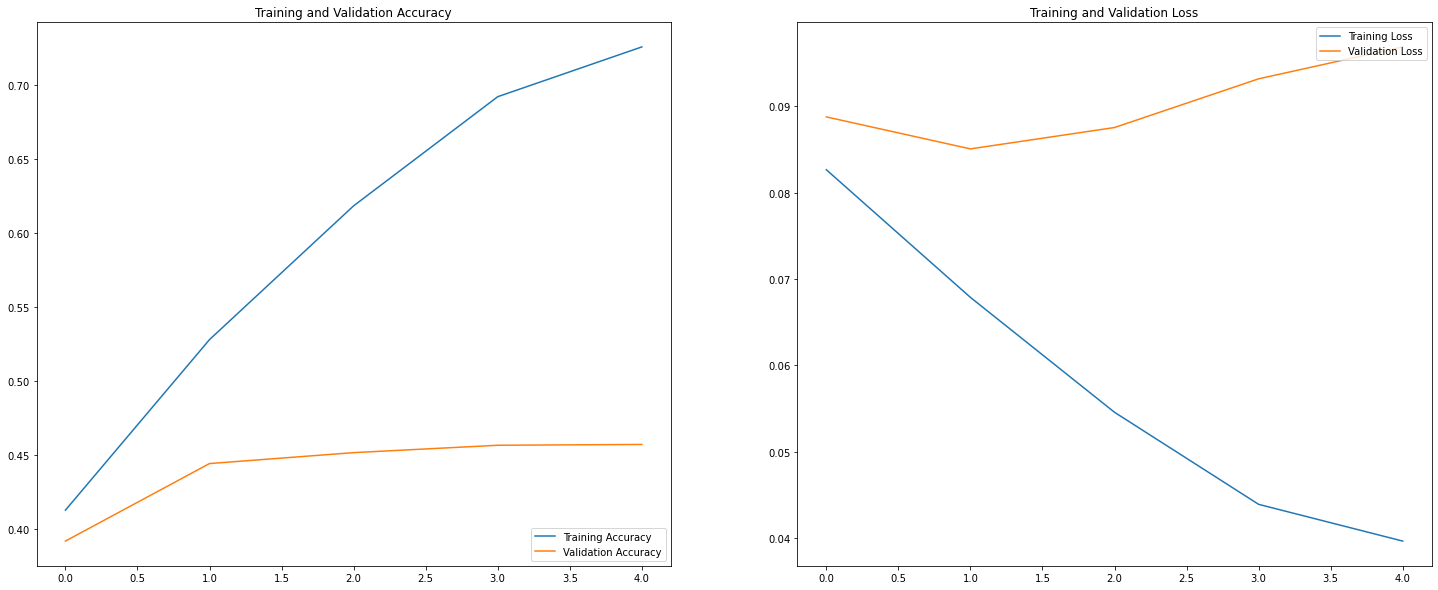

In [30]:
plot_model_performance(history)

## 3. Model Evaluation

In [31]:
#function to evaluate the model on the test set
def evaluate_model(test_dataset):
    test_res = trainer.evaluate(eval_dataset=test_dataset)
    print(test_res)
         
    return trainer.predict(test_dataset)


In [32]:
y_test = evaluate_model(test_dataset)

{'eval_loss': 0.09506487846374512, 'eval_f1': 0.5753160112359551, 'eval_recall': 0.5177753199557592, 'eval_precision': 0.6472447165712029, 'eval_roc_auc': 0.7527555553544237, 'eval_accuracy': 0.462870831030035, 'eval_runtime': 7.9769, 'eval_samples_per_second': 680.338, 'eval_steps_per_second': 42.623, 'epoch': 5.0}


In [33]:
#function to calculate each emotion label metrics on test set
def calc_label_metrics(label, y_targets, y_preds, threshold):
    return {
        "label": label,
        "accuracy": metrics.accuracy_score(y_targets, y_preds),
        "precision": metrics.precision_score(y_targets, y_preds, zero_division=0),
        "recall": metrics.recall_score(y_targets, y_preds, zero_division=0),
        "f1": metrics.f1_score(y_targets, y_preds, zero_division=0),
        "mcc": metrics.matthews_corrcoef(y_targets, y_preds),
        "support": y_targets.sum(),
        "threshold": threshold,
    }

In [34]:
#function to calculate overall metric on test set
def calc_test_metrics(y_test, test_dataset, target_cols):
    threshold = 0.5
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(y_test.predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= 0.5)] = 1
    
    # finally, compute metrics
    y_true = df_test[target_cols].values
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    precision_micro = precision_score(y_true, y_pred, average='micro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'recall' : recall_micro,
               'precision': precision_micro,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])

    display(metrics_df)
    
    
    results = []
    for label_index, label in enumerate(target_cols):
        y_targets, y_preds = y_true[:, label_index], y_pred[:, label_index]
        results.append(calc_label_metrics(label, y_targets, y_preds, threshold))

    per_label_results = pd.DataFrame(results, index=target_cols)
    display(per_label_results.drop(columns=["label"]).round(3))
    
    return y_true, y_pred


In [35]:
targets, outputs = calc_test_metrics(y_test, test_dataset, target_cols)

Value
f1         0.575316
recall     0.517775
precision  0.647245
roc_auc    0.752756
accuracy   0.462871

accuracy  precision  recall     f1    mcc  support  threshold
admiration         0.938      0.661   0.673  0.667  0.632      504        0.5
amusement          0.981      0.785   0.845  0.814  0.805      264        0.5
anger              0.968      0.572   0.460  0.510  0.497      198        0.5
annoyance          0.940      0.480   0.256  0.334  0.322      320        0.5
approval           0.931      0.452   0.279  0.345  0.321      351        0.5
caring             0.975      0.482   0.296  0.367  0.366      135        0.5
confusion          0.973      0.518   0.373  0.433  0.426      153        0.5
curiosity          0.948      0.504   0.440  0.470  0.444      284        0.5
desire             0.987      0.609   0.337  0.434  0.447       83        0.5
disappointment     0.972      0.512   0.146  0.227  0.263      151        0.5
disapproval        0.943      0.395   0.318  0.353  0.325      267        0.5
disgust            0.980      0.600   0.415  0.490  0.489      123        0.5
embarrassment      0.995      0.812   0.351  0.491  0.532       37        0.5
excitement         0.983      0.596   0.330  0.425  0.436      103        0.5
fear               0.991      0.675   0.667  0.671  0.666       78        0.5
gratitude          0.990      0.946   0.895  0.920  0.915      352        0.5
grief              0.999      0.000   0.000  0.000  0.000        6        0.5
joy                0.977      0.638   0.503  0.562  0.555      161        0.5
love               0.982      0.787   0.807  0.797  0.787      238        0.5
nervousness        0.996      0.444   0.174  0.250  0.276       23        0.5
optimism           0.972      0.623   0.489  0.548  0.538      186        0.5
pride              0.998      0.833   0.312  0.455  0.510       16        0.5
realization        0.974      0.520   0.179  0.267  0.295      145        0.5
relief             0.998      0.000   0.000  0.000  0.000       11        0.5
remorse            0.992      0.615   0.714  0.661  0.659       56        0.5
sadness            0.979      0.678   0.526  0.592  0.586      156        0.5
surprise           0.978      0.595   0.489  0.537  0.528      141        0.5
neutral            0.771      0.678   0.578  0.624  0.463     1787        0.5

In [37]:
# Create a DataFrame to store actual labels and predicted labels
final_df = pd.DataFrame({
    'Actual': [list(np.where(targets[i])[0]) for i in range(len(targets))],
    'Predicted': [list(np.where(outputs[i])[0]) for i in range(len(outputs))]
})

# Map label indices to label names in the 'Actual' column
final_df['Actual'] = final_df['Actual'].apply(lambda indices: [target_cols[idx] for idx in indices])

# Map label indices to label names in the 'Predicted' column
final_df['Predicted'] = final_df['Predicted'].apply(lambda indices: [target_cols[idx] for idx in indices])

# Display the results DataFrame
print("Results DataFrame:")
print(final_df.head(10))

Results DataFrame:
         Actual     Predicted
0     [sadness]        [love]
1  [admiration]  [admiration]
2  [excitement]    [optimism]
3   [gratitude]   [gratitude]
4     [neutral]     [neutral]
5   [gratitude]   [gratitude]
6   [gratitude]   [gratitude]
7   [gratitude]  [admiration]
8     [remorse]     [sadness]
9     [sadness]     [sadness]


In [38]:
# Concatenate the label DataFrame with the original DataFramev
val_df_terms = df_test['clean_text']
result_df = pd.concat([val_df_terms, final_df], axis=1)

In [39]:
result_df

clean_text        Actual  \
0     i am really sorry about your situation frown s...     [sadness]   
1       it is wonderful because it is awful at not with  [admiration]   
2     kings fan here good luck to you guys will be a...  [excitement]   
3     i did not know that thank you for teaching me ...   [gratitude]   
4     they got bored from haunting earth for thousan...     [neutral]   
...                                                 ...           ...   
5422  thanks i was diagnosed with bp 1 after the hos...   [gratitude]   
5423                              well that makes sense    [approval]   
5424                                  daddy issues name     [neutral]   
5425  so glad i discovered that subreddit a couple m...  [admiration]   
5426  had to watch elmo in grouchland one time too m...     [neutral]   

         Predicted  
0           [love]  
1     [admiration]  
2       [optimism]  
3      [gratitude]  
4        [neutral]  
...            ...  
5422   [gratitude]  
5423    [approval]  
5424     [neutral]  
5425         [joy]  
5426     [neutral]  

[5427 rows x 3 columns]

## 4. Save the output, tokenizer and model

In [40]:
result_df.to_csv('output_m1.csv', index=False, sep=';')

In [41]:
# Save tokenizer
tokenizer.save_pretrained('./distilbert_M1_transformer/')

# Save model
trainer.save_model('./distilbert_M1_transformer/')